In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

plt.style.use('fivethirtyeight')

In [4]:
#read data
xtest = pd.read_csv("X_test.csv")
xtrain = pd.read_csv("X_train.csv")
ytest = pd.read_csv("y_test_sample.csv")
ytrain = pd.read_csv("y_train.csv")

In [5]:
data = pd.concat([xtrain, ytrain], axis=1)

In [6]:
data.count()/len(data)

credit_card_utilization       1.000000
age                           1.000000
overdue_30_59_days            1.000000
debt_to_income                1.000000
monthly_income                0.800274
credits_loans                 1.000000
overdue__more_than_90_days    1.000000
mortgage_loans                1.000000
overdue_60_89_days            1.000000
family_members                0.973313
target                        1.000000
dtype: float64

In [7]:
data['has_family'] = (data['family_members'] > 0) * 1

In [8]:
data['has_income'] = (data['monthly_income'] > 0) * 1

In [9]:
data['family_members'] = data['family_members'].fillna(0)

In [10]:
data['monthly_income'] = data['monthly_income'].fillna(0)

In [11]:
def age_group(x):
    if x in range(17, 36):
        return 'young_adult'
    elif x in range(36, 55):
        return 'middle_adult'
    else:
        return 'old_adult'

In [12]:
data['age_group'] = data['age'].apply(age_group)

In [13]:
data = pd.get_dummies(data)

In [14]:
data.corr().style.background_gradient(cmap='coolwarm')

In [15]:
class FeaturesTransform(BaseEstimator):
    def __init__(self, cat=False):
        if cat:
            FeaturesTransform.FEATURES = ['credit_card_utilization', 'age', 'debt_to_income', 'monthly_income',
                'credits_loans', 'mortgage_loans', 'family_members',
                'has_family', 'has_income', 'age_group',
                'overdue_30_59_days', 'overdue__more_than_90_days', 'overdue_60_89_days'
                ]
            FeaturesTransform.categorical = True
        else:
            FeaturesTransform.FEATURES = ['credit_card_utilization', 'age', 'debt_to_income', 'monthly_income',
                'credits_loans', 'mortgage_loans', 'family_members',
                'has_family', 'has_income',
                'age_group_middle_adult', 'age_group_old_adult', 'age_group_young_adult',
                'overdue_30_59_days', 'overdue__more_than_90_days', 'overdue_60_89_days'
                ]
            FeaturesTransform.categorical = False
    def fit(self, X, y=None):
        return self
    def transform(self, df):
        
        df['monthly_income'] = df['monthly_income'].fillna(0)
        df['family_members'] = df['family_members'].fillna(0)
        df['has_income'] = (df['monthly_income'] > 0) * 1
        df['has_family'] = (df['family_members'] > 0) * 1
        df['age_group'] = df['age'].apply(age_group)
        if not FeaturesTransform.categorical:
            df = pd.get_dummies(df)
#         df['total_overdue'] = df[['overdue_30_59_days', 'overdue__more_than_90_days', 'overdue_60_89_days']].sum(axis=1)
#         df = df.drop(columns=['overdue_30_59_days', 'overdue__more_than_90_days', 'overdue_60_89_days'])
        return df[FeaturesTransform.FEATURES]

In [16]:
TARGET = 'target'

In [17]:
def print_scores(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]
    preds = model.predict(X_val)
    
    print(f"ROC-AUC: {roc_auc_score(y_val, probs):.3f}")
    
    print(f"Accuracy: {accuracy_score(y_val, preds):.3f}")
    print(f"Precision: {precision_score(y_val, preds):.3f}")
    print(f"Recall: {recall_score(y_val, preds):.3f}")
    print(f"F1-score: {f1_score(y_val, preds):.3f}")

In [18]:
X = FeaturesTransform(cat=False).transform(xtrain)
y = ytrain[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)

In [19]:
params_lr1 = {"C": 0.03359818286283781, "class_weight": {0: 1, 1: 25}}

lr1 = LogisticRegression(**params_lr1)

In [20]:
lr1.fit(X_train, y_train)

LogisticRegression(C=0.03359818286283781, class_weight={0: 1, 1: 25})

In [21]:
print_scores(lr1, X_val, y_val)

ROC-AUC: 0.807
Accuracy: 0.496
Precision: 0.107
Recall: 0.880
F1-score: 0.191


In [22]:
X = FeaturesTransform(cat=False).transform(xtrain)
y = ytrain[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

In [25]:
params_xgb = {
              'colsample_bytree': 0.3,
              'gamma': 0.5,
              'learning_rate': 0.05,
              'max_depth': 5,
              'min_child_weight': 5,
              'scale_pos_weight': 1,
              'objective': 'binary:logistic',
              'seed': 60,
              'gpu_id': 0,
              'tree_method': 'gpu_hist'
             }

model_xgboost = XGBClassifier(**params_xgb)

In [26]:
model_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=60,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
print_scores(model_xgboost, X_val, y_val)

ROC-AUC: 0.869
Accuracy: 0.938
Precision: 0.645
Recall: 0.143
F1-score: 0.234


In [28]:
X = FeaturesTransform(cat=False).transform(xtrain)
y = ytrain[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)

In [29]:
params = {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
lr2 = LogisticRegression(**params)

In [30]:
lr2.fit(X_train, y_train)

LogisticRegression(C=0.001, solver='liblinear')

In [31]:
print_scores(lr2, X_val, y_val)

ROC-AUC: 0.679
Accuracy: 0.935
Precision: 0.622
Recall: 0.017
F1-score: 0.033


### Random Forest

In [32]:
X = FeaturesTransform(cat=False).transform(xtrain)
y = ytrain[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

In [33]:
params_rfc = {'n_estimators': 350,
              'min_samples_leaf': 30,
              'min_samples_split': 30,
              'bootstrap': True,
              'class_weight': 'balanced'}

rfc = RandomForestClassifier(**params_rfc)

In [34]:
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=30,
                       min_samples_split=30, n_estimators=350)

In [35]:
print_scores(rfc, X_val, y_val)

ROC-AUC: 0.859
Accuracy: 0.844
Precision: 0.261
Recall: 0.698
F1-score: 0.380


### CatBoost

In [32]:
X = FeaturesTransform(cat=False).transform(xtrain)
y = ytrain[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

In [36]:
params_cat = {
             'learning_rate': 0.01,
             'iterations': 10000,
             'loss_function': 'Logloss',
             'eval_metric': 'AUC',
             'random_seed': 42,
             'task_type': 'GPU',
             'auto_class_weights': 'SqrtBalanced',
             'early_stopping_rounds': 500,
             'depth': 6,
             'l2_leaf_reg': 3,
             'random_strength': 1,
             'min_data_in_leaf': 30,
#              'cat_features'=['age_group']
             }

In [37]:
kFold_random_state = [
    42, #666, 228, 777, 2021, 75
]

for ind_k, random_state in enumerate(kFold_random_state):
    kf = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    for train_index, test_index in kf.split(X_train):
        X_t, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_t, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        clf = CatBoostClassifier(**params_cat)

        clf.fit(X_t, y_t, eval_set=(X_test, y_test),
                verbose = 500, use_best_model = True, plot = False)


C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	test: 0.8321888	best: 0.8321888 (0)	total: 168ms	remaining: 28m 4s
500:	test: 0.8620104	best: 0.8620213 (490)	total: 6.06s	remaining: 1m 54s
1000:	test: 0.8626784	best: 0.8626784 (1000)	total: 11.8s	remaining: 1m 45s
1500:	test: 0.8623037	best: 0.8627857 (1236)	total: 17.4s	remaining: 1m 38s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8627856743
bestIteration = 1236

Shrink model to first 1237 iterations.
0:	test: 0.8311230	best: 0.8311230 (0)	total: 18.8ms	remaining: 3m 7s
500:	test: 0.8631709	best: 0.8631874 (496)	total: 6.72s	remaining: 2m 7s
1000:	test: 0.8643204	best: 0.8643207 (996)	total: 12s	remaining: 1m 47s
1500:	test: 0.8641351	best: 0.8644905 (1184)	total: 17.4s	remaining: 1m 38s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8644904703
bestIteration = 1184

Shrink model to first 1185 iterations.
0:	test: 0.8340522	best: 0.8340522 (0)	total: 14.1ms	remaining: 2m 20s
500:	test: 0.8634983	best: 0.8634983 (500)	total: 5.56s	rem

In [38]:
print_scores(clf, X_val, y_val)

ROC-AUC: 0.863
Accuracy: 0.920
Precision: 0.424
Recall: 0.477
F1-score: 0.449


# All models

In [39]:
models = [('lr1', lr1), ('lr2', lr2), ('xgb', model_xgboost), ('cb', clf), ('rfc', rfc)]

# Blending

In [57]:
general_model = VotingClassifier(estimators=models, voting='soft')

params_blending = {
    'weights': [[0.1, 0.1, 0.2,0.2, 0.4], [0.1, 0.1, 0.4,0.2, 0.2],[0.1, 0.1, 0.2,0.4, 0.2]]
}

GS_blending = GridSearchCV(estimator = general_model, param_grid=params_blending, scoring = 'roc_auc')

In [58]:
X = FeaturesTransform(cat=False).transform(xtrain)
y = ytrain[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

In [59]:
GS_blending.fit(X_train, y_train)

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	total: 12.2ms	remaining: 2m 1s
1:	total: 23.4ms	remaining: 1m 57s
2:	total: 33.7ms	remaining: 1m 52s
3:	total: 44.2ms	remaining: 1m 50s
4:	total: 55.1ms	remaining: 1m 50s
5:	total: 65.5ms	remaining: 1m 49s
6:	total: 77.6ms	remaining: 1m 50s
7:	total: 88.7ms	remaining: 1m 50s
8:	total: 106ms	remaining: 1m 57s
9:	total: 119ms	remaining: 1m 58s
10:	total: 130ms	remaining: 1m 57s
11:	total: 140ms	remaining: 1m 56s
12:	total: 151ms	remaining: 1m 55s
13:	total: 162ms	remaining: 1m 55s
14:	total: 171ms	remaining: 1m 54s
15:	total: 182ms	remaining: 1m 53s
16:	total: 194ms	remaining: 1m 53s
17:	total: 208ms	remaining: 1m 55s
18:	total: 221ms	remaining: 1m 55s
19:	total: 232ms	remaining: 1m 55s
20:	total: 242ms	remaining: 1m 54s
21:	total: 252ms	remaining: 1m 54s
22:	total: 264ms	remaining: 1m 54s
23:	total: 281ms	remaining: 1m 56s
24:	total: 292ms	remaining: 1m 56s
25:	total: 304ms	remaining: 1m 56s
26:	total: 317ms	remaining: 1m 57s
27:	total: 330ms	remaining: 1m 57s
28:	total: 342ms	remain

251:	total: 2.98s	remaining: 1m 55s
252:	total: 3s	remaining: 1m 55s
253:	total: 3.01s	remaining: 1m 55s
254:	total: 3.02s	remaining: 1m 55s
255:	total: 3.03s	remaining: 1m 55s
256:	total: 3.04s	remaining: 1m 55s
257:	total: 3.06s	remaining: 1m 55s
258:	total: 3.07s	remaining: 1m 55s
259:	total: 3.08s	remaining: 1m 55s
260:	total: 3.09s	remaining: 1m 55s
261:	total: 3.1s	remaining: 1m 55s
262:	total: 3.12s	remaining: 1m 55s
263:	total: 3.13s	remaining: 1m 55s
264:	total: 3.14s	remaining: 1m 55s
265:	total: 3.15s	remaining: 1m 55s
266:	total: 3.16s	remaining: 1m 55s
267:	total: 3.17s	remaining: 1m 55s
268:	total: 3.18s	remaining: 1m 55s
269:	total: 3.2s	remaining: 1m 55s
270:	total: 3.21s	remaining: 1m 55s
271:	total: 3.22s	remaining: 1m 55s
272:	total: 3.23s	remaining: 1m 55s
273:	total: 3.24s	remaining: 1m 55s
274:	total: 3.25s	remaining: 1m 55s
275:	total: 3.26s	remaining: 1m 54s
276:	total: 3.27s	remaining: 1m 54s
277:	total: 3.29s	remaining: 1m 54s
278:	total: 3.3s	remaining: 1m 54

486:	total: 5.75s	remaining: 1m 52s
487:	total: 5.76s	remaining: 1m 52s
488:	total: 5.77s	remaining: 1m 52s
489:	total: 5.78s	remaining: 1m 52s
490:	total: 5.79s	remaining: 1m 52s
491:	total: 5.8s	remaining: 1m 52s
492:	total: 5.82s	remaining: 1m 52s
493:	total: 5.83s	remaining: 1m 52s
494:	total: 5.84s	remaining: 1m 52s
495:	total: 5.86s	remaining: 1m 52s
496:	total: 5.87s	remaining: 1m 52s
497:	total: 5.88s	remaining: 1m 52s
498:	total: 5.9s	remaining: 1m 52s
499:	total: 5.91s	remaining: 1m 52s
500:	total: 5.92s	remaining: 1m 52s
501:	total: 5.94s	remaining: 1m 52s
502:	total: 5.95s	remaining: 1m 52s
503:	total: 5.96s	remaining: 1m 52s
504:	total: 5.97s	remaining: 1m 52s
505:	total: 5.99s	remaining: 1m 52s
506:	total: 6s	remaining: 1m 52s
507:	total: 6.01s	remaining: 1m 52s
508:	total: 6.02s	remaining: 1m 52s
509:	total: 6.03s	remaining: 1m 52s
510:	total: 6.04s	remaining: 1m 52s
511:	total: 6.05s	remaining: 1m 52s
512:	total: 6.06s	remaining: 1m 52s
513:	total: 6.08s	remaining: 1m 5

730:	total: 8.5s	remaining: 1m 47s
731:	total: 8.51s	remaining: 1m 47s
732:	total: 8.52s	remaining: 1m 47s
733:	total: 8.53s	remaining: 1m 47s
734:	total: 8.54s	remaining: 1m 47s
735:	total: 8.55s	remaining: 1m 47s
736:	total: 8.57s	remaining: 1m 47s
737:	total: 8.58s	remaining: 1m 47s
738:	total: 8.59s	remaining: 1m 47s
739:	total: 8.6s	remaining: 1m 47s
740:	total: 8.61s	remaining: 1m 47s
741:	total: 8.62s	remaining: 1m 47s
742:	total: 8.63s	remaining: 1m 47s
743:	total: 8.64s	remaining: 1m 47s
744:	total: 8.65s	remaining: 1m 47s
745:	total: 8.66s	remaining: 1m 47s
746:	total: 8.67s	remaining: 1m 47s
747:	total: 8.69s	remaining: 1m 47s
748:	total: 8.7s	remaining: 1m 47s
749:	total: 8.71s	remaining: 1m 47s
750:	total: 8.72s	remaining: 1m 47s
751:	total: 8.73s	remaining: 1m 47s
752:	total: 8.75s	remaining: 1m 47s
753:	total: 8.76s	remaining: 1m 47s
754:	total: 8.77s	remaining: 1m 47s
755:	total: 8.78s	remaining: 1m 47s
756:	total: 8.79s	remaining: 1m 47s
757:	total: 8.8s	remaining: 1m 

974:	total: 11.2s	remaining: 1m 44s
975:	total: 11.3s	remaining: 1m 44s
976:	total: 11.3s	remaining: 1m 44s
977:	total: 11.3s	remaining: 1m 44s
978:	total: 11.3s	remaining: 1m 44s
979:	total: 11.3s	remaining: 1m 44s
980:	total: 11.3s	remaining: 1m 43s
981:	total: 11.3s	remaining: 1m 43s
982:	total: 11.3s	remaining: 1m 43s
983:	total: 11.3s	remaining: 1m 43s
984:	total: 11.4s	remaining: 1m 43s
985:	total: 11.4s	remaining: 1m 43s
986:	total: 11.4s	remaining: 1m 43s
987:	total: 11.4s	remaining: 1m 43s
988:	total: 11.4s	remaining: 1m 43s
989:	total: 11.4s	remaining: 1m 43s
990:	total: 11.4s	remaining: 1m 43s
991:	total: 11.4s	remaining: 1m 43s
992:	total: 11.4s	remaining: 1m 43s
993:	total: 11.5s	remaining: 1m 43s
994:	total: 11.5s	remaining: 1m 43s
995:	total: 11.5s	remaining: 1m 43s
996:	total: 11.5s	remaining: 1m 43s
997:	total: 11.5s	remaining: 1m 43s
998:	total: 11.5s	remaining: 1m 43s
999:	total: 11.5s	remaining: 1m 43s
1000:	total: 11.5s	remaining: 1m 43s
1001:	total: 11.5s	remainin

1204:	total: 14.1s	remaining: 1m 42s
1205:	total: 14.1s	remaining: 1m 42s
1206:	total: 14.1s	remaining: 1m 42s
1207:	total: 14.1s	remaining: 1m 42s
1208:	total: 14.2s	remaining: 1m 42s
1209:	total: 14.2s	remaining: 1m 42s
1210:	total: 14.2s	remaining: 1m 42s
1211:	total: 14.2s	remaining: 1m 42s
1212:	total: 14.2s	remaining: 1m 42s
1213:	total: 14.2s	remaining: 1m 42s
1214:	total: 14.2s	remaining: 1m 42s
1215:	total: 14.3s	remaining: 1m 42s
1216:	total: 14.3s	remaining: 1m 43s
1217:	total: 14.3s	remaining: 1m 43s
1218:	total: 14.3s	remaining: 1m 43s
1219:	total: 14.3s	remaining: 1m 43s
1220:	total: 14.3s	remaining: 1m 43s
1221:	total: 14.3s	remaining: 1m 43s
1222:	total: 14.4s	remaining: 1m 43s
1223:	total: 14.4s	remaining: 1m 43s
1224:	total: 14.4s	remaining: 1m 43s
1225:	total: 14.4s	remaining: 1m 43s
1226:	total: 14.4s	remaining: 1m 43s
1227:	total: 14.4s	remaining: 1m 42s
1228:	total: 14.4s	remaining: 1m 42s
1229:	total: 14.4s	remaining: 1m 42s
1230:	total: 14.5s	remaining: 1m 42s
1

1427:	total: 16.7s	remaining: 1m 39s
1428:	total: 16.7s	remaining: 1m 39s
1429:	total: 16.7s	remaining: 1m 39s
1430:	total: 16.7s	remaining: 1m 39s
1431:	total: 16.7s	remaining: 1m 39s
1432:	total: 16.7s	remaining: 1m 39s
1433:	total: 16.7s	remaining: 1m 39s
1434:	total: 16.7s	remaining: 1m 39s
1435:	total: 16.7s	remaining: 1m 39s
1436:	total: 16.8s	remaining: 1m 39s
1437:	total: 16.8s	remaining: 1m 39s
1438:	total: 16.8s	remaining: 1m 39s
1439:	total: 16.8s	remaining: 1m 39s
1440:	total: 16.8s	remaining: 1m 39s
1441:	total: 16.8s	remaining: 1m 39s
1442:	total: 16.8s	remaining: 1m 39s
1443:	total: 16.8s	remaining: 1m 39s
1444:	total: 16.9s	remaining: 1m 39s
1445:	total: 16.9s	remaining: 1m 39s
1446:	total: 16.9s	remaining: 1m 39s
1447:	total: 16.9s	remaining: 1m 39s
1448:	total: 16.9s	remaining: 1m 39s
1449:	total: 16.9s	remaining: 1m 39s
1450:	total: 16.9s	remaining: 1m 39s
1451:	total: 16.9s	remaining: 1m 39s
1452:	total: 16.9s	remaining: 1m 39s
1453:	total: 16.9s	remaining: 1m 39s
1

1663:	total: 19.4s	remaining: 1m 37s
1664:	total: 19.4s	remaining: 1m 37s
1665:	total: 19.5s	remaining: 1m 37s
1666:	total: 19.5s	remaining: 1m 37s
1667:	total: 19.5s	remaining: 1m 37s
1668:	total: 19.5s	remaining: 1m 37s
1669:	total: 19.5s	remaining: 1m 37s
1670:	total: 19.5s	remaining: 1m 37s
1671:	total: 19.5s	remaining: 1m 37s
1672:	total: 19.5s	remaining: 1m 37s
1673:	total: 19.5s	remaining: 1m 37s
1674:	total: 19.6s	remaining: 1m 37s
1675:	total: 19.6s	remaining: 1m 37s
1676:	total: 19.6s	remaining: 1m 37s
1677:	total: 19.6s	remaining: 1m 37s
1678:	total: 19.6s	remaining: 1m 37s
1679:	total: 19.6s	remaining: 1m 37s
1680:	total: 19.6s	remaining: 1m 37s
1681:	total: 19.6s	remaining: 1m 37s
1682:	total: 19.7s	remaining: 1m 37s
1683:	total: 19.7s	remaining: 1m 37s
1684:	total: 19.7s	remaining: 1m 37s
1685:	total: 19.7s	remaining: 1m 37s
1686:	total: 19.7s	remaining: 1m 37s
1687:	total: 19.7s	remaining: 1m 37s
1688:	total: 19.7s	remaining: 1m 37s
1689:	total: 19.7s	remaining: 1m 37s
1

1903:	total: 22.2s	remaining: 1m 34s
1904:	total: 22.2s	remaining: 1m 34s
1905:	total: 22.2s	remaining: 1m 34s
1906:	total: 22.2s	remaining: 1m 34s
1907:	total: 22.2s	remaining: 1m 34s
1908:	total: 22.2s	remaining: 1m 34s
1909:	total: 22.2s	remaining: 1m 34s
1910:	total: 22.2s	remaining: 1m 34s
1911:	total: 22.2s	remaining: 1m 34s
1912:	total: 22.3s	remaining: 1m 34s
1913:	total: 22.3s	remaining: 1m 34s
1914:	total: 22.3s	remaining: 1m 34s
1915:	total: 22.3s	remaining: 1m 34s
1916:	total: 22.3s	remaining: 1m 34s
1917:	total: 22.3s	remaining: 1m 34s
1918:	total: 22.3s	remaining: 1m 34s
1919:	total: 22.3s	remaining: 1m 34s
1920:	total: 22.4s	remaining: 1m 34s
1921:	total: 22.4s	remaining: 1m 34s
1922:	total: 22.4s	remaining: 1m 33s
1923:	total: 22.4s	remaining: 1m 33s
1924:	total: 22.4s	remaining: 1m 33s
1925:	total: 22.4s	remaining: 1m 33s
1926:	total: 22.4s	remaining: 1m 33s
1927:	total: 22.4s	remaining: 1m 33s
1928:	total: 22.4s	remaining: 1m 33s
1929:	total: 22.5s	remaining: 1m 33s
1

2130:	total: 24.7s	remaining: 1m 31s
2131:	total: 24.7s	remaining: 1m 31s
2132:	total: 24.7s	remaining: 1m 31s
2133:	total: 24.8s	remaining: 1m 31s
2134:	total: 24.8s	remaining: 1m 31s
2135:	total: 24.8s	remaining: 1m 31s
2136:	total: 24.8s	remaining: 1m 31s
2137:	total: 24.8s	remaining: 1m 31s
2138:	total: 24.8s	remaining: 1m 31s
2139:	total: 24.8s	remaining: 1m 31s
2140:	total: 24.8s	remaining: 1m 31s
2141:	total: 24.8s	remaining: 1m 31s
2142:	total: 24.9s	remaining: 1m 31s
2143:	total: 24.9s	remaining: 1m 31s
2144:	total: 24.9s	remaining: 1m 31s
2145:	total: 24.9s	remaining: 1m 31s
2146:	total: 24.9s	remaining: 1m 31s
2147:	total: 24.9s	remaining: 1m 31s
2148:	total: 24.9s	remaining: 1m 31s
2149:	total: 24.9s	remaining: 1m 31s
2150:	total: 24.9s	remaining: 1m 31s
2151:	total: 25s	remaining: 1m 31s
2152:	total: 25s	remaining: 1m 31s
2153:	total: 25s	remaining: 1m 30s
2154:	total: 25s	remaining: 1m 30s
2155:	total: 25s	remaining: 1m 30s
2156:	total: 25s	remaining: 1m 30s
2157:	total: 

2354:	total: 27.3s	remaining: 1m 28s
2355:	total: 27.3s	remaining: 1m 28s
2356:	total: 27.3s	remaining: 1m 28s
2357:	total: 27.3s	remaining: 1m 28s
2358:	total: 27.3s	remaining: 1m 28s
2359:	total: 27.3s	remaining: 1m 28s
2360:	total: 27.3s	remaining: 1m 28s
2361:	total: 27.3s	remaining: 1m 28s
2362:	total: 27.3s	remaining: 1m 28s
2363:	total: 27.4s	remaining: 1m 28s
2364:	total: 27.4s	remaining: 1m 28s
2365:	total: 27.4s	remaining: 1m 28s
2366:	total: 27.4s	remaining: 1m 28s
2367:	total: 27.4s	remaining: 1m 28s
2368:	total: 27.4s	remaining: 1m 28s
2369:	total: 27.4s	remaining: 1m 28s
2370:	total: 27.4s	remaining: 1m 28s
2371:	total: 27.4s	remaining: 1m 28s
2372:	total: 27.5s	remaining: 1m 28s
2373:	total: 27.5s	remaining: 1m 28s
2374:	total: 27.5s	remaining: 1m 28s
2375:	total: 27.5s	remaining: 1m 28s
2376:	total: 27.5s	remaining: 1m 28s
2377:	total: 27.5s	remaining: 1m 28s
2378:	total: 27.5s	remaining: 1m 28s
2379:	total: 27.5s	remaining: 1m 28s
2380:	total: 27.5s	remaining: 1m 28s
2

2578:	total: 29.8s	remaining: 1m 25s
2579:	total: 29.8s	remaining: 1m 25s
2580:	total: 29.8s	remaining: 1m 25s
2581:	total: 29.8s	remaining: 1m 25s
2582:	total: 29.8s	remaining: 1m 25s
2583:	total: 29.9s	remaining: 1m 25s
2584:	total: 29.9s	remaining: 1m 25s
2585:	total: 29.9s	remaining: 1m 25s
2586:	total: 29.9s	remaining: 1m 25s
2587:	total: 29.9s	remaining: 1m 25s
2588:	total: 29.9s	remaining: 1m 25s
2589:	total: 29.9s	remaining: 1m 25s
2590:	total: 30s	remaining: 1m 25s
2591:	total: 30s	remaining: 1m 25s
2592:	total: 30s	remaining: 1m 25s
2593:	total: 30s	remaining: 1m 25s
2594:	total: 30s	remaining: 1m 25s
2595:	total: 30.1s	remaining: 1m 25s
2596:	total: 30.1s	remaining: 1m 25s
2597:	total: 30.1s	remaining: 1m 25s
2598:	total: 30.1s	remaining: 1m 25s
2599:	total: 30.1s	remaining: 1m 25s
2600:	total: 30.1s	remaining: 1m 25s
2601:	total: 30.1s	remaining: 1m 25s
2602:	total: 30.2s	remaining: 1m 25s
2603:	total: 30.2s	remaining: 1m 25s
2604:	total: 30.2s	remaining: 1m 25s
2605:	total

2817:	total: 32.8s	remaining: 1m 23s
2818:	total: 32.8s	remaining: 1m 23s
2819:	total: 32.8s	remaining: 1m 23s
2820:	total: 32.8s	remaining: 1m 23s
2821:	total: 32.8s	remaining: 1m 23s
2822:	total: 32.8s	remaining: 1m 23s
2823:	total: 32.8s	remaining: 1m 23s
2824:	total: 32.8s	remaining: 1m 23s
2825:	total: 32.9s	remaining: 1m 23s
2826:	total: 32.9s	remaining: 1m 23s
2827:	total: 32.9s	remaining: 1m 23s
2828:	total: 32.9s	remaining: 1m 23s
2829:	total: 32.9s	remaining: 1m 23s
2830:	total: 32.9s	remaining: 1m 23s
2831:	total: 32.9s	remaining: 1m 23s
2832:	total: 32.9s	remaining: 1m 23s
2833:	total: 32.9s	remaining: 1m 23s
2834:	total: 32.9s	remaining: 1m 23s
2835:	total: 33s	remaining: 1m 23s
2836:	total: 33s	remaining: 1m 23s
2837:	total: 33s	remaining: 1m 23s
2838:	total: 33s	remaining: 1m 23s
2839:	total: 33s	remaining: 1m 23s
2840:	total: 33s	remaining: 1m 23s
2841:	total: 33s	remaining: 1m 23s
2842:	total: 33s	remaining: 1m 23s
2843:	total: 33s	remaining: 1m 23s
2844:	total: 33.1s	

3043:	total: 35.3s	remaining: 1m 20s
3044:	total: 35.4s	remaining: 1m 20s
3045:	total: 35.4s	remaining: 1m 20s
3046:	total: 35.4s	remaining: 1m 20s
3047:	total: 35.4s	remaining: 1m 20s
3048:	total: 35.4s	remaining: 1m 20s
3049:	total: 35.4s	remaining: 1m 20s
3050:	total: 35.4s	remaining: 1m 20s
3051:	total: 35.4s	remaining: 1m 20s
3052:	total: 35.4s	remaining: 1m 20s
3053:	total: 35.5s	remaining: 1m 20s
3054:	total: 35.5s	remaining: 1m 20s
3055:	total: 35.5s	remaining: 1m 20s
3056:	total: 35.5s	remaining: 1m 20s
3057:	total: 35.5s	remaining: 1m 20s
3058:	total: 35.5s	remaining: 1m 20s
3059:	total: 35.5s	remaining: 1m 20s
3060:	total: 35.5s	remaining: 1m 20s
3061:	total: 35.5s	remaining: 1m 20s
3062:	total: 35.6s	remaining: 1m 20s
3063:	total: 35.6s	remaining: 1m 20s
3064:	total: 35.6s	remaining: 1m 20s
3065:	total: 35.6s	remaining: 1m 20s
3066:	total: 35.6s	remaining: 1m 20s
3067:	total: 35.6s	remaining: 1m 20s
3068:	total: 35.6s	remaining: 1m 20s
3069:	total: 35.6s	remaining: 1m 20s
3

3266:	total: 38.1s	remaining: 1m 18s
3267:	total: 38.1s	remaining: 1m 18s
3268:	total: 38.2s	remaining: 1m 18s
3269:	total: 38.2s	remaining: 1m 18s
3270:	total: 38.2s	remaining: 1m 18s
3271:	total: 38.2s	remaining: 1m 18s
3272:	total: 38.2s	remaining: 1m 18s
3273:	total: 38.2s	remaining: 1m 18s
3274:	total: 38.2s	remaining: 1m 18s
3275:	total: 38.2s	remaining: 1m 18s
3276:	total: 38.2s	remaining: 1m 18s
3277:	total: 38.3s	remaining: 1m 18s
3278:	total: 38.3s	remaining: 1m 18s
3279:	total: 38.3s	remaining: 1m 18s
3280:	total: 38.3s	remaining: 1m 18s
3281:	total: 38.3s	remaining: 1m 18s
3282:	total: 38.3s	remaining: 1m 18s
3283:	total: 38.3s	remaining: 1m 18s
3284:	total: 38.3s	remaining: 1m 18s
3285:	total: 38.4s	remaining: 1m 18s
3286:	total: 38.4s	remaining: 1m 18s
3287:	total: 38.4s	remaining: 1m 18s
3288:	total: 38.4s	remaining: 1m 18s
3289:	total: 38.4s	remaining: 1m 18s
3290:	total: 38.4s	remaining: 1m 18s
3291:	total: 38.5s	remaining: 1m 18s
3292:	total: 38.5s	remaining: 1m 18s
3

3495:	total: 40.9s	remaining: 1m 16s
3496:	total: 40.9s	remaining: 1m 16s
3497:	total: 40.9s	remaining: 1m 15s
3498:	total: 40.9s	remaining: 1m 15s
3499:	total: 40.9s	remaining: 1m 15s
3500:	total: 40.9s	remaining: 1m 15s
3501:	total: 40.9s	remaining: 1m 15s
3502:	total: 40.9s	remaining: 1m 15s
3503:	total: 41s	remaining: 1m 15s
3504:	total: 41s	remaining: 1m 15s
3505:	total: 41s	remaining: 1m 15s
3506:	total: 41s	remaining: 1m 15s
3507:	total: 41s	remaining: 1m 15s
3508:	total: 41s	remaining: 1m 15s
3509:	total: 41s	remaining: 1m 15s
3510:	total: 41s	remaining: 1m 15s
3511:	total: 41s	remaining: 1m 15s
3512:	total: 41s	remaining: 1m 15s
3513:	total: 41.1s	remaining: 1m 15s
3514:	total: 41.1s	remaining: 1m 15s
3515:	total: 41.1s	remaining: 1m 15s
3516:	total: 41.1s	remaining: 1m 15s
3517:	total: 41.1s	remaining: 1m 15s
3518:	total: 41.1s	remaining: 1m 15s
3519:	total: 41.1s	remaining: 1m 15s
3520:	total: 41.1s	remaining: 1m 15s
3521:	total: 41.1s	remaining: 1m 15s
3522:	total: 41.2s	re

3726:	total: 43.4s	remaining: 1m 13s
3727:	total: 43.4s	remaining: 1m 13s
3728:	total: 43.5s	remaining: 1m 13s
3729:	total: 43.5s	remaining: 1m 13s
3730:	total: 43.5s	remaining: 1m 13s
3731:	total: 43.5s	remaining: 1m 13s
3732:	total: 43.5s	remaining: 1m 13s
3733:	total: 43.5s	remaining: 1m 13s
3734:	total: 43.5s	remaining: 1m 12s
3735:	total: 43.5s	remaining: 1m 12s
3736:	total: 43.5s	remaining: 1m 12s
3737:	total: 43.5s	remaining: 1m 12s
3738:	total: 43.6s	remaining: 1m 12s
3739:	total: 43.6s	remaining: 1m 12s
3740:	total: 43.6s	remaining: 1m 12s
3741:	total: 43.6s	remaining: 1m 12s
3742:	total: 43.6s	remaining: 1m 12s
3743:	total: 43.6s	remaining: 1m 12s
3744:	total: 43.6s	remaining: 1m 12s
3745:	total: 43.6s	remaining: 1m 12s
3746:	total: 43.6s	remaining: 1m 12s
3747:	total: 43.7s	remaining: 1m 12s
3748:	total: 43.7s	remaining: 1m 12s
3749:	total: 43.7s	remaining: 1m 12s
3750:	total: 43.7s	remaining: 1m 12s
3751:	total: 43.7s	remaining: 1m 12s
3752:	total: 43.7s	remaining: 1m 12s
3

3957:	total: 46s	remaining: 1m 10s
3958:	total: 46s	remaining: 1m 10s
3959:	total: 46s	remaining: 1m 10s
3960:	total: 46s	remaining: 1m 10s
3961:	total: 46s	remaining: 1m 10s
3962:	total: 46s	remaining: 1m 10s
3963:	total: 46s	remaining: 1m 10s
3964:	total: 46.1s	remaining: 1m 10s
3965:	total: 46.1s	remaining: 1m 10s
3966:	total: 46.1s	remaining: 1m 10s
3967:	total: 46.1s	remaining: 1m 10s
3968:	total: 46.1s	remaining: 1m 10s
3969:	total: 46.1s	remaining: 1m 10s
3970:	total: 46.1s	remaining: 1m 10s
3971:	total: 46.1s	remaining: 1m 10s
3972:	total: 46.1s	remaining: 1m 10s
3973:	total: 46.2s	remaining: 1m 9s
3974:	total: 46.2s	remaining: 1m 9s
3975:	total: 46.2s	remaining: 1m 9s
3976:	total: 46.2s	remaining: 1m 9s
3977:	total: 46.2s	remaining: 1m 9s
3978:	total: 46.2s	remaining: 1m 9s
3979:	total: 46.2s	remaining: 1m 9s
3980:	total: 46.2s	remaining: 1m 9s
3981:	total: 46.3s	remaining: 1m 9s
3982:	total: 46.3s	remaining: 1m 9s
3983:	total: 46.3s	remaining: 1m 9s
3984:	total: 46.3s	remaini

4188:	total: 48.5s	remaining: 1m 7s
4189:	total: 48.5s	remaining: 1m 7s
4190:	total: 48.6s	remaining: 1m 7s
4191:	total: 48.6s	remaining: 1m 7s
4192:	total: 48.6s	remaining: 1m 7s
4193:	total: 48.6s	remaining: 1m 7s
4194:	total: 48.6s	remaining: 1m 7s
4195:	total: 48.6s	remaining: 1m 7s
4196:	total: 48.6s	remaining: 1m 7s
4197:	total: 48.6s	remaining: 1m 7s
4198:	total: 48.6s	remaining: 1m 7s
4199:	total: 48.7s	remaining: 1m 7s
4200:	total: 48.7s	remaining: 1m 7s
4201:	total: 48.7s	remaining: 1m 7s
4202:	total: 48.7s	remaining: 1m 7s
4203:	total: 48.7s	remaining: 1m 7s
4204:	total: 48.7s	remaining: 1m 7s
4205:	total: 48.7s	remaining: 1m 7s
4206:	total: 48.7s	remaining: 1m 7s
4207:	total: 48.8s	remaining: 1m 7s
4208:	total: 48.8s	remaining: 1m 7s
4209:	total: 48.8s	remaining: 1m 7s
4210:	total: 48.8s	remaining: 1m 7s
4211:	total: 48.8s	remaining: 1m 7s
4212:	total: 48.8s	remaining: 1m 7s
4213:	total: 48.8s	remaining: 1m 7s
4214:	total: 48.8s	remaining: 1m 7s
4215:	total: 48.8s	remaining

4424:	total: 51.3s	remaining: 1m 4s
4425:	total: 51.3s	remaining: 1m 4s
4426:	total: 51.3s	remaining: 1m 4s
4427:	total: 51.3s	remaining: 1m 4s
4428:	total: 51.3s	remaining: 1m 4s
4429:	total: 51.3s	remaining: 1m 4s
4430:	total: 51.4s	remaining: 1m 4s
4431:	total: 51.4s	remaining: 1m 4s
4432:	total: 51.4s	remaining: 1m 4s
4433:	total: 51.4s	remaining: 1m 4s
4434:	total: 51.4s	remaining: 1m 4s
4435:	total: 51.4s	remaining: 1m 4s
4436:	total: 51.4s	remaining: 1m 4s
4437:	total: 51.4s	remaining: 1m 4s
4438:	total: 51.4s	remaining: 1m 4s
4439:	total: 51.5s	remaining: 1m 4s
4440:	total: 51.5s	remaining: 1m 4s
4441:	total: 51.5s	remaining: 1m 4s
4442:	total: 51.5s	remaining: 1m 4s
4443:	total: 51.5s	remaining: 1m 4s
4444:	total: 51.5s	remaining: 1m 4s
4445:	total: 51.5s	remaining: 1m 4s
4446:	total: 51.5s	remaining: 1m 4s
4447:	total: 51.5s	remaining: 1m 4s
4448:	total: 51.6s	remaining: 1m 4s
4449:	total: 51.6s	remaining: 1m 4s
4450:	total: 51.6s	remaining: 1m 4s
4451:	total: 51.6s	remaining

4657:	total: 54s	remaining: 1m 1s
4658:	total: 54s	remaining: 1m 1s
4659:	total: 54.1s	remaining: 1m 1s
4660:	total: 54.1s	remaining: 1m 1s
4661:	total: 54.1s	remaining: 1m 1s
4662:	total: 54.1s	remaining: 1m 1s
4663:	total: 54.1s	remaining: 1m 1s
4664:	total: 54.1s	remaining: 1m 1s
4665:	total: 54.1s	remaining: 1m 1s
4666:	total: 54.1s	remaining: 1m 1s
4667:	total: 54.1s	remaining: 1m 1s
4668:	total: 54.2s	remaining: 1m 1s
4669:	total: 54.2s	remaining: 1m 1s
4670:	total: 54.2s	remaining: 1m 1s
4671:	total: 54.2s	remaining: 1m 1s
4672:	total: 54.2s	remaining: 1m 1s
4673:	total: 54.2s	remaining: 1m 1s
4674:	total: 54.2s	remaining: 1m 1s
4675:	total: 54.2s	remaining: 1m 1s
4676:	total: 54.2s	remaining: 1m 1s
4677:	total: 54.3s	remaining: 1m 1s
4678:	total: 54.3s	remaining: 1m 1s
4679:	total: 54.3s	remaining: 1m 1s
4680:	total: 54.3s	remaining: 1m 1s
4681:	total: 54.3s	remaining: 1m 1s
4682:	total: 54.3s	remaining: 1m 1s
4683:	total: 54.3s	remaining: 1m 1s
4684:	total: 54.3s	remaining: 1m

4905:	total: 56.7s	remaining: 58.9s
4906:	total: 56.7s	remaining: 58.9s
4907:	total: 56.8s	remaining: 58.9s
4908:	total: 56.8s	remaining: 58.9s
4909:	total: 56.8s	remaining: 58.9s
4910:	total: 56.8s	remaining: 58.8s
4911:	total: 56.8s	remaining: 58.8s
4912:	total: 56.8s	remaining: 58.8s
4913:	total: 56.8s	remaining: 58.8s
4914:	total: 56.8s	remaining: 58.8s
4915:	total: 56.8s	remaining: 58.8s
4916:	total: 56.9s	remaining: 58.8s
4917:	total: 56.9s	remaining: 58.8s
4918:	total: 56.9s	remaining: 58.7s
4919:	total: 56.9s	remaining: 58.7s
4920:	total: 56.9s	remaining: 58.7s
4921:	total: 56.9s	remaining: 58.7s
4922:	total: 56.9s	remaining: 58.7s
4923:	total: 56.9s	remaining: 58.7s
4924:	total: 56.9s	remaining: 58.7s
4925:	total: 56.9s	remaining: 58.7s
4926:	total: 57s	remaining: 58.6s
4927:	total: 57s	remaining: 58.6s
4928:	total: 57s	remaining: 58.6s
4929:	total: 57s	remaining: 58.6s
4930:	total: 57s	remaining: 58.6s
4931:	total: 57s	remaining: 58.6s
4932:	total: 57s	remaining: 58.6s
4933:	

5152:	total: 59.4s	remaining: 55.9s
5153:	total: 59.4s	remaining: 55.9s
5154:	total: 59.4s	remaining: 55.9s
5155:	total: 59.4s	remaining: 55.8s
5156:	total: 59.5s	remaining: 55.8s
5157:	total: 59.5s	remaining: 55.8s
5158:	total: 59.5s	remaining: 55.8s
5159:	total: 59.5s	remaining: 55.8s
5160:	total: 59.5s	remaining: 55.8s
5161:	total: 59.5s	remaining: 55.8s
5162:	total: 59.5s	remaining: 55.8s
5163:	total: 59.5s	remaining: 55.7s
5164:	total: 59.5s	remaining: 55.7s
5165:	total: 59.5s	remaining: 55.7s
5166:	total: 59.6s	remaining: 55.7s
5167:	total: 59.6s	remaining: 55.7s
5168:	total: 59.6s	remaining: 55.7s
5169:	total: 59.6s	remaining: 55.7s
5170:	total: 59.6s	remaining: 55.7s
5171:	total: 59.6s	remaining: 55.6s
5172:	total: 59.6s	remaining: 55.6s
5173:	total: 59.6s	remaining: 55.6s
5174:	total: 59.6s	remaining: 55.6s
5175:	total: 59.7s	remaining: 55.6s
5176:	total: 59.7s	remaining: 55.6s
5177:	total: 59.7s	remaining: 55.6s
5178:	total: 59.7s	remaining: 55.6s
5179:	total: 59.7s	remaining

5401:	total: 1m 2s	remaining: 52.8s
5402:	total: 1m 2s	remaining: 52.8s
5403:	total: 1m 2s	remaining: 52.8s
5404:	total: 1m 2s	remaining: 52.8s
5405:	total: 1m 2s	remaining: 52.8s
5406:	total: 1m 2s	remaining: 52.8s
5407:	total: 1m 2s	remaining: 52.8s
5408:	total: 1m 2s	remaining: 52.8s
5409:	total: 1m 2s	remaining: 52.7s
5410:	total: 1m 2s	remaining: 52.7s
5411:	total: 1m 2s	remaining: 52.7s
5412:	total: 1m 2s	remaining: 52.7s
5413:	total: 1m 2s	remaining: 52.7s
5414:	total: 1m 2s	remaining: 52.7s
5415:	total: 1m 2s	remaining: 52.7s
5416:	total: 1m 2s	remaining: 52.7s
5417:	total: 1m 2s	remaining: 52.6s
5418:	total: 1m 2s	remaining: 52.6s
5419:	total: 1m 2s	remaining: 52.6s
5420:	total: 1m 2s	remaining: 52.6s
5421:	total: 1m 2s	remaining: 52.6s
5422:	total: 1m 2s	remaining: 52.6s
5423:	total: 1m 2s	remaining: 52.6s
5424:	total: 1m 2s	remaining: 52.6s
5425:	total: 1m 2s	remaining: 52.6s
5426:	total: 1m 2s	remaining: 52.5s
5427:	total: 1m 2s	remaining: 52.5s
5428:	total: 1m 2s	remaining

5632:	total: 1m 4s	remaining: 50.1s
5633:	total: 1m 4s	remaining: 50s
5634:	total: 1m 4s	remaining: 50s
5635:	total: 1m 4s	remaining: 50s
5636:	total: 1m 4s	remaining: 50s
5637:	total: 1m 4s	remaining: 50s
5638:	total: 1m 4s	remaining: 50s
5639:	total: 1m 4s	remaining: 50s
5640:	total: 1m 4s	remaining: 50s
5641:	total: 1m 4s	remaining: 49.9s
5642:	total: 1m 4s	remaining: 49.9s
5643:	total: 1m 4s	remaining: 49.9s
5644:	total: 1m 4s	remaining: 49.9s
5645:	total: 1m 4s	remaining: 49.9s
5646:	total: 1m 4s	remaining: 49.9s
5647:	total: 1m 4s	remaining: 49.9s
5648:	total: 1m 4s	remaining: 49.9s
5649:	total: 1m 4s	remaining: 49.9s
5650:	total: 1m 4s	remaining: 49.8s
5651:	total: 1m 4s	remaining: 49.8s
5652:	total: 1m 4s	remaining: 49.8s
5653:	total: 1m 4s	remaining: 49.8s
5654:	total: 1m 4s	remaining: 49.8s
5655:	total: 1m 4s	remaining: 49.8s
5656:	total: 1m 4s	remaining: 49.8s
5657:	total: 1m 4s	remaining: 49.8s
5658:	total: 1m 4s	remaining: 49.7s
5659:	total: 1m 4s	remaining: 49.7s
5660:	to

5866:	total: 1m 7s	remaining: 47.3s
5867:	total: 1m 7s	remaining: 47.3s
5868:	total: 1m 7s	remaining: 47.2s
5869:	total: 1m 7s	remaining: 47.2s
5870:	total: 1m 7s	remaining: 47.2s
5871:	total: 1m 7s	remaining: 47.2s
5872:	total: 1m 7s	remaining: 47.2s
5873:	total: 1m 7s	remaining: 47.2s
5874:	total: 1m 7s	remaining: 47.2s
5875:	total: 1m 7s	remaining: 47.2s
5876:	total: 1m 7s	remaining: 47.2s
5877:	total: 1m 7s	remaining: 47.1s
5878:	total: 1m 7s	remaining: 47.1s
5879:	total: 1m 7s	remaining: 47.1s
5880:	total: 1m 7s	remaining: 47.1s
5881:	total: 1m 7s	remaining: 47.1s
5882:	total: 1m 7s	remaining: 47.1s
5883:	total: 1m 7s	remaining: 47.1s
5884:	total: 1m 7s	remaining: 47.1s
5885:	total: 1m 7s	remaining: 47s
5886:	total: 1m 7s	remaining: 47s
5887:	total: 1m 7s	remaining: 47s
5888:	total: 1m 7s	remaining: 47s
5889:	total: 1m 7s	remaining: 47s
5890:	total: 1m 7s	remaining: 47s
5891:	total: 1m 7s	remaining: 47s
5892:	total: 1m 7s	remaining: 47s
5893:	total: 1m 7s	remaining: 46.9s
5894:	to

6097:	total: 1m 9s	remaining: 44.5s
6098:	total: 1m 9s	remaining: 44.5s
6099:	total: 1m 9s	remaining: 44.5s
6100:	total: 1m 9s	remaining: 44.5s
6101:	total: 1m 9s	remaining: 44.5s
6102:	total: 1m 9s	remaining: 44.5s
6103:	total: 1m 9s	remaining: 44.5s
6104:	total: 1m 9s	remaining: 44.4s
6105:	total: 1m 9s	remaining: 44.4s
6106:	total: 1m 9s	remaining: 44.4s
6107:	total: 1m 9s	remaining: 44.4s
6108:	total: 1m 9s	remaining: 44.4s
6109:	total: 1m 9s	remaining: 44.4s
6110:	total: 1m 9s	remaining: 44.4s
6111:	total: 1m 9s	remaining: 44.4s
6112:	total: 1m 9s	remaining: 44.3s
6113:	total: 1m 9s	remaining: 44.3s
6114:	total: 1m 9s	remaining: 44.3s
6115:	total: 1m 9s	remaining: 44.3s
6116:	total: 1m 9s	remaining: 44.3s
6117:	total: 1m 9s	remaining: 44.3s
6118:	total: 1m 9s	remaining: 44.3s
6119:	total: 1m 9s	remaining: 44.3s
6120:	total: 1m 9s	remaining: 44.3s
6121:	total: 1m 9s	remaining: 44.2s
6122:	total: 1m 9s	remaining: 44.2s
6123:	total: 1m 9s	remaining: 44.2s
6124:	total: 1m 9s	remaining

6326:	total: 1m 12s	remaining: 41.8s
6327:	total: 1m 12s	remaining: 41.8s
6328:	total: 1m 12s	remaining: 41.8s
6329:	total: 1m 12s	remaining: 41.8s
6330:	total: 1m 12s	remaining: 41.8s
6331:	total: 1m 12s	remaining: 41.8s
6332:	total: 1m 12s	remaining: 41.8s
6333:	total: 1m 12s	remaining: 41.7s
6334:	total: 1m 12s	remaining: 41.7s
6335:	total: 1m 12s	remaining: 41.7s
6336:	total: 1m 12s	remaining: 41.7s
6337:	total: 1m 12s	remaining: 41.7s
6338:	total: 1m 12s	remaining: 41.7s
6339:	total: 1m 12s	remaining: 41.7s
6340:	total: 1m 12s	remaining: 41.7s
6341:	total: 1m 12s	remaining: 41.6s
6342:	total: 1m 12s	remaining: 41.6s
6343:	total: 1m 12s	remaining: 41.6s
6344:	total: 1m 12s	remaining: 41.6s
6345:	total: 1m 12s	remaining: 41.6s
6346:	total: 1m 12s	remaining: 41.6s
6347:	total: 1m 12s	remaining: 41.6s
6348:	total: 1m 12s	remaining: 41.6s
6349:	total: 1m 12s	remaining: 41.6s
6350:	total: 1m 12s	remaining: 41.5s
6351:	total: 1m 12s	remaining: 41.5s
6352:	total: 1m 12s	remaining: 41.5s
6

6556:	total: 1m 14s	remaining: 39.1s
6557:	total: 1m 14s	remaining: 39.1s
6558:	total: 1m 14s	remaining: 39.1s
6559:	total: 1m 14s	remaining: 39.1s
6560:	total: 1m 14s	remaining: 39.1s
6561:	total: 1m 14s	remaining: 39.1s
6562:	total: 1m 14s	remaining: 39.1s
6563:	total: 1m 14s	remaining: 39s
6564:	total: 1m 14s	remaining: 39s
6565:	total: 1m 14s	remaining: 39s
6566:	total: 1m 14s	remaining: 39s
6567:	total: 1m 14s	remaining: 39s
6568:	total: 1m 14s	remaining: 39s
6569:	total: 1m 14s	remaining: 39s
6570:	total: 1m 14s	remaining: 39s
6571:	total: 1m 14s	remaining: 39s
6572:	total: 1m 14s	remaining: 38.9s
6573:	total: 1m 14s	remaining: 38.9s
6574:	total: 1m 14s	remaining: 38.9s
6575:	total: 1m 14s	remaining: 38.9s
6576:	total: 1m 14s	remaining: 38.9s
6577:	total: 1m 14s	remaining: 38.9s
6578:	total: 1m 14s	remaining: 38.9s
6579:	total: 1m 14s	remaining: 38.9s
6580:	total: 1m 14s	remaining: 38.8s
6581:	total: 1m 14s	remaining: 38.8s
6582:	total: 1m 14s	remaining: 38.8s
6583:	total: 1m 14s

6783:	total: 1m 17s	remaining: 36.6s
6784:	total: 1m 17s	remaining: 36.6s
6785:	total: 1m 17s	remaining: 36.6s
6786:	total: 1m 17s	remaining: 36.6s
6787:	total: 1m 17s	remaining: 36.5s
6788:	total: 1m 17s	remaining: 36.5s
6789:	total: 1m 17s	remaining: 36.5s
6790:	total: 1m 17s	remaining: 36.5s
6791:	total: 1m 17s	remaining: 36.5s
6792:	total: 1m 17s	remaining: 36.5s
6793:	total: 1m 17s	remaining: 36.5s
6794:	total: 1m 17s	remaining: 36.5s
6795:	total: 1m 17s	remaining: 36.5s
6796:	total: 1m 17s	remaining: 36.5s
6797:	total: 1m 17s	remaining: 36.4s
6798:	total: 1m 17s	remaining: 36.4s
6799:	total: 1m 17s	remaining: 36.4s
6800:	total: 1m 17s	remaining: 36.4s
6801:	total: 1m 17s	remaining: 36.4s
6802:	total: 1m 17s	remaining: 36.4s
6803:	total: 1m 17s	remaining: 36.4s
6804:	total: 1m 17s	remaining: 36.4s
6805:	total: 1m 17s	remaining: 36.4s
6806:	total: 1m 17s	remaining: 36.3s
6807:	total: 1m 17s	remaining: 36.3s
6808:	total: 1m 17s	remaining: 36.3s
6809:	total: 1m 17s	remaining: 36.3s
6

7011:	total: 1m 19s	remaining: 34.1s
7012:	total: 1m 19s	remaining: 34.1s
7013:	total: 1m 19s	remaining: 34s
7014:	total: 1m 19s	remaining: 34s
7015:	total: 1m 20s	remaining: 34s
7016:	total: 1m 20s	remaining: 34s
7017:	total: 1m 20s	remaining: 34s
7018:	total: 1m 20s	remaining: 34s
7019:	total: 1m 20s	remaining: 34s
7020:	total: 1m 20s	remaining: 34s
7021:	total: 1m 20s	remaining: 34s
7022:	total: 1m 20s	remaining: 34s
7023:	total: 1m 20s	remaining: 34s
7024:	total: 1m 20s	remaining: 34s
7025:	total: 1m 20s	remaining: 34s
7026:	total: 1m 20s	remaining: 34s
7027:	total: 1m 20s	remaining: 34s
7028:	total: 1m 20s	remaining: 33.9s
7029:	total: 1m 20s	remaining: 33.9s
7030:	total: 1m 20s	remaining: 33.9s
7031:	total: 1m 20s	remaining: 33.9s
7032:	total: 1m 20s	remaining: 33.9s
7033:	total: 1m 20s	remaining: 33.9s
7034:	total: 1m 20s	remaining: 33.9s
7035:	total: 1m 20s	remaining: 33.9s
7036:	total: 1m 20s	remaining: 33.9s
7037:	total: 1m 20s	remaining: 33.8s
7038:	total: 1m 20s	remaining: 

7243:	total: 1m 23s	remaining: 31.6s
7244:	total: 1m 23s	remaining: 31.6s
7245:	total: 1m 23s	remaining: 31.6s
7246:	total: 1m 23s	remaining: 31.6s
7247:	total: 1m 23s	remaining: 31.6s
7248:	total: 1m 23s	remaining: 31.6s
7249:	total: 1m 23s	remaining: 31.6s
7250:	total: 1m 23s	remaining: 31.5s
7251:	total: 1m 23s	remaining: 31.5s
7252:	total: 1m 23s	remaining: 31.5s
7253:	total: 1m 23s	remaining: 31.5s
7254:	total: 1m 23s	remaining: 31.5s
7255:	total: 1m 23s	remaining: 31.5s
7256:	total: 1m 23s	remaining: 31.5s
7257:	total: 1m 23s	remaining: 31.5s
7258:	total: 1m 23s	remaining: 31.5s
7259:	total: 1m 23s	remaining: 31.4s
7260:	total: 1m 23s	remaining: 31.4s
7261:	total: 1m 23s	remaining: 31.4s
7262:	total: 1m 23s	remaining: 31.4s
7263:	total: 1m 23s	remaining: 31.4s
7264:	total: 1m 23s	remaining: 31.4s
7265:	total: 1m 23s	remaining: 31.4s
7266:	total: 1m 23s	remaining: 31.4s
7267:	total: 1m 23s	remaining: 31.4s
7268:	total: 1m 23s	remaining: 31.3s
7269:	total: 1m 23s	remaining: 31.3s
7

7469:	total: 1m 25s	remaining: 29.1s
7470:	total: 1m 25s	remaining: 29.1s
7471:	total: 1m 25s	remaining: 29.1s
7472:	total: 1m 25s	remaining: 29.1s
7473:	total: 1m 25s	remaining: 29.1s
7474:	total: 1m 26s	remaining: 29.1s
7475:	total: 1m 26s	remaining: 29s
7476:	total: 1m 26s	remaining: 29s
7477:	total: 1m 26s	remaining: 29s
7478:	total: 1m 26s	remaining: 29s
7479:	total: 1m 26s	remaining: 29s
7480:	total: 1m 26s	remaining: 29s
7481:	total: 1m 26s	remaining: 29s
7482:	total: 1m 26s	remaining: 29s
7483:	total: 1m 26s	remaining: 29s
7484:	total: 1m 26s	remaining: 28.9s
7485:	total: 1m 26s	remaining: 28.9s
7486:	total: 1m 26s	remaining: 28.9s
7487:	total: 1m 26s	remaining: 28.9s
7488:	total: 1m 26s	remaining: 28.9s
7489:	total: 1m 26s	remaining: 28.9s
7490:	total: 1m 26s	remaining: 28.9s
7491:	total: 1m 26s	remaining: 28.9s
7492:	total: 1m 26s	remaining: 28.9s
7493:	total: 1m 26s	remaining: 28.8s
7494:	total: 1m 26s	remaining: 28.8s
7495:	total: 1m 26s	remaining: 28.8s
7496:	total: 1m 26s

7695:	total: 1m 28s	remaining: 26.6s
7696:	total: 1m 28s	remaining: 26.6s
7697:	total: 1m 28s	remaining: 26.6s
7698:	total: 1m 28s	remaining: 26.6s
7699:	total: 1m 28s	remaining: 26.6s
7700:	total: 1m 28s	remaining: 26.6s
7701:	total: 1m 28s	remaining: 26.6s
7702:	total: 1m 29s	remaining: 26.5s
7703:	total: 1m 29s	remaining: 26.5s
7704:	total: 1m 29s	remaining: 26.5s
7705:	total: 1m 29s	remaining: 26.5s
7706:	total: 1m 29s	remaining: 26.5s
7707:	total: 1m 29s	remaining: 26.5s
7708:	total: 1m 29s	remaining: 26.5s
7709:	total: 1m 29s	remaining: 26.5s
7710:	total: 1m 29s	remaining: 26.5s
7711:	total: 1m 29s	remaining: 26.5s
7712:	total: 1m 29s	remaining: 26.4s
7713:	total: 1m 29s	remaining: 26.4s
7714:	total: 1m 29s	remaining: 26.4s
7715:	total: 1m 29s	remaining: 26.4s
7716:	total: 1m 29s	remaining: 26.4s
7717:	total: 1m 29s	remaining: 26.4s
7718:	total: 1m 29s	remaining: 26.4s
7719:	total: 1m 29s	remaining: 26.4s
7720:	total: 1m 29s	remaining: 26.4s
7721:	total: 1m 29s	remaining: 26.3s
7

7934:	total: 1m 32s	remaining: 24s
7935:	total: 1m 32s	remaining: 24s
7936:	total: 1m 32s	remaining: 24s
7937:	total: 1m 32s	remaining: 23.9s
7938:	total: 1m 32s	remaining: 23.9s
7939:	total: 1m 32s	remaining: 23.9s
7940:	total: 1m 32s	remaining: 23.9s
7941:	total: 1m 32s	remaining: 23.9s
7942:	total: 1m 32s	remaining: 23.9s
7943:	total: 1m 32s	remaining: 23.9s
7944:	total: 1m 32s	remaining: 23.9s
7945:	total: 1m 32s	remaining: 23.9s
7946:	total: 1m 32s	remaining: 23.8s
7947:	total: 1m 32s	remaining: 23.8s
7948:	total: 1m 32s	remaining: 23.8s
7949:	total: 1m 32s	remaining: 23.8s
7950:	total: 1m 32s	remaining: 23.8s
7951:	total: 1m 32s	remaining: 23.8s
7952:	total: 1m 32s	remaining: 23.8s
7953:	total: 1m 32s	remaining: 23.8s
7954:	total: 1m 32s	remaining: 23.8s
7955:	total: 1m 32s	remaining: 23.7s
7956:	total: 1m 32s	remaining: 23.7s
7957:	total: 1m 32s	remaining: 23.7s
7958:	total: 1m 32s	remaining: 23.7s
7959:	total: 1m 32s	remaining: 23.7s
7960:	total: 1m 32s	remaining: 23.7s
7961:	t

8158:	total: 1m 34s	remaining: 21.4s
8159:	total: 1m 34s	remaining: 21.4s
8160:	total: 1m 34s	remaining: 21.4s
8161:	total: 1m 34s	remaining: 21.3s
8162:	total: 1m 34s	remaining: 21.3s
8163:	total: 1m 34s	remaining: 21.3s
8164:	total: 1m 34s	remaining: 21.3s
8165:	total: 1m 34s	remaining: 21.3s
8166:	total: 1m 34s	remaining: 21.3s
8167:	total: 1m 34s	remaining: 21.3s
8168:	total: 1m 34s	remaining: 21.3s
8169:	total: 1m 34s	remaining: 21.3s
8170:	total: 1m 34s	remaining: 21.2s
8171:	total: 1m 34s	remaining: 21.2s
8172:	total: 1m 34s	remaining: 21.2s
8173:	total: 1m 34s	remaining: 21.2s
8174:	total: 1m 34s	remaining: 21.2s
8175:	total: 1m 34s	remaining: 21.2s
8176:	total: 1m 34s	remaining: 21.2s
8177:	total: 1m 34s	remaining: 21.2s
8178:	total: 1m 35s	remaining: 21.2s
8179:	total: 1m 35s	remaining: 21.1s
8180:	total: 1m 35s	remaining: 21.1s
8181:	total: 1m 35s	remaining: 21.1s
8182:	total: 1m 35s	remaining: 21.1s
8183:	total: 1m 35s	remaining: 21.1s
8184:	total: 1m 35s	remaining: 21.1s
8

8394:	total: 1m 37s	remaining: 18.6s
8395:	total: 1m 37s	remaining: 18.6s
8396:	total: 1m 37s	remaining: 18.6s
8397:	total: 1m 37s	remaining: 18.6s
8398:	total: 1m 37s	remaining: 18.6s
8399:	total: 1m 37s	remaining: 18.6s
8400:	total: 1m 37s	remaining: 18.6s
8401:	total: 1m 37s	remaining: 18.6s
8402:	total: 1m 37s	remaining: 18.6s
8403:	total: 1m 37s	remaining: 18.5s
8404:	total: 1m 37s	remaining: 18.5s
8405:	total: 1m 37s	remaining: 18.5s
8406:	total: 1m 37s	remaining: 18.5s
8407:	total: 1m 37s	remaining: 18.5s
8408:	total: 1m 37s	remaining: 18.5s
8409:	total: 1m 37s	remaining: 18.5s
8410:	total: 1m 37s	remaining: 18.5s
8411:	total: 1m 37s	remaining: 18.5s
8412:	total: 1m 37s	remaining: 18.4s
8413:	total: 1m 37s	remaining: 18.4s
8414:	total: 1m 37s	remaining: 18.4s
8415:	total: 1m 37s	remaining: 18.4s
8416:	total: 1m 37s	remaining: 18.4s
8417:	total: 1m 37s	remaining: 18.4s
8418:	total: 1m 37s	remaining: 18.4s
8419:	total: 1m 37s	remaining: 18.4s
8420:	total: 1m 37s	remaining: 18.4s
8

8617:	total: 1m 40s	remaining: 16.1s
8618:	total: 1m 40s	remaining: 16.1s
8619:	total: 1m 40s	remaining: 16.1s
8620:	total: 1m 40s	remaining: 16.1s
8621:	total: 1m 40s	remaining: 16s
8622:	total: 1m 40s	remaining: 16s
8623:	total: 1m 40s	remaining: 16s
8624:	total: 1m 40s	remaining: 16s
8625:	total: 1m 40s	remaining: 16s
8626:	total: 1m 40s	remaining: 16s
8627:	total: 1m 40s	remaining: 16s
8628:	total: 1m 40s	remaining: 16s
8629:	total: 1m 40s	remaining: 16s
8630:	total: 1m 40s	remaining: 15.9s
8631:	total: 1m 40s	remaining: 15.9s
8632:	total: 1m 40s	remaining: 15.9s
8633:	total: 1m 40s	remaining: 15.9s
8634:	total: 1m 40s	remaining: 15.9s
8635:	total: 1m 40s	remaining: 15.9s
8636:	total: 1m 40s	remaining: 15.9s
8637:	total: 1m 40s	remaining: 15.9s
8638:	total: 1m 40s	remaining: 15.8s
8639:	total: 1m 40s	remaining: 15.8s
8640:	total: 1m 40s	remaining: 15.8s
8641:	total: 1m 40s	remaining: 15.8s
8642:	total: 1m 40s	remaining: 15.8s
8643:	total: 1m 40s	remaining: 15.8s
8644:	total: 1m 40s

8845:	total: 1m 43s	remaining: 13.4s
8846:	total: 1m 43s	remaining: 13.4s
8847:	total: 1m 43s	remaining: 13.4s
8848:	total: 1m 43s	remaining: 13.4s
8849:	total: 1m 43s	remaining: 13.4s
8850:	total: 1m 43s	remaining: 13.4s
8851:	total: 1m 43s	remaining: 13.4s
8852:	total: 1m 43s	remaining: 13.4s
8853:	total: 1m 43s	remaining: 13.4s
8854:	total: 1m 43s	remaining: 13.3s
8855:	total: 1m 43s	remaining: 13.3s
8856:	total: 1m 43s	remaining: 13.3s
8857:	total: 1m 43s	remaining: 13.3s
8858:	total: 1m 43s	remaining: 13.3s
8859:	total: 1m 43s	remaining: 13.3s
8860:	total: 1m 43s	remaining: 13.3s
8861:	total: 1m 43s	remaining: 13.3s
8862:	total: 1m 43s	remaining: 13.2s
8863:	total: 1m 43s	remaining: 13.2s
8864:	total: 1m 43s	remaining: 13.2s
8865:	total: 1m 43s	remaining: 13.2s
8866:	total: 1m 43s	remaining: 13.2s
8867:	total: 1m 43s	remaining: 13.2s
8868:	total: 1m 43s	remaining: 13.2s
8869:	total: 1m 43s	remaining: 13.2s
8870:	total: 1m 43s	remaining: 13.2s
8871:	total: 1m 43s	remaining: 13.1s
8

9068:	total: 1m 45s	remaining: 10.8s
9069:	total: 1m 45s	remaining: 10.8s
9070:	total: 1m 45s	remaining: 10.8s
9071:	total: 1m 45s	remaining: 10.8s
9072:	total: 1m 45s	remaining: 10.8s
9073:	total: 1m 45s	remaining: 10.8s
9074:	total: 1m 45s	remaining: 10.8s
9075:	total: 1m 45s	remaining: 10.8s
9076:	total: 1m 45s	remaining: 10.8s
9077:	total: 1m 45s	remaining: 10.7s
9078:	total: 1m 45s	remaining: 10.7s
9079:	total: 1m 45s	remaining: 10.7s
9080:	total: 1m 45s	remaining: 10.7s
9081:	total: 1m 45s	remaining: 10.7s
9082:	total: 1m 45s	remaining: 10.7s
9083:	total: 1m 45s	remaining: 10.7s
9084:	total: 1m 45s	remaining: 10.7s
9085:	total: 1m 45s	remaining: 10.6s
9086:	total: 1m 45s	remaining: 10.6s
9087:	total: 1m 45s	remaining: 10.6s
9088:	total: 1m 45s	remaining: 10.6s
9089:	total: 1m 45s	remaining: 10.6s
9090:	total: 1m 45s	remaining: 10.6s
9091:	total: 1m 45s	remaining: 10.6s
9092:	total: 1m 45s	remaining: 10.6s
9093:	total: 1m 45s	remaining: 10.6s
9094:	total: 1m 45s	remaining: 10.5s
9

9295:	total: 1m 48s	remaining: 8.25s
9296:	total: 1m 48s	remaining: 8.24s
9297:	total: 1m 48s	remaining: 8.22s
9298:	total: 1m 48s	remaining: 8.21s
9299:	total: 1m 48s	remaining: 8.2s
9300:	total: 1m 48s	remaining: 8.19s
9301:	total: 1m 48s	remaining: 8.18s
9302:	total: 1m 48s	remaining: 8.16s
9303:	total: 1m 49s	remaining: 8.15s
9304:	total: 1m 49s	remaining: 8.14s
9305:	total: 1m 49s	remaining: 8.13s
9306:	total: 1m 49s	remaining: 8.12s
9307:	total: 1m 49s	remaining: 8.11s
9308:	total: 1m 49s	remaining: 8.1s
9309:	total: 1m 49s	remaining: 8.08s
9310:	total: 1m 49s	remaining: 8.07s
9311:	total: 1m 49s	remaining: 8.06s
9312:	total: 1m 49s	remaining: 8.05s
9313:	total: 1m 49s	remaining: 8.04s
9314:	total: 1m 49s	remaining: 8.03s
9315:	total: 1m 49s	remaining: 8.01s
9316:	total: 1m 49s	remaining: 8s
9317:	total: 1m 49s	remaining: 7.99s
9318:	total: 1m 49s	remaining: 7.98s
9319:	total: 1m 49s	remaining: 7.97s
9320:	total: 1m 49s	remaining: 7.96s
9321:	total: 1m 49s	remaining: 7.94s
9322:	

9522:	total: 1m 51s	remaining: 5.59s
9523:	total: 1m 51s	remaining: 5.58s
9524:	total: 1m 51s	remaining: 5.57s
9525:	total: 1m 51s	remaining: 5.56s
9526:	total: 1m 51s	remaining: 5.55s
9527:	total: 1m 51s	remaining: 5.54s
9528:	total: 1m 51s	remaining: 5.52s
9529:	total: 1m 51s	remaining: 5.51s
9530:	total: 1m 51s	remaining: 5.5s
9531:	total: 1m 51s	remaining: 5.49s
9532:	total: 1m 51s	remaining: 5.48s
9533:	total: 1m 51s	remaining: 5.46s
9534:	total: 1m 51s	remaining: 5.45s
9535:	total: 1m 51s	remaining: 5.44s
9536:	total: 1m 51s	remaining: 5.43s
9537:	total: 1m 51s	remaining: 5.42s
9538:	total: 1m 51s	remaining: 5.41s
9539:	total: 1m 51s	remaining: 5.39s
9540:	total: 1m 51s	remaining: 5.38s
9541:	total: 1m 51s	remaining: 5.37s
9542:	total: 1m 51s	remaining: 5.36s
9543:	total: 1m 51s	remaining: 5.35s
9544:	total: 1m 51s	remaining: 5.34s
9545:	total: 1m 51s	remaining: 5.32s
9546:	total: 1m 51s	remaining: 5.31s
9547:	total: 1m 51s	remaining: 5.3s
9548:	total: 1m 51s	remaining: 5.29s
954

9758:	total: 1m 54s	remaining: 2.83s
9759:	total: 1m 54s	remaining: 2.82s
9760:	total: 1m 54s	remaining: 2.81s
9761:	total: 1m 54s	remaining: 2.8s
9762:	total: 1m 54s	remaining: 2.78s
9763:	total: 1m 54s	remaining: 2.77s
9764:	total: 1m 54s	remaining: 2.76s
9765:	total: 1m 54s	remaining: 2.75s
9766:	total: 1m 54s	remaining: 2.74s
9767:	total: 1m 54s	remaining: 2.73s
9768:	total: 1m 54s	remaining: 2.71s
9769:	total: 1m 54s	remaining: 2.7s
9770:	total: 1m 54s	remaining: 2.69s
9771:	total: 1m 54s	remaining: 2.68s
9772:	total: 1m 54s	remaining: 2.67s
9773:	total: 1m 54s	remaining: 2.65s
9774:	total: 1m 54s	remaining: 2.64s
9775:	total: 1m 54s	remaining: 2.63s
9776:	total: 1m 54s	remaining: 2.62s
9777:	total: 1m 54s	remaining: 2.61s
9778:	total: 1m 54s	remaining: 2.6s
9779:	total: 1m 54s	remaining: 2.58s
9780:	total: 1m 54s	remaining: 2.57s
9781:	total: 1m 54s	remaining: 2.56s
9782:	total: 1m 54s	remaining: 2.55s
9783:	total: 1m 54s	remaining: 2.54s
9784:	total: 1m 54s	remaining: 2.53s
9785

9987:	total: 1m 57s	remaining: 141ms
9988:	total: 1m 57s	remaining: 129ms
9989:	total: 1m 57s	remaining: 118ms
9990:	total: 1m 57s	remaining: 106ms
9991:	total: 1m 57s	remaining: 94.1ms
9992:	total: 1m 57s	remaining: 82.3ms
9993:	total: 1m 57s	remaining: 70.6ms
9994:	total: 1m 57s	remaining: 58.8ms
9995:	total: 1m 57s	remaining: 47ms
9996:	total: 1m 57s	remaining: 35.3ms
9997:	total: 1m 57s	remaining: 23.5ms
9998:	total: 1m 57s	remaining: 11.8ms
9999:	total: 1m 57s	remaining: 0us


C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 11.4ms	remaining: 1m 54s
1:	total: 23.9ms	remaining: 1m 59s
2:	total: 35.2ms	remaining: 1m 57s
3:	total: 46.2ms	remaining: 1m 55s
4:	total: 57.2ms	remaining: 1m 54s
5:	total: 67.9ms	remaining: 1m 53s
6:	total: 77.8ms	remaining: 1m 51s
7:	total: 88.4ms	remaining: 1m 50s
8:	total: 104ms	remaining: 1m 54s
9:	total: 115ms	remaining: 1m 55s
10:	total: 125ms	remaining: 1m 53s
11:	total: 136ms	remaining: 1m 53s
12:	total: 147ms	remaining: 1m 53s
13:	total: 158ms	remaining: 1m 52s
14:	total: 169ms	remaining: 1m 52s
15:	total: 180ms	remaining: 1m 52s
16:	total: 191ms	remaining: 1m 52s
17:	total: 202ms	remaining: 1m 51s
18:	total: 216ms	remaining: 1m 53s
19:	total: 226ms	remaining: 1m 52s
20:	total: 235ms	remaining: 1m 51s
21:	total: 245ms	remaining: 1m 51s
22:	total: 256ms	remaining: 1m 51s
23:	total: 267ms	remaining: 1m 50s
24:	total: 278ms	remaining: 1m 51s
25:	total: 290ms	remaining: 1m 51s
26:	total: 315ms	remaining: 1m 56s
27:	total: 355ms	remaining: 2m 6s
28:	total: 377ms	remain

243:	total: 3s	remaining: 1m 59s
244:	total: 3.01s	remaining: 2m
245:	total: 3.02s	remaining: 1m 59s
246:	total: 3.04s	remaining: 1m 59s
247:	total: 3.05s	remaining: 1m 59s
248:	total: 3.06s	remaining: 1m 59s
249:	total: 3.07s	remaining: 1m 59s
250:	total: 3.08s	remaining: 1m 59s
251:	total: 3.1s	remaining: 1m 59s
252:	total: 3.11s	remaining: 1m 59s
253:	total: 3.12s	remaining: 1m 59s
254:	total: 3.13s	remaining: 1m 59s
255:	total: 3.14s	remaining: 1m 59s
256:	total: 3.15s	remaining: 1m 59s
257:	total: 3.16s	remaining: 1m 59s
258:	total: 3.18s	remaining: 1m 59s
259:	total: 3.2s	remaining: 1m 59s
260:	total: 3.22s	remaining: 2m
261:	total: 3.23s	remaining: 2m
262:	total: 3.25s	remaining: 2m
263:	total: 3.26s	remaining: 2m
264:	total: 3.28s	remaining: 2m
265:	total: 3.29s	remaining: 2m
266:	total: 3.31s	remaining: 2m
267:	total: 3.32s	remaining: 2m
268:	total: 3.33s	remaining: 2m
269:	total: 3.35s	remaining: 2m
270:	total: 3.36s	remaining: 2m
271:	total: 3.38s	remaining: 2m
272:	total: 3

493:	total: 6.17s	remaining: 1m 58s
494:	total: 6.19s	remaining: 1m 58s
495:	total: 6.2s	remaining: 1m 58s
496:	total: 6.21s	remaining: 1m 58s
497:	total: 6.22s	remaining: 1m 58s
498:	total: 6.23s	remaining: 1m 58s
499:	total: 6.24s	remaining: 1m 58s
500:	total: 6.25s	remaining: 1m 58s
501:	total: 6.26s	remaining: 1m 58s
502:	total: 6.27s	remaining: 1m 58s
503:	total: 6.29s	remaining: 1m 58s
504:	total: 6.3s	remaining: 1m 58s
505:	total: 6.31s	remaining: 1m 58s
506:	total: 6.32s	remaining: 1m 58s
507:	total: 6.33s	remaining: 1m 58s
508:	total: 6.34s	remaining: 1m 58s
509:	total: 6.35s	remaining: 1m 58s
510:	total: 6.36s	remaining: 1m 58s
511:	total: 6.38s	remaining: 1m 58s
512:	total: 6.39s	remaining: 1m 58s
513:	total: 6.4s	remaining: 1m 58s
514:	total: 6.41s	remaining: 1m 58s
515:	total: 6.42s	remaining: 1m 58s
516:	total: 6.43s	remaining: 1m 58s
517:	total: 6.45s	remaining: 1m 58s
518:	total: 6.46s	remaining: 1m 58s
519:	total: 6.47s	remaining: 1m 57s
520:	total: 6.48s	remaining: 1m

737:	total: 9.17s	remaining: 1m 55s
738:	total: 9.18s	remaining: 1m 55s
739:	total: 9.2s	remaining: 1m 55s
740:	total: 9.21s	remaining: 1m 55s
741:	total: 9.22s	remaining: 1m 55s
742:	total: 9.24s	remaining: 1m 55s
743:	total: 9.25s	remaining: 1m 55s
744:	total: 9.27s	remaining: 1m 55s
745:	total: 9.28s	remaining: 1m 55s
746:	total: 9.29s	remaining: 1m 55s
747:	total: 9.31s	remaining: 1m 55s
748:	total: 9.32s	remaining: 1m 55s
749:	total: 9.34s	remaining: 1m 55s
750:	total: 9.35s	remaining: 1m 55s
751:	total: 9.37s	remaining: 1m 55s
752:	total: 9.38s	remaining: 1m 55s
753:	total: 9.39s	remaining: 1m 55s
754:	total: 9.41s	remaining: 1m 55s
755:	total: 9.42s	remaining: 1m 55s
756:	total: 9.43s	remaining: 1m 55s
757:	total: 9.45s	remaining: 1m 55s
758:	total: 9.46s	remaining: 1m 55s
759:	total: 9.47s	remaining: 1m 55s
760:	total: 9.48s	remaining: 1m 55s
761:	total: 9.49s	remaining: 1m 55s
762:	total: 9.5s	remaining: 1m 55s
763:	total: 9.51s	remaining: 1m 55s
764:	total: 9.53s	remaining: 1

969:	total: 12s	remaining: 1m 51s
970:	total: 12s	remaining: 1m 51s
971:	total: 12s	remaining: 1m 51s
972:	total: 12s	remaining: 1m 51s
973:	total: 12s	remaining: 1m 51s
974:	total: 12s	remaining: 1m 51s
975:	total: 12.1s	remaining: 1m 51s
976:	total: 12.1s	remaining: 1m 51s
977:	total: 12.1s	remaining: 1m 51s
978:	total: 12.1s	remaining: 1m 51s
979:	total: 12.1s	remaining: 1m 51s
980:	total: 12.1s	remaining: 1m 51s
981:	total: 12.1s	remaining: 1m 51s
982:	total: 12.1s	remaining: 1m 51s
983:	total: 12.2s	remaining: 1m 51s
984:	total: 12.2s	remaining: 1m 51s
985:	total: 12.2s	remaining: 1m 51s
986:	total: 12.2s	remaining: 1m 51s
987:	total: 12.2s	remaining: 1m 51s
988:	total: 12.2s	remaining: 1m 51s
989:	total: 12.2s	remaining: 1m 51s
990:	total: 12.2s	remaining: 1m 51s
991:	total: 12.3s	remaining: 1m 51s
992:	total: 12.3s	remaining: 1m 51s
993:	total: 12.3s	remaining: 1m 51s
994:	total: 12.3s	remaining: 1m 51s
995:	total: 12.3s	remaining: 1m 51s
996:	total: 12.3s	remaining: 1m 51s
997:

1195:	total: 14.7s	remaining: 1m 48s
1196:	total: 14.8s	remaining: 1m 48s
1197:	total: 14.8s	remaining: 1m 48s
1198:	total: 14.8s	remaining: 1m 48s
1199:	total: 14.8s	remaining: 1m 48s
1200:	total: 14.8s	remaining: 1m 48s
1201:	total: 14.8s	remaining: 1m 48s
1202:	total: 14.8s	remaining: 1m 48s
1203:	total: 14.8s	remaining: 1m 48s
1204:	total: 14.8s	remaining: 1m 48s
1205:	total: 14.9s	remaining: 1m 48s
1206:	total: 14.9s	remaining: 1m 48s
1207:	total: 14.9s	remaining: 1m 48s
1208:	total: 14.9s	remaining: 1m 48s
1209:	total: 14.9s	remaining: 1m 48s
1210:	total: 14.9s	remaining: 1m 48s
1211:	total: 14.9s	remaining: 1m 48s
1212:	total: 14.9s	remaining: 1m 48s
1213:	total: 15s	remaining: 1m 48s
1214:	total: 15s	remaining: 1m 48s
1215:	total: 15s	remaining: 1m 48s
1216:	total: 15s	remaining: 1m 48s
1217:	total: 15s	remaining: 1m 48s
1218:	total: 15s	remaining: 1m 48s
1219:	total: 15s	remaining: 1m 48s
1220:	total: 15s	remaining: 1m 48s
1221:	total: 15s	remaining: 1m 48s
1222:	total: 15.1s	

1428:	total: 18.6s	remaining: 1m 51s
1429:	total: 18.6s	remaining: 1m 51s
1430:	total: 18.6s	remaining: 1m 51s
1431:	total: 18.6s	remaining: 1m 51s
1432:	total: 18.7s	remaining: 1m 51s
1433:	total: 18.7s	remaining: 1m 51s
1434:	total: 18.7s	remaining: 1m 51s
1435:	total: 18.7s	remaining: 1m 51s
1436:	total: 18.7s	remaining: 1m 51s
1437:	total: 18.7s	remaining: 1m 51s
1438:	total: 18.7s	remaining: 1m 51s
1439:	total: 18.8s	remaining: 1m 51s
1440:	total: 18.8s	remaining: 1m 51s
1441:	total: 18.8s	remaining: 1m 51s
1442:	total: 18.8s	remaining: 1m 51s
1443:	total: 18.8s	remaining: 1m 51s
1444:	total: 18.8s	remaining: 1m 51s
1445:	total: 18.9s	remaining: 1m 51s
1446:	total: 18.9s	remaining: 1m 51s
1447:	total: 18.9s	remaining: 1m 51s
1448:	total: 18.9s	remaining: 1m 51s
1449:	total: 18.9s	remaining: 1m 51s
1450:	total: 18.9s	remaining: 1m 51s
1451:	total: 18.9s	remaining: 1m 51s
1452:	total: 19s	remaining: 1m 51s
1453:	total: 19s	remaining: 1m 51s
1454:	total: 19s	remaining: 1m 51s
1455:	t

1654:	total: 24.5s	remaining: 2m 3s
1655:	total: 24.5s	remaining: 2m 3s
1656:	total: 24.5s	remaining: 2m 3s
1657:	total: 24.5s	remaining: 2m 3s
1658:	total: 24.6s	remaining: 2m 3s
1659:	total: 24.6s	remaining: 2m 3s
1660:	total: 24.6s	remaining: 2m 3s
1661:	total: 24.6s	remaining: 2m 3s
1662:	total: 24.6s	remaining: 2m 3s
1663:	total: 24.6s	remaining: 2m 3s
1664:	total: 24.7s	remaining: 2m 3s
1665:	total: 24.7s	remaining: 2m 3s
1666:	total: 24.7s	remaining: 2m 3s
1667:	total: 24.7s	remaining: 2m 3s
1668:	total: 24.7s	remaining: 2m 3s
1669:	total: 24.7s	remaining: 2m 3s
1670:	total: 24.8s	remaining: 2m 3s
1671:	total: 24.8s	remaining: 2m 3s
1672:	total: 24.8s	remaining: 2m 3s
1673:	total: 24.8s	remaining: 2m 3s
1674:	total: 24.8s	remaining: 2m 3s
1675:	total: 24.8s	remaining: 2m 3s
1676:	total: 24.8s	remaining: 2m 3s
1677:	total: 24.9s	remaining: 2m 3s
1678:	total: 24.9s	remaining: 2m 3s
1679:	total: 24.9s	remaining: 2m 3s
1680:	total: 24.9s	remaining: 2m 3s
1681:	total: 24.9s	remaining

1893:	total: 28.1s	remaining: 2m
1894:	total: 28.1s	remaining: 2m
1895:	total: 28.1s	remaining: 2m
1896:	total: 28.1s	remaining: 2m
1897:	total: 28.1s	remaining: 2m
1898:	total: 28.2s	remaining: 2m
1899:	total: 28.2s	remaining: 2m
1900:	total: 28.2s	remaining: 2m
1901:	total: 28.2s	remaining: 2m
1902:	total: 28.2s	remaining: 2m
1903:	total: 28.2s	remaining: 1m 59s
1904:	total: 28.2s	remaining: 1m 59s
1905:	total: 28.2s	remaining: 1m 59s
1906:	total: 28.3s	remaining: 1m 59s
1907:	total: 28.3s	remaining: 1m 59s
1908:	total: 28.3s	remaining: 1m 59s
1909:	total: 28.3s	remaining: 1m 59s
1910:	total: 28.3s	remaining: 1m 59s
1911:	total: 28.3s	remaining: 1m 59s
1912:	total: 28.3s	remaining: 1m 59s
1913:	total: 28.3s	remaining: 1m 59s
1914:	total: 28.4s	remaining: 1m 59s
1915:	total: 28.4s	remaining: 1m 59s
1916:	total: 28.4s	remaining: 1m 59s
1917:	total: 28.4s	remaining: 1m 59s
1918:	total: 28.4s	remaining: 1m 59s
1919:	total: 28.4s	remaining: 1m 59s
1920:	total: 28.4s	remaining: 1m 59s
1921

2119:	total: 31.8s	remaining: 1m 58s
2120:	total: 31.8s	remaining: 1m 57s
2121:	total: 31.8s	remaining: 1m 57s
2122:	total: 31.8s	remaining: 1m 57s
2123:	total: 31.8s	remaining: 1m 57s
2124:	total: 31.8s	remaining: 1m 57s
2125:	total: 31.8s	remaining: 1m 57s
2126:	total: 31.8s	remaining: 1m 57s
2127:	total: 31.9s	remaining: 1m 57s
2128:	total: 31.9s	remaining: 1m 57s
2129:	total: 31.9s	remaining: 1m 57s
2130:	total: 31.9s	remaining: 1m 57s
2131:	total: 31.9s	remaining: 1m 57s
2132:	total: 31.9s	remaining: 1m 57s
2133:	total: 31.9s	remaining: 1m 57s
2134:	total: 31.9s	remaining: 1m 57s
2135:	total: 32s	remaining: 1m 57s
2136:	total: 32s	remaining: 1m 57s
2137:	total: 32s	remaining: 1m 57s
2138:	total: 32s	remaining: 1m 57s
2139:	total: 32s	remaining: 1m 57s
2140:	total: 32s	remaining: 1m 57s
2141:	total: 32s	remaining: 1m 57s
2142:	total: 32.1s	remaining: 1m 57s
2143:	total: 32.1s	remaining: 1m 57s
2144:	total: 32.1s	remaining: 1m 57s
2145:	total: 32.1s	remaining: 1m 57s
2146:	total: 32

2350:	total: 35.1s	remaining: 1m 54s
2351:	total: 35.1s	remaining: 1m 54s
2352:	total: 35.1s	remaining: 1m 54s
2353:	total: 35.2s	remaining: 1m 54s
2354:	total: 35.2s	remaining: 1m 54s
2355:	total: 35.2s	remaining: 1m 54s
2356:	total: 35.2s	remaining: 1m 54s
2357:	total: 35.2s	remaining: 1m 54s
2358:	total: 35.2s	remaining: 1m 54s
2359:	total: 35.2s	remaining: 1m 54s
2360:	total: 35.3s	remaining: 1m 54s
2361:	total: 35.3s	remaining: 1m 54s
2362:	total: 35.3s	remaining: 1m 54s
2363:	total: 35.3s	remaining: 1m 54s
2364:	total: 35.3s	remaining: 1m 53s
2365:	total: 35.3s	remaining: 1m 53s
2366:	total: 35.3s	remaining: 1m 53s
2367:	total: 35.3s	remaining: 1m 53s
2368:	total: 35.4s	remaining: 1m 53s
2369:	total: 35.4s	remaining: 1m 53s
2370:	total: 35.4s	remaining: 1m 53s
2371:	total: 35.4s	remaining: 1m 53s
2372:	total: 35.4s	remaining: 1m 53s
2373:	total: 35.4s	remaining: 1m 53s
2374:	total: 35.4s	remaining: 1m 53s
2375:	total: 35.4s	remaining: 1m 53s
2376:	total: 35.5s	remaining: 1m 53s
2

2580:	total: 38.1s	remaining: 1m 49s
2581:	total: 38.1s	remaining: 1m 49s
2582:	total: 38.2s	remaining: 1m 49s
2583:	total: 38.2s	remaining: 1m 49s
2584:	total: 38.2s	remaining: 1m 49s
2585:	total: 38.2s	remaining: 1m 49s
2586:	total: 38.2s	remaining: 1m 49s
2587:	total: 38.2s	remaining: 1m 49s
2588:	total: 38.2s	remaining: 1m 49s
2589:	total: 38.2s	remaining: 1m 49s
2590:	total: 38.3s	remaining: 1m 49s
2591:	total: 38.3s	remaining: 1m 49s
2592:	total: 38.3s	remaining: 1m 49s
2593:	total: 38.3s	remaining: 1m 49s
2594:	total: 38.3s	remaining: 1m 49s
2595:	total: 38.3s	remaining: 1m 49s
2596:	total: 38.3s	remaining: 1m 49s
2597:	total: 38.3s	remaining: 1m 49s
2598:	total: 38.4s	remaining: 1m 49s
2599:	total: 38.4s	remaining: 1m 49s
2600:	total: 38.4s	remaining: 1m 49s
2601:	total: 38.4s	remaining: 1m 49s
2602:	total: 38.4s	remaining: 1m 49s
2603:	total: 38.4s	remaining: 1m 49s
2604:	total: 38.4s	remaining: 1m 49s
2605:	total: 38.5s	remaining: 1m 49s
2606:	total: 38.5s	remaining: 1m 49s
2

2814:	total: 42.5s	remaining: 1m 48s
2815:	total: 42.5s	remaining: 1m 48s
2816:	total: 42.6s	remaining: 1m 48s
2817:	total: 42.6s	remaining: 1m 48s
2818:	total: 42.6s	remaining: 1m 48s
2819:	total: 42.6s	remaining: 1m 48s
2820:	total: 42.6s	remaining: 1m 48s
2821:	total: 42.6s	remaining: 1m 48s
2822:	total: 42.6s	remaining: 1m 48s
2823:	total: 42.7s	remaining: 1m 48s
2824:	total: 42.7s	remaining: 1m 48s
2825:	total: 42.7s	remaining: 1m 48s
2826:	total: 42.7s	remaining: 1m 48s
2827:	total: 42.7s	remaining: 1m 48s
2828:	total: 42.7s	remaining: 1m 48s
2829:	total: 42.7s	remaining: 1m 48s
2830:	total: 42.8s	remaining: 1m 48s
2831:	total: 42.8s	remaining: 1m 48s
2832:	total: 42.8s	remaining: 1m 48s
2833:	total: 42.8s	remaining: 1m 48s
2834:	total: 42.8s	remaining: 1m 48s
2835:	total: 42.9s	remaining: 1m 48s
2836:	total: 42.9s	remaining: 1m 48s
2837:	total: 42.9s	remaining: 1m 48s
2838:	total: 42.9s	remaining: 1m 48s
2839:	total: 42.9s	remaining: 1m 48s
2840:	total: 42.9s	remaining: 1m 48s
2

3046:	total: 46.8s	remaining: 1m 46s
3047:	total: 46.8s	remaining: 1m 46s
3048:	total: 46.9s	remaining: 1m 46s
3049:	total: 46.9s	remaining: 1m 46s
3050:	total: 46.9s	remaining: 1m 46s
3051:	total: 46.9s	remaining: 1m 46s
3052:	total: 46.9s	remaining: 1m 46s
3053:	total: 46.9s	remaining: 1m 46s
3054:	total: 46.9s	remaining: 1m 46s
3055:	total: 47s	remaining: 1m 46s
3056:	total: 47s	remaining: 1m 46s
3057:	total: 47s	remaining: 1m 46s
3058:	total: 47s	remaining: 1m 46s
3059:	total: 47s	remaining: 1m 46s
3060:	total: 47.1s	remaining: 1m 46s
3061:	total: 47.1s	remaining: 1m 46s
3062:	total: 47.1s	remaining: 1m 46s
3063:	total: 47.1s	remaining: 1m 46s
3064:	total: 47.1s	remaining: 1m 46s
3065:	total: 47.1s	remaining: 1m 46s
3066:	total: 47.2s	remaining: 1m 46s
3067:	total: 47.2s	remaining: 1m 46s
3068:	total: 47.2s	remaining: 1m 46s
3069:	total: 47.2s	remaining: 1m 46s
3070:	total: 47.2s	remaining: 1m 46s
3071:	total: 47.3s	remaining: 1m 46s
3072:	total: 47.3s	remaining: 1m 46s
3073:	total

3280:	total: 50.4s	remaining: 1m 43s
3281:	total: 50.4s	remaining: 1m 43s
3282:	total: 50.4s	remaining: 1m 43s
3283:	total: 50.4s	remaining: 1m 43s
3284:	total: 50.4s	remaining: 1m 43s
3285:	total: 50.4s	remaining: 1m 43s
3286:	total: 50.4s	remaining: 1m 43s
3287:	total: 50.5s	remaining: 1m 43s
3288:	total: 50.5s	remaining: 1m 42s
3289:	total: 50.5s	remaining: 1m 42s
3290:	total: 50.5s	remaining: 1m 42s
3291:	total: 50.5s	remaining: 1m 42s
3292:	total: 50.5s	remaining: 1m 42s
3293:	total: 50.5s	remaining: 1m 42s
3294:	total: 50.5s	remaining: 1m 42s
3295:	total: 50.6s	remaining: 1m 42s
3296:	total: 50.6s	remaining: 1m 42s
3297:	total: 50.6s	remaining: 1m 42s
3298:	total: 50.6s	remaining: 1m 42s
3299:	total: 50.6s	remaining: 1m 42s
3300:	total: 50.6s	remaining: 1m 42s
3301:	total: 50.6s	remaining: 1m 42s
3302:	total: 50.6s	remaining: 1m 42s
3303:	total: 50.6s	remaining: 1m 42s
3304:	total: 50.7s	remaining: 1m 42s
3305:	total: 50.7s	remaining: 1m 42s
3306:	total: 50.7s	remaining: 1m 42s
3

3509:	total: 53.1s	remaining: 1m 38s
3510:	total: 53.1s	remaining: 1m 38s
3511:	total: 53.1s	remaining: 1m 38s
3512:	total: 53.1s	remaining: 1m 38s
3513:	total: 53.2s	remaining: 1m 38s
3514:	total: 53.2s	remaining: 1m 38s
3515:	total: 53.2s	remaining: 1m 38s
3516:	total: 53.2s	remaining: 1m 38s
3517:	total: 53.2s	remaining: 1m 38s
3518:	total: 53.2s	remaining: 1m 37s
3519:	total: 53.2s	remaining: 1m 37s
3520:	total: 53.2s	remaining: 1m 37s
3521:	total: 53.2s	remaining: 1m 37s
3522:	total: 53.3s	remaining: 1m 37s
3523:	total: 53.3s	remaining: 1m 37s
3524:	total: 53.3s	remaining: 1m 37s
3525:	total: 53.3s	remaining: 1m 37s
3526:	total: 53.3s	remaining: 1m 37s
3527:	total: 53.3s	remaining: 1m 37s
3528:	total: 53.3s	remaining: 1m 37s
3529:	total: 53.3s	remaining: 1m 37s
3530:	total: 53.4s	remaining: 1m 37s
3531:	total: 53.4s	remaining: 1m 37s
3532:	total: 53.4s	remaining: 1m 37s
3533:	total: 53.4s	remaining: 1m 37s
3534:	total: 53.4s	remaining: 1m 37s
3535:	total: 53.4s	remaining: 1m 37s
3

3740:	total: 55.8s	remaining: 1m 33s
3741:	total: 55.8s	remaining: 1m 33s
3742:	total: 55.9s	remaining: 1m 33s
3743:	total: 55.9s	remaining: 1m 33s
3744:	total: 55.9s	remaining: 1m 33s
3745:	total: 55.9s	remaining: 1m 33s
3746:	total: 55.9s	remaining: 1m 33s
3747:	total: 55.9s	remaining: 1m 33s
3748:	total: 55.9s	remaining: 1m 33s
3749:	total: 55.9s	remaining: 1m 33s
3750:	total: 55.9s	remaining: 1m 33s
3751:	total: 56s	remaining: 1m 33s
3752:	total: 56s	remaining: 1m 33s
3753:	total: 56s	remaining: 1m 33s
3754:	total: 56s	remaining: 1m 33s
3755:	total: 56s	remaining: 1m 33s
3756:	total: 56s	remaining: 1m 33s
3757:	total: 56s	remaining: 1m 33s
3758:	total: 56s	remaining: 1m 33s
3759:	total: 56s	remaining: 1m 33s
3760:	total: 56.1s	remaining: 1m 32s
3761:	total: 56.1s	remaining: 1m 32s
3762:	total: 56.1s	remaining: 1m 32s
3763:	total: 56.1s	remaining: 1m 32s
3764:	total: 56.1s	remaining: 1m 32s
3765:	total: 56.1s	remaining: 1m 32s
3766:	total: 56.1s	remaining: 1m 32s
3767:	total: 56.1s	

3976:	total: 58.5s	remaining: 1m 28s
3977:	total: 58.5s	remaining: 1m 28s
3978:	total: 58.5s	remaining: 1m 28s
3979:	total: 58.5s	remaining: 1m 28s
3980:	total: 58.5s	remaining: 1m 28s
3981:	total: 58.6s	remaining: 1m 28s
3982:	total: 58.6s	remaining: 1m 28s
3983:	total: 58.6s	remaining: 1m 28s
3984:	total: 58.6s	remaining: 1m 28s
3985:	total: 58.6s	remaining: 1m 28s
3986:	total: 58.6s	remaining: 1m 28s
3987:	total: 58.6s	remaining: 1m 28s
3988:	total: 58.6s	remaining: 1m 28s
3989:	total: 58.6s	remaining: 1m 28s
3990:	total: 58.7s	remaining: 1m 28s
3991:	total: 58.7s	remaining: 1m 28s
3992:	total: 58.7s	remaining: 1m 28s
3993:	total: 58.7s	remaining: 1m 28s
3994:	total: 58.7s	remaining: 1m 28s
3995:	total: 58.7s	remaining: 1m 28s
3996:	total: 58.7s	remaining: 1m 28s
3997:	total: 58.7s	remaining: 1m 28s
3998:	total: 58.7s	remaining: 1m 28s
3999:	total: 58.8s	remaining: 1m 28s
4000:	total: 58.8s	remaining: 1m 28s
4001:	total: 58.8s	remaining: 1m 28s
4002:	total: 58.8s	remaining: 1m 28s
4

4206:	total: 1m 1s	remaining: 1m 24s
4207:	total: 1m 1s	remaining: 1m 24s
4208:	total: 1m 1s	remaining: 1m 24s
4209:	total: 1m 1s	remaining: 1m 24s
4210:	total: 1m 1s	remaining: 1m 23s
4211:	total: 1m 1s	remaining: 1m 23s
4212:	total: 1m 1s	remaining: 1m 23s
4213:	total: 1m 1s	remaining: 1m 23s
4214:	total: 1m 1s	remaining: 1m 23s
4215:	total: 1m 1s	remaining: 1m 23s
4216:	total: 1m 1s	remaining: 1m 23s
4217:	total: 1m 1s	remaining: 1m 23s
4218:	total: 1m 1s	remaining: 1m 23s
4219:	total: 1m 1s	remaining: 1m 23s
4220:	total: 1m 1s	remaining: 1m 23s
4221:	total: 1m 1s	remaining: 1m 23s
4222:	total: 1m 1s	remaining: 1m 23s
4223:	total: 1m 1s	remaining: 1m 23s
4224:	total: 1m 1s	remaining: 1m 23s
4225:	total: 1m 1s	remaining: 1m 23s
4226:	total: 1m 1s	remaining: 1m 23s
4227:	total: 1m 1s	remaining: 1m 23s
4228:	total: 1m 1s	remaining: 1m 23s
4229:	total: 1m 1s	remaining: 1m 23s
4230:	total: 1m 1s	remaining: 1m 23s
4231:	total: 1m 1s	remaining: 1m 23s
4232:	total: 1m 1s	remaining: 1m 23s
4

4434:	total: 1m 3s	remaining: 1m 19s
4435:	total: 1m 3s	remaining: 1m 19s
4436:	total: 1m 3s	remaining: 1m 19s
4437:	total: 1m 3s	remaining: 1m 19s
4438:	total: 1m 3s	remaining: 1m 19s
4439:	total: 1m 3s	remaining: 1m 19s
4440:	total: 1m 3s	remaining: 1m 19s
4441:	total: 1m 3s	remaining: 1m 19s
4442:	total: 1m 3s	remaining: 1m 19s
4443:	total: 1m 3s	remaining: 1m 19s
4444:	total: 1m 3s	remaining: 1m 19s
4445:	total: 1m 3s	remaining: 1m 19s
4446:	total: 1m 3s	remaining: 1m 19s
4447:	total: 1m 3s	remaining: 1m 19s
4448:	total: 1m 3s	remaining: 1m 19s
4449:	total: 1m 3s	remaining: 1m 19s
4450:	total: 1m 3s	remaining: 1m 19s
4451:	total: 1m 3s	remaining: 1m 19s
4452:	total: 1m 3s	remaining: 1m 19s
4453:	total: 1m 3s	remaining: 1m 19s
4454:	total: 1m 3s	remaining: 1m 19s
4455:	total: 1m 3s	remaining: 1m 19s
4456:	total: 1m 3s	remaining: 1m 19s
4457:	total: 1m 3s	remaining: 1m 19s
4458:	total: 1m 3s	remaining: 1m 19s
4459:	total: 1m 3s	remaining: 1m 19s
4460:	total: 1m 3s	remaining: 1m 19s
4

4660:	total: 1m 6s	remaining: 1m 15s
4661:	total: 1m 6s	remaining: 1m 15s
4662:	total: 1m 6s	remaining: 1m 15s
4663:	total: 1m 6s	remaining: 1m 15s
4664:	total: 1m 6s	remaining: 1m 15s
4665:	total: 1m 6s	remaining: 1m 15s
4666:	total: 1m 6s	remaining: 1m 15s
4667:	total: 1m 6s	remaining: 1m 15s
4668:	total: 1m 6s	remaining: 1m 15s
4669:	total: 1m 6s	remaining: 1m 15s
4670:	total: 1m 6s	remaining: 1m 15s
4671:	total: 1m 6s	remaining: 1m 15s
4672:	total: 1m 6s	remaining: 1m 15s
4673:	total: 1m 6s	remaining: 1m 15s
4674:	total: 1m 6s	remaining: 1m 15s
4675:	total: 1m 6s	remaining: 1m 15s
4676:	total: 1m 6s	remaining: 1m 15s
4677:	total: 1m 6s	remaining: 1m 15s
4678:	total: 1m 6s	remaining: 1m 15s
4679:	total: 1m 6s	remaining: 1m 15s
4680:	total: 1m 6s	remaining: 1m 15s
4681:	total: 1m 6s	remaining: 1m 15s
4682:	total: 1m 6s	remaining: 1m 15s
4683:	total: 1m 6s	remaining: 1m 15s
4684:	total: 1m 6s	remaining: 1m 15s
4685:	total: 1m 6s	remaining: 1m 15s
4686:	total: 1m 6s	remaining: 1m 15s
4

4891:	total: 1m 8s	remaining: 1m 11s
4892:	total: 1m 8s	remaining: 1m 11s
4893:	total: 1m 8s	remaining: 1m 11s
4894:	total: 1m 8s	remaining: 1m 11s
4895:	total: 1m 8s	remaining: 1m 11s
4896:	total: 1m 8s	remaining: 1m 11s
4897:	total: 1m 8s	remaining: 1m 11s
4898:	total: 1m 8s	remaining: 1m 11s
4899:	total: 1m 8s	remaining: 1m 11s
4900:	total: 1m 8s	remaining: 1m 11s
4901:	total: 1m 8s	remaining: 1m 11s
4902:	total: 1m 8s	remaining: 1m 11s
4903:	total: 1m 8s	remaining: 1m 11s
4904:	total: 1m 8s	remaining: 1m 11s
4905:	total: 1m 8s	remaining: 1m 11s
4906:	total: 1m 8s	remaining: 1m 11s
4907:	total: 1m 8s	remaining: 1m 11s
4908:	total: 1m 8s	remaining: 1m 11s
4909:	total: 1m 8s	remaining: 1m 11s
4910:	total: 1m 8s	remaining: 1m 11s
4911:	total: 1m 8s	remaining: 1m 11s
4912:	total: 1m 8s	remaining: 1m 11s
4913:	total: 1m 8s	remaining: 1m 11s
4914:	total: 1m 8s	remaining: 1m 11s
4915:	total: 1m 8s	remaining: 1m 11s
4916:	total: 1m 8s	remaining: 1m 11s
4917:	total: 1m 8s	remaining: 1m 11s
4

5121:	total: 1m 11s	remaining: 1m 7s
5122:	total: 1m 11s	remaining: 1m 7s
5123:	total: 1m 11s	remaining: 1m 7s
5124:	total: 1m 11s	remaining: 1m 7s
5125:	total: 1m 11s	remaining: 1m 7s
5126:	total: 1m 11s	remaining: 1m 7s
5127:	total: 1m 11s	remaining: 1m 7s
5128:	total: 1m 11s	remaining: 1m 7s
5129:	total: 1m 11s	remaining: 1m 7s
5130:	total: 1m 11s	remaining: 1m 7s
5131:	total: 1m 11s	remaining: 1m 7s
5132:	total: 1m 11s	remaining: 1m 7s
5133:	total: 1m 11s	remaining: 1m 7s
5134:	total: 1m 11s	remaining: 1m 7s
5135:	total: 1m 11s	remaining: 1m 7s
5136:	total: 1m 11s	remaining: 1m 7s
5137:	total: 1m 11s	remaining: 1m 7s
5138:	total: 1m 11s	remaining: 1m 7s
5139:	total: 1m 11s	remaining: 1m 7s
5140:	total: 1m 11s	remaining: 1m 7s
5141:	total: 1m 11s	remaining: 1m 7s
5142:	total: 1m 11s	remaining: 1m 7s
5143:	total: 1m 11s	remaining: 1m 7s
5144:	total: 1m 11s	remaining: 1m 7s
5145:	total: 1m 11s	remaining: 1m 7s
5146:	total: 1m 11s	remaining: 1m 7s
5147:	total: 1m 11s	remaining: 1m 7s
5

5351:	total: 1m 13s	remaining: 1m 3s
5352:	total: 1m 13s	remaining: 1m 3s
5353:	total: 1m 13s	remaining: 1m 3s
5354:	total: 1m 13s	remaining: 1m 3s
5355:	total: 1m 13s	remaining: 1m 3s
5356:	total: 1m 13s	remaining: 1m 3s
5357:	total: 1m 13s	remaining: 1m 3s
5358:	total: 1m 13s	remaining: 1m 3s
5359:	total: 1m 13s	remaining: 1m 3s
5360:	total: 1m 13s	remaining: 1m 3s
5361:	total: 1m 13s	remaining: 1m 3s
5362:	total: 1m 13s	remaining: 1m 3s
5363:	total: 1m 13s	remaining: 1m 3s
5364:	total: 1m 13s	remaining: 1m 3s
5365:	total: 1m 13s	remaining: 1m 3s
5366:	total: 1m 13s	remaining: 1m 3s
5367:	total: 1m 13s	remaining: 1m 3s
5368:	total: 1m 13s	remaining: 1m 3s
5369:	total: 1m 13s	remaining: 1m 3s
5370:	total: 1m 13s	remaining: 1m 3s
5371:	total: 1m 13s	remaining: 1m 3s
5372:	total: 1m 13s	remaining: 1m 3s
5373:	total: 1m 13s	remaining: 1m 3s
5374:	total: 1m 13s	remaining: 1m 3s
5375:	total: 1m 13s	remaining: 1m 3s
5376:	total: 1m 13s	remaining: 1m 3s
5377:	total: 1m 13s	remaining: 1m 3s
5

5593:	total: 1m 16s	remaining: 1m
5594:	total: 1m 16s	remaining: 1m
5595:	total: 1m 16s	remaining: 1m
5596:	total: 1m 16s	remaining: 1m
5597:	total: 1m 16s	remaining: 1m
5598:	total: 1m 16s	remaining: 1m
5599:	total: 1m 16s	remaining: 1m
5600:	total: 1m 16s	remaining: 1m
5601:	total: 1m 16s	remaining: 1m
5602:	total: 1m 16s	remaining: 1m
5603:	total: 1m 16s	remaining: 1m
5604:	total: 1m 16s	remaining: 60s
5605:	total: 1m 16s	remaining: 60s
5606:	total: 1m 16s	remaining: 60s
5607:	total: 1m 16s	remaining: 59.9s
5608:	total: 1m 16s	remaining: 59.9s
5609:	total: 1m 16s	remaining: 59.9s
5610:	total: 1m 16s	remaining: 59.9s
5611:	total: 1m 16s	remaining: 59.9s
5612:	total: 1m 16s	remaining: 59.9s
5613:	total: 1m 16s	remaining: 59.8s
5614:	total: 1m 16s	remaining: 59.8s
5615:	total: 1m 16s	remaining: 59.8s
5616:	total: 1m 16s	remaining: 59.8s
5617:	total: 1m 16s	remaining: 59.8s
5618:	total: 1m 16s	remaining: 59.8s
5619:	total: 1m 16s	remaining: 59.8s
5620:	total: 1m 16s	remaining: 59.7s
562

5818:	total: 1m 18s	remaining: 56.7s
5819:	total: 1m 18s	remaining: 56.7s
5820:	total: 1m 18s	remaining: 56.6s
5821:	total: 1m 18s	remaining: 56.6s
5822:	total: 1m 18s	remaining: 56.6s
5823:	total: 1m 18s	remaining: 56.6s
5824:	total: 1m 18s	remaining: 56.6s
5825:	total: 1m 18s	remaining: 56.6s
5826:	total: 1m 18s	remaining: 56.6s
5827:	total: 1m 18s	remaining: 56.5s
5828:	total: 1m 18s	remaining: 56.5s
5829:	total: 1m 19s	remaining: 56.5s
5830:	total: 1m 19s	remaining: 56.5s
5831:	total: 1m 19s	remaining: 56.5s
5832:	total: 1m 19s	remaining: 56.5s
5833:	total: 1m 19s	remaining: 56.4s
5834:	total: 1m 19s	remaining: 56.4s
5835:	total: 1m 19s	remaining: 56.4s
5836:	total: 1m 19s	remaining: 56.4s
5837:	total: 1m 19s	remaining: 56.4s
5838:	total: 1m 19s	remaining: 56.4s
5839:	total: 1m 19s	remaining: 56.4s
5840:	total: 1m 19s	remaining: 56.3s
5841:	total: 1m 19s	remaining: 56.3s
5842:	total: 1m 19s	remaining: 56.3s
5843:	total: 1m 19s	remaining: 56.3s
5844:	total: 1m 19s	remaining: 56.3s
5

6049:	total: 1m 21s	remaining: 53.2s
6050:	total: 1m 21s	remaining: 53.2s
6051:	total: 1m 21s	remaining: 53.1s
6052:	total: 1m 21s	remaining: 53.1s
6053:	total: 1m 21s	remaining: 53.1s
6054:	total: 1m 21s	remaining: 53.1s
6055:	total: 1m 21s	remaining: 53.1s
6056:	total: 1m 21s	remaining: 53.1s
6057:	total: 1m 21s	remaining: 53s
6058:	total: 1m 21s	remaining: 53s
6059:	total: 1m 21s	remaining: 53s
6060:	total: 1m 21s	remaining: 53s
6061:	total: 1m 21s	remaining: 53s
6062:	total: 1m 21s	remaining: 53s
6063:	total: 1m 21s	remaining: 53s
6064:	total: 1m 21s	remaining: 52.9s
6065:	total: 1m 21s	remaining: 52.9s
6066:	total: 1m 21s	remaining: 52.9s
6067:	total: 1m 21s	remaining: 52.9s
6068:	total: 1m 21s	remaining: 52.9s
6069:	total: 1m 21s	remaining: 52.9s
6070:	total: 1m 21s	remaining: 52.8s
6071:	total: 1m 21s	remaining: 52.8s
6072:	total: 1m 21s	remaining: 52.8s
6073:	total: 1m 21s	remaining: 52.8s
6074:	total: 1m 21s	remaining: 52.8s
6075:	total: 1m 21s	remaining: 52.8s
6076:	total: 1m

6280:	total: 1m 23s	remaining: 49.7s
6281:	total: 1m 23s	remaining: 49.7s
6282:	total: 1m 23s	remaining: 49.7s
6283:	total: 1m 24s	remaining: 49.7s
6284:	total: 1m 24s	remaining: 49.7s
6285:	total: 1m 24s	remaining: 49.6s
6286:	total: 1m 24s	remaining: 49.6s
6287:	total: 1m 24s	remaining: 49.6s
6288:	total: 1m 24s	remaining: 49.6s
6289:	total: 1m 24s	remaining: 49.6s
6290:	total: 1m 24s	remaining: 49.6s
6291:	total: 1m 24s	remaining: 49.6s
6292:	total: 1m 24s	remaining: 49.5s
6293:	total: 1m 24s	remaining: 49.5s
6294:	total: 1m 24s	remaining: 49.5s
6295:	total: 1m 24s	remaining: 49.5s
6296:	total: 1m 24s	remaining: 49.5s
6297:	total: 1m 24s	remaining: 49.5s
6298:	total: 1m 24s	remaining: 49.5s
6299:	total: 1m 24s	remaining: 49.4s
6300:	total: 1m 24s	remaining: 49.4s
6301:	total: 1m 24s	remaining: 49.4s
6302:	total: 1m 24s	remaining: 49.4s
6303:	total: 1m 24s	remaining: 49.4s
6304:	total: 1m 24s	remaining: 49.4s
6305:	total: 1m 24s	remaining: 49.3s
6306:	total: 1m 24s	remaining: 49.3s
6

6509:	total: 1m 26s	remaining: 46.4s
6510:	total: 1m 26s	remaining: 46.4s
6511:	total: 1m 26s	remaining: 46.4s
6512:	total: 1m 26s	remaining: 46.3s
6513:	total: 1m 26s	remaining: 46.3s
6514:	total: 1m 26s	remaining: 46.3s
6515:	total: 1m 26s	remaining: 46.3s
6516:	total: 1m 26s	remaining: 46.3s
6517:	total: 1m 26s	remaining: 46.3s
6518:	total: 1m 26s	remaining: 46.3s
6519:	total: 1m 26s	remaining: 46.2s
6520:	total: 1m 26s	remaining: 46.2s
6521:	total: 1m 26s	remaining: 46.2s
6522:	total: 1m 26s	remaining: 46.2s
6523:	total: 1m 26s	remaining: 46.2s
6524:	total: 1m 26s	remaining: 46.2s
6525:	total: 1m 26s	remaining: 46.1s
6526:	total: 1m 26s	remaining: 46.1s
6527:	total: 1m 26s	remaining: 46.1s
6528:	total: 1m 26s	remaining: 46.1s
6529:	total: 1m 26s	remaining: 46.1s
6530:	total: 1m 26s	remaining: 46.1s
6531:	total: 1m 26s	remaining: 46.1s
6532:	total: 1m 26s	remaining: 46s
6533:	total: 1m 26s	remaining: 46s
6534:	total: 1m 26s	remaining: 46s
6535:	total: 1m 26s	remaining: 46s
6536:	tot

6740:	total: 1m 29s	remaining: 43.1s
6741:	total: 1m 29s	remaining: 43s
6742:	total: 1m 29s	remaining: 43s
6743:	total: 1m 29s	remaining: 43s
6744:	total: 1m 29s	remaining: 43s
6745:	total: 1m 29s	remaining: 43s
6746:	total: 1m 29s	remaining: 43s
6747:	total: 1m 29s	remaining: 43s
6748:	total: 1m 29s	remaining: 42.9s
6749:	total: 1m 29s	remaining: 42.9s
6750:	total: 1m 29s	remaining: 42.9s
6751:	total: 1m 29s	remaining: 42.9s
6752:	total: 1m 29s	remaining: 42.9s
6753:	total: 1m 29s	remaining: 42.9s
6754:	total: 1m 29s	remaining: 42.9s
6755:	total: 1m 29s	remaining: 42.8s
6756:	total: 1m 29s	remaining: 42.8s
6757:	total: 1m 29s	remaining: 42.8s
6758:	total: 1m 29s	remaining: 42.8s
6759:	total: 1m 29s	remaining: 42.8s
6760:	total: 1m 29s	remaining: 42.8s
6761:	total: 1m 29s	remaining: 42.8s
6762:	total: 1m 29s	remaining: 42.7s
6763:	total: 1m 29s	remaining: 42.7s
6764:	total: 1m 29s	remaining: 42.7s
6765:	total: 1m 29s	remaining: 42.7s
6766:	total: 1m 29s	remaining: 42.7s
6767:	total: 1m

6965:	total: 1m 31s	remaining: 39.9s
6966:	total: 1m 31s	remaining: 39.9s
6967:	total: 1m 31s	remaining: 39.9s
6968:	total: 1m 31s	remaining: 39.8s
6969:	total: 1m 31s	remaining: 39.8s
6970:	total: 1m 31s	remaining: 39.8s
6971:	total: 1m 31s	remaining: 39.8s
6972:	total: 1m 31s	remaining: 39.8s
6973:	total: 1m 31s	remaining: 39.8s
6974:	total: 1m 31s	remaining: 39.8s
6975:	total: 1m 31s	remaining: 39.7s
6976:	total: 1m 31s	remaining: 39.7s
6977:	total: 1m 31s	remaining: 39.7s
6978:	total: 1m 31s	remaining: 39.7s
6979:	total: 1m 31s	remaining: 39.7s
6980:	total: 1m 31s	remaining: 39.7s
6981:	total: 1m 31s	remaining: 39.7s
6982:	total: 1m 31s	remaining: 39.6s
6983:	total: 1m 31s	remaining: 39.6s
6984:	total: 1m 31s	remaining: 39.6s
6985:	total: 1m 31s	remaining: 39.6s
6986:	total: 1m 31s	remaining: 39.6s
6987:	total: 1m 31s	remaining: 39.6s
6988:	total: 1m 31s	remaining: 39.6s
6989:	total: 1m 31s	remaining: 39.5s
6990:	total: 1m 31s	remaining: 39.5s
6991:	total: 1m 31s	remaining: 39.5s
6

7194:	total: 1m 34s	remaining: 36.7s
7195:	total: 1m 34s	remaining: 36.7s
7196:	total: 1m 34s	remaining: 36.7s
7197:	total: 1m 34s	remaining: 36.6s
7198:	total: 1m 34s	remaining: 36.6s
7199:	total: 1m 34s	remaining: 36.6s
7200:	total: 1m 34s	remaining: 36.6s
7201:	total: 1m 34s	remaining: 36.6s
7202:	total: 1m 34s	remaining: 36.6s
7203:	total: 1m 34s	remaining: 36.6s
7204:	total: 1m 34s	remaining: 36.5s
7205:	total: 1m 34s	remaining: 36.5s
7206:	total: 1m 34s	remaining: 36.5s
7207:	total: 1m 34s	remaining: 36.5s
7208:	total: 1m 34s	remaining: 36.5s
7209:	total: 1m 34s	remaining: 36.5s
7210:	total: 1m 34s	remaining: 36.5s
7211:	total: 1m 34s	remaining: 36.5s
7212:	total: 1m 34s	remaining: 36.4s
7213:	total: 1m 34s	remaining: 36.4s
7214:	total: 1m 34s	remaining: 36.4s
7215:	total: 1m 34s	remaining: 36.4s
7216:	total: 1m 34s	remaining: 36.4s
7217:	total: 1m 34s	remaining: 36.4s
7218:	total: 1m 34s	remaining: 36.4s
7219:	total: 1m 34s	remaining: 36.3s
7220:	total: 1m 34s	remaining: 36.3s
7

7424:	total: 1m 36s	remaining: 33.5s
7425:	total: 1m 36s	remaining: 33.5s
7426:	total: 1m 36s	remaining: 33.5s
7427:	total: 1m 36s	remaining: 33.5s
7428:	total: 1m 36s	remaining: 33.5s
7429:	total: 1m 36s	remaining: 33.4s
7430:	total: 1m 36s	remaining: 33.4s
7431:	total: 1m 36s	remaining: 33.4s
7432:	total: 1m 36s	remaining: 33.4s
7433:	total: 1m 36s	remaining: 33.4s
7434:	total: 1m 36s	remaining: 33.4s
7435:	total: 1m 36s	remaining: 33.4s
7436:	total: 1m 36s	remaining: 33.4s
7437:	total: 1m 36s	remaining: 33.3s
7438:	total: 1m 36s	remaining: 33.3s
7439:	total: 1m 36s	remaining: 33.3s
7440:	total: 1m 36s	remaining: 33.3s
7441:	total: 1m 36s	remaining: 33.3s
7442:	total: 1m 36s	remaining: 33.3s
7443:	total: 1m 36s	remaining: 33.3s
7444:	total: 1m 36s	remaining: 33.2s
7445:	total: 1m 36s	remaining: 33.2s
7446:	total: 1m 36s	remaining: 33.2s
7447:	total: 1m 36s	remaining: 33.2s
7448:	total: 1m 36s	remaining: 33.2s
7449:	total: 1m 36s	remaining: 33.2s
7450:	total: 1m 36s	remaining: 33.2s
7

7651:	total: 1m 39s	remaining: 30.4s
7652:	total: 1m 39s	remaining: 30.4s
7653:	total: 1m 39s	remaining: 30.4s
7654:	total: 1m 39s	remaining: 30.4s
7655:	total: 1m 39s	remaining: 30.4s
7656:	total: 1m 39s	remaining: 30.4s
7657:	total: 1m 39s	remaining: 30.3s
7658:	total: 1m 39s	remaining: 30.3s
7659:	total: 1m 39s	remaining: 30.3s
7660:	total: 1m 39s	remaining: 30.3s
7661:	total: 1m 39s	remaining: 30.3s
7662:	total: 1m 39s	remaining: 30.3s
7663:	total: 1m 39s	remaining: 30.3s
7664:	total: 1m 39s	remaining: 30.3s
7665:	total: 1m 39s	remaining: 30.2s
7666:	total: 1m 39s	remaining: 30.2s
7667:	total: 1m 39s	remaining: 30.2s
7668:	total: 1m 39s	remaining: 30.2s
7669:	total: 1m 39s	remaining: 30.2s
7670:	total: 1m 39s	remaining: 30.2s
7671:	total: 1m 39s	remaining: 30.2s
7672:	total: 1m 39s	remaining: 30.2s
7673:	total: 1m 39s	remaining: 30.1s
7674:	total: 1m 39s	remaining: 30.1s
7675:	total: 1m 39s	remaining: 30.1s
7676:	total: 1m 39s	remaining: 30.1s
7677:	total: 1m 39s	remaining: 30.1s
7

7876:	total: 1m 43s	remaining: 27.8s
7877:	total: 1m 43s	remaining: 27.8s
7878:	total: 1m 43s	remaining: 27.7s
7879:	total: 1m 43s	remaining: 27.7s
7880:	total: 1m 43s	remaining: 27.7s
7881:	total: 1m 43s	remaining: 27.7s
7882:	total: 1m 43s	remaining: 27.7s
7883:	total: 1m 43s	remaining: 27.7s
7884:	total: 1m 43s	remaining: 27.7s
7885:	total: 1m 43s	remaining: 27.7s
7886:	total: 1m 43s	remaining: 27.6s
7887:	total: 1m 43s	remaining: 27.6s
7888:	total: 1m 43s	remaining: 27.6s
7889:	total: 1m 43s	remaining: 27.6s
7890:	total: 1m 43s	remaining: 27.6s
7891:	total: 1m 43s	remaining: 27.6s
7892:	total: 1m 43s	remaining: 27.6s
7893:	total: 1m 43s	remaining: 27.6s
7894:	total: 1m 43s	remaining: 27.5s
7895:	total: 1m 43s	remaining: 27.5s
7896:	total: 1m 43s	remaining: 27.5s
7897:	total: 1m 43s	remaining: 27.5s
7898:	total: 1m 43s	remaining: 27.5s
7899:	total: 1m 43s	remaining: 27.5s
7900:	total: 1m 43s	remaining: 27.5s
7901:	total: 1m 43s	remaining: 27.5s
7902:	total: 1m 43s	remaining: 27.4s
7

8108:	total: 1m 46s	remaining: 24.8s
8109:	total: 1m 46s	remaining: 24.8s
8110:	total: 1m 46s	remaining: 24.7s
8111:	total: 1m 46s	remaining: 24.7s
8112:	total: 1m 46s	remaining: 24.7s
8113:	total: 1m 46s	remaining: 24.7s
8114:	total: 1m 46s	remaining: 24.7s
8115:	total: 1m 46s	remaining: 24.7s
8116:	total: 1m 46s	remaining: 24.7s
8117:	total: 1m 46s	remaining: 24.7s
8118:	total: 1m 46s	remaining: 24.6s
8119:	total: 1m 46s	remaining: 24.6s
8120:	total: 1m 46s	remaining: 24.6s
8121:	total: 1m 46s	remaining: 24.6s
8122:	total: 1m 46s	remaining: 24.6s
8123:	total: 1m 46s	remaining: 24.6s
8124:	total: 1m 46s	remaining: 24.6s
8125:	total: 1m 46s	remaining: 24.5s
8126:	total: 1m 46s	remaining: 24.5s
8127:	total: 1m 46s	remaining: 24.5s
8128:	total: 1m 46s	remaining: 24.5s
8129:	total: 1m 46s	remaining: 24.5s
8130:	total: 1m 46s	remaining: 24.5s
8131:	total: 1m 46s	remaining: 24.5s
8132:	total: 1m 46s	remaining: 24.5s
8133:	total: 1m 46s	remaining: 24.4s
8134:	total: 1m 46s	remaining: 24.4s
8

8333:	total: 1m 49s	remaining: 21.8s
8334:	total: 1m 49s	remaining: 21.8s
8335:	total: 1m 49s	remaining: 21.8s
8336:	total: 1m 49s	remaining: 21.8s
8337:	total: 1m 49s	remaining: 21.8s
8338:	total: 1m 49s	remaining: 21.8s
8339:	total: 1m 49s	remaining: 21.7s
8340:	total: 1m 49s	remaining: 21.7s
8341:	total: 1m 49s	remaining: 21.7s
8342:	total: 1m 49s	remaining: 21.7s
8343:	total: 1m 49s	remaining: 21.7s
8344:	total: 1m 49s	remaining: 21.7s
8345:	total: 1m 49s	remaining: 21.7s
8346:	total: 1m 49s	remaining: 21.6s
8347:	total: 1m 49s	remaining: 21.6s
8348:	total: 1m 49s	remaining: 21.6s
8349:	total: 1m 49s	remaining: 21.6s
8350:	total: 1m 49s	remaining: 21.6s
8351:	total: 1m 49s	remaining: 21.6s
8352:	total: 1m 49s	remaining: 21.6s
8353:	total: 1m 49s	remaining: 21.6s
8354:	total: 1m 49s	remaining: 21.5s
8355:	total: 1m 49s	remaining: 21.5s
8356:	total: 1m 49s	remaining: 21.5s
8357:	total: 1m 49s	remaining: 21.5s
8358:	total: 1m 49s	remaining: 21.5s
8359:	total: 1m 49s	remaining: 21.5s
8

8566:	total: 1m 52s	remaining: 18.8s
8567:	total: 1m 52s	remaining: 18.7s
8568:	total: 1m 52s	remaining: 18.7s
8569:	total: 1m 52s	remaining: 18.7s
8570:	total: 1m 52s	remaining: 18.7s
8571:	total: 1m 52s	remaining: 18.7s
8572:	total: 1m 52s	remaining: 18.7s
8573:	total: 1m 52s	remaining: 18.7s
8574:	total: 1m 52s	remaining: 18.6s
8575:	total: 1m 52s	remaining: 18.6s
8576:	total: 1m 52s	remaining: 18.6s
8577:	total: 1m 52s	remaining: 18.6s
8578:	total: 1m 52s	remaining: 18.6s
8579:	total: 1m 52s	remaining: 18.6s
8580:	total: 1m 52s	remaining: 18.6s
8581:	total: 1m 52s	remaining: 18.6s
8582:	total: 1m 52s	remaining: 18.5s
8583:	total: 1m 52s	remaining: 18.5s
8584:	total: 1m 52s	remaining: 18.5s
8585:	total: 1m 52s	remaining: 18.5s
8586:	total: 1m 52s	remaining: 18.5s
8587:	total: 1m 52s	remaining: 18.5s
8588:	total: 1m 52s	remaining: 18.5s
8589:	total: 1m 52s	remaining: 18.4s
8590:	total: 1m 52s	remaining: 18.4s
8591:	total: 1m 52s	remaining: 18.4s
8592:	total: 1m 52s	remaining: 18.4s
8

8795:	total: 1m 55s	remaining: 15.7s
8796:	total: 1m 55s	remaining: 15.7s
8797:	total: 1m 55s	remaining: 15.7s
8798:	total: 1m 55s	remaining: 15.7s
8799:	total: 1m 55s	remaining: 15.7s
8800:	total: 1m 55s	remaining: 15.7s
8801:	total: 1m 55s	remaining: 15.7s
8802:	total: 1m 55s	remaining: 15.7s
8803:	total: 1m 55s	remaining: 15.6s
8804:	total: 1m 55s	remaining: 15.6s
8805:	total: 1m 55s	remaining: 15.6s
8806:	total: 1m 55s	remaining: 15.6s
8807:	total: 1m 55s	remaining: 15.6s
8808:	total: 1m 55s	remaining: 15.6s
8809:	total: 1m 55s	remaining: 15.6s
8810:	total: 1m 55s	remaining: 15.5s
8811:	total: 1m 55s	remaining: 15.5s
8812:	total: 1m 55s	remaining: 15.5s
8813:	total: 1m 55s	remaining: 15.5s
8814:	total: 1m 55s	remaining: 15.5s
8815:	total: 1m 55s	remaining: 15.5s
8816:	total: 1m 55s	remaining: 15.5s
8817:	total: 1m 55s	remaining: 15.5s
8818:	total: 1m 55s	remaining: 15.4s
8819:	total: 1m 55s	remaining: 15.4s
8820:	total: 1m 55s	remaining: 15.4s
8821:	total: 1m 55s	remaining: 15.4s
8

9024:	total: 1m 57s	remaining: 12.7s
9025:	total: 1m 57s	remaining: 12.7s
9026:	total: 1m 57s	remaining: 12.7s
9027:	total: 1m 58s	remaining: 12.7s
9028:	total: 1m 58s	remaining: 12.7s
9029:	total: 1m 58s	remaining: 12.7s
9030:	total: 1m 58s	remaining: 12.7s
9031:	total: 1m 58s	remaining: 12.7s
9032:	total: 1m 58s	remaining: 12.6s
9033:	total: 1m 58s	remaining: 12.6s
9034:	total: 1m 58s	remaining: 12.6s
9035:	total: 1m 58s	remaining: 12.6s
9036:	total: 1m 58s	remaining: 12.6s
9037:	total: 1m 58s	remaining: 12.6s
9038:	total: 1m 58s	remaining: 12.6s
9039:	total: 1m 58s	remaining: 12.5s
9040:	total: 1m 58s	remaining: 12.5s
9041:	total: 1m 58s	remaining: 12.5s
9042:	total: 1m 58s	remaining: 12.5s
9043:	total: 1m 58s	remaining: 12.5s
9044:	total: 1m 58s	remaining: 12.5s
9045:	total: 1m 58s	remaining: 12.5s
9046:	total: 1m 58s	remaining: 12.5s
9047:	total: 1m 58s	remaining: 12.4s
9048:	total: 1m 58s	remaining: 12.4s
9049:	total: 1m 58s	remaining: 12.4s
9050:	total: 1m 58s	remaining: 12.4s
9

9258:	total: 2m	remaining: 9.68s
9259:	total: 2m	remaining: 9.66s
9260:	total: 2m	remaining: 9.65s
9261:	total: 2m	remaining: 9.64s
9262:	total: 2m	remaining: 9.63s
9263:	total: 2m 1s	remaining: 9.61s
9264:	total: 2m 1s	remaining: 9.6s
9265:	total: 2m 1s	remaining: 9.59s
9266:	total: 2m 1s	remaining: 9.57s
9267:	total: 2m 1s	remaining: 9.56s
9268:	total: 2m 1s	remaining: 9.55s
9269:	total: 2m 1s	remaining: 9.54s
9270:	total: 2m 1s	remaining: 9.52s
9271:	total: 2m 1s	remaining: 9.51s
9272:	total: 2m 1s	remaining: 9.5s
9273:	total: 2m 1s	remaining: 9.48s
9274:	total: 2m 1s	remaining: 9.47s
9275:	total: 2m 1s	remaining: 9.46s
9276:	total: 2m 1s	remaining: 9.45s
9277:	total: 2m 1s	remaining: 9.43s
9278:	total: 2m 1s	remaining: 9.42s
9279:	total: 2m 1s	remaining: 9.41s
9280:	total: 2m 1s	remaining: 9.39s
9281:	total: 2m 1s	remaining: 9.38s
9282:	total: 2m 1s	remaining: 9.37s
9283:	total: 2m 1s	remaining: 9.35s
9284:	total: 2m 1s	remaining: 9.34s
9285:	total: 2m 1s	remaining: 9.33s
9286:	tot

9500:	total: 2m 4s	remaining: 6.51s
9501:	total: 2m 4s	remaining: 6.5s
9502:	total: 2m 4s	remaining: 6.49s
9503:	total: 2m 4s	remaining: 6.47s
9504:	total: 2m 4s	remaining: 6.46s
9505:	total: 2m 4s	remaining: 6.45s
9506:	total: 2m 4s	remaining: 6.44s
9507:	total: 2m 4s	remaining: 6.42s
9508:	total: 2m 4s	remaining: 6.41s
9509:	total: 2m 4s	remaining: 6.4s
9510:	total: 2m 4s	remaining: 6.38s
9511:	total: 2m 4s	remaining: 6.37s
9512:	total: 2m 4s	remaining: 6.36s
9513:	total: 2m 4s	remaining: 6.34s
9514:	total: 2m 4s	remaining: 6.33s
9515:	total: 2m 4s	remaining: 6.32s
9516:	total: 2m 4s	remaining: 6.31s
9517:	total: 2m 4s	remaining: 6.29s
9518:	total: 2m 4s	remaining: 6.28s
9519:	total: 2m 4s	remaining: 6.27s
9520:	total: 2m 4s	remaining: 6.25s
9521:	total: 2m 4s	remaining: 6.24s
9522:	total: 2m 4s	remaining: 6.23s
9523:	total: 2m 4s	remaining: 6.21s
9524:	total: 2m 4s	remaining: 6.2s
9525:	total: 2m 4s	remaining: 6.19s
9526:	total: 2m 4s	remaining: 6.17s
9527:	total: 2m 4s	remaining: 6

9732:	total: 2m 7s	remaining: 3.48s
9733:	total: 2m 7s	remaining: 3.47s
9734:	total: 2m 7s	remaining: 3.46s
9735:	total: 2m 7s	remaining: 3.44s
9736:	total: 2m 7s	remaining: 3.43s
9737:	total: 2m 7s	remaining: 3.42s
9738:	total: 2m 7s	remaining: 3.4s
9739:	total: 2m 7s	remaining: 3.39s
9740:	total: 2m 7s	remaining: 3.38s
9741:	total: 2m 7s	remaining: 3.37s
9742:	total: 2m 7s	remaining: 3.35s
9743:	total: 2m 7s	remaining: 3.34s
9744:	total: 2m 7s	remaining: 3.33s
9745:	total: 2m 7s	remaining: 3.31s
9746:	total: 2m 7s	remaining: 3.3s
9747:	total: 2m 7s	remaining: 3.29s
9748:	total: 2m 7s	remaining: 3.27s
9749:	total: 2m 7s	remaining: 3.26s
9750:	total: 2m 7s	remaining: 3.25s
9751:	total: 2m 7s	remaining: 3.23s
9752:	total: 2m 7s	remaining: 3.22s
9753:	total: 2m 7s	remaining: 3.21s
9754:	total: 2m 7s	remaining: 3.2s
9755:	total: 2m 7s	remaining: 3.18s
9756:	total: 2m 7s	remaining: 3.17s
9757:	total: 2m 7s	remaining: 3.16s
9758:	total: 2m 7s	remaining: 3.14s
9759:	total: 2m 7s	remaining: 3

9965:	total: 2m 9s	remaining: 443ms
9966:	total: 2m 9s	remaining: 430ms
9967:	total: 2m 9s	remaining: 417ms
9968:	total: 2m 9s	remaining: 404ms
9969:	total: 2m 10s	remaining: 391ms
9970:	total: 2m 10s	remaining: 378ms
9971:	total: 2m 10s	remaining: 365ms
9972:	total: 2m 10s	remaining: 352ms
9973:	total: 2m 10s	remaining: 339ms
9974:	total: 2m 10s	remaining: 326ms
9975:	total: 2m 10s	remaining: 313ms
9976:	total: 2m 10s	remaining: 300ms
9977:	total: 2m 10s	remaining: 287ms
9978:	total: 2m 10s	remaining: 274ms
9979:	total: 2m 10s	remaining: 261ms
9980:	total: 2m 10s	remaining: 248ms
9981:	total: 2m 10s	remaining: 235ms
9982:	total: 2m 10s	remaining: 222ms
9983:	total: 2m 10s	remaining: 209ms
9984:	total: 2m 10s	remaining: 196ms
9985:	total: 2m 10s	remaining: 183ms
9986:	total: 2m 10s	remaining: 170ms
9987:	total: 2m 10s	remaining: 156ms
9988:	total: 2m 10s	remaining: 143ms
9989:	total: 2m 10s	remaining: 130ms
9990:	total: 2m 10s	remaining: 117ms
9991:	total: 2m 10s	remaining: 104ms
9992:

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 11.8ms	remaining: 1m 57s
1:	total: 23.5ms	remaining: 1m 57s
2:	total: 35ms	remaining: 1m 56s
3:	total: 47.8ms	remaining: 1m 59s
4:	total: 59.2ms	remaining: 1m 58s
5:	total: 72.9ms	remaining: 2m 1s
6:	total: 85.3ms	remaining: 2m 1s
7:	total: 96.8ms	remaining: 2m
8:	total: 111ms	remaining: 2m 3s
9:	total: 123ms	remaining: 2m 2s
10:	total: 135ms	remaining: 2m 2s
11:	total: 146ms	remaining: 2m 1s
12:	total: 159ms	remaining: 2m 2s
13:	total: 171ms	remaining: 2m 1s
14:	total: 182ms	remaining: 2m 1s
15:	total: 195ms	remaining: 2m 1s
16:	total: 205ms	remaining: 2m
17:	total: 218ms	remaining: 2m 1s
18:	total: 232ms	remaining: 2m 1s
19:	total: 246ms	remaining: 2m 2s
20:	total: 257ms	remaining: 2m 2s
21:	total: 274ms	remaining: 2m 4s
22:	total: 285ms	remaining: 2m 3s
23:	total: 300ms	remaining: 2m 4s
24:	total: 311ms	remaining: 2m 4s
25:	total: 322ms	remaining: 2m 3s
26:	total: 334ms	remaining: 2m 3s
27:	total: 348ms	remaining: 2m 3s
28:	total: 360ms	remaining: 2m 3s
29:	total: 371ms	re

249:	total: 3.15s	remaining: 2m 3s
250:	total: 3.17s	remaining: 2m 3s
251:	total: 3.18s	remaining: 2m 3s
252:	total: 3.19s	remaining: 2m 3s
253:	total: 3.21s	remaining: 2m 3s
254:	total: 3.22s	remaining: 2m 3s
255:	total: 3.23s	remaining: 2m 3s
256:	total: 3.25s	remaining: 2m 3s
257:	total: 3.26s	remaining: 2m 3s
258:	total: 3.27s	remaining: 2m 3s
259:	total: 3.29s	remaining: 2m 3s
260:	total: 3.3s	remaining: 2m 3s
261:	total: 3.31s	remaining: 2m 2s
262:	total: 3.32s	remaining: 2m 3s
263:	total: 3.33s	remaining: 2m 2s
264:	total: 3.35s	remaining: 2m 2s
265:	total: 3.36s	remaining: 2m 2s
266:	total: 3.37s	remaining: 2m 2s
267:	total: 3.38s	remaining: 2m 2s
268:	total: 3.4s	remaining: 2m 2s
269:	total: 3.41s	remaining: 2m 2s
270:	total: 3.42s	remaining: 2m 2s
271:	total: 3.44s	remaining: 2m 2s
272:	total: 3.45s	remaining: 2m 2s
273:	total: 3.46s	remaining: 2m 2s
274:	total: 3.47s	remaining: 2m 2s
275:	total: 3.48s	remaining: 2m 2s
276:	total: 3.5s	remaining: 2m 2s
277:	total: 3.51s	remai

494:	total: 6.31s	remaining: 2m 1s
495:	total: 6.32s	remaining: 2m 1s
496:	total: 6.34s	remaining: 2m 1s
497:	total: 6.35s	remaining: 2m 1s
498:	total: 6.36s	remaining: 2m 1s
499:	total: 6.38s	remaining: 2m 1s
500:	total: 6.39s	remaining: 2m 1s
501:	total: 6.4s	remaining: 2m 1s
502:	total: 6.41s	remaining: 2m 1s
503:	total: 6.43s	remaining: 2m 1s
504:	total: 6.44s	remaining: 2m 1s
505:	total: 6.45s	remaining: 2m 1s
506:	total: 6.46s	remaining: 2m 1s
507:	total: 6.48s	remaining: 2m 1s
508:	total: 6.49s	remaining: 2m
509:	total: 6.5s	remaining: 2m 1s
510:	total: 6.52s	remaining: 2m 1s
511:	total: 6.53s	remaining: 2m 1s
512:	total: 6.54s	remaining: 2m
513:	total: 6.55s	remaining: 2m
514:	total: 6.57s	remaining: 2m
515:	total: 6.58s	remaining: 2m
516:	total: 6.59s	remaining: 2m
517:	total: 6.6s	remaining: 2m
518:	total: 6.62s	remaining: 2m
519:	total: 6.63s	remaining: 2m
520:	total: 6.64s	remaining: 2m
521:	total: 6.65s	remaining: 2m
522:	total: 6.67s	remaining: 2m
523:	total: 6.68s	remain

743:	total: 9.47s	remaining: 1m 57s
744:	total: 9.48s	remaining: 1m 57s
745:	total: 9.5s	remaining: 1m 57s
746:	total: 9.51s	remaining: 1m 57s
747:	total: 9.52s	remaining: 1m 57s
748:	total: 9.53s	remaining: 1m 57s
749:	total: 9.54s	remaining: 1m 57s
750:	total: 9.56s	remaining: 1m 57s
751:	total: 9.57s	remaining: 1m 57s
752:	total: 9.59s	remaining: 1m 57s
753:	total: 9.6s	remaining: 1m 57s
754:	total: 9.61s	remaining: 1m 57s
755:	total: 9.63s	remaining: 1m 57s
756:	total: 9.64s	remaining: 1m 57s
757:	total: 9.65s	remaining: 1m 57s
758:	total: 9.67s	remaining: 1m 57s
759:	total: 9.68s	remaining: 1m 57s
760:	total: 9.69s	remaining: 1m 57s
761:	total: 9.7s	remaining: 1m 57s
762:	total: 9.72s	remaining: 1m 57s
763:	total: 9.73s	remaining: 1m 57s
764:	total: 9.74s	remaining: 1m 57s
765:	total: 9.75s	remaining: 1m 57s
766:	total: 9.77s	remaining: 1m 57s
767:	total: 9.78s	remaining: 1m 57s
768:	total: 9.79s	remaining: 1m 57s
769:	total: 9.8s	remaining: 1m 57s
770:	total: 9.81s	remaining: 1m 

978:	total: 12.4s	remaining: 1m 54s
979:	total: 12.4s	remaining: 1m 54s
980:	total: 12.5s	remaining: 1m 54s
981:	total: 12.5s	remaining: 1m 54s
982:	total: 12.5s	remaining: 1m 54s
983:	total: 12.5s	remaining: 1m 54s
984:	total: 12.5s	remaining: 1m 54s
985:	total: 12.5s	remaining: 1m 54s
986:	total: 12.5s	remaining: 1m 54s
987:	total: 12.5s	remaining: 1m 54s
988:	total: 12.6s	remaining: 1m 54s
989:	total: 12.6s	remaining: 1m 54s
990:	total: 12.6s	remaining: 1m 54s
991:	total: 12.6s	remaining: 1m 54s
992:	total: 12.6s	remaining: 1m 54s
993:	total: 12.6s	remaining: 1m 54s
994:	total: 12.6s	remaining: 1m 54s
995:	total: 12.6s	remaining: 1m 54s
996:	total: 12.7s	remaining: 1m 54s
997:	total: 12.7s	remaining: 1m 54s
998:	total: 12.7s	remaining: 1m 54s
999:	total: 12.7s	remaining: 1m 54s
1000:	total: 12.7s	remaining: 1m 54s
1001:	total: 12.7s	remaining: 1m 54s
1002:	total: 12.7s	remaining: 1m 54s
1003:	total: 12.7s	remaining: 1m 54s
1004:	total: 12.8s	remaining: 1m 54s
1005:	total: 12.8s	rema

1211:	total: 15.4s	remaining: 1m 51s
1212:	total: 15.4s	remaining: 1m 51s
1213:	total: 15.4s	remaining: 1m 51s
1214:	total: 15.4s	remaining: 1m 51s
1215:	total: 15.4s	remaining: 1m 51s
1216:	total: 15.4s	remaining: 1m 51s
1217:	total: 15.4s	remaining: 1m 51s
1218:	total: 15.5s	remaining: 1m 51s
1219:	total: 15.5s	remaining: 1m 51s
1220:	total: 15.5s	remaining: 1m 51s
1221:	total: 15.5s	remaining: 1m 51s
1222:	total: 15.5s	remaining: 1m 51s
1223:	total: 15.5s	remaining: 1m 51s
1224:	total: 15.5s	remaining: 1m 51s
1225:	total: 15.5s	remaining: 1m 51s
1226:	total: 15.6s	remaining: 1m 51s
1227:	total: 15.6s	remaining: 1m 51s
1228:	total: 15.6s	remaining: 1m 51s
1229:	total: 15.6s	remaining: 1m 51s
1230:	total: 15.6s	remaining: 1m 51s
1231:	total: 15.6s	remaining: 1m 51s
1232:	total: 15.6s	remaining: 1m 51s
1233:	total: 15.6s	remaining: 1m 51s
1234:	total: 15.7s	remaining: 1m 51s
1235:	total: 15.7s	remaining: 1m 51s
1236:	total: 15.7s	remaining: 1m 51s
1237:	total: 15.7s	remaining: 1m 51s
1

1445:	total: 18.3s	remaining: 1m 48s
1446:	total: 18.3s	remaining: 1m 48s
1447:	total: 18.3s	remaining: 1m 48s
1448:	total: 18.4s	remaining: 1m 48s
1449:	total: 18.4s	remaining: 1m 48s
1450:	total: 18.4s	remaining: 1m 48s
1451:	total: 18.4s	remaining: 1m 48s
1452:	total: 18.4s	remaining: 1m 48s
1453:	total: 18.4s	remaining: 1m 48s
1454:	total: 18.4s	remaining: 1m 48s
1455:	total: 18.4s	remaining: 1m 48s
1456:	total: 18.5s	remaining: 1m 48s
1457:	total: 18.5s	remaining: 1m 48s
1458:	total: 18.5s	remaining: 1m 48s
1459:	total: 18.5s	remaining: 1m 48s
1460:	total: 18.5s	remaining: 1m 48s
1461:	total: 18.5s	remaining: 1m 48s
1462:	total: 18.5s	remaining: 1m 48s
1463:	total: 18.5s	remaining: 1m 48s
1464:	total: 18.6s	remaining: 1m 48s
1465:	total: 18.6s	remaining: 1m 48s
1466:	total: 18.6s	remaining: 1m 48s
1467:	total: 18.6s	remaining: 1m 48s
1468:	total: 18.6s	remaining: 1m 48s
1469:	total: 18.6s	remaining: 1m 48s
1470:	total: 18.6s	remaining: 1m 48s
1471:	total: 18.6s	remaining: 1m 48s
1

1679:	total: 21.3s	remaining: 1m 45s
1680:	total: 21.3s	remaining: 1m 45s
1681:	total: 21.3s	remaining: 1m 45s
1682:	total: 21.3s	remaining: 1m 45s
1683:	total: 21.3s	remaining: 1m 45s
1684:	total: 21.3s	remaining: 1m 45s
1685:	total: 21.3s	remaining: 1m 45s
1686:	total: 21.4s	remaining: 1m 45s
1687:	total: 21.4s	remaining: 1m 45s
1688:	total: 21.4s	remaining: 1m 45s
1689:	total: 21.4s	remaining: 1m 45s
1690:	total: 21.4s	remaining: 1m 45s
1691:	total: 21.4s	remaining: 1m 45s
1692:	total: 21.4s	remaining: 1m 45s
1693:	total: 21.4s	remaining: 1m 45s
1694:	total: 21.4s	remaining: 1m 45s
1695:	total: 21.5s	remaining: 1m 45s
1696:	total: 21.5s	remaining: 1m 45s
1697:	total: 21.5s	remaining: 1m 45s
1698:	total: 21.5s	remaining: 1m 45s
1699:	total: 21.5s	remaining: 1m 45s
1700:	total: 21.5s	remaining: 1m 45s
1701:	total: 21.5s	remaining: 1m 45s
1702:	total: 21.5s	remaining: 1m 44s
1703:	total: 21.6s	remaining: 1m 44s
1704:	total: 21.6s	remaining: 1m 44s
1705:	total: 21.6s	remaining: 1m 44s
1

1914:	total: 24.2s	remaining: 1m 42s
1915:	total: 24.2s	remaining: 1m 42s
1916:	total: 24.2s	remaining: 1m 42s
1917:	total: 24.3s	remaining: 1m 42s
1918:	total: 24.3s	remaining: 1m 42s
1919:	total: 24.3s	remaining: 1m 42s
1920:	total: 24.3s	remaining: 1m 42s
1921:	total: 24.3s	remaining: 1m 42s
1922:	total: 24.3s	remaining: 1m 42s
1923:	total: 24.3s	remaining: 1m 42s
1924:	total: 24.3s	remaining: 1m 42s
1925:	total: 24.4s	remaining: 1m 42s
1926:	total: 24.4s	remaining: 1m 42s
1927:	total: 24.4s	remaining: 1m 42s
1928:	total: 24.4s	remaining: 1m 42s
1929:	total: 24.4s	remaining: 1m 42s
1930:	total: 24.4s	remaining: 1m 42s
1931:	total: 24.4s	remaining: 1m 42s
1932:	total: 24.4s	remaining: 1m 42s
1933:	total: 24.5s	remaining: 1m 42s
1934:	total: 24.5s	remaining: 1m 42s
1935:	total: 24.5s	remaining: 1m 41s
1936:	total: 24.5s	remaining: 1m 41s
1937:	total: 24.5s	remaining: 1m 41s
1938:	total: 24.5s	remaining: 1m 41s
1939:	total: 24.5s	remaining: 1m 41s
1940:	total: 24.5s	remaining: 1m 41s
1

2145:	total: 27.1s	remaining: 1m 39s
2146:	total: 27.1s	remaining: 1m 39s
2147:	total: 27.2s	remaining: 1m 39s
2148:	total: 27.2s	remaining: 1m 39s
2149:	total: 27.2s	remaining: 1m 39s
2150:	total: 27.2s	remaining: 1m 39s
2151:	total: 27.2s	remaining: 1m 39s
2152:	total: 27.2s	remaining: 1m 39s
2153:	total: 27.2s	remaining: 1m 39s
2154:	total: 27.3s	remaining: 1m 39s
2155:	total: 27.3s	remaining: 1m 39s
2156:	total: 27.3s	remaining: 1m 39s
2157:	total: 27.3s	remaining: 1m 39s
2158:	total: 27.3s	remaining: 1m 39s
2159:	total: 27.3s	remaining: 1m 39s
2160:	total: 27.3s	remaining: 1m 39s
2161:	total: 27.3s	remaining: 1m 39s
2162:	total: 27.4s	remaining: 1m 39s
2163:	total: 27.4s	remaining: 1m 39s
2164:	total: 27.4s	remaining: 1m 39s
2165:	total: 27.4s	remaining: 1m 39s
2166:	total: 27.4s	remaining: 1m 39s
2167:	total: 27.4s	remaining: 1m 39s
2168:	total: 27.4s	remaining: 1m 39s
2169:	total: 27.4s	remaining: 1m 39s
2170:	total: 27.5s	remaining: 1m 39s
2171:	total: 27.5s	remaining: 1m 38s
2

2376:	total: 30.1s	remaining: 1m 36s
2377:	total: 30.1s	remaining: 1m 36s
2378:	total: 30.1s	remaining: 1m 36s
2379:	total: 30.1s	remaining: 1m 36s
2380:	total: 30.1s	remaining: 1m 36s
2381:	total: 30.1s	remaining: 1m 36s
2382:	total: 30.1s	remaining: 1m 36s
2383:	total: 30.2s	remaining: 1m 36s
2384:	total: 30.2s	remaining: 1m 36s
2385:	total: 30.2s	remaining: 1m 36s
2386:	total: 30.2s	remaining: 1m 36s
2387:	total: 30.2s	remaining: 1m 36s
2388:	total: 30.2s	remaining: 1m 36s
2389:	total: 30.2s	remaining: 1m 36s
2390:	total: 30.2s	remaining: 1m 36s
2391:	total: 30.3s	remaining: 1m 36s
2392:	total: 30.3s	remaining: 1m 36s
2393:	total: 30.3s	remaining: 1m 36s
2394:	total: 30.3s	remaining: 1m 36s
2395:	total: 30.3s	remaining: 1m 36s
2396:	total: 30.3s	remaining: 1m 36s
2397:	total: 30.3s	remaining: 1m 36s
2398:	total: 30.3s	remaining: 1m 36s
2399:	total: 30.4s	remaining: 1m 36s
2400:	total: 30.4s	remaining: 1m 36s
2401:	total: 30.4s	remaining: 1m 36s
2402:	total: 30.4s	remaining: 1m 36s
2

2610:	total: 33s	remaining: 1m 33s
2611:	total: 33s	remaining: 1m 33s
2612:	total: 33s	remaining: 1m 33s
2613:	total: 33.1s	remaining: 1m 33s
2614:	total: 33.1s	remaining: 1m 33s
2615:	total: 33.1s	remaining: 1m 33s
2616:	total: 33.1s	remaining: 1m 33s
2617:	total: 33.1s	remaining: 1m 33s
2618:	total: 33.1s	remaining: 1m 33s
2619:	total: 33.1s	remaining: 1m 33s
2620:	total: 33.2s	remaining: 1m 33s
2621:	total: 33.2s	remaining: 1m 33s
2622:	total: 33.2s	remaining: 1m 33s
2623:	total: 33.2s	remaining: 1m 33s
2624:	total: 33.2s	remaining: 1m 33s
2625:	total: 33.2s	remaining: 1m 33s
2626:	total: 33.2s	remaining: 1m 33s
2627:	total: 33.2s	remaining: 1m 33s
2628:	total: 33.3s	remaining: 1m 33s
2629:	total: 33.3s	remaining: 1m 33s
2630:	total: 33.3s	remaining: 1m 33s
2631:	total: 33.3s	remaining: 1m 33s
2632:	total: 33.3s	remaining: 1m 33s
2633:	total: 33.3s	remaining: 1m 33s
2634:	total: 33.3s	remaining: 1m 33s
2635:	total: 33.3s	remaining: 1m 33s
2636:	total: 33.4s	remaining: 1m 33s
2637:	t

2841:	total: 36s	remaining: 1m 30s
2842:	total: 36s	remaining: 1m 30s
2843:	total: 36s	remaining: 1m 30s
2844:	total: 36s	remaining: 1m 30s
2845:	total: 36s	remaining: 1m 30s
2846:	total: 36s	remaining: 1m 30s
2847:	total: 36s	remaining: 1m 30s
2848:	total: 36s	remaining: 1m 30s
2849:	total: 36.1s	remaining: 1m 30s
2850:	total: 36.1s	remaining: 1m 30s
2851:	total: 36.1s	remaining: 1m 30s
2852:	total: 36.1s	remaining: 1m 30s
2853:	total: 36.1s	remaining: 1m 30s
2854:	total: 36.1s	remaining: 1m 30s
2855:	total: 36.1s	remaining: 1m 30s
2856:	total: 36.2s	remaining: 1m 30s
2857:	total: 36.2s	remaining: 1m 30s
2858:	total: 36.2s	remaining: 1m 30s
2859:	total: 36.2s	remaining: 1m 30s
2860:	total: 36.2s	remaining: 1m 30s
2861:	total: 36.2s	remaining: 1m 30s
2862:	total: 36.2s	remaining: 1m 30s
2863:	total: 36.2s	remaining: 1m 30s
2864:	total: 36.3s	remaining: 1m 30s
2865:	total: 36.3s	remaining: 1m 30s
2866:	total: 36.3s	remaining: 1m 30s
2867:	total: 36.3s	remaining: 1m 30s
2868:	total: 36.3

3069:	total: 38.9s	remaining: 1m 27s
3070:	total: 38.9s	remaining: 1m 27s
3071:	total: 38.9s	remaining: 1m 27s
3072:	total: 38.9s	remaining: 1m 27s
3073:	total: 38.9s	remaining: 1m 27s
3074:	total: 38.9s	remaining: 1m 27s
3075:	total: 39s	remaining: 1m 27s
3076:	total: 39s	remaining: 1m 27s
3077:	total: 39s	remaining: 1m 27s
3078:	total: 39s	remaining: 1m 27s
3079:	total: 39s	remaining: 1m 27s
3080:	total: 39s	remaining: 1m 27s
3081:	total: 39s	remaining: 1m 27s
3082:	total: 39s	remaining: 1m 27s
3083:	total: 39.1s	remaining: 1m 27s
3084:	total: 39.1s	remaining: 1m 27s
3085:	total: 39.1s	remaining: 1m 27s
3086:	total: 39.1s	remaining: 1m 27s
3087:	total: 39.1s	remaining: 1m 27s
3088:	total: 39.1s	remaining: 1m 27s
3089:	total: 39.1s	remaining: 1m 27s
3090:	total: 39.1s	remaining: 1m 27s
3091:	total: 39.2s	remaining: 1m 27s
3092:	total: 39.2s	remaining: 1m 27s
3093:	total: 39.2s	remaining: 1m 27s
3094:	total: 39.2s	remaining: 1m 27s
3095:	total: 39.2s	remaining: 1m 27s
3096:	total: 39.2

3300:	total: 41.8s	remaining: 1m 24s
3301:	total: 41.8s	remaining: 1m 24s
3302:	total: 41.8s	remaining: 1m 24s
3303:	total: 41.9s	remaining: 1m 24s
3304:	total: 41.9s	remaining: 1m 24s
3305:	total: 41.9s	remaining: 1m 24s
3306:	total: 41.9s	remaining: 1m 24s
3307:	total: 41.9s	remaining: 1m 24s
3308:	total: 41.9s	remaining: 1m 24s
3309:	total: 41.9s	remaining: 1m 24s
3310:	total: 41.9s	remaining: 1m 24s
3311:	total: 41.9s	remaining: 1m 24s
3312:	total: 42s	remaining: 1m 24s
3313:	total: 42s	remaining: 1m 24s
3314:	total: 42s	remaining: 1m 24s
3315:	total: 42s	remaining: 1m 24s
3316:	total: 42s	remaining: 1m 24s
3317:	total: 42s	remaining: 1m 24s
3318:	total: 42s	remaining: 1m 24s
3319:	total: 42.1s	remaining: 1m 24s
3320:	total: 42.1s	remaining: 1m 24s
3321:	total: 42.1s	remaining: 1m 24s
3322:	total: 42.1s	remaining: 1m 24s
3323:	total: 42.1s	remaining: 1m 24s
3324:	total: 42.1s	remaining: 1m 24s
3325:	total: 42.1s	remaining: 1m 24s
3326:	total: 42.1s	remaining: 1m 24s
3327:	total: 42

3533:	total: 44.8s	remaining: 1m 21s
3534:	total: 44.8s	remaining: 1m 21s
3535:	total: 44.8s	remaining: 1m 21s
3536:	total: 44.8s	remaining: 1m 21s
3537:	total: 44.8s	remaining: 1m 21s
3538:	total: 44.8s	remaining: 1m 21s
3539:	total: 44.8s	remaining: 1m 21s
3540:	total: 44.9s	remaining: 1m 21s
3541:	total: 44.9s	remaining: 1m 21s
3542:	total: 44.9s	remaining: 1m 21s
3543:	total: 44.9s	remaining: 1m 21s
3544:	total: 44.9s	remaining: 1m 21s
3545:	total: 44.9s	remaining: 1m 21s
3546:	total: 44.9s	remaining: 1m 21s
3547:	total: 44.9s	remaining: 1m 21s
3548:	total: 45s	remaining: 1m 21s
3549:	total: 45s	remaining: 1m 21s
3550:	total: 45s	remaining: 1m 21s
3551:	total: 45s	remaining: 1m 21s
3552:	total: 45s	remaining: 1m 21s
3553:	total: 45s	remaining: 1m 21s
3554:	total: 45s	remaining: 1m 21s
3555:	total: 45s	remaining: 1m 21s
3556:	total: 45.1s	remaining: 1m 21s
3557:	total: 45.1s	remaining: 1m 21s
3558:	total: 45.1s	remaining: 1m 21s
3559:	total: 45.1s	remaining: 1m 21s
3560:	total: 45.1

3762:	total: 47.7s	remaining: 1m 19s
3763:	total: 47.7s	remaining: 1m 19s
3764:	total: 47.7s	remaining: 1m 19s
3765:	total: 47.7s	remaining: 1m 18s
3766:	total: 47.7s	remaining: 1m 18s
3767:	total: 47.7s	remaining: 1m 18s
3768:	total: 47.8s	remaining: 1m 18s
3769:	total: 47.8s	remaining: 1m 18s
3770:	total: 47.8s	remaining: 1m 18s
3771:	total: 47.8s	remaining: 1m 18s
3772:	total: 47.8s	remaining: 1m 18s
3773:	total: 47.8s	remaining: 1m 18s
3774:	total: 47.8s	remaining: 1m 18s
3775:	total: 47.8s	remaining: 1m 18s
3776:	total: 47.9s	remaining: 1m 18s
3777:	total: 47.9s	remaining: 1m 18s
3778:	total: 47.9s	remaining: 1m 18s
3779:	total: 47.9s	remaining: 1m 18s
3780:	total: 47.9s	remaining: 1m 18s
3781:	total: 47.9s	remaining: 1m 18s
3782:	total: 47.9s	remaining: 1m 18s
3783:	total: 48s	remaining: 1m 18s
3784:	total: 48s	remaining: 1m 18s
3785:	total: 48s	remaining: 1m 18s
3786:	total: 48s	remaining: 1m 18s
3787:	total: 48s	remaining: 1m 18s
3788:	total: 48s	remaining: 1m 18s
3789:	total: 

3992:	total: 50.6s	remaining: 1m 16s
3993:	total: 50.6s	remaining: 1m 16s
3994:	total: 50.6s	remaining: 1m 16s
3995:	total: 50.6s	remaining: 1m 16s
3996:	total: 50.7s	remaining: 1m 16s
3997:	total: 50.7s	remaining: 1m 16s
3998:	total: 50.7s	remaining: 1m 16s
3999:	total: 50.7s	remaining: 1m 16s
4000:	total: 50.7s	remaining: 1m 16s
4001:	total: 50.7s	remaining: 1m 16s
4002:	total: 50.7s	remaining: 1m 16s
4003:	total: 50.7s	remaining: 1m 15s
4004:	total: 50.8s	remaining: 1m 15s
4005:	total: 50.8s	remaining: 1m 15s
4006:	total: 50.8s	remaining: 1m 15s
4007:	total: 50.8s	remaining: 1m 15s
4008:	total: 50.8s	remaining: 1m 15s
4009:	total: 50.8s	remaining: 1m 15s
4010:	total: 50.8s	remaining: 1m 15s
4011:	total: 50.8s	remaining: 1m 15s
4012:	total: 50.9s	remaining: 1m 15s
4013:	total: 50.9s	remaining: 1m 15s
4014:	total: 50.9s	remaining: 1m 15s
4015:	total: 50.9s	remaining: 1m 15s
4016:	total: 50.9s	remaining: 1m 15s
4017:	total: 50.9s	remaining: 1m 15s
4018:	total: 50.9s	remaining: 1m 15s
4

4229:	total: 53.8s	remaining: 1m 13s
4230:	total: 53.8s	remaining: 1m 13s
4231:	total: 53.8s	remaining: 1m 13s
4232:	total: 53.8s	remaining: 1m 13s
4233:	total: 53.8s	remaining: 1m 13s
4234:	total: 53.8s	remaining: 1m 13s
4235:	total: 53.8s	remaining: 1m 13s
4236:	total: 53.9s	remaining: 1m 13s
4237:	total: 53.9s	remaining: 1m 13s
4238:	total: 53.9s	remaining: 1m 13s
4239:	total: 53.9s	remaining: 1m 13s
4240:	total: 53.9s	remaining: 1m 13s
4241:	total: 53.9s	remaining: 1m 13s
4242:	total: 53.9s	remaining: 1m 13s
4243:	total: 54s	remaining: 1m 13s
4244:	total: 54s	remaining: 1m 13s
4245:	total: 54s	remaining: 1m 13s
4246:	total: 54s	remaining: 1m 13s
4247:	total: 54s	remaining: 1m 13s
4248:	total: 54s	remaining: 1m 13s
4249:	total: 54.1s	remaining: 1m 13s
4250:	total: 54.1s	remaining: 1m 13s
4251:	total: 54.1s	remaining: 1m 13s
4252:	total: 54.1s	remaining: 1m 13s
4253:	total: 54.1s	remaining: 1m 13s
4254:	total: 54.1s	remaining: 1m 13s
4255:	total: 54.1s	remaining: 1m 13s
4256:	total: 

4454:	total: 56.7s	remaining: 1m 10s
4455:	total: 56.7s	remaining: 1m 10s
4456:	total: 56.8s	remaining: 1m 10s
4457:	total: 56.8s	remaining: 1m 10s
4458:	total: 56.8s	remaining: 1m 10s
4459:	total: 56.8s	remaining: 1m 10s
4460:	total: 56.8s	remaining: 1m 10s
4461:	total: 56.8s	remaining: 1m 10s
4462:	total: 56.8s	remaining: 1m 10s
4463:	total: 56.8s	remaining: 1m 10s
4464:	total: 56.9s	remaining: 1m 10s
4465:	total: 56.9s	remaining: 1m 10s
4466:	total: 56.9s	remaining: 1m 10s
4467:	total: 56.9s	remaining: 1m 10s
4468:	total: 56.9s	remaining: 1m 10s
4469:	total: 56.9s	remaining: 1m 10s
4470:	total: 56.9s	remaining: 1m 10s
4471:	total: 56.9s	remaining: 1m 10s
4472:	total: 57s	remaining: 1m 10s
4473:	total: 57s	remaining: 1m 10s
4474:	total: 57s	remaining: 1m 10s
4475:	total: 57s	remaining: 1m 10s
4476:	total: 57s	remaining: 1m 10s
4477:	total: 57s	remaining: 1m 10s
4478:	total: 57s	remaining: 1m 10s
4479:	total: 57s	remaining: 1m 10s
4480:	total: 57.1s	remaining: 1m 10s
4481:	total: 57.1

4689:	total: 59.7s	remaining: 1m 7s
4690:	total: 59.7s	remaining: 1m 7s
4691:	total: 59.7s	remaining: 1m 7s
4692:	total: 59.7s	remaining: 1m 7s
4693:	total: 59.7s	remaining: 1m 7s
4694:	total: 59.8s	remaining: 1m 7s
4695:	total: 59.8s	remaining: 1m 7s
4696:	total: 59.8s	remaining: 1m 7s
4697:	total: 59.8s	remaining: 1m 7s
4698:	total: 59.8s	remaining: 1m 7s
4699:	total: 59.8s	remaining: 1m 7s
4700:	total: 59.8s	remaining: 1m 7s
4701:	total: 59.8s	remaining: 1m 7s
4702:	total: 59.8s	remaining: 1m 7s
4703:	total: 59.9s	remaining: 1m 7s
4704:	total: 59.9s	remaining: 1m 7s
4705:	total: 59.9s	remaining: 1m 7s
4706:	total: 59.9s	remaining: 1m 7s
4707:	total: 59.9s	remaining: 1m 7s
4708:	total: 59.9s	remaining: 1m 7s
4709:	total: 59.9s	remaining: 1m 7s
4710:	total: 59.9s	remaining: 1m 7s
4711:	total: 60s	remaining: 1m 7s
4712:	total: 60s	remaining: 1m 7s
4713:	total: 60s	remaining: 1m 7s
4714:	total: 60s	remaining: 1m 7s
4715:	total: 1m	remaining: 1m 7s
4716:	total: 1m	remaining: 1m 7s
4717:	

4938:	total: 1m 2s	remaining: 1m 4s
4939:	total: 1m 2s	remaining: 1m 4s
4940:	total: 1m 2s	remaining: 1m 4s
4941:	total: 1m 2s	remaining: 1m 4s
4942:	total: 1m 2s	remaining: 1m 4s
4943:	total: 1m 2s	remaining: 1m 4s
4944:	total: 1m 2s	remaining: 1m 4s
4945:	total: 1m 2s	remaining: 1m 4s
4946:	total: 1m 2s	remaining: 1m 4s
4947:	total: 1m 2s	remaining: 1m 4s
4948:	total: 1m 2s	remaining: 1m 4s
4949:	total: 1m 2s	remaining: 1m 4s
4950:	total: 1m 2s	remaining: 1m 4s
4951:	total: 1m 3s	remaining: 1m 4s
4952:	total: 1m 3s	remaining: 1m 4s
4953:	total: 1m 3s	remaining: 1m 4s
4954:	total: 1m 3s	remaining: 1m 4s
4955:	total: 1m 3s	remaining: 1m 4s
4956:	total: 1m 3s	remaining: 1m 4s
4957:	total: 1m 3s	remaining: 1m 4s
4958:	total: 1m 3s	remaining: 1m 4s
4959:	total: 1m 3s	remaining: 1m 4s
4960:	total: 1m 3s	remaining: 1m 4s
4961:	total: 1m 3s	remaining: 1m 4s
4962:	total: 1m 3s	remaining: 1m 4s
4963:	total: 1m 3s	remaining: 1m 4s
4964:	total: 1m 3s	remaining: 1m 4s
4965:	total: 1m 3s	remaining

5177:	total: 1m 5s	remaining: 1m 1s
5178:	total: 1m 5s	remaining: 1m 1s
5179:	total: 1m 5s	remaining: 1m 1s
5180:	total: 1m 5s	remaining: 1m 1s
5181:	total: 1m 5s	remaining: 1m 1s
5182:	total: 1m 5s	remaining: 1m 1s
5183:	total: 1m 5s	remaining: 1m 1s
5184:	total: 1m 5s	remaining: 1m 1s
5185:	total: 1m 5s	remaining: 1m 1s
5186:	total: 1m 5s	remaining: 1m 1s
5187:	total: 1m 5s	remaining: 1m 1s
5188:	total: 1m 5s	remaining: 1m 1s
5189:	total: 1m 5s	remaining: 1m 1s
5190:	total: 1m 5s	remaining: 1m 1s
5191:	total: 1m 6s	remaining: 1m 1s
5192:	total: 1m 6s	remaining: 1m 1s
5193:	total: 1m 6s	remaining: 1m 1s
5194:	total: 1m 6s	remaining: 1m 1s
5195:	total: 1m 6s	remaining: 1m 1s
5196:	total: 1m 6s	remaining: 1m 1s
5197:	total: 1m 6s	remaining: 1m 1s
5198:	total: 1m 6s	remaining: 1m 1s
5199:	total: 1m 6s	remaining: 1m 1s
5200:	total: 1m 6s	remaining: 1m 1s
5201:	total: 1m 6s	remaining: 1m
5202:	total: 1m 6s	remaining: 1m
5203:	total: 1m 6s	remaining: 1m
5204:	total: 1m 6s	remaining: 1m
5205

5417:	total: 1m 8s	remaining: 58.2s
5418:	total: 1m 8s	remaining: 58.2s
5419:	total: 1m 8s	remaining: 58.2s
5420:	total: 1m 8s	remaining: 58.1s
5421:	total: 1m 8s	remaining: 58.1s
5422:	total: 1m 8s	remaining: 58.1s
5423:	total: 1m 8s	remaining: 58.1s
5424:	total: 1m 8s	remaining: 58.1s
5425:	total: 1m 8s	remaining: 58.1s
5426:	total: 1m 8s	remaining: 58.1s
5427:	total: 1m 8s	remaining: 58.1s
5428:	total: 1m 8s	remaining: 58s
5429:	total: 1m 8s	remaining: 58s
5430:	total: 1m 8s	remaining: 58s
5431:	total: 1m 8s	remaining: 58s
5432:	total: 1m 8s	remaining: 58s
5433:	total: 1m 8s	remaining: 58s
5434:	total: 1m 9s	remaining: 58s
5435:	total: 1m 9s	remaining: 57.9s
5436:	total: 1m 9s	remaining: 57.9s
5437:	total: 1m 9s	remaining: 57.9s
5438:	total: 1m 9s	remaining: 57.9s
5439:	total: 1m 9s	remaining: 57.9s
5440:	total: 1m 9s	remaining: 57.9s
5441:	total: 1m 9s	remaining: 57.9s
5442:	total: 1m 9s	remaining: 57.9s
5443:	total: 1m 9s	remaining: 57.8s
5444:	total: 1m 9s	remaining: 57.8s
5445:	

5654:	total: 1m 11s	remaining: 55.1s
5655:	total: 1m 11s	remaining: 55.1s
5656:	total: 1m 11s	remaining: 55.1s
5657:	total: 1m 11s	remaining: 55.1s
5658:	total: 1m 11s	remaining: 55.1s
5659:	total: 1m 11s	remaining: 55.1s
5660:	total: 1m 11s	remaining: 55s
5661:	total: 1m 11s	remaining: 55s
5662:	total: 1m 11s	remaining: 55s
5663:	total: 1m 11s	remaining: 55s
5664:	total: 1m 11s	remaining: 55s
5665:	total: 1m 11s	remaining: 55s
5666:	total: 1m 11s	remaining: 55s
5667:	total: 1m 11s	remaining: 55s
5668:	total: 1m 11s	remaining: 54.9s
5669:	total: 1m 11s	remaining: 54.9s
5670:	total: 1m 11s	remaining: 54.9s
5671:	total: 1m 11s	remaining: 54.9s
5672:	total: 1m 11s	remaining: 54.9s
5673:	total: 1m 11s	remaining: 54.9s
5674:	total: 1m 11s	remaining: 54.9s
5675:	total: 1m 11s	remaining: 54.8s
5676:	total: 1m 12s	remaining: 54.8s
5677:	total: 1m 12s	remaining: 54.8s
5678:	total: 1m 12s	remaining: 54.8s
5679:	total: 1m 12s	remaining: 54.8s
5680:	total: 1m 12s	remaining: 54.8s
5681:	total: 1m 1

5890:	total: 1m 14s	remaining: 52.1s
5891:	total: 1m 14s	remaining: 52.1s
5892:	total: 1m 14s	remaining: 52.1s
5893:	total: 1m 14s	remaining: 52s
5894:	total: 1m 14s	remaining: 52s
5895:	total: 1m 14s	remaining: 52s
5896:	total: 1m 14s	remaining: 52s
5897:	total: 1m 14s	remaining: 52s
5898:	total: 1m 14s	remaining: 52s
5899:	total: 1m 14s	remaining: 52s
5900:	total: 1m 14s	remaining: 52s
5901:	total: 1m 14s	remaining: 51.9s
5902:	total: 1m 14s	remaining: 51.9s
5903:	total: 1m 14s	remaining: 51.9s
5904:	total: 1m 14s	remaining: 51.9s
5905:	total: 1m 14s	remaining: 51.9s
5906:	total: 1m 14s	remaining: 51.9s
5907:	total: 1m 14s	remaining: 51.9s
5908:	total: 1m 14s	remaining: 51.9s
5909:	total: 1m 14s	remaining: 51.8s
5910:	total: 1m 14s	remaining: 51.8s
5911:	total: 1m 14s	remaining: 51.8s
5912:	total: 1m 14s	remaining: 51.8s
5913:	total: 1m 14s	remaining: 51.8s
5914:	total: 1m 14s	remaining: 51.8s
5915:	total: 1m 14s	remaining: 51.8s
5916:	total: 1m 14s	remaining: 51.7s
5917:	total: 1m 1

6126:	total: 1m 17s	remaining: 49.1s
6127:	total: 1m 17s	remaining: 49s
6128:	total: 1m 17s	remaining: 49s
6129:	total: 1m 17s	remaining: 49s
6130:	total: 1m 17s	remaining: 49s
6131:	total: 1m 17s	remaining: 49s
6132:	total: 1m 17s	remaining: 49s
6133:	total: 1m 17s	remaining: 49s
6134:	total: 1m 17s	remaining: 49s
6135:	total: 1m 17s	remaining: 48.9s
6136:	total: 1m 17s	remaining: 48.9s
6137:	total: 1m 17s	remaining: 48.9s
6138:	total: 1m 17s	remaining: 48.9s
6139:	total: 1m 17s	remaining: 48.9s
6140:	total: 1m 17s	remaining: 48.9s
6141:	total: 1m 17s	remaining: 48.9s
6142:	total: 1m 17s	remaining: 48.9s
6143:	total: 1m 17s	remaining: 48.8s
6144:	total: 1m 17s	remaining: 48.8s
6145:	total: 1m 17s	remaining: 48.8s
6146:	total: 1m 17s	remaining: 48.8s
6147:	total: 1m 17s	remaining: 48.8s
6148:	total: 1m 17s	remaining: 48.8s
6149:	total: 1m 17s	remaining: 48.8s
6150:	total: 1m 17s	remaining: 48.8s
6151:	total: 1m 17s	remaining: 48.7s
6152:	total: 1m 17s	remaining: 48.7s
6153:	total: 1m 1

6363:	total: 1m 20s	remaining: 46s
6364:	total: 1m 20s	remaining: 46s
6365:	total: 1m 20s	remaining: 46s
6366:	total: 1m 20s	remaining: 46s
6367:	total: 1m 20s	remaining: 46s
6368:	total: 1m 20s	remaining: 46s
6369:	total: 1m 20s	remaining: 45.9s
6370:	total: 1m 20s	remaining: 45.9s
6371:	total: 1m 20s	remaining: 45.9s
6372:	total: 1m 20s	remaining: 45.9s
6373:	total: 1m 20s	remaining: 45.9s
6374:	total: 1m 20s	remaining: 45.9s
6375:	total: 1m 20s	remaining: 45.9s
6376:	total: 1m 20s	remaining: 45.9s
6377:	total: 1m 20s	remaining: 45.8s
6378:	total: 1m 20s	remaining: 45.8s
6379:	total: 1m 20s	remaining: 45.8s
6380:	total: 1m 20s	remaining: 45.8s
6381:	total: 1m 20s	remaining: 45.8s
6382:	total: 1m 20s	remaining: 45.8s
6383:	total: 1m 20s	remaining: 45.8s
6384:	total: 1m 20s	remaining: 45.8s
6385:	total: 1m 20s	remaining: 45.7s
6386:	total: 1m 20s	remaining: 45.7s
6387:	total: 1m 20s	remaining: 45.7s
6388:	total: 1m 20s	remaining: 45.7s
6389:	total: 1m 20s	remaining: 45.7s
6390:	total: 

6586:	total: 1m 23s	remaining: 43.2s
6587:	total: 1m 23s	remaining: 43.2s
6588:	total: 1m 23s	remaining: 43.1s
6589:	total: 1m 23s	remaining: 43.1s
6590:	total: 1m 23s	remaining: 43.1s
6591:	total: 1m 23s	remaining: 43.1s
6592:	total: 1m 23s	remaining: 43.1s
6593:	total: 1m 23s	remaining: 43.1s
6594:	total: 1m 23s	remaining: 43.1s
6595:	total: 1m 23s	remaining: 43.1s
6596:	total: 1m 23s	remaining: 43s
6597:	total: 1m 23s	remaining: 43s
6598:	total: 1m 23s	remaining: 43s
6599:	total: 1m 23s	remaining: 43s
6600:	total: 1m 23s	remaining: 43s
6601:	total: 1m 23s	remaining: 43s
6602:	total: 1m 23s	remaining: 43s
6603:	total: 1m 23s	remaining: 43s
6604:	total: 1m 23s	remaining: 42.9s
6605:	total: 1m 23s	remaining: 42.9s
6606:	total: 1m 23s	remaining: 42.9s
6607:	total: 1m 23s	remaining: 42.9s
6608:	total: 1m 23s	remaining: 42.9s
6609:	total: 1m 23s	remaining: 42.9s
6610:	total: 1m 23s	remaining: 42.9s
6611:	total: 1m 23s	remaining: 42.9s
6612:	total: 1m 23s	remaining: 42.8s
6613:	total: 1m 2

6822:	total: 1m 26s	remaining: 40.2s
6823:	total: 1m 26s	remaining: 40.1s
6824:	total: 1m 26s	remaining: 40.1s
6825:	total: 1m 26s	remaining: 40.1s
6826:	total: 1m 26s	remaining: 40.1s
6827:	total: 1m 26s	remaining: 40.1s
6828:	total: 1m 26s	remaining: 40.1s
6829:	total: 1m 26s	remaining: 40.1s
6830:	total: 1m 26s	remaining: 40.1s
6831:	total: 1m 26s	remaining: 40s
6832:	total: 1m 26s	remaining: 40s
6833:	total: 1m 26s	remaining: 40s
6834:	total: 1m 26s	remaining: 40s
6835:	total: 1m 26s	remaining: 40s
6836:	total: 1m 26s	remaining: 40s
6837:	total: 1m 26s	remaining: 40s
6838:	total: 1m 26s	remaining: 40s
6839:	total: 1m 26s	remaining: 39.9s
6840:	total: 1m 26s	remaining: 39.9s
6841:	total: 1m 26s	remaining: 39.9s
6842:	total: 1m 26s	remaining: 39.9s
6843:	total: 1m 26s	remaining: 39.9s
6844:	total: 1m 26s	remaining: 39.9s
6845:	total: 1m 26s	remaining: 39.9s
6846:	total: 1m 26s	remaining: 39.9s
6847:	total: 1m 26s	remaining: 39.8s
6848:	total: 1m 26s	remaining: 39.8s
6849:	total: 1m 2

7058:	total: 1m 29s	remaining: 37.2s
7059:	total: 1m 29s	remaining: 37.2s
7060:	total: 1m 29s	remaining: 37.1s
7061:	total: 1m 29s	remaining: 37.1s
7062:	total: 1m 29s	remaining: 37.1s
7063:	total: 1m 29s	remaining: 37.1s
7064:	total: 1m 29s	remaining: 37.1s
7065:	total: 1m 29s	remaining: 37.1s
7066:	total: 1m 29s	remaining: 37.1s
7067:	total: 1m 29s	remaining: 37.1s
7068:	total: 1m 29s	remaining: 37s
7069:	total: 1m 29s	remaining: 37s
7070:	total: 1m 29s	remaining: 37s
7071:	total: 1m 29s	remaining: 37s
7072:	total: 1m 29s	remaining: 37s
7073:	total: 1m 29s	remaining: 37s
7074:	total: 1m 29s	remaining: 37s
7075:	total: 1m 29s	remaining: 37s
7076:	total: 1m 29s	remaining: 36.9s
7077:	total: 1m 29s	remaining: 36.9s
7078:	total: 1m 29s	remaining: 36.9s
7079:	total: 1m 29s	remaining: 36.9s
7080:	total: 1m 29s	remaining: 36.9s
7081:	total: 1m 29s	remaining: 36.9s
7082:	total: 1m 29s	remaining: 36.9s
7083:	total: 1m 29s	remaining: 36.9s
7084:	total: 1m 29s	remaining: 36.8s
7085:	total: 1m 2

7282:	total: 1m 31s	remaining: 34.3s
7283:	total: 1m 32s	remaining: 34.3s
7284:	total: 1m 32s	remaining: 34.3s
7285:	total: 1m 32s	remaining: 34.3s
7286:	total: 1m 32s	remaining: 34.3s
7287:	total: 1m 32s	remaining: 34.3s
7288:	total: 1m 32s	remaining: 34.2s
7289:	total: 1m 32s	remaining: 34.2s
7290:	total: 1m 32s	remaining: 34.2s
7291:	total: 1m 32s	remaining: 34.2s
7292:	total: 1m 32s	remaining: 34.2s
7293:	total: 1m 32s	remaining: 34.2s
7294:	total: 1m 32s	remaining: 34.2s
7295:	total: 1m 32s	remaining: 34.2s
7296:	total: 1m 32s	remaining: 34.1s
7297:	total: 1m 32s	remaining: 34.1s
7298:	total: 1m 32s	remaining: 34.1s
7299:	total: 1m 32s	remaining: 34.1s
7300:	total: 1m 32s	remaining: 34.1s
7301:	total: 1m 32s	remaining: 34.1s
7302:	total: 1m 32s	remaining: 34.1s
7303:	total: 1m 32s	remaining: 34s
7304:	total: 1m 32s	remaining: 34s
7305:	total: 1m 32s	remaining: 34s
7306:	total: 1m 32s	remaining: 34s
7307:	total: 1m 32s	remaining: 34s
7308:	total: 1m 32s	remaining: 34s
7309:	total: 

7506:	total: 1m 34s	remaining: 31.5s
7507:	total: 1m 34s	remaining: 31.5s
7508:	total: 1m 34s	remaining: 31.4s
7509:	total: 1m 34s	remaining: 31.4s
7510:	total: 1m 34s	remaining: 31.4s
7511:	total: 1m 34s	remaining: 31.4s
7512:	total: 1m 34s	remaining: 31.4s
7513:	total: 1m 34s	remaining: 31.4s
7514:	total: 1m 34s	remaining: 31.4s
7515:	total: 1m 34s	remaining: 31.4s
7516:	total: 1m 34s	remaining: 31.3s
7517:	total: 1m 34s	remaining: 31.3s
7518:	total: 1m 34s	remaining: 31.3s
7519:	total: 1m 34s	remaining: 31.3s
7520:	total: 1m 34s	remaining: 31.3s
7521:	total: 1m 34s	remaining: 31.3s
7522:	total: 1m 34s	remaining: 31.3s
7523:	total: 1m 34s	remaining: 31.3s
7524:	total: 1m 34s	remaining: 31.2s
7525:	total: 1m 34s	remaining: 31.2s
7526:	total: 1m 35s	remaining: 31.2s
7527:	total: 1m 35s	remaining: 31.2s
7528:	total: 1m 35s	remaining: 31.2s
7529:	total: 1m 35s	remaining: 31.2s
7530:	total: 1m 35s	remaining: 31.2s
7531:	total: 1m 35s	remaining: 31.1s
7532:	total: 1m 35s	remaining: 31.1s
7

7739:	total: 1m 37s	remaining: 28.5s
7740:	total: 1m 37s	remaining: 28.5s
7741:	total: 1m 37s	remaining: 28.5s
7742:	total: 1m 37s	remaining: 28.5s
7743:	total: 1m 37s	remaining: 28.5s
7744:	total: 1m 37s	remaining: 28.5s
7745:	total: 1m 37s	remaining: 28.5s
7746:	total: 1m 37s	remaining: 28.4s
7747:	total: 1m 37s	remaining: 28.4s
7748:	total: 1m 37s	remaining: 28.4s
7749:	total: 1m 37s	remaining: 28.4s
7750:	total: 1m 37s	remaining: 28.4s
7751:	total: 1m 37s	remaining: 28.4s
7752:	total: 1m 37s	remaining: 28.4s
7753:	total: 1m 37s	remaining: 28.4s
7754:	total: 1m 37s	remaining: 28.3s
7755:	total: 1m 37s	remaining: 28.3s
7756:	total: 1m 37s	remaining: 28.3s
7757:	total: 1m 37s	remaining: 28.3s
7758:	total: 1m 37s	remaining: 28.3s
7759:	total: 1m 37s	remaining: 28.3s
7760:	total: 1m 37s	remaining: 28.3s
7761:	total: 1m 37s	remaining: 28.3s
7762:	total: 1m 37s	remaining: 28.2s
7763:	total: 1m 38s	remaining: 28.2s
7764:	total: 1m 38s	remaining: 28.2s
7765:	total: 1m 38s	remaining: 28.2s
7

7975:	total: 1m 40s	remaining: 25.5s
7976:	total: 1m 40s	remaining: 25.5s
7977:	total: 1m 40s	remaining: 25.5s
7978:	total: 1m 40s	remaining: 25.5s
7979:	total: 1m 40s	remaining: 25.5s
7980:	total: 1m 40s	remaining: 25.5s
7981:	total: 1m 40s	remaining: 25.5s
7982:	total: 1m 40s	remaining: 25.5s
7983:	total: 1m 40s	remaining: 25.4s
7984:	total: 1m 40s	remaining: 25.4s
7985:	total: 1m 40s	remaining: 25.4s
7986:	total: 1m 40s	remaining: 25.4s
7987:	total: 1m 40s	remaining: 25.4s
7988:	total: 1m 40s	remaining: 25.4s
7989:	total: 1m 40s	remaining: 25.4s
7990:	total: 1m 40s	remaining: 25.4s
7991:	total: 1m 40s	remaining: 25.3s
7992:	total: 1m 40s	remaining: 25.3s
7993:	total: 1m 40s	remaining: 25.3s
7994:	total: 1m 40s	remaining: 25.3s
7995:	total: 1m 40s	remaining: 25.3s
7996:	total: 1m 40s	remaining: 25.3s
7997:	total: 1m 40s	remaining: 25.3s
7998:	total: 1m 40s	remaining: 25.3s
7999:	total: 1m 40s	remaining: 25.2s
8000:	total: 1m 40s	remaining: 25.2s
8001:	total: 1m 40s	remaining: 25.2s
8

8199:	total: 1m 43s	remaining: 22.7s
8200:	total: 1m 43s	remaining: 22.7s
8201:	total: 1m 43s	remaining: 22.7s
8202:	total: 1m 43s	remaining: 22.7s
8203:	total: 1m 43s	remaining: 22.7s
8204:	total: 1m 43s	remaining: 22.6s
8205:	total: 1m 43s	remaining: 22.6s
8206:	total: 1m 43s	remaining: 22.6s
8207:	total: 1m 43s	remaining: 22.6s
8208:	total: 1m 43s	remaining: 22.6s
8209:	total: 1m 43s	remaining: 22.6s
8210:	total: 1m 43s	remaining: 22.6s
8211:	total: 1m 43s	remaining: 22.6s
8212:	total: 1m 43s	remaining: 22.5s
8213:	total: 1m 43s	remaining: 22.5s
8214:	total: 1m 43s	remaining: 22.5s
8215:	total: 1m 43s	remaining: 22.5s
8216:	total: 1m 43s	remaining: 22.5s
8217:	total: 1m 43s	remaining: 22.5s
8218:	total: 1m 43s	remaining: 22.5s
8219:	total: 1m 43s	remaining: 22.5s
8220:	total: 1m 43s	remaining: 22.4s
8221:	total: 1m 43s	remaining: 22.4s
8222:	total: 1m 43s	remaining: 22.4s
8223:	total: 1m 43s	remaining: 22.4s
8224:	total: 1m 43s	remaining: 22.4s
8225:	total: 1m 43s	remaining: 22.4s
8

8430:	total: 1m 46s	remaining: 19.8s
8431:	total: 1m 46s	remaining: 19.8s
8432:	total: 1m 46s	remaining: 19.8s
8433:	total: 1m 46s	remaining: 19.7s
8434:	total: 1m 46s	remaining: 19.7s
8435:	total: 1m 46s	remaining: 19.7s
8436:	total: 1m 46s	remaining: 19.7s
8437:	total: 1m 46s	remaining: 19.7s
8438:	total: 1m 46s	remaining: 19.7s
8439:	total: 1m 46s	remaining: 19.7s
8440:	total: 1m 46s	remaining: 19.7s
8441:	total: 1m 46s	remaining: 19.6s
8442:	total: 1m 46s	remaining: 19.6s
8443:	total: 1m 46s	remaining: 19.6s
8444:	total: 1m 46s	remaining: 19.6s
8445:	total: 1m 46s	remaining: 19.6s
8446:	total: 1m 46s	remaining: 19.6s
8447:	total: 1m 46s	remaining: 19.6s
8448:	total: 1m 46s	remaining: 19.6s
8449:	total: 1m 46s	remaining: 19.5s
8450:	total: 1m 46s	remaining: 19.5s
8451:	total: 1m 46s	remaining: 19.5s
8452:	total: 1m 46s	remaining: 19.5s
8453:	total: 1m 46s	remaining: 19.5s
8454:	total: 1m 46s	remaining: 19.5s
8455:	total: 1m 46s	remaining: 19.5s
8456:	total: 1m 46s	remaining: 19.5s
8

8664:	total: 1m 49s	remaining: 16.8s
8665:	total: 1m 49s	remaining: 16.8s
8666:	total: 1m 49s	remaining: 16.8s
8667:	total: 1m 49s	remaining: 16.8s
8668:	total: 1m 49s	remaining: 16.8s
8669:	total: 1m 49s	remaining: 16.8s
8670:	total: 1m 49s	remaining: 16.8s
8671:	total: 1m 49s	remaining: 16.7s
8672:	total: 1m 49s	remaining: 16.7s
8673:	total: 1m 49s	remaining: 16.7s
8674:	total: 1m 49s	remaining: 16.7s
8675:	total: 1m 49s	remaining: 16.7s
8676:	total: 1m 49s	remaining: 16.7s
8677:	total: 1m 49s	remaining: 16.7s
8678:	total: 1m 49s	remaining: 16.7s
8679:	total: 1m 49s	remaining: 16.6s
8680:	total: 1m 49s	remaining: 16.6s
8681:	total: 1m 49s	remaining: 16.6s
8682:	total: 1m 49s	remaining: 16.6s
8683:	total: 1m 49s	remaining: 16.6s
8684:	total: 1m 49s	remaining: 16.6s
8685:	total: 1m 49s	remaining: 16.6s
8686:	total: 1m 49s	remaining: 16.6s
8687:	total: 1m 49s	remaining: 16.5s
8688:	total: 1m 49s	remaining: 16.5s
8689:	total: 1m 49s	remaining: 16.5s
8690:	total: 1m 49s	remaining: 16.5s
8

8897:	total: 1m 52s	remaining: 13.9s
8898:	total: 1m 52s	remaining: 13.9s
8899:	total: 1m 52s	remaining: 13.9s
8900:	total: 1m 52s	remaining: 13.9s
8901:	total: 1m 52s	remaining: 13.8s
8902:	total: 1m 52s	remaining: 13.8s
8903:	total: 1m 52s	remaining: 13.8s
8904:	total: 1m 52s	remaining: 13.8s
8905:	total: 1m 52s	remaining: 13.8s
8906:	total: 1m 52s	remaining: 13.8s
8907:	total: 1m 52s	remaining: 13.8s
8908:	total: 1m 52s	remaining: 13.8s
8909:	total: 1m 52s	remaining: 13.7s
8910:	total: 1m 52s	remaining: 13.7s
8911:	total: 1m 52s	remaining: 13.7s
8912:	total: 1m 52s	remaining: 13.7s
8913:	total: 1m 52s	remaining: 13.7s
8914:	total: 1m 52s	remaining: 13.7s
8915:	total: 1m 52s	remaining: 13.7s
8916:	total: 1m 52s	remaining: 13.7s
8917:	total: 1m 52s	remaining: 13.6s
8918:	total: 1m 52s	remaining: 13.6s
8919:	total: 1m 52s	remaining: 13.6s
8920:	total: 1m 52s	remaining: 13.6s
8921:	total: 1m 52s	remaining: 13.6s
8922:	total: 1m 52s	remaining: 13.6s
8923:	total: 1m 52s	remaining: 13.6s
8

9132:	total: 1m 55s	remaining: 10.9s
9133:	total: 1m 55s	remaining: 10.9s
9134:	total: 1m 55s	remaining: 10.9s
9135:	total: 1m 55s	remaining: 10.9s
9136:	total: 1m 55s	remaining: 10.9s
9137:	total: 1m 55s	remaining: 10.9s
9138:	total: 1m 55s	remaining: 10.9s
9139:	total: 1m 55s	remaining: 10.8s
9140:	total: 1m 55s	remaining: 10.8s
9141:	total: 1m 55s	remaining: 10.8s
9142:	total: 1m 55s	remaining: 10.8s
9143:	total: 1m 55s	remaining: 10.8s
9144:	total: 1m 55s	remaining: 10.8s
9145:	total: 1m 55s	remaining: 10.8s
9146:	total: 1m 55s	remaining: 10.8s
9147:	total: 1m 55s	remaining: 10.7s
9148:	total: 1m 55s	remaining: 10.7s
9149:	total: 1m 55s	remaining: 10.7s
9150:	total: 1m 55s	remaining: 10.7s
9151:	total: 1m 55s	remaining: 10.7s
9152:	total: 1m 55s	remaining: 10.7s
9153:	total: 1m 55s	remaining: 10.7s
9154:	total: 1m 55s	remaining: 10.7s
9155:	total: 1m 55s	remaining: 10.6s
9156:	total: 1m 55s	remaining: 10.6s
9157:	total: 1m 55s	remaining: 10.6s
9158:	total: 1m 55s	remaining: 10.6s
9

9363:	total: 1m 58s	remaining: 8.02s
9364:	total: 1m 58s	remaining: 8.01s
9365:	total: 1m 58s	remaining: 8s
9366:	total: 1m 58s	remaining: 7.98s
9367:	total: 1m 58s	remaining: 7.97s
9368:	total: 1m 58s	remaining: 7.96s
9369:	total: 1m 58s	remaining: 7.94s
9370:	total: 1m 58s	remaining: 7.93s
9371:	total: 1m 58s	remaining: 7.92s
9372:	total: 1m 58s	remaining: 7.91s
9373:	total: 1m 58s	remaining: 7.89s
9374:	total: 1m 58s	remaining: 7.88s
9375:	total: 1m 58s	remaining: 7.87s
9376:	total: 1m 58s	remaining: 7.86s
9377:	total: 1m 58s	remaining: 7.84s
9378:	total: 1m 58s	remaining: 7.83s
9379:	total: 1m 58s	remaining: 7.82s
9380:	total: 1m 58s	remaining: 7.8s
9381:	total: 1m 58s	remaining: 7.79s
9382:	total: 1m 58s	remaining: 7.78s
9383:	total: 1m 58s	remaining: 7.77s
9384:	total: 1m 58s	remaining: 7.75s
9385:	total: 1m 58s	remaining: 7.74s
9386:	total: 1m 58s	remaining: 7.73s
9387:	total: 1m 58s	remaining: 7.72s
9388:	total: 1m 58s	remaining: 7.7s
9389:	total: 1m 58s	remaining: 7.69s
9390:	

9600:	total: 2m 1s	remaining: 5.03s
9601:	total: 2m 1s	remaining: 5.02s
9602:	total: 2m 1s	remaining: 5.01s
9603:	total: 2m 1s	remaining: 4.99s
9604:	total: 2m 1s	remaining: 4.98s
9605:	total: 2m 1s	remaining: 4.97s
9606:	total: 2m 1s	remaining: 4.96s
9607:	total: 2m 1s	remaining: 4.94s
9608:	total: 2m 1s	remaining: 4.93s
9609:	total: 2m 1s	remaining: 4.92s
9610:	total: 2m 1s	remaining: 4.91s
9611:	total: 2m 1s	remaining: 4.89s
9612:	total: 2m 1s	remaining: 4.88s
9613:	total: 2m 1s	remaining: 4.87s
9614:	total: 2m 1s	remaining: 4.86s
9615:	total: 2m 1s	remaining: 4.84s
9616:	total: 2m 1s	remaining: 4.83s
9617:	total: 2m 1s	remaining: 4.82s
9618:	total: 2m 1s	remaining: 4.8s
9619:	total: 2m 1s	remaining: 4.79s
9620:	total: 2m 1s	remaining: 4.78s
9621:	total: 2m 1s	remaining: 4.77s
9622:	total: 2m 1s	remaining: 4.75s
9623:	total: 2m 1s	remaining: 4.74s
9624:	total: 2m 1s	remaining: 4.73s
9625:	total: 2m 1s	remaining: 4.72s
9626:	total: 2m 1s	remaining: 4.7s
9627:	total: 2m 1s	remaining: 

9837:	total: 2m 4s	remaining: 2.04s
9838:	total: 2m 4s	remaining: 2.03s
9839:	total: 2m 4s	remaining: 2.02s
9840:	total: 2m 4s	remaining: 2s
9841:	total: 2m 4s	remaining: 1.99s
9842:	total: 2m 4s	remaining: 1.98s
9843:	total: 2m 4s	remaining: 1.97s
9844:	total: 2m 4s	remaining: 1.95s
9845:	total: 2m 4s	remaining: 1.94s
9846:	total: 2m 4s	remaining: 1.93s
9847:	total: 2m 4s	remaining: 1.92s
9848:	total: 2m 4s	remaining: 1.9s
9849:	total: 2m 4s	remaining: 1.89s
9850:	total: 2m 4s	remaining: 1.88s
9851:	total: 2m 4s	remaining: 1.87s
9852:	total: 2m 4s	remaining: 1.85s
9853:	total: 2m 4s	remaining: 1.84s
9854:	total: 2m 4s	remaining: 1.83s
9855:	total: 2m 4s	remaining: 1.81s
9856:	total: 2m 4s	remaining: 1.8s
9857:	total: 2m 4s	remaining: 1.79s
9858:	total: 2m 4s	remaining: 1.78s
9859:	total: 2m 4s	remaining: 1.76s
9860:	total: 2m 4s	remaining: 1.75s
9861:	total: 2m 4s	remaining: 1.74s
9862:	total: 2m 4s	remaining: 1.73s
9863:	total: 2m 4s	remaining: 1.71s
9864:	total: 2m 4s	remaining: 1.7

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 13.8ms	remaining: 2m 18s
1:	total: 27.8ms	remaining: 2m 18s
2:	total: 41.9ms	remaining: 2m 19s
3:	total: 53.3ms	remaining: 2m 13s
4:	total: 66ms	remaining: 2m 11s
5:	total: 77.4ms	remaining: 2m 8s
6:	total: 91.7ms	remaining: 2m 10s
7:	total: 104ms	remaining: 2m 9s
8:	total: 119ms	remaining: 2m 11s
9:	total: 130ms	remaining: 2m 9s
10:	total: 141ms	remaining: 2m 8s
11:	total: 152ms	remaining: 2m 6s
12:	total: 167ms	remaining: 2m 8s
13:	total: 178ms	remaining: 2m 7s
14:	total: 190ms	remaining: 2m 6s
15:	total: 205ms	remaining: 2m 7s
16:	total: 217ms	remaining: 2m 7s
17:	total: 232ms	remaining: 2m 8s
18:	total: 243ms	remaining: 2m 7s
19:	total: 254ms	remaining: 2m 6s
20:	total: 263ms	remaining: 2m 5s
21:	total: 277ms	remaining: 2m 5s
22:	total: 289ms	remaining: 2m 5s
23:	total: 300ms	remaining: 2m 4s
24:	total: 314ms	remaining: 2m 5s
25:	total: 325ms	remaining: 2m 4s
26:	total: 337ms	remaining: 2m 4s
27:	total: 348ms	remaining: 2m 3s
28:	total: 362ms	remaining: 2m 4s
29:	total: 3

253:	total: 3.15s	remaining: 2m
254:	total: 3.17s	remaining: 2m 1s
255:	total: 3.18s	remaining: 2m 1s
256:	total: 3.19s	remaining: 2m
257:	total: 3.2s	remaining: 2m
258:	total: 3.22s	remaining: 2m 1s
259:	total: 3.23s	remaining: 2m
260:	total: 3.24s	remaining: 2m 1s
261:	total: 3.25s	remaining: 2m 1s
262:	total: 3.27s	remaining: 2m
263:	total: 3.28s	remaining: 2m
264:	total: 3.29s	remaining: 2m
265:	total: 3.3s	remaining: 2m
266:	total: 3.32s	remaining: 2m
267:	total: 3.33s	remaining: 2m
268:	total: 3.34s	remaining: 2m
269:	total: 3.35s	remaining: 2m
270:	total: 3.37s	remaining: 2m
271:	total: 3.38s	remaining: 2m
272:	total: 3.39s	remaining: 2m
273:	total: 3.4s	remaining: 2m
274:	total: 3.42s	remaining: 2m
275:	total: 3.43s	remaining: 2m
276:	total: 3.44s	remaining: 2m
277:	total: 3.45s	remaining: 2m
278:	total: 3.46s	remaining: 2m
279:	total: 3.48s	remaining: 2m
280:	total: 3.49s	remaining: 2m
281:	total: 3.5s	remaining: 2m
282:	total: 3.51s	remaining: 2m
283:	total: 3.53s	remaining: 

504:	total: 6.31s	remaining: 1m 58s
505:	total: 6.32s	remaining: 1m 58s
506:	total: 6.34s	remaining: 1m 58s
507:	total: 6.35s	remaining: 1m 58s
508:	total: 6.36s	remaining: 1m 58s
509:	total: 6.38s	remaining: 1m 58s
510:	total: 6.39s	remaining: 1m 58s
511:	total: 6.4s	remaining: 1m 58s
512:	total: 6.41s	remaining: 1m 58s
513:	total: 6.42s	remaining: 1m 58s
514:	total: 6.44s	remaining: 1m 58s
515:	total: 6.45s	remaining: 1m 58s
516:	total: 6.46s	remaining: 1m 58s
517:	total: 6.47s	remaining: 1m 58s
518:	total: 6.49s	remaining: 1m 58s
519:	total: 6.5s	remaining: 1m 58s
520:	total: 6.51s	remaining: 1m 58s
521:	total: 6.52s	remaining: 1m 58s
522:	total: 6.54s	remaining: 1m 58s
523:	total: 6.55s	remaining: 1m 58s
524:	total: 6.56s	remaining: 1m 58s
525:	total: 6.57s	remaining: 1m 58s
526:	total: 6.58s	remaining: 1m 58s
527:	total: 6.6s	remaining: 1m 58s
528:	total: 6.61s	remaining: 1m 58s
529:	total: 6.62s	remaining: 1m 58s
530:	total: 6.63s	remaining: 1m 58s
531:	total: 6.65s	remaining: 1m

744:	total: 9.29s	remaining: 1m 55s
745:	total: 9.3s	remaining: 1m 55s
746:	total: 9.32s	remaining: 1m 55s
747:	total: 9.33s	remaining: 1m 55s
748:	total: 9.34s	remaining: 1m 55s
749:	total: 9.35s	remaining: 1m 55s
750:	total: 9.37s	remaining: 1m 55s
751:	total: 9.38s	remaining: 1m 55s
752:	total: 9.39s	remaining: 1m 55s
753:	total: 9.4s	remaining: 1m 55s
754:	total: 9.42s	remaining: 1m 55s
755:	total: 9.43s	remaining: 1m 55s
756:	total: 9.44s	remaining: 1m 55s
757:	total: 9.45s	remaining: 1m 55s
758:	total: 9.47s	remaining: 1m 55s
759:	total: 9.48s	remaining: 1m 55s
760:	total: 9.49s	remaining: 1m 55s
761:	total: 9.51s	remaining: 1m 55s
762:	total: 9.52s	remaining: 1m 55s
763:	total: 9.53s	remaining: 1m 55s
764:	total: 9.54s	remaining: 1m 55s
765:	total: 9.55s	remaining: 1m 55s
766:	total: 9.57s	remaining: 1m 55s
767:	total: 9.58s	remaining: 1m 55s
768:	total: 9.59s	remaining: 1m 55s
769:	total: 9.6s	remaining: 1m 55s
770:	total: 9.62s	remaining: 1m 55s
771:	total: 9.63s	remaining: 1m

978:	total: 12.2s	remaining: 1m 52s
979:	total: 12.2s	remaining: 1m 52s
980:	total: 12.2s	remaining: 1m 52s
981:	total: 12.2s	remaining: 1m 52s
982:	total: 12.3s	remaining: 1m 52s
983:	total: 12.3s	remaining: 1m 52s
984:	total: 12.3s	remaining: 1m 52s
985:	total: 12.3s	remaining: 1m 52s
986:	total: 12.3s	remaining: 1m 52s
987:	total: 12.3s	remaining: 1m 52s
988:	total: 12.3s	remaining: 1m 52s
989:	total: 12.3s	remaining: 1m 52s
990:	total: 12.4s	remaining: 1m 52s
991:	total: 12.4s	remaining: 1m 52s
992:	total: 12.4s	remaining: 1m 52s
993:	total: 12.4s	remaining: 1m 52s
994:	total: 12.4s	remaining: 1m 52s
995:	total: 12.4s	remaining: 1m 52s
996:	total: 12.4s	remaining: 1m 52s
997:	total: 12.4s	remaining: 1m 52s
998:	total: 12.5s	remaining: 1m 52s
999:	total: 12.5s	remaining: 1m 52s
1000:	total: 12.5s	remaining: 1m 52s
1001:	total: 12.5s	remaining: 1m 52s
1002:	total: 12.5s	remaining: 1m 52s
1003:	total: 12.5s	remaining: 1m 52s
1004:	total: 12.5s	remaining: 1m 52s
1005:	total: 12.5s	rema

1209:	total: 15.1s	remaining: 1m 50s
1210:	total: 15.2s	remaining: 1m 50s
1211:	total: 15.2s	remaining: 1m 50s
1212:	total: 15.2s	remaining: 1m 49s
1213:	total: 15.2s	remaining: 1m 49s
1214:	total: 15.2s	remaining: 1m 49s
1215:	total: 15.2s	remaining: 1m 49s
1216:	total: 15.2s	remaining: 1m 49s
1217:	total: 15.2s	remaining: 1m 49s
1218:	total: 15.3s	remaining: 1m 49s
1219:	total: 15.3s	remaining: 1m 49s
1220:	total: 15.3s	remaining: 1m 49s
1221:	total: 15.3s	remaining: 1m 49s
1222:	total: 15.3s	remaining: 1m 49s
1223:	total: 15.3s	remaining: 1m 49s
1224:	total: 15.3s	remaining: 1m 49s
1225:	total: 15.3s	remaining: 1m 49s
1226:	total: 15.4s	remaining: 1m 49s
1227:	total: 15.4s	remaining: 1m 49s
1228:	total: 15.4s	remaining: 1m 49s
1229:	total: 15.4s	remaining: 1m 49s
1230:	total: 15.4s	remaining: 1m 49s
1231:	total: 15.4s	remaining: 1m 49s
1232:	total: 15.4s	remaining: 1m 49s
1233:	total: 15.4s	remaining: 1m 49s
1234:	total: 15.5s	remaining: 1m 49s
1235:	total: 15.5s	remaining: 1m 49s
1

1446:	total: 18.1s	remaining: 1m 47s
1447:	total: 18.1s	remaining: 1m 47s
1448:	total: 18.1s	remaining: 1m 47s
1449:	total: 18.1s	remaining: 1m 47s
1450:	total: 18.2s	remaining: 1m 46s
1451:	total: 18.2s	remaining: 1m 46s
1452:	total: 18.2s	remaining: 1m 46s
1453:	total: 18.2s	remaining: 1m 46s
1454:	total: 18.2s	remaining: 1m 46s
1455:	total: 18.2s	remaining: 1m 46s
1456:	total: 18.2s	remaining: 1m 46s
1457:	total: 18.2s	remaining: 1m 46s
1458:	total: 18.3s	remaining: 1m 46s
1459:	total: 18.3s	remaining: 1m 46s
1460:	total: 18.3s	remaining: 1m 46s
1461:	total: 18.3s	remaining: 1m 46s
1462:	total: 18.3s	remaining: 1m 46s
1463:	total: 18.3s	remaining: 1m 46s
1464:	total: 18.3s	remaining: 1m 46s
1465:	total: 18.3s	remaining: 1m 46s
1466:	total: 18.4s	remaining: 1m 46s
1467:	total: 18.4s	remaining: 1m 46s
1468:	total: 18.4s	remaining: 1m 46s
1469:	total: 18.4s	remaining: 1m 46s
1470:	total: 18.4s	remaining: 1m 46s
1471:	total: 18.4s	remaining: 1m 46s
1472:	total: 18.4s	remaining: 1m 46s
1

1674:	total: 21.1s	remaining: 1m 44s
1675:	total: 21.1s	remaining: 1m 44s
1676:	total: 21.1s	remaining: 1m 44s
1677:	total: 21.1s	remaining: 1m 44s
1678:	total: 21.1s	remaining: 1m 44s
1679:	total: 21.1s	remaining: 1m 44s
1680:	total: 21.1s	remaining: 1m 44s
1681:	total: 21.2s	remaining: 1m 44s
1682:	total: 21.2s	remaining: 1m 44s
1683:	total: 21.2s	remaining: 1m 44s
1684:	total: 21.2s	remaining: 1m 44s
1685:	total: 21.2s	remaining: 1m 44s
1686:	total: 21.2s	remaining: 1m 44s
1687:	total: 21.2s	remaining: 1m 44s
1688:	total: 21.2s	remaining: 1m 44s
1689:	total: 21.3s	remaining: 1m 44s
1690:	total: 21.3s	remaining: 1m 44s
1691:	total: 21.3s	remaining: 1m 44s
1692:	total: 21.3s	remaining: 1m 44s
1693:	total: 21.3s	remaining: 1m 44s
1694:	total: 21.3s	remaining: 1m 44s
1695:	total: 21.3s	remaining: 1m 44s
1696:	total: 21.3s	remaining: 1m 44s
1697:	total: 21.4s	remaining: 1m 44s
1698:	total: 21.4s	remaining: 1m 44s
1699:	total: 21.4s	remaining: 1m 44s
1700:	total: 21.4s	remaining: 1m 44s
1

1904:	total: 24s	remaining: 1m 41s
1905:	total: 24s	remaining: 1m 41s
1906:	total: 24s	remaining: 1m 41s
1907:	total: 24s	remaining: 1m 41s
1908:	total: 24s	remaining: 1m 41s
1909:	total: 24s	remaining: 1m 41s
1910:	total: 24.1s	remaining: 1m 41s
1911:	total: 24.1s	remaining: 1m 41s
1912:	total: 24.1s	remaining: 1m 41s
1913:	total: 24.1s	remaining: 1m 41s
1914:	total: 24.1s	remaining: 1m 41s
1915:	total: 24.1s	remaining: 1m 41s
1916:	total: 24.1s	remaining: 1m 41s
1917:	total: 24.1s	remaining: 1m 41s
1918:	total: 24.2s	remaining: 1m 41s
1919:	total: 24.2s	remaining: 1m 41s
1920:	total: 24.2s	remaining: 1m 41s
1921:	total: 24.2s	remaining: 1m 41s
1922:	total: 24.2s	remaining: 1m 41s
1923:	total: 24.2s	remaining: 1m 41s
1924:	total: 24.2s	remaining: 1m 41s
1925:	total: 24.2s	remaining: 1m 41s
1926:	total: 24.3s	remaining: 1m 41s
1927:	total: 24.3s	remaining: 1m 41s
1928:	total: 24.3s	remaining: 1m 41s
1929:	total: 24.3s	remaining: 1m 41s
1930:	total: 24.3s	remaining: 1m 41s
1931:	total: 

2137:	total: 26.9s	remaining: 1m 39s
2138:	total: 26.9s	remaining: 1m 39s
2139:	total: 27s	remaining: 1m 38s
2140:	total: 27s	remaining: 1m 38s
2141:	total: 27s	remaining: 1m 38s
2142:	total: 27s	remaining: 1m 38s
2143:	total: 27s	remaining: 1m 38s
2144:	total: 27s	remaining: 1m 38s
2145:	total: 27s	remaining: 1m 38s
2146:	total: 27s	remaining: 1m 38s
2147:	total: 27s	remaining: 1m 38s
2148:	total: 27.1s	remaining: 1m 38s
2149:	total: 27.1s	remaining: 1m 38s
2150:	total: 27.1s	remaining: 1m 38s
2151:	total: 27.1s	remaining: 1m 38s
2152:	total: 27.1s	remaining: 1m 38s
2153:	total: 27.1s	remaining: 1m 38s
2154:	total: 27.1s	remaining: 1m 38s
2155:	total: 27.2s	remaining: 1m 38s
2156:	total: 27.2s	remaining: 1m 38s
2157:	total: 27.2s	remaining: 1m 38s
2158:	total: 27.2s	remaining: 1m 38s
2159:	total: 27.2s	remaining: 1m 38s
2160:	total: 27.2s	remaining: 1m 38s
2161:	total: 27.2s	remaining: 1m 38s
2162:	total: 27.2s	remaining: 1m 38s
2163:	total: 27.3s	remaining: 1m 38s
2164:	total: 27.3s	

2370:	total: 29.9s	remaining: 1m 36s
2371:	total: 29.9s	remaining: 1m 36s
2372:	total: 29.9s	remaining: 1m 36s
2373:	total: 29.9s	remaining: 1m 36s
2374:	total: 29.9s	remaining: 1m 36s
2375:	total: 29.9s	remaining: 1m 36s
2376:	total: 29.9s	remaining: 1m 36s
2377:	total: 30s	remaining: 1m 36s
2378:	total: 30s	remaining: 1m 35s
2379:	total: 30s	remaining: 1m 35s
2380:	total: 30s	remaining: 1m 35s
2381:	total: 30s	remaining: 1m 35s
2382:	total: 30s	remaining: 1m 35s
2383:	total: 30s	remaining: 1m 35s
2384:	total: 30s	remaining: 1m 35s
2385:	total: 30.1s	remaining: 1m 35s
2386:	total: 30.1s	remaining: 1m 35s
2387:	total: 30.1s	remaining: 1m 35s
2388:	total: 30.1s	remaining: 1m 35s
2389:	total: 30.1s	remaining: 1m 35s
2390:	total: 30.1s	remaining: 1m 35s
2391:	total: 30.1s	remaining: 1m 35s
2392:	total: 30.1s	remaining: 1m 35s
2393:	total: 30.2s	remaining: 1m 35s
2394:	total: 30.2s	remaining: 1m 35s
2395:	total: 30.2s	remaining: 1m 35s
2396:	total: 30.2s	remaining: 1m 35s
2397:	total: 30.2

2595:	total: 32.8s	remaining: 1m 33s
2596:	total: 32.8s	remaining: 1m 33s
2597:	total: 32.8s	remaining: 1m 33s
2598:	total: 32.8s	remaining: 1m 33s
2599:	total: 32.8s	remaining: 1m 33s
2600:	total: 32.9s	remaining: 1m 33s
2601:	total: 32.9s	remaining: 1m 33s
2602:	total: 32.9s	remaining: 1m 33s
2603:	total: 32.9s	remaining: 1m 33s
2604:	total: 32.9s	remaining: 1m 33s
2605:	total: 32.9s	remaining: 1m 33s
2606:	total: 32.9s	remaining: 1m 33s
2607:	total: 32.9s	remaining: 1m 33s
2608:	total: 33s	remaining: 1m 33s
2609:	total: 33s	remaining: 1m 33s
2610:	total: 33s	remaining: 1m 33s
2611:	total: 33s	remaining: 1m 33s
2612:	total: 33s	remaining: 1m 33s
2613:	total: 33s	remaining: 1m 33s
2614:	total: 33s	remaining: 1m 33s
2615:	total: 33s	remaining: 1m 33s
2616:	total: 33.1s	remaining: 1m 33s
2617:	total: 33.1s	remaining: 1m 33s
2618:	total: 33.1s	remaining: 1m 33s
2619:	total: 33.1s	remaining: 1m 33s
2620:	total: 33.1s	remaining: 1m 33s
2621:	total: 33.1s	remaining: 1m 33s
2622:	total: 33.1

2824:	total: 35.7s	remaining: 1m 30s
2825:	total: 35.7s	remaining: 1m 30s
2826:	total: 35.7s	remaining: 1m 30s
2827:	total: 35.8s	remaining: 1m 30s
2828:	total: 35.8s	remaining: 1m 30s
2829:	total: 35.8s	remaining: 1m 30s
2830:	total: 35.8s	remaining: 1m 30s
2831:	total: 35.8s	remaining: 1m 30s
2832:	total: 35.8s	remaining: 1m 30s
2833:	total: 35.8s	remaining: 1m 30s
2834:	total: 35.8s	remaining: 1m 30s
2835:	total: 35.9s	remaining: 1m 30s
2836:	total: 35.9s	remaining: 1m 30s
2837:	total: 35.9s	remaining: 1m 30s
2838:	total: 35.9s	remaining: 1m 30s
2839:	total: 35.9s	remaining: 1m 30s
2840:	total: 35.9s	remaining: 1m 30s
2841:	total: 35.9s	remaining: 1m 30s
2842:	total: 35.9s	remaining: 1m 30s
2843:	total: 36s	remaining: 1m 30s
2844:	total: 36s	remaining: 1m 30s
2845:	total: 36s	remaining: 1m 30s
2846:	total: 36s	remaining: 1m 30s
2847:	total: 36s	remaining: 1m 30s
2848:	total: 36s	remaining: 1m 30s
2849:	total: 36s	remaining: 1m 30s
2850:	total: 36s	remaining: 1m 30s
2851:	total: 36.1

3056:	total: 38.7s	remaining: 1m 27s
3057:	total: 38.7s	remaining: 1m 27s
3058:	total: 38.7s	remaining: 1m 27s
3059:	total: 38.7s	remaining: 1m 27s
3060:	total: 38.7s	remaining: 1m 27s
3061:	total: 38.7s	remaining: 1m 27s
3062:	total: 38.7s	remaining: 1m 27s
3063:	total: 38.7s	remaining: 1m 27s
3064:	total: 38.8s	remaining: 1m 27s
3065:	total: 38.8s	remaining: 1m 27s
3066:	total: 38.8s	remaining: 1m 27s
3067:	total: 38.8s	remaining: 1m 27s
3068:	total: 38.8s	remaining: 1m 27s
3069:	total: 38.8s	remaining: 1m 27s
3070:	total: 38.8s	remaining: 1m 27s
3071:	total: 38.8s	remaining: 1m 27s
3072:	total: 38.9s	remaining: 1m 27s
3073:	total: 38.9s	remaining: 1m 27s
3074:	total: 38.9s	remaining: 1m 27s
3075:	total: 38.9s	remaining: 1m 27s
3076:	total: 38.9s	remaining: 1m 27s
3077:	total: 38.9s	remaining: 1m 27s
3078:	total: 38.9s	remaining: 1m 27s
3079:	total: 39s	remaining: 1m 27s
3080:	total: 39s	remaining: 1m 27s
3081:	total: 39s	remaining: 1m 27s
3082:	total: 39s	remaining: 1m 27s
3083:	tot

3286:	total: 41.6s	remaining: 1m 24s
3287:	total: 41.6s	remaining: 1m 24s
3288:	total: 41.6s	remaining: 1m 24s
3289:	total: 41.6s	remaining: 1m 24s
3290:	total: 41.7s	remaining: 1m 24s
3291:	total: 41.7s	remaining: 1m 24s
3292:	total: 41.7s	remaining: 1m 24s
3293:	total: 41.7s	remaining: 1m 24s
3294:	total: 41.7s	remaining: 1m 24s
3295:	total: 41.7s	remaining: 1m 24s
3296:	total: 41.7s	remaining: 1m 24s
3297:	total: 41.8s	remaining: 1m 24s
3298:	total: 41.8s	remaining: 1m 24s
3299:	total: 41.8s	remaining: 1m 24s
3300:	total: 41.8s	remaining: 1m 24s
3301:	total: 41.8s	remaining: 1m 24s
3302:	total: 41.8s	remaining: 1m 24s
3303:	total: 41.8s	remaining: 1m 24s
3304:	total: 41.8s	remaining: 1m 24s
3305:	total: 41.9s	remaining: 1m 24s
3306:	total: 41.9s	remaining: 1m 24s
3307:	total: 41.9s	remaining: 1m 24s
3308:	total: 41.9s	remaining: 1m 24s
3309:	total: 41.9s	remaining: 1m 24s
3310:	total: 41.9s	remaining: 1m 24s
3311:	total: 41.9s	remaining: 1m 24s
3312:	total: 42s	remaining: 1m 24s
331

3513:	total: 44.7s	remaining: 1m 22s
3514:	total: 44.8s	remaining: 1m 22s
3515:	total: 44.8s	remaining: 1m 22s
3516:	total: 44.8s	remaining: 1m 22s
3517:	total: 44.8s	remaining: 1m 22s
3518:	total: 44.8s	remaining: 1m 22s
3519:	total: 44.8s	remaining: 1m 22s
3520:	total: 44.8s	remaining: 1m 22s
3521:	total: 44.9s	remaining: 1m 22s
3522:	total: 44.9s	remaining: 1m 22s
3523:	total: 44.9s	remaining: 1m 22s
3524:	total: 44.9s	remaining: 1m 22s
3525:	total: 44.9s	remaining: 1m 22s
3526:	total: 44.9s	remaining: 1m 22s
3527:	total: 44.9s	remaining: 1m 22s
3528:	total: 44.9s	remaining: 1m 22s
3529:	total: 45s	remaining: 1m 22s
3530:	total: 45s	remaining: 1m 22s
3531:	total: 45s	remaining: 1m 22s
3532:	total: 45s	remaining: 1m 22s
3533:	total: 45s	remaining: 1m 22s
3534:	total: 45s	remaining: 1m 22s
3535:	total: 45s	remaining: 1m 22s
3536:	total: 45s	remaining: 1m 22s
3537:	total: 45.1s	remaining: 1m 22s
3538:	total: 45.1s	remaining: 1m 22s
3539:	total: 45.1s	remaining: 1m 22s
3540:	total: 45.1

3746:	total: 47.7s	remaining: 1m 19s
3747:	total: 47.7s	remaining: 1m 19s
3748:	total: 47.7s	remaining: 1m 19s
3749:	total: 47.8s	remaining: 1m 19s
3750:	total: 47.8s	remaining: 1m 19s
3751:	total: 47.8s	remaining: 1m 19s
3752:	total: 47.8s	remaining: 1m 19s
3753:	total: 47.8s	remaining: 1m 19s
3754:	total: 47.8s	remaining: 1m 19s
3755:	total: 47.8s	remaining: 1m 19s
3756:	total: 47.8s	remaining: 1m 19s
3757:	total: 47.9s	remaining: 1m 19s
3758:	total: 47.9s	remaining: 1m 19s
3759:	total: 47.9s	remaining: 1m 19s
3760:	total: 47.9s	remaining: 1m 19s
3761:	total: 47.9s	remaining: 1m 19s
3762:	total: 47.9s	remaining: 1m 19s
3763:	total: 47.9s	remaining: 1m 19s
3764:	total: 47.9s	remaining: 1m 19s
3765:	total: 48s	remaining: 1m 19s
3766:	total: 48s	remaining: 1m 19s
3767:	total: 48s	remaining: 1m 19s
3768:	total: 48s	remaining: 1m 19s
3769:	total: 48s	remaining: 1m 19s
3770:	total: 48s	remaining: 1m 19s
3771:	total: 48s	remaining: 1m 19s
3772:	total: 48s	remaining: 1m 19s
3773:	total: 48.1

3981:	total: 50.7s	remaining: 1m 16s
3982:	total: 50.7s	remaining: 1m 16s
3983:	total: 50.7s	remaining: 1m 16s
3984:	total: 50.8s	remaining: 1m 16s
3985:	total: 50.8s	remaining: 1m 16s
3986:	total: 50.8s	remaining: 1m 16s
3987:	total: 50.8s	remaining: 1m 16s
3988:	total: 50.8s	remaining: 1m 16s
3989:	total: 50.9s	remaining: 1m 16s
3990:	total: 50.9s	remaining: 1m 16s
3991:	total: 50.9s	remaining: 1m 16s
3992:	total: 50.9s	remaining: 1m 16s
3993:	total: 50.9s	remaining: 1m 16s
3994:	total: 51s	remaining: 1m 16s
3995:	total: 51s	remaining: 1m 16s
3996:	total: 51s	remaining: 1m 16s
3997:	total: 51s	remaining: 1m 16s
3998:	total: 51s	remaining: 1m 16s
3999:	total: 51s	remaining: 1m 16s
4000:	total: 51.1s	remaining: 1m 16s
4001:	total: 51.1s	remaining: 1m 16s
4002:	total: 51.1s	remaining: 1m 16s
4003:	total: 51.1s	remaining: 1m 16s
4004:	total: 51.1s	remaining: 1m 16s
4005:	total: 51.1s	remaining: 1m 16s
4006:	total: 51.2s	remaining: 1m 16s
4007:	total: 51.2s	remaining: 1m 16s
4008:	total: 

4218:	total: 54.1s	remaining: 1m 14s
4219:	total: 54.1s	remaining: 1m 14s
4220:	total: 54.1s	remaining: 1m 14s
4221:	total: 54.1s	remaining: 1m 14s
4222:	total: 54.1s	remaining: 1m 14s
4223:	total: 54.1s	remaining: 1m 14s
4224:	total: 54.1s	remaining: 1m 14s
4225:	total: 54.1s	remaining: 1m 13s
4226:	total: 54.2s	remaining: 1m 13s
4227:	total: 54.2s	remaining: 1m 13s
4228:	total: 54.2s	remaining: 1m 13s
4229:	total: 54.2s	remaining: 1m 13s
4230:	total: 54.2s	remaining: 1m 13s
4231:	total: 54.2s	remaining: 1m 13s
4232:	total: 54.2s	remaining: 1m 13s
4233:	total: 54.2s	remaining: 1m 13s
4234:	total: 54.3s	remaining: 1m 13s
4235:	total: 54.3s	remaining: 1m 13s
4236:	total: 54.3s	remaining: 1m 13s
4237:	total: 54.3s	remaining: 1m 13s
4238:	total: 54.3s	remaining: 1m 13s
4239:	total: 54.3s	remaining: 1m 13s
4240:	total: 54.3s	remaining: 1m 13s
4241:	total: 54.3s	remaining: 1m 13s
4242:	total: 54.3s	remaining: 1m 13s
4243:	total: 54.4s	remaining: 1m 13s
4244:	total: 54.4s	remaining: 1m 13s
4

4450:	total: 56.8s	remaining: 1m 10s
4451:	total: 56.8s	remaining: 1m 10s
4452:	total: 56.8s	remaining: 1m 10s
4453:	total: 56.8s	remaining: 1m 10s
4454:	total: 56.8s	remaining: 1m 10s
4455:	total: 56.9s	remaining: 1m 10s
4456:	total: 56.9s	remaining: 1m 10s
4457:	total: 56.9s	remaining: 1m 10s
4458:	total: 56.9s	remaining: 1m 10s
4459:	total: 56.9s	remaining: 1m 10s
4460:	total: 56.9s	remaining: 1m 10s
4461:	total: 56.9s	remaining: 1m 10s
4462:	total: 56.9s	remaining: 1m 10s
4463:	total: 57s	remaining: 1m 10s
4464:	total: 57s	remaining: 1m 10s
4465:	total: 57s	remaining: 1m 10s
4466:	total: 57s	remaining: 1m 10s
4467:	total: 57s	remaining: 1m 10s
4468:	total: 57s	remaining: 1m 10s
4469:	total: 57s	remaining: 1m 10s
4470:	total: 57.1s	remaining: 1m 10s
4471:	total: 57.1s	remaining: 1m 10s
4472:	total: 57.1s	remaining: 1m 10s
4473:	total: 57.1s	remaining: 1m 10s
4474:	total: 57.1s	remaining: 1m 10s
4475:	total: 57.1s	remaining: 1m 10s
4476:	total: 57.2s	remaining: 1m 10s
4477:	total: 57

4687:	total: 1m	remaining: 1m 8s
4688:	total: 1m	remaining: 1m 8s
4689:	total: 1m	remaining: 1m 8s
4690:	total: 1m	remaining: 1m 8s
4691:	total: 1m	remaining: 1m 8s
4692:	total: 1m	remaining: 1m 8s
4693:	total: 1m	remaining: 1m 8s
4694:	total: 1m	remaining: 1m 8s
4695:	total: 1m	remaining: 1m 8s
4696:	total: 1m	remaining: 1m 8s
4697:	total: 1m	remaining: 1m 8s
4698:	total: 1m	remaining: 1m 8s
4699:	total: 1m	remaining: 1m 8s
4700:	total: 1m	remaining: 1m 8s
4701:	total: 1m	remaining: 1m 8s
4702:	total: 1m	remaining: 1m 8s
4703:	total: 1m	remaining: 1m 8s
4704:	total: 1m	remaining: 1m 8s
4705:	total: 1m	remaining: 1m 8s
4706:	total: 1m	remaining: 1m 8s
4707:	total: 1m	remaining: 1m 8s
4708:	total: 1m	remaining: 1m 8s
4709:	total: 1m	remaining: 1m 8s
4710:	total: 1m	remaining: 1m 7s
4711:	total: 1m	remaining: 1m 7s
4712:	total: 1m	remaining: 1m 7s
4713:	total: 1m	remaining: 1m 7s
4714:	total: 1m	remaining: 1m 7s
4715:	total: 1m	remaining: 1m 7s
4716:	total: 1m	remaining: 1m 7s
4717:	tota

4927:	total: 1m 3s	remaining: 1m 5s
4928:	total: 1m 3s	remaining: 1m 5s
4929:	total: 1m 3s	remaining: 1m 5s
4930:	total: 1m 3s	remaining: 1m 5s
4931:	total: 1m 3s	remaining: 1m 5s
4932:	total: 1m 3s	remaining: 1m 5s
4933:	total: 1m 3s	remaining: 1m 5s
4934:	total: 1m 3s	remaining: 1m 5s
4935:	total: 1m 3s	remaining: 1m 5s
4936:	total: 1m 3s	remaining: 1m 5s
4937:	total: 1m 3s	remaining: 1m 5s
4938:	total: 1m 3s	remaining: 1m 5s
4939:	total: 1m 3s	remaining: 1m 5s
4940:	total: 1m 3s	remaining: 1m 5s
4941:	total: 1m 3s	remaining: 1m 5s
4942:	total: 1m 3s	remaining: 1m 5s
4943:	total: 1m 3s	remaining: 1m 5s
4944:	total: 1m 3s	remaining: 1m 5s
4945:	total: 1m 3s	remaining: 1m 5s
4946:	total: 1m 3s	remaining: 1m 5s
4947:	total: 1m 3s	remaining: 1m 4s
4948:	total: 1m 3s	remaining: 1m 4s
4949:	total: 1m 3s	remaining: 1m 4s
4950:	total: 1m 3s	remaining: 1m 4s
4951:	total: 1m 3s	remaining: 1m 4s
4952:	total: 1m 3s	remaining: 1m 4s
4953:	total: 1m 3s	remaining: 1m 4s
4954:	total: 1m 3s	remaining

5164:	total: 1m 7s	remaining: 1m 3s
5165:	total: 1m 7s	remaining: 1m 3s
5166:	total: 1m 7s	remaining: 1m 3s
5167:	total: 1m 7s	remaining: 1m 3s
5168:	total: 1m 7s	remaining: 1m 3s
5169:	total: 1m 7s	remaining: 1m 3s
5170:	total: 1m 7s	remaining: 1m 3s
5171:	total: 1m 7s	remaining: 1m 3s
5172:	total: 1m 7s	remaining: 1m 3s
5173:	total: 1m 7s	remaining: 1m 3s
5174:	total: 1m 7s	remaining: 1m 3s
5175:	total: 1m 7s	remaining: 1m 3s
5176:	total: 1m 7s	remaining: 1m 3s
5177:	total: 1m 7s	remaining: 1m 3s
5178:	total: 1m 7s	remaining: 1m 3s
5179:	total: 1m 7s	remaining: 1m 3s
5180:	total: 1m 7s	remaining: 1m 3s
5181:	total: 1m 7s	remaining: 1m 3s
5182:	total: 1m 7s	remaining: 1m 3s
5183:	total: 1m 8s	remaining: 1m 3s
5184:	total: 1m 8s	remaining: 1m 3s
5185:	total: 1m 8s	remaining: 1m 3s
5186:	total: 1m 8s	remaining: 1m 3s
5187:	total: 1m 8s	remaining: 1m 3s
5188:	total: 1m 8s	remaining: 1m 3s
5189:	total: 1m 8s	remaining: 1m 3s
5190:	total: 1m 8s	remaining: 1m 3s
5191:	total: 1m 8s	remaining

5395:	total: 1m 12s	remaining: 1m 1s
5396:	total: 1m 12s	remaining: 1m 1s
5397:	total: 1m 12s	remaining: 1m 1s
5398:	total: 1m 12s	remaining: 1m 1s
5399:	total: 1m 12s	remaining: 1m 1s
5400:	total: 1m 12s	remaining: 1m 1s
5401:	total: 1m 12s	remaining: 1m 1s
5402:	total: 1m 12s	remaining: 1m 1s
5403:	total: 1m 12s	remaining: 1m 1s
5404:	total: 1m 12s	remaining: 1m 1s
5405:	total: 1m 12s	remaining: 1m 1s
5406:	total: 1m 12s	remaining: 1m 1s
5407:	total: 1m 12s	remaining: 1m 1s
5408:	total: 1m 12s	remaining: 1m 1s
5409:	total: 1m 12s	remaining: 1m 1s
5410:	total: 1m 12s	remaining: 1m 1s
5411:	total: 1m 12s	remaining: 1m 1s
5412:	total: 1m 12s	remaining: 1m 1s
5413:	total: 1m 12s	remaining: 1m 1s
5414:	total: 1m 12s	remaining: 1m 1s
5415:	total: 1m 12s	remaining: 1m 1s
5416:	total: 1m 12s	remaining: 1m 1s
5417:	total: 1m 12s	remaining: 1m 1s
5418:	total: 1m 12s	remaining: 1m 1s
5419:	total: 1m 12s	remaining: 1m 1s
5420:	total: 1m 12s	remaining: 1m 1s
5421:	total: 1m 12s	remaining: 1m 1s
5

5631:	total: 1m 16s	remaining: 59s
5632:	total: 1m 16s	remaining: 58.9s
5633:	total: 1m 16s	remaining: 58.9s
5634:	total: 1m 16s	remaining: 58.9s
5635:	total: 1m 16s	remaining: 58.9s
5636:	total: 1m 16s	remaining: 58.9s
5637:	total: 1m 16s	remaining: 58.9s
5638:	total: 1m 16s	remaining: 58.9s
5639:	total: 1m 16s	remaining: 58.9s
5640:	total: 1m 16s	remaining: 58.9s
5641:	total: 1m 16s	remaining: 58.9s
5642:	total: 1m 16s	remaining: 58.8s
5643:	total: 1m 16s	remaining: 58.8s
5644:	total: 1m 16s	remaining: 58.8s
5645:	total: 1m 16s	remaining: 58.8s
5646:	total: 1m 16s	remaining: 58.8s
5647:	total: 1m 16s	remaining: 58.8s
5648:	total: 1m 16s	remaining: 58.8s
5649:	total: 1m 16s	remaining: 58.7s
5650:	total: 1m 16s	remaining: 58.7s
5651:	total: 1m 16s	remaining: 58.7s
5652:	total: 1m 16s	remaining: 58.7s
5653:	total: 1m 16s	remaining: 58.7s
5654:	total: 1m 16s	remaining: 58.7s
5655:	total: 1m 16s	remaining: 58.7s
5656:	total: 1m 16s	remaining: 58.6s
5657:	total: 1m 16s	remaining: 58.6s
565

5870:	total: 1m 18s	remaining: 55.5s
5871:	total: 1m 18s	remaining: 55.5s
5872:	total: 1m 18s	remaining: 55.5s
5873:	total: 1m 18s	remaining: 55.5s
5874:	total: 1m 19s	remaining: 55.5s
5875:	total: 1m 19s	remaining: 55.5s
5876:	total: 1m 19s	remaining: 55.4s
5877:	total: 1m 19s	remaining: 55.4s
5878:	total: 1m 19s	remaining: 55.4s
5879:	total: 1m 19s	remaining: 55.4s
5880:	total: 1m 19s	remaining: 55.4s
5881:	total: 1m 19s	remaining: 55.4s
5882:	total: 1m 19s	remaining: 55.4s
5883:	total: 1m 19s	remaining: 55.3s
5884:	total: 1m 19s	remaining: 55.3s
5885:	total: 1m 19s	remaining: 55.3s
5886:	total: 1m 19s	remaining: 55.3s
5887:	total: 1m 19s	remaining: 55.3s
5888:	total: 1m 19s	remaining: 55.3s
5889:	total: 1m 19s	remaining: 55.3s
5890:	total: 1m 19s	remaining: 55.2s
5891:	total: 1m 19s	remaining: 55.2s
5892:	total: 1m 19s	remaining: 55.2s
5893:	total: 1m 19s	remaining: 55.2s
5894:	total: 1m 19s	remaining: 55.2s
5895:	total: 1m 19s	remaining: 55.2s
5896:	total: 1m 19s	remaining: 55.2s
5

6098:	total: 1m 21s	remaining: 52.3s
6099:	total: 1m 21s	remaining: 52.3s
6100:	total: 1m 21s	remaining: 52.2s
6101:	total: 1m 21s	remaining: 52.2s
6102:	total: 1m 21s	remaining: 52.2s
6103:	total: 1m 21s	remaining: 52.2s
6104:	total: 1m 21s	remaining: 52.2s
6105:	total: 1m 21s	remaining: 52.2s
6106:	total: 1m 21s	remaining: 52.2s
6107:	total: 1m 21s	remaining: 52.1s
6108:	total: 1m 21s	remaining: 52.1s
6109:	total: 1m 21s	remaining: 52.1s
6110:	total: 1m 21s	remaining: 52.1s
6111:	total: 1m 21s	remaining: 52.1s
6112:	total: 1m 21s	remaining: 52.1s
6113:	total: 1m 21s	remaining: 52s
6114:	total: 1m 21s	remaining: 52s
6115:	total: 1m 21s	remaining: 52s
6116:	total: 1m 21s	remaining: 52s
6117:	total: 1m 21s	remaining: 52s
6118:	total: 1m 21s	remaining: 52s
6119:	total: 1m 21s	remaining: 52s
6120:	total: 1m 21s	remaining: 51.9s
6121:	total: 1m 21s	remaining: 51.9s
6122:	total: 1m 21s	remaining: 51.9s
6123:	total: 1m 22s	remaining: 51.9s
6124:	total: 1m 22s	remaining: 51.9s
6125:	total: 1m

6330:	total: 1m 24s	remaining: 48.9s
6331:	total: 1m 24s	remaining: 48.9s
6332:	total: 1m 24s	remaining: 48.9s
6333:	total: 1m 24s	remaining: 48.9s
6334:	total: 1m 24s	remaining: 48.9s
6335:	total: 1m 24s	remaining: 48.9s
6336:	total: 1m 24s	remaining: 48.9s
6337:	total: 1m 24s	remaining: 48.8s
6338:	total: 1m 24s	remaining: 48.8s
6339:	total: 1m 24s	remaining: 48.8s
6340:	total: 1m 24s	remaining: 48.8s
6341:	total: 1m 24s	remaining: 48.8s
6342:	total: 1m 24s	remaining: 48.8s
6343:	total: 1m 24s	remaining: 48.8s
6344:	total: 1m 24s	remaining: 48.8s
6345:	total: 1m 24s	remaining: 48.7s
6346:	total: 1m 24s	remaining: 48.7s
6347:	total: 1m 24s	remaining: 48.7s
6348:	total: 1m 24s	remaining: 48.7s
6349:	total: 1m 24s	remaining: 48.7s
6350:	total: 1m 24s	remaining: 48.7s
6351:	total: 1m 24s	remaining: 48.7s
6352:	total: 1m 24s	remaining: 48.7s
6353:	total: 1m 24s	remaining: 48.6s
6354:	total: 1m 24s	remaining: 48.6s
6355:	total: 1m 24s	remaining: 48.6s
6356:	total: 1m 24s	remaining: 48.6s
6

6565:	total: 1m 27s	remaining: 45.8s
6566:	total: 1m 27s	remaining: 45.8s
6567:	total: 1m 27s	remaining: 45.8s
6568:	total: 1m 27s	remaining: 45.8s
6569:	total: 1m 27s	remaining: 45.7s
6570:	total: 1m 27s	remaining: 45.7s
6571:	total: 1m 27s	remaining: 45.7s
6572:	total: 1m 27s	remaining: 45.7s
6573:	total: 1m 27s	remaining: 45.7s
6574:	total: 1m 27s	remaining: 45.7s
6575:	total: 1m 27s	remaining: 45.7s
6576:	total: 1m 27s	remaining: 45.6s
6577:	total: 1m 27s	remaining: 45.6s
6578:	total: 1m 27s	remaining: 45.6s
6579:	total: 1m 27s	remaining: 45.6s
6580:	total: 1m 27s	remaining: 45.6s
6581:	total: 1m 27s	remaining: 45.6s
6582:	total: 1m 27s	remaining: 45.6s
6583:	total: 1m 27s	remaining: 45.5s
6584:	total: 1m 27s	remaining: 45.5s
6585:	total: 1m 27s	remaining: 45.5s
6586:	total: 1m 27s	remaining: 45.5s
6587:	total: 1m 27s	remaining: 45.5s
6588:	total: 1m 27s	remaining: 45.5s
6589:	total: 1m 27s	remaining: 45.5s
6590:	total: 1m 27s	remaining: 45.4s
6591:	total: 1m 27s	remaining: 45.4s
6

6801:	total: 1m 30s	remaining: 42.5s
6802:	total: 1m 30s	remaining: 42.4s
6803:	total: 1m 30s	remaining: 42.4s
6804:	total: 1m 30s	remaining: 42.4s
6805:	total: 1m 30s	remaining: 42.4s
6806:	total: 1m 30s	remaining: 42.4s
6807:	total: 1m 30s	remaining: 42.4s
6808:	total: 1m 30s	remaining: 42.4s
6809:	total: 1m 30s	remaining: 42.3s
6810:	total: 1m 30s	remaining: 42.3s
6811:	total: 1m 30s	remaining: 42.3s
6812:	total: 1m 30s	remaining: 42.3s
6813:	total: 1m 30s	remaining: 42.3s
6814:	total: 1m 30s	remaining: 42.3s
6815:	total: 1m 30s	remaining: 42.3s
6816:	total: 1m 30s	remaining: 42.3s
6817:	total: 1m 30s	remaining: 42.2s
6818:	total: 1m 30s	remaining: 42.2s
6819:	total: 1m 30s	remaining: 42.2s
6820:	total: 1m 30s	remaining: 42.2s
6821:	total: 1m 30s	remaining: 42.2s
6822:	total: 1m 30s	remaining: 42.2s
6823:	total: 1m 30s	remaining: 42.2s
6824:	total: 1m 30s	remaining: 42.1s
6825:	total: 1m 30s	remaining: 42.1s
6826:	total: 1m 30s	remaining: 42.1s
6827:	total: 1m 30s	remaining: 42.1s
6

7029:	total: 1m 33s	remaining: 39.3s
7030:	total: 1m 33s	remaining: 39.3s
7031:	total: 1m 33s	remaining: 39.3s
7032:	total: 1m 33s	remaining: 39.3s
7033:	total: 1m 33s	remaining: 39.2s
7034:	total: 1m 33s	remaining: 39.2s
7035:	total: 1m 33s	remaining: 39.2s
7036:	total: 1m 33s	remaining: 39.2s
7037:	total: 1m 33s	remaining: 39.2s
7038:	total: 1m 33s	remaining: 39.2s
7039:	total: 1m 33s	remaining: 39.2s
7040:	total: 1m 33s	remaining: 39.1s
7041:	total: 1m 33s	remaining: 39.1s
7042:	total: 1m 33s	remaining: 39.1s
7043:	total: 1m 33s	remaining: 39.1s
7044:	total: 1m 33s	remaining: 39.1s
7045:	total: 1m 33s	remaining: 39.1s
7046:	total: 1m 33s	remaining: 39.1s
7047:	total: 1m 33s	remaining: 39s
7048:	total: 1m 33s	remaining: 39s
7049:	total: 1m 33s	remaining: 39s
7050:	total: 1m 33s	remaining: 39s
7051:	total: 1m 33s	remaining: 39s
7052:	total: 1m 33s	remaining: 39s
7053:	total: 1m 33s	remaining: 39s
7054:	total: 1m 33s	remaining: 39s
7055:	total: 1m 33s	remaining: 38.9s
7056:	total: 1m 3

7258:	total: 1m 35s	remaining: 36.1s
7259:	total: 1m 35s	remaining: 36.1s
7260:	total: 1m 35s	remaining: 36.1s
7261:	total: 1m 35s	remaining: 36.1s
7262:	total: 1m 35s	remaining: 36.1s
7263:	total: 1m 35s	remaining: 36.1s
7264:	total: 1m 35s	remaining: 36.1s
7265:	total: 1m 35s	remaining: 36s
7266:	total: 1m 35s	remaining: 36s
7267:	total: 1m 35s	remaining: 36s
7268:	total: 1m 35s	remaining: 36s
7269:	total: 1m 35s	remaining: 36s
7270:	total: 1m 35s	remaining: 36s
7271:	total: 1m 35s	remaining: 36s
7272:	total: 1m 35s	remaining: 36s
7273:	total: 1m 35s	remaining: 35.9s
7274:	total: 1m 35s	remaining: 35.9s
7275:	total: 1m 35s	remaining: 35.9s
7276:	total: 1m 35s	remaining: 35.9s
7277:	total: 1m 35s	remaining: 35.9s
7278:	total: 1m 35s	remaining: 35.9s
7279:	total: 1m 35s	remaining: 35.9s
7280:	total: 1m 36s	remaining: 35.9s
7281:	total: 1m 36s	remaining: 35.8s
7282:	total: 1m 36s	remaining: 35.8s
7283:	total: 1m 36s	remaining: 35.8s
7284:	total: 1m 36s	remaining: 35.8s
7285:	total: 1m 3

7484:	total: 1m 38s	remaining: 33.1s
7485:	total: 1m 38s	remaining: 33.1s
7486:	total: 1m 38s	remaining: 33.1s
7487:	total: 1m 38s	remaining: 33s
7488:	total: 1m 38s	remaining: 33s
7489:	total: 1m 38s	remaining: 33s
7490:	total: 1m 38s	remaining: 33s
7491:	total: 1m 38s	remaining: 33s
7492:	total: 1m 38s	remaining: 33s
7493:	total: 1m 38s	remaining: 33s
7494:	total: 1m 38s	remaining: 32.9s
7495:	total: 1m 38s	remaining: 32.9s
7496:	total: 1m 38s	remaining: 32.9s
7497:	total: 1m 38s	remaining: 32.9s
7498:	total: 1m 38s	remaining: 32.9s
7499:	total: 1m 38s	remaining: 32.9s
7500:	total: 1m 38s	remaining: 32.9s
7501:	total: 1m 38s	remaining: 32.9s
7502:	total: 1m 38s	remaining: 32.8s
7503:	total: 1m 38s	remaining: 32.8s
7504:	total: 1m 38s	remaining: 32.8s
7505:	total: 1m 38s	remaining: 32.8s
7506:	total: 1m 38s	remaining: 32.8s
7507:	total: 1m 38s	remaining: 32.8s
7508:	total: 1m 38s	remaining: 32.8s
7509:	total: 1m 38s	remaining: 32.7s
7510:	total: 1m 38s	remaining: 32.7s
7511:	total: 1m

7714:	total: 1m 41s	remaining: 30s
7715:	total: 1m 41s	remaining: 30s
7716:	total: 1m 41s	remaining: 29.9s
7717:	total: 1m 41s	remaining: 29.9s
7718:	total: 1m 41s	remaining: 29.9s
7719:	total: 1m 41s	remaining: 29.9s
7720:	total: 1m 41s	remaining: 29.9s
7721:	total: 1m 41s	remaining: 29.9s
7722:	total: 1m 41s	remaining: 29.9s
7723:	total: 1m 41s	remaining: 29.8s
7724:	total: 1m 41s	remaining: 29.8s
7725:	total: 1m 41s	remaining: 29.8s
7726:	total: 1m 41s	remaining: 29.8s
7727:	total: 1m 41s	remaining: 29.8s
7728:	total: 1m 41s	remaining: 29.8s
7729:	total: 1m 41s	remaining: 29.8s
7730:	total: 1m 41s	remaining: 29.8s
7731:	total: 1m 41s	remaining: 29.7s
7732:	total: 1m 41s	remaining: 29.7s
7733:	total: 1m 41s	remaining: 29.7s
7734:	total: 1m 41s	remaining: 29.7s
7735:	total: 1m 41s	remaining: 29.7s
7736:	total: 1m 41s	remaining: 29.7s
7737:	total: 1m 41s	remaining: 29.7s
7738:	total: 1m 41s	remaining: 29.6s
7739:	total: 1m 41s	remaining: 29.6s
7740:	total: 1m 41s	remaining: 29.6s
7741:

7950:	total: 1m 43s	remaining: 26.8s
7951:	total: 1m 43s	remaining: 26.8s
7952:	total: 1m 43s	remaining: 26.7s
7953:	total: 1m 43s	remaining: 26.7s
7954:	total: 1m 43s	remaining: 26.7s
7955:	total: 1m 43s	remaining: 26.7s
7956:	total: 1m 43s	remaining: 26.7s
7957:	total: 1m 43s	remaining: 26.7s
7958:	total: 1m 43s	remaining: 26.7s
7959:	total: 1m 43s	remaining: 26.6s
7960:	total: 1m 43s	remaining: 26.6s
7961:	total: 1m 44s	remaining: 26.6s
7962:	total: 1m 44s	remaining: 26.6s
7963:	total: 1m 44s	remaining: 26.6s
7964:	total: 1m 44s	remaining: 26.6s
7965:	total: 1m 44s	remaining: 26.6s
7966:	total: 1m 44s	remaining: 26.6s
7967:	total: 1m 44s	remaining: 26.5s
7968:	total: 1m 44s	remaining: 26.5s
7969:	total: 1m 44s	remaining: 26.5s
7970:	total: 1m 44s	remaining: 26.5s
7971:	total: 1m 44s	remaining: 26.5s
7972:	total: 1m 44s	remaining: 26.5s
7973:	total: 1m 44s	remaining: 26.5s
7974:	total: 1m 44s	remaining: 26.4s
7975:	total: 1m 44s	remaining: 26.4s
7976:	total: 1m 44s	remaining: 26.4s
7

8188:	total: 1m 46s	remaining: 23.6s
8189:	total: 1m 46s	remaining: 23.6s
8190:	total: 1m 46s	remaining: 23.5s
8191:	total: 1m 46s	remaining: 23.5s
8192:	total: 1m 46s	remaining: 23.5s
8193:	total: 1m 46s	remaining: 23.5s
8194:	total: 1m 46s	remaining: 23.5s
8195:	total: 1m 46s	remaining: 23.5s
8196:	total: 1m 46s	remaining: 23.5s
8197:	total: 1m 46s	remaining: 23.4s
8198:	total: 1m 46s	remaining: 23.4s
8199:	total: 1m 46s	remaining: 23.4s
8200:	total: 1m 46s	remaining: 23.4s
8201:	total: 1m 46s	remaining: 23.4s
8202:	total: 1m 46s	remaining: 23.4s
8203:	total: 1m 46s	remaining: 23.4s
8204:	total: 1m 46s	remaining: 23.4s
8205:	total: 1m 46s	remaining: 23.3s
8206:	total: 1m 46s	remaining: 23.3s
8207:	total: 1m 46s	remaining: 23.3s
8208:	total: 1m 46s	remaining: 23.3s
8209:	total: 1m 46s	remaining: 23.3s
8210:	total: 1m 46s	remaining: 23.3s
8211:	total: 1m 46s	remaining: 23.3s
8212:	total: 1m 46s	remaining: 23.3s
8213:	total: 1m 46s	remaining: 23.2s
8214:	total: 1m 46s	remaining: 23.2s
8

8417:	total: 1m 49s	remaining: 20.5s
8418:	total: 1m 49s	remaining: 20.5s
8419:	total: 1m 49s	remaining: 20.5s
8420:	total: 1m 49s	remaining: 20.5s
8421:	total: 1m 49s	remaining: 20.5s
8422:	total: 1m 49s	remaining: 20.5s
8423:	total: 1m 49s	remaining: 20.5s
8424:	total: 1m 49s	remaining: 20.4s
8425:	total: 1m 49s	remaining: 20.4s
8426:	total: 1m 49s	remaining: 20.4s
8427:	total: 1m 49s	remaining: 20.4s
8428:	total: 1m 49s	remaining: 20.4s
8429:	total: 1m 49s	remaining: 20.4s
8430:	total: 1m 49s	remaining: 20.4s
8431:	total: 1m 49s	remaining: 20.4s
8432:	total: 1m 49s	remaining: 20.3s
8433:	total: 1m 49s	remaining: 20.3s
8434:	total: 1m 49s	remaining: 20.3s
8435:	total: 1m 49s	remaining: 20.3s
8436:	total: 1m 49s	remaining: 20.3s
8437:	total: 1m 49s	remaining: 20.3s
8438:	total: 1m 49s	remaining: 20.3s
8439:	total: 1m 49s	remaining: 20.2s
8440:	total: 1m 49s	remaining: 20.2s
8441:	total: 1m 49s	remaining: 20.2s
8442:	total: 1m 49s	remaining: 20.2s
8443:	total: 1m 49s	remaining: 20.2s
8

8650:	total: 1m 52s	remaining: 17.5s
8651:	total: 1m 52s	remaining: 17.5s
8652:	total: 1m 52s	remaining: 17.4s
8653:	total: 1m 52s	remaining: 17.4s
8654:	total: 1m 52s	remaining: 17.4s
8655:	total: 1m 52s	remaining: 17.4s
8656:	total: 1m 52s	remaining: 17.4s
8657:	total: 1m 52s	remaining: 17.4s
8658:	total: 1m 52s	remaining: 17.4s
8659:	total: 1m 52s	remaining: 17.3s
8660:	total: 1m 52s	remaining: 17.3s
8661:	total: 1m 52s	remaining: 17.3s
8662:	total: 1m 52s	remaining: 17.3s
8663:	total: 1m 52s	remaining: 17.3s
8664:	total: 1m 52s	remaining: 17.3s
8665:	total: 1m 52s	remaining: 17.3s
8666:	total: 1m 52s	remaining: 17.3s
8667:	total: 1m 52s	remaining: 17.2s
8668:	total: 1m 52s	remaining: 17.2s
8669:	total: 1m 52s	remaining: 17.2s
8670:	total: 1m 52s	remaining: 17.2s
8671:	total: 1m 52s	remaining: 17.2s
8672:	total: 1m 52s	remaining: 17.2s
8673:	total: 1m 52s	remaining: 17.2s
8674:	total: 1m 52s	remaining: 17.1s
8675:	total: 1m 52s	remaining: 17.1s
8676:	total: 1m 52s	remaining: 17.1s
8

8883:	total: 1m 54s	remaining: 14.4s
8884:	total: 1m 54s	remaining: 14.4s
8885:	total: 1m 54s	remaining: 14.4s
8886:	total: 1m 54s	remaining: 14.4s
8887:	total: 1m 54s	remaining: 14.4s
8888:	total: 1m 54s	remaining: 14.3s
8889:	total: 1m 54s	remaining: 14.3s
8890:	total: 1m 54s	remaining: 14.3s
8891:	total: 1m 54s	remaining: 14.3s
8892:	total: 1m 54s	remaining: 14.3s
8893:	total: 1m 54s	remaining: 14.3s
8894:	total: 1m 54s	remaining: 14.3s
8895:	total: 1m 54s	remaining: 14.3s
8896:	total: 1m 54s	remaining: 14.2s
8897:	total: 1m 54s	remaining: 14.2s
8898:	total: 1m 54s	remaining: 14.2s
8899:	total: 1m 54s	remaining: 14.2s
8900:	total: 1m 54s	remaining: 14.2s
8901:	total: 1m 54s	remaining: 14.2s
8902:	total: 1m 54s	remaining: 14.2s
8903:	total: 1m 54s	remaining: 14.1s
8904:	total: 1m 54s	remaining: 14.1s
8905:	total: 1m 54s	remaining: 14.1s
8906:	total: 1m 54s	remaining: 14.1s
8907:	total: 1m 54s	remaining: 14.1s
8908:	total: 1m 55s	remaining: 14.1s
8909:	total: 1m 55s	remaining: 14.1s
8

9120:	total: 1m 57s	remaining: 11.4s
9121:	total: 1m 57s	remaining: 11.3s
9122:	total: 1m 57s	remaining: 11.3s
9123:	total: 1m 57s	remaining: 11.3s
9124:	total: 1m 57s	remaining: 11.3s
9125:	total: 1m 57s	remaining: 11.3s
9126:	total: 1m 57s	remaining: 11.3s
9127:	total: 1m 57s	remaining: 11.3s
9128:	total: 1m 57s	remaining: 11.3s
9129:	total: 1m 57s	remaining: 11.2s
9130:	total: 1m 57s	remaining: 11.2s
9131:	total: 1m 57s	remaining: 11.2s
9132:	total: 1m 57s	remaining: 11.2s
9133:	total: 1m 58s	remaining: 11.2s
9134:	total: 1m 58s	remaining: 11.2s
9135:	total: 1m 58s	remaining: 11.2s
9136:	total: 1m 58s	remaining: 11.1s
9137:	total: 1m 58s	remaining: 11.1s
9138:	total: 1m 58s	remaining: 11.1s
9139:	total: 1m 58s	remaining: 11.1s
9140:	total: 1m 58s	remaining: 11.1s
9141:	total: 1m 58s	remaining: 11.1s
9142:	total: 1m 58s	remaining: 11.1s
9143:	total: 1m 58s	remaining: 11.1s
9144:	total: 1m 58s	remaining: 11s
9145:	total: 1m 58s	remaining: 11s
9146:	total: 1m 58s	remaining: 11s
9147:	t

9351:	total: 2m	remaining: 8.37s
9352:	total: 2m	remaining: 8.36s
9353:	total: 2m	remaining: 8.34s
9354:	total: 2m	remaining: 8.33s
9355:	total: 2m	remaining: 8.32s
9356:	total: 2m	remaining: 8.3s
9357:	total: 2m	remaining: 8.29s
9358:	total: 2m	remaining: 8.28s
9359:	total: 2m	remaining: 8.26s
9360:	total: 2m	remaining: 8.25s
9361:	total: 2m	remaining: 8.24s
9362:	total: 2m	remaining: 8.23s
9363:	total: 2m	remaining: 8.21s
9364:	total: 2m	remaining: 8.2s
9365:	total: 2m	remaining: 8.19s
9366:	total: 2m	remaining: 8.17s
9367:	total: 2m	remaining: 8.16s
9368:	total: 2m	remaining: 8.15s
9369:	total: 2m	remaining: 8.13s
9370:	total: 2m 1s	remaining: 8.12s
9371:	total: 2m 1s	remaining: 8.11s
9372:	total: 2m 1s	remaining: 8.1s
9373:	total: 2m 1s	remaining: 8.08s
9374:	total: 2m 1s	remaining: 8.07s
9375:	total: 2m 1s	remaining: 8.06s
9376:	total: 2m 1s	remaining: 8.04s
9377:	total: 2m 1s	remaining: 8.03s
9378:	total: 2m 1s	remaining: 8.02s
9379:	total: 2m 1s	remaining: 8.01s
9380:	total: 2m 

9588:	total: 2m 3s	remaining: 5.31s
9589:	total: 2m 3s	remaining: 5.3s
9590:	total: 2m 3s	remaining: 5.28s
9591:	total: 2m 3s	remaining: 5.27s
9592:	total: 2m 3s	remaining: 5.26s
9593:	total: 2m 3s	remaining: 5.25s
9594:	total: 2m 3s	remaining: 5.23s
9595:	total: 2m 3s	remaining: 5.22s
9596:	total: 2m 4s	remaining: 5.21s
9597:	total: 2m 4s	remaining: 5.19s
9598:	total: 2m 4s	remaining: 5.18s
9599:	total: 2m 4s	remaining: 5.17s
9600:	total: 2m 4s	remaining: 5.16s
9601:	total: 2m 4s	remaining: 5.14s
9602:	total: 2m 4s	remaining: 5.13s
9603:	total: 2m 4s	remaining: 5.12s
9604:	total: 2m 4s	remaining: 5.1s
9605:	total: 2m 4s	remaining: 5.09s
9606:	total: 2m 4s	remaining: 5.08s
9607:	total: 2m 4s	remaining: 5.06s
9608:	total: 2m 4s	remaining: 5.05s
9609:	total: 2m 4s	remaining: 5.04s
9610:	total: 2m 4s	remaining: 5.03s
9611:	total: 2m 4s	remaining: 5.01s
9612:	total: 2m 4s	remaining: 5s
9613:	total: 2m 4s	remaining: 4.99s
9614:	total: 2m 4s	remaining: 4.97s
9615:	total: 2m 4s	remaining: 4.9

9827:	total: 2m 7s	remaining: 2.22s
9828:	total: 2m 7s	remaining: 2.21s
9829:	total: 2m 7s	remaining: 2.2s
9830:	total: 2m 7s	remaining: 2.19s
9831:	total: 2m 7s	remaining: 2.17s
9832:	total: 2m 7s	remaining: 2.16s
9833:	total: 2m 7s	remaining: 2.15s
9834:	total: 2m 7s	remaining: 2.13s
9835:	total: 2m 7s	remaining: 2.12s
9836:	total: 2m 7s	remaining: 2.11s
9837:	total: 2m 7s	remaining: 2.09s
9838:	total: 2m 7s	remaining: 2.08s
9839:	total: 2m 7s	remaining: 2.07s
9840:	total: 2m 7s	remaining: 2.06s
9841:	total: 2m 7s	remaining: 2.04s
9842:	total: 2m 7s	remaining: 2.03s
9843:	total: 2m 7s	remaining: 2.02s
9844:	total: 2m 7s	remaining: 2s
9845:	total: 2m 7s	remaining: 1.99s
9846:	total: 2m 7s	remaining: 1.98s
9847:	total: 2m 7s	remaining: 1.97s
9848:	total: 2m 7s	remaining: 1.95s
9849:	total: 2m 7s	remaining: 1.94s
9850:	total: 2m 7s	remaining: 1.93s
9851:	total: 2m 7s	remaining: 1.91s
9852:	total: 2m 7s	remaining: 1.9s
9853:	total: 2m 7s	remaining: 1.89s
9854:	total: 2m 7s	remaining: 1.8

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 12.2ms	remaining: 2m 1s
1:	total: 24.1ms	remaining: 2m
2:	total: 35.9ms	remaining: 1m 59s
3:	total: 47.7ms	remaining: 1m 59s
4:	total: 61.4ms	remaining: 2m 2s
5:	total: 73.7ms	remaining: 2m 2s
6:	total: 85.7ms	remaining: 2m 2s
7:	total: 99ms	remaining: 2m 3s
8:	total: 111ms	remaining: 2m 3s
9:	total: 123ms	remaining: 2m 2s
10:	total: 134ms	remaining: 2m 1s
11:	total: 146ms	remaining: 2m 1s
12:	total: 157ms	remaining: 2m
13:	total: 169ms	remaining: 2m
14:	total: 180ms	remaining: 2m
15:	total: 192ms	remaining: 1m 59s
16:	total: 203ms	remaining: 1m 59s
17:	total: 216ms	remaining: 1m 59s
18:	total: 227ms	remaining: 1m 59s
19:	total: 239ms	remaining: 1m 59s
20:	total: 250ms	remaining: 1m 58s
21:	total: 261ms	remaining: 1m 58s
22:	total: 273ms	remaining: 1m 58s
23:	total: 285ms	remaining: 1m 58s
24:	total: 297ms	remaining: 1m 58s
25:	total: 310ms	remaining: 1m 58s
26:	total: 322ms	remaining: 1m 59s
27:	total: 336ms	remaining: 1m 59s
28:	total: 349ms	remaining: 1m 59s
29:	total: 362

242:	total: 3.48s	remaining: 2m 19s
243:	total: 3.5s	remaining: 2m 19s
244:	total: 3.51s	remaining: 2m 19s
245:	total: 3.52s	remaining: 2m 19s
246:	total: 3.53s	remaining: 2m 19s
247:	total: 3.55s	remaining: 2m 19s
248:	total: 3.56s	remaining: 2m 19s
249:	total: 3.58s	remaining: 2m 19s
250:	total: 3.59s	remaining: 2m 19s
251:	total: 3.6s	remaining: 2m 19s
252:	total: 3.61s	remaining: 2m 19s
253:	total: 3.63s	remaining: 2m 19s
254:	total: 3.64s	remaining: 2m 19s
255:	total: 3.65s	remaining: 2m 18s
256:	total: 3.66s	remaining: 2m 18s
257:	total: 3.68s	remaining: 2m 18s
258:	total: 3.69s	remaining: 2m 18s
259:	total: 3.7s	remaining: 2m 18s
260:	total: 3.71s	remaining: 2m 18s
261:	total: 3.73s	remaining: 2m 18s
262:	total: 3.74s	remaining: 2m 18s
263:	total: 3.75s	remaining: 2m 18s
264:	total: 3.77s	remaining: 2m 18s
265:	total: 3.78s	remaining: 2m 18s
266:	total: 3.79s	remaining: 2m 18s
267:	total: 3.81s	remaining: 2m 18s
268:	total: 3.82s	remaining: 2m 18s
269:	total: 3.83s	remaining: 2m

485:	total: 6.6s	remaining: 2m 9s
486:	total: 6.61s	remaining: 2m 9s
487:	total: 6.62s	remaining: 2m 9s
488:	total: 6.64s	remaining: 2m 9s
489:	total: 6.65s	remaining: 2m 9s
490:	total: 6.66s	remaining: 2m 9s
491:	total: 6.68s	remaining: 2m 9s
492:	total: 6.69s	remaining: 2m 8s
493:	total: 6.7s	remaining: 2m 8s
494:	total: 6.71s	remaining: 2m 8s
495:	total: 6.72s	remaining: 2m 8s
496:	total: 6.74s	remaining: 2m 8s
497:	total: 6.75s	remaining: 2m 8s
498:	total: 6.76s	remaining: 2m 8s
499:	total: 6.77s	remaining: 2m 8s
500:	total: 6.78s	remaining: 2m 8s
501:	total: 6.79s	remaining: 2m 8s
502:	total: 6.81s	remaining: 2m 8s
503:	total: 6.82s	remaining: 2m 8s
504:	total: 6.83s	remaining: 2m 8s
505:	total: 6.84s	remaining: 2m 8s
506:	total: 6.85s	remaining: 2m 8s
507:	total: 6.87s	remaining: 2m 8s
508:	total: 6.88s	remaining: 2m 8s
509:	total: 6.89s	remaining: 2m 8s
510:	total: 6.9s	remaining: 2m 8s
511:	total: 6.91s	remaining: 2m 8s
512:	total: 6.92s	remaining: 2m 7s
513:	total: 6.93s	remai

732:	total: 9.74s	remaining: 2m 3s
733:	total: 9.75s	remaining: 2m 3s
734:	total: 9.77s	remaining: 2m 3s
735:	total: 9.78s	remaining: 2m 3s
736:	total: 9.79s	remaining: 2m 3s
737:	total: 9.8s	remaining: 2m 3s
738:	total: 9.82s	remaining: 2m 3s
739:	total: 9.83s	remaining: 2m 3s
740:	total: 9.84s	remaining: 2m 3s
741:	total: 9.86s	remaining: 2m 2s
742:	total: 9.87s	remaining: 2m 2s
743:	total: 9.88s	remaining: 2m 2s
744:	total: 9.89s	remaining: 2m 2s
745:	total: 9.9s	remaining: 2m 2s
746:	total: 9.91s	remaining: 2m 2s
747:	total: 9.93s	remaining: 2m 2s
748:	total: 9.94s	remaining: 2m 2s
749:	total: 9.95s	remaining: 2m 2s
750:	total: 9.96s	remaining: 2m 2s
751:	total: 9.97s	remaining: 2m 2s
752:	total: 9.98s	remaining: 2m 2s
753:	total: 10s	remaining: 2m 2s
754:	total: 10s	remaining: 2m 2s
755:	total: 10s	remaining: 2m 2s
756:	total: 10s	remaining: 2m 2s
757:	total: 10s	remaining: 2m 2s
758:	total: 10.1s	remaining: 2m 2s
759:	total: 10.1s	remaining: 2m 2s
760:	total: 10.1s	remaining: 2m 

980:	total: 12.7s	remaining: 1m 56s
981:	total: 12.7s	remaining: 1m 56s
982:	total: 12.7s	remaining: 1m 56s
983:	total: 12.7s	remaining: 1m 56s
984:	total: 12.7s	remaining: 1m 56s
985:	total: 12.7s	remaining: 1m 56s
986:	total: 12.7s	remaining: 1m 56s
987:	total: 12.8s	remaining: 1m 56s
988:	total: 12.8s	remaining: 1m 56s
989:	total: 12.8s	remaining: 1m 56s
990:	total: 12.8s	remaining: 1m 56s
991:	total: 12.8s	remaining: 1m 56s
992:	total: 12.8s	remaining: 1m 56s
993:	total: 12.8s	remaining: 1m 56s
994:	total: 12.8s	remaining: 1m 56s
995:	total: 12.8s	remaining: 1m 56s
996:	total: 12.9s	remaining: 1m 56s
997:	total: 12.9s	remaining: 1m 56s
998:	total: 12.9s	remaining: 1m 56s
999:	total: 12.9s	remaining: 1m 56s
1000:	total: 12.9s	remaining: 1m 56s
1001:	total: 12.9s	remaining: 1m 56s
1002:	total: 12.9s	remaining: 1m 55s
1003:	total: 12.9s	remaining: 1m 55s
1004:	total: 13s	remaining: 1m 55s
1005:	total: 13s	remaining: 1m 55s
1006:	total: 13s	remaining: 1m 55s
1007:	total: 13s	remaining:

1207:	total: 15.3s	remaining: 1m 51s
1208:	total: 15.3s	remaining: 1m 51s
1209:	total: 15.4s	remaining: 1m 51s
1210:	total: 15.4s	remaining: 1m 51s
1211:	total: 15.4s	remaining: 1m 51s
1212:	total: 15.4s	remaining: 1m 51s
1213:	total: 15.4s	remaining: 1m 51s
1214:	total: 15.4s	remaining: 1m 51s
1215:	total: 15.4s	remaining: 1m 51s
1216:	total: 15.4s	remaining: 1m 51s
1217:	total: 15.4s	remaining: 1m 51s
1218:	total: 15.5s	remaining: 1m 51s
1219:	total: 15.5s	remaining: 1m 51s
1220:	total: 15.5s	remaining: 1m 51s
1221:	total: 15.5s	remaining: 1m 51s
1222:	total: 15.5s	remaining: 1m 51s
1223:	total: 15.5s	remaining: 1m 51s
1224:	total: 15.5s	remaining: 1m 51s
1225:	total: 15.5s	remaining: 1m 51s
1226:	total: 15.6s	remaining: 1m 51s
1227:	total: 15.6s	remaining: 1m 51s
1228:	total: 15.6s	remaining: 1m 51s
1229:	total: 15.6s	remaining: 1m 51s
1230:	total: 15.6s	remaining: 1m 51s
1231:	total: 15.6s	remaining: 1m 51s
1232:	total: 15.6s	remaining: 1m 51s
1233:	total: 15.6s	remaining: 1m 51s
1

1437:	total: 18s	remaining: 1m 47s
1438:	total: 18.1s	remaining: 1m 47s
1439:	total: 18.1s	remaining: 1m 47s
1440:	total: 18.1s	remaining: 1m 47s
1441:	total: 18.1s	remaining: 1m 47s
1442:	total: 18.1s	remaining: 1m 47s
1443:	total: 18.1s	remaining: 1m 47s
1444:	total: 18.1s	remaining: 1m 47s
1445:	total: 18.1s	remaining: 1m 47s
1446:	total: 18.1s	remaining: 1m 47s
1447:	total: 18.2s	remaining: 1m 47s
1448:	total: 18.2s	remaining: 1m 47s
1449:	total: 18.2s	remaining: 1m 47s
1450:	total: 18.2s	remaining: 1m 47s
1451:	total: 18.2s	remaining: 1m 47s
1452:	total: 18.2s	remaining: 1m 47s
1453:	total: 18.2s	remaining: 1m 47s
1454:	total: 18.2s	remaining: 1m 47s
1455:	total: 18.2s	remaining: 1m 47s
1456:	total: 18.3s	remaining: 1m 47s
1457:	total: 18.3s	remaining: 1m 47s
1458:	total: 18.3s	remaining: 1m 47s
1459:	total: 18.3s	remaining: 1m 47s
1460:	total: 18.3s	remaining: 1m 46s
1461:	total: 18.3s	remaining: 1m 46s
1462:	total: 18.3s	remaining: 1m 46s
1463:	total: 18.3s	remaining: 1m 46s
146

1669:	total: 20.7s	remaining: 1m 43s
1670:	total: 20.7s	remaining: 1m 43s
1671:	total: 20.7s	remaining: 1m 43s
1672:	total: 20.8s	remaining: 1m 43s
1673:	total: 20.8s	remaining: 1m 43s
1674:	total: 20.8s	remaining: 1m 43s
1675:	total: 20.8s	remaining: 1m 43s
1676:	total: 20.8s	remaining: 1m 43s
1677:	total: 20.8s	remaining: 1m 43s
1678:	total: 20.8s	remaining: 1m 43s
1679:	total: 20.8s	remaining: 1m 43s
1680:	total: 20.9s	remaining: 1m 43s
1681:	total: 20.9s	remaining: 1m 43s
1682:	total: 20.9s	remaining: 1m 43s
1683:	total: 20.9s	remaining: 1m 43s
1684:	total: 20.9s	remaining: 1m 43s
1685:	total: 20.9s	remaining: 1m 43s
1686:	total: 20.9s	remaining: 1m 43s
1687:	total: 20.9s	remaining: 1m 43s
1688:	total: 20.9s	remaining: 1m 43s
1689:	total: 21s	remaining: 1m 43s
1690:	total: 21s	remaining: 1m 43s
1691:	total: 21s	remaining: 1m 43s
1692:	total: 21s	remaining: 1m 43s
1693:	total: 21s	remaining: 1m 42s
1694:	total: 21s	remaining: 1m 42s
1695:	total: 21s	remaining: 1m 42s
1696:	total: 21

1903:	total: 23.5s	remaining: 1m 39s
1904:	total: 23.5s	remaining: 1m 39s
1905:	total: 23.5s	remaining: 1m 39s
1906:	total: 23.5s	remaining: 1m 39s
1907:	total: 23.5s	remaining: 1m 39s
1908:	total: 23.5s	remaining: 1m 39s
1909:	total: 23.6s	remaining: 1m 39s
1910:	total: 23.6s	remaining: 1m 39s
1911:	total: 23.6s	remaining: 1m 39s
1912:	total: 23.6s	remaining: 1m 39s
1913:	total: 23.6s	remaining: 1m 39s
1914:	total: 23.6s	remaining: 1m 39s
1915:	total: 23.6s	remaining: 1m 39s
1916:	total: 23.6s	remaining: 1m 39s
1917:	total: 23.7s	remaining: 1m 39s
1918:	total: 23.7s	remaining: 1m 39s
1919:	total: 23.7s	remaining: 1m 39s
1920:	total: 23.7s	remaining: 1m 39s
1921:	total: 23.7s	remaining: 1m 39s
1922:	total: 23.7s	remaining: 1m 39s
1923:	total: 23.7s	remaining: 1m 39s
1924:	total: 23.7s	remaining: 1m 39s
1925:	total: 23.8s	remaining: 1m 39s
1926:	total: 23.8s	remaining: 1m 39s
1927:	total: 23.8s	remaining: 1m 39s
1928:	total: 23.8s	remaining: 1m 39s
1929:	total: 23.8s	remaining: 1m 39s
1

2133:	total: 26.2s	remaining: 1m 36s
2134:	total: 26.2s	remaining: 1m 36s
2135:	total: 26.3s	remaining: 1m 36s
2136:	total: 26.3s	remaining: 1m 36s
2137:	total: 26.3s	remaining: 1m 36s
2138:	total: 26.3s	remaining: 1m 36s
2139:	total: 26.3s	remaining: 1m 36s
2140:	total: 26.3s	remaining: 1m 36s
2141:	total: 26.3s	remaining: 1m 36s
2142:	total: 26.3s	remaining: 1m 36s
2143:	total: 26.4s	remaining: 1m 36s
2144:	total: 26.4s	remaining: 1m 36s
2145:	total: 26.4s	remaining: 1m 36s
2146:	total: 26.4s	remaining: 1m 36s
2147:	total: 26.4s	remaining: 1m 36s
2148:	total: 26.4s	remaining: 1m 36s
2149:	total: 26.4s	remaining: 1m 36s
2150:	total: 26.5s	remaining: 1m 36s
2151:	total: 26.5s	remaining: 1m 36s
2152:	total: 26.5s	remaining: 1m 36s
2153:	total: 26.5s	remaining: 1m 36s
2154:	total: 26.5s	remaining: 1m 36s
2155:	total: 26.5s	remaining: 1m 36s
2156:	total: 26.5s	remaining: 1m 36s
2157:	total: 26.5s	remaining: 1m 36s
2158:	total: 26.5s	remaining: 1m 36s
2159:	total: 26.6s	remaining: 1m 36s
2

2359:	total: 29.2s	remaining: 1m 34s
2360:	total: 29.2s	remaining: 1m 34s
2361:	total: 29.2s	remaining: 1m 34s
2362:	total: 29.2s	remaining: 1m 34s
2363:	total: 29.2s	remaining: 1m 34s
2364:	total: 29.2s	remaining: 1m 34s
2365:	total: 29.3s	remaining: 1m 34s
2366:	total: 29.3s	remaining: 1m 34s
2367:	total: 29.3s	remaining: 1m 34s
2368:	total: 29.3s	remaining: 1m 34s
2369:	total: 29.3s	remaining: 1m 34s
2370:	total: 29.3s	remaining: 1m 34s
2371:	total: 29.4s	remaining: 1m 34s
2372:	total: 29.4s	remaining: 1m 34s
2373:	total: 29.4s	remaining: 1m 34s
2374:	total: 29.4s	remaining: 1m 34s
2375:	total: 29.4s	remaining: 1m 34s
2376:	total: 29.4s	remaining: 1m 34s
2377:	total: 29.4s	remaining: 1m 34s
2378:	total: 29.5s	remaining: 1m 34s
2379:	total: 29.5s	remaining: 1m 34s
2380:	total: 29.5s	remaining: 1m 34s
2381:	total: 29.5s	remaining: 1m 34s
2382:	total: 29.5s	remaining: 1m 34s
2383:	total: 29.5s	remaining: 1m 34s
2384:	total: 29.5s	remaining: 1m 34s
2385:	total: 29.6s	remaining: 1m 34s
2

2582:	total: 32.1s	remaining: 1m 32s
2583:	total: 32.1s	remaining: 1m 32s
2584:	total: 32.1s	remaining: 1m 32s
2585:	total: 32.2s	remaining: 1m 32s
2586:	total: 32.2s	remaining: 1m 32s
2587:	total: 32.2s	remaining: 1m 32s
2588:	total: 32.2s	remaining: 1m 32s
2589:	total: 32.2s	remaining: 1m 32s
2590:	total: 32.2s	remaining: 1m 32s
2591:	total: 32.2s	remaining: 1m 32s
2592:	total: 32.2s	remaining: 1m 32s
2593:	total: 32.3s	remaining: 1m 32s
2594:	total: 32.3s	remaining: 1m 32s
2595:	total: 32.3s	remaining: 1m 32s
2596:	total: 32.3s	remaining: 1m 32s
2597:	total: 32.3s	remaining: 1m 32s
2598:	total: 32.3s	remaining: 1m 32s
2599:	total: 32.3s	remaining: 1m 32s
2600:	total: 32.3s	remaining: 1m 31s
2601:	total: 32.4s	remaining: 1m 31s
2602:	total: 32.4s	remaining: 1m 31s
2603:	total: 32.4s	remaining: 1m 31s
2604:	total: 32.4s	remaining: 1m 31s
2605:	total: 32.4s	remaining: 1m 31s
2606:	total: 32.4s	remaining: 1m 31s
2607:	total: 32.4s	remaining: 1m 31s
2608:	total: 32.4s	remaining: 1m 31s
2

2808:	total: 35s	remaining: 1m 29s
2809:	total: 35.1s	remaining: 1m 29s
2810:	total: 35.1s	remaining: 1m 29s
2811:	total: 35.1s	remaining: 1m 29s
2812:	total: 35.1s	remaining: 1m 29s
2813:	total: 35.1s	remaining: 1m 29s
2814:	total: 35.1s	remaining: 1m 29s
2815:	total: 35.1s	remaining: 1m 29s
2816:	total: 35.1s	remaining: 1m 29s
2817:	total: 35.2s	remaining: 1m 29s
2818:	total: 35.2s	remaining: 1m 29s
2819:	total: 35.2s	remaining: 1m 29s
2820:	total: 35.2s	remaining: 1m 29s
2821:	total: 35.2s	remaining: 1m 29s
2822:	total: 35.2s	remaining: 1m 29s
2823:	total: 35.2s	remaining: 1m 29s
2824:	total: 35.2s	remaining: 1m 29s
2825:	total: 35.3s	remaining: 1m 29s
2826:	total: 35.3s	remaining: 1m 29s
2827:	total: 35.3s	remaining: 1m 29s
2828:	total: 35.3s	remaining: 1m 29s
2829:	total: 35.3s	remaining: 1m 29s
2830:	total: 35.3s	remaining: 1m 29s
2831:	total: 35.3s	remaining: 1m 29s
2832:	total: 35.3s	remaining: 1m 29s
2833:	total: 35.4s	remaining: 1m 29s
2834:	total: 35.4s	remaining: 1m 29s
283

3038:	total: 38s	remaining: 1m 27s
3039:	total: 38s	remaining: 1m 27s
3040:	total: 38s	remaining: 1m 27s
3041:	total: 38s	remaining: 1m 27s
3042:	total: 38.1s	remaining: 1m 27s
3043:	total: 38.1s	remaining: 1m 27s
3044:	total: 38.1s	remaining: 1m 26s
3045:	total: 38.1s	remaining: 1m 26s
3046:	total: 38.1s	remaining: 1m 26s
3047:	total: 38.1s	remaining: 1m 26s
3048:	total: 38.1s	remaining: 1m 26s
3049:	total: 38.2s	remaining: 1m 26s
3050:	total: 38.2s	remaining: 1m 26s
3051:	total: 38.2s	remaining: 1m 26s
3052:	total: 38.2s	remaining: 1m 26s
3053:	total: 38.2s	remaining: 1m 26s
3054:	total: 38.2s	remaining: 1m 26s
3055:	total: 38.2s	remaining: 1m 26s
3056:	total: 38.3s	remaining: 1m 26s
3057:	total: 38.3s	remaining: 1m 26s
3058:	total: 38.3s	remaining: 1m 26s
3059:	total: 38.3s	remaining: 1m 26s
3060:	total: 38.3s	remaining: 1m 26s
3061:	total: 38.3s	remaining: 1m 26s
3062:	total: 38.3s	remaining: 1m 26s
3063:	total: 38.3s	remaining: 1m 26s
3064:	total: 38.4s	remaining: 1m 26s
3065:	tot

3273:	total: 41s	remaining: 1m 24s
3274:	total: 41s	remaining: 1m 24s
3275:	total: 41s	remaining: 1m 24s
3276:	total: 41s	remaining: 1m 24s
3277:	total: 41s	remaining: 1m 24s
3278:	total: 41s	remaining: 1m 24s
3279:	total: 41.1s	remaining: 1m 24s
3280:	total: 41.1s	remaining: 1m 24s
3281:	total: 41.1s	remaining: 1m 24s
3282:	total: 41.1s	remaining: 1m 24s
3283:	total: 41.1s	remaining: 1m 24s
3284:	total: 41.1s	remaining: 1m 24s
3285:	total: 41.1s	remaining: 1m 24s
3286:	total: 41.1s	remaining: 1m 24s
3287:	total: 41.2s	remaining: 1m 24s
3288:	total: 41.2s	remaining: 1m 24s
3289:	total: 41.2s	remaining: 1m 24s
3290:	total: 41.2s	remaining: 1m 23s
3291:	total: 41.2s	remaining: 1m 23s
3292:	total: 41.2s	remaining: 1m 23s
3293:	total: 41.2s	remaining: 1m 23s
3294:	total: 41.2s	remaining: 1m 23s
3295:	total: 41.3s	remaining: 1m 23s
3296:	total: 41.3s	remaining: 1m 23s
3297:	total: 41.3s	remaining: 1m 23s
3298:	total: 41.3s	remaining: 1m 23s
3299:	total: 41.3s	remaining: 1m 23s
3300:	total: 

3500:	total: 44s	remaining: 1m 21s
3501:	total: 44s	remaining: 1m 21s
3502:	total: 44s	remaining: 1m 21s
3503:	total: 44s	remaining: 1m 21s
3504:	total: 44s	remaining: 1m 21s
3505:	total: 44s	remaining: 1m 21s
3506:	total: 44s	remaining: 1m 21s
3507:	total: 44.1s	remaining: 1m 21s
3508:	total: 44.1s	remaining: 1m 21s
3509:	total: 44.1s	remaining: 1m 21s
3510:	total: 44.1s	remaining: 1m 21s
3511:	total: 44.1s	remaining: 1m 21s
3512:	total: 44.1s	remaining: 1m 21s
3513:	total: 44.1s	remaining: 1m 21s
3514:	total: 44.2s	remaining: 1m 21s
3515:	total: 44.2s	remaining: 1m 21s
3516:	total: 44.2s	remaining: 1m 21s
3517:	total: 44.2s	remaining: 1m 21s
3518:	total: 44.2s	remaining: 1m 21s
3519:	total: 44.2s	remaining: 1m 21s
3520:	total: 44.2s	remaining: 1m 21s
3521:	total: 44.2s	remaining: 1m 21s
3522:	total: 44.3s	remaining: 1m 21s
3523:	total: 44.3s	remaining: 1m 21s
3524:	total: 44.3s	remaining: 1m 21s
3525:	total: 44.3s	remaining: 1m 21s
3526:	total: 44.3s	remaining: 1m 21s
3527:	total: 44

3732:	total: 47s	remaining: 1m 18s
3733:	total: 47s	remaining: 1m 18s
3734:	total: 47s	remaining: 1m 18s
3735:	total: 47s	remaining: 1m 18s
3736:	total: 47s	remaining: 1m 18s
3737:	total: 47s	remaining: 1m 18s
3738:	total: 47s	remaining: 1m 18s
3739:	total: 47s	remaining: 1m 18s
3740:	total: 47.1s	remaining: 1m 18s
3741:	total: 47.1s	remaining: 1m 18s
3742:	total: 47.1s	remaining: 1m 18s
3743:	total: 47.1s	remaining: 1m 18s
3744:	total: 47.1s	remaining: 1m 18s
3745:	total: 47.1s	remaining: 1m 18s
3746:	total: 47.1s	remaining: 1m 18s
3747:	total: 47.1s	remaining: 1m 18s
3748:	total: 47.2s	remaining: 1m 18s
3749:	total: 47.2s	remaining: 1m 18s
3750:	total: 47.2s	remaining: 1m 18s
3751:	total: 47.2s	remaining: 1m 18s
3752:	total: 47.2s	remaining: 1m 18s
3753:	total: 47.2s	remaining: 1m 18s
3754:	total: 47.2s	remaining: 1m 18s
3755:	total: 47.2s	remaining: 1m 18s
3756:	total: 47.3s	remaining: 1m 18s
3757:	total: 47.3s	remaining: 1m 18s
3758:	total: 47.3s	remaining: 1m 18s
3759:	total: 47.3

3964:	total: 49.9s	remaining: 1m 15s
3965:	total: 49.9s	remaining: 1m 15s
3966:	total: 49.9s	remaining: 1m 15s
3967:	total: 50s	remaining: 1m 15s
3968:	total: 50s	remaining: 1m 15s
3969:	total: 50s	remaining: 1m 15s
3970:	total: 50s	remaining: 1m 15s
3971:	total: 50s	remaining: 1m 15s
3972:	total: 50s	remaining: 1m 15s
3973:	total: 50s	remaining: 1m 15s
3974:	total: 50.1s	remaining: 1m 15s
3975:	total: 50.1s	remaining: 1m 15s
3976:	total: 50.1s	remaining: 1m 15s
3977:	total: 50.1s	remaining: 1m 15s
3978:	total: 50.1s	remaining: 1m 15s
3979:	total: 50.1s	remaining: 1m 15s
3980:	total: 50.1s	remaining: 1m 15s
3981:	total: 50.1s	remaining: 1m 15s
3982:	total: 50.2s	remaining: 1m 15s
3983:	total: 50.2s	remaining: 1m 15s
3984:	total: 50.2s	remaining: 1m 15s
3985:	total: 50.2s	remaining: 1m 15s
3986:	total: 50.2s	remaining: 1m 15s
3987:	total: 50.2s	remaining: 1m 15s
3988:	total: 50.2s	remaining: 1m 15s
3989:	total: 50.2s	remaining: 1m 15s
3990:	total: 50.3s	remaining: 1m 15s
3991:	total: 50

4187:	total: 52.9s	remaining: 1m 13s
4188:	total: 52.9s	remaining: 1m 13s
4189:	total: 52.9s	remaining: 1m 13s
4190:	total: 52.9s	remaining: 1m 13s
4191:	total: 52.9s	remaining: 1m 13s
4192:	total: 52.9s	remaining: 1m 13s
4193:	total: 53s	remaining: 1m 13s
4194:	total: 53s	remaining: 1m 13s
4195:	total: 53s	remaining: 1m 13s
4196:	total: 53s	remaining: 1m 13s
4197:	total: 53s	remaining: 1m 13s
4198:	total: 53s	remaining: 1m 13s
4199:	total: 53s	remaining: 1m 13s
4200:	total: 53s	remaining: 1m 13s
4201:	total: 53.1s	remaining: 1m 13s
4202:	total: 53.1s	remaining: 1m 13s
4203:	total: 53.1s	remaining: 1m 13s
4204:	total: 53.1s	remaining: 1m 13s
4205:	total: 53.1s	remaining: 1m 13s
4206:	total: 53.1s	remaining: 1m 13s
4207:	total: 53.1s	remaining: 1m 13s
4208:	total: 53.1s	remaining: 1m 13s
4209:	total: 53.2s	remaining: 1m 13s
4210:	total: 53.2s	remaining: 1m 13s
4211:	total: 53.2s	remaining: 1m 13s
4212:	total: 53.2s	remaining: 1m 13s
4213:	total: 53.2s	remaining: 1m 13s
4214:	total: 53.2

4420:	total: 56.1s	remaining: 1m 10s
4421:	total: 56.1s	remaining: 1m 10s
4422:	total: 56.1s	remaining: 1m 10s
4423:	total: 56.1s	remaining: 1m 10s
4424:	total: 56.1s	remaining: 1m 10s
4425:	total: 56.1s	remaining: 1m 10s
4426:	total: 56.1s	remaining: 1m 10s
4427:	total: 56.2s	remaining: 1m 10s
4428:	total: 56.2s	remaining: 1m 10s
4429:	total: 56.2s	remaining: 1m 10s
4430:	total: 56.2s	remaining: 1m 10s
4431:	total: 56.2s	remaining: 1m 10s
4432:	total: 56.2s	remaining: 1m 10s
4433:	total: 56.2s	remaining: 1m 10s
4434:	total: 56.2s	remaining: 1m 10s
4435:	total: 56.2s	remaining: 1m 10s
4436:	total: 56.3s	remaining: 1m 10s
4437:	total: 56.3s	remaining: 1m 10s
4438:	total: 56.3s	remaining: 1m 10s
4439:	total: 56.3s	remaining: 1m 10s
4440:	total: 56.3s	remaining: 1m 10s
4441:	total: 56.3s	remaining: 1m 10s
4442:	total: 56.3s	remaining: 1m 10s
4443:	total: 56.3s	remaining: 1m 10s
4444:	total: 56.4s	remaining: 1m 10s
4445:	total: 56.4s	remaining: 1m 10s
4446:	total: 56.4s	remaining: 1m 10s
4

4658:	total: 59.2s	remaining: 1m 7s
4659:	total: 59.3s	remaining: 1m 7s
4660:	total: 59.3s	remaining: 1m 7s
4661:	total: 59.3s	remaining: 1m 7s
4662:	total: 59.3s	remaining: 1m 7s
4663:	total: 59.3s	remaining: 1m 7s
4664:	total: 59.3s	remaining: 1m 7s
4665:	total: 59.3s	remaining: 1m 7s
4666:	total: 59.4s	remaining: 1m 7s
4667:	total: 59.4s	remaining: 1m 7s
4668:	total: 59.4s	remaining: 1m 7s
4669:	total: 59.4s	remaining: 1m 7s
4670:	total: 59.4s	remaining: 1m 7s
4671:	total: 59.4s	remaining: 1m 7s
4672:	total: 59.4s	remaining: 1m 7s
4673:	total: 59.4s	remaining: 1m 7s
4674:	total: 59.5s	remaining: 1m 7s
4675:	total: 59.5s	remaining: 1m 7s
4676:	total: 59.5s	remaining: 1m 7s
4677:	total: 59.5s	remaining: 1m 7s
4678:	total: 59.5s	remaining: 1m 7s
4679:	total: 59.5s	remaining: 1m 7s
4680:	total: 59.5s	remaining: 1m 7s
4681:	total: 59.5s	remaining: 1m 7s
4682:	total: 59.6s	remaining: 1m 7s
4683:	total: 59.6s	remaining: 1m 7s
4684:	total: 59.6s	remaining: 1m 7s
4685:	total: 59.6s	remaining

4899:	total: 1m 2s	remaining: 1m 4s
4900:	total: 1m 2s	remaining: 1m 4s
4901:	total: 1m 2s	remaining: 1m 4s
4902:	total: 1m 2s	remaining: 1m 4s
4903:	total: 1m 2s	remaining: 1m 4s
4904:	total: 1m 2s	remaining: 1m 4s
4905:	total: 1m 2s	remaining: 1m 4s
4906:	total: 1m 2s	remaining: 1m 4s
4907:	total: 1m 2s	remaining: 1m 4s
4908:	total: 1m 2s	remaining: 1m 4s
4909:	total: 1m 2s	remaining: 1m 4s
4910:	total: 1m 2s	remaining: 1m 4s
4911:	total: 1m 2s	remaining: 1m 4s
4912:	total: 1m 2s	remaining: 1m 4s
4913:	total: 1m 2s	remaining: 1m 4s
4914:	total: 1m 2s	remaining: 1m 4s
4915:	total: 1m 2s	remaining: 1m 4s
4916:	total: 1m 2s	remaining: 1m 4s
4917:	total: 1m 2s	remaining: 1m 4s
4918:	total: 1m 2s	remaining: 1m 4s
4919:	total: 1m 2s	remaining: 1m 4s
4920:	total: 1m 2s	remaining: 1m 4s
4921:	total: 1m 2s	remaining: 1m 4s
4922:	total: 1m 2s	remaining: 1m 4s
4923:	total: 1m 2s	remaining: 1m 4s
4924:	total: 1m 2s	remaining: 1m 4s
4925:	total: 1m 2s	remaining: 1m 4s
4926:	total: 1m 2s	remaining

5138:	total: 1m 5s	remaining: 1m 1s
5139:	total: 1m 5s	remaining: 1m 1s
5140:	total: 1m 5s	remaining: 1m 1s
5141:	total: 1m 5s	remaining: 1m 1s
5142:	total: 1m 5s	remaining: 1m 1s
5143:	total: 1m 5s	remaining: 1m 1s
5144:	total: 1m 5s	remaining: 1m 1s
5145:	total: 1m 5s	remaining: 1m 1s
5146:	total: 1m 5s	remaining: 1m 1s
5147:	total: 1m 5s	remaining: 1m 1s
5148:	total: 1m 5s	remaining: 1m 1s
5149:	total: 1m 5s	remaining: 1m 1s
5150:	total: 1m 5s	remaining: 1m 1s
5151:	total: 1m 5s	remaining: 1m 1s
5152:	total: 1m 5s	remaining: 1m 1s
5153:	total: 1m 5s	remaining: 1m 1s
5154:	total: 1m 5s	remaining: 1m 1s
5155:	total: 1m 5s	remaining: 1m 1s
5156:	total: 1m 5s	remaining: 1m 1s
5157:	total: 1m 5s	remaining: 1m 1s
5158:	total: 1m 5s	remaining: 1m 1s
5159:	total: 1m 5s	remaining: 1m 1s
5160:	total: 1m 5s	remaining: 1m 1s
5161:	total: 1m 5s	remaining: 1m 1s
5162:	total: 1m 5s	remaining: 1m 1s
5163:	total: 1m 5s	remaining: 1m 1s
5164:	total: 1m 5s	remaining: 1m 1s
5165:	total: 1m 5s	remaining

5380:	total: 1m 8s	remaining: 58.5s
5381:	total: 1m 8s	remaining: 58.5s
5382:	total: 1m 8s	remaining: 58.5s
5383:	total: 1m 8s	remaining: 58.5s
5384:	total: 1m 8s	remaining: 58.5s
5385:	total: 1m 8s	remaining: 58.5s
5386:	total: 1m 8s	remaining: 58.4s
5387:	total: 1m 8s	remaining: 58.4s
5388:	total: 1m 8s	remaining: 58.4s
5389:	total: 1m 8s	remaining: 58.4s
5390:	total: 1m 8s	remaining: 58.4s
5391:	total: 1m 8s	remaining: 58.4s
5392:	total: 1m 8s	remaining: 58.4s
5393:	total: 1m 8s	remaining: 58.4s
5394:	total: 1m 8s	remaining: 58.4s
5395:	total: 1m 8s	remaining: 58.3s
5396:	total: 1m 8s	remaining: 58.3s
5397:	total: 1m 8s	remaining: 58.3s
5398:	total: 1m 8s	remaining: 58.3s
5399:	total: 1m 8s	remaining: 58.3s
5400:	total: 1m 8s	remaining: 58.3s
5401:	total: 1m 8s	remaining: 58.3s
5402:	total: 1m 8s	remaining: 58.2s
5403:	total: 1m 8s	remaining: 58.2s
5404:	total: 1m 8s	remaining: 58.2s
5405:	total: 1m 8s	remaining: 58.2s
5406:	total: 1m 8s	remaining: 58.2s
5407:	total: 1m 8s	remaining

5613:	total: 1m 10s	remaining: 55.4s
5614:	total: 1m 10s	remaining: 55.4s
5615:	total: 1m 10s	remaining: 55.4s
5616:	total: 1m 10s	remaining: 55.3s
5617:	total: 1m 10s	remaining: 55.3s
5618:	total: 1m 10s	remaining: 55.3s
5619:	total: 1m 10s	remaining: 55.3s
5620:	total: 1m 10s	remaining: 55.3s
5621:	total: 1m 10s	remaining: 55.3s
5622:	total: 1m 11s	remaining: 55.3s
5623:	total: 1m 11s	remaining: 55.3s
5624:	total: 1m 11s	remaining: 55.2s
5625:	total: 1m 11s	remaining: 55.2s
5626:	total: 1m 11s	remaining: 55.2s
5627:	total: 1m 11s	remaining: 55.2s
5628:	total: 1m 11s	remaining: 55.2s
5629:	total: 1m 11s	remaining: 55.2s
5630:	total: 1m 11s	remaining: 55.2s
5631:	total: 1m 11s	remaining: 55.1s
5632:	total: 1m 11s	remaining: 55.1s
5633:	total: 1m 11s	remaining: 55.1s
5634:	total: 1m 11s	remaining: 55.1s
5635:	total: 1m 11s	remaining: 55.1s
5636:	total: 1m 11s	remaining: 55.1s
5637:	total: 1m 11s	remaining: 55.1s
5638:	total: 1m 11s	remaining: 55.1s
5639:	total: 1m 11s	remaining: 55s
564

5851:	total: 1m 13s	remaining: 52.4s
5852:	total: 1m 13s	remaining: 52.4s
5853:	total: 1m 13s	remaining: 52.3s
5854:	total: 1m 13s	remaining: 52.3s
5855:	total: 1m 13s	remaining: 52.3s
5856:	total: 1m 13s	remaining: 52.3s
5857:	total: 1m 13s	remaining: 52.3s
5858:	total: 1m 14s	remaining: 52.3s
5859:	total: 1m 14s	remaining: 52.3s
5860:	total: 1m 14s	remaining: 52.3s
5861:	total: 1m 14s	remaining: 52.3s
5862:	total: 1m 14s	remaining: 52.3s
5863:	total: 1m 14s	remaining: 52.3s
5864:	total: 1m 14s	remaining: 52.2s
5865:	total: 1m 14s	remaining: 52.2s
5866:	total: 1m 14s	remaining: 52.2s
5867:	total: 1m 14s	remaining: 52.2s
5868:	total: 1m 14s	remaining: 52.2s
5869:	total: 1m 14s	remaining: 52.2s
5870:	total: 1m 14s	remaining: 52.2s
5871:	total: 1m 14s	remaining: 52.2s
5872:	total: 1m 14s	remaining: 52.2s
5873:	total: 1m 14s	remaining: 52.1s
5874:	total: 1m 14s	remaining: 52.1s
5875:	total: 1m 14s	remaining: 52.1s
5876:	total: 1m 14s	remaining: 52.1s
5877:	total: 1m 14s	remaining: 52.1s
5

6074:	total: 1m 16s	remaining: 49.6s
6075:	total: 1m 16s	remaining: 49.6s
6076:	total: 1m 16s	remaining: 49.6s
6077:	total: 1m 16s	remaining: 49.6s
6078:	total: 1m 16s	remaining: 49.6s
6079:	total: 1m 16s	remaining: 49.6s
6080:	total: 1m 16s	remaining: 49.6s
6081:	total: 1m 16s	remaining: 49.5s
6082:	total: 1m 16s	remaining: 49.5s
6083:	total: 1m 16s	remaining: 49.5s
6084:	total: 1m 16s	remaining: 49.5s
6085:	total: 1m 16s	remaining: 49.5s
6086:	total: 1m 16s	remaining: 49.5s
6087:	total: 1m 16s	remaining: 49.5s
6088:	total: 1m 17s	remaining: 49.5s
6089:	total: 1m 17s	remaining: 49.4s
6090:	total: 1m 17s	remaining: 49.4s
6091:	total: 1m 17s	remaining: 49.4s
6092:	total: 1m 17s	remaining: 49.4s
6093:	total: 1m 17s	remaining: 49.4s
6094:	total: 1m 17s	remaining: 49.4s
6095:	total: 1m 17s	remaining: 49.4s
6096:	total: 1m 17s	remaining: 49.4s
6097:	total: 1m 17s	remaining: 49.3s
6098:	total: 1m 17s	remaining: 49.3s
6099:	total: 1m 17s	remaining: 49.3s
6100:	total: 1m 17s	remaining: 49.3s
6

6302:	total: 1m 19s	remaining: 46.8s
6303:	total: 1m 19s	remaining: 46.8s
6304:	total: 1m 19s	remaining: 46.8s
6305:	total: 1m 19s	remaining: 46.8s
6306:	total: 1m 19s	remaining: 46.8s
6307:	total: 1m 19s	remaining: 46.7s
6308:	total: 1m 19s	remaining: 46.7s
6309:	total: 1m 19s	remaining: 46.7s
6310:	total: 1m 19s	remaining: 46.7s
6311:	total: 1m 19s	remaining: 46.7s
6312:	total: 1m 19s	remaining: 46.7s
6313:	total: 1m 19s	remaining: 46.7s
6314:	total: 1m 19s	remaining: 46.7s
6315:	total: 1m 19s	remaining: 46.6s
6316:	total: 1m 19s	remaining: 46.6s
6317:	total: 1m 19s	remaining: 46.6s
6318:	total: 1m 19s	remaining: 46.6s
6319:	total: 1m 20s	remaining: 46.6s
6320:	total: 1m 20s	remaining: 46.6s
6321:	total: 1m 20s	remaining: 46.6s
6322:	total: 1m 20s	remaining: 46.5s
6323:	total: 1m 20s	remaining: 46.5s
6324:	total: 1m 20s	remaining: 46.5s
6325:	total: 1m 20s	remaining: 46.5s
6326:	total: 1m 20s	remaining: 46.5s
6327:	total: 1m 20s	remaining: 46.5s
6328:	total: 1m 20s	remaining: 46.5s
6

6536:	total: 1m 22s	remaining: 43.7s
6537:	total: 1m 22s	remaining: 43.7s
6538:	total: 1m 22s	remaining: 43.7s
6539:	total: 1m 22s	remaining: 43.7s
6540:	total: 1m 22s	remaining: 43.7s
6541:	total: 1m 22s	remaining: 43.7s
6542:	total: 1m 22s	remaining: 43.7s
6543:	total: 1m 22s	remaining: 43.6s
6544:	total: 1m 22s	remaining: 43.6s
6545:	total: 1m 22s	remaining: 43.6s
6546:	total: 1m 22s	remaining: 43.6s
6547:	total: 1m 22s	remaining: 43.6s
6548:	total: 1m 22s	remaining: 43.6s
6549:	total: 1m 22s	remaining: 43.6s
6550:	total: 1m 22s	remaining: 43.6s
6551:	total: 1m 22s	remaining: 43.5s
6552:	total: 1m 22s	remaining: 43.5s
6553:	total: 1m 22s	remaining: 43.5s
6554:	total: 1m 22s	remaining: 43.5s
6555:	total: 1m 22s	remaining: 43.5s
6556:	total: 1m 22s	remaining: 43.5s
6557:	total: 1m 22s	remaining: 43.5s
6558:	total: 1m 22s	remaining: 43.5s
6559:	total: 1m 22s	remaining: 43.4s
6560:	total: 1m 22s	remaining: 43.4s
6561:	total: 1m 22s	remaining: 43.4s
6562:	total: 1m 22s	remaining: 43.4s
6

6772:	total: 1m 25s	remaining: 40.7s
6773:	total: 1m 25s	remaining: 40.7s
6774:	total: 1m 25s	remaining: 40.7s
6775:	total: 1m 25s	remaining: 40.7s
6776:	total: 1m 25s	remaining: 40.7s
6777:	total: 1m 25s	remaining: 40.7s
6778:	total: 1m 25s	remaining: 40.7s
6779:	total: 1m 25s	remaining: 40.7s
6780:	total: 1m 25s	remaining: 40.6s
6781:	total: 1m 25s	remaining: 40.6s
6782:	total: 1m 25s	remaining: 40.6s
6783:	total: 1m 25s	remaining: 40.6s
6784:	total: 1m 25s	remaining: 40.6s
6785:	total: 1m 25s	remaining: 40.6s
6786:	total: 1m 25s	remaining: 40.6s
6787:	total: 1m 25s	remaining: 40.5s
6788:	total: 1m 25s	remaining: 40.5s
6789:	total: 1m 25s	remaining: 40.5s
6790:	total: 1m 25s	remaining: 40.5s
6791:	total: 1m 25s	remaining: 40.5s
6792:	total: 1m 25s	remaining: 40.5s
6793:	total: 1m 25s	remaining: 40.5s
6794:	total: 1m 25s	remaining: 40.5s
6795:	total: 1m 25s	remaining: 40.4s
6796:	total: 1m 25s	remaining: 40.4s
6797:	total: 1m 25s	remaining: 40.4s
6798:	total: 1m 25s	remaining: 40.4s
6

7006:	total: 1m 28s	remaining: 37.8s
7007:	total: 1m 28s	remaining: 37.8s
7008:	total: 1m 28s	remaining: 37.8s
7009:	total: 1m 28s	remaining: 37.7s
7010:	total: 1m 28s	remaining: 37.7s
7011:	total: 1m 28s	remaining: 37.7s
7012:	total: 1m 28s	remaining: 37.7s
7013:	total: 1m 28s	remaining: 37.7s
7014:	total: 1m 28s	remaining: 37.7s
7015:	total: 1m 28s	remaining: 37.7s
7016:	total: 1m 28s	remaining: 37.7s
7017:	total: 1m 28s	remaining: 37.6s
7018:	total: 1m 28s	remaining: 37.6s
7019:	total: 1m 28s	remaining: 37.6s
7020:	total: 1m 28s	remaining: 37.6s
7021:	total: 1m 28s	remaining: 37.6s
7022:	total: 1m 28s	remaining: 37.6s
7023:	total: 1m 28s	remaining: 37.6s
7024:	total: 1m 28s	remaining: 37.6s
7025:	total: 1m 28s	remaining: 37.5s
7026:	total: 1m 28s	remaining: 37.5s
7027:	total: 1m 28s	remaining: 37.5s
7028:	total: 1m 28s	remaining: 37.5s
7029:	total: 1m 28s	remaining: 37.5s
7030:	total: 1m 28s	remaining: 37.5s
7031:	total: 1m 28s	remaining: 37.5s
7032:	total: 1m 28s	remaining: 37.5s
7

7234:	total: 1m 31s	remaining: 34.9s
7235:	total: 1m 31s	remaining: 34.9s
7236:	total: 1m 31s	remaining: 34.9s
7237:	total: 1m 31s	remaining: 34.9s
7238:	total: 1m 31s	remaining: 34.9s
7239:	total: 1m 31s	remaining: 34.9s
7240:	total: 1m 31s	remaining: 34.8s
7241:	total: 1m 31s	remaining: 34.8s
7242:	total: 1m 31s	remaining: 34.8s
7243:	total: 1m 31s	remaining: 34.8s
7244:	total: 1m 31s	remaining: 34.8s
7245:	total: 1m 31s	remaining: 34.8s
7246:	total: 1m 31s	remaining: 34.8s
7247:	total: 1m 31s	remaining: 34.8s
7248:	total: 1m 31s	remaining: 34.7s
7249:	total: 1m 31s	remaining: 34.7s
7250:	total: 1m 31s	remaining: 34.7s
7251:	total: 1m 31s	remaining: 34.7s
7252:	total: 1m 31s	remaining: 34.7s
7253:	total: 1m 31s	remaining: 34.7s
7254:	total: 1m 31s	remaining: 34.7s
7255:	total: 1m 31s	remaining: 34.7s
7256:	total: 1m 31s	remaining: 34.6s
7257:	total: 1m 31s	remaining: 34.6s
7258:	total: 1m 31s	remaining: 34.6s
7259:	total: 1m 31s	remaining: 34.6s
7260:	total: 1m 31s	remaining: 34.6s
7

7462:	total: 1m 34s	remaining: 32.1s
7463:	total: 1m 34s	remaining: 32.1s
7464:	total: 1m 34s	remaining: 32.1s
7465:	total: 1m 34s	remaining: 32s
7466:	total: 1m 34s	remaining: 32s
7467:	total: 1m 34s	remaining: 32s
7468:	total: 1m 34s	remaining: 32s
7469:	total: 1m 34s	remaining: 32s
7470:	total: 1m 34s	remaining: 32s
7471:	total: 1m 34s	remaining: 32s
7472:	total: 1m 34s	remaining: 32s
7473:	total: 1m 34s	remaining: 31.9s
7474:	total: 1m 34s	remaining: 31.9s
7475:	total: 1m 34s	remaining: 31.9s
7476:	total: 1m 34s	remaining: 31.9s
7477:	total: 1m 34s	remaining: 31.9s
7478:	total: 1m 34s	remaining: 31.9s
7479:	total: 1m 34s	remaining: 31.9s
7480:	total: 1m 34s	remaining: 31.9s
7481:	total: 1m 34s	remaining: 31.8s
7482:	total: 1m 34s	remaining: 31.8s
7483:	total: 1m 34s	remaining: 31.8s
7484:	total: 1m 34s	remaining: 31.8s
7485:	total: 1m 34s	remaining: 31.8s
7486:	total: 1m 34s	remaining: 31.8s
7487:	total: 1m 34s	remaining: 31.8s
7488:	total: 1m 34s	remaining: 31.7s
7489:	total: 1m 3

7696:	total: 1m 37s	remaining: 29.1s
7697:	total: 1m 37s	remaining: 29.1s
7698:	total: 1m 37s	remaining: 29.1s
7699:	total: 1m 37s	remaining: 29.1s
7700:	total: 1m 37s	remaining: 29.1s
7701:	total: 1m 37s	remaining: 29.1s
7702:	total: 1m 37s	remaining: 29.1s
7703:	total: 1m 37s	remaining: 29s
7704:	total: 1m 37s	remaining: 29s
7705:	total: 1m 37s	remaining: 29s
7706:	total: 1m 37s	remaining: 29s
7707:	total: 1m 37s	remaining: 29s
7708:	total: 1m 37s	remaining: 29s
7709:	total: 1m 37s	remaining: 29s
7710:	total: 1m 37s	remaining: 29s
7711:	total: 1m 37s	remaining: 28.9s
7712:	total: 1m 37s	remaining: 28.9s
7713:	total: 1m 37s	remaining: 28.9s
7714:	total: 1m 37s	remaining: 28.9s
7715:	total: 1m 37s	remaining: 28.9s
7716:	total: 1m 37s	remaining: 28.9s
7717:	total: 1m 37s	remaining: 28.9s
7718:	total: 1m 37s	remaining: 28.9s
7719:	total: 1m 37s	remaining: 28.8s
7720:	total: 1m 37s	remaining: 28.8s
7721:	total: 1m 37s	remaining: 28.8s
7722:	total: 1m 37s	remaining: 28.8s
7723:	total: 1m 3

7921:	total: 1m 40s	remaining: 26.3s
7922:	total: 1m 40s	remaining: 26.3s
7923:	total: 1m 40s	remaining: 26.3s
7924:	total: 1m 40s	remaining: 26.3s
7925:	total: 1m 40s	remaining: 26.3s
7926:	total: 1m 40s	remaining: 26.2s
7927:	total: 1m 40s	remaining: 26.2s
7928:	total: 1m 40s	remaining: 26.2s
7929:	total: 1m 40s	remaining: 26.2s
7930:	total: 1m 40s	remaining: 26.2s
7931:	total: 1m 40s	remaining: 26.2s
7932:	total: 1m 40s	remaining: 26.2s
7933:	total: 1m 40s	remaining: 26.2s
7934:	total: 1m 40s	remaining: 26.1s
7935:	total: 1m 40s	remaining: 26.1s
7936:	total: 1m 40s	remaining: 26.1s
7937:	total: 1m 40s	remaining: 26.1s
7938:	total: 1m 40s	remaining: 26.1s
7939:	total: 1m 40s	remaining: 26.1s
7940:	total: 1m 40s	remaining: 26.1s
7941:	total: 1m 40s	remaining: 26.1s
7942:	total: 1m 40s	remaining: 26s
7943:	total: 1m 40s	remaining: 26s
7944:	total: 1m 40s	remaining: 26s
7945:	total: 1m 40s	remaining: 26s
7946:	total: 1m 40s	remaining: 26s
7947:	total: 1m 40s	remaining: 26s
7948:	total: 

8144:	total: 1m 43s	remaining: 23.5s
8145:	total: 1m 43s	remaining: 23.5s
8146:	total: 1m 43s	remaining: 23.5s
8147:	total: 1m 43s	remaining: 23.5s
8148:	total: 1m 43s	remaining: 23.5s
8149:	total: 1m 43s	remaining: 23.5s
8150:	total: 1m 43s	remaining: 23.4s
8151:	total: 1m 43s	remaining: 23.4s
8152:	total: 1m 43s	remaining: 23.4s
8153:	total: 1m 43s	remaining: 23.4s
8154:	total: 1m 43s	remaining: 23.4s
8155:	total: 1m 43s	remaining: 23.4s
8156:	total: 1m 43s	remaining: 23.4s
8157:	total: 1m 43s	remaining: 23.4s
8158:	total: 1m 43s	remaining: 23.3s
8159:	total: 1m 43s	remaining: 23.3s
8160:	total: 1m 43s	remaining: 23.3s
8161:	total: 1m 43s	remaining: 23.3s
8162:	total: 1m 43s	remaining: 23.3s
8163:	total: 1m 43s	remaining: 23.3s
8164:	total: 1m 43s	remaining: 23.3s
8165:	total: 1m 43s	remaining: 23.2s
8166:	total: 1m 43s	remaining: 23.2s
8167:	total: 1m 43s	remaining: 23.2s
8168:	total: 1m 43s	remaining: 23.2s
8169:	total: 1m 43s	remaining: 23.2s
8170:	total: 1m 43s	remaining: 23.2s
8

8375:	total: 1m 46s	remaining: 20.6s
8376:	total: 1m 46s	remaining: 20.6s
8377:	total: 1m 46s	remaining: 20.6s
8378:	total: 1m 46s	remaining: 20.6s
8379:	total: 1m 46s	remaining: 20.5s
8380:	total: 1m 46s	remaining: 20.5s
8381:	total: 1m 46s	remaining: 20.5s
8382:	total: 1m 46s	remaining: 20.5s
8383:	total: 1m 46s	remaining: 20.5s
8384:	total: 1m 46s	remaining: 20.5s
8385:	total: 1m 46s	remaining: 20.5s
8386:	total: 1m 46s	remaining: 20.5s
8387:	total: 1m 46s	remaining: 20.4s
8388:	total: 1m 46s	remaining: 20.4s
8389:	total: 1m 46s	remaining: 20.4s
8390:	total: 1m 46s	remaining: 20.4s
8391:	total: 1m 46s	remaining: 20.4s
8392:	total: 1m 46s	remaining: 20.4s
8393:	total: 1m 46s	remaining: 20.4s
8394:	total: 1m 46s	remaining: 20.4s
8395:	total: 1m 46s	remaining: 20.3s
8396:	total: 1m 46s	remaining: 20.3s
8397:	total: 1m 46s	remaining: 20.3s
8398:	total: 1m 46s	remaining: 20.3s
8399:	total: 1m 46s	remaining: 20.3s
8400:	total: 1m 46s	remaining: 20.3s
8401:	total: 1m 46s	remaining: 20.3s
8

8599:	total: 1m 48s	remaining: 17.7s
8600:	total: 1m 48s	remaining: 17.7s
8601:	total: 1m 48s	remaining: 17.7s
8602:	total: 1m 49s	remaining: 17.7s
8603:	total: 1m 49s	remaining: 17.7s
8604:	total: 1m 49s	remaining: 17.7s
8605:	total: 1m 49s	remaining: 17.7s
8606:	total: 1m 49s	remaining: 17.6s
8607:	total: 1m 49s	remaining: 17.6s
8608:	total: 1m 49s	remaining: 17.6s
8609:	total: 1m 49s	remaining: 17.6s
8610:	total: 1m 49s	remaining: 17.6s
8611:	total: 1m 49s	remaining: 17.6s
8612:	total: 1m 49s	remaining: 17.6s
8613:	total: 1m 49s	remaining: 17.6s
8614:	total: 1m 49s	remaining: 17.5s
8615:	total: 1m 49s	remaining: 17.5s
8616:	total: 1m 49s	remaining: 17.5s
8617:	total: 1m 49s	remaining: 17.5s
8618:	total: 1m 49s	remaining: 17.5s
8619:	total: 1m 49s	remaining: 17.5s
8620:	total: 1m 49s	remaining: 17.5s
8621:	total: 1m 49s	remaining: 17.5s
8622:	total: 1m 49s	remaining: 17.4s
8623:	total: 1m 49s	remaining: 17.4s
8624:	total: 1m 49s	remaining: 17.4s
8625:	total: 1m 49s	remaining: 17.4s
8

8831:	total: 1m 51s	remaining: 14.8s
8832:	total: 1m 51s	remaining: 14.8s
8833:	total: 1m 51s	remaining: 14.7s
8834:	total: 1m 51s	remaining: 14.7s
8835:	total: 1m 51s	remaining: 14.7s
8836:	total: 1m 51s	remaining: 14.7s
8837:	total: 1m 51s	remaining: 14.7s
8838:	total: 1m 51s	remaining: 14.7s
8839:	total: 1m 51s	remaining: 14.7s
8840:	total: 1m 51s	remaining: 14.7s
8841:	total: 1m 51s	remaining: 14.6s
8842:	total: 1m 51s	remaining: 14.6s
8843:	total: 1m 51s	remaining: 14.6s
8844:	total: 1m 51s	remaining: 14.6s
8845:	total: 1m 51s	remaining: 14.6s
8846:	total: 1m 51s	remaining: 14.6s
8847:	total: 1m 51s	remaining: 14.6s
8848:	total: 1m 51s	remaining: 14.6s
8849:	total: 1m 51s	remaining: 14.5s
8850:	total: 1m 51s	remaining: 14.5s
8851:	total: 1m 51s	remaining: 14.5s
8852:	total: 1m 51s	remaining: 14.5s
8853:	total: 1m 51s	remaining: 14.5s
8854:	total: 1m 51s	remaining: 14.5s
8855:	total: 1m 51s	remaining: 14.5s
8856:	total: 1m 52s	remaining: 14.5s
8857:	total: 1m 52s	remaining: 14.4s
8

9061:	total: 1m 54s	remaining: 11.9s
9062:	total: 1m 54s	remaining: 11.9s
9063:	total: 1m 54s	remaining: 11.8s
9064:	total: 1m 54s	remaining: 11.8s
9065:	total: 1m 54s	remaining: 11.8s
9066:	total: 1m 54s	remaining: 11.8s
9067:	total: 1m 54s	remaining: 11.8s
9068:	total: 1m 54s	remaining: 11.8s
9069:	total: 1m 54s	remaining: 11.8s
9070:	total: 1m 54s	remaining: 11.8s
9071:	total: 1m 54s	remaining: 11.7s
9072:	total: 1m 54s	remaining: 11.7s
9073:	total: 1m 54s	remaining: 11.7s
9074:	total: 1m 54s	remaining: 11.7s
9075:	total: 1m 54s	remaining: 11.7s
9076:	total: 1m 54s	remaining: 11.7s
9077:	total: 1m 54s	remaining: 11.7s
9078:	total: 1m 54s	remaining: 11.7s
9079:	total: 1m 54s	remaining: 11.6s
9080:	total: 1m 54s	remaining: 11.6s
9081:	total: 1m 54s	remaining: 11.6s
9082:	total: 1m 54s	remaining: 11.6s
9083:	total: 1m 54s	remaining: 11.6s
9084:	total: 1m 54s	remaining: 11.6s
9085:	total: 1m 54s	remaining: 11.6s
9086:	total: 1m 54s	remaining: 11.6s
9087:	total: 1m 55s	remaining: 11.5s
9

9300:	total: 1m 57s	remaining: 8.84s
9301:	total: 1m 57s	remaining: 8.82s
9302:	total: 1m 57s	remaining: 8.81s
9303:	total: 1m 57s	remaining: 8.8s
9304:	total: 1m 57s	remaining: 8.79s
9305:	total: 1m 57s	remaining: 8.77s
9306:	total: 1m 57s	remaining: 8.76s
9307:	total: 1m 57s	remaining: 8.75s
9308:	total: 1m 57s	remaining: 8.73s
9309:	total: 1m 57s	remaining: 8.72s
9310:	total: 1m 57s	remaining: 8.71s
9311:	total: 1m 57s	remaining: 8.7s
9312:	total: 1m 57s	remaining: 8.68s
9313:	total: 1m 57s	remaining: 8.67s
9314:	total: 1m 57s	remaining: 8.66s
9315:	total: 1m 57s	remaining: 8.65s
9316:	total: 1m 57s	remaining: 8.63s
9317:	total: 1m 57s	remaining: 8.62s
9318:	total: 1m 57s	remaining: 8.61s
9319:	total: 1m 57s	remaining: 8.6s
9320:	total: 1m 57s	remaining: 8.58s
9321:	total: 1m 57s	remaining: 8.57s
9322:	total: 1m 57s	remaining: 8.56s
9323:	total: 1m 57s	remaining: 8.54s
9324:	total: 1m 57s	remaining: 8.53s
9325:	total: 1m 57s	remaining: 8.52s
9326:	total: 1m 57s	remaining: 8.51s
9327

9537:	total: 2m	remaining: 5.83s
9538:	total: 2m	remaining: 5.81s
9539:	total: 2m	remaining: 5.8s
9540:	total: 2m	remaining: 5.79s
9541:	total: 2m	remaining: 5.78s
9542:	total: 2m	remaining: 5.76s
9543:	total: 2m	remaining: 5.75s
9544:	total: 2m	remaining: 5.74s
9545:	total: 2m	remaining: 5.72s
9546:	total: 2m	remaining: 5.71s
9547:	total: 2m	remaining: 5.7s
9548:	total: 2m	remaining: 5.69s
9549:	total: 2m	remaining: 5.67s
9550:	total: 2m	remaining: 5.66s
9551:	total: 2m	remaining: 5.65s
9552:	total: 2m	remaining: 5.64s
9553:	total: 2m	remaining: 5.62s
9554:	total: 2m	remaining: 5.61s
9555:	total: 2m	remaining: 5.6s
9556:	total: 2m	remaining: 5.59s
9557:	total: 2m	remaining: 5.57s
9558:	total: 2m	remaining: 5.56s
9559:	total: 2m	remaining: 5.55s
9560:	total: 2m	remaining: 5.54s
9561:	total: 2m	remaining: 5.52s
9562:	total: 2m	remaining: 5.51s
9563:	total: 2m	remaining: 5.5s
9564:	total: 2m	remaining: 5.48s
9565:	total: 2m	remaining: 5.47s
9566:	total: 2m	remaining: 5.46s
9567:	total: 2

9787:	total: 2m 3s	remaining: 2.67s
9788:	total: 2m 3s	remaining: 2.65s
9789:	total: 2m 3s	remaining: 2.64s
9790:	total: 2m 3s	remaining: 2.63s
9791:	total: 2m 3s	remaining: 2.62s
9792:	total: 2m 3s	remaining: 2.6s
9793:	total: 2m 3s	remaining: 2.59s
9794:	total: 2m 3s	remaining: 2.58s
9795:	total: 2m 3s	remaining: 2.57s
9796:	total: 2m 3s	remaining: 2.55s
9797:	total: 2m 3s	remaining: 2.54s
9798:	total: 2m 3s	remaining: 2.53s
9799:	total: 2m 3s	remaining: 2.52s
9800:	total: 2m 3s	remaining: 2.5s
9801:	total: 2m 3s	remaining: 2.49s
9802:	total: 2m 3s	remaining: 2.48s
9803:	total: 2m 3s	remaining: 2.47s
9804:	total: 2m 3s	remaining: 2.45s
9805:	total: 2m 3s	remaining: 2.44s
9806:	total: 2m 3s	remaining: 2.43s
9807:	total: 2m 3s	remaining: 2.42s
9808:	total: 2m 3s	remaining: 2.4s
9809:	total: 2m 3s	remaining: 2.39s
9810:	total: 2m 3s	remaining: 2.38s
9811:	total: 2m 3s	remaining: 2.37s
9812:	total: 2m 3s	remaining: 2.35s
9813:	total: 2m 3s	remaining: 2.34s
9814:	total: 2m 3s	remaining: 2

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 11.6ms	remaining: 1m 56s
1:	total: 23.6ms	remaining: 1m 58s
2:	total: 35.6ms	remaining: 1m 58s
3:	total: 48.4ms	remaining: 2m
4:	total: 59.8ms	remaining: 1m 59s
5:	total: 71.7ms	remaining: 1m 59s
6:	total: 84.3ms	remaining: 2m
7:	total: 97.8ms	remaining: 2m 2s
8:	total: 109ms	remaining: 2m 1s
9:	total: 122ms	remaining: 2m 1s
10:	total: 135ms	remaining: 2m 2s
11:	total: 148ms	remaining: 2m 2s
12:	total: 158ms	remaining: 2m 1s
13:	total: 170ms	remaining: 2m 1s
14:	total: 182ms	remaining: 2m 1s
15:	total: 195ms	remaining: 2m 1s
16:	total: 208ms	remaining: 2m 2s
17:	total: 220ms	remaining: 2m 1s
18:	total: 232ms	remaining: 2m 1s
19:	total: 245ms	remaining: 2m 2s
20:	total: 255ms	remaining: 2m 1s
21:	total: 268ms	remaining: 2m 1s
22:	total: 280ms	remaining: 2m 1s
23:	total: 293ms	remaining: 2m 1s
24:	total: 304ms	remaining: 2m 1s
25:	total: 317ms	remaining: 2m 1s
26:	total: 330ms	remaining: 2m 1s
27:	total: 343ms	remaining: 2m 2s
28:	total: 354ms	remaining: 2m 1s
29:	total: 366ms	

246:	total: 3.19s	remaining: 2m 5s
247:	total: 3.2s	remaining: 2m 5s
248:	total: 3.21s	remaining: 2m 5s
249:	total: 3.22s	remaining: 2m 5s
250:	total: 3.23s	remaining: 2m 5s
251:	total: 3.24s	remaining: 2m 5s
252:	total: 3.25s	remaining: 2m 5s
253:	total: 3.27s	remaining: 2m 5s
254:	total: 3.28s	remaining: 2m 5s
255:	total: 3.29s	remaining: 2m 5s
256:	total: 3.3s	remaining: 2m 5s
257:	total: 3.31s	remaining: 2m 5s
258:	total: 3.33s	remaining: 2m 5s
259:	total: 3.34s	remaining: 2m 5s
260:	total: 3.35s	remaining: 2m 4s
261:	total: 3.36s	remaining: 2m 4s
262:	total: 3.37s	remaining: 2m 4s
263:	total: 3.39s	remaining: 2m 4s
264:	total: 3.4s	remaining: 2m 4s
265:	total: 3.41s	remaining: 2m 4s
266:	total: 3.42s	remaining: 2m 4s
267:	total: 3.43s	remaining: 2m 4s
268:	total: 3.44s	remaining: 2m 4s
269:	total: 3.46s	remaining: 2m 4s
270:	total: 3.47s	remaining: 2m 4s
271:	total: 3.48s	remaining: 2m 4s
272:	total: 3.49s	remaining: 2m 4s
273:	total: 3.5s	remaining: 2m 4s
274:	total: 3.53s	remain

488:	total: 6.15s	remaining: 1m 59s
489:	total: 6.16s	remaining: 1m 59s
490:	total: 6.17s	remaining: 1m 59s
491:	total: 6.18s	remaining: 1m 59s
492:	total: 6.19s	remaining: 1m 59s
493:	total: 6.2s	remaining: 1m 59s
494:	total: 6.21s	remaining: 1m 59s
495:	total: 6.23s	remaining: 1m 59s
496:	total: 6.24s	remaining: 1m 59s
497:	total: 6.26s	remaining: 1m 59s
498:	total: 6.27s	remaining: 1m 59s
499:	total: 6.28s	remaining: 1m 59s
500:	total: 6.29s	remaining: 1m 59s
501:	total: 6.3s	remaining: 1m 59s
502:	total: 6.32s	remaining: 1m 59s
503:	total: 6.33s	remaining: 1m 59s
504:	total: 6.34s	remaining: 1m 59s
505:	total: 6.35s	remaining: 1m 59s
506:	total: 6.36s	remaining: 1m 59s
507:	total: 6.38s	remaining: 1m 59s
508:	total: 6.39s	remaining: 1m 59s
509:	total: 6.4s	remaining: 1m 59s
510:	total: 6.42s	remaining: 1m 59s
511:	total: 6.44s	remaining: 1m 59s
512:	total: 6.45s	remaining: 1m 59s
513:	total: 6.46s	remaining: 1m 59s
514:	total: 6.47s	remaining: 1m 59s
515:	total: 6.49s	remaining: 1m

722:	total: 8.87s	remaining: 1m 53s
723:	total: 8.88s	remaining: 1m 53s
724:	total: 8.89s	remaining: 1m 53s
725:	total: 8.9s	remaining: 1m 53s
726:	total: 8.92s	remaining: 1m 53s
727:	total: 8.93s	remaining: 1m 53s
728:	total: 8.94s	remaining: 1m 53s
729:	total: 8.95s	remaining: 1m 53s
730:	total: 8.96s	remaining: 1m 53s
731:	total: 8.97s	remaining: 1m 53s
732:	total: 8.98s	remaining: 1m 53s
733:	total: 8.99s	remaining: 1m 53s
734:	total: 9.01s	remaining: 1m 53s
735:	total: 9.02s	remaining: 1m 53s
736:	total: 9.03s	remaining: 1m 53s
737:	total: 9.04s	remaining: 1m 53s
738:	total: 9.06s	remaining: 1m 53s
739:	total: 9.07s	remaining: 1m 53s
740:	total: 9.08s	remaining: 1m 53s
741:	total: 9.09s	remaining: 1m 53s
742:	total: 9.11s	remaining: 1m 53s
743:	total: 9.12s	remaining: 1m 53s
744:	total: 9.13s	remaining: 1m 53s
745:	total: 9.14s	remaining: 1m 53s
746:	total: 9.15s	remaining: 1m 53s
747:	total: 9.16s	remaining: 1m 53s
748:	total: 9.17s	remaining: 1m 53s
749:	total: 9.18s	remaining: 

967:	total: 11.6s	remaining: 1m 48s
968:	total: 11.6s	remaining: 1m 48s
969:	total: 11.6s	remaining: 1m 48s
970:	total: 11.6s	remaining: 1m 48s
971:	total: 11.7s	remaining: 1m 48s
972:	total: 11.7s	remaining: 1m 48s
973:	total: 11.7s	remaining: 1m 48s
974:	total: 11.7s	remaining: 1m 48s
975:	total: 11.7s	remaining: 1m 48s
976:	total: 11.7s	remaining: 1m 48s
977:	total: 11.7s	remaining: 1m 48s
978:	total: 11.8s	remaining: 1m 48s
979:	total: 11.8s	remaining: 1m 48s
980:	total: 11.8s	remaining: 1m 48s
981:	total: 11.8s	remaining: 1m 48s
982:	total: 11.8s	remaining: 1m 48s
983:	total: 11.8s	remaining: 1m 48s
984:	total: 11.8s	remaining: 1m 48s
985:	total: 11.8s	remaining: 1m 48s
986:	total: 11.9s	remaining: 1m 48s
987:	total: 11.9s	remaining: 1m 48s
988:	total: 11.9s	remaining: 1m 48s
989:	total: 11.9s	remaining: 1m 48s
990:	total: 11.9s	remaining: 1m 48s
991:	total: 11.9s	remaining: 1m 48s
992:	total: 11.9s	remaining: 1m 48s
993:	total: 11.9s	remaining: 1m 48s
994:	total: 12s	remaining: 1

1204:	total: 14.5s	remaining: 1m 45s
1205:	total: 14.5s	remaining: 1m 45s
1206:	total: 14.5s	remaining: 1m 45s
1207:	total: 14.5s	remaining: 1m 45s
1208:	total: 14.6s	remaining: 1m 45s
1209:	total: 14.6s	remaining: 1m 45s
1210:	total: 14.6s	remaining: 1m 45s
1211:	total: 14.6s	remaining: 1m 45s
1212:	total: 14.6s	remaining: 1m 45s
1213:	total: 14.6s	remaining: 1m 45s
1214:	total: 14.6s	remaining: 1m 45s
1215:	total: 14.6s	remaining: 1m 45s
1216:	total: 14.7s	remaining: 1m 45s
1217:	total: 14.7s	remaining: 1m 45s
1218:	total: 14.7s	remaining: 1m 45s
1219:	total: 14.7s	remaining: 1m 45s
1220:	total: 14.7s	remaining: 1m 45s
1221:	total: 14.7s	remaining: 1m 45s
1222:	total: 14.7s	remaining: 1m 45s
1223:	total: 14.7s	remaining: 1m 45s
1224:	total: 14.8s	remaining: 1m 45s
1225:	total: 14.8s	remaining: 1m 45s
1226:	total: 14.8s	remaining: 1m 45s
1227:	total: 14.8s	remaining: 1m 45s
1228:	total: 14.8s	remaining: 1m 45s
1229:	total: 14.8s	remaining: 1m 45s
1230:	total: 14.8s	remaining: 1m 45s
1

1435:	total: 17.5s	remaining: 1m 44s
1436:	total: 17.5s	remaining: 1m 44s
1437:	total: 17.5s	remaining: 1m 44s
1438:	total: 17.5s	remaining: 1m 44s
1439:	total: 17.5s	remaining: 1m 44s
1440:	total: 17.5s	remaining: 1m 44s
1441:	total: 17.5s	remaining: 1m 44s
1442:	total: 17.5s	remaining: 1m 44s
1443:	total: 17.6s	remaining: 1m 43s
1444:	total: 17.6s	remaining: 1m 43s
1445:	total: 17.6s	remaining: 1m 43s
1446:	total: 17.6s	remaining: 1m 43s
1447:	total: 17.6s	remaining: 1m 43s
1448:	total: 17.6s	remaining: 1m 43s
1449:	total: 17.6s	remaining: 1m 43s
1450:	total: 17.6s	remaining: 1m 43s
1451:	total: 17.6s	remaining: 1m 43s
1452:	total: 17.6s	remaining: 1m 43s
1453:	total: 17.7s	remaining: 1m 43s
1454:	total: 17.7s	remaining: 1m 43s
1455:	total: 17.7s	remaining: 1m 43s
1456:	total: 17.7s	remaining: 1m 43s
1457:	total: 17.7s	remaining: 1m 43s
1458:	total: 17.7s	remaining: 1m 43s
1459:	total: 17.7s	remaining: 1m 43s
1460:	total: 17.7s	remaining: 1m 43s
1461:	total: 17.8s	remaining: 1m 43s
1

1673:	total: 20.2s	remaining: 1m 40s
1674:	total: 20.2s	remaining: 1m 40s
1675:	total: 20.2s	remaining: 1m 40s
1676:	total: 20.2s	remaining: 1m 40s
1677:	total: 20.2s	remaining: 1m 40s
1678:	total: 20.2s	remaining: 1m 40s
1679:	total: 20.2s	remaining: 1m 40s
1680:	total: 20.2s	remaining: 1m 40s
1681:	total: 20.3s	remaining: 1m 40s
1682:	total: 20.3s	remaining: 1m 40s
1683:	total: 20.3s	remaining: 1m 40s
1684:	total: 20.3s	remaining: 1m 40s
1685:	total: 20.3s	remaining: 1m 40s
1686:	total: 20.3s	remaining: 1m 40s
1687:	total: 20.3s	remaining: 1m 40s
1688:	total: 20.3s	remaining: 1m 40s
1689:	total: 20.3s	remaining: 1m 40s
1690:	total: 20.4s	remaining: 1m 40s
1691:	total: 20.4s	remaining: 1m 40s
1692:	total: 20.4s	remaining: 1m 39s
1693:	total: 20.4s	remaining: 1m 39s
1694:	total: 20.4s	remaining: 1m 39s
1695:	total: 20.4s	remaining: 1m 39s
1696:	total: 20.4s	remaining: 1m 39s
1697:	total: 20.4s	remaining: 1m 39s
1698:	total: 20.4s	remaining: 1m 39s
1699:	total: 20.5s	remaining: 1m 39s
1

1903:	total: 22.9s	remaining: 1m 37s
1904:	total: 22.9s	remaining: 1m 37s
1905:	total: 22.9s	remaining: 1m 37s
1906:	total: 22.9s	remaining: 1m 37s
1907:	total: 22.9s	remaining: 1m 37s
1908:	total: 23s	remaining: 1m 37s
1909:	total: 23s	remaining: 1m 37s
1910:	total: 23s	remaining: 1m 37s
1911:	total: 23s	remaining: 1m 37s
1912:	total: 23s	remaining: 1m 37s
1913:	total: 23s	remaining: 1m 37s
1914:	total: 23s	remaining: 1m 37s
1915:	total: 23s	remaining: 1m 37s
1916:	total: 23.1s	remaining: 1m 37s
1917:	total: 23.1s	remaining: 1m 37s
1918:	total: 23.1s	remaining: 1m 37s
1919:	total: 23.1s	remaining: 1m 37s
1920:	total: 23.1s	remaining: 1m 37s
1921:	total: 23.1s	remaining: 1m 37s
1922:	total: 23.1s	remaining: 1m 37s
1923:	total: 23.1s	remaining: 1m 37s
1924:	total: 23.2s	remaining: 1m 37s
1925:	total: 23.2s	remaining: 1m 37s
1926:	total: 23.2s	remaining: 1m 37s
1927:	total: 23.2s	remaining: 1m 37s
1928:	total: 23.2s	remaining: 1m 37s
1929:	total: 23.2s	remaining: 1m 37s
1930:	total: 23.2

2131:	total: 25.7s	remaining: 1m 34s
2132:	total: 25.7s	remaining: 1m 34s
2133:	total: 25.7s	remaining: 1m 34s
2134:	total: 25.7s	remaining: 1m 34s
2135:	total: 25.7s	remaining: 1m 34s
2136:	total: 25.7s	remaining: 1m 34s
2137:	total: 25.7s	remaining: 1m 34s
2138:	total: 25.7s	remaining: 1m 34s
2139:	total: 25.7s	remaining: 1m 34s
2140:	total: 25.8s	remaining: 1m 34s
2141:	total: 25.8s	remaining: 1m 34s
2142:	total: 25.8s	remaining: 1m 34s
2143:	total: 25.8s	remaining: 1m 34s
2144:	total: 25.8s	remaining: 1m 34s
2145:	total: 25.8s	remaining: 1m 34s
2146:	total: 25.8s	remaining: 1m 34s
2147:	total: 25.8s	remaining: 1m 34s
2148:	total: 25.9s	remaining: 1m 34s
2149:	total: 25.9s	remaining: 1m 34s
2150:	total: 25.9s	remaining: 1m 34s
2151:	total: 25.9s	remaining: 1m 34s
2152:	total: 25.9s	remaining: 1m 34s
2153:	total: 25.9s	remaining: 1m 34s
2154:	total: 25.9s	remaining: 1m 34s
2155:	total: 25.9s	remaining: 1m 34s
2156:	total: 26s	remaining: 1m 34s
2157:	total: 26s	remaining: 1m 34s
2158:

2367:	total: 28.8s	remaining: 1m 32s
2368:	total: 28.8s	remaining: 1m 32s
2369:	total: 28.8s	remaining: 1m 32s
2370:	total: 28.8s	remaining: 1m 32s
2371:	total: 28.8s	remaining: 1m 32s
2372:	total: 28.8s	remaining: 1m 32s
2373:	total: 28.9s	remaining: 1m 32s
2374:	total: 28.9s	remaining: 1m 32s
2375:	total: 28.9s	remaining: 1m 32s
2376:	total: 28.9s	remaining: 1m 32s
2377:	total: 28.9s	remaining: 1m 32s
2378:	total: 28.9s	remaining: 1m 32s
2379:	total: 28.9s	remaining: 1m 32s
2380:	total: 28.9s	remaining: 1m 32s
2381:	total: 29s	remaining: 1m 32s
2382:	total: 29s	remaining: 1m 32s
2383:	total: 29s	remaining: 1m 32s
2384:	total: 29s	remaining: 1m 32s
2385:	total: 29s	remaining: 1m 32s
2386:	total: 29s	remaining: 1m 32s
2387:	total: 29s	remaining: 1m 32s
2388:	total: 29s	remaining: 1m 32s
2389:	total: 29.1s	remaining: 1m 32s
2390:	total: 29.1s	remaining: 1m 32s
2391:	total: 29.1s	remaining: 1m 32s
2392:	total: 29.1s	remaining: 1m 32s
2393:	total: 29.1s	remaining: 1m 32s
2394:	total: 29.1

2599:	total: 31.9s	remaining: 1m 30s
2600:	total: 31.9s	remaining: 1m 30s
2601:	total: 31.9s	remaining: 1m 30s
2602:	total: 31.9s	remaining: 1m 30s
2603:	total: 31.9s	remaining: 1m 30s
2604:	total: 32s	remaining: 1m 30s
2605:	total: 32s	remaining: 1m 30s
2606:	total: 32s	remaining: 1m 30s
2607:	total: 32s	remaining: 1m 30s
2608:	total: 32s	remaining: 1m 30s
2609:	total: 32s	remaining: 1m 30s
2610:	total: 32s	remaining: 1m 30s
2611:	total: 32s	remaining: 1m 30s
2612:	total: 32s	remaining: 1m 30s
2613:	total: 32.1s	remaining: 1m 30s
2614:	total: 32.1s	remaining: 1m 30s
2615:	total: 32.1s	remaining: 1m 30s
2616:	total: 32.1s	remaining: 1m 30s
2617:	total: 32.1s	remaining: 1m 30s
2618:	total: 32.1s	remaining: 1m 30s
2619:	total: 32.1s	remaining: 1m 30s
2620:	total: 32.1s	remaining: 1m 30s
2621:	total: 32.2s	remaining: 1m 30s
2622:	total: 32.2s	remaining: 1m 30s
2623:	total: 32.2s	remaining: 1m 30s
2624:	total: 32.2s	remaining: 1m 30s
2625:	total: 32.2s	remaining: 1m 30s
2626:	total: 32.2s	

2830:	total: 34.7s	remaining: 1m 27s
2831:	total: 34.7s	remaining: 1m 27s
2832:	total: 34.7s	remaining: 1m 27s
2833:	total: 34.7s	remaining: 1m 27s
2834:	total: 34.7s	remaining: 1m 27s
2835:	total: 34.8s	remaining: 1m 27s
2836:	total: 34.8s	remaining: 1m 27s
2837:	total: 34.8s	remaining: 1m 27s
2838:	total: 34.8s	remaining: 1m 27s
2839:	total: 34.8s	remaining: 1m 27s
2840:	total: 34.8s	remaining: 1m 27s
2841:	total: 34.8s	remaining: 1m 27s
2842:	total: 34.8s	remaining: 1m 27s
2843:	total: 34.8s	remaining: 1m 27s
2844:	total: 34.9s	remaining: 1m 27s
2845:	total: 34.9s	remaining: 1m 27s
2846:	total: 34.9s	remaining: 1m 27s
2847:	total: 34.9s	remaining: 1m 27s
2848:	total: 34.9s	remaining: 1m 27s
2849:	total: 34.9s	remaining: 1m 27s
2850:	total: 34.9s	remaining: 1m 27s
2851:	total: 34.9s	remaining: 1m 27s
2852:	total: 34.9s	remaining: 1m 27s
2853:	total: 35s	remaining: 1m 27s
2854:	total: 35s	remaining: 1m 27s
2855:	total: 35s	remaining: 1m 27s
2856:	total: 35s	remaining: 1m 27s
2857:	tot

3056:	total: 37.4s	remaining: 1m 24s
3057:	total: 37.4s	remaining: 1m 24s
3058:	total: 37.4s	remaining: 1m 24s
3059:	total: 37.4s	remaining: 1m 24s
3060:	total: 37.5s	remaining: 1m 24s
3061:	total: 37.5s	remaining: 1m 24s
3062:	total: 37.5s	remaining: 1m 24s
3063:	total: 37.5s	remaining: 1m 24s
3064:	total: 37.5s	remaining: 1m 24s
3065:	total: 37.5s	remaining: 1m 24s
3066:	total: 37.5s	remaining: 1m 24s
3067:	total: 37.5s	remaining: 1m 24s
3068:	total: 37.6s	remaining: 1m 24s
3069:	total: 37.6s	remaining: 1m 24s
3070:	total: 37.6s	remaining: 1m 24s
3071:	total: 37.6s	remaining: 1m 24s
3072:	total: 37.6s	remaining: 1m 24s
3073:	total: 37.6s	remaining: 1m 24s
3074:	total: 37.6s	remaining: 1m 24s
3075:	total: 37.6s	remaining: 1m 24s
3076:	total: 37.7s	remaining: 1m 24s
3077:	total: 37.7s	remaining: 1m 24s
3078:	total: 37.7s	remaining: 1m 24s
3079:	total: 37.7s	remaining: 1m 24s
3080:	total: 37.7s	remaining: 1m 24s
3081:	total: 37.7s	remaining: 1m 24s
3082:	total: 37.7s	remaining: 1m 24s
3

3280:	total: 40.2s	remaining: 1m 22s
3281:	total: 40.2s	remaining: 1m 22s
3282:	total: 40.2s	remaining: 1m 22s
3283:	total: 40.2s	remaining: 1m 22s
3284:	total: 40.2s	remaining: 1m 22s
3285:	total: 40.2s	remaining: 1m 22s
3286:	total: 40.2s	remaining: 1m 22s
3287:	total: 40.2s	remaining: 1m 22s
3288:	total: 40.3s	remaining: 1m 22s
3289:	total: 40.3s	remaining: 1m 22s
3290:	total: 40.3s	remaining: 1m 22s
3291:	total: 40.3s	remaining: 1m 22s
3292:	total: 40.3s	remaining: 1m 22s
3293:	total: 40.3s	remaining: 1m 22s
3294:	total: 40.3s	remaining: 1m 22s
3295:	total: 40.3s	remaining: 1m 22s
3296:	total: 40.3s	remaining: 1m 22s
3297:	total: 40.4s	remaining: 1m 22s
3298:	total: 40.4s	remaining: 1m 21s
3299:	total: 40.4s	remaining: 1m 21s
3300:	total: 40.4s	remaining: 1m 21s
3301:	total: 40.4s	remaining: 1m 21s
3302:	total: 40.4s	remaining: 1m 21s
3303:	total: 40.4s	remaining: 1m 21s
3304:	total: 40.4s	remaining: 1m 21s
3305:	total: 40.4s	remaining: 1m 21s
3306:	total: 40.5s	remaining: 1m 21s
3

3508:	total: 42.9s	remaining: 1m 19s
3509:	total: 42.9s	remaining: 1m 19s
3510:	total: 42.9s	remaining: 1m 19s
3511:	total: 42.9s	remaining: 1m 19s
3512:	total: 42.9s	remaining: 1m 19s
3513:	total: 42.9s	remaining: 1m 19s
3514:	total: 42.9s	remaining: 1m 19s
3515:	total: 43s	remaining: 1m 19s
3516:	total: 43s	remaining: 1m 19s
3517:	total: 43s	remaining: 1m 19s
3518:	total: 43s	remaining: 1m 19s
3519:	total: 43s	remaining: 1m 19s
3520:	total: 43s	remaining: 1m 19s
3521:	total: 43s	remaining: 1m 19s
3522:	total: 43s	remaining: 1m 19s
3523:	total: 43.1s	remaining: 1m 19s
3524:	total: 43.1s	remaining: 1m 19s
3525:	total: 43.1s	remaining: 1m 19s
3526:	total: 43.1s	remaining: 1m 19s
3527:	total: 43.1s	remaining: 1m 19s
3528:	total: 43.1s	remaining: 1m 19s
3529:	total: 43.1s	remaining: 1m 19s
3530:	total: 43.1s	remaining: 1m 19s
3531:	total: 43.2s	remaining: 1m 19s
3532:	total: 43.2s	remaining: 1m 19s
3533:	total: 43.2s	remaining: 1m 19s
3534:	total: 43.2s	remaining: 1m 18s
3535:	total: 43.2

3734:	total: 45.8s	remaining: 1m 16s
3735:	total: 45.9s	remaining: 1m 16s
3736:	total: 45.9s	remaining: 1m 16s
3737:	total: 45.9s	remaining: 1m 16s
3738:	total: 45.9s	remaining: 1m 16s
3739:	total: 45.9s	remaining: 1m 16s
3740:	total: 45.9s	remaining: 1m 16s
3741:	total: 45.9s	remaining: 1m 16s
3742:	total: 46s	remaining: 1m 16s
3743:	total: 46s	remaining: 1m 16s
3744:	total: 46s	remaining: 1m 16s
3745:	total: 46s	remaining: 1m 16s
3746:	total: 46s	remaining: 1m 16s
3747:	total: 46s	remaining: 1m 16s
3748:	total: 46s	remaining: 1m 16s
3749:	total: 46s	remaining: 1m 16s
3750:	total: 46.1s	remaining: 1m 16s
3751:	total: 46.1s	remaining: 1m 16s
3752:	total: 46.1s	remaining: 1m 16s
3753:	total: 46.1s	remaining: 1m 16s
3754:	total: 46.1s	remaining: 1m 16s
3755:	total: 46.1s	remaining: 1m 16s
3756:	total: 46.1s	remaining: 1m 16s
3757:	total: 46.1s	remaining: 1m 16s
3758:	total: 46.2s	remaining: 1m 16s
3759:	total: 46.2s	remaining: 1m 16s
3760:	total: 46.2s	remaining: 1m 16s
3761:	total: 46.2

3968:	total: 49s	remaining: 1m 14s
3969:	total: 49s	remaining: 1m 14s
3970:	total: 49s	remaining: 1m 14s
3971:	total: 49s	remaining: 1m 14s
3972:	total: 49s	remaining: 1m 14s
3973:	total: 49s	remaining: 1m 14s
3974:	total: 49s	remaining: 1m 14s
3975:	total: 49.1s	remaining: 1m 14s
3976:	total: 49.1s	remaining: 1m 14s
3977:	total: 49.1s	remaining: 1m 14s
3978:	total: 49.1s	remaining: 1m 14s
3979:	total: 49.1s	remaining: 1m 14s
3980:	total: 49.1s	remaining: 1m 14s
3981:	total: 49.1s	remaining: 1m 14s
3982:	total: 49.1s	remaining: 1m 14s
3983:	total: 49.2s	remaining: 1m 14s
3984:	total: 49.2s	remaining: 1m 14s
3985:	total: 49.2s	remaining: 1m 14s
3986:	total: 49.2s	remaining: 1m 14s
3987:	total: 49.2s	remaining: 1m 14s
3988:	total: 49.2s	remaining: 1m 14s
3989:	total: 49.2s	remaining: 1m 14s
3990:	total: 49.3s	remaining: 1m 14s
3991:	total: 49.3s	remaining: 1m 14s
3992:	total: 49.3s	remaining: 1m 14s
3993:	total: 49.3s	remaining: 1m 14s
3994:	total: 49.3s	remaining: 1m 14s
3995:	total: 49

4203:	total: 52.1s	remaining: 1m 11s
4204:	total: 52.2s	remaining: 1m 11s
4205:	total: 52.2s	remaining: 1m 11s
4206:	total: 52.2s	remaining: 1m 11s
4207:	total: 52.2s	remaining: 1m 11s
4208:	total: 52.2s	remaining: 1m 11s
4209:	total: 52.2s	remaining: 1m 11s
4210:	total: 52.2s	remaining: 1m 11s
4211:	total: 52.2s	remaining: 1m 11s
4212:	total: 52.3s	remaining: 1m 11s
4213:	total: 52.3s	remaining: 1m 11s
4214:	total: 52.3s	remaining: 1m 11s
4215:	total: 52.3s	remaining: 1m 11s
4216:	total: 52.3s	remaining: 1m 11s
4217:	total: 52.3s	remaining: 1m 11s
4218:	total: 52.3s	remaining: 1m 11s
4219:	total: 52.4s	remaining: 1m 11s
4220:	total: 52.4s	remaining: 1m 11s
4221:	total: 52.4s	remaining: 1m 11s
4222:	total: 52.4s	remaining: 1m 11s
4223:	total: 52.4s	remaining: 1m 11s
4224:	total: 52.4s	remaining: 1m 11s
4225:	total: 52.4s	remaining: 1m 11s
4226:	total: 52.4s	remaining: 1m 11s
4227:	total: 52.5s	remaining: 1m 11s
4228:	total: 52.5s	remaining: 1m 11s
4229:	total: 52.5s	remaining: 1m 11s
4

4429:	total: 55.1s	remaining: 1m 9s
4430:	total: 55.1s	remaining: 1m 9s
4431:	total: 55.1s	remaining: 1m 9s
4432:	total: 55.1s	remaining: 1m 9s
4433:	total: 55.1s	remaining: 1m 9s
4434:	total: 55.2s	remaining: 1m 9s
4435:	total: 55.2s	remaining: 1m 9s
4436:	total: 55.2s	remaining: 1m 9s
4437:	total: 55.2s	remaining: 1m 9s
4438:	total: 55.2s	remaining: 1m 9s
4439:	total: 55.2s	remaining: 1m 9s
4440:	total: 55.2s	remaining: 1m 9s
4441:	total: 55.2s	remaining: 1m 9s
4442:	total: 55.3s	remaining: 1m 9s
4443:	total: 55.3s	remaining: 1m 9s
4444:	total: 55.3s	remaining: 1m 9s
4445:	total: 55.3s	remaining: 1m 9s
4446:	total: 55.3s	remaining: 1m 9s
4447:	total: 55.3s	remaining: 1m 9s
4448:	total: 55.3s	remaining: 1m 9s
4449:	total: 55.4s	remaining: 1m 9s
4450:	total: 55.4s	remaining: 1m 9s
4451:	total: 55.4s	remaining: 1m 9s
4452:	total: 55.4s	remaining: 1m 9s
4453:	total: 55.4s	remaining: 1m 8s
4454:	total: 55.4s	remaining: 1m 8s
4455:	total: 55.4s	remaining: 1m 8s
4456:	total: 55.4s	remaining

4661:	total: 58.2s	remaining: 1m 6s
4662:	total: 58.3s	remaining: 1m 6s
4663:	total: 58.3s	remaining: 1m 6s
4664:	total: 58.3s	remaining: 1m 6s
4665:	total: 58.3s	remaining: 1m 6s
4666:	total: 58.3s	remaining: 1m 6s
4667:	total: 58.3s	remaining: 1m 6s
4668:	total: 58.3s	remaining: 1m 6s
4669:	total: 58.4s	remaining: 1m 6s
4670:	total: 58.4s	remaining: 1m 6s
4671:	total: 58.4s	remaining: 1m 6s
4672:	total: 58.4s	remaining: 1m 6s
4673:	total: 58.4s	remaining: 1m 6s
4674:	total: 58.4s	remaining: 1m 6s
4675:	total: 58.4s	remaining: 1m 6s
4676:	total: 58.4s	remaining: 1m 6s
4677:	total: 58.5s	remaining: 1m 6s
4678:	total: 58.5s	remaining: 1m 6s
4679:	total: 58.5s	remaining: 1m 6s
4680:	total: 58.5s	remaining: 1m 6s
4681:	total: 58.5s	remaining: 1m 6s
4682:	total: 58.5s	remaining: 1m 6s
4683:	total: 58.5s	remaining: 1m 6s
4684:	total: 58.5s	remaining: 1m 6s
4685:	total: 58.6s	remaining: 1m 6s
4686:	total: 58.6s	remaining: 1m 6s
4687:	total: 58.6s	remaining: 1m 6s
4688:	total: 58.6s	remaining

4899:	total: 1m 1s	remaining: 1m 3s
4900:	total: 1m 1s	remaining: 1m 3s
4901:	total: 1m 1s	remaining: 1m 3s
4902:	total: 1m 1s	remaining: 1m 3s
4903:	total: 1m 1s	remaining: 1m 3s
4904:	total: 1m 1s	remaining: 1m 3s
4905:	total: 1m 1s	remaining: 1m 3s
4906:	total: 1m 1s	remaining: 1m 3s
4907:	total: 1m 1s	remaining: 1m 3s
4908:	total: 1m 1s	remaining: 1m 3s
4909:	total: 1m 1s	remaining: 1m 3s
4910:	total: 1m 1s	remaining: 1m 3s
4911:	total: 1m 1s	remaining: 1m 3s
4912:	total: 1m 1s	remaining: 1m 3s
4913:	total: 1m 1s	remaining: 1m 3s
4914:	total: 1m 1s	remaining: 1m 3s
4915:	total: 1m 1s	remaining: 1m 3s
4916:	total: 1m 1s	remaining: 1m 3s
4917:	total: 1m 1s	remaining: 1m 3s
4918:	total: 1m 1s	remaining: 1m 3s
4919:	total: 1m 1s	remaining: 1m 3s
4920:	total: 1m 1s	remaining: 1m 3s
4921:	total: 1m 1s	remaining: 1m 3s
4922:	total: 1m 1s	remaining: 1m 3s
4923:	total: 1m 2s	remaining: 1m 3s
4924:	total: 1m 2s	remaining: 1m 3s
4925:	total: 1m 2s	remaining: 1m 3s
4926:	total: 1m 2s	remaining

5135:	total: 1m 4s	remaining: 1m 1s
5136:	total: 1m 4s	remaining: 1m 1s
5137:	total: 1m 4s	remaining: 1m 1s
5138:	total: 1m 4s	remaining: 1m 1s
5139:	total: 1m 4s	remaining: 1m 1s
5140:	total: 1m 4s	remaining: 1m 1s
5141:	total: 1m 4s	remaining: 1m 1s
5142:	total: 1m 4s	remaining: 1m 1s
5143:	total: 1m 4s	remaining: 1m 1s
5144:	total: 1m 4s	remaining: 1m 1s
5145:	total: 1m 4s	remaining: 1m 1s
5146:	total: 1m 4s	remaining: 1m 1s
5147:	total: 1m 4s	remaining: 1m 1s
5148:	total: 1m 4s	remaining: 1m 1s
5149:	total: 1m 4s	remaining: 1m 1s
5150:	total: 1m 4s	remaining: 1m 1s
5151:	total: 1m 4s	remaining: 1m 1s
5152:	total: 1m 5s	remaining: 1m 1s
5153:	total: 1m 5s	remaining: 1m 1s
5154:	total: 1m 5s	remaining: 1m 1s
5155:	total: 1m 5s	remaining: 1m 1s
5156:	total: 1m 5s	remaining: 1m 1s
5157:	total: 1m 5s	remaining: 1m 1s
5158:	total: 1m 5s	remaining: 1m 1s
5159:	total: 1m 5s	remaining: 1m 1s
5160:	total: 1m 5s	remaining: 1m 1s
5161:	total: 1m 5s	remaining: 1m 1s
5162:	total: 1m 5s	remaining

5380:	total: 1m 8s	remaining: 59s
5381:	total: 1m 8s	remaining: 59s
5382:	total: 1m 8s	remaining: 59s
5383:	total: 1m 8s	remaining: 58.9s
5384:	total: 1m 8s	remaining: 58.9s
5385:	total: 1m 8s	remaining: 58.9s
5386:	total: 1m 8s	remaining: 58.9s
5387:	total: 1m 8s	remaining: 58.9s
5388:	total: 1m 8s	remaining: 58.9s
5389:	total: 1m 8s	remaining: 58.9s
5390:	total: 1m 8s	remaining: 58.9s
5391:	total: 1m 8s	remaining: 58.9s
5392:	total: 1m 8s	remaining: 58.9s
5393:	total: 1m 8s	remaining: 58.9s
5394:	total: 1m 8s	remaining: 58.9s
5395:	total: 1m 8s	remaining: 58.9s
5396:	total: 1m 9s	remaining: 58.9s
5397:	total: 1m 9s	remaining: 58.9s
5398:	total: 1m 9s	remaining: 58.8s
5399:	total: 1m 9s	remaining: 58.8s
5400:	total: 1m 9s	remaining: 58.8s
5401:	total: 1m 9s	remaining: 58.8s
5402:	total: 1m 9s	remaining: 58.8s
5403:	total: 1m 9s	remaining: 58.8s
5404:	total: 1m 9s	remaining: 58.8s
5405:	total: 1m 9s	remaining: 58.8s
5406:	total: 1m 9s	remaining: 58.8s
5407:	total: 1m 9s	remaining: 58.8

5619:	total: 1m 12s	remaining: 56.2s
5620:	total: 1m 12s	remaining: 56.1s
5621:	total: 1m 12s	remaining: 56.1s
5622:	total: 1m 12s	remaining: 56.1s
5623:	total: 1m 12s	remaining: 56.1s
5624:	total: 1m 12s	remaining: 56.1s
5625:	total: 1m 12s	remaining: 56.1s
5626:	total: 1m 12s	remaining: 56.1s
5627:	total: 1m 12s	remaining: 56.1s
5628:	total: 1m 12s	remaining: 56s
5629:	total: 1m 12s	remaining: 56s
5630:	total: 1m 12s	remaining: 56s
5631:	total: 1m 12s	remaining: 56s
5632:	total: 1m 12s	remaining: 56s
5633:	total: 1m 12s	remaining: 56s
5634:	total: 1m 12s	remaining: 56s
5635:	total: 1m 12s	remaining: 56s
5636:	total: 1m 12s	remaining: 55.9s
5637:	total: 1m 12s	remaining: 55.9s
5638:	total: 1m 12s	remaining: 55.9s
5639:	total: 1m 12s	remaining: 55.9s
5640:	total: 1m 12s	remaining: 55.9s
5641:	total: 1m 12s	remaining: 55.9s
5642:	total: 1m 12s	remaining: 55.9s
5643:	total: 1m 12s	remaining: 55.8s
5644:	total: 1m 12s	remaining: 55.8s
5645:	total: 1m 12s	remaining: 55.8s
5646:	total: 1m 1

5857:	total: 1m 14s	remaining: 53s
5858:	total: 1m 14s	remaining: 53s
5859:	total: 1m 14s	remaining: 53s
5860:	total: 1m 14s	remaining: 53s
5861:	total: 1m 14s	remaining: 52.9s
5862:	total: 1m 15s	remaining: 52.9s
5863:	total: 1m 15s	remaining: 52.9s
5864:	total: 1m 15s	remaining: 52.9s
5865:	total: 1m 15s	remaining: 52.9s
5866:	total: 1m 15s	remaining: 52.9s
5867:	total: 1m 15s	remaining: 52.9s
5868:	total: 1m 15s	remaining: 52.8s
5869:	total: 1m 15s	remaining: 52.8s
5870:	total: 1m 15s	remaining: 52.8s
5871:	total: 1m 15s	remaining: 52.8s
5872:	total: 1m 15s	remaining: 52.8s
5873:	total: 1m 15s	remaining: 52.8s
5874:	total: 1m 15s	remaining: 52.8s
5875:	total: 1m 15s	remaining: 52.7s
5876:	total: 1m 15s	remaining: 52.7s
5877:	total: 1m 15s	remaining: 52.7s
5878:	total: 1m 15s	remaining: 52.7s
5879:	total: 1m 15s	remaining: 52.7s
5880:	total: 1m 15s	remaining: 52.7s
5881:	total: 1m 15s	remaining: 52.7s
5882:	total: 1m 15s	remaining: 52.7s
5883:	total: 1m 15s	remaining: 52.6s
5884:	tot

6088:	total: 1m 17s	remaining: 49.9s
6089:	total: 1m 17s	remaining: 49.9s
6090:	total: 1m 17s	remaining: 49.9s
6091:	total: 1m 17s	remaining: 49.9s
6092:	total: 1m 17s	remaining: 49.8s
6093:	total: 1m 17s	remaining: 49.8s
6094:	total: 1m 17s	remaining: 49.8s
6095:	total: 1m 17s	remaining: 49.8s
6096:	total: 1m 17s	remaining: 49.8s
6097:	total: 1m 17s	remaining: 49.8s
6098:	total: 1m 17s	remaining: 49.8s
6099:	total: 1m 17s	remaining: 49.7s
6100:	total: 1m 17s	remaining: 49.7s
6101:	total: 1m 17s	remaining: 49.7s
6102:	total: 1m 17s	remaining: 49.7s
6103:	total: 1m 17s	remaining: 49.7s
6104:	total: 1m 17s	remaining: 49.7s
6105:	total: 1m 17s	remaining: 49.7s
6106:	total: 1m 17s	remaining: 49.6s
6107:	total: 1m 17s	remaining: 49.6s
6108:	total: 1m 17s	remaining: 49.6s
6109:	total: 1m 17s	remaining: 49.6s
6110:	total: 1m 17s	remaining: 49.6s
6111:	total: 1m 17s	remaining: 49.6s
6112:	total: 1m 17s	remaining: 49.6s
6113:	total: 1m 17s	remaining: 49.6s
6114:	total: 1m 17s	remaining: 49.5s
6

6315:	total: 1m 20s	remaining: 46.9s
6316:	total: 1m 20s	remaining: 46.9s
6317:	total: 1m 20s	remaining: 46.9s
6318:	total: 1m 20s	remaining: 46.9s
6319:	total: 1m 20s	remaining: 46.9s
6320:	total: 1m 20s	remaining: 46.8s
6321:	total: 1m 20s	remaining: 46.8s
6322:	total: 1m 20s	remaining: 46.8s
6323:	total: 1m 20s	remaining: 46.8s
6324:	total: 1m 20s	remaining: 46.8s
6325:	total: 1m 20s	remaining: 46.8s
6326:	total: 1m 20s	remaining: 46.8s
6327:	total: 1m 20s	remaining: 46.8s
6328:	total: 1m 20s	remaining: 46.7s
6329:	total: 1m 20s	remaining: 46.7s
6330:	total: 1m 20s	remaining: 46.7s
6331:	total: 1m 20s	remaining: 46.7s
6332:	total: 1m 20s	remaining: 46.7s
6333:	total: 1m 20s	remaining: 46.7s
6334:	total: 1m 20s	remaining: 46.7s
6335:	total: 1m 20s	remaining: 46.7s
6336:	total: 1m 20s	remaining: 46.7s
6337:	total: 1m 20s	remaining: 46.6s
6338:	total: 1m 20s	remaining: 46.6s
6339:	total: 1m 20s	remaining: 46.6s
6340:	total: 1m 20s	remaining: 46.6s
6341:	total: 1m 20s	remaining: 46.6s
6

6554:	total: 1m 23s	remaining: 43.8s
6555:	total: 1m 23s	remaining: 43.8s
6556:	total: 1m 23s	remaining: 43.8s
6557:	total: 1m 23s	remaining: 43.8s
6558:	total: 1m 23s	remaining: 43.8s
6559:	total: 1m 23s	remaining: 43.7s
6560:	total: 1m 23s	remaining: 43.7s
6561:	total: 1m 23s	remaining: 43.7s
6562:	total: 1m 23s	remaining: 43.7s
6563:	total: 1m 23s	remaining: 43.7s
6564:	total: 1m 23s	remaining: 43.7s
6565:	total: 1m 23s	remaining: 43.7s
6566:	total: 1m 23s	remaining: 43.7s
6567:	total: 1m 23s	remaining: 43.6s
6568:	total: 1m 23s	remaining: 43.6s
6569:	total: 1m 23s	remaining: 43.6s
6570:	total: 1m 23s	remaining: 43.6s
6571:	total: 1m 23s	remaining: 43.6s
6572:	total: 1m 23s	remaining: 43.6s
6573:	total: 1m 23s	remaining: 43.6s
6574:	total: 1m 23s	remaining: 43.6s
6575:	total: 1m 23s	remaining: 43.5s
6576:	total: 1m 23s	remaining: 43.5s
6577:	total: 1m 23s	remaining: 43.5s
6578:	total: 1m 23s	remaining: 43.5s
6579:	total: 1m 23s	remaining: 43.5s
6580:	total: 1m 23s	remaining: 43.5s
6

6778:	total: 1m 26s	remaining: 40.9s
6779:	total: 1m 26s	remaining: 40.9s
6780:	total: 1m 26s	remaining: 40.9s
6781:	total: 1m 26s	remaining: 40.9s
6782:	total: 1m 26s	remaining: 40.9s
6783:	total: 1m 26s	remaining: 40.8s
6784:	total: 1m 26s	remaining: 40.8s
6785:	total: 1m 26s	remaining: 40.8s
6786:	total: 1m 26s	remaining: 40.8s
6787:	total: 1m 26s	remaining: 40.8s
6788:	total: 1m 26s	remaining: 40.8s
6789:	total: 1m 26s	remaining: 40.8s
6790:	total: 1m 26s	remaining: 40.8s
6791:	total: 1m 26s	remaining: 40.7s
6792:	total: 1m 26s	remaining: 40.7s
6793:	total: 1m 26s	remaining: 40.7s
6794:	total: 1m 26s	remaining: 40.7s
6795:	total: 1m 26s	remaining: 40.7s
6796:	total: 1m 26s	remaining: 40.7s
6797:	total: 1m 26s	remaining: 40.7s
6798:	total: 1m 26s	remaining: 40.6s
6799:	total: 1m 26s	remaining: 40.6s
6800:	total: 1m 26s	remaining: 40.6s
6801:	total: 1m 26s	remaining: 40.6s
6802:	total: 1m 26s	remaining: 40.6s
6803:	total: 1m 26s	remaining: 40.6s
6804:	total: 1m 26s	remaining: 40.6s
6

7016:	total: 1m 28s	remaining: 37.8s
7017:	total: 1m 28s	remaining: 37.7s
7018:	total: 1m 28s	remaining: 37.7s
7019:	total: 1m 28s	remaining: 37.7s
7020:	total: 1m 28s	remaining: 37.7s
7021:	total: 1m 28s	remaining: 37.7s
7022:	total: 1m 28s	remaining: 37.7s
7023:	total: 1m 28s	remaining: 37.7s
7024:	total: 1m 28s	remaining: 37.7s
7025:	total: 1m 28s	remaining: 37.6s
7026:	total: 1m 28s	remaining: 37.6s
7027:	total: 1m 28s	remaining: 37.6s
7028:	total: 1m 28s	remaining: 37.6s
7029:	total: 1m 28s	remaining: 37.6s
7030:	total: 1m 28s	remaining: 37.6s
7031:	total: 1m 29s	remaining: 37.6s
7032:	total: 1m 29s	remaining: 37.6s
7033:	total: 1m 29s	remaining: 37.5s
7034:	total: 1m 29s	remaining: 37.5s
7035:	total: 1m 29s	remaining: 37.5s
7036:	total: 1m 29s	remaining: 37.5s
7037:	total: 1m 29s	remaining: 37.5s
7038:	total: 1m 29s	remaining: 37.5s
7039:	total: 1m 29s	remaining: 37.5s
7040:	total: 1m 29s	remaining: 37.5s
7041:	total: 1m 29s	remaining: 37.4s
7042:	total: 1m 29s	remaining: 37.4s
7

7250:	total: 1m 31s	remaining: 34.8s
7251:	total: 1m 31s	remaining: 34.8s
7252:	total: 1m 31s	remaining: 34.8s
7253:	total: 1m 31s	remaining: 34.7s
7254:	total: 1m 31s	remaining: 34.7s
7255:	total: 1m 31s	remaining: 34.7s
7256:	total: 1m 31s	remaining: 34.7s
7257:	total: 1m 31s	remaining: 34.7s
7258:	total: 1m 31s	remaining: 34.7s
7259:	total: 1m 31s	remaining: 34.7s
7260:	total: 1m 31s	remaining: 34.6s
7261:	total: 1m 31s	remaining: 34.6s
7262:	total: 1m 31s	remaining: 34.6s
7263:	total: 1m 31s	remaining: 34.6s
7264:	total: 1m 31s	remaining: 34.6s
7265:	total: 1m 31s	remaining: 34.6s
7266:	total: 1m 31s	remaining: 34.6s
7267:	total: 1m 31s	remaining: 34.6s
7268:	total: 1m 31s	remaining: 34.5s
7269:	total: 1m 31s	remaining: 34.5s
7270:	total: 1m 31s	remaining: 34.5s
7271:	total: 1m 31s	remaining: 34.5s
7272:	total: 1m 31s	remaining: 34.5s
7273:	total: 1m 32s	remaining: 34.5s
7274:	total: 1m 32s	remaining: 34.5s
7275:	total: 1m 32s	remaining: 34.5s
7276:	total: 1m 32s	remaining: 34.4s
7

7488:	total: 1m 34s	remaining: 31.8s
7489:	total: 1m 34s	remaining: 31.7s
7490:	total: 1m 34s	remaining: 31.7s
7491:	total: 1m 34s	remaining: 31.7s
7492:	total: 1m 34s	remaining: 31.7s
7493:	total: 1m 34s	remaining: 31.7s
7494:	total: 1m 34s	remaining: 31.7s
7495:	total: 1m 34s	remaining: 31.7s
7496:	total: 1m 34s	remaining: 31.6s
7497:	total: 1m 34s	remaining: 31.6s
7498:	total: 1m 34s	remaining: 31.6s
7499:	total: 1m 34s	remaining: 31.6s
7500:	total: 1m 34s	remaining: 31.6s
7501:	total: 1m 34s	remaining: 31.6s
7502:	total: 1m 34s	remaining: 31.6s
7503:	total: 1m 34s	remaining: 31.6s
7504:	total: 1m 34s	remaining: 31.5s
7505:	total: 1m 34s	remaining: 31.5s
7506:	total: 1m 34s	remaining: 31.5s
7507:	total: 1m 34s	remaining: 31.5s
7508:	total: 1m 34s	remaining: 31.5s
7509:	total: 1m 34s	remaining: 31.5s
7510:	total: 1m 34s	remaining: 31.5s
7511:	total: 1m 34s	remaining: 31.5s
7512:	total: 1m 34s	remaining: 31.4s
7513:	total: 1m 35s	remaining: 31.4s
7514:	total: 1m 35s	remaining: 31.4s
7

7711:	total: 1m 37s	remaining: 29s
7712:	total: 1m 37s	remaining: 29s
7713:	total: 1m 37s	remaining: 29s
7714:	total: 1m 37s	remaining: 29s
7715:	total: 1m 37s	remaining: 29s
7716:	total: 1m 37s	remaining: 29s
7717:	total: 1m 37s	remaining: 29s
7718:	total: 1m 37s	remaining: 29s
7719:	total: 1m 37s	remaining: 28.9s
7720:	total: 1m 38s	remaining: 28.9s
7721:	total: 1m 38s	remaining: 28.9s
7722:	total: 1m 38s	remaining: 28.9s
7723:	total: 1m 38s	remaining: 28.9s
7724:	total: 1m 38s	remaining: 28.9s
7725:	total: 1m 38s	remaining: 28.9s
7726:	total: 1m 38s	remaining: 28.9s
7727:	total: 1m 38s	remaining: 28.8s
7728:	total: 1m 38s	remaining: 28.8s
7729:	total: 1m 38s	remaining: 28.8s
7730:	total: 1m 38s	remaining: 28.8s
7731:	total: 1m 38s	remaining: 28.8s
7732:	total: 1m 38s	remaining: 28.8s
7733:	total: 1m 38s	remaining: 28.8s
7734:	total: 1m 38s	remaining: 28.8s
7735:	total: 1m 38s	remaining: 28.7s
7736:	total: 1m 38s	remaining: 28.7s
7737:	total: 1m 38s	remaining: 28.7s
7738:	total: 1m 3

7941:	total: 1m 40s	remaining: 26.1s
7942:	total: 1m 40s	remaining: 26.1s
7943:	total: 1m 40s	remaining: 26.1s
7944:	total: 1m 40s	remaining: 26.1s
7945:	total: 1m 40s	remaining: 26.1s
7946:	total: 1m 40s	remaining: 26.1s
7947:	total: 1m 40s	remaining: 26.1s
7948:	total: 1m 40s	remaining: 26s
7949:	total: 1m 40s	remaining: 26s
7950:	total: 1m 40s	remaining: 26s
7951:	total: 1m 40s	remaining: 26s
7952:	total: 1m 40s	remaining: 26s
7953:	total: 1m 40s	remaining: 26s
7954:	total: 1m 41s	remaining: 26s
7955:	total: 1m 41s	remaining: 26s
7956:	total: 1m 41s	remaining: 25.9s
7957:	total: 1m 41s	remaining: 25.9s
7958:	total: 1m 41s	remaining: 25.9s
7959:	total: 1m 41s	remaining: 25.9s
7960:	total: 1m 41s	remaining: 25.9s
7961:	total: 1m 41s	remaining: 25.9s
7962:	total: 1m 41s	remaining: 25.9s
7963:	total: 1m 41s	remaining: 25.9s
7964:	total: 1m 41s	remaining: 25.8s
7965:	total: 1m 41s	remaining: 25.8s
7966:	total: 1m 41s	remaining: 25.8s
7967:	total: 1m 41s	remaining: 25.8s
7968:	total: 1m 4

8177:	total: 1m 43s	remaining: 23.1s
8178:	total: 1m 43s	remaining: 23.1s
8179:	total: 1m 43s	remaining: 23.1s
8180:	total: 1m 43s	remaining: 23.1s
8181:	total: 1m 43s	remaining: 23.1s
8182:	total: 1m 43s	remaining: 23.1s
8183:	total: 1m 43s	remaining: 23.1s
8184:	total: 1m 43s	remaining: 23s
8185:	total: 1m 43s	remaining: 23s
8186:	total: 1m 43s	remaining: 23s
8187:	total: 1m 43s	remaining: 23s
8188:	total: 1m 43s	remaining: 23s
8189:	total: 1m 43s	remaining: 23s
8190:	total: 1m 43s	remaining: 23s
8191:	total: 1m 43s	remaining: 22.9s
8192:	total: 1m 43s	remaining: 22.9s
8193:	total: 1m 43s	remaining: 22.9s
8194:	total: 1m 44s	remaining: 22.9s
8195:	total: 1m 44s	remaining: 22.9s
8196:	total: 1m 44s	remaining: 22.9s
8197:	total: 1m 44s	remaining: 22.9s
8198:	total: 1m 44s	remaining: 22.9s
8199:	total: 1m 44s	remaining: 22.8s
8200:	total: 1m 44s	remaining: 22.8s
8201:	total: 1m 44s	remaining: 22.8s
8202:	total: 1m 44s	remaining: 22.8s
8203:	total: 1m 44s	remaining: 22.8s
8204:	total: 1m

8404:	total: 1m 46s	remaining: 20.2s
8405:	total: 1m 46s	remaining: 20.2s
8406:	total: 1m 46s	remaining: 20.2s
8407:	total: 1m 46s	remaining: 20.2s
8408:	total: 1m 46s	remaining: 20.2s
8409:	total: 1m 46s	remaining: 20.2s
8410:	total: 1m 46s	remaining: 20.1s
8411:	total: 1m 46s	remaining: 20.1s
8412:	total: 1m 46s	remaining: 20.1s
8413:	total: 1m 46s	remaining: 20.1s
8414:	total: 1m 46s	remaining: 20.1s
8415:	total: 1m 46s	remaining: 20.1s
8416:	total: 1m 46s	remaining: 20.1s
8417:	total: 1m 46s	remaining: 20.1s
8418:	total: 1m 46s	remaining: 20s
8419:	total: 1m 46s	remaining: 20s
8420:	total: 1m 46s	remaining: 20s
8421:	total: 1m 46s	remaining: 20s
8422:	total: 1m 46s	remaining: 20s
8423:	total: 1m 46s	remaining: 20s
8424:	total: 1m 46s	remaining: 20s
8425:	total: 1m 46s	remaining: 20s
8426:	total: 1m 46s	remaining: 19.9s
8427:	total: 1m 46s	remaining: 19.9s
8428:	total: 1m 46s	remaining: 19.9s
8429:	total: 1m 46s	remaining: 19.9s
8430:	total: 1m 46s	remaining: 19.9s
8431:	total: 1m 4

8637:	total: 1m 49s	remaining: 17.2s
8638:	total: 1m 49s	remaining: 17.2s
8639:	total: 1m 49s	remaining: 17.2s
8640:	total: 1m 49s	remaining: 17.2s
8641:	total: 1m 49s	remaining: 17.2s
8642:	total: 1m 49s	remaining: 17.2s
8643:	total: 1m 49s	remaining: 17.2s
8644:	total: 1m 49s	remaining: 17.1s
8645:	total: 1m 49s	remaining: 17.1s
8646:	total: 1m 49s	remaining: 17.1s
8647:	total: 1m 49s	remaining: 17.1s
8648:	total: 1m 49s	remaining: 17.1s
8649:	total: 1m 49s	remaining: 17.1s
8650:	total: 1m 49s	remaining: 17.1s
8651:	total: 1m 49s	remaining: 17.1s
8652:	total: 1m 49s	remaining: 17s
8653:	total: 1m 49s	remaining: 17s
8654:	total: 1m 49s	remaining: 17s
8655:	total: 1m 49s	remaining: 17s
8656:	total: 1m 49s	remaining: 17s
8657:	total: 1m 49s	remaining: 17s
8658:	total: 1m 49s	remaining: 17s
8659:	total: 1m 49s	remaining: 17s
8660:	total: 1m 49s	remaining: 16.9s
8661:	total: 1m 49s	remaining: 16.9s
8662:	total: 1m 49s	remaining: 16.9s
8663:	total: 1m 49s	remaining: 16.9s
8664:	total: 1m 4

8860:	total: 1m 52s	remaining: 14.4s
8861:	total: 1m 52s	remaining: 14.4s
8862:	total: 1m 52s	remaining: 14.4s
8863:	total: 1m 52s	remaining: 14.4s
8864:	total: 1m 52s	remaining: 14.4s
8865:	total: 1m 52s	remaining: 14.4s
8866:	total: 1m 52s	remaining: 14.3s
8867:	total: 1m 52s	remaining: 14.3s
8868:	total: 1m 52s	remaining: 14.3s
8869:	total: 1m 52s	remaining: 14.3s
8870:	total: 1m 52s	remaining: 14.3s
8871:	total: 1m 52s	remaining: 14.3s
8872:	total: 1m 52s	remaining: 14.3s
8873:	total: 1m 52s	remaining: 14.3s
8874:	total: 1m 52s	remaining: 14.2s
8875:	total: 1m 52s	remaining: 14.2s
8876:	total: 1m 52s	remaining: 14.2s
8877:	total: 1m 52s	remaining: 14.2s
8878:	total: 1m 52s	remaining: 14.2s
8879:	total: 1m 52s	remaining: 14.2s
8880:	total: 1m 52s	remaining: 14.2s
8881:	total: 1m 52s	remaining: 14.2s
8882:	total: 1m 52s	remaining: 14.1s
8883:	total: 1m 52s	remaining: 14.1s
8884:	total: 1m 52s	remaining: 14.1s
8885:	total: 1m 52s	remaining: 14.1s
8886:	total: 1m 52s	remaining: 14.1s
8

9094:	total: 1m 54s	remaining: 11.4s
9095:	total: 1m 55s	remaining: 11.4s
9096:	total: 1m 55s	remaining: 11.4s
9097:	total: 1m 55s	remaining: 11.4s
9098:	total: 1m 55s	remaining: 11.4s
9099:	total: 1m 55s	remaining: 11.4s
9100:	total: 1m 55s	remaining: 11.4s
9101:	total: 1m 55s	remaining: 11.4s
9102:	total: 1m 55s	remaining: 11.3s
9103:	total: 1m 55s	remaining: 11.3s
9104:	total: 1m 55s	remaining: 11.3s
9105:	total: 1m 55s	remaining: 11.3s
9106:	total: 1m 55s	remaining: 11.3s
9107:	total: 1m 55s	remaining: 11.3s
9108:	total: 1m 55s	remaining: 11.3s
9109:	total: 1m 55s	remaining: 11.3s
9110:	total: 1m 55s	remaining: 11.2s
9111:	total: 1m 55s	remaining: 11.2s
9112:	total: 1m 55s	remaining: 11.2s
9113:	total: 1m 55s	remaining: 11.2s
9114:	total: 1m 55s	remaining: 11.2s
9115:	total: 1m 55s	remaining: 11.2s
9116:	total: 1m 55s	remaining: 11.2s
9117:	total: 1m 55s	remaining: 11.2s
9118:	total: 1m 55s	remaining: 11.1s
9119:	total: 1m 55s	remaining: 11.1s
9120:	total: 1m 55s	remaining: 11.1s
9

9323:	total: 1m 57s	remaining: 8.54s
9324:	total: 1m 57s	remaining: 8.53s
9325:	total: 1m 57s	remaining: 8.51s
9326:	total: 1m 57s	remaining: 8.5s
9327:	total: 1m 57s	remaining: 8.49s
9328:	total: 1m 57s	remaining: 8.47s
9329:	total: 1m 57s	remaining: 8.46s
9330:	total: 1m 57s	remaining: 8.45s
9331:	total: 1m 57s	remaining: 8.44s
9332:	total: 1m 57s	remaining: 8.42s
9333:	total: 1m 57s	remaining: 8.41s
9334:	total: 1m 57s	remaining: 8.4s
9335:	total: 1m 57s	remaining: 8.39s
9336:	total: 1m 57s	remaining: 8.37s
9337:	total: 1m 57s	remaining: 8.36s
9338:	total: 1m 57s	remaining: 8.35s
9339:	total: 1m 57s	remaining: 8.34s
9340:	total: 1m 57s	remaining: 8.32s
9341:	total: 1m 57s	remaining: 8.31s
9342:	total: 1m 58s	remaining: 8.3s
9343:	total: 1m 58s	remaining: 8.29s
9344:	total: 1m 58s	remaining: 8.27s
9345:	total: 1m 58s	remaining: 8.26s
9346:	total: 1m 58s	remaining: 8.25s
9347:	total: 1m 58s	remaining: 8.23s
9348:	total: 1m 58s	remaining: 8.22s
9349:	total: 1m 58s	remaining: 8.21s
9350

9556:	total: 2m	remaining: 5.58s
9557:	total: 2m	remaining: 5.57s
9558:	total: 2m	remaining: 5.56s
9559:	total: 2m	remaining: 5.55s
9560:	total: 2m	remaining: 5.53s
9561:	total: 2m	remaining: 5.52s
9562:	total: 2m	remaining: 5.51s
9563:	total: 2m	remaining: 5.5s
9564:	total: 2m	remaining: 5.48s
9565:	total: 2m	remaining: 5.47s
9566:	total: 2m	remaining: 5.46s
9567:	total: 2m	remaining: 5.45s
9568:	total: 2m	remaining: 5.43s
9569:	total: 2m	remaining: 5.42s
9570:	total: 2m	remaining: 5.41s
9571:	total: 2m	remaining: 5.39s
9572:	total: 2m	remaining: 5.38s
9573:	total: 2m	remaining: 5.37s
9574:	total: 2m	remaining: 5.36s
9575:	total: 2m	remaining: 5.34s
9576:	total: 2m	remaining: 5.33s
9577:	total: 2m	remaining: 5.32s
9578:	total: 2m	remaining: 5.31s
9579:	total: 2m	remaining: 5.29s
9580:	total: 2m	remaining: 5.28s
9581:	total: 2m	remaining: 5.27s
9582:	total: 2m	remaining: 5.25s
9583:	total: 2m	remaining: 5.24s
9584:	total: 2m	remaining: 5.23s
9585:	total: 2m	remaining: 5.22s
9586:	total

9805:	total: 2m 3s	remaining: 2.44s
9806:	total: 2m 3s	remaining: 2.43s
9807:	total: 2m 3s	remaining: 2.42s
9808:	total: 2m 3s	remaining: 2.4s
9809:	total: 2m 3s	remaining: 2.39s
9810:	total: 2m 3s	remaining: 2.38s
9811:	total: 2m 3s	remaining: 2.37s
9812:	total: 2m 3s	remaining: 2.35s
9813:	total: 2m 3s	remaining: 2.34s
9814:	total: 2m 3s	remaining: 2.33s
9815:	total: 2m 3s	remaining: 2.31s
9816:	total: 2m 3s	remaining: 2.3s
9817:	total: 2m 3s	remaining: 2.29s
9818:	total: 2m 3s	remaining: 2.28s
9819:	total: 2m 3s	remaining: 2.27s
9820:	total: 2m 3s	remaining: 2.25s
9821:	total: 2m 3s	remaining: 2.24s
9822:	total: 2m 3s	remaining: 2.23s
9823:	total: 2m 3s	remaining: 2.21s
9824:	total: 2m 3s	remaining: 2.2s
9825:	total: 2m 3s	remaining: 2.19s
9826:	total: 2m 3s	remaining: 2.18s
9827:	total: 2m 3s	remaining: 2.16s
9828:	total: 2m 3s	remaining: 2.15s
9829:	total: 2m 3s	remaining: 2.14s
9830:	total: 2m 3s	remaining: 2.13s
9831:	total: 2m 3s	remaining: 2.11s
9832:	total: 2m 3s	remaining: 2

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 16.7ms	remaining: 2m 46s
1:	total: 34ms	remaining: 2m 49s
2:	total: 49.8ms	remaining: 2m 46s
3:	total: 67.3ms	remaining: 2m 48s
4:	total: 85.6ms	remaining: 2m 51s
5:	total: 107ms	remaining: 2m 57s
6:	total: 120ms	remaining: 2m 51s
7:	total: 135ms	remaining: 2m 48s
8:	total: 149ms	remaining: 2m 45s
9:	total: 166ms	remaining: 2m 45s
10:	total: 181ms	remaining: 2m 43s
11:	total: 198ms	remaining: 2m 44s
12:	total: 212ms	remaining: 2m 42s
13:	total: 228ms	remaining: 2m 42s
14:	total: 244ms	remaining: 2m 42s
15:	total: 259ms	remaining: 2m 41s
16:	total: 274ms	remaining: 2m 41s
17:	total: 289ms	remaining: 2m 40s
18:	total: 304ms	remaining: 2m 39s
19:	total: 316ms	remaining: 2m 37s
20:	total: 334ms	remaining: 2m 38s
21:	total: 365ms	remaining: 2m 45s
22:	total: 398ms	remaining: 2m 52s
23:	total: 411ms	remaining: 2m 50s
24:	total: 425ms	remaining: 2m 49s
25:	total: 439ms	remaining: 2m 48s
26:	total: 453ms	remaining: 2m 47s
27:	total: 466ms	remaining: 2m 45s
28:	total: 476ms	remaining:

235:	total: 3.15s	remaining: 2m 10s
236:	total: 3.16s	remaining: 2m 10s
237:	total: 3.17s	remaining: 2m 10s
238:	total: 3.18s	remaining: 2m 10s
239:	total: 3.2s	remaining: 2m 10s
240:	total: 3.21s	remaining: 2m 9s
241:	total: 3.23s	remaining: 2m 10s
242:	total: 3.24s	remaining: 2m 10s
243:	total: 3.25s	remaining: 2m 10s
244:	total: 3.27s	remaining: 2m 10s
245:	total: 3.28s	remaining: 2m 10s
246:	total: 3.29s	remaining: 2m 10s
247:	total: 3.31s	remaining: 2m 10s
248:	total: 3.32s	remaining: 2m 10s
249:	total: 3.34s	remaining: 2m 10s
250:	total: 3.35s	remaining: 2m 10s
251:	total: 3.37s	remaining: 2m 10s
252:	total: 3.39s	remaining: 2m 10s
253:	total: 3.41s	remaining: 2m 10s
254:	total: 3.43s	remaining: 2m 11s
255:	total: 3.44s	remaining: 2m 11s
256:	total: 3.46s	remaining: 2m 11s
257:	total: 3.47s	remaining: 2m 11s
258:	total: 3.49s	remaining: 2m 11s
259:	total: 3.5s	remaining: 2m 11s
260:	total: 3.51s	remaining: 2m 11s
261:	total: 3.52s	remaining: 2m 10s
262:	total: 3.54s	remaining: 2m

471:	total: 6.07s	remaining: 2m 2s
472:	total: 6.08s	remaining: 2m 2s
473:	total: 6.09s	remaining: 2m 2s
474:	total: 6.1s	remaining: 2m 2s
475:	total: 6.11s	remaining: 2m 2s
476:	total: 6.12s	remaining: 2m 2s
477:	total: 6.13s	remaining: 2m 2s
478:	total: 6.15s	remaining: 2m 2s
479:	total: 6.16s	remaining: 2m 2s
480:	total: 6.17s	remaining: 2m 2s
481:	total: 6.18s	remaining: 2m 2s
482:	total: 6.19s	remaining: 2m 2s
483:	total: 6.2s	remaining: 2m 1s
484:	total: 6.21s	remaining: 2m 1s
485:	total: 6.23s	remaining: 2m 1s
486:	total: 6.24s	remaining: 2m 1s
487:	total: 6.25s	remaining: 2m 1s
488:	total: 6.26s	remaining: 2m 1s
489:	total: 6.27s	remaining: 2m 1s
490:	total: 6.29s	remaining: 2m 1s
491:	total: 6.29s	remaining: 2m 1s
492:	total: 6.31s	remaining: 2m 1s
493:	total: 6.32s	remaining: 2m 1s
494:	total: 6.33s	remaining: 2m 1s
495:	total: 6.34s	remaining: 2m 1s
496:	total: 6.35s	remaining: 2m 1s
497:	total: 6.36s	remaining: 2m 1s
498:	total: 6.37s	remaining: 2m 1s
499:	total: 6.38s	rema

718:	total: 8.98s	remaining: 1m 55s
719:	total: 8.99s	remaining: 1m 55s
720:	total: 9.01s	remaining: 1m 55s
721:	total: 9.02s	remaining: 1m 55s
722:	total: 9.03s	remaining: 1m 55s
723:	total: 9.04s	remaining: 1m 55s
724:	total: 9.05s	remaining: 1m 55s
725:	total: 9.07s	remaining: 1m 55s
726:	total: 9.08s	remaining: 1m 55s
727:	total: 9.09s	remaining: 1m 55s
728:	total: 9.11s	remaining: 1m 55s
729:	total: 9.12s	remaining: 1m 55s
730:	total: 9.13s	remaining: 1m 55s
731:	total: 9.14s	remaining: 1m 55s
732:	total: 9.16s	remaining: 1m 55s
733:	total: 9.17s	remaining: 1m 55s
734:	total: 9.18s	remaining: 1m 55s
735:	total: 9.19s	remaining: 1m 55s
736:	total: 9.21s	remaining: 1m 55s
737:	total: 9.22s	remaining: 1m 55s
738:	total: 9.23s	remaining: 1m 55s
739:	total: 9.24s	remaining: 1m 55s
740:	total: 9.26s	remaining: 1m 55s
741:	total: 9.27s	remaining: 1m 55s
742:	total: 9.28s	remaining: 1m 55s
743:	total: 9.29s	remaining: 1m 55s
744:	total: 9.3s	remaining: 1m 55s
745:	total: 9.32s	remaining: 

950:	total: 12s	remaining: 1m 54s
951:	total: 12s	remaining: 1m 54s
952:	total: 12s	remaining: 1m 53s
953:	total: 12s	remaining: 1m 53s
954:	total: 12s	remaining: 1m 53s
955:	total: 12s	remaining: 1m 53s
956:	total: 12.1s	remaining: 1m 53s
957:	total: 12.1s	remaining: 1m 53s
958:	total: 12.1s	remaining: 1m 53s
959:	total: 12.1s	remaining: 1m 53s
960:	total: 12.1s	remaining: 1m 53s
961:	total: 12.1s	remaining: 1m 53s
962:	total: 12.1s	remaining: 1m 53s
963:	total: 12.1s	remaining: 1m 53s
964:	total: 12.2s	remaining: 1m 53s
965:	total: 12.2s	remaining: 1m 53s
966:	total: 12.2s	remaining: 1m 53s
967:	total: 12.2s	remaining: 1m 53s
968:	total: 12.2s	remaining: 1m 53s
969:	total: 12.2s	remaining: 1m 53s
970:	total: 12.2s	remaining: 1m 53s
971:	total: 12.2s	remaining: 1m 53s
972:	total: 12.2s	remaining: 1m 53s
973:	total: 12.3s	remaining: 1m 53s
974:	total: 12.3s	remaining: 1m 53s
975:	total: 12.3s	remaining: 1m 53s
976:	total: 12.3s	remaining: 1m 53s
977:	total: 12.3s	remaining: 1m 53s
978:

1180:	total: 14.7s	remaining: 1m 49s
1181:	total: 14.7s	remaining: 1m 49s
1182:	total: 14.7s	remaining: 1m 49s
1183:	total: 14.7s	remaining: 1m 49s
1184:	total: 14.7s	remaining: 1m 49s
1185:	total: 14.7s	remaining: 1m 49s
1186:	total: 14.8s	remaining: 1m 49s
1187:	total: 14.8s	remaining: 1m 49s
1188:	total: 14.8s	remaining: 1m 49s
1189:	total: 14.8s	remaining: 1m 49s
1190:	total: 14.8s	remaining: 1m 49s
1191:	total: 14.8s	remaining: 1m 49s
1192:	total: 14.8s	remaining: 1m 49s
1193:	total: 14.8s	remaining: 1m 49s
1194:	total: 14.8s	remaining: 1m 49s
1195:	total: 14.9s	remaining: 1m 49s
1196:	total: 14.9s	remaining: 1m 49s
1197:	total: 14.9s	remaining: 1m 49s
1198:	total: 14.9s	remaining: 1m 49s
1199:	total: 14.9s	remaining: 1m 49s
1200:	total: 14.9s	remaining: 1m 49s
1201:	total: 14.9s	remaining: 1m 49s
1202:	total: 14.9s	remaining: 1m 49s
1203:	total: 14.9s	remaining: 1m 49s
1204:	total: 15s	remaining: 1m 49s
1205:	total: 15s	remaining: 1m 49s
1206:	total: 15s	remaining: 1m 49s
1207:	t

1415:	total: 17.4s	remaining: 1m 45s
1416:	total: 17.5s	remaining: 1m 45s
1417:	total: 17.5s	remaining: 1m 45s
1418:	total: 17.5s	remaining: 1m 45s
1419:	total: 17.5s	remaining: 1m 45s
1420:	total: 17.5s	remaining: 1m 45s
1421:	total: 17.5s	remaining: 1m 45s
1422:	total: 17.5s	remaining: 1m 45s
1423:	total: 17.5s	remaining: 1m 45s
1424:	total: 17.5s	remaining: 1m 45s
1425:	total: 17.6s	remaining: 1m 45s
1426:	total: 17.6s	remaining: 1m 45s
1427:	total: 17.6s	remaining: 1m 45s
1428:	total: 17.6s	remaining: 1m 45s
1429:	total: 17.6s	remaining: 1m 45s
1430:	total: 17.6s	remaining: 1m 45s
1431:	total: 17.6s	remaining: 1m 45s
1432:	total: 17.6s	remaining: 1m 45s
1433:	total: 17.7s	remaining: 1m 45s
1434:	total: 17.7s	remaining: 1m 45s
1435:	total: 17.7s	remaining: 1m 45s
1436:	total: 17.7s	remaining: 1m 45s
1437:	total: 17.7s	remaining: 1m 45s
1438:	total: 17.7s	remaining: 1m 45s
1439:	total: 17.8s	remaining: 1m 45s
1440:	total: 17.8s	remaining: 1m 45s
1441:	total: 17.8s	remaining: 1m 45s
1

1648:	total: 20.6s	remaining: 1m 44s
1649:	total: 20.6s	remaining: 1m 44s
1650:	total: 20.6s	remaining: 1m 44s
1651:	total: 20.6s	remaining: 1m 44s
1652:	total: 20.6s	remaining: 1m 44s
1653:	total: 20.6s	remaining: 1m 44s
1654:	total: 20.7s	remaining: 1m 44s
1655:	total: 20.7s	remaining: 1m 44s
1656:	total: 20.7s	remaining: 1m 44s
1657:	total: 20.7s	remaining: 1m 44s
1658:	total: 20.7s	remaining: 1m 44s
1659:	total: 20.7s	remaining: 1m 44s
1660:	total: 20.7s	remaining: 1m 44s
1661:	total: 20.7s	remaining: 1m 44s
1662:	total: 20.8s	remaining: 1m 44s
1663:	total: 20.8s	remaining: 1m 44s
1664:	total: 20.8s	remaining: 1m 44s
1665:	total: 20.8s	remaining: 1m 44s
1666:	total: 20.8s	remaining: 1m 44s
1667:	total: 20.8s	remaining: 1m 44s
1668:	total: 20.8s	remaining: 1m 44s
1669:	total: 20.9s	remaining: 1m 44s
1670:	total: 20.9s	remaining: 1m 44s
1671:	total: 20.9s	remaining: 1m 44s
1672:	total: 20.9s	remaining: 1m 44s
1673:	total: 20.9s	remaining: 1m 44s
1674:	total: 20.9s	remaining: 1m 44s
1

1875:	total: 23.5s	remaining: 1m 41s
1876:	total: 23.6s	remaining: 1m 41s
1877:	total: 23.6s	remaining: 1m 41s
1878:	total: 23.6s	remaining: 1m 41s
1879:	total: 23.6s	remaining: 1m 41s
1880:	total: 23.6s	remaining: 1m 41s
1881:	total: 23.6s	remaining: 1m 41s
1882:	total: 23.6s	remaining: 1m 41s
1883:	total: 23.6s	remaining: 1m 41s
1884:	total: 23.6s	remaining: 1m 41s
1885:	total: 23.7s	remaining: 1m 41s
1886:	total: 23.7s	remaining: 1m 41s
1887:	total: 23.7s	remaining: 1m 41s
1888:	total: 23.7s	remaining: 1m 41s
1889:	total: 23.7s	remaining: 1m 41s
1890:	total: 23.7s	remaining: 1m 41s
1891:	total: 23.7s	remaining: 1m 41s
1892:	total: 23.8s	remaining: 1m 41s
1893:	total: 23.8s	remaining: 1m 41s
1894:	total: 23.8s	remaining: 1m 41s
1895:	total: 23.8s	remaining: 1m 41s
1896:	total: 23.8s	remaining: 1m 41s
1897:	total: 23.8s	remaining: 1m 41s
1898:	total: 23.8s	remaining: 1m 41s
1899:	total: 23.8s	remaining: 1m 41s
1900:	total: 23.9s	remaining: 1m 41s
1901:	total: 23.9s	remaining: 1m 41s
1

2100:	total: 26.5s	remaining: 1m 39s
2101:	total: 26.5s	remaining: 1m 39s
2102:	total: 26.5s	remaining: 1m 39s
2103:	total: 26.5s	remaining: 1m 39s
2104:	total: 26.5s	remaining: 1m 39s
2105:	total: 26.5s	remaining: 1m 39s
2106:	total: 26.5s	remaining: 1m 39s
2107:	total: 26.6s	remaining: 1m 39s
2108:	total: 26.6s	remaining: 1m 39s
2109:	total: 26.6s	remaining: 1m 39s
2110:	total: 26.6s	remaining: 1m 39s
2111:	total: 26.6s	remaining: 1m 39s
2112:	total: 26.6s	remaining: 1m 39s
2113:	total: 26.6s	remaining: 1m 39s
2114:	total: 26.6s	remaining: 1m 39s
2115:	total: 26.7s	remaining: 1m 39s
2116:	total: 26.7s	remaining: 1m 39s
2117:	total: 26.7s	remaining: 1m 39s
2118:	total: 26.7s	remaining: 1m 39s
2119:	total: 26.7s	remaining: 1m 39s
2120:	total: 26.7s	remaining: 1m 39s
2121:	total: 26.7s	remaining: 1m 39s
2122:	total: 26.7s	remaining: 1m 39s
2123:	total: 26.8s	remaining: 1m 39s
2124:	total: 26.8s	remaining: 1m 39s
2125:	total: 26.8s	remaining: 1m 39s
2126:	total: 26.8s	remaining: 1m 39s
2

2330:	total: 29.2s	remaining: 1m 36s
2331:	total: 29.2s	remaining: 1m 36s
2332:	total: 29.2s	remaining: 1m 36s
2333:	total: 29.3s	remaining: 1m 36s
2334:	total: 29.3s	remaining: 1m 36s
2335:	total: 29.3s	remaining: 1m 36s
2336:	total: 29.3s	remaining: 1m 36s
2337:	total: 29.3s	remaining: 1m 36s
2338:	total: 29.3s	remaining: 1m 36s
2339:	total: 29.3s	remaining: 1m 36s
2340:	total: 29.3s	remaining: 1m 35s
2341:	total: 29.4s	remaining: 1m 35s
2342:	total: 29.4s	remaining: 1m 35s
2343:	total: 29.4s	remaining: 1m 35s
2344:	total: 29.4s	remaining: 1m 35s
2345:	total: 29.4s	remaining: 1m 35s
2346:	total: 29.4s	remaining: 1m 35s
2347:	total: 29.4s	remaining: 1m 35s
2348:	total: 29.4s	remaining: 1m 35s
2349:	total: 29.4s	remaining: 1m 35s
2350:	total: 29.5s	remaining: 1m 35s
2351:	total: 29.5s	remaining: 1m 35s
2352:	total: 29.5s	remaining: 1m 35s
2353:	total: 29.5s	remaining: 1m 35s
2354:	total: 29.5s	remaining: 1m 35s
2355:	total: 29.5s	remaining: 1m 35s
2356:	total: 29.5s	remaining: 1m 35s
2

2566:	total: 31.9s	remaining: 1m 32s
2567:	total: 31.9s	remaining: 1m 32s
2568:	total: 31.9s	remaining: 1m 32s
2569:	total: 31.9s	remaining: 1m 32s
2570:	total: 32s	remaining: 1m 32s
2571:	total: 32s	remaining: 1m 32s
2572:	total: 32s	remaining: 1m 32s
2573:	total: 32s	remaining: 1m 32s
2574:	total: 32s	remaining: 1m 32s
2575:	total: 32s	remaining: 1m 32s
2576:	total: 32s	remaining: 1m 32s
2577:	total: 32s	remaining: 1m 32s
2578:	total: 32s	remaining: 1m 32s
2579:	total: 32s	remaining: 1m 32s
2580:	total: 32.1s	remaining: 1m 32s
2581:	total: 32.1s	remaining: 1m 32s
2582:	total: 32.1s	remaining: 1m 32s
2583:	total: 32.1s	remaining: 1m 32s
2584:	total: 32.1s	remaining: 1m 32s
2585:	total: 32.1s	remaining: 1m 32s
2586:	total: 32.1s	remaining: 1m 32s
2587:	total: 32.1s	remaining: 1m 32s
2588:	total: 32.2s	remaining: 1m 32s
2589:	total: 32.2s	remaining: 1m 32s
2590:	total: 32.2s	remaining: 1m 32s
2591:	total: 32.2s	remaining: 1m 31s
2592:	total: 32.2s	remaining: 1m 31s
2593:	total: 32.2s	re

2797:	total: 34.9s	remaining: 1m 29s
2798:	total: 34.9s	remaining: 1m 29s
2799:	total: 34.9s	remaining: 1m 29s
2800:	total: 34.9s	remaining: 1m 29s
2801:	total: 34.9s	remaining: 1m 29s
2802:	total: 34.9s	remaining: 1m 29s
2803:	total: 34.9s	remaining: 1m 29s
2804:	total: 34.9s	remaining: 1m 29s
2805:	total: 35s	remaining: 1m 29s
2806:	total: 35s	remaining: 1m 29s
2807:	total: 35s	remaining: 1m 29s
2808:	total: 35s	remaining: 1m 29s
2809:	total: 35s	remaining: 1m 29s
2810:	total: 35s	remaining: 1m 29s
2811:	total: 35s	remaining: 1m 29s
2812:	total: 35s	remaining: 1m 29s
2813:	total: 35s	remaining: 1m 29s
2814:	total: 35.1s	remaining: 1m 29s
2815:	total: 35.1s	remaining: 1m 29s
2816:	total: 35.1s	remaining: 1m 29s
2817:	total: 35.1s	remaining: 1m 29s
2818:	total: 35.1s	remaining: 1m 29s
2819:	total: 35.1s	remaining: 1m 29s
2820:	total: 35.1s	remaining: 1m 29s
2821:	total: 35.1s	remaining: 1m 29s
2822:	total: 35.2s	remaining: 1m 29s
2823:	total: 35.2s	remaining: 1m 29s
2824:	total: 35.2s	

3025:	total: 37.6s	remaining: 1m 26s
3026:	total: 37.6s	remaining: 1m 26s
3027:	total: 37.7s	remaining: 1m 26s
3028:	total: 37.7s	remaining: 1m 26s
3029:	total: 37.7s	remaining: 1m 26s
3030:	total: 37.7s	remaining: 1m 26s
3031:	total: 37.7s	remaining: 1m 26s
3032:	total: 37.7s	remaining: 1m 26s
3033:	total: 37.7s	remaining: 1m 26s
3034:	total: 37.7s	remaining: 1m 26s
3035:	total: 37.8s	remaining: 1m 26s
3036:	total: 37.8s	remaining: 1m 26s
3037:	total: 37.8s	remaining: 1m 26s
3038:	total: 37.8s	remaining: 1m 26s
3039:	total: 37.8s	remaining: 1m 26s
3040:	total: 37.8s	remaining: 1m 26s
3041:	total: 37.8s	remaining: 1m 26s
3042:	total: 37.8s	remaining: 1m 26s
3043:	total: 37.8s	remaining: 1m 26s
3044:	total: 37.9s	remaining: 1m 26s
3045:	total: 37.9s	remaining: 1m 26s
3046:	total: 37.9s	remaining: 1m 26s
3047:	total: 37.9s	remaining: 1m 26s
3048:	total: 37.9s	remaining: 1m 26s
3049:	total: 37.9s	remaining: 1m 26s
3050:	total: 37.9s	remaining: 1m 26s
3051:	total: 37.9s	remaining: 1m 26s
3

3258:	total: 40.3s	remaining: 1m 23s
3259:	total: 40.3s	remaining: 1m 23s
3260:	total: 40.3s	remaining: 1m 23s
3261:	total: 40.4s	remaining: 1m 23s
3262:	total: 40.4s	remaining: 1m 23s
3263:	total: 40.4s	remaining: 1m 23s
3264:	total: 40.4s	remaining: 1m 23s
3265:	total: 40.4s	remaining: 1m 23s
3266:	total: 40.4s	remaining: 1m 23s
3267:	total: 40.4s	remaining: 1m 23s
3268:	total: 40.4s	remaining: 1m 23s
3269:	total: 40.4s	remaining: 1m 23s
3270:	total: 40.5s	remaining: 1m 23s
3271:	total: 40.5s	remaining: 1m 23s
3272:	total: 40.5s	remaining: 1m 23s
3273:	total: 40.5s	remaining: 1m 23s
3274:	total: 40.5s	remaining: 1m 23s
3275:	total: 40.5s	remaining: 1m 23s
3276:	total: 40.5s	remaining: 1m 23s
3277:	total: 40.5s	remaining: 1m 23s
3278:	total: 40.6s	remaining: 1m 23s
3279:	total: 40.6s	remaining: 1m 23s
3280:	total: 40.6s	remaining: 1m 23s
3281:	total: 40.6s	remaining: 1m 23s
3282:	total: 40.6s	remaining: 1m 23s
3283:	total: 40.7s	remaining: 1m 23s
3284:	total: 40.7s	remaining: 1m 23s
3

3489:	total: 43.1s	remaining: 1m 20s
3490:	total: 43.1s	remaining: 1m 20s
3491:	total: 43.1s	remaining: 1m 20s
3492:	total: 43.1s	remaining: 1m 20s
3493:	total: 43.1s	remaining: 1m 20s
3494:	total: 43.1s	remaining: 1m 20s
3495:	total: 43.1s	remaining: 1m 20s
3496:	total: 43.1s	remaining: 1m 20s
3497:	total: 43.1s	remaining: 1m 20s
3498:	total: 43.2s	remaining: 1m 20s
3499:	total: 43.2s	remaining: 1m 20s
3500:	total: 43.2s	remaining: 1m 20s
3501:	total: 43.2s	remaining: 1m 20s
3502:	total: 43.2s	remaining: 1m 20s
3503:	total: 43.2s	remaining: 1m 20s
3504:	total: 43.2s	remaining: 1m 20s
3505:	total: 43.2s	remaining: 1m 20s
3506:	total: 43.2s	remaining: 1m 20s
3507:	total: 43.3s	remaining: 1m 20s
3508:	total: 43.3s	remaining: 1m 20s
3509:	total: 43.3s	remaining: 1m 20s
3510:	total: 43.3s	remaining: 1m 20s
3511:	total: 43.3s	remaining: 1m 20s
3512:	total: 43.3s	remaining: 1m 19s
3513:	total: 43.3s	remaining: 1m 19s
3514:	total: 43.3s	remaining: 1m 19s
3515:	total: 43.3s	remaining: 1m 19s
3

3726:	total: 45.8s	remaining: 1m 17s
3727:	total: 45.8s	remaining: 1m 17s
3728:	total: 45.8s	remaining: 1m 17s
3729:	total: 45.8s	remaining: 1m 17s
3730:	total: 45.8s	remaining: 1m 17s
3731:	total: 45.9s	remaining: 1m 17s
3732:	total: 45.9s	remaining: 1m 16s
3733:	total: 45.9s	remaining: 1m 16s
3734:	total: 45.9s	remaining: 1m 16s
3735:	total: 45.9s	remaining: 1m 16s
3736:	total: 45.9s	remaining: 1m 16s
3737:	total: 45.9s	remaining: 1m 16s
3738:	total: 45.9s	remaining: 1m 16s
3739:	total: 45.9s	remaining: 1m 16s
3740:	total: 45.9s	remaining: 1m 16s
3741:	total: 46s	remaining: 1m 16s
3742:	total: 46s	remaining: 1m 16s
3743:	total: 46s	remaining: 1m 16s
3744:	total: 46s	remaining: 1m 16s
3745:	total: 46s	remaining: 1m 16s
3746:	total: 46s	remaining: 1m 16s
3747:	total: 46s	remaining: 1m 16s
3748:	total: 46s	remaining: 1m 16s
3749:	total: 46.1s	remaining: 1m 16s
3750:	total: 46.1s	remaining: 1m 16s
3751:	total: 46.1s	remaining: 1m 16s
3752:	total: 46.1s	remaining: 1m 16s
3753:	total: 46.1

3964:	total: 48.5s	remaining: 1m 13s
3965:	total: 48.5s	remaining: 1m 13s
3966:	total: 48.5s	remaining: 1m 13s
3967:	total: 48.5s	remaining: 1m 13s
3968:	total: 48.5s	remaining: 1m 13s
3969:	total: 48.6s	remaining: 1m 13s
3970:	total: 48.6s	remaining: 1m 13s
3971:	total: 48.6s	remaining: 1m 13s
3972:	total: 48.6s	remaining: 1m 13s
3973:	total: 48.6s	remaining: 1m 13s
3974:	total: 48.6s	remaining: 1m 13s
3975:	total: 48.6s	remaining: 1m 13s
3976:	total: 48.6s	remaining: 1m 13s
3977:	total: 48.7s	remaining: 1m 13s
3978:	total: 48.7s	remaining: 1m 13s
3979:	total: 48.7s	remaining: 1m 13s
3980:	total: 48.7s	remaining: 1m 13s
3981:	total: 48.7s	remaining: 1m 13s
3982:	total: 48.7s	remaining: 1m 13s
3983:	total: 48.7s	remaining: 1m 13s
3984:	total: 48.7s	remaining: 1m 13s
3985:	total: 48.7s	remaining: 1m 13s
3986:	total: 48.8s	remaining: 1m 13s
3987:	total: 48.8s	remaining: 1m 13s
3988:	total: 48.8s	remaining: 1m 13s
3989:	total: 48.8s	remaining: 1m 13s
3990:	total: 48.8s	remaining: 1m 13s
3

4199:	total: 51.5s	remaining: 1m 11s
4200:	total: 51.5s	remaining: 1m 11s
4201:	total: 51.5s	remaining: 1m 11s
4202:	total: 51.5s	remaining: 1m 11s
4203:	total: 51.6s	remaining: 1m 11s
4204:	total: 51.6s	remaining: 1m 11s
4205:	total: 51.6s	remaining: 1m 11s
4206:	total: 51.6s	remaining: 1m 11s
4207:	total: 51.6s	remaining: 1m 11s
4208:	total: 51.6s	remaining: 1m 11s
4209:	total: 51.6s	remaining: 1m 11s
4210:	total: 51.6s	remaining: 1m 10s
4211:	total: 51.7s	remaining: 1m 10s
4212:	total: 51.7s	remaining: 1m 10s
4213:	total: 51.7s	remaining: 1m 10s
4214:	total: 51.7s	remaining: 1m 10s
4215:	total: 51.7s	remaining: 1m 10s
4216:	total: 51.7s	remaining: 1m 10s
4217:	total: 51.7s	remaining: 1m 10s
4218:	total: 51.7s	remaining: 1m 10s
4219:	total: 51.8s	remaining: 1m 10s
4220:	total: 51.8s	remaining: 1m 10s
4221:	total: 51.8s	remaining: 1m 10s
4222:	total: 51.8s	remaining: 1m 10s
4223:	total: 51.8s	remaining: 1m 10s
4224:	total: 51.8s	remaining: 1m 10s
4225:	total: 51.8s	remaining: 1m 10s
4

4435:	total: 54.7s	remaining: 1m 8s
4436:	total: 54.7s	remaining: 1m 8s
4437:	total: 54.7s	remaining: 1m 8s
4438:	total: 54.7s	remaining: 1m 8s
4439:	total: 54.7s	remaining: 1m 8s
4440:	total: 54.7s	remaining: 1m 8s
4441:	total: 54.7s	remaining: 1m 8s
4442:	total: 54.8s	remaining: 1m 8s
4443:	total: 54.8s	remaining: 1m 8s
4444:	total: 54.8s	remaining: 1m 8s
4445:	total: 54.8s	remaining: 1m 8s
4446:	total: 54.8s	remaining: 1m 8s
4447:	total: 54.8s	remaining: 1m 8s
4448:	total: 54.8s	remaining: 1m 8s
4449:	total: 54.8s	remaining: 1m 8s
4450:	total: 54.9s	remaining: 1m 8s
4451:	total: 54.9s	remaining: 1m 8s
4452:	total: 54.9s	remaining: 1m 8s
4453:	total: 54.9s	remaining: 1m 8s
4454:	total: 54.9s	remaining: 1m 8s
4455:	total: 54.9s	remaining: 1m 8s
4456:	total: 54.9s	remaining: 1m 8s
4457:	total: 54.9s	remaining: 1m 8s
4458:	total: 55s	remaining: 1m 8s
4459:	total: 55s	remaining: 1m 8s
4460:	total: 55s	remaining: 1m 8s
4461:	total: 55s	remaining: 1m 8s
4462:	total: 55s	remaining: 1m 8s
44

4678:	total: 57.8s	remaining: 1m 5s
4679:	total: 57.8s	remaining: 1m 5s
4680:	total: 57.8s	remaining: 1m 5s
4681:	total: 57.8s	remaining: 1m 5s
4682:	total: 57.8s	remaining: 1m 5s
4683:	total: 57.8s	remaining: 1m 5s
4684:	total: 57.8s	remaining: 1m 5s
4685:	total: 57.9s	remaining: 1m 5s
4686:	total: 57.9s	remaining: 1m 5s
4687:	total: 57.9s	remaining: 1m 5s
4688:	total: 57.9s	remaining: 1m 5s
4689:	total: 57.9s	remaining: 1m 5s
4690:	total: 57.9s	remaining: 1m 5s
4691:	total: 57.9s	remaining: 1m 5s
4692:	total: 57.9s	remaining: 1m 5s
4693:	total: 57.9s	remaining: 1m 5s
4694:	total: 58s	remaining: 1m 5s
4695:	total: 58s	remaining: 1m 5s
4696:	total: 58s	remaining: 1m 5s
4697:	total: 58s	remaining: 1m 5s
4698:	total: 58s	remaining: 1m 5s
4699:	total: 58s	remaining: 1m 5s
4700:	total: 58s	remaining: 1m 5s
4701:	total: 58s	remaining: 1m 5s
4702:	total: 58s	remaining: 1m 5s
4703:	total: 58.1s	remaining: 1m 5s
4704:	total: 58.1s	remaining: 1m 5s
4705:	total: 58.1s	remaining: 1m 5s
4706:	tota

4919:	total: 1m	remaining: 1m 2s
4920:	total: 1m	remaining: 1m 2s
4921:	total: 1m	remaining: 1m 2s
4922:	total: 1m	remaining: 1m 2s
4923:	total: 1m	remaining: 1m 2s
4924:	total: 1m	remaining: 1m 2s
4925:	total: 1m	remaining: 1m 2s
4926:	total: 1m	remaining: 1m 2s
4927:	total: 1m	remaining: 1m 2s
4928:	total: 1m	remaining: 1m 2s
4929:	total: 1m	remaining: 1m 2s
4930:	total: 1m	remaining: 1m 2s
4931:	total: 1m	remaining: 1m 2s
4932:	total: 1m	remaining: 1m 2s
4933:	total: 1m	remaining: 1m 2s
4934:	total: 1m	remaining: 1m 2s
4935:	total: 1m	remaining: 1m 2s
4936:	total: 1m	remaining: 1m 2s
4937:	total: 1m	remaining: 1m 2s
4938:	total: 1m	remaining: 1m 2s
4939:	total: 1m	remaining: 1m 2s
4940:	total: 1m	remaining: 1m 2s
4941:	total: 1m	remaining: 1m 2s
4942:	total: 1m	remaining: 1m 2s
4943:	total: 1m	remaining: 1m 2s
4944:	total: 1m	remaining: 1m 2s
4945:	total: 1m	remaining: 1m 2s
4946:	total: 1m	remaining: 1m 2s
4947:	total: 1m	remaining: 1m 2s
4948:	total: 1m	remaining: 1m 2s
4949:	tota

5163:	total: 1m 3s	remaining: 59.4s
5164:	total: 1m 3s	remaining: 59.4s
5165:	total: 1m 3s	remaining: 59.4s
5166:	total: 1m 3s	remaining: 59.4s
5167:	total: 1m 3s	remaining: 59.3s
5168:	total: 1m 3s	remaining: 59.3s
5169:	total: 1m 3s	remaining: 59.3s
5170:	total: 1m 3s	remaining: 59.3s
5171:	total: 1m 3s	remaining: 59.3s
5172:	total: 1m 3s	remaining: 59.3s
5173:	total: 1m 3s	remaining: 59.3s
5174:	total: 1m 3s	remaining: 59.3s
5175:	total: 1m 3s	remaining: 59.2s
5176:	total: 1m 3s	remaining: 59.2s
5177:	total: 1m 3s	remaining: 59.2s
5178:	total: 1m 3s	remaining: 59.2s
5179:	total: 1m 3s	remaining: 59.2s
5180:	total: 1m 3s	remaining: 59.2s
5181:	total: 1m 3s	remaining: 59.2s
5182:	total: 1m 3s	remaining: 59.1s
5183:	total: 1m 3s	remaining: 59.1s
5184:	total: 1m 3s	remaining: 59.1s
5185:	total: 1m 3s	remaining: 59.1s
5186:	total: 1m 3s	remaining: 59.1s
5187:	total: 1m 3s	remaining: 59.1s
5188:	total: 1m 3s	remaining: 59.1s
5189:	total: 1m 3s	remaining: 59.1s
5190:	total: 1m 3s	remaining

5396:	total: 1m 6s	remaining: 56.4s
5397:	total: 1m 6s	remaining: 56.4s
5398:	total: 1m 6s	remaining: 56.4s
5399:	total: 1m 6s	remaining: 56.4s
5400:	total: 1m 6s	remaining: 56.4s
5401:	total: 1m 6s	remaining: 56.4s
5402:	total: 1m 6s	remaining: 56.3s
5403:	total: 1m 6s	remaining: 56.3s
5404:	total: 1m 6s	remaining: 56.3s
5405:	total: 1m 6s	remaining: 56.3s
5406:	total: 1m 6s	remaining: 56.3s
5407:	total: 1m 6s	remaining: 56.3s
5408:	total: 1m 6s	remaining: 56.3s
5409:	total: 1m 6s	remaining: 56.3s
5410:	total: 1m 6s	remaining: 56.2s
5411:	total: 1m 6s	remaining: 56.2s
5412:	total: 1m 6s	remaining: 56.2s
5413:	total: 1m 6s	remaining: 56.2s
5414:	total: 1m 6s	remaining: 56.2s
5415:	total: 1m 6s	remaining: 56.2s
5416:	total: 1m 6s	remaining: 56.2s
5417:	total: 1m 6s	remaining: 56.1s
5418:	total: 1m 6s	remaining: 56.1s
5419:	total: 1m 6s	remaining: 56.1s
5420:	total: 1m 6s	remaining: 56.1s
5421:	total: 1m 6s	remaining: 56.1s
5422:	total: 1m 6s	remaining: 56.1s
5423:	total: 1m 6s	remaining

5635:	total: 1m 8s	remaining: 53.4s
5636:	total: 1m 8s	remaining: 53.3s
5637:	total: 1m 8s	remaining: 53.3s
5638:	total: 1m 8s	remaining: 53.3s
5639:	total: 1m 8s	remaining: 53.3s
5640:	total: 1m 8s	remaining: 53.3s
5641:	total: 1m 8s	remaining: 53.3s
5642:	total: 1m 8s	remaining: 53.3s
5643:	total: 1m 9s	remaining: 53.3s
5644:	total: 1m 9s	remaining: 53.2s
5645:	total: 1m 9s	remaining: 53.2s
5646:	total: 1m 9s	remaining: 53.2s
5647:	total: 1m 9s	remaining: 53.2s
5648:	total: 1m 9s	remaining: 53.2s
5649:	total: 1m 9s	remaining: 53.2s
5650:	total: 1m 9s	remaining: 53.2s
5651:	total: 1m 9s	remaining: 53.2s
5652:	total: 1m 9s	remaining: 53.1s
5653:	total: 1m 9s	remaining: 53.1s
5654:	total: 1m 9s	remaining: 53.1s
5655:	total: 1m 9s	remaining: 53.1s
5656:	total: 1m 9s	remaining: 53.1s
5657:	total: 1m 9s	remaining: 53.1s
5658:	total: 1m 9s	remaining: 53.1s
5659:	total: 1m 9s	remaining: 53s
5660:	total: 1m 9s	remaining: 53s
5661:	total: 1m 9s	remaining: 53s
5662:	total: 1m 9s	remaining: 53s


5861:	total: 1m 11s	remaining: 50.6s
5862:	total: 1m 11s	remaining: 50.6s
5863:	total: 1m 11s	remaining: 50.6s
5864:	total: 1m 11s	remaining: 50.6s
5865:	total: 1m 11s	remaining: 50.5s
5866:	total: 1m 11s	remaining: 50.5s
5867:	total: 1m 11s	remaining: 50.5s
5868:	total: 1m 11s	remaining: 50.5s
5869:	total: 1m 11s	remaining: 50.5s
5870:	total: 1m 11s	remaining: 50.5s
5871:	total: 1m 11s	remaining: 50.5s
5872:	total: 1m 11s	remaining: 50.5s
5873:	total: 1m 11s	remaining: 50.4s
5874:	total: 1m 11s	remaining: 50.4s
5875:	total: 1m 11s	remaining: 50.4s
5876:	total: 1m 11s	remaining: 50.4s
5877:	total: 1m 11s	remaining: 50.4s
5878:	total: 1m 11s	remaining: 50.4s
5879:	total: 1m 11s	remaining: 50.4s
5880:	total: 1m 11s	remaining: 50.4s
5881:	total: 1m 11s	remaining: 50.4s
5882:	total: 1m 11s	remaining: 50.3s
5883:	total: 1m 11s	remaining: 50.3s
5884:	total: 1m 11s	remaining: 50.3s
5885:	total: 1m 11s	remaining: 50.3s
5886:	total: 1m 11s	remaining: 50.3s
5887:	total: 1m 11s	remaining: 50.3s
5

6087:	total: 1m 14s	remaining: 48s
6088:	total: 1m 14s	remaining: 48s
6089:	total: 1m 14s	remaining: 47.9s
6090:	total: 1m 14s	remaining: 47.9s
6091:	total: 1m 14s	remaining: 47.9s
6092:	total: 1m 14s	remaining: 47.9s
6093:	total: 1m 14s	remaining: 47.9s
6094:	total: 1m 14s	remaining: 47.9s
6095:	total: 1m 14s	remaining: 47.9s
6096:	total: 1m 14s	remaining: 47.9s
6097:	total: 1m 14s	remaining: 47.9s
6098:	total: 1m 14s	remaining: 47.9s
6099:	total: 1m 14s	remaining: 47.8s
6100:	total: 1m 14s	remaining: 47.8s
6101:	total: 1m 14s	remaining: 47.8s
6102:	total: 1m 14s	remaining: 47.8s
6103:	total: 1m 14s	remaining: 47.8s
6104:	total: 1m 14s	remaining: 47.8s
6105:	total: 1m 14s	remaining: 47.8s
6106:	total: 1m 14s	remaining: 47.8s
6107:	total: 1m 14s	remaining: 47.8s
6108:	total: 1m 14s	remaining: 47.7s
6109:	total: 1m 14s	remaining: 47.7s
6110:	total: 1m 14s	remaining: 47.7s
6111:	total: 1m 15s	remaining: 47.7s
6112:	total: 1m 15s	remaining: 47.7s
6113:	total: 1m 15s	remaining: 47.7s
6114:

6313:	total: 1m 17s	remaining: 45.4s
6314:	total: 1m 17s	remaining: 45.4s
6315:	total: 1m 17s	remaining: 45.4s
6316:	total: 1m 17s	remaining: 45.4s
6317:	total: 1m 17s	remaining: 45.4s
6318:	total: 1m 17s	remaining: 45.4s
6319:	total: 1m 17s	remaining: 45.4s
6320:	total: 1m 17s	remaining: 45.4s
6321:	total: 1m 17s	remaining: 45.3s
6322:	total: 1m 17s	remaining: 45.3s
6323:	total: 1m 17s	remaining: 45.3s
6324:	total: 1m 17s	remaining: 45.3s
6325:	total: 1m 17s	remaining: 45.3s
6326:	total: 1m 17s	remaining: 45.3s
6327:	total: 1m 18s	remaining: 45.3s
6328:	total: 1m 18s	remaining: 45.3s
6329:	total: 1m 18s	remaining: 45.2s
6330:	total: 1m 18s	remaining: 45.2s
6331:	total: 1m 18s	remaining: 45.2s
6332:	total: 1m 18s	remaining: 45.2s
6333:	total: 1m 18s	remaining: 45.2s
6334:	total: 1m 18s	remaining: 45.2s
6335:	total: 1m 18s	remaining: 45.2s
6336:	total: 1m 18s	remaining: 45.2s
6337:	total: 1m 18s	remaining: 45.1s
6338:	total: 1m 18s	remaining: 45.1s
6339:	total: 1m 18s	remaining: 45.1s
6

6537:	total: 1m 20s	remaining: 42.7s
6538:	total: 1m 20s	remaining: 42.7s
6539:	total: 1m 20s	remaining: 42.7s
6540:	total: 1m 20s	remaining: 42.6s
6541:	total: 1m 20s	remaining: 42.6s
6542:	total: 1m 20s	remaining: 42.6s
6543:	total: 1m 20s	remaining: 42.6s
6544:	total: 1m 20s	remaining: 42.6s
6545:	total: 1m 20s	remaining: 42.6s
6546:	total: 1m 20s	remaining: 42.6s
6547:	total: 1m 20s	remaining: 42.6s
6548:	total: 1m 20s	remaining: 42.5s
6549:	total: 1m 20s	remaining: 42.5s
6550:	total: 1m 20s	remaining: 42.5s
6551:	total: 1m 20s	remaining: 42.5s
6552:	total: 1m 20s	remaining: 42.5s
6553:	total: 1m 20s	remaining: 42.5s
6554:	total: 1m 20s	remaining: 42.5s
6555:	total: 1m 20s	remaining: 42.5s
6556:	total: 1m 20s	remaining: 42.4s
6557:	total: 1m 20s	remaining: 42.4s
6558:	total: 1m 20s	remaining: 42.4s
6559:	total: 1m 20s	remaining: 42.4s
6560:	total: 1m 20s	remaining: 42.4s
6561:	total: 1m 20s	remaining: 42.4s
6562:	total: 1m 20s	remaining: 42.4s
6563:	total: 1m 20s	remaining: 42.4s
6

6768:	total: 1m 23s	remaining: 39.9s
6769:	total: 1m 23s	remaining: 39.9s
6770:	total: 1m 23s	remaining: 39.8s
6771:	total: 1m 23s	remaining: 39.8s
6772:	total: 1m 23s	remaining: 39.8s
6773:	total: 1m 23s	remaining: 39.8s
6774:	total: 1m 23s	remaining: 39.8s
6775:	total: 1m 23s	remaining: 39.8s
6776:	total: 1m 23s	remaining: 39.8s
6777:	total: 1m 23s	remaining: 39.8s
6778:	total: 1m 23s	remaining: 39.7s
6779:	total: 1m 23s	remaining: 39.7s
6780:	total: 1m 23s	remaining: 39.7s
6781:	total: 1m 23s	remaining: 39.7s
6782:	total: 1m 23s	remaining: 39.7s
6783:	total: 1m 23s	remaining: 39.7s
6784:	total: 1m 23s	remaining: 39.7s
6785:	total: 1m 23s	remaining: 39.6s
6786:	total: 1m 23s	remaining: 39.6s
6787:	total: 1m 23s	remaining: 39.6s
6788:	total: 1m 23s	remaining: 39.6s
6789:	total: 1m 23s	remaining: 39.6s
6790:	total: 1m 23s	remaining: 39.6s
6791:	total: 1m 23s	remaining: 39.6s
6792:	total: 1m 23s	remaining: 39.6s
6793:	total: 1m 23s	remaining: 39.5s
6794:	total: 1m 23s	remaining: 39.5s
6

6999:	total: 1m 26s	remaining: 37s
7000:	total: 1m 26s	remaining: 36.9s
7001:	total: 1m 26s	remaining: 36.9s
7002:	total: 1m 26s	remaining: 36.9s
7003:	total: 1m 26s	remaining: 36.9s
7004:	total: 1m 26s	remaining: 36.9s
7005:	total: 1m 26s	remaining: 36.9s
7006:	total: 1m 26s	remaining: 36.9s
7007:	total: 1m 26s	remaining: 36.9s
7008:	total: 1m 26s	remaining: 36.8s
7009:	total: 1m 26s	remaining: 36.8s
7010:	total: 1m 26s	remaining: 36.8s
7011:	total: 1m 26s	remaining: 36.8s
7012:	total: 1m 26s	remaining: 36.8s
7013:	total: 1m 26s	remaining: 36.8s
7014:	total: 1m 26s	remaining: 36.8s
7015:	total: 1m 26s	remaining: 36.8s
7016:	total: 1m 26s	remaining: 36.7s
7017:	total: 1m 26s	remaining: 36.7s
7018:	total: 1m 26s	remaining: 36.7s
7019:	total: 1m 26s	remaining: 36.7s
7020:	total: 1m 26s	remaining: 36.7s
7021:	total: 1m 26s	remaining: 36.7s
7022:	total: 1m 26s	remaining: 36.7s
7023:	total: 1m 26s	remaining: 36.7s
7024:	total: 1m 26s	remaining: 36.6s
7025:	total: 1m 26s	remaining: 36.6s
702

7237:	total: 1m 29s	remaining: 34s
7238:	total: 1m 29s	remaining: 34s
7239:	total: 1m 29s	remaining: 34s
7240:	total: 1m 29s	remaining: 34s
7241:	total: 1m 29s	remaining: 34s
7242:	total: 1m 29s	remaining: 34s
7243:	total: 1m 29s	remaining: 34s
7244:	total: 1m 29s	remaining: 34s
7245:	total: 1m 29s	remaining: 33.9s
7246:	total: 1m 29s	remaining: 33.9s
7247:	total: 1m 29s	remaining: 33.9s
7248:	total: 1m 29s	remaining: 33.9s
7249:	total: 1m 29s	remaining: 33.9s
7250:	total: 1m 29s	remaining: 33.9s
7251:	total: 1m 29s	remaining: 33.9s
7252:	total: 1m 29s	remaining: 33.9s
7253:	total: 1m 29s	remaining: 33.8s
7254:	total: 1m 29s	remaining: 33.8s
7255:	total: 1m 29s	remaining: 33.8s
7256:	total: 1m 29s	remaining: 33.8s
7257:	total: 1m 29s	remaining: 33.8s
7258:	total: 1m 29s	remaining: 33.8s
7259:	total: 1m 29s	remaining: 33.8s
7260:	total: 1m 29s	remaining: 33.8s
7261:	total: 1m 29s	remaining: 33.7s
7262:	total: 1m 29s	remaining: 33.7s
7263:	total: 1m 29s	remaining: 33.7s
7264:	total: 1m 2

7475:	total: 1m 31s	remaining: 31s
7476:	total: 1m 31s	remaining: 31s
7477:	total: 1m 31s	remaining: 31s
7478:	total: 1m 31s	remaining: 31s
7479:	total: 1m 31s	remaining: 31s
7480:	total: 1m 31s	remaining: 31s
7481:	total: 1m 32s	remaining: 31s
7482:	total: 1m 32s	remaining: 30.9s
7483:	total: 1m 32s	remaining: 30.9s
7484:	total: 1m 32s	remaining: 30.9s
7485:	total: 1m 32s	remaining: 30.9s
7486:	total: 1m 32s	remaining: 30.9s
7487:	total: 1m 32s	remaining: 30.9s
7488:	total: 1m 32s	remaining: 30.9s
7489:	total: 1m 32s	remaining: 30.9s
7490:	total: 1m 32s	remaining: 30.8s
7491:	total: 1m 32s	remaining: 30.8s
7492:	total: 1m 32s	remaining: 30.8s
7493:	total: 1m 32s	remaining: 30.8s
7494:	total: 1m 32s	remaining: 30.8s
7495:	total: 1m 32s	remaining: 30.8s
7496:	total: 1m 32s	remaining: 30.8s
7497:	total: 1m 32s	remaining: 30.8s
7498:	total: 1m 32s	remaining: 30.8s
7499:	total: 1m 32s	remaining: 30.7s
7500:	total: 1m 32s	remaining: 30.7s
7501:	total: 1m 32s	remaining: 30.7s
7502:	total: 1m

7711:	total: 1m 34s	remaining: 28.1s
7712:	total: 1m 34s	remaining: 28.1s
7713:	total: 1m 34s	remaining: 28.1s
7714:	total: 1m 34s	remaining: 28.1s
7715:	total: 1m 34s	remaining: 28.1s
7716:	total: 1m 34s	remaining: 28.1s
7717:	total: 1m 34s	remaining: 28.1s
7718:	total: 1m 34s	remaining: 28.1s
7719:	total: 1m 34s	remaining: 28.1s
7720:	total: 1m 34s	remaining: 28s
7721:	total: 1m 35s	remaining: 28s
7722:	total: 1m 35s	remaining: 28s
7723:	total: 1m 35s	remaining: 28s
7724:	total: 1m 35s	remaining: 28s
7725:	total: 1m 35s	remaining: 28s
7726:	total: 1m 35s	remaining: 28s
7727:	total: 1m 35s	remaining: 28s
7728:	total: 1m 35s	remaining: 27.9s
7729:	total: 1m 35s	remaining: 27.9s
7730:	total: 1m 35s	remaining: 27.9s
7731:	total: 1m 35s	remaining: 27.9s
7732:	total: 1m 35s	remaining: 27.9s
7733:	total: 1m 35s	remaining: 27.9s
7734:	total: 1m 35s	remaining: 27.9s
7735:	total: 1m 35s	remaining: 27.9s
7736:	total: 1m 35s	remaining: 27.8s
7737:	total: 1m 35s	remaining: 27.8s
7738:	total: 1m 3

7943:	total: 1m 37s	remaining: 25.3s
7944:	total: 1m 37s	remaining: 25.3s
7945:	total: 1m 37s	remaining: 25.3s
7946:	total: 1m 37s	remaining: 25.3s
7947:	total: 1m 37s	remaining: 25.3s
7948:	total: 1m 37s	remaining: 25.2s
7949:	total: 1m 37s	remaining: 25.2s
7950:	total: 1m 37s	remaining: 25.2s
7951:	total: 1m 37s	remaining: 25.2s
7952:	total: 1m 37s	remaining: 25.2s
7953:	total: 1m 37s	remaining: 25.2s
7954:	total: 1m 37s	remaining: 25.2s
7955:	total: 1m 37s	remaining: 25.2s
7956:	total: 1m 37s	remaining: 25.1s
7957:	total: 1m 37s	remaining: 25.1s
7958:	total: 1m 37s	remaining: 25.1s
7959:	total: 1m 37s	remaining: 25.1s
7960:	total: 1m 37s	remaining: 25.1s
7961:	total: 1m 38s	remaining: 25.1s
7962:	total: 1m 38s	remaining: 25.1s
7963:	total: 1m 38s	remaining: 25.1s
7964:	total: 1m 38s	remaining: 25s
7965:	total: 1m 38s	remaining: 25s
7966:	total: 1m 38s	remaining: 25s
7967:	total: 1m 38s	remaining: 25s
7968:	total: 1m 38s	remaining: 25s
7969:	total: 1m 38s	remaining: 25s
7970:	total: 

8174:	total: 1m 40s	remaining: 22.4s
8175:	total: 1m 40s	remaining: 22.4s
8176:	total: 1m 40s	remaining: 22.4s
8177:	total: 1m 40s	remaining: 22.4s
8178:	total: 1m 40s	remaining: 22.4s
8179:	total: 1m 40s	remaining: 22.4s
8180:	total: 1m 40s	remaining: 22.4s
8181:	total: 1m 40s	remaining: 22.4s
8182:	total: 1m 40s	remaining: 22.3s
8183:	total: 1m 40s	remaining: 22.3s
8184:	total: 1m 40s	remaining: 22.3s
8185:	total: 1m 40s	remaining: 22.3s
8186:	total: 1m 40s	remaining: 22.3s
8187:	total: 1m 40s	remaining: 22.3s
8188:	total: 1m 40s	remaining: 22.3s
8189:	total: 1m 40s	remaining: 22.3s
8190:	total: 1m 40s	remaining: 22.2s
8191:	total: 1m 40s	remaining: 22.2s
8192:	total: 1m 40s	remaining: 22.2s
8193:	total: 1m 40s	remaining: 22.2s
8194:	total: 1m 40s	remaining: 22.2s
8195:	total: 1m 40s	remaining: 22.2s
8196:	total: 1m 40s	remaining: 22.2s
8197:	total: 1m 40s	remaining: 22.2s
8198:	total: 1m 40s	remaining: 22.1s
8199:	total: 1m 40s	remaining: 22.1s
8200:	total: 1m 40s	remaining: 22.1s
8

8412:	total: 1m 43s	remaining: 19.5s
8413:	total: 1m 43s	remaining: 19.5s
8414:	total: 1m 43s	remaining: 19.4s
8415:	total: 1m 43s	remaining: 19.4s
8416:	total: 1m 43s	remaining: 19.4s
8417:	total: 1m 43s	remaining: 19.4s
8418:	total: 1m 43s	remaining: 19.4s
8419:	total: 1m 43s	remaining: 19.4s
8420:	total: 1m 43s	remaining: 19.4s
8421:	total: 1m 43s	remaining: 19.4s
8422:	total: 1m 43s	remaining: 19.4s
8423:	total: 1m 43s	remaining: 19.3s
8424:	total: 1m 43s	remaining: 19.3s
8425:	total: 1m 43s	remaining: 19.3s
8426:	total: 1m 43s	remaining: 19.3s
8427:	total: 1m 43s	remaining: 19.3s
8428:	total: 1m 43s	remaining: 19.3s
8429:	total: 1m 43s	remaining: 19.3s
8430:	total: 1m 43s	remaining: 19.3s
8431:	total: 1m 43s	remaining: 19.2s
8432:	total: 1m 43s	remaining: 19.2s
8433:	total: 1m 43s	remaining: 19.2s
8434:	total: 1m 43s	remaining: 19.2s
8435:	total: 1m 43s	remaining: 19.2s
8436:	total: 1m 43s	remaining: 19.2s
8437:	total: 1m 43s	remaining: 19.2s
8438:	total: 1m 43s	remaining: 19.2s
8

8643:	total: 1m 45s	remaining: 16.6s
8644:	total: 1m 45s	remaining: 16.6s
8645:	total: 1m 46s	remaining: 16.6s
8646:	total: 1m 46s	remaining: 16.6s
8647:	total: 1m 46s	remaining: 16.6s
8648:	total: 1m 46s	remaining: 16.6s
8649:	total: 1m 46s	remaining: 16.6s
8650:	total: 1m 46s	remaining: 16.5s
8651:	total: 1m 46s	remaining: 16.5s
8652:	total: 1m 46s	remaining: 16.5s
8653:	total: 1m 46s	remaining: 16.5s
8654:	total: 1m 46s	remaining: 16.5s
8655:	total: 1m 46s	remaining: 16.5s
8656:	total: 1m 46s	remaining: 16.5s
8657:	total: 1m 46s	remaining: 16.4s
8658:	total: 1m 46s	remaining: 16.4s
8659:	total: 1m 46s	remaining: 16.4s
8660:	total: 1m 46s	remaining: 16.4s
8661:	total: 1m 46s	remaining: 16.4s
8662:	total: 1m 46s	remaining: 16.4s
8663:	total: 1m 46s	remaining: 16.4s
8664:	total: 1m 46s	remaining: 16.4s
8665:	total: 1m 46s	remaining: 16.4s
8666:	total: 1m 46s	remaining: 16.3s
8667:	total: 1m 46s	remaining: 16.3s
8668:	total: 1m 46s	remaining: 16.3s
8669:	total: 1m 46s	remaining: 16.3s
8

8879:	total: 1m 48s	remaining: 13.7s
8880:	total: 1m 48s	remaining: 13.7s
8881:	total: 1m 48s	remaining: 13.7s
8882:	total: 1m 48s	remaining: 13.7s
8883:	total: 1m 48s	remaining: 13.7s
8884:	total: 1m 48s	remaining: 13.6s
8885:	total: 1m 48s	remaining: 13.6s
8886:	total: 1m 48s	remaining: 13.6s
8887:	total: 1m 48s	remaining: 13.6s
8888:	total: 1m 48s	remaining: 13.6s
8889:	total: 1m 48s	remaining: 13.6s
8890:	total: 1m 48s	remaining: 13.6s
8891:	total: 1m 48s	remaining: 13.6s
8892:	total: 1m 48s	remaining: 13.6s
8893:	total: 1m 48s	remaining: 13.5s
8894:	total: 1m 48s	remaining: 13.5s
8895:	total: 1m 48s	remaining: 13.5s
8896:	total: 1m 48s	remaining: 13.5s
8897:	total: 1m 48s	remaining: 13.5s
8898:	total: 1m 48s	remaining: 13.5s
8899:	total: 1m 48s	remaining: 13.5s
8900:	total: 1m 48s	remaining: 13.5s
8901:	total: 1m 48s	remaining: 13.4s
8902:	total: 1m 48s	remaining: 13.4s
8903:	total: 1m 48s	remaining: 13.4s
8904:	total: 1m 48s	remaining: 13.4s
8905:	total: 1m 49s	remaining: 13.4s
8

9115:	total: 1m 51s	remaining: 10.8s
9116:	total: 1m 51s	remaining: 10.8s
9117:	total: 1m 51s	remaining: 10.8s
9118:	total: 1m 51s	remaining: 10.8s
9119:	total: 1m 51s	remaining: 10.8s
9120:	total: 1m 51s	remaining: 10.7s
9121:	total: 1m 51s	remaining: 10.7s
9122:	total: 1m 51s	remaining: 10.7s
9123:	total: 1m 51s	remaining: 10.7s
9124:	total: 1m 51s	remaining: 10.7s
9125:	total: 1m 51s	remaining: 10.7s
9126:	total: 1m 51s	remaining: 10.7s
9127:	total: 1m 51s	remaining: 10.7s
9128:	total: 1m 51s	remaining: 10.6s
9129:	total: 1m 51s	remaining: 10.6s
9130:	total: 1m 51s	remaining: 10.6s
9131:	total: 1m 51s	remaining: 10.6s
9132:	total: 1m 51s	remaining: 10.6s
9133:	total: 1m 51s	remaining: 10.6s
9134:	total: 1m 51s	remaining: 10.6s
9135:	total: 1m 51s	remaining: 10.6s
9136:	total: 1m 51s	remaining: 10.5s
9137:	total: 1m 51s	remaining: 10.5s
9138:	total: 1m 51s	remaining: 10.5s
9139:	total: 1m 51s	remaining: 10.5s
9140:	total: 1m 51s	remaining: 10.5s
9141:	total: 1m 51s	remaining: 10.5s
9

9351:	total: 1m 54s	remaining: 7.94s
9352:	total: 1m 54s	remaining: 7.92s
9353:	total: 1m 54s	remaining: 7.91s
9354:	total: 1m 54s	remaining: 7.9s
9355:	total: 1m 54s	remaining: 7.89s
9356:	total: 1m 54s	remaining: 7.88s
9357:	total: 1m 54s	remaining: 7.86s
9358:	total: 1m 54s	remaining: 7.85s
9359:	total: 1m 54s	remaining: 7.84s
9360:	total: 1m 54s	remaining: 7.83s
9361:	total: 1m 54s	remaining: 7.82s
9362:	total: 1m 54s	remaining: 7.8s
9363:	total: 1m 54s	remaining: 7.79s
9364:	total: 1m 54s	remaining: 7.78s
9365:	total: 1m 54s	remaining: 7.77s
9366:	total: 1m 54s	remaining: 7.75s
9367:	total: 1m 54s	remaining: 7.74s
9368:	total: 1m 54s	remaining: 7.73s
9369:	total: 1m 54s	remaining: 7.72s
9370:	total: 1m 54s	remaining: 7.71s
9371:	total: 1m 54s	remaining: 7.69s
9372:	total: 1m 54s	remaining: 7.68s
9373:	total: 1m 54s	remaining: 7.67s
9374:	total: 1m 54s	remaining: 7.66s
9375:	total: 1m 54s	remaining: 7.64s
9376:	total: 1m 54s	remaining: 7.63s
9377:	total: 1m 54s	remaining: 7.62s
937

9576:	total: 1m 57s	remaining: 5.19s
9577:	total: 1m 57s	remaining: 5.18s
9578:	total: 1m 57s	remaining: 5.17s
9579:	total: 1m 57s	remaining: 5.15s
9580:	total: 1m 57s	remaining: 5.14s
9581:	total: 1m 57s	remaining: 5.13s
9582:	total: 1m 57s	remaining: 5.12s
9583:	total: 1m 57s	remaining: 5.1s
9584:	total: 1m 57s	remaining: 5.09s
9585:	total: 1m 57s	remaining: 5.08s
9586:	total: 1m 57s	remaining: 5.07s
9587:	total: 1m 57s	remaining: 5.05s
9588:	total: 1m 57s	remaining: 5.04s
9589:	total: 1m 57s	remaining: 5.03s
9590:	total: 1m 57s	remaining: 5.02s
9591:	total: 1m 57s	remaining: 5.01s
9592:	total: 1m 57s	remaining: 4.99s
9593:	total: 1m 57s	remaining: 4.98s
9594:	total: 1m 57s	remaining: 4.97s
9595:	total: 1m 57s	remaining: 4.96s
9596:	total: 1m 57s	remaining: 4.95s
9597:	total: 1m 57s	remaining: 4.93s
9598:	total: 1m 57s	remaining: 4.92s
9599:	total: 1m 57s	remaining: 4.91s
9600:	total: 1m 57s	remaining: 4.9s
9601:	total: 1m 57s	remaining: 4.88s
9602:	total: 1m 57s	remaining: 4.87s
960

9806:	total: 2m	remaining: 2.37s
9807:	total: 2m	remaining: 2.36s
9808:	total: 2m	remaining: 2.35s
9809:	total: 2m	remaining: 2.34s
9810:	total: 2m	remaining: 2.33s
9811:	total: 2m	remaining: 2.31s
9812:	total: 2m	remaining: 2.3s
9813:	total: 2m	remaining: 2.29s
9814:	total: 2m	remaining: 2.28s
9815:	total: 2m	remaining: 2.26s
9816:	total: 2m	remaining: 2.25s
9817:	total: 2m	remaining: 2.24s
9818:	total: 2m	remaining: 2.23s
9819:	total: 2m	remaining: 2.21s
9820:	total: 2m	remaining: 2.2s
9821:	total: 2m	remaining: 2.19s
9822:	total: 2m	remaining: 2.18s
9823:	total: 2m	remaining: 2.17s
9824:	total: 2m	remaining: 2.15s
9825:	total: 2m	remaining: 2.14s
9826:	total: 2m	remaining: 2.13s
9827:	total: 2m	remaining: 2.12s
9828:	total: 2m	remaining: 2.1s
9829:	total: 2m	remaining: 2.09s
9830:	total: 2m	remaining: 2.08s
9831:	total: 2m 1s	remaining: 2.07s
9832:	total: 2m 1s	remaining: 2.06s
9833:	total: 2m 1s	remaining: 2.04s
9834:	total: 2m 1s	remaining: 2.03s
9835:	total: 2m 1s	remaining: 2.02

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 12.3ms	remaining: 2m 3s
1:	total: 23.9ms	remaining: 1m 59s
2:	total: 34.8ms	remaining: 1m 55s
3:	total: 47ms	remaining: 1m 57s
4:	total: 59.8ms	remaining: 1m 59s
5:	total: 70.1ms	remaining: 1m 56s
6:	total: 82.6ms	remaining: 1m 57s
7:	total: 95.4ms	remaining: 1m 59s
8:	total: 109ms	remaining: 2m
9:	total: 120ms	remaining: 1m 59s
10:	total: 132ms	remaining: 1m 59s
11:	total: 145ms	remaining: 2m
12:	total: 157ms	remaining: 2m
13:	total: 168ms	remaining: 1m 59s
14:	total: 180ms	remaining: 2m
15:	total: 193ms	remaining: 2m
16:	total: 206ms	remaining: 2m
17:	total: 217ms	remaining: 2m
18:	total: 230ms	remaining: 2m
19:	total: 243ms	remaining: 2m 1s
20:	total: 255ms	remaining: 2m 1s
21:	total: 266ms	remaining: 2m
22:	total: 279ms	remaining: 2m 1s
23:	total: 292ms	remaining: 2m 1s
24:	total: 305ms	remaining: 2m 1s
25:	total: 315ms	remaining: 2m
26:	total: 328ms	remaining: 2m 1s
27:	total: 340ms	remaining: 2m 1s
28:	total: 353ms	remaining: 2m 1s
29:	total: 364ms	remaining: 2m
30:	tot

247:	total: 3.17s	remaining: 2m 4s
248:	total: 3.19s	remaining: 2m 4s
249:	total: 3.21s	remaining: 2m 5s
250:	total: 3.22s	remaining: 2m 5s
251:	total: 3.23s	remaining: 2m 5s
252:	total: 3.25s	remaining: 2m 5s
253:	total: 3.26s	remaining: 2m 5s
254:	total: 3.28s	remaining: 2m 5s
255:	total: 3.29s	remaining: 2m 5s
256:	total: 3.3s	remaining: 2m 5s
257:	total: 3.31s	remaining: 2m 5s
258:	total: 3.33s	remaining: 2m 5s
259:	total: 3.34s	remaining: 2m 5s
260:	total: 3.35s	remaining: 2m 5s
261:	total: 3.37s	remaining: 2m 5s
262:	total: 3.38s	remaining: 2m 5s
263:	total: 3.39s	remaining: 2m 4s
264:	total: 3.4s	remaining: 2m 4s
265:	total: 3.41s	remaining: 2m 4s
266:	total: 3.42s	remaining: 2m 4s
267:	total: 3.43s	remaining: 2m 4s
268:	total: 3.44s	remaining: 2m 4s
269:	total: 3.46s	remaining: 2m 4s
270:	total: 3.47s	remaining: 2m 4s
271:	total: 3.48s	remaining: 2m 4s
272:	total: 3.49s	remaining: 2m 4s
273:	total: 3.5s	remaining: 2m 4s
274:	total: 3.51s	remaining: 2m 4s
275:	total: 3.52s	remai

486:	total: 5.91s	remaining: 1m 55s
487:	total: 5.92s	remaining: 1m 55s
488:	total: 5.93s	remaining: 1m 55s
489:	total: 5.94s	remaining: 1m 55s
490:	total: 5.95s	remaining: 1m 55s
491:	total: 5.96s	remaining: 1m 55s
492:	total: 5.98s	remaining: 1m 55s
493:	total: 5.99s	remaining: 1m 55s
494:	total: 6s	remaining: 1m 55s
495:	total: 6.01s	remaining: 1m 55s
496:	total: 6.02s	remaining: 1m 55s
497:	total: 6.03s	remaining: 1m 55s
498:	total: 6.04s	remaining: 1m 55s
499:	total: 6.05s	remaining: 1m 55s
500:	total: 6.06s	remaining: 1m 54s
501:	total: 6.07s	remaining: 1m 54s
502:	total: 6.08s	remaining: 1m 54s
503:	total: 6.1s	remaining: 1m 54s
504:	total: 6.11s	remaining: 1m 54s
505:	total: 6.12s	remaining: 1m 54s
506:	total: 6.13s	remaining: 1m 54s
507:	total: 6.14s	remaining: 1m 54s
508:	total: 6.15s	remaining: 1m 54s
509:	total: 6.16s	remaining: 1m 54s
510:	total: 6.17s	remaining: 1m 54s
511:	total: 6.18s	remaining: 1m 54s
512:	total: 6.2s	remaining: 1m 54s
513:	total: 6.21s	remaining: 1m 5

727:	total: 8.84s	remaining: 1m 52s
728:	total: 8.85s	remaining: 1m 52s
729:	total: 8.86s	remaining: 1m 52s
730:	total: 8.88s	remaining: 1m 52s
731:	total: 8.89s	remaining: 1m 52s
732:	total: 8.9s	remaining: 1m 52s
733:	total: 8.92s	remaining: 1m 52s
734:	total: 8.93s	remaining: 1m 52s
735:	total: 8.95s	remaining: 1m 52s
736:	total: 8.96s	remaining: 1m 52s
737:	total: 8.97s	remaining: 1m 52s
738:	total: 8.98s	remaining: 1m 52s
739:	total: 8.99s	remaining: 1m 52s
740:	total: 9.01s	remaining: 1m 52s
741:	total: 9.02s	remaining: 1m 52s
742:	total: 9.03s	remaining: 1m 52s
743:	total: 9.04s	remaining: 1m 52s
744:	total: 9.05s	remaining: 1m 52s
745:	total: 9.07s	remaining: 1m 52s
746:	total: 9.08s	remaining: 1m 52s
747:	total: 9.09s	remaining: 1m 52s
748:	total: 9.11s	remaining: 1m 52s
749:	total: 9.12s	remaining: 1m 52s
750:	total: 9.13s	remaining: 1m 52s
751:	total: 9.14s	remaining: 1m 52s
752:	total: 9.15s	remaining: 1m 52s
753:	total: 9.17s	remaining: 1m 52s
754:	total: 9.18s	remaining: 

959:	total: 11.8s	remaining: 1m 50s
960:	total: 11.8s	remaining: 1m 50s
961:	total: 11.8s	remaining: 1m 50s
962:	total: 11.8s	remaining: 1m 50s
963:	total: 11.8s	remaining: 1m 50s
964:	total: 11.8s	remaining: 1m 50s
965:	total: 11.9s	remaining: 1m 50s
966:	total: 11.9s	remaining: 1m 50s
967:	total: 11.9s	remaining: 1m 50s
968:	total: 11.9s	remaining: 1m 50s
969:	total: 11.9s	remaining: 1m 50s
970:	total: 11.9s	remaining: 1m 50s
971:	total: 11.9s	remaining: 1m 50s
972:	total: 12s	remaining: 1m 50s
973:	total: 12s	remaining: 1m 50s
974:	total: 12s	remaining: 1m 50s
975:	total: 12s	remaining: 1m 50s
976:	total: 12s	remaining: 1m 50s
977:	total: 12s	remaining: 1m 50s
978:	total: 12s	remaining: 1m 50s
979:	total: 12s	remaining: 1m 50s
980:	total: 12.1s	remaining: 1m 50s
981:	total: 12.1s	remaining: 1m 50s
982:	total: 12.1s	remaining: 1m 50s
983:	total: 12.1s	remaining: 1m 50s
984:	total: 12.1s	remaining: 1m 50s
985:	total: 12.1s	remaining: 1m 50s
986:	total: 12.1s	remaining: 1m 50s
987:	tot

1189:	total: 14.7s	remaining: 1m 49s
1190:	total: 14.8s	remaining: 1m 49s
1191:	total: 14.8s	remaining: 1m 49s
1192:	total: 14.8s	remaining: 1m 49s
1193:	total: 14.8s	remaining: 1m 49s
1194:	total: 14.8s	remaining: 1m 49s
1195:	total: 14.8s	remaining: 1m 49s
1196:	total: 14.8s	remaining: 1m 49s
1197:	total: 14.8s	remaining: 1m 49s
1198:	total: 14.9s	remaining: 1m 49s
1199:	total: 14.9s	remaining: 1m 49s
1200:	total: 14.9s	remaining: 1m 49s
1201:	total: 14.9s	remaining: 1m 49s
1202:	total: 14.9s	remaining: 1m 48s
1203:	total: 14.9s	remaining: 1m 48s
1204:	total: 14.9s	remaining: 1m 48s
1205:	total: 14.9s	remaining: 1m 48s
1206:	total: 15s	remaining: 1m 48s
1207:	total: 15s	remaining: 1m 48s
1208:	total: 15s	remaining: 1m 48s
1209:	total: 15s	remaining: 1m 48s
1210:	total: 15s	remaining: 1m 48s
1211:	total: 15s	remaining: 1m 48s
1212:	total: 15s	remaining: 1m 48s
1213:	total: 15s	remaining: 1m 48s
1214:	total: 15.1s	remaining: 1m 48s
1215:	total: 15.1s	remaining: 1m 48s
1216:	total: 15.1

1419:	total: 17.7s	remaining: 1m 46s
1420:	total: 17.7s	remaining: 1m 46s
1421:	total: 17.7s	remaining: 1m 46s
1422:	total: 17.7s	remaining: 1m 46s
1423:	total: 17.7s	remaining: 1m 46s
1424:	total: 17.8s	remaining: 1m 46s
1425:	total: 17.8s	remaining: 1m 46s
1426:	total: 17.8s	remaining: 1m 46s
1427:	total: 17.8s	remaining: 1m 46s
1428:	total: 17.8s	remaining: 1m 46s
1429:	total: 17.8s	remaining: 1m 46s
1430:	total: 17.8s	remaining: 1m 46s
1431:	total: 17.8s	remaining: 1m 46s
1432:	total: 17.9s	remaining: 1m 46s
1433:	total: 17.9s	remaining: 1m 46s
1434:	total: 17.9s	remaining: 1m 46s
1435:	total: 17.9s	remaining: 1m 46s
1436:	total: 17.9s	remaining: 1m 46s
1437:	total: 17.9s	remaining: 1m 46s
1438:	total: 17.9s	remaining: 1m 46s
1439:	total: 17.9s	remaining: 1m 46s
1440:	total: 18s	remaining: 1m 46s
1441:	total: 18s	remaining: 1m 46s
1442:	total: 18s	remaining: 1m 46s
1443:	total: 18s	remaining: 1m 46s
1444:	total: 18s	remaining: 1m 46s
1445:	total: 18s	remaining: 1m 46s
1446:	total: 

1657:	total: 20.6s	remaining: 1m 43s
1658:	total: 20.7s	remaining: 1m 43s
1659:	total: 20.7s	remaining: 1m 43s
1660:	total: 20.7s	remaining: 1m 43s
1661:	total: 20.7s	remaining: 1m 43s
1662:	total: 20.7s	remaining: 1m 43s
1663:	total: 20.7s	remaining: 1m 43s
1664:	total: 20.7s	remaining: 1m 43s
1665:	total: 20.7s	remaining: 1m 43s
1666:	total: 20.8s	remaining: 1m 43s
1667:	total: 20.8s	remaining: 1m 43s
1668:	total: 20.8s	remaining: 1m 43s
1669:	total: 20.8s	remaining: 1m 43s
1670:	total: 20.8s	remaining: 1m 43s
1671:	total: 20.8s	remaining: 1m 43s
1672:	total: 20.8s	remaining: 1m 43s
1673:	total: 20.8s	remaining: 1m 43s
1674:	total: 20.9s	remaining: 1m 43s
1675:	total: 20.9s	remaining: 1m 43s
1676:	total: 20.9s	remaining: 1m 43s
1677:	total: 20.9s	remaining: 1m 43s
1678:	total: 20.9s	remaining: 1m 43s
1679:	total: 20.9s	remaining: 1m 43s
1680:	total: 20.9s	remaining: 1m 43s
1681:	total: 20.9s	remaining: 1m 43s
1682:	total: 21s	remaining: 1m 43s
1683:	total: 21s	remaining: 1m 43s
1684:

1891:	total: 23.6s	remaining: 1m 40s
1892:	total: 23.6s	remaining: 1m 40s
1893:	total: 23.6s	remaining: 1m 40s
1894:	total: 23.6s	remaining: 1m 40s
1895:	total: 23.6s	remaining: 1m 40s
1896:	total: 23.6s	remaining: 1m 40s
1897:	total: 23.6s	remaining: 1m 40s
1898:	total: 23.6s	remaining: 1m 40s
1899:	total: 23.7s	remaining: 1m 40s
1900:	total: 23.7s	remaining: 1m 40s
1901:	total: 23.7s	remaining: 1m 40s
1902:	total: 23.7s	remaining: 1m 40s
1903:	total: 23.7s	remaining: 1m 40s
1904:	total: 23.7s	remaining: 1m 40s
1905:	total: 23.7s	remaining: 1m 40s
1906:	total: 23.7s	remaining: 1m 40s
1907:	total: 23.7s	remaining: 1m 40s
1908:	total: 23.8s	remaining: 1m 40s
1909:	total: 23.8s	remaining: 1m 40s
1910:	total: 23.8s	remaining: 1m 40s
1911:	total: 23.8s	remaining: 1m 40s
1912:	total: 23.8s	remaining: 1m 40s
1913:	total: 23.8s	remaining: 1m 40s
1914:	total: 23.8s	remaining: 1m 40s
1915:	total: 23.8s	remaining: 1m 40s
1916:	total: 23.9s	remaining: 1m 40s
1917:	total: 23.9s	remaining: 1m 40s
1

2126:	total: 26.5s	remaining: 1m 38s
2127:	total: 26.5s	remaining: 1m 38s
2128:	total: 26.5s	remaining: 1m 38s
2129:	total: 26.5s	remaining: 1m 38s
2130:	total: 26.5s	remaining: 1m 38s
2131:	total: 26.6s	remaining: 1m 38s
2132:	total: 26.6s	remaining: 1m 38s
2133:	total: 26.6s	remaining: 1m 37s
2134:	total: 26.6s	remaining: 1m 37s
2135:	total: 26.6s	remaining: 1m 37s
2136:	total: 26.6s	remaining: 1m 37s
2137:	total: 26.6s	remaining: 1m 37s
2138:	total: 26.6s	remaining: 1m 37s
2139:	total: 26.6s	remaining: 1m 37s
2140:	total: 26.7s	remaining: 1m 37s
2141:	total: 26.7s	remaining: 1m 37s
2142:	total: 26.7s	remaining: 1m 37s
2143:	total: 26.7s	remaining: 1m 37s
2144:	total: 26.7s	remaining: 1m 37s
2145:	total: 26.7s	remaining: 1m 37s
2146:	total: 26.7s	remaining: 1m 37s
2147:	total: 26.7s	remaining: 1m 37s
2148:	total: 26.8s	remaining: 1m 37s
2149:	total: 26.8s	remaining: 1m 37s
2150:	total: 26.8s	remaining: 1m 37s
2151:	total: 26.8s	remaining: 1m 37s
2152:	total: 26.8s	remaining: 1m 37s
2

2350:	total: 29.2s	remaining: 1m 35s
2351:	total: 29.3s	remaining: 1m 35s
2352:	total: 29.3s	remaining: 1m 35s
2353:	total: 29.3s	remaining: 1m 35s
2354:	total: 29.3s	remaining: 1m 35s
2355:	total: 29.3s	remaining: 1m 35s
2356:	total: 29.3s	remaining: 1m 35s
2357:	total: 29.3s	remaining: 1m 35s
2358:	total: 29.3s	remaining: 1m 35s
2359:	total: 29.4s	remaining: 1m 35s
2360:	total: 29.4s	remaining: 1m 35s
2361:	total: 29.4s	remaining: 1m 35s
2362:	total: 29.4s	remaining: 1m 35s
2363:	total: 29.4s	remaining: 1m 35s
2364:	total: 29.4s	remaining: 1m 35s
2365:	total: 29.4s	remaining: 1m 35s
2366:	total: 29.5s	remaining: 1m 34s
2367:	total: 29.5s	remaining: 1m 34s
2368:	total: 29.5s	remaining: 1m 34s
2369:	total: 29.5s	remaining: 1m 34s
2370:	total: 29.5s	remaining: 1m 34s
2371:	total: 29.5s	remaining: 1m 34s
2372:	total: 29.5s	remaining: 1m 34s
2373:	total: 29.5s	remaining: 1m 34s
2374:	total: 29.6s	remaining: 1m 34s
2375:	total: 29.6s	remaining: 1m 34s
2376:	total: 29.6s	remaining: 1m 34s
2

2579:	total: 32.2s	remaining: 1m 32s
2580:	total: 32.2s	remaining: 1m 32s
2581:	total: 32.2s	remaining: 1m 32s
2582:	total: 32.2s	remaining: 1m 32s
2583:	total: 32.2s	remaining: 1m 32s
2584:	total: 32.2s	remaining: 1m 32s
2585:	total: 32.2s	remaining: 1m 32s
2586:	total: 32.2s	remaining: 1m 32s
2587:	total: 32.3s	remaining: 1m 32s
2588:	total: 32.3s	remaining: 1m 32s
2589:	total: 32.3s	remaining: 1m 32s
2590:	total: 32.3s	remaining: 1m 32s
2591:	total: 32.3s	remaining: 1m 32s
2592:	total: 32.3s	remaining: 1m 32s
2593:	total: 32.3s	remaining: 1m 32s
2594:	total: 32.3s	remaining: 1m 32s
2595:	total: 32.4s	remaining: 1m 32s
2596:	total: 32.4s	remaining: 1m 32s
2597:	total: 32.4s	remaining: 1m 32s
2598:	total: 32.4s	remaining: 1m 32s
2599:	total: 32.4s	remaining: 1m 32s
2600:	total: 32.4s	remaining: 1m 32s
2601:	total: 32.4s	remaining: 1m 32s
2602:	total: 32.4s	remaining: 1m 32s
2603:	total: 32.5s	remaining: 1m 32s
2604:	total: 32.5s	remaining: 1m 32s
2605:	total: 32.5s	remaining: 1m 32s
2

2815:	total: 35.1s	remaining: 1m 29s
2816:	total: 35.1s	remaining: 1m 29s
2817:	total: 35.1s	remaining: 1m 29s
2818:	total: 35.1s	remaining: 1m 29s
2819:	total: 35.1s	remaining: 1m 29s
2820:	total: 35.2s	remaining: 1m 29s
2821:	total: 35.2s	remaining: 1m 29s
2822:	total: 35.2s	remaining: 1m 29s
2823:	total: 35.2s	remaining: 1m 29s
2824:	total: 35.2s	remaining: 1m 29s
2825:	total: 35.2s	remaining: 1m 29s
2826:	total: 35.2s	remaining: 1m 29s
2827:	total: 35.2s	remaining: 1m 29s
2828:	total: 35.3s	remaining: 1m 29s
2829:	total: 35.3s	remaining: 1m 29s
2830:	total: 35.3s	remaining: 1m 29s
2831:	total: 35.3s	remaining: 1m 29s
2832:	total: 35.3s	remaining: 1m 29s
2833:	total: 35.3s	remaining: 1m 29s
2834:	total: 35.3s	remaining: 1m 29s
2835:	total: 35.3s	remaining: 1m 29s
2836:	total: 35.3s	remaining: 1m 29s
2837:	total: 35.4s	remaining: 1m 29s
2838:	total: 35.4s	remaining: 1m 29s
2839:	total: 35.4s	remaining: 1m 29s
2840:	total: 35.4s	remaining: 1m 29s
2841:	total: 35.4s	remaining: 1m 29s
2

3048:	total: 37.8s	remaining: 1m 26s
3049:	total: 37.8s	remaining: 1m 26s
3050:	total: 37.9s	remaining: 1m 26s
3051:	total: 37.9s	remaining: 1m 26s
3052:	total: 37.9s	remaining: 1m 26s
3053:	total: 37.9s	remaining: 1m 26s
3054:	total: 37.9s	remaining: 1m 26s
3055:	total: 38s	remaining: 1m 26s
3056:	total: 38s	remaining: 1m 26s
3057:	total: 38s	remaining: 1m 26s
3058:	total: 38s	remaining: 1m 26s
3059:	total: 38s	remaining: 1m 26s
3060:	total: 38.1s	remaining: 1m 26s
3061:	total: 38.1s	remaining: 1m 26s
3062:	total: 38.1s	remaining: 1m 26s
3063:	total: 38.1s	remaining: 1m 26s
3064:	total: 38.1s	remaining: 1m 26s
3065:	total: 38.1s	remaining: 1m 26s
3066:	total: 38.1s	remaining: 1m 26s
3067:	total: 38.2s	remaining: 1m 26s
3068:	total: 38.2s	remaining: 1m 26s
3069:	total: 38.2s	remaining: 1m 26s
3070:	total: 38.2s	remaining: 1m 26s
3071:	total: 38.2s	remaining: 1m 26s
3072:	total: 38.2s	remaining: 1m 26s
3073:	total: 38.2s	remaining: 1m 26s
3074:	total: 38.3s	remaining: 1m 26s
3075:	total

3280:	total: 40.8s	remaining: 1m 23s
3281:	total: 40.8s	remaining: 1m 23s
3282:	total: 40.8s	remaining: 1m 23s
3283:	total: 40.8s	remaining: 1m 23s
3284:	total: 40.8s	remaining: 1m 23s
3285:	total: 40.8s	remaining: 1m 23s
3286:	total: 40.9s	remaining: 1m 23s
3287:	total: 40.9s	remaining: 1m 23s
3288:	total: 40.9s	remaining: 1m 23s
3289:	total: 40.9s	remaining: 1m 23s
3290:	total: 40.9s	remaining: 1m 23s
3291:	total: 40.9s	remaining: 1m 23s
3292:	total: 40.9s	remaining: 1m 23s
3293:	total: 40.9s	remaining: 1m 23s
3294:	total: 40.9s	remaining: 1m 23s
3295:	total: 41s	remaining: 1m 23s
3296:	total: 41s	remaining: 1m 23s
3297:	total: 41s	remaining: 1m 23s
3298:	total: 41s	remaining: 1m 23s
3299:	total: 41s	remaining: 1m 23s
3300:	total: 41s	remaining: 1m 23s
3301:	total: 41s	remaining: 1m 23s
3302:	total: 41s	remaining: 1m 23s
3303:	total: 41s	remaining: 1m 23s
3304:	total: 41.1s	remaining: 1m 23s
3305:	total: 41.1s	remaining: 1m 23s
3306:	total: 41.1s	remaining: 1m 23s
3307:	total: 41.1s	

3505:	total: 43.5s	remaining: 1m 20s
3506:	total: 43.5s	remaining: 1m 20s
3507:	total: 43.5s	remaining: 1m 20s
3508:	total: 43.5s	remaining: 1m 20s
3509:	total: 43.5s	remaining: 1m 20s
3510:	total: 43.5s	remaining: 1m 20s
3511:	total: 43.6s	remaining: 1m 20s
3512:	total: 43.6s	remaining: 1m 20s
3513:	total: 43.6s	remaining: 1m 20s
3514:	total: 43.6s	remaining: 1m 20s
3515:	total: 43.6s	remaining: 1m 20s
3516:	total: 43.6s	remaining: 1m 20s
3517:	total: 43.6s	remaining: 1m 20s
3518:	total: 43.6s	remaining: 1m 20s
3519:	total: 43.6s	remaining: 1m 20s
3520:	total: 43.7s	remaining: 1m 20s
3521:	total: 43.7s	remaining: 1m 20s
3522:	total: 43.7s	remaining: 1m 20s
3523:	total: 43.7s	remaining: 1m 20s
3524:	total: 43.7s	remaining: 1m 20s
3525:	total: 43.7s	remaining: 1m 20s
3526:	total: 43.7s	remaining: 1m 20s
3527:	total: 43.7s	remaining: 1m 20s
3528:	total: 43.7s	remaining: 1m 20s
3529:	total: 43.8s	remaining: 1m 20s
3530:	total: 43.8s	remaining: 1m 20s
3531:	total: 43.8s	remaining: 1m 20s
3

3735:	total: 46.2s	remaining: 1m 17s
3736:	total: 46.2s	remaining: 1m 17s
3737:	total: 46.2s	remaining: 1m 17s
3738:	total: 46.2s	remaining: 1m 17s
3739:	total: 46.3s	remaining: 1m 17s
3740:	total: 46.3s	remaining: 1m 17s
3741:	total: 46.3s	remaining: 1m 17s
3742:	total: 46.3s	remaining: 1m 17s
3743:	total: 46.3s	remaining: 1m 17s
3744:	total: 46.3s	remaining: 1m 17s
3745:	total: 46.3s	remaining: 1m 17s
3746:	total: 46.3s	remaining: 1m 17s
3747:	total: 46.4s	remaining: 1m 17s
3748:	total: 46.4s	remaining: 1m 17s
3749:	total: 46.4s	remaining: 1m 17s
3750:	total: 46.4s	remaining: 1m 17s
3751:	total: 46.4s	remaining: 1m 17s
3752:	total: 46.4s	remaining: 1m 17s
3753:	total: 46.4s	remaining: 1m 17s
3754:	total: 46.5s	remaining: 1m 17s
3755:	total: 46.5s	remaining: 1m 17s
3756:	total: 46.5s	remaining: 1m 17s
3757:	total: 46.5s	remaining: 1m 17s
3758:	total: 46.5s	remaining: 1m 17s
3759:	total: 46.5s	remaining: 1m 17s
3760:	total: 46.5s	remaining: 1m 17s
3761:	total: 46.6s	remaining: 1m 17s
3

3965:	total: 49.4s	remaining: 1m 15s
3966:	total: 49.4s	remaining: 1m 15s
3967:	total: 49.4s	remaining: 1m 15s
3968:	total: 49.4s	remaining: 1m 15s
3969:	total: 49.4s	remaining: 1m 15s
3970:	total: 49.5s	remaining: 1m 15s
3971:	total: 49.5s	remaining: 1m 15s
3972:	total: 49.5s	remaining: 1m 15s
3973:	total: 49.5s	remaining: 1m 15s
3974:	total: 49.5s	remaining: 1m 15s
3975:	total: 49.5s	remaining: 1m 15s
3976:	total: 49.5s	remaining: 1m 15s
3977:	total: 49.6s	remaining: 1m 15s
3978:	total: 49.6s	remaining: 1m 15s
3979:	total: 49.6s	remaining: 1m 15s
3980:	total: 49.6s	remaining: 1m 14s
3981:	total: 49.6s	remaining: 1m 14s
3982:	total: 49.6s	remaining: 1m 14s
3983:	total: 49.6s	remaining: 1m 14s
3984:	total: 49.6s	remaining: 1m 14s
3985:	total: 49.7s	remaining: 1m 14s
3986:	total: 49.7s	remaining: 1m 14s
3987:	total: 49.7s	remaining: 1m 14s
3988:	total: 49.7s	remaining: 1m 14s
3989:	total: 49.7s	remaining: 1m 14s
3990:	total: 49.7s	remaining: 1m 14s
3991:	total: 49.7s	remaining: 1m 14s
3

4191:	total: 52.4s	remaining: 1m 12s
4192:	total: 52.4s	remaining: 1m 12s
4193:	total: 52.4s	remaining: 1m 12s
4194:	total: 52.4s	remaining: 1m 12s
4195:	total: 52.4s	remaining: 1m 12s
4196:	total: 52.4s	remaining: 1m 12s
4197:	total: 52.4s	remaining: 1m 12s
4198:	total: 52.4s	remaining: 1m 12s
4199:	total: 52.5s	remaining: 1m 12s
4200:	total: 52.5s	remaining: 1m 12s
4201:	total: 52.5s	remaining: 1m 12s
4202:	total: 52.5s	remaining: 1m 12s
4203:	total: 52.5s	remaining: 1m 12s
4204:	total: 52.5s	remaining: 1m 12s
4205:	total: 52.5s	remaining: 1m 12s
4206:	total: 52.5s	remaining: 1m 12s
4207:	total: 52.6s	remaining: 1m 12s
4208:	total: 52.6s	remaining: 1m 12s
4209:	total: 52.6s	remaining: 1m 12s
4210:	total: 52.6s	remaining: 1m 12s
4211:	total: 52.6s	remaining: 1m 12s
4212:	total: 52.6s	remaining: 1m 12s
4213:	total: 52.6s	remaining: 1m 12s
4214:	total: 52.6s	remaining: 1m 12s
4215:	total: 52.7s	remaining: 1m 12s
4216:	total: 52.7s	remaining: 1m 12s
4217:	total: 52.7s	remaining: 1m 12s
4

4427:	total: 55.3s	remaining: 1m 9s
4428:	total: 55.4s	remaining: 1m 9s
4429:	total: 55.4s	remaining: 1m 9s
4430:	total: 55.4s	remaining: 1m 9s
4431:	total: 55.4s	remaining: 1m 9s
4432:	total: 55.4s	remaining: 1m 9s
4433:	total: 55.4s	remaining: 1m 9s
4434:	total: 55.4s	remaining: 1m 9s
4435:	total: 55.4s	remaining: 1m 9s
4436:	total: 55.5s	remaining: 1m 9s
4437:	total: 55.5s	remaining: 1m 9s
4438:	total: 55.5s	remaining: 1m 9s
4439:	total: 55.5s	remaining: 1m 9s
4440:	total: 55.5s	remaining: 1m 9s
4441:	total: 55.5s	remaining: 1m 9s
4442:	total: 55.5s	remaining: 1m 9s
4443:	total: 55.5s	remaining: 1m 9s
4444:	total: 55.6s	remaining: 1m 9s
4445:	total: 55.6s	remaining: 1m 9s
4446:	total: 55.6s	remaining: 1m 9s
4447:	total: 55.6s	remaining: 1m 9s
4448:	total: 55.6s	remaining: 1m 9s
4449:	total: 55.6s	remaining: 1m 9s
4450:	total: 55.6s	remaining: 1m 9s
4451:	total: 55.7s	remaining: 1m 9s
4452:	total: 55.7s	remaining: 1m 9s
4453:	total: 55.7s	remaining: 1m 9s
4454:	total: 55.7s	remaining

4668:	total: 58.5s	remaining: 1m 6s
4669:	total: 58.5s	remaining: 1m 6s
4670:	total: 58.6s	remaining: 1m 6s
4671:	total: 58.6s	remaining: 1m 6s
4672:	total: 58.6s	remaining: 1m 6s
4673:	total: 58.6s	remaining: 1m 6s
4674:	total: 58.6s	remaining: 1m 6s
4675:	total: 58.6s	remaining: 1m 6s
4676:	total: 58.6s	remaining: 1m 6s
4677:	total: 58.6s	remaining: 1m 6s
4678:	total: 58.6s	remaining: 1m 6s
4679:	total: 58.7s	remaining: 1m 6s
4680:	total: 58.7s	remaining: 1m 6s
4681:	total: 58.7s	remaining: 1m 6s
4682:	total: 58.7s	remaining: 1m 6s
4683:	total: 58.7s	remaining: 1m 6s
4684:	total: 58.7s	remaining: 1m 6s
4685:	total: 58.7s	remaining: 1m 6s
4686:	total: 58.7s	remaining: 1m 6s
4687:	total: 58.8s	remaining: 1m 6s
4688:	total: 58.8s	remaining: 1m 6s
4689:	total: 58.8s	remaining: 1m 6s
4690:	total: 58.8s	remaining: 1m 6s
4691:	total: 58.8s	remaining: 1m 6s
4692:	total: 58.8s	remaining: 1m 6s
4693:	total: 58.8s	remaining: 1m 6s
4694:	total: 58.8s	remaining: 1m 6s
4695:	total: 58.8s	remaining

4903:	total: 1m 1s	remaining: 1m 3s
4904:	total: 1m 1s	remaining: 1m 3s
4905:	total: 1m 1s	remaining: 1m 3s
4906:	total: 1m 1s	remaining: 1m 3s
4907:	total: 1m 1s	remaining: 1m 3s
4908:	total: 1m 1s	remaining: 1m 3s
4909:	total: 1m 1s	remaining: 1m 3s
4910:	total: 1m 1s	remaining: 1m 3s
4911:	total: 1m 1s	remaining: 1m 3s
4912:	total: 1m 1s	remaining: 1m 3s
4913:	total: 1m 1s	remaining: 1m 3s
4914:	total: 1m 1s	remaining: 1m 3s
4915:	total: 1m 1s	remaining: 1m 3s
4916:	total: 1m 1s	remaining: 1m 3s
4917:	total: 1m 1s	remaining: 1m 3s
4918:	total: 1m 1s	remaining: 1m 3s
4919:	total: 1m 1s	remaining: 1m 3s
4920:	total: 1m 1s	remaining: 1m 3s
4921:	total: 1m 1s	remaining: 1m 3s
4922:	total: 1m 1s	remaining: 1m 3s
4923:	total: 1m 1s	remaining: 1m 3s
4924:	total: 1m 1s	remaining: 1m 3s
4925:	total: 1m 1s	remaining: 1m 3s
4926:	total: 1m 1s	remaining: 1m 3s
4927:	total: 1m 1s	remaining: 1m 3s
4928:	total: 1m 1s	remaining: 1m 3s
4929:	total: 1m 1s	remaining: 1m 3s
4930:	total: 1m 1s	remaining

5140:	total: 1m 4s	remaining: 1m 1s
5141:	total: 1m 4s	remaining: 1m 1s
5142:	total: 1m 4s	remaining: 1m 1s
5143:	total: 1m 4s	remaining: 1m 1s
5144:	total: 1m 4s	remaining: 1m 1s
5145:	total: 1m 4s	remaining: 1m 1s
5146:	total: 1m 4s	remaining: 1m 1s
5147:	total: 1m 4s	remaining: 1m 1s
5148:	total: 1m 4s	remaining: 1m 1s
5149:	total: 1m 4s	remaining: 1m
5150:	total: 1m 4s	remaining: 1m
5151:	total: 1m 4s	remaining: 1m
5152:	total: 1m 4s	remaining: 1m
5153:	total: 1m 4s	remaining: 1m
5154:	total: 1m 4s	remaining: 1m
5155:	total: 1m 4s	remaining: 1m
5156:	total: 1m 4s	remaining: 1m
5157:	total: 1m 4s	remaining: 1m
5158:	total: 1m 4s	remaining: 1m
5159:	total: 1m 4s	remaining: 1m
5160:	total: 1m 4s	remaining: 1m
5161:	total: 1m 4s	remaining: 1m
5162:	total: 1m 4s	remaining: 1m
5163:	total: 1m 4s	remaining: 1m
5164:	total: 1m 4s	remaining: 1m
5165:	total: 1m 4s	remaining: 1m
5166:	total: 1m 4s	remaining: 1m
5167:	total: 1m 4s	remaining: 1m
5168:	total: 1m 5s	remaining: 1m
5169:	total: 1m 

5391:	total: 1m 7s	remaining: 57.9s
5392:	total: 1m 7s	remaining: 57.9s
5393:	total: 1m 7s	remaining: 57.9s
5394:	total: 1m 7s	remaining: 57.9s
5395:	total: 1m 7s	remaining: 57.9s
5396:	total: 1m 7s	remaining: 57.9s
5397:	total: 1m 7s	remaining: 57.8s
5398:	total: 1m 7s	remaining: 57.8s
5399:	total: 1m 7s	remaining: 57.8s
5400:	total: 1m 7s	remaining: 57.8s
5401:	total: 1m 7s	remaining: 57.8s
5402:	total: 1m 7s	remaining: 57.8s
5403:	total: 1m 7s	remaining: 57.8s
5404:	total: 1m 7s	remaining: 57.8s
5405:	total: 1m 7s	remaining: 57.7s
5406:	total: 1m 7s	remaining: 57.7s
5407:	total: 1m 7s	remaining: 57.7s
5408:	total: 1m 7s	remaining: 57.7s
5409:	total: 1m 7s	remaining: 57.7s
5410:	total: 1m 8s	remaining: 57.7s
5411:	total: 1m 8s	remaining: 57.7s
5412:	total: 1m 8s	remaining: 57.6s
5413:	total: 1m 8s	remaining: 57.6s
5414:	total: 1m 8s	remaining: 57.6s
5415:	total: 1m 8s	remaining: 57.6s
5416:	total: 1m 8s	remaining: 57.6s
5417:	total: 1m 8s	remaining: 57.6s
5418:	total: 1m 8s	remaining

5626:	total: 1m 10s	remaining: 54.8s
5627:	total: 1m 10s	remaining: 54.8s
5628:	total: 1m 10s	remaining: 54.8s
5629:	total: 1m 10s	remaining: 54.8s
5630:	total: 1m 10s	remaining: 54.8s
5631:	total: 1m 10s	remaining: 54.8s
5632:	total: 1m 10s	remaining: 54.8s
5633:	total: 1m 10s	remaining: 54.8s
5634:	total: 1m 10s	remaining: 54.7s
5635:	total: 1m 10s	remaining: 54.7s
5636:	total: 1m 10s	remaining: 54.7s
5637:	total: 1m 10s	remaining: 54.7s
5638:	total: 1m 10s	remaining: 54.7s
5639:	total: 1m 10s	remaining: 54.7s
5640:	total: 1m 10s	remaining: 54.7s
5641:	total: 1m 10s	remaining: 54.7s
5642:	total: 1m 10s	remaining: 54.6s
5643:	total: 1m 10s	remaining: 54.6s
5644:	total: 1m 10s	remaining: 54.6s
5645:	total: 1m 10s	remaining: 54.6s
5646:	total: 1m 10s	remaining: 54.6s
5647:	total: 1m 10s	remaining: 54.6s
5648:	total: 1m 10s	remaining: 54.6s
5649:	total: 1m 10s	remaining: 54.6s
5650:	total: 1m 10s	remaining: 54.5s
5651:	total: 1m 10s	remaining: 54.5s
5652:	total: 1m 10s	remaining: 54.5s
5

5851:	total: 1m 13s	remaining: 52.3s
5852:	total: 1m 13s	remaining: 52.3s
5853:	total: 1m 13s	remaining: 52.3s
5854:	total: 1m 13s	remaining: 52.2s
5855:	total: 1m 13s	remaining: 52.2s
5856:	total: 1m 13s	remaining: 52.2s
5857:	total: 1m 13s	remaining: 52.2s
5858:	total: 1m 13s	remaining: 52.2s
5859:	total: 1m 13s	remaining: 52.2s
5860:	total: 1m 13s	remaining: 52.2s
5861:	total: 1m 13s	remaining: 52.2s
5862:	total: 1m 13s	remaining: 52.1s
5863:	total: 1m 13s	remaining: 52.1s
5864:	total: 1m 13s	remaining: 52.1s
5865:	total: 1m 13s	remaining: 52.1s
5866:	total: 1m 13s	remaining: 52.1s
5867:	total: 1m 13s	remaining: 52.1s
5868:	total: 1m 13s	remaining: 52.1s
5869:	total: 1m 13s	remaining: 52.1s
5870:	total: 1m 13s	remaining: 52s
5871:	total: 1m 14s	remaining: 52s
5872:	total: 1m 14s	remaining: 52s
5873:	total: 1m 14s	remaining: 52s
5874:	total: 1m 14s	remaining: 52s
5875:	total: 1m 14s	remaining: 52s
5876:	total: 1m 14s	remaining: 52s
5877:	total: 1m 14s	remaining: 52s
5878:	total: 1m 1

6078:	total: 1m 16s	remaining: 49.5s
6079:	total: 1m 16s	remaining: 49.5s
6080:	total: 1m 16s	remaining: 49.5s
6081:	total: 1m 16s	remaining: 49.4s
6082:	total: 1m 16s	remaining: 49.4s
6083:	total: 1m 16s	remaining: 49.4s
6084:	total: 1m 16s	remaining: 49.4s
6085:	total: 1m 16s	remaining: 49.4s
6086:	total: 1m 16s	remaining: 49.4s
6087:	total: 1m 16s	remaining: 49.4s
6088:	total: 1m 16s	remaining: 49.4s
6089:	total: 1m 16s	remaining: 49.4s
6090:	total: 1m 16s	remaining: 49.3s
6091:	total: 1m 16s	remaining: 49.3s
6092:	total: 1m 16s	remaining: 49.3s
6093:	total: 1m 16s	remaining: 49.3s
6094:	total: 1m 16s	remaining: 49.3s
6095:	total: 1m 16s	remaining: 49.3s
6096:	total: 1m 16s	remaining: 49.3s
6097:	total: 1m 16s	remaining: 49.3s
6098:	total: 1m 16s	remaining: 49.2s
6099:	total: 1m 16s	remaining: 49.2s
6100:	total: 1m 17s	remaining: 49.2s
6101:	total: 1m 17s	remaining: 49.2s
6102:	total: 1m 17s	remaining: 49.2s
6103:	total: 1m 17s	remaining: 49.2s
6104:	total: 1m 17s	remaining: 49.2s
6

6309:	total: 1m 19s	remaining: 46.7s
6310:	total: 1m 19s	remaining: 46.7s
6311:	total: 1m 19s	remaining: 46.7s
6312:	total: 1m 19s	remaining: 46.7s
6313:	total: 1m 19s	remaining: 46.6s
6314:	total: 1m 19s	remaining: 46.6s
6315:	total: 1m 19s	remaining: 46.6s
6316:	total: 1m 19s	remaining: 46.6s
6317:	total: 1m 19s	remaining: 46.6s
6318:	total: 1m 19s	remaining: 46.6s
6319:	total: 1m 19s	remaining: 46.6s
6320:	total: 1m 19s	remaining: 46.6s
6321:	total: 1m 20s	remaining: 46.5s
6322:	total: 1m 20s	remaining: 46.5s
6323:	total: 1m 20s	remaining: 46.5s
6324:	total: 1m 20s	remaining: 46.5s
6325:	total: 1m 20s	remaining: 46.5s
6326:	total: 1m 20s	remaining: 46.5s
6327:	total: 1m 20s	remaining: 46.5s
6328:	total: 1m 20s	remaining: 46.4s
6329:	total: 1m 20s	remaining: 46.4s
6330:	total: 1m 20s	remaining: 46.4s
6331:	total: 1m 20s	remaining: 46.4s
6332:	total: 1m 20s	remaining: 46.4s
6333:	total: 1m 20s	remaining: 46.4s
6334:	total: 1m 20s	remaining: 46.4s
6335:	total: 1m 20s	remaining: 46.4s
6

6533:	total: 1m 22s	remaining: 43.8s
6534:	total: 1m 22s	remaining: 43.8s
6535:	total: 1m 22s	remaining: 43.8s
6536:	total: 1m 22s	remaining: 43.8s
6537:	total: 1m 22s	remaining: 43.8s
6538:	total: 1m 22s	remaining: 43.8s
6539:	total: 1m 22s	remaining: 43.8s
6540:	total: 1m 22s	remaining: 43.7s
6541:	total: 1m 22s	remaining: 43.7s
6542:	total: 1m 22s	remaining: 43.7s
6543:	total: 1m 22s	remaining: 43.7s
6544:	total: 1m 22s	remaining: 43.7s
6545:	total: 1m 22s	remaining: 43.7s
6546:	total: 1m 22s	remaining: 43.7s
6547:	total: 1m 22s	remaining: 43.7s
6548:	total: 1m 22s	remaining: 43.6s
6549:	total: 1m 22s	remaining: 43.6s
6550:	total: 1m 22s	remaining: 43.6s
6551:	total: 1m 22s	remaining: 43.6s
6552:	total: 1m 22s	remaining: 43.6s
6553:	total: 1m 22s	remaining: 43.6s
6554:	total: 1m 22s	remaining: 43.6s
6555:	total: 1m 22s	remaining: 43.6s
6556:	total: 1m 22s	remaining: 43.5s
6557:	total: 1m 22s	remaining: 43.5s
6558:	total: 1m 22s	remaining: 43.5s
6559:	total: 1m 22s	remaining: 43.5s
6

6768:	total: 1m 25s	remaining: 40.9s
6769:	total: 1m 25s	remaining: 40.8s
6770:	total: 1m 25s	remaining: 40.8s
6771:	total: 1m 25s	remaining: 40.8s
6772:	total: 1m 25s	remaining: 40.8s
6773:	total: 1m 25s	remaining: 40.8s
6774:	total: 1m 25s	remaining: 40.8s
6775:	total: 1m 25s	remaining: 40.8s
6776:	total: 1m 25s	remaining: 40.8s
6777:	total: 1m 25s	remaining: 40.7s
6778:	total: 1m 25s	remaining: 40.7s
6779:	total: 1m 25s	remaining: 40.7s
6780:	total: 1m 25s	remaining: 40.7s
6781:	total: 1m 25s	remaining: 40.7s
6782:	total: 1m 25s	remaining: 40.7s
6783:	total: 1m 25s	remaining: 40.7s
6784:	total: 1m 25s	remaining: 40.7s
6785:	total: 1m 25s	remaining: 40.6s
6786:	total: 1m 25s	remaining: 40.6s
6787:	total: 1m 25s	remaining: 40.6s
6788:	total: 1m 25s	remaining: 40.6s
6789:	total: 1m 25s	remaining: 40.6s
6790:	total: 1m 25s	remaining: 40.6s
6791:	total: 1m 25s	remaining: 40.6s
6792:	total: 1m 25s	remaining: 40.6s
6793:	total: 1m 25s	remaining: 40.5s
6794:	total: 1m 25s	remaining: 40.5s
6

6991:	total: 1m 28s	remaining: 38.1s
6992:	total: 1m 28s	remaining: 38.1s
6993:	total: 1m 28s	remaining: 38.1s
6994:	total: 1m 28s	remaining: 38.1s
6995:	total: 1m 28s	remaining: 38.1s
6996:	total: 1m 28s	remaining: 38s
6997:	total: 1m 28s	remaining: 38s
6998:	total: 1m 28s	remaining: 38s
6999:	total: 1m 28s	remaining: 38s
7000:	total: 1m 28s	remaining: 38s
7001:	total: 1m 28s	remaining: 38s
7002:	total: 1m 28s	remaining: 38s
7003:	total: 1m 28s	remaining: 38s
7004:	total: 1m 28s	remaining: 37.9s
7005:	total: 1m 28s	remaining: 37.9s
7006:	total: 1m 28s	remaining: 37.9s
7007:	total: 1m 28s	remaining: 37.9s
7008:	total: 1m 28s	remaining: 37.9s
7009:	total: 1m 28s	remaining: 37.9s
7010:	total: 1m 28s	remaining: 37.9s
7011:	total: 1m 28s	remaining: 37.9s
7012:	total: 1m 28s	remaining: 37.8s
7013:	total: 1m 28s	remaining: 37.8s
7014:	total: 1m 28s	remaining: 37.8s
7015:	total: 1m 28s	remaining: 37.8s
7016:	total: 1m 28s	remaining: 37.8s
7017:	total: 1m 28s	remaining: 37.8s
7018:	total: 1m 2

7220:	total: 1m 31s	remaining: 35.3s
7221:	total: 1m 31s	remaining: 35.3s
7222:	total: 1m 31s	remaining: 35.3s
7223:	total: 1m 31s	remaining: 35.3s
7224:	total: 1m 31s	remaining: 35.3s
7225:	total: 1m 31s	remaining: 35.2s
7226:	total: 1m 31s	remaining: 35.2s
7227:	total: 1m 31s	remaining: 35.2s
7228:	total: 1m 31s	remaining: 35.2s
7229:	total: 1m 31s	remaining: 35.2s
7230:	total: 1m 31s	remaining: 35.2s
7231:	total: 1m 31s	remaining: 35.2s
7232:	total: 1m 31s	remaining: 35.2s
7233:	total: 1m 31s	remaining: 35.1s
7234:	total: 1m 31s	remaining: 35.1s
7235:	total: 1m 31s	remaining: 35.1s
7236:	total: 1m 31s	remaining: 35.1s
7237:	total: 1m 31s	remaining: 35.1s
7238:	total: 1m 31s	remaining: 35.1s
7239:	total: 1m 31s	remaining: 35.1s
7240:	total: 1m 31s	remaining: 35s
7241:	total: 1m 31s	remaining: 35s
7242:	total: 1m 32s	remaining: 35s
7243:	total: 1m 32s	remaining: 35s
7244:	total: 1m 32s	remaining: 35s
7245:	total: 1m 32s	remaining: 35s
7246:	total: 1m 32s	remaining: 35s
7247:	total: 1m

7454:	total: 1m 34s	remaining: 32.3s
7455:	total: 1m 34s	remaining: 32.2s
7456:	total: 1m 34s	remaining: 32.2s
7457:	total: 1m 34s	remaining: 32.2s
7458:	total: 1m 34s	remaining: 32.2s
7459:	total: 1m 34s	remaining: 32.2s
7460:	total: 1m 34s	remaining: 32.2s
7461:	total: 1m 34s	remaining: 32.2s
7462:	total: 1m 34s	remaining: 32.2s
7463:	total: 1m 34s	remaining: 32.2s
7464:	total: 1m 34s	remaining: 32.1s
7465:	total: 1m 34s	remaining: 32.1s
7466:	total: 1m 34s	remaining: 32.1s
7467:	total: 1m 34s	remaining: 32.1s
7468:	total: 1m 34s	remaining: 32.1s
7469:	total: 1m 34s	remaining: 32.1s
7470:	total: 1m 34s	remaining: 32.1s
7471:	total: 1m 34s	remaining: 32.1s
7472:	total: 1m 34s	remaining: 32s
7473:	total: 1m 34s	remaining: 32s
7474:	total: 1m 34s	remaining: 32s
7475:	total: 1m 34s	remaining: 32s
7476:	total: 1m 34s	remaining: 32s
7477:	total: 1m 34s	remaining: 32s
7478:	total: 1m 34s	remaining: 32s
7479:	total: 1m 34s	remaining: 31.9s
7480:	total: 1m 34s	remaining: 31.9s
7481:	total: 1m

7683:	total: 1m 37s	remaining: 29.3s
7684:	total: 1m 37s	remaining: 29.3s
7685:	total: 1m 37s	remaining: 29.3s
7686:	total: 1m 37s	remaining: 29.3s
7687:	total: 1m 37s	remaining: 29.3s
7688:	total: 1m 37s	remaining: 29.2s
7689:	total: 1m 37s	remaining: 29.2s
7690:	total: 1m 37s	remaining: 29.2s
7691:	total: 1m 37s	remaining: 29.2s
7692:	total: 1m 37s	remaining: 29.2s
7693:	total: 1m 37s	remaining: 29.2s
7694:	total: 1m 37s	remaining: 29.2s
7695:	total: 1m 37s	remaining: 29.2s
7696:	total: 1m 37s	remaining: 29.1s
7697:	total: 1m 37s	remaining: 29.1s
7698:	total: 1m 37s	remaining: 29.1s
7699:	total: 1m 37s	remaining: 29.1s
7700:	total: 1m 37s	remaining: 29.1s
7701:	total: 1m 37s	remaining: 29.1s
7702:	total: 1m 37s	remaining: 29.1s
7703:	total: 1m 37s	remaining: 29.1s
7704:	total: 1m 37s	remaining: 29s
7705:	total: 1m 37s	remaining: 29s
7706:	total: 1m 37s	remaining: 29s
7707:	total: 1m 37s	remaining: 29s
7708:	total: 1m 37s	remaining: 29s
7709:	total: 1m 37s	remaining: 29s
7710:	total: 

7919:	total: 1m 39s	remaining: 26.3s
7920:	total: 1m 40s	remaining: 26.2s
7921:	total: 1m 40s	remaining: 26.2s
7922:	total: 1m 40s	remaining: 26.2s
7923:	total: 1m 40s	remaining: 26.2s
7924:	total: 1m 40s	remaining: 26.2s
7925:	total: 1m 40s	remaining: 26.2s
7926:	total: 1m 40s	remaining: 26.2s
7927:	total: 1m 40s	remaining: 26.2s
7928:	total: 1m 40s	remaining: 26.1s
7929:	total: 1m 40s	remaining: 26.1s
7930:	total: 1m 40s	remaining: 26.1s
7931:	total: 1m 40s	remaining: 26.1s
7932:	total: 1m 40s	remaining: 26.1s
7933:	total: 1m 40s	remaining: 26.1s
7934:	total: 1m 40s	remaining: 26.1s
7935:	total: 1m 40s	remaining: 26.1s
7936:	total: 1m 40s	remaining: 26s
7937:	total: 1m 40s	remaining: 26s
7938:	total: 1m 40s	remaining: 26s
7939:	total: 1m 40s	remaining: 26s
7940:	total: 1m 40s	remaining: 26s
7941:	total: 1m 40s	remaining: 26s
7942:	total: 1m 40s	remaining: 26s
7943:	total: 1m 40s	remaining: 25.9s
7944:	total: 1m 40s	remaining: 25.9s
7945:	total: 1m 40s	remaining: 25.9s
7946:	total: 1m

8157:	total: 1m 42s	remaining: 23.2s
8158:	total: 1m 42s	remaining: 23.2s
8159:	total: 1m 42s	remaining: 23.2s
8160:	total: 1m 42s	remaining: 23.2s
8161:	total: 1m 42s	remaining: 23.1s
8162:	total: 1m 42s	remaining: 23.1s
8163:	total: 1m 42s	remaining: 23.1s
8164:	total: 1m 42s	remaining: 23.1s
8165:	total: 1m 42s	remaining: 23.1s
8166:	total: 1m 42s	remaining: 23.1s
8167:	total: 1m 42s	remaining: 23.1s
8168:	total: 1m 42s	remaining: 23.1s
8169:	total: 1m 42s	remaining: 23s
8170:	total: 1m 42s	remaining: 23s
8171:	total: 1m 42s	remaining: 23s
8172:	total: 1m 42s	remaining: 23s
8173:	total: 1m 42s	remaining: 23s
8174:	total: 1m 42s	remaining: 23s
8175:	total: 1m 42s	remaining: 23s
8176:	total: 1m 42s	remaining: 23s
8177:	total: 1m 42s	remaining: 22.9s
8178:	total: 1m 43s	remaining: 22.9s
8179:	total: 1m 43s	remaining: 22.9s
8180:	total: 1m 43s	remaining: 22.9s
8181:	total: 1m 43s	remaining: 22.9s
8182:	total: 1m 43s	remaining: 22.9s
8183:	total: 1m 43s	remaining: 22.9s
8184:	total: 1m 4

8381:	total: 1m 45s	remaining: 20.4s
8382:	total: 1m 45s	remaining: 20.3s
8383:	total: 1m 45s	remaining: 20.3s
8384:	total: 1m 45s	remaining: 20.3s
8385:	total: 1m 45s	remaining: 20.3s
8386:	total: 1m 45s	remaining: 20.3s
8387:	total: 1m 45s	remaining: 20.3s
8388:	total: 1m 45s	remaining: 20.3s
8389:	total: 1m 45s	remaining: 20.3s
8390:	total: 1m 45s	remaining: 20.2s
8391:	total: 1m 45s	remaining: 20.2s
8392:	total: 1m 45s	remaining: 20.2s
8393:	total: 1m 45s	remaining: 20.2s
8394:	total: 1m 45s	remaining: 20.2s
8395:	total: 1m 45s	remaining: 20.2s
8396:	total: 1m 45s	remaining: 20.2s
8397:	total: 1m 45s	remaining: 20.2s
8398:	total: 1m 45s	remaining: 20.1s
8399:	total: 1m 45s	remaining: 20.1s
8400:	total: 1m 45s	remaining: 20.1s
8401:	total: 1m 45s	remaining: 20.1s
8402:	total: 1m 45s	remaining: 20.1s
8403:	total: 1m 45s	remaining: 20.1s
8404:	total: 1m 45s	remaining: 20.1s
8405:	total: 1m 45s	remaining: 20.1s
8406:	total: 1m 45s	remaining: 20s
8407:	total: 1m 45s	remaining: 20s
8408:

8606:	total: 1m 48s	remaining: 17.5s
8607:	total: 1m 48s	remaining: 17.5s
8608:	total: 1m 48s	remaining: 17.5s
8609:	total: 1m 48s	remaining: 17.5s
8610:	total: 1m 48s	remaining: 17.5s
8611:	total: 1m 48s	remaining: 17.5s
8612:	total: 1m 48s	remaining: 17.5s
8613:	total: 1m 48s	remaining: 17.5s
8614:	total: 1m 48s	remaining: 17.4s
8615:	total: 1m 48s	remaining: 17.4s
8616:	total: 1m 48s	remaining: 17.4s
8617:	total: 1m 48s	remaining: 17.4s
8618:	total: 1m 48s	remaining: 17.4s
8619:	total: 1m 48s	remaining: 17.4s
8620:	total: 1m 48s	remaining: 17.4s
8621:	total: 1m 48s	remaining: 17.4s
8622:	total: 1m 48s	remaining: 17.3s
8623:	total: 1m 48s	remaining: 17.3s
8624:	total: 1m 48s	remaining: 17.3s
8625:	total: 1m 48s	remaining: 17.3s
8626:	total: 1m 48s	remaining: 17.3s
8627:	total: 1m 48s	remaining: 17.3s
8628:	total: 1m 48s	remaining: 17.3s
8629:	total: 1m 48s	remaining: 17.3s
8630:	total: 1m 48s	remaining: 17.2s
8631:	total: 1m 48s	remaining: 17.2s
8632:	total: 1m 48s	remaining: 17.2s
8

8835:	total: 1m 51s	remaining: 14.7s
8836:	total: 1m 51s	remaining: 14.7s
8837:	total: 1m 51s	remaining: 14.6s
8838:	total: 1m 51s	remaining: 14.6s
8839:	total: 1m 51s	remaining: 14.6s
8840:	total: 1m 51s	remaining: 14.6s
8841:	total: 1m 51s	remaining: 14.6s
8842:	total: 1m 51s	remaining: 14.6s
8843:	total: 1m 51s	remaining: 14.6s
8844:	total: 1m 51s	remaining: 14.6s
8845:	total: 1m 51s	remaining: 14.6s
8846:	total: 1m 51s	remaining: 14.5s
8847:	total: 1m 51s	remaining: 14.5s
8848:	total: 1m 51s	remaining: 14.5s
8849:	total: 1m 51s	remaining: 14.5s
8850:	total: 1m 51s	remaining: 14.5s
8851:	total: 1m 51s	remaining: 14.5s
8852:	total: 1m 51s	remaining: 14.5s
8853:	total: 1m 51s	remaining: 14.4s
8854:	total: 1m 51s	remaining: 14.4s
8855:	total: 1m 51s	remaining: 14.4s
8856:	total: 1m 51s	remaining: 14.4s
8857:	total: 1m 51s	remaining: 14.4s
8858:	total: 1m 51s	remaining: 14.4s
8859:	total: 1m 51s	remaining: 14.4s
8860:	total: 1m 51s	remaining: 14.4s
8861:	total: 1m 51s	remaining: 14.4s
8

9062:	total: 1m 54s	remaining: 11.8s
9063:	total: 1m 54s	remaining: 11.8s
9064:	total: 1m 54s	remaining: 11.8s
9065:	total: 1m 54s	remaining: 11.8s
9066:	total: 1m 54s	remaining: 11.8s
9067:	total: 1m 54s	remaining: 11.8s
9068:	total: 1m 54s	remaining: 11.7s
9069:	total: 1m 54s	remaining: 11.7s
9070:	total: 1m 54s	remaining: 11.7s
9071:	total: 1m 54s	remaining: 11.7s
9072:	total: 1m 54s	remaining: 11.7s
9073:	total: 1m 54s	remaining: 11.7s
9074:	total: 1m 54s	remaining: 11.7s
9075:	total: 1m 54s	remaining: 11.7s
9076:	total: 1m 54s	remaining: 11.6s
9077:	total: 1m 54s	remaining: 11.6s
9078:	total: 1m 54s	remaining: 11.6s
9079:	total: 1m 54s	remaining: 11.6s
9080:	total: 1m 54s	remaining: 11.6s
9081:	total: 1m 54s	remaining: 11.6s
9082:	total: 1m 54s	remaining: 11.6s
9083:	total: 1m 54s	remaining: 11.6s
9084:	total: 1m 54s	remaining: 11.5s
9085:	total: 1m 54s	remaining: 11.5s
9086:	total: 1m 54s	remaining: 11.5s
9087:	total: 1m 54s	remaining: 11.5s
9088:	total: 1m 54s	remaining: 11.5s
9

9298:	total: 1m 57s	remaining: 8.84s
9299:	total: 1m 57s	remaining: 8.83s
9300:	total: 1m 57s	remaining: 8.82s
9301:	total: 1m 57s	remaining: 8.8s
9302:	total: 1m 57s	remaining: 8.79s
9303:	total: 1m 57s	remaining: 8.78s
9304:	total: 1m 57s	remaining: 8.77s
9305:	total: 1m 57s	remaining: 8.75s
9306:	total: 1m 57s	remaining: 8.74s
9307:	total: 1m 57s	remaining: 8.73s
9308:	total: 1m 57s	remaining: 8.72s
9309:	total: 1m 57s	remaining: 8.7s
9310:	total: 1m 57s	remaining: 8.69s
9311:	total: 1m 57s	remaining: 8.68s
9312:	total: 1m 57s	remaining: 8.66s
9313:	total: 1m 57s	remaining: 8.65s
9314:	total: 1m 57s	remaining: 8.64s
9315:	total: 1m 57s	remaining: 8.63s
9316:	total: 1m 57s	remaining: 8.61s
9317:	total: 1m 57s	remaining: 8.6s
9318:	total: 1m 57s	remaining: 8.59s
9319:	total: 1m 57s	remaining: 8.58s
9320:	total: 1m 57s	remaining: 8.56s
9321:	total: 1m 57s	remaining: 8.55s
9322:	total: 1m 57s	remaining: 8.54s
9323:	total: 1m 57s	remaining: 8.53s
9324:	total: 1m 57s	remaining: 8.51s
9325

9525:	total: 1m 59s	remaining: 5.97s
9526:	total: 2m	remaining: 5.96s
9527:	total: 2m	remaining: 5.95s
9528:	total: 2m	remaining: 5.93s
9529:	total: 2m	remaining: 5.92s
9530:	total: 2m	remaining: 5.91s
9531:	total: 2m	remaining: 5.89s
9532:	total: 2m	remaining: 5.88s
9533:	total: 2m	remaining: 5.87s
9534:	total: 2m	remaining: 5.86s
9535:	total: 2m	remaining: 5.84s
9536:	total: 2m	remaining: 5.83s
9537:	total: 2m	remaining: 5.82s
9538:	total: 2m	remaining: 5.81s
9539:	total: 2m	remaining: 5.79s
9540:	total: 2m	remaining: 5.78s
9541:	total: 2m	remaining: 5.77s
9542:	total: 2m	remaining: 5.75s
9543:	total: 2m	remaining: 5.74s
9544:	total: 2m	remaining: 5.73s
9545:	total: 2m	remaining: 5.72s
9546:	total: 2m	remaining: 5.71s
9547:	total: 2m	remaining: 5.69s
9548:	total: 2m	remaining: 5.68s
9549:	total: 2m	remaining: 5.67s
9550:	total: 2m	remaining: 5.65s
9551:	total: 2m	remaining: 5.64s
9552:	total: 2m	remaining: 5.63s
9553:	total: 2m	remaining: 5.62s
9554:	total: 2m	remaining: 5.6s
9555:	t

9772:	total: 2m 2s	remaining: 2.85s
9773:	total: 2m 2s	remaining: 2.84s
9774:	total: 2m 2s	remaining: 2.83s
9775:	total: 2m 2s	remaining: 2.82s
9776:	total: 2m 2s	remaining: 2.8s
9777:	total: 2m 2s	remaining: 2.79s
9778:	total: 2m 3s	remaining: 2.78s
9779:	total: 2m 3s	remaining: 2.77s
9780:	total: 2m 3s	remaining: 2.75s
9781:	total: 2m 3s	remaining: 2.74s
9782:	total: 2m 3s	remaining: 2.73s
9783:	total: 2m 3s	remaining: 2.72s
9784:	total: 2m 3s	remaining: 2.7s
9785:	total: 2m 3s	remaining: 2.69s
9786:	total: 2m 3s	remaining: 2.68s
9787:	total: 2m 3s	remaining: 2.67s
9788:	total: 2m 3s	remaining: 2.65s
9789:	total: 2m 3s	remaining: 2.64s
9790:	total: 2m 3s	remaining: 2.63s
9791:	total: 2m 3s	remaining: 2.62s
9792:	total: 2m 3s	remaining: 2.6s
9793:	total: 2m 3s	remaining: 2.59s
9794:	total: 2m 3s	remaining: 2.58s
9795:	total: 2m 3s	remaining: 2.56s
9796:	total: 2m 3s	remaining: 2.55s
9797:	total: 2m 3s	remaining: 2.54s
9798:	total: 2m 3s	remaining: 2.53s
9799:	total: 2m 3s	remaining: 2

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 15.2ms	remaining: 2m 32s
1:	total: 30ms	remaining: 2m 30s
2:	total: 44.1ms	remaining: 2m 26s
3:	total: 55.5ms	remaining: 2m 18s
4:	total: 70.7ms	remaining: 2m 21s
5:	total: 84.5ms	remaining: 2m 20s
6:	total: 97.7ms	remaining: 2m 19s
7:	total: 111ms	remaining: 2m 18s
8:	total: 124ms	remaining: 2m 17s
9:	total: 136ms	remaining: 2m 15s
10:	total: 149ms	remaining: 2m 15s
11:	total: 165ms	remaining: 2m 16s
12:	total: 180ms	remaining: 2m 18s
13:	total: 196ms	remaining: 2m 20s
14:	total: 212ms	remaining: 2m 21s
15:	total: 226ms	remaining: 2m 20s
16:	total: 240ms	remaining: 2m 21s
17:	total: 252ms	remaining: 2m 19s
18:	total: 266ms	remaining: 2m 19s
19:	total: 279ms	remaining: 2m 19s
20:	total: 292ms	remaining: 2m 18s
21:	total: 306ms	remaining: 2m 18s
22:	total: 317ms	remaining: 2m 17s
23:	total: 332ms	remaining: 2m 17s
24:	total: 345ms	remaining: 2m 17s
25:	total: 367ms	remaining: 2m 20s
26:	total: 381ms	remaining: 2m 20s
27:	total: 396ms	remaining: 2m 20s
28:	total: 410ms	remainin

248:	total: 3.37s	remaining: 2m 11s
249:	total: 3.38s	remaining: 2m 11s
250:	total: 3.39s	remaining: 2m 11s
251:	total: 3.4s	remaining: 2m 11s
252:	total: 3.42s	remaining: 2m 11s
253:	total: 3.43s	remaining: 2m 11s
254:	total: 3.44s	remaining: 2m 11s
255:	total: 3.45s	remaining: 2m 11s
256:	total: 3.46s	remaining: 2m 11s
257:	total: 3.48s	remaining: 2m 11s
258:	total: 3.49s	remaining: 2m 11s
259:	total: 3.5s	remaining: 2m 11s
260:	total: 3.52s	remaining: 2m 11s
261:	total: 3.53s	remaining: 2m 11s
262:	total: 3.54s	remaining: 2m 11s
263:	total: 3.55s	remaining: 2m 10s
264:	total: 3.56s	remaining: 2m 10s
265:	total: 3.57s	remaining: 2m 10s
266:	total: 3.59s	remaining: 2m 10s
267:	total: 3.6s	remaining: 2m 10s
268:	total: 3.61s	remaining: 2m 10s
269:	total: 3.62s	remaining: 2m 10s
270:	total: 3.63s	remaining: 2m 10s
271:	total: 3.65s	remaining: 2m 10s
272:	total: 3.66s	remaining: 2m 10s
273:	total: 3.67s	remaining: 2m 10s
274:	total: 3.68s	remaining: 2m 10s
275:	total: 3.7s	remaining: 2m 

489:	total: 6.93s	remaining: 2m 14s
490:	total: 6.94s	remaining: 2m 14s
491:	total: 6.96s	remaining: 2m 14s
492:	total: 6.97s	remaining: 2m 14s
493:	total: 6.98s	remaining: 2m 14s
494:	total: 6.99s	remaining: 2m 14s
495:	total: 7.01s	remaining: 2m 14s
496:	total: 7.03s	remaining: 2m 14s
497:	total: 7.04s	remaining: 2m 14s
498:	total: 7.06s	remaining: 2m 14s
499:	total: 7.08s	remaining: 2m 14s
500:	total: 7.1s	remaining: 2m 14s
501:	total: 7.12s	remaining: 2m 14s
502:	total: 7.14s	remaining: 2m 14s
503:	total: 7.16s	remaining: 2m 14s
504:	total: 7.17s	remaining: 2m 14s
505:	total: 7.19s	remaining: 2m 14s
506:	total: 7.21s	remaining: 2m 14s
507:	total: 7.22s	remaining: 2m 14s
508:	total: 7.24s	remaining: 2m 14s
509:	total: 7.25s	remaining: 2m 15s
510:	total: 7.27s	remaining: 2m 15s
511:	total: 7.29s	remaining: 2m 15s
512:	total: 7.3s	remaining: 2m 15s
513:	total: 7.31s	remaining: 2m 14s
514:	total: 7.32s	remaining: 2m 14s
515:	total: 7.34s	remaining: 2m 14s
516:	total: 7.36s	remaining: 2

726:	total: 10.5s	remaining: 2m 14s
727:	total: 10.5s	remaining: 2m 14s
728:	total: 10.5s	remaining: 2m 14s
729:	total: 10.6s	remaining: 2m 14s
730:	total: 10.6s	remaining: 2m 14s
731:	total: 10.6s	remaining: 2m 14s
732:	total: 10.6s	remaining: 2m 14s
733:	total: 10.6s	remaining: 2m 13s
734:	total: 10.6s	remaining: 2m 13s
735:	total: 10.6s	remaining: 2m 13s
736:	total: 10.7s	remaining: 2m 13s
737:	total: 10.7s	remaining: 2m 13s
738:	total: 10.7s	remaining: 2m 13s
739:	total: 10.7s	remaining: 2m 13s
740:	total: 10.7s	remaining: 2m 13s
741:	total: 10.7s	remaining: 2m 13s
742:	total: 10.7s	remaining: 2m 13s
743:	total: 10.8s	remaining: 2m 13s
744:	total: 10.8s	remaining: 2m 13s
745:	total: 10.8s	remaining: 2m 13s
746:	total: 10.8s	remaining: 2m 13s
747:	total: 10.8s	remaining: 2m 13s
748:	total: 10.8s	remaining: 2m 13s
749:	total: 10.8s	remaining: 2m 13s
750:	total: 10.8s	remaining: 2m 13s
751:	total: 10.9s	remaining: 2m 13s
752:	total: 10.9s	remaining: 2m 13s
753:	total: 10.9s	remaining:

963:	total: 13.6s	remaining: 2m 7s
964:	total: 13.6s	remaining: 2m 7s
965:	total: 13.7s	remaining: 2m 7s
966:	total: 13.7s	remaining: 2m 7s
967:	total: 13.7s	remaining: 2m 7s
968:	total: 13.7s	remaining: 2m 7s
969:	total: 13.7s	remaining: 2m 7s
970:	total: 13.7s	remaining: 2m 7s
971:	total: 13.7s	remaining: 2m 7s
972:	total: 13.8s	remaining: 2m 7s
973:	total: 13.8s	remaining: 2m 7s
974:	total: 13.8s	remaining: 2m 7s
975:	total: 13.8s	remaining: 2m 7s
976:	total: 13.8s	remaining: 2m 7s
977:	total: 13.8s	remaining: 2m 7s
978:	total: 13.8s	remaining: 2m 7s
979:	total: 13.8s	remaining: 2m 7s
980:	total: 13.9s	remaining: 2m 7s
981:	total: 13.9s	remaining: 2m 7s
982:	total: 13.9s	remaining: 2m 7s
983:	total: 13.9s	remaining: 2m 7s
984:	total: 13.9s	remaining: 2m 7s
985:	total: 13.9s	remaining: 2m 7s
986:	total: 13.9s	remaining: 2m 7s
987:	total: 13.9s	remaining: 2m 7s
988:	total: 14s	remaining: 2m 7s
989:	total: 14s	remaining: 2m 7s
990:	total: 14s	remaining: 2m 7s
991:	total: 14s	remaining:

1199:	total: 16.6s	remaining: 2m 1s
1200:	total: 16.6s	remaining: 2m 1s
1201:	total: 16.6s	remaining: 2m 1s
1202:	total: 16.6s	remaining: 2m 1s
1203:	total: 16.6s	remaining: 2m 1s
1204:	total: 16.6s	remaining: 2m 1s
1205:	total: 16.7s	remaining: 2m 1s
1206:	total: 16.7s	remaining: 2m 1s
1207:	total: 16.7s	remaining: 2m 1s
1208:	total: 16.7s	remaining: 2m 1s
1209:	total: 16.7s	remaining: 2m 1s
1210:	total: 16.7s	remaining: 2m 1s
1211:	total: 16.7s	remaining: 2m 1s
1212:	total: 16.7s	remaining: 2m 1s
1213:	total: 16.8s	remaining: 2m 1s
1214:	total: 16.8s	remaining: 2m 1s
1215:	total: 16.8s	remaining: 2m 1s
1216:	total: 16.8s	remaining: 2m 1s
1217:	total: 16.8s	remaining: 2m 1s
1218:	total: 16.8s	remaining: 2m 1s
1219:	total: 16.8s	remaining: 2m 1s
1220:	total: 16.8s	remaining: 2m 1s
1221:	total: 16.9s	remaining: 2m 1s
1222:	total: 16.9s	remaining: 2m 1s
1223:	total: 16.9s	remaining: 2m 1s
1224:	total: 16.9s	remaining: 2m
1225:	total: 16.9s	remaining: 2m
1226:	total: 16.9s	remaining: 2m
1

1434:	total: 19.5s	remaining: 1m 56s
1435:	total: 19.5s	remaining: 1m 56s
1436:	total: 19.5s	remaining: 1m 56s
1437:	total: 19.5s	remaining: 1m 56s
1438:	total: 19.6s	remaining: 1m 56s
1439:	total: 19.6s	remaining: 1m 56s
1440:	total: 19.6s	remaining: 1m 56s
1441:	total: 19.6s	remaining: 1m 56s
1442:	total: 19.6s	remaining: 1m 56s
1443:	total: 19.6s	remaining: 1m 56s
1444:	total: 19.6s	remaining: 1m 56s
1445:	total: 19.6s	remaining: 1m 56s
1446:	total: 19.7s	remaining: 1m 56s
1447:	total: 19.7s	remaining: 1m 56s
1448:	total: 19.7s	remaining: 1m 56s
1449:	total: 19.7s	remaining: 1m 56s
1450:	total: 19.7s	remaining: 1m 56s
1451:	total: 19.7s	remaining: 1m 56s
1452:	total: 19.7s	remaining: 1m 56s
1453:	total: 19.8s	remaining: 1m 56s
1454:	total: 19.8s	remaining: 1m 56s
1455:	total: 19.8s	remaining: 1m 56s
1456:	total: 19.8s	remaining: 1m 56s
1457:	total: 19.8s	remaining: 1m 56s
1458:	total: 19.8s	remaining: 1m 56s
1459:	total: 19.8s	remaining: 1m 56s
1460:	total: 19.8s	remaining: 1m 55s
1

1665:	total: 22.2s	remaining: 1m 51s
1666:	total: 22.2s	remaining: 1m 51s
1667:	total: 22.2s	remaining: 1m 51s
1668:	total: 22.2s	remaining: 1m 50s
1669:	total: 22.2s	remaining: 1m 50s
1670:	total: 22.3s	remaining: 1m 50s
1671:	total: 22.3s	remaining: 1m 50s
1672:	total: 22.3s	remaining: 1m 50s
1673:	total: 22.3s	remaining: 1m 50s
1674:	total: 22.3s	remaining: 1m 50s
1675:	total: 22.3s	remaining: 1m 50s
1676:	total: 22.3s	remaining: 1m 50s
1677:	total: 22.3s	remaining: 1m 50s
1678:	total: 22.3s	remaining: 1m 50s
1679:	total: 22.4s	remaining: 1m 50s
1680:	total: 22.4s	remaining: 1m 50s
1681:	total: 22.4s	remaining: 1m 50s
1682:	total: 22.4s	remaining: 1m 50s
1683:	total: 22.4s	remaining: 1m 50s
1684:	total: 22.4s	remaining: 1m 50s
1685:	total: 22.4s	remaining: 1m 50s
1686:	total: 22.4s	remaining: 1m 50s
1687:	total: 22.5s	remaining: 1m 50s
1688:	total: 22.5s	remaining: 1m 50s
1689:	total: 22.5s	remaining: 1m 50s
1690:	total: 22.5s	remaining: 1m 50s
1691:	total: 22.5s	remaining: 1m 50s
1

1902:	total: 24.9s	remaining: 1m 46s
1903:	total: 24.9s	remaining: 1m 46s
1904:	total: 24.9s	remaining: 1m 45s
1905:	total: 25s	remaining: 1m 45s
1906:	total: 25s	remaining: 1m 45s
1907:	total: 25s	remaining: 1m 45s
1908:	total: 25s	remaining: 1m 45s
1909:	total: 25s	remaining: 1m 45s
1910:	total: 25s	remaining: 1m 45s
1911:	total: 25s	remaining: 1m 45s
1912:	total: 25s	remaining: 1m 45s
1913:	total: 25s	remaining: 1m 45s
1914:	total: 25.1s	remaining: 1m 45s
1915:	total: 25.1s	remaining: 1m 45s
1916:	total: 25.1s	remaining: 1m 45s
1917:	total: 25.1s	remaining: 1m 45s
1918:	total: 25.1s	remaining: 1m 45s
1919:	total: 25.1s	remaining: 1m 45s
1920:	total: 25.1s	remaining: 1m 45s
1921:	total: 25.1s	remaining: 1m 45s
1922:	total: 25.2s	remaining: 1m 45s
1923:	total: 25.2s	remaining: 1m 45s
1924:	total: 25.2s	remaining: 1m 45s
1925:	total: 25.2s	remaining: 1m 45s
1926:	total: 25.2s	remaining: 1m 45s
1927:	total: 25.2s	remaining: 1m 45s
1928:	total: 25.2s	remaining: 1m 45s
1929:	total: 25.2s	

2134:	total: 27.6s	remaining: 1m 41s
2135:	total: 27.7s	remaining: 1m 41s
2136:	total: 27.7s	remaining: 1m 41s
2137:	total: 27.7s	remaining: 1m 41s
2138:	total: 27.7s	remaining: 1m 41s
2139:	total: 27.7s	remaining: 1m 41s
2140:	total: 27.7s	remaining: 1m 41s
2141:	total: 27.7s	remaining: 1m 41s
2142:	total: 27.7s	remaining: 1m 41s
2143:	total: 27.8s	remaining: 1m 41s
2144:	total: 27.8s	remaining: 1m 41s
2145:	total: 27.8s	remaining: 1m 41s
2146:	total: 27.8s	remaining: 1m 41s
2147:	total: 27.8s	remaining: 1m 41s
2148:	total: 27.8s	remaining: 1m 41s
2149:	total: 27.8s	remaining: 1m 41s
2150:	total: 27.8s	remaining: 1m 41s
2151:	total: 27.9s	remaining: 1m 41s
2152:	total: 27.9s	remaining: 1m 41s
2153:	total: 27.9s	remaining: 1m 41s
2154:	total: 27.9s	remaining: 1m 41s
2155:	total: 27.9s	remaining: 1m 41s
2156:	total: 27.9s	remaining: 1m 41s
2157:	total: 27.9s	remaining: 1m 41s
2158:	total: 27.9s	remaining: 1m 41s
2159:	total: 27.9s	remaining: 1m 41s
2160:	total: 28s	remaining: 1m 41s
216

2369:	total: 30.6s	remaining: 1m 38s
2370:	total: 30.6s	remaining: 1m 38s
2371:	total: 30.6s	remaining: 1m 38s
2372:	total: 30.6s	remaining: 1m 38s
2373:	total: 30.6s	remaining: 1m 38s
2374:	total: 30.6s	remaining: 1m 38s
2375:	total: 30.7s	remaining: 1m 38s
2376:	total: 30.7s	remaining: 1m 38s
2377:	total: 30.7s	remaining: 1m 38s
2378:	total: 30.7s	remaining: 1m 38s
2379:	total: 30.7s	remaining: 1m 38s
2380:	total: 30.7s	remaining: 1m 38s
2381:	total: 30.7s	remaining: 1m 38s
2382:	total: 30.7s	remaining: 1m 38s
2383:	total: 30.8s	remaining: 1m 38s
2384:	total: 30.8s	remaining: 1m 38s
2385:	total: 30.8s	remaining: 1m 38s
2386:	total: 30.8s	remaining: 1m 38s
2387:	total: 30.8s	remaining: 1m 38s
2388:	total: 30.8s	remaining: 1m 38s
2389:	total: 30.8s	remaining: 1m 38s
2390:	total: 30.8s	remaining: 1m 38s
2391:	total: 30.9s	remaining: 1m 38s
2392:	total: 30.9s	remaining: 1m 38s
2393:	total: 30.9s	remaining: 1m 38s
2394:	total: 30.9s	remaining: 1m 38s
2395:	total: 30.9s	remaining: 1m 38s
2

2593:	total: 33.5s	remaining: 1m 35s
2594:	total: 33.5s	remaining: 1m 35s
2595:	total: 33.6s	remaining: 1m 35s
2596:	total: 33.6s	remaining: 1m 35s
2597:	total: 33.6s	remaining: 1m 35s
2598:	total: 33.6s	remaining: 1m 35s
2599:	total: 33.6s	remaining: 1m 35s
2600:	total: 33.6s	remaining: 1m 35s
2601:	total: 33.6s	remaining: 1m 35s
2602:	total: 33.7s	remaining: 1m 35s
2603:	total: 33.7s	remaining: 1m 35s
2604:	total: 33.7s	remaining: 1m 35s
2605:	total: 33.7s	remaining: 1m 35s
2606:	total: 33.7s	remaining: 1m 35s
2607:	total: 33.7s	remaining: 1m 35s
2608:	total: 33.7s	remaining: 1m 35s
2609:	total: 33.7s	remaining: 1m 35s
2610:	total: 33.8s	remaining: 1m 35s
2611:	total: 33.8s	remaining: 1m 35s
2612:	total: 33.8s	remaining: 1m 35s
2613:	total: 33.8s	remaining: 1m 35s
2614:	total: 33.8s	remaining: 1m 35s
2615:	total: 33.8s	remaining: 1m 35s
2616:	total: 33.8s	remaining: 1m 35s
2617:	total: 33.9s	remaining: 1m 35s
2618:	total: 33.9s	remaining: 1m 35s
2619:	total: 33.9s	remaining: 1m 35s
2

2817:	total: 36.5s	remaining: 1m 33s
2818:	total: 36.5s	remaining: 1m 33s
2819:	total: 36.5s	remaining: 1m 33s
2820:	total: 36.5s	remaining: 1m 33s
2821:	total: 36.6s	remaining: 1m 33s
2822:	total: 36.6s	remaining: 1m 33s
2823:	total: 36.6s	remaining: 1m 33s
2824:	total: 36.6s	remaining: 1m 32s
2825:	total: 36.6s	remaining: 1m 32s
2826:	total: 36.6s	remaining: 1m 32s
2827:	total: 36.7s	remaining: 1m 32s
2828:	total: 36.7s	remaining: 1m 32s
2829:	total: 36.7s	remaining: 1m 32s
2830:	total: 36.7s	remaining: 1m 32s
2831:	total: 36.7s	remaining: 1m 32s
2832:	total: 36.7s	remaining: 1m 32s
2833:	total: 36.7s	remaining: 1m 32s
2834:	total: 36.7s	remaining: 1m 32s
2835:	total: 36.8s	remaining: 1m 32s
2836:	total: 36.8s	remaining: 1m 32s
2837:	total: 36.8s	remaining: 1m 32s
2838:	total: 36.8s	remaining: 1m 32s
2839:	total: 36.8s	remaining: 1m 32s
2840:	total: 36.8s	remaining: 1m 32s
2841:	total: 36.8s	remaining: 1m 32s
2842:	total: 36.8s	remaining: 1m 32s
2843:	total: 36.9s	remaining: 1m 32s
2

3051:	total: 39.7s	remaining: 1m 30s
3052:	total: 39.7s	remaining: 1m 30s
3053:	total: 39.7s	remaining: 1m 30s
3054:	total: 39.7s	remaining: 1m 30s
3055:	total: 39.7s	remaining: 1m 30s
3056:	total: 39.7s	remaining: 1m 30s
3057:	total: 39.7s	remaining: 1m 30s
3058:	total: 39.8s	remaining: 1m 30s
3059:	total: 39.8s	remaining: 1m 30s
3060:	total: 39.8s	remaining: 1m 30s
3061:	total: 39.8s	remaining: 1m 30s
3062:	total: 39.8s	remaining: 1m 30s
3063:	total: 39.8s	remaining: 1m 30s
3064:	total: 39.8s	remaining: 1m 30s
3065:	total: 39.8s	remaining: 1m 30s
3066:	total: 39.8s	remaining: 1m 30s
3067:	total: 39.9s	remaining: 1m 30s
3068:	total: 39.9s	remaining: 1m 30s
3069:	total: 39.9s	remaining: 1m 30s
3070:	total: 39.9s	remaining: 1m 30s
3071:	total: 39.9s	remaining: 1m 30s
3072:	total: 39.9s	remaining: 1m 29s
3073:	total: 39.9s	remaining: 1m 29s
3074:	total: 39.9s	remaining: 1m 29s
3075:	total: 40s	remaining: 1m 29s
3076:	total: 40s	remaining: 1m 29s
3077:	total: 40s	remaining: 1m 29s
3078:	t

3282:	total: 42.4s	remaining: 1m 26s
3283:	total: 42.4s	remaining: 1m 26s
3284:	total: 42.4s	remaining: 1m 26s
3285:	total: 42.5s	remaining: 1m 26s
3286:	total: 42.5s	remaining: 1m 26s
3287:	total: 42.5s	remaining: 1m 26s
3288:	total: 42.5s	remaining: 1m 26s
3289:	total: 42.5s	remaining: 1m 26s
3290:	total: 42.5s	remaining: 1m 26s
3291:	total: 42.5s	remaining: 1m 26s
3292:	total: 42.5s	remaining: 1m 26s
3293:	total: 42.5s	remaining: 1m 26s
3294:	total: 42.6s	remaining: 1m 26s
3295:	total: 42.6s	remaining: 1m 26s
3296:	total: 42.6s	remaining: 1m 26s
3297:	total: 42.6s	remaining: 1m 26s
3298:	total: 42.6s	remaining: 1m 26s
3299:	total: 42.6s	remaining: 1m 26s
3300:	total: 42.6s	remaining: 1m 26s
3301:	total: 42.6s	remaining: 1m 26s
3302:	total: 42.7s	remaining: 1m 26s
3303:	total: 42.7s	remaining: 1m 26s
3304:	total: 42.7s	remaining: 1m 26s
3305:	total: 42.7s	remaining: 1m 26s
3306:	total: 42.7s	remaining: 1m 26s
3307:	total: 42.7s	remaining: 1m 26s
3308:	total: 42.7s	remaining: 1m 26s
3

3512:	total: 45.1s	remaining: 1m 23s
3513:	total: 45.1s	remaining: 1m 23s
3514:	total: 45.2s	remaining: 1m 23s
3515:	total: 45.2s	remaining: 1m 23s
3516:	total: 45.2s	remaining: 1m 23s
3517:	total: 45.2s	remaining: 1m 23s
3518:	total: 45.2s	remaining: 1m 23s
3519:	total: 45.2s	remaining: 1m 23s
3520:	total: 45.2s	remaining: 1m 23s
3521:	total: 45.3s	remaining: 1m 23s
3522:	total: 45.3s	remaining: 1m 23s
3523:	total: 45.3s	remaining: 1m 23s
3524:	total: 45.3s	remaining: 1m 23s
3525:	total: 45.3s	remaining: 1m 23s
3526:	total: 45.3s	remaining: 1m 23s
3527:	total: 45.3s	remaining: 1m 23s
3528:	total: 45.3s	remaining: 1m 23s
3529:	total: 45.3s	remaining: 1m 23s
3530:	total: 45.4s	remaining: 1m 23s
3531:	total: 45.4s	remaining: 1m 23s
3532:	total: 45.4s	remaining: 1m 23s
3533:	total: 45.4s	remaining: 1m 23s
3534:	total: 45.4s	remaining: 1m 23s
3535:	total: 45.4s	remaining: 1m 23s
3536:	total: 45.4s	remaining: 1m 23s
3537:	total: 45.4s	remaining: 1m 22s
3538:	total: 45.5s	remaining: 1m 22s
3

3736:	total: 47.9s	remaining: 1m 20s
3737:	total: 47.9s	remaining: 1m 20s
3738:	total: 47.9s	remaining: 1m 20s
3739:	total: 47.9s	remaining: 1m 20s
3740:	total: 47.9s	remaining: 1m 20s
3741:	total: 47.9s	remaining: 1m 20s
3742:	total: 48s	remaining: 1m 20s
3743:	total: 48s	remaining: 1m 20s
3744:	total: 48s	remaining: 1m 20s
3745:	total: 48s	remaining: 1m 20s
3746:	total: 48s	remaining: 1m 20s
3747:	total: 48s	remaining: 1m 20s
3748:	total: 48s	remaining: 1m 20s
3749:	total: 48s	remaining: 1m 20s
3750:	total: 48.1s	remaining: 1m 20s
3751:	total: 48.1s	remaining: 1m 20s
3752:	total: 48.1s	remaining: 1m 20s
3753:	total: 48.1s	remaining: 1m 20s
3754:	total: 48.1s	remaining: 1m 20s
3755:	total: 48.1s	remaining: 1m 19s
3756:	total: 48.1s	remaining: 1m 19s
3757:	total: 48.1s	remaining: 1m 19s
3758:	total: 48.2s	remaining: 1m 19s
3759:	total: 48.2s	remaining: 1m 19s
3760:	total: 48.2s	remaining: 1m 19s
3761:	total: 48.2s	remaining: 1m 19s
3762:	total: 48.2s	remaining: 1m 19s
3763:	total: 48.2

3972:	total: 51s	remaining: 1m 17s
3973:	total: 51s	remaining: 1m 17s
3974:	total: 51s	remaining: 1m 17s
3975:	total: 51s	remaining: 1m 17s
3976:	total: 51s	remaining: 1m 17s
3977:	total: 51.1s	remaining: 1m 17s
3978:	total: 51.1s	remaining: 1m 17s
3979:	total: 51.1s	remaining: 1m 17s
3980:	total: 51.1s	remaining: 1m 17s
3981:	total: 51.1s	remaining: 1m 17s
3982:	total: 51.1s	remaining: 1m 17s
3983:	total: 51.1s	remaining: 1m 17s
3984:	total: 51.1s	remaining: 1m 17s
3985:	total: 51.2s	remaining: 1m 17s
3986:	total: 51.2s	remaining: 1m 17s
3987:	total: 51.2s	remaining: 1m 17s
3988:	total: 51.2s	remaining: 1m 17s
3989:	total: 51.2s	remaining: 1m 17s
3990:	total: 51.2s	remaining: 1m 17s
3991:	total: 51.2s	remaining: 1m 17s
3992:	total: 51.2s	remaining: 1m 17s
3993:	total: 51.3s	remaining: 1m 17s
3994:	total: 51.3s	remaining: 1m 17s
3995:	total: 51.3s	remaining: 1m 17s
3996:	total: 51.3s	remaining: 1m 17s
3997:	total: 51.3s	remaining: 1m 17s
3998:	total: 51.3s	remaining: 1m 17s
3999:	total

4201:	total: 53.9s	remaining: 1m 14s
4202:	total: 53.9s	remaining: 1m 14s
4203:	total: 54s	remaining: 1m 14s
4204:	total: 54s	remaining: 1m 14s
4205:	total: 54s	remaining: 1m 14s
4206:	total: 54s	remaining: 1m 14s
4207:	total: 54s	remaining: 1m 14s
4208:	total: 54s	remaining: 1m 14s
4209:	total: 54s	remaining: 1m 14s
4210:	total: 54.1s	remaining: 1m 14s
4211:	total: 54.1s	remaining: 1m 14s
4212:	total: 54.1s	remaining: 1m 14s
4213:	total: 54.1s	remaining: 1m 14s
4214:	total: 54.1s	remaining: 1m 14s
4215:	total: 54.1s	remaining: 1m 14s
4216:	total: 54.1s	remaining: 1m 14s
4217:	total: 54.1s	remaining: 1m 14s
4218:	total: 54.2s	remaining: 1m 14s
4219:	total: 54.2s	remaining: 1m 14s
4220:	total: 54.2s	remaining: 1m 14s
4221:	total: 54.2s	remaining: 1m 14s
4222:	total: 54.2s	remaining: 1m 14s
4223:	total: 54.2s	remaining: 1m 14s
4224:	total: 54.2s	remaining: 1m 14s
4225:	total: 54.3s	remaining: 1m 14s
4226:	total: 54.3s	remaining: 1m 14s
4227:	total: 54.3s	remaining: 1m 14s
4228:	total: 54

4429:	total: 56.9s	remaining: 1m 11s
4430:	total: 56.9s	remaining: 1m 11s
4431:	total: 56.9s	remaining: 1m 11s
4432:	total: 56.9s	remaining: 1m 11s
4433:	total: 56.9s	remaining: 1m 11s
4434:	total: 57s	remaining: 1m 11s
4435:	total: 57s	remaining: 1m 11s
4436:	total: 57s	remaining: 1m 11s
4437:	total: 57s	remaining: 1m 11s
4438:	total: 57s	remaining: 1m 11s
4439:	total: 57s	remaining: 1m 11s
4440:	total: 57s	remaining: 1m 11s
4441:	total: 57s	remaining: 1m 11s
4442:	total: 57.1s	remaining: 1m 11s
4443:	total: 57.1s	remaining: 1m 11s
4444:	total: 57.1s	remaining: 1m 11s
4445:	total: 57.1s	remaining: 1m 11s
4446:	total: 57.1s	remaining: 1m 11s
4447:	total: 57.1s	remaining: 1m 11s
4448:	total: 57.1s	remaining: 1m 11s
4449:	total: 57.2s	remaining: 1m 11s
4450:	total: 57.2s	remaining: 1m 11s
4451:	total: 57.2s	remaining: 1m 11s
4452:	total: 57.2s	remaining: 1m 11s
4453:	total: 57.2s	remaining: 1m 11s
4454:	total: 57.2s	remaining: 1m 11s
4455:	total: 57.2s	remaining: 1m 11s
4456:	total: 57.2

4670:	total: 1m	remaining: 1m 8s
4671:	total: 1m	remaining: 1m 8s
4672:	total: 1m	remaining: 1m 8s
4673:	total: 1m	remaining: 1m 8s
4674:	total: 1m	remaining: 1m 8s
4675:	total: 1m	remaining: 1m 8s
4676:	total: 1m	remaining: 1m 8s
4677:	total: 1m	remaining: 1m 8s
4678:	total: 1m	remaining: 1m 8s
4679:	total: 1m	remaining: 1m 8s
4680:	total: 1m	remaining: 1m 8s
4681:	total: 1m	remaining: 1m 8s
4682:	total: 1m	remaining: 1m 8s
4683:	total: 1m	remaining: 1m 8s
4684:	total: 1m	remaining: 1m 8s
4685:	total: 1m	remaining: 1m 8s
4686:	total: 1m	remaining: 1m 8s
4687:	total: 1m	remaining: 1m 8s
4688:	total: 1m	remaining: 1m 8s
4689:	total: 1m	remaining: 1m 8s
4690:	total: 1m	remaining: 1m 8s
4691:	total: 1m	remaining: 1m 8s
4692:	total: 1m	remaining: 1m 8s
4693:	total: 1m	remaining: 1m 8s
4694:	total: 1m	remaining: 1m 8s
4695:	total: 1m	remaining: 1m 8s
4696:	total: 1m	remaining: 1m 8s
4697:	total: 1m	remaining: 1m 8s
4698:	total: 1m	remaining: 1m 8s
4699:	total: 1m	remaining: 1m 8s
4700:	tota

4913:	total: 1m 2s	remaining: 1m 5s
4914:	total: 1m 2s	remaining: 1m 5s
4915:	total: 1m 2s	remaining: 1m 5s
4916:	total: 1m 2s	remaining: 1m 5s
4917:	total: 1m 3s	remaining: 1m 5s
4918:	total: 1m 3s	remaining: 1m 5s
4919:	total: 1m 3s	remaining: 1m 5s
4920:	total: 1m 3s	remaining: 1m 5s
4921:	total: 1m 3s	remaining: 1m 5s
4922:	total: 1m 3s	remaining: 1m 5s
4923:	total: 1m 3s	remaining: 1m 5s
4924:	total: 1m 3s	remaining: 1m 5s
4925:	total: 1m 3s	remaining: 1m 4s
4926:	total: 1m 3s	remaining: 1m 4s
4927:	total: 1m 3s	remaining: 1m 4s
4928:	total: 1m 3s	remaining: 1m 4s
4929:	total: 1m 3s	remaining: 1m 4s
4930:	total: 1m 3s	remaining: 1m 4s
4931:	total: 1m 3s	remaining: 1m 4s
4932:	total: 1m 3s	remaining: 1m 4s
4933:	total: 1m 3s	remaining: 1m 4s
4934:	total: 1m 3s	remaining: 1m 4s
4935:	total: 1m 3s	remaining: 1m 4s
4936:	total: 1m 3s	remaining: 1m 4s
4937:	total: 1m 3s	remaining: 1m 4s
4938:	total: 1m 3s	remaining: 1m 4s
4939:	total: 1m 3s	remaining: 1m 4s
4940:	total: 1m 3s	remaining

5157:	total: 1m 5s	remaining: 1m 1s
5158:	total: 1m 5s	remaining: 1m 1s
5159:	total: 1m 5s	remaining: 1m 1s
5160:	total: 1m 5s	remaining: 1m 1s
5161:	total: 1m 5s	remaining: 1m 1s
5162:	total: 1m 5s	remaining: 1m 1s
5163:	total: 1m 5s	remaining: 1m 1s
5164:	total: 1m 6s	remaining: 1m 1s
5165:	total: 1m 6s	remaining: 1m 1s
5166:	total: 1m 6s	remaining: 1m 1s
5167:	total: 1m 6s	remaining: 1m 1s
5168:	total: 1m 6s	remaining: 1m 1s
5169:	total: 1m 6s	remaining: 1m 1s
5170:	total: 1m 6s	remaining: 1m 1s
5171:	total: 1m 6s	remaining: 1m 1s
5172:	total: 1m 6s	remaining: 1m 1s
5173:	total: 1m 6s	remaining: 1m 1s
5174:	total: 1m 6s	remaining: 1m 1s
5175:	total: 1m 6s	remaining: 1m 1s
5176:	total: 1m 6s	remaining: 1m 1s
5177:	total: 1m 6s	remaining: 1m 1s
5178:	total: 1m 6s	remaining: 1m 1s
5179:	total: 1m 6s	remaining: 1m 1s
5180:	total: 1m 6s	remaining: 1m 1s
5181:	total: 1m 6s	remaining: 1m 1s
5182:	total: 1m 6s	remaining: 1m 1s
5183:	total: 1m 6s	remaining: 1m 1s
5184:	total: 1m 6s	remaining

5392:	total: 1m 8s	remaining: 58.8s
5393:	total: 1m 8s	remaining: 58.8s
5394:	total: 1m 8s	remaining: 58.8s
5395:	total: 1m 8s	remaining: 58.8s
5396:	total: 1m 8s	remaining: 58.8s
5397:	total: 1m 8s	remaining: 58.8s
5398:	total: 1m 8s	remaining: 58.8s
5399:	total: 1m 8s	remaining: 58.7s
5400:	total: 1m 8s	remaining: 58.7s
5401:	total: 1m 8s	remaining: 58.7s
5402:	total: 1m 8s	remaining: 58.7s
5403:	total: 1m 9s	remaining: 58.7s
5404:	total: 1m 9s	remaining: 58.7s
5405:	total: 1m 9s	remaining: 58.7s
5406:	total: 1m 9s	remaining: 58.6s
5407:	total: 1m 9s	remaining: 58.6s
5408:	total: 1m 9s	remaining: 58.6s
5409:	total: 1m 9s	remaining: 58.6s
5410:	total: 1m 9s	remaining: 58.6s
5411:	total: 1m 9s	remaining: 58.6s
5412:	total: 1m 9s	remaining: 58.6s
5413:	total: 1m 9s	remaining: 58.6s
5414:	total: 1m 9s	remaining: 58.6s
5415:	total: 1m 9s	remaining: 58.5s
5416:	total: 1m 9s	remaining: 58.5s
5417:	total: 1m 9s	remaining: 58.5s
5418:	total: 1m 9s	remaining: 58.5s
5419:	total: 1m 9s	remaining

5629:	total: 1m 12s	remaining: 55.9s
5630:	total: 1m 12s	remaining: 55.9s
5631:	total: 1m 12s	remaining: 55.9s
5632:	total: 1m 12s	remaining: 55.9s
5633:	total: 1m 12s	remaining: 55.9s
5634:	total: 1m 12s	remaining: 55.9s
5635:	total: 1m 12s	remaining: 55.9s
5636:	total: 1m 12s	remaining: 55.9s
5637:	total: 1m 12s	remaining: 55.8s
5638:	total: 1m 12s	remaining: 55.8s
5639:	total: 1m 12s	remaining: 55.8s
5640:	total: 1m 12s	remaining: 55.8s
5641:	total: 1m 12s	remaining: 55.8s
5642:	total: 1m 12s	remaining: 55.8s
5643:	total: 1m 12s	remaining: 55.8s
5644:	total: 1m 12s	remaining: 55.8s
5645:	total: 1m 12s	remaining: 55.7s
5646:	total: 1m 12s	remaining: 55.7s
5647:	total: 1m 12s	remaining: 55.7s
5648:	total: 1m 12s	remaining: 55.7s
5649:	total: 1m 12s	remaining: 55.7s
5650:	total: 1m 12s	remaining: 55.7s
5651:	total: 1m 12s	remaining: 55.7s
5652:	total: 1m 12s	remaining: 55.7s
5653:	total: 1m 12s	remaining: 55.6s
5654:	total: 1m 12s	remaining: 55.6s
5655:	total: 1m 12s	remaining: 55.6s
5

5865:	total: 1m 15s	remaining: 53s
5866:	total: 1m 15s	remaining: 53s
5867:	total: 1m 15s	remaining: 53s
5868:	total: 1m 15s	remaining: 53s
5869:	total: 1m 15s	remaining: 53s
5870:	total: 1m 15s	remaining: 53s
5871:	total: 1m 15s	remaining: 53s
5872:	total: 1m 15s	remaining: 52.9s
5873:	total: 1m 15s	remaining: 52.9s
5874:	total: 1m 15s	remaining: 52.9s
5875:	total: 1m 15s	remaining: 52.9s
5876:	total: 1m 15s	remaining: 52.9s
5877:	total: 1m 15s	remaining: 52.9s
5878:	total: 1m 15s	remaining: 52.9s
5879:	total: 1m 15s	remaining: 52.9s
5880:	total: 1m 15s	remaining: 52.8s
5881:	total: 1m 15s	remaining: 52.8s
5882:	total: 1m 15s	remaining: 52.8s
5883:	total: 1m 15s	remaining: 52.8s
5884:	total: 1m 15s	remaining: 52.8s
5885:	total: 1m 15s	remaining: 52.8s
5886:	total: 1m 15s	remaining: 52.8s
5887:	total: 1m 15s	remaining: 52.8s
5888:	total: 1m 15s	remaining: 52.7s
5889:	total: 1m 15s	remaining: 52.7s
5890:	total: 1m 15s	remaining: 52.7s
5891:	total: 1m 15s	remaining: 52.7s
5892:	total: 1m

6088:	total: 1m 18s	remaining: 50.2s
6089:	total: 1m 18s	remaining: 50.2s
6090:	total: 1m 18s	remaining: 50.2s
6091:	total: 1m 18s	remaining: 50.2s
6092:	total: 1m 18s	remaining: 50.2s
6093:	total: 1m 18s	remaining: 50.2s
6094:	total: 1m 18s	remaining: 50.2s
6095:	total: 1m 18s	remaining: 50.1s
6096:	total: 1m 18s	remaining: 50.1s
6097:	total: 1m 18s	remaining: 50.1s
6098:	total: 1m 18s	remaining: 50.1s
6099:	total: 1m 18s	remaining: 50.1s
6100:	total: 1m 18s	remaining: 50.1s
6101:	total: 1m 18s	remaining: 50.1s
6102:	total: 1m 18s	remaining: 50s
6103:	total: 1m 18s	remaining: 50s
6104:	total: 1m 18s	remaining: 50s
6105:	total: 1m 18s	remaining: 50s
6106:	total: 1m 18s	remaining: 50s
6107:	total: 1m 18s	remaining: 50s
6108:	total: 1m 18s	remaining: 50s
6109:	total: 1m 18s	remaining: 50s
6110:	total: 1m 18s	remaining: 49.9s
6111:	total: 1m 18s	remaining: 49.9s
6112:	total: 1m 18s	remaining: 49.9s
6113:	total: 1m 18s	remaining: 49.9s
6114:	total: 1m 18s	remaining: 49.9s
6115:	total: 1m 1

6321:	total: 1m 21s	remaining: 47.3s
6322:	total: 1m 21s	remaining: 47.3s
6323:	total: 1m 21s	remaining: 47.3s
6324:	total: 1m 21s	remaining: 47.3s
6325:	total: 1m 21s	remaining: 47.3s
6326:	total: 1m 21s	remaining: 47.3s
6327:	total: 1m 21s	remaining: 47.2s
6328:	total: 1m 21s	remaining: 47.2s
6329:	total: 1m 21s	remaining: 47.2s
6330:	total: 1m 21s	remaining: 47.2s
6331:	total: 1m 21s	remaining: 47.2s
6332:	total: 1m 21s	remaining: 47.2s
6333:	total: 1m 21s	remaining: 47.2s
6334:	total: 1m 21s	remaining: 47.1s
6335:	total: 1m 21s	remaining: 47.1s
6336:	total: 1m 21s	remaining: 47.1s
6337:	total: 1m 21s	remaining: 47.1s
6338:	total: 1m 21s	remaining: 47.1s
6339:	total: 1m 21s	remaining: 47.1s
6340:	total: 1m 21s	remaining: 47.1s
6341:	total: 1m 21s	remaining: 47s
6342:	total: 1m 21s	remaining: 47s
6343:	total: 1m 21s	remaining: 47s
6344:	total: 1m 21s	remaining: 47s
6345:	total: 1m 21s	remaining: 47s
6346:	total: 1m 21s	remaining: 47s
6347:	total: 1m 21s	remaining: 47s
6348:	total: 1m

6548:	total: 1m 24s	remaining: 44.3s
6549:	total: 1m 24s	remaining: 44.3s
6550:	total: 1m 24s	remaining: 44.3s
6551:	total: 1m 24s	remaining: 44.2s
6552:	total: 1m 24s	remaining: 44.2s
6553:	total: 1m 24s	remaining: 44.2s
6554:	total: 1m 24s	remaining: 44.2s
6555:	total: 1m 24s	remaining: 44.2s
6556:	total: 1m 24s	remaining: 44.2s
6557:	total: 1m 24s	remaining: 44.2s
6558:	total: 1m 24s	remaining: 44.2s
6559:	total: 1m 24s	remaining: 44.1s
6560:	total: 1m 24s	remaining: 44.1s
6561:	total: 1m 24s	remaining: 44.1s
6562:	total: 1m 24s	remaining: 44.1s
6563:	total: 1m 24s	remaining: 44.1s
6564:	total: 1m 24s	remaining: 44.1s
6565:	total: 1m 24s	remaining: 44.1s
6566:	total: 1m 24s	remaining: 44s
6567:	total: 1m 24s	remaining: 44s
6568:	total: 1m 24s	remaining: 44s
6569:	total: 1m 24s	remaining: 44s
6570:	total: 1m 24s	remaining: 44s
6571:	total: 1m 24s	remaining: 44s
6572:	total: 1m 24s	remaining: 44s
6573:	total: 1m 24s	remaining: 44s
6574:	total: 1m 24s	remaining: 43.9s
6575:	total: 1m 2

6776:	total: 1m 26s	remaining: 41.4s
6777:	total: 1m 26s	remaining: 41.3s
6778:	total: 1m 26s	remaining: 41.3s
6779:	total: 1m 27s	remaining: 41.3s
6780:	total: 1m 27s	remaining: 41.3s
6781:	total: 1m 27s	remaining: 41.3s
6782:	total: 1m 27s	remaining: 41.3s
6783:	total: 1m 27s	remaining: 41.3s
6784:	total: 1m 27s	remaining: 41.3s
6785:	total: 1m 27s	remaining: 41.2s
6786:	total: 1m 27s	remaining: 41.2s
6787:	total: 1m 27s	remaining: 41.2s
6788:	total: 1m 27s	remaining: 41.2s
6789:	total: 1m 27s	remaining: 41.2s
6790:	total: 1m 27s	remaining: 41.2s
6791:	total: 1m 27s	remaining: 41.2s
6792:	total: 1m 27s	remaining: 41.1s
6793:	total: 1m 27s	remaining: 41.1s
6794:	total: 1m 27s	remaining: 41.1s
6795:	total: 1m 27s	remaining: 41.1s
6796:	total: 1m 27s	remaining: 41.1s
6797:	total: 1m 27s	remaining: 41.1s
6798:	total: 1m 27s	remaining: 41.1s
6799:	total: 1m 27s	remaining: 41.1s
6800:	total: 1m 27s	remaining: 41s
6801:	total: 1m 27s	remaining: 41s
6802:	total: 1m 27s	remaining: 41s
6803:	t

7002:	total: 1m 29s	remaining: 38.5s
7003:	total: 1m 29s	remaining: 38.4s
7004:	total: 1m 29s	remaining: 38.4s
7005:	total: 1m 29s	remaining: 38.4s
7006:	total: 1m 29s	remaining: 38.4s
7007:	total: 1m 29s	remaining: 38.4s
7008:	total: 1m 29s	remaining: 38.4s
7009:	total: 1m 29s	remaining: 38.4s
7010:	total: 1m 29s	remaining: 38.4s
7011:	total: 1m 29s	remaining: 38.3s
7012:	total: 1m 29s	remaining: 38.3s
7013:	total: 1m 30s	remaining: 38.3s
7014:	total: 1m 30s	remaining: 38.3s
7015:	total: 1m 30s	remaining: 38.3s
7016:	total: 1m 30s	remaining: 38.3s
7017:	total: 1m 30s	remaining: 38.3s
7018:	total: 1m 30s	remaining: 38.3s
7019:	total: 1m 30s	remaining: 38.2s
7020:	total: 1m 30s	remaining: 38.2s
7021:	total: 1m 30s	remaining: 38.2s
7022:	total: 1m 30s	remaining: 38.2s
7023:	total: 1m 30s	remaining: 38.2s
7024:	total: 1m 30s	remaining: 38.2s
7025:	total: 1m 30s	remaining: 38.2s
7026:	total: 1m 30s	remaining: 38.1s
7027:	total: 1m 30s	remaining: 38.1s
7028:	total: 1m 30s	remaining: 38.1s
7

7231:	total: 1m 33s	remaining: 35.6s
7232:	total: 1m 33s	remaining: 35.6s
7233:	total: 1m 33s	remaining: 35.6s
7234:	total: 1m 33s	remaining: 35.6s
7235:	total: 1m 33s	remaining: 35.6s
7236:	total: 1m 33s	remaining: 35.6s
7237:	total: 1m 33s	remaining: 35.5s
7238:	total: 1m 33s	remaining: 35.5s
7239:	total: 1m 33s	remaining: 35.5s
7240:	total: 1m 33s	remaining: 35.5s
7241:	total: 1m 33s	remaining: 35.5s
7242:	total: 1m 33s	remaining: 35.5s
7243:	total: 1m 33s	remaining: 35.5s
7244:	total: 1m 33s	remaining: 35.5s
7245:	total: 1m 33s	remaining: 35.4s
7246:	total: 1m 33s	remaining: 35.4s
7247:	total: 1m 33s	remaining: 35.4s
7248:	total: 1m 33s	remaining: 35.4s
7249:	total: 1m 33s	remaining: 35.4s
7250:	total: 1m 33s	remaining: 35.4s
7251:	total: 1m 33s	remaining: 35.4s
7252:	total: 1m 33s	remaining: 35.4s
7253:	total: 1m 33s	remaining: 35.3s
7254:	total: 1m 33s	remaining: 35.3s
7255:	total: 1m 33s	remaining: 35.3s
7256:	total: 1m 33s	remaining: 35.3s
7257:	total: 1m 33s	remaining: 35.3s
7

7463:	total: 1m 36s	remaining: 32.7s
7464:	total: 1m 36s	remaining: 32.7s
7465:	total: 1m 36s	remaining: 32.7s
7466:	total: 1m 36s	remaining: 32.7s
7467:	total: 1m 36s	remaining: 32.7s
7468:	total: 1m 36s	remaining: 32.6s
7469:	total: 1m 36s	remaining: 32.6s
7470:	total: 1m 36s	remaining: 32.6s
7471:	total: 1m 36s	remaining: 32.6s
7472:	total: 1m 36s	remaining: 32.6s
7473:	total: 1m 36s	remaining: 32.6s
7474:	total: 1m 36s	remaining: 32.6s
7475:	total: 1m 36s	remaining: 32.5s
7476:	total: 1m 36s	remaining: 32.5s
7477:	total: 1m 36s	remaining: 32.5s
7478:	total: 1m 36s	remaining: 32.5s
7479:	total: 1m 36s	remaining: 32.5s
7480:	total: 1m 36s	remaining: 32.5s
7481:	total: 1m 36s	remaining: 32.5s
7482:	total: 1m 36s	remaining: 32.5s
7483:	total: 1m 36s	remaining: 32.4s
7484:	total: 1m 36s	remaining: 32.4s
7485:	total: 1m 36s	remaining: 32.4s
7486:	total: 1m 36s	remaining: 32.4s
7487:	total: 1m 36s	remaining: 32.4s
7488:	total: 1m 36s	remaining: 32.4s
7489:	total: 1m 36s	remaining: 32.4s
7

7691:	total: 1m 39s	remaining: 29.8s
7692:	total: 1m 39s	remaining: 29.8s
7693:	total: 1m 39s	remaining: 29.8s
7694:	total: 1m 39s	remaining: 29.8s
7695:	total: 1m 39s	remaining: 29.8s
7696:	total: 1m 39s	remaining: 29.8s
7697:	total: 1m 39s	remaining: 29.8s
7698:	total: 1m 39s	remaining: 29.8s
7699:	total: 1m 39s	remaining: 29.7s
7700:	total: 1m 39s	remaining: 29.7s
7701:	total: 1m 39s	remaining: 29.7s
7702:	total: 1m 39s	remaining: 29.7s
7703:	total: 1m 39s	remaining: 29.7s
7704:	total: 1m 39s	remaining: 29.7s
7705:	total: 1m 39s	remaining: 29.7s
7706:	total: 1m 39s	remaining: 29.7s
7707:	total: 1m 39s	remaining: 29.6s
7708:	total: 1m 39s	remaining: 29.6s
7709:	total: 1m 39s	remaining: 29.6s
7710:	total: 1m 39s	remaining: 29.6s
7711:	total: 1m 39s	remaining: 29.6s
7712:	total: 1m 39s	remaining: 29.6s
7713:	total: 1m 39s	remaining: 29.6s
7714:	total: 1m 39s	remaining: 29.6s
7715:	total: 1m 39s	remaining: 29.5s
7716:	total: 1m 39s	remaining: 29.5s
7717:	total: 1m 39s	remaining: 29.5s
7

7922:	total: 1m 42s	remaining: 26.9s
7923:	total: 1m 42s	remaining: 26.9s
7924:	total: 1m 42s	remaining: 26.9s
7925:	total: 1m 42s	remaining: 26.9s
7926:	total: 1m 42s	remaining: 26.8s
7927:	total: 1m 42s	remaining: 26.8s
7928:	total: 1m 42s	remaining: 26.8s
7929:	total: 1m 42s	remaining: 26.8s
7930:	total: 1m 42s	remaining: 26.8s
7931:	total: 1m 42s	remaining: 26.8s
7932:	total: 1m 42s	remaining: 26.8s
7933:	total: 1m 42s	remaining: 26.8s
7934:	total: 1m 42s	remaining: 26.7s
7935:	total: 1m 42s	remaining: 26.7s
7936:	total: 1m 42s	remaining: 26.7s
7937:	total: 1m 42s	remaining: 26.7s
7938:	total: 1m 42s	remaining: 26.7s
7939:	total: 1m 42s	remaining: 26.7s
7940:	total: 1m 42s	remaining: 26.7s
7941:	total: 1m 42s	remaining: 26.7s
7942:	total: 1m 42s	remaining: 26.6s
7943:	total: 1m 42s	remaining: 26.6s
7944:	total: 1m 42s	remaining: 26.6s
7945:	total: 1m 42s	remaining: 26.6s
7946:	total: 1m 42s	remaining: 26.6s
7947:	total: 1m 42s	remaining: 26.6s
7948:	total: 1m 42s	remaining: 26.6s
7

8153:	total: 1m 45s	remaining: 23.9s
8154:	total: 1m 45s	remaining: 23.9s
8155:	total: 1m 45s	remaining: 23.9s
8156:	total: 1m 45s	remaining: 23.9s
8157:	total: 1m 45s	remaining: 23.9s
8158:	total: 1m 45s	remaining: 23.9s
8159:	total: 1m 45s	remaining: 23.9s
8160:	total: 1m 45s	remaining: 23.9s
8161:	total: 1m 45s	remaining: 23.8s
8162:	total: 1m 45s	remaining: 23.8s
8163:	total: 1m 45s	remaining: 23.8s
8164:	total: 1m 45s	remaining: 23.8s
8165:	total: 1m 45s	remaining: 23.8s
8166:	total: 1m 45s	remaining: 23.8s
8167:	total: 1m 45s	remaining: 23.8s
8168:	total: 1m 45s	remaining: 23.8s
8169:	total: 1m 45s	remaining: 23.7s
8170:	total: 1m 45s	remaining: 23.7s
8171:	total: 1m 46s	remaining: 23.7s
8172:	total: 1m 46s	remaining: 23.7s
8173:	total: 1m 46s	remaining: 23.7s
8174:	total: 1m 46s	remaining: 23.7s
8175:	total: 1m 46s	remaining: 23.7s
8176:	total: 1m 46s	remaining: 23.6s
8177:	total: 1m 46s	remaining: 23.6s
8178:	total: 1m 46s	remaining: 23.6s
8179:	total: 1m 46s	remaining: 23.6s
8

8379:	total: 1m 48s	remaining: 21s
8380:	total: 1m 48s	remaining: 21s
8381:	total: 1m 48s	remaining: 21s
8382:	total: 1m 48s	remaining: 20.9s
8383:	total: 1m 48s	remaining: 20.9s
8384:	total: 1m 48s	remaining: 20.9s
8385:	total: 1m 48s	remaining: 20.9s
8386:	total: 1m 48s	remaining: 20.9s
8387:	total: 1m 48s	remaining: 20.9s
8388:	total: 1m 48s	remaining: 20.9s
8389:	total: 1m 48s	remaining: 20.8s
8390:	total: 1m 48s	remaining: 20.8s
8391:	total: 1m 48s	remaining: 20.8s
8392:	total: 1m 48s	remaining: 20.8s
8393:	total: 1m 48s	remaining: 20.8s
8394:	total: 1m 48s	remaining: 20.8s
8395:	total: 1m 48s	remaining: 20.8s
8396:	total: 1m 48s	remaining: 20.8s
8397:	total: 1m 48s	remaining: 20.7s
8398:	total: 1m 48s	remaining: 20.7s
8399:	total: 1m 48s	remaining: 20.7s
8400:	total: 1m 48s	remaining: 20.7s
8401:	total: 1m 48s	remaining: 20.7s
8402:	total: 1m 48s	remaining: 20.7s
8403:	total: 1m 48s	remaining: 20.7s
8404:	total: 1m 48s	remaining: 20.6s
8405:	total: 1m 48s	remaining: 20.6s
8406:	t

8603:	total: 1m 51s	remaining: 18.1s
8604:	total: 1m 51s	remaining: 18.1s
8605:	total: 1m 51s	remaining: 18.1s
8606:	total: 1m 51s	remaining: 18s
8607:	total: 1m 51s	remaining: 18s
8608:	total: 1m 51s	remaining: 18s
8609:	total: 1m 51s	remaining: 18s
8610:	total: 1m 51s	remaining: 18s
8611:	total: 1m 51s	remaining: 18s
8612:	total: 1m 51s	remaining: 18s
8613:	total: 1m 51s	remaining: 18s
8614:	total: 1m 51s	remaining: 17.9s
8615:	total: 1m 51s	remaining: 17.9s
8616:	total: 1m 51s	remaining: 17.9s
8617:	total: 1m 51s	remaining: 17.9s
8618:	total: 1m 51s	remaining: 17.9s
8619:	total: 1m 51s	remaining: 17.9s
8620:	total: 1m 51s	remaining: 17.9s
8621:	total: 1m 51s	remaining: 17.9s
8622:	total: 1m 51s	remaining: 17.8s
8623:	total: 1m 51s	remaining: 17.8s
8624:	total: 1m 51s	remaining: 17.8s
8625:	total: 1m 51s	remaining: 17.8s
8626:	total: 1m 51s	remaining: 17.8s
8627:	total: 1m 51s	remaining: 17.8s
8628:	total: 1m 51s	remaining: 17.8s
8629:	total: 1m 51s	remaining: 17.8s
8630:	total: 1m 5

8831:	total: 1m 54s	remaining: 15.1s
8832:	total: 1m 54s	remaining: 15.1s
8833:	total: 1m 54s	remaining: 15.1s
8834:	total: 1m 54s	remaining: 15.1s
8835:	total: 1m 54s	remaining: 15.1s
8836:	total: 1m 54s	remaining: 15.1s
8837:	total: 1m 54s	remaining: 15.1s
8838:	total: 1m 54s	remaining: 15s
8839:	total: 1m 54s	remaining: 15s
8840:	total: 1m 54s	remaining: 15s
8841:	total: 1m 54s	remaining: 15s
8842:	total: 1m 54s	remaining: 15s
8843:	total: 1m 54s	remaining: 15s
8844:	total: 1m 54s	remaining: 15s
8845:	total: 1m 54s	remaining: 15s
8846:	total: 1m 54s	remaining: 14.9s
8847:	total: 1m 54s	remaining: 14.9s
8848:	total: 1m 54s	remaining: 14.9s
8849:	total: 1m 54s	remaining: 14.9s
8850:	total: 1m 54s	remaining: 14.9s
8851:	total: 1m 54s	remaining: 14.9s
8852:	total: 1m 54s	remaining: 14.9s
8853:	total: 1m 54s	remaining: 14.8s
8854:	total: 1m 54s	remaining: 14.8s
8855:	total: 1m 54s	remaining: 14.8s
8856:	total: 1m 54s	remaining: 14.8s
8857:	total: 1m 54s	remaining: 14.8s
8858:	total: 1m 5

9058:	total: 1m 57s	remaining: 12.2s
9059:	total: 1m 57s	remaining: 12.2s
9060:	total: 1m 57s	remaining: 12.2s
9061:	total: 1m 57s	remaining: 12.2s
9062:	total: 1m 57s	remaining: 12.2s
9063:	total: 1m 57s	remaining: 12.2s
9064:	total: 1m 57s	remaining: 12.1s
9065:	total: 1m 57s	remaining: 12.1s
9066:	total: 1m 57s	remaining: 12.1s
9067:	total: 1m 57s	remaining: 12.1s
9068:	total: 1m 57s	remaining: 12.1s
9069:	total: 1m 57s	remaining: 12.1s
9070:	total: 1m 57s	remaining: 12.1s
9071:	total: 1m 57s	remaining: 12s
9072:	total: 1m 57s	remaining: 12s
9073:	total: 1m 57s	remaining: 12s
9074:	total: 1m 57s	remaining: 12s
9075:	total: 1m 57s	remaining: 12s
9076:	total: 1m 57s	remaining: 12s
9077:	total: 1m 57s	remaining: 12s
9078:	total: 1m 57s	remaining: 12s
9079:	total: 1m 57s	remaining: 11.9s
9080:	total: 1m 57s	remaining: 11.9s
9081:	total: 1m 57s	remaining: 11.9s
9082:	total: 1m 57s	remaining: 11.9s
9083:	total: 1m 57s	remaining: 11.9s
9084:	total: 1m 57s	remaining: 11.9s
9085:	total: 1m 5

9292:	total: 2m	remaining: 9.19s
9293:	total: 2m	remaining: 9.17s
9294:	total: 2m	remaining: 9.16s
9295:	total: 2m	remaining: 9.15s
9296:	total: 2m	remaining: 9.13s
9297:	total: 2m	remaining: 9.12s
9298:	total: 2m	remaining: 9.11s
9299:	total: 2m	remaining: 9.1s
9300:	total: 2m	remaining: 9.08s
9301:	total: 2m	remaining: 9.07s
9302:	total: 2m	remaining: 9.06s
9303:	total: 2m	remaining: 9.04s
9304:	total: 2m	remaining: 9.03s
9305:	total: 2m	remaining: 9.02s
9306:	total: 2m	remaining: 9.01s
9307:	total: 2m	remaining: 8.99s
9308:	total: 2m 1s	remaining: 8.98s
9309:	total: 2m 1s	remaining: 8.97s
9310:	total: 2m 1s	remaining: 8.96s
9311:	total: 2m 1s	remaining: 8.95s
9312:	total: 2m 1s	remaining: 8.93s
9313:	total: 2m 1s	remaining: 8.92s
9314:	total: 2m 1s	remaining: 8.91s
9315:	total: 2m 1s	remaining: 8.89s
9316:	total: 2m 1s	remaining: 8.88s
9317:	total: 2m 1s	remaining: 8.87s
9318:	total: 2m 1s	remaining: 8.86s
9319:	total: 2m 1s	remaining: 8.84s
9320:	total: 2m 1s	remaining: 8.83s
9321:

9535:	total: 2m 4s	remaining: 6.04s
9536:	total: 2m 4s	remaining: 6.03s
9537:	total: 2m 4s	remaining: 6.01s
9538:	total: 2m 4s	remaining: 6s
9539:	total: 2m 4s	remaining: 5.99s
9540:	total: 2m 4s	remaining: 5.97s
9541:	total: 2m 4s	remaining: 5.96s
9542:	total: 2m 4s	remaining: 5.95s
9543:	total: 2m 4s	remaining: 5.93s
9544:	total: 2m 4s	remaining: 5.92s
9545:	total: 2m 4s	remaining: 5.91s
9546:	total: 2m 4s	remaining: 5.9s
9547:	total: 2m 4s	remaining: 5.88s
9548:	total: 2m 4s	remaining: 5.87s
9549:	total: 2m 4s	remaining: 5.86s
9550:	total: 2m 4s	remaining: 5.84s
9551:	total: 2m 4s	remaining: 5.83s
9552:	total: 2m 4s	remaining: 5.82s
9553:	total: 2m 4s	remaining: 5.81s
9554:	total: 2m 4s	remaining: 5.79s
9555:	total: 2m 4s	remaining: 5.78s
9556:	total: 2m 4s	remaining: 5.77s
9557:	total: 2m 4s	remaining: 5.75s
9558:	total: 2m 4s	remaining: 5.74s
9559:	total: 2m 4s	remaining: 5.73s
9560:	total: 2m 4s	remaining: 5.71s
9561:	total: 2m 4s	remaining: 5.7s
9562:	total: 2m 4s	remaining: 5.6

9773:	total: 2m 7s	remaining: 2.94s
9774:	total: 2m 7s	remaining: 2.93s
9775:	total: 2m 7s	remaining: 2.92s
9776:	total: 2m 7s	remaining: 2.9s
9777:	total: 2m 7s	remaining: 2.89s
9778:	total: 2m 7s	remaining: 2.88s
9779:	total: 2m 7s	remaining: 2.87s
9780:	total: 2m 7s	remaining: 2.85s
9781:	total: 2m 7s	remaining: 2.84s
9782:	total: 2m 7s	remaining: 2.83s
9783:	total: 2m 7s	remaining: 2.81s
9784:	total: 2m 7s	remaining: 2.8s
9785:	total: 2m 7s	remaining: 2.79s
9786:	total: 2m 7s	remaining: 2.77s
9787:	total: 2m 7s	remaining: 2.76s
9788:	total: 2m 7s	remaining: 2.75s
9789:	total: 2m 7s	remaining: 2.73s
9790:	total: 2m 7s	remaining: 2.72s
9791:	total: 2m 7s	remaining: 2.71s
9792:	total: 2m 7s	remaining: 2.7s
9793:	total: 2m 7s	remaining: 2.68s
9794:	total: 2m 7s	remaining: 2.67s
9795:	total: 2m 7s	remaining: 2.66s
9796:	total: 2m 7s	remaining: 2.64s
9797:	total: 2m 7s	remaining: 2.63s
9798:	total: 2m 7s	remaining: 2.62s
9799:	total: 2m 7s	remaining: 2.6s
9800:	total: 2m 7s	remaining: 2.

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 14.4ms	remaining: 2m 24s
1:	total: 29.5ms	remaining: 2m 27s
2:	total: 41.8ms	remaining: 2m 19s
3:	total: 53.8ms	remaining: 2m 14s
4:	total: 64.7ms	remaining: 2m 9s
5:	total: 77.5ms	remaining: 2m 9s
6:	total: 91.5ms	remaining: 2m 10s
7:	total: 104ms	remaining: 2m 10s
8:	total: 116ms	remaining: 2m 8s
9:	total: 128ms	remaining: 2m 8s
10:	total: 142ms	remaining: 2m 8s
11:	total: 154ms	remaining: 2m 8s
12:	total: 166ms	remaining: 2m 7s
13:	total: 179ms	remaining: 2m 7s
14:	total: 192ms	remaining: 2m 7s
15:	total: 205ms	remaining: 2m 7s
16:	total: 217ms	remaining: 2m 7s
17:	total: 229ms	remaining: 2m 7s
18:	total: 243ms	remaining: 2m 7s
19:	total: 259ms	remaining: 2m 9s
20:	total: 276ms	remaining: 2m 11s
21:	total: 291ms	remaining: 2m 12s
22:	total: 307ms	remaining: 2m 13s
23:	total: 323ms	remaining: 2m 14s
24:	total: 339ms	remaining: 2m 15s
25:	total: 355ms	remaining: 2m 16s
26:	total: 370ms	remaining: 2m 16s
27:	total: 384ms	remaining: 2m 16s
28:	total: 401ms	remaining: 2m 17s
29

239:	total: 3.83s	remaining: 2m 35s
240:	total: 3.84s	remaining: 2m 35s
241:	total: 3.86s	remaining: 2m 35s
242:	total: 3.87s	remaining: 2m 35s
243:	total: 3.89s	remaining: 2m 35s
244:	total: 3.9s	remaining: 2m 35s
245:	total: 3.92s	remaining: 2m 35s
246:	total: 3.93s	remaining: 2m 35s
247:	total: 3.94s	remaining: 2m 35s
248:	total: 3.96s	remaining: 2m 35s
249:	total: 3.98s	remaining: 2m 35s
250:	total: 3.99s	remaining: 2m 35s
251:	total: 4.01s	remaining: 2m 35s
252:	total: 4.03s	remaining: 2m 35s
253:	total: 4.05s	remaining: 2m 35s
254:	total: 4.07s	remaining: 2m 35s
255:	total: 4.09s	remaining: 2m 35s
256:	total: 4.12s	remaining: 2m 36s
257:	total: 4.14s	remaining: 2m 36s
258:	total: 4.16s	remaining: 2m 36s
259:	total: 4.18s	remaining: 2m 36s
260:	total: 4.2s	remaining: 2m 36s
261:	total: 4.22s	remaining: 2m 36s
262:	total: 4.24s	remaining: 2m 36s
263:	total: 4.25s	remaining: 2m 36s
264:	total: 4.27s	remaining: 2m 36s
265:	total: 4.29s	remaining: 2m 36s
266:	total: 4.3s	remaining: 2m

468:	total: 7.67s	remaining: 2m 35s
469:	total: 7.69s	remaining: 2m 35s
470:	total: 7.71s	remaining: 2m 35s
471:	total: 7.72s	remaining: 2m 35s
472:	total: 7.74s	remaining: 2m 35s
473:	total: 7.75s	remaining: 2m 35s
474:	total: 7.77s	remaining: 2m 35s
475:	total: 7.79s	remaining: 2m 35s
476:	total: 7.8s	remaining: 2m 35s
477:	total: 7.82s	remaining: 2m 35s
478:	total: 7.83s	remaining: 2m 35s
479:	total: 7.85s	remaining: 2m 35s
480:	total: 7.87s	remaining: 2m 35s
481:	total: 7.88s	remaining: 2m 35s
482:	total: 7.9s	remaining: 2m 35s
483:	total: 7.92s	remaining: 2m 35s
484:	total: 7.93s	remaining: 2m 35s
485:	total: 7.95s	remaining: 2m 35s
486:	total: 7.97s	remaining: 2m 35s
487:	total: 7.98s	remaining: 2m 35s
488:	total: 8s	remaining: 2m 35s
489:	total: 8.01s	remaining: 2m 35s
490:	total: 8.03s	remaining: 2m 35s
491:	total: 8.05s	remaining: 2m 35s
492:	total: 8.06s	remaining: 2m 35s
493:	total: 8.08s	remaining: 2m 35s
494:	total: 8.1s	remaining: 2m 35s
495:	total: 8.11s	remaining: 2m 35

701:	total: 11.5s	remaining: 2m 32s
702:	total: 11.5s	remaining: 2m 32s
703:	total: 11.5s	remaining: 2m 32s
704:	total: 11.6s	remaining: 2m 32s
705:	total: 11.6s	remaining: 2m 32s
706:	total: 11.6s	remaining: 2m 32s
707:	total: 11.6s	remaining: 2m 32s
708:	total: 11.6s	remaining: 2m 32s
709:	total: 11.6s	remaining: 2m 32s
710:	total: 11.7s	remaining: 2m 32s
711:	total: 11.7s	remaining: 2m 32s
712:	total: 11.7s	remaining: 2m 32s
713:	total: 11.7s	remaining: 2m 32s
714:	total: 11.7s	remaining: 2m 32s
715:	total: 11.7s	remaining: 2m 32s
716:	total: 11.8s	remaining: 2m 32s
717:	total: 11.8s	remaining: 2m 32s
718:	total: 11.8s	remaining: 2m 32s
719:	total: 11.8s	remaining: 2m 32s
720:	total: 11.8s	remaining: 2m 32s
721:	total: 11.8s	remaining: 2m 32s
722:	total: 11.8s	remaining: 2m 32s
723:	total: 11.9s	remaining: 2m 31s
724:	total: 11.9s	remaining: 2m 31s
725:	total: 11.9s	remaining: 2m 31s
726:	total: 11.9s	remaining: 2m 31s
727:	total: 11.9s	remaining: 2m 31s
728:	total: 11.9s	remaining:

942:	total: 14.9s	remaining: 2m 22s
943:	total: 14.9s	remaining: 2m 22s
944:	total: 14.9s	remaining: 2m 22s
945:	total: 14.9s	remaining: 2m 22s
946:	total: 14.9s	remaining: 2m 22s
947:	total: 15s	remaining: 2m 22s
948:	total: 15s	remaining: 2m 22s
949:	total: 15s	remaining: 2m 22s
950:	total: 15s	remaining: 2m 22s
951:	total: 15s	remaining: 2m 22s
952:	total: 15s	remaining: 2m 22s
953:	total: 15s	remaining: 2m 22s
954:	total: 15.1s	remaining: 2m 22s
955:	total: 15.1s	remaining: 2m 22s
956:	total: 15.1s	remaining: 2m 22s
957:	total: 15.1s	remaining: 2m 22s
958:	total: 15.1s	remaining: 2m 22s
959:	total: 15.1s	remaining: 2m 22s
960:	total: 15.1s	remaining: 2m 22s
961:	total: 15.2s	remaining: 2m 22s
962:	total: 15.2s	remaining: 2m 22s
963:	total: 15.2s	remaining: 2m 22s
964:	total: 15.2s	remaining: 2m 22s
965:	total: 15.2s	remaining: 2m 22s
966:	total: 15.2s	remaining: 2m 22s
967:	total: 15.2s	remaining: 2m 22s
968:	total: 15.2s	remaining: 2m 22s
969:	total: 15.3s	remaining: 2m 21s
970:	t

1176:	total: 18.3s	remaining: 2m 16s
1177:	total: 18.3s	remaining: 2m 16s
1178:	total: 18.3s	remaining: 2m 17s
1179:	total: 18.4s	remaining: 2m 17s
1180:	total: 18.4s	remaining: 2m 17s
1181:	total: 18.4s	remaining: 2m 17s
1182:	total: 18.4s	remaining: 2m 17s
1183:	total: 18.4s	remaining: 2m 17s
1184:	total: 18.5s	remaining: 2m 17s
1185:	total: 18.5s	remaining: 2m 17s
1186:	total: 18.5s	remaining: 2m 17s
1187:	total: 18.6s	remaining: 2m 17s
1188:	total: 18.6s	remaining: 2m 17s
1189:	total: 18.6s	remaining: 2m 17s
1190:	total: 18.6s	remaining: 2m 17s
1191:	total: 18.6s	remaining: 2m 17s
1192:	total: 18.6s	remaining: 2m 17s
1193:	total: 18.6s	remaining: 2m 17s
1194:	total: 18.7s	remaining: 2m 17s
1195:	total: 18.7s	remaining: 2m 17s
1196:	total: 18.7s	remaining: 2m 17s
1197:	total: 18.7s	remaining: 2m 17s
1198:	total: 18.7s	remaining: 2m 17s
1199:	total: 18.7s	remaining: 2m 17s
1200:	total: 18.7s	remaining: 2m 17s
1201:	total: 18.7s	remaining: 2m 17s
1202:	total: 18.8s	remaining: 2m 17s
1

1412:	total: 21.5s	remaining: 2m 10s
1413:	total: 21.5s	remaining: 2m 10s
1414:	total: 21.5s	remaining: 2m 10s
1415:	total: 21.5s	remaining: 2m 10s
1416:	total: 21.5s	remaining: 2m 10s
1417:	total: 21.5s	remaining: 2m 10s
1418:	total: 21.5s	remaining: 2m 10s
1419:	total: 21.6s	remaining: 2m 10s
1420:	total: 21.6s	remaining: 2m 10s
1421:	total: 21.6s	remaining: 2m 10s
1422:	total: 21.6s	remaining: 2m 10s
1423:	total: 21.6s	remaining: 2m 10s
1424:	total: 21.6s	remaining: 2m 10s
1425:	total: 21.6s	remaining: 2m 10s
1426:	total: 21.6s	remaining: 2m 10s
1427:	total: 21.7s	remaining: 2m 10s
1428:	total: 21.7s	remaining: 2m 9s
1429:	total: 21.7s	remaining: 2m 9s
1430:	total: 21.7s	remaining: 2m 9s
1431:	total: 21.7s	remaining: 2m 9s
1432:	total: 21.7s	remaining: 2m 9s
1433:	total: 21.7s	remaining: 2m 9s
1434:	total: 21.7s	remaining: 2m 9s
1435:	total: 21.8s	remaining: 2m 9s
1436:	total: 21.8s	remaining: 2m 9s
1437:	total: 21.8s	remaining: 2m 9s
1438:	total: 21.8s	remaining: 2m 9s
1439:	total:

1650:	total: 24.8s	remaining: 2m 5s
1651:	total: 24.9s	remaining: 2m 5s
1652:	total: 24.9s	remaining: 2m 5s
1653:	total: 24.9s	remaining: 2m 5s
1654:	total: 24.9s	remaining: 2m 5s
1655:	total: 24.9s	remaining: 2m 5s
1656:	total: 24.9s	remaining: 2m 5s
1657:	total: 25s	remaining: 2m 5s
1658:	total: 25s	remaining: 2m 5s
1659:	total: 25s	remaining: 2m 5s
1660:	total: 25s	remaining: 2m 5s
1661:	total: 25s	remaining: 2m 5s
1662:	total: 25s	remaining: 2m 5s
1663:	total: 25.1s	remaining: 2m 5s
1664:	total: 25.1s	remaining: 2m 5s
1665:	total: 25.1s	remaining: 2m 5s
1666:	total: 25.1s	remaining: 2m 5s
1667:	total: 25.1s	remaining: 2m 5s
1668:	total: 25.1s	remaining: 2m 5s
1669:	total: 25.1s	remaining: 2m 5s
1670:	total: 25.2s	remaining: 2m 5s
1671:	total: 25.2s	remaining: 2m 5s
1672:	total: 25.2s	remaining: 2m 5s
1673:	total: 25.2s	remaining: 2m 5s
1674:	total: 25.3s	remaining: 2m 5s
1675:	total: 25.3s	remaining: 2m 5s
1676:	total: 25.3s	remaining: 2m 5s
1677:	total: 25.3s	remaining: 2m 5s
1678

1890:	total: 28.5s	remaining: 2m 2s
1891:	total: 28.5s	remaining: 2m 2s
1892:	total: 28.5s	remaining: 2m 2s
1893:	total: 28.5s	remaining: 2m 2s
1894:	total: 28.5s	remaining: 2m 2s
1895:	total: 28.5s	remaining: 2m 1s
1896:	total: 28.6s	remaining: 2m 1s
1897:	total: 28.6s	remaining: 2m 1s
1898:	total: 28.6s	remaining: 2m 1s
1899:	total: 28.6s	remaining: 2m 1s
1900:	total: 28.6s	remaining: 2m 1s
1901:	total: 28.6s	remaining: 2m 1s
1902:	total: 28.6s	remaining: 2m 1s
1903:	total: 28.6s	remaining: 2m 1s
1904:	total: 28.7s	remaining: 2m 1s
1905:	total: 28.7s	remaining: 2m 1s
1906:	total: 28.7s	remaining: 2m 1s
1907:	total: 28.7s	remaining: 2m 1s
1908:	total: 28.7s	remaining: 2m 1s
1909:	total: 28.7s	remaining: 2m 1s
1910:	total: 28.7s	remaining: 2m 1s
1911:	total: 28.8s	remaining: 2m 1s
1912:	total: 28.8s	remaining: 2m 1s
1913:	total: 28.8s	remaining: 2m 1s
1914:	total: 28.8s	remaining: 2m 1s
1915:	total: 28.8s	remaining: 2m 1s
1916:	total: 28.8s	remaining: 2m 1s
1917:	total: 28.8s	remaining

2133:	total: 31.8s	remaining: 1m 57s
2134:	total: 31.9s	remaining: 1m 57s
2135:	total: 31.9s	remaining: 1m 57s
2136:	total: 31.9s	remaining: 1m 57s
2137:	total: 31.9s	remaining: 1m 57s
2138:	total: 31.9s	remaining: 1m 57s
2139:	total: 31.9s	remaining: 1m 57s
2140:	total: 31.9s	remaining: 1m 57s
2141:	total: 32s	remaining: 1m 57s
2142:	total: 32s	remaining: 1m 57s
2143:	total: 32s	remaining: 1m 57s
2144:	total: 32s	remaining: 1m 57s
2145:	total: 32s	remaining: 1m 57s
2146:	total: 32s	remaining: 1m 57s
2147:	total: 32s	remaining: 1m 57s
2148:	total: 32s	remaining: 1m 57s
2149:	total: 32.1s	remaining: 1m 57s
2150:	total: 32.1s	remaining: 1m 57s
2151:	total: 32.1s	remaining: 1m 57s
2152:	total: 32.1s	remaining: 1m 56s
2153:	total: 32.1s	remaining: 1m 56s
2154:	total: 32.1s	remaining: 1m 56s
2155:	total: 32.1s	remaining: 1m 56s
2156:	total: 32.1s	remaining: 1m 56s
2157:	total: 32.2s	remaining: 1m 56s
2158:	total: 32.2s	remaining: 1m 56s
2159:	total: 32.2s	remaining: 1m 56s
2160:	total: 32.2

2361:	total: 35s	remaining: 1m 53s
2362:	total: 35s	remaining: 1m 53s
2363:	total: 35s	remaining: 1m 53s
2364:	total: 35s	remaining: 1m 53s
2365:	total: 35s	remaining: 1m 53s
2366:	total: 35.1s	remaining: 1m 53s
2367:	total: 35.1s	remaining: 1m 53s
2368:	total: 35.1s	remaining: 1m 53s
2369:	total: 35.1s	remaining: 1m 53s
2370:	total: 35.1s	remaining: 1m 52s
2371:	total: 35.1s	remaining: 1m 52s
2372:	total: 35.1s	remaining: 1m 52s
2373:	total: 35.2s	remaining: 1m 52s
2374:	total: 35.2s	remaining: 1m 52s
2375:	total: 35.2s	remaining: 1m 52s
2376:	total: 35.2s	remaining: 1m 52s
2377:	total: 35.2s	remaining: 1m 52s
2378:	total: 35.2s	remaining: 1m 52s
2379:	total: 35.2s	remaining: 1m 52s
2380:	total: 35.3s	remaining: 1m 52s
2381:	total: 35.3s	remaining: 1m 52s
2382:	total: 35.3s	remaining: 1m 52s
2383:	total: 35.3s	remaining: 1m 52s
2384:	total: 35.3s	remaining: 1m 52s
2385:	total: 35.3s	remaining: 1m 52s
2386:	total: 35.3s	remaining: 1m 52s
2387:	total: 35.4s	remaining: 1m 52s
2388:	total

2587:	total: 38.2s	remaining: 1m 49s
2588:	total: 38.2s	remaining: 1m 49s
2589:	total: 38.2s	remaining: 1m 49s
2590:	total: 38.2s	remaining: 1m 49s
2591:	total: 38.2s	remaining: 1m 49s
2592:	total: 38.2s	remaining: 1m 49s
2593:	total: 38.3s	remaining: 1m 49s
2594:	total: 38.3s	remaining: 1m 49s
2595:	total: 38.3s	remaining: 1m 49s
2596:	total: 38.3s	remaining: 1m 49s
2597:	total: 38.3s	remaining: 1m 49s
2598:	total: 38.3s	remaining: 1m 49s
2599:	total: 38.3s	remaining: 1m 49s
2600:	total: 38.4s	remaining: 1m 49s
2601:	total: 38.4s	remaining: 1m 49s
2602:	total: 38.4s	remaining: 1m 49s
2603:	total: 38.4s	remaining: 1m 49s
2604:	total: 38.4s	remaining: 1m 49s
2605:	total: 38.4s	remaining: 1m 49s
2606:	total: 38.4s	remaining: 1m 49s
2607:	total: 38.5s	remaining: 1m 48s
2608:	total: 38.5s	remaining: 1m 48s
2609:	total: 38.5s	remaining: 1m 48s
2610:	total: 38.5s	remaining: 1m 48s
2611:	total: 38.5s	remaining: 1m 48s
2612:	total: 38.5s	remaining: 1m 48s
2613:	total: 38.5s	remaining: 1m 48s
2

2810:	total: 41.4s	remaining: 1m 45s
2811:	total: 41.4s	remaining: 1m 45s
2812:	total: 41.4s	remaining: 1m 45s
2813:	total: 41.4s	remaining: 1m 45s
2814:	total: 41.4s	remaining: 1m 45s
2815:	total: 41.4s	remaining: 1m 45s
2816:	total: 41.4s	remaining: 1m 45s
2817:	total: 41.5s	remaining: 1m 45s
2818:	total: 41.5s	remaining: 1m 45s
2819:	total: 41.5s	remaining: 1m 45s
2820:	total: 41.5s	remaining: 1m 45s
2821:	total: 41.5s	remaining: 1m 45s
2822:	total: 41.5s	remaining: 1m 45s
2823:	total: 41.5s	remaining: 1m 45s
2824:	total: 41.6s	remaining: 1m 45s
2825:	total: 41.6s	remaining: 1m 45s
2826:	total: 41.6s	remaining: 1m 45s
2827:	total: 41.6s	remaining: 1m 45s
2828:	total: 41.6s	remaining: 1m 45s
2829:	total: 41.6s	remaining: 1m 45s
2830:	total: 41.6s	remaining: 1m 45s
2831:	total: 41.7s	remaining: 1m 45s
2832:	total: 41.7s	remaining: 1m 45s
2833:	total: 41.7s	remaining: 1m 45s
2834:	total: 41.7s	remaining: 1m 45s
2835:	total: 41.7s	remaining: 1m 45s
2836:	total: 41.7s	remaining: 1m 45s
2

3045:	total: 44.8s	remaining: 1m 42s
3046:	total: 44.8s	remaining: 1m 42s
3047:	total: 44.8s	remaining: 1m 42s
3048:	total: 44.8s	remaining: 1m 42s
3049:	total: 44.8s	remaining: 1m 42s
3050:	total: 44.8s	remaining: 1m 42s
3051:	total: 44.8s	remaining: 1m 42s
3052:	total: 44.9s	remaining: 1m 42s
3053:	total: 44.9s	remaining: 1m 42s
3054:	total: 44.9s	remaining: 1m 42s
3055:	total: 44.9s	remaining: 1m 42s
3056:	total: 44.9s	remaining: 1m 41s
3057:	total: 44.9s	remaining: 1m 41s
3058:	total: 44.9s	remaining: 1m 41s
3059:	total: 44.9s	remaining: 1m 41s
3060:	total: 45s	remaining: 1m 41s
3061:	total: 45s	remaining: 1m 41s
3062:	total: 45s	remaining: 1m 41s
3063:	total: 45s	remaining: 1m 41s
3064:	total: 45s	remaining: 1m 41s
3065:	total: 45s	remaining: 1m 41s
3066:	total: 45s	remaining: 1m 41s
3067:	total: 45s	remaining: 1m 41s
3068:	total: 45.1s	remaining: 1m 41s
3069:	total: 45.1s	remaining: 1m 41s
3070:	total: 45.1s	remaining: 1m 41s
3071:	total: 45.1s	remaining: 1m 41s
3072:	total: 45.1

3273:	total: 47.9s	remaining: 1m 38s
3274:	total: 47.9s	remaining: 1m 38s
3275:	total: 47.9s	remaining: 1m 38s
3276:	total: 47.9s	remaining: 1m 38s
3277:	total: 47.9s	remaining: 1m 38s
3278:	total: 47.9s	remaining: 1m 38s
3279:	total: 48s	remaining: 1m 38s
3280:	total: 48s	remaining: 1m 38s
3281:	total: 48s	remaining: 1m 38s
3282:	total: 48s	remaining: 1m 38s
3283:	total: 48s	remaining: 1m 38s
3284:	total: 48s	remaining: 1m 38s
3285:	total: 48.1s	remaining: 1m 38s
3286:	total: 48.1s	remaining: 1m 38s
3287:	total: 48.1s	remaining: 1m 38s
3288:	total: 48.1s	remaining: 1m 38s
3289:	total: 48.2s	remaining: 1m 38s
3290:	total: 48.2s	remaining: 1m 38s
3291:	total: 48.2s	remaining: 1m 38s
3292:	total: 48.2s	remaining: 1m 38s
3293:	total: 48.2s	remaining: 1m 38s
3294:	total: 48.2s	remaining: 1m 38s
3295:	total: 48.3s	remaining: 1m 38s
3296:	total: 48.3s	remaining: 1m 38s
3297:	total: 48.3s	remaining: 1m 38s
3298:	total: 48.3s	remaining: 1m 38s
3299:	total: 48.3s	remaining: 1m 38s
3300:	total: 

3504:	total: 51.5s	remaining: 1m 35s
3505:	total: 51.6s	remaining: 1m 35s
3506:	total: 51.6s	remaining: 1m 35s
3507:	total: 51.6s	remaining: 1m 35s
3508:	total: 51.6s	remaining: 1m 35s
3509:	total: 51.6s	remaining: 1m 35s
3510:	total: 51.6s	remaining: 1m 35s
3511:	total: 51.7s	remaining: 1m 35s
3512:	total: 51.7s	remaining: 1m 35s
3513:	total: 51.7s	remaining: 1m 35s
3514:	total: 51.7s	remaining: 1m 35s
3515:	total: 51.7s	remaining: 1m 35s
3516:	total: 51.7s	remaining: 1m 35s
3517:	total: 51.7s	remaining: 1m 35s
3518:	total: 51.8s	remaining: 1m 35s
3519:	total: 51.8s	remaining: 1m 35s
3520:	total: 51.8s	remaining: 1m 35s
3521:	total: 51.8s	remaining: 1m 35s
3522:	total: 51.8s	remaining: 1m 35s
3523:	total: 51.8s	remaining: 1m 35s
3524:	total: 51.9s	remaining: 1m 35s
3525:	total: 51.9s	remaining: 1m 35s
3526:	total: 51.9s	remaining: 1m 35s
3527:	total: 51.9s	remaining: 1m 35s
3528:	total: 51.9s	remaining: 1m 35s
3529:	total: 51.9s	remaining: 1m 35s
3530:	total: 51.9s	remaining: 1m 35s
3

3741:	total: 54.7s	remaining: 1m 31s
3742:	total: 54.7s	remaining: 1m 31s
3743:	total: 54.7s	remaining: 1m 31s
3744:	total: 54.7s	remaining: 1m 31s
3745:	total: 54.7s	remaining: 1m 31s
3746:	total: 54.8s	remaining: 1m 31s
3747:	total: 54.8s	remaining: 1m 31s
3748:	total: 54.8s	remaining: 1m 31s
3749:	total: 54.8s	remaining: 1m 31s
3750:	total: 54.8s	remaining: 1m 31s
3751:	total: 54.8s	remaining: 1m 31s
3752:	total: 54.8s	remaining: 1m 31s
3753:	total: 54.8s	remaining: 1m 31s
3754:	total: 54.8s	remaining: 1m 31s
3755:	total: 54.9s	remaining: 1m 31s
3756:	total: 54.9s	remaining: 1m 31s
3757:	total: 54.9s	remaining: 1m 31s
3758:	total: 54.9s	remaining: 1m 31s
3759:	total: 54.9s	remaining: 1m 31s
3760:	total: 54.9s	remaining: 1m 31s
3761:	total: 55s	remaining: 1m 31s
3762:	total: 55s	remaining: 1m 31s
3763:	total: 55s	remaining: 1m 31s
3764:	total: 55s	remaining: 1m 31s
3765:	total: 55s	remaining: 1m 31s
3766:	total: 55s	remaining: 1m 31s
3767:	total: 55s	remaining: 1m 31s
3768:	total: 55

3972:	total: 57.9s	remaining: 1m 27s
3973:	total: 57.9s	remaining: 1m 27s
3974:	total: 57.9s	remaining: 1m 27s
3975:	total: 57.9s	remaining: 1m 27s
3976:	total: 57.9s	remaining: 1m 27s
3977:	total: 57.9s	remaining: 1m 27s
3978:	total: 57.9s	remaining: 1m 27s
3979:	total: 58s	remaining: 1m 27s
3980:	total: 58s	remaining: 1m 27s
3981:	total: 58s	remaining: 1m 27s
3982:	total: 58s	remaining: 1m 27s
3983:	total: 58s	remaining: 1m 27s
3984:	total: 58s	remaining: 1m 27s
3985:	total: 58s	remaining: 1m 27s
3986:	total: 58.1s	remaining: 1m 27s
3987:	total: 58.1s	remaining: 1m 27s
3988:	total: 58.1s	remaining: 1m 27s
3989:	total: 58.1s	remaining: 1m 27s
3990:	total: 58.1s	remaining: 1m 27s
3991:	total: 58.1s	remaining: 1m 27s
3992:	total: 58.2s	remaining: 1m 27s
3993:	total: 58.2s	remaining: 1m 27s
3994:	total: 58.2s	remaining: 1m 27s
3995:	total: 58.2s	remaining: 1m 27s
3996:	total: 58.2s	remaining: 1m 27s
3997:	total: 58.2s	remaining: 1m 27s
3998:	total: 58.3s	remaining: 1m 27s
3999:	total: 58

4211:	total: 1m 1s	remaining: 1m 23s
4212:	total: 1m 1s	remaining: 1m 23s
4213:	total: 1m 1s	remaining: 1m 23s
4214:	total: 1m 1s	remaining: 1m 23s
4215:	total: 1m 1s	remaining: 1m 23s
4216:	total: 1m 1s	remaining: 1m 23s
4217:	total: 1m 1s	remaining: 1m 23s
4218:	total: 1m 1s	remaining: 1m 23s
4219:	total: 1m 1s	remaining: 1m 23s
4220:	total: 1m 1s	remaining: 1m 23s
4221:	total: 1m 1s	remaining: 1m 23s
4222:	total: 1m 1s	remaining: 1m 23s
4223:	total: 1m 1s	remaining: 1m 23s
4224:	total: 1m 1s	remaining: 1m 23s
4225:	total: 1m 1s	remaining: 1m 23s
4226:	total: 1m 1s	remaining: 1m 23s
4227:	total: 1m 1s	remaining: 1m 23s
4228:	total: 1m 1s	remaining: 1m 23s
4229:	total: 1m 1s	remaining: 1m 23s
4230:	total: 1m 1s	remaining: 1m 23s
4231:	total: 1m 1s	remaining: 1m 23s
4232:	total: 1m 1s	remaining: 1m 23s
4233:	total: 1m 1s	remaining: 1m 23s
4234:	total: 1m 1s	remaining: 1m 23s
4235:	total: 1m 1s	remaining: 1m 23s
4236:	total: 1m 1s	remaining: 1m 23s
4237:	total: 1m 1s	remaining: 1m 23s
4

4434:	total: 1m 3s	remaining: 1m 20s
4435:	total: 1m 3s	remaining: 1m 20s
4436:	total: 1m 3s	remaining: 1m 20s
4437:	total: 1m 3s	remaining: 1m 20s
4438:	total: 1m 3s	remaining: 1m 20s
4439:	total: 1m 4s	remaining: 1m 20s
4440:	total: 1m 4s	remaining: 1m 20s
4441:	total: 1m 4s	remaining: 1m 20s
4442:	total: 1m 4s	remaining: 1m 20s
4443:	total: 1m 4s	remaining: 1m 20s
4444:	total: 1m 4s	remaining: 1m 20s
4445:	total: 1m 4s	remaining: 1m 20s
4446:	total: 1m 4s	remaining: 1m 20s
4447:	total: 1m 4s	remaining: 1m 20s
4448:	total: 1m 4s	remaining: 1m 20s
4449:	total: 1m 4s	remaining: 1m 19s
4450:	total: 1m 4s	remaining: 1m 19s
4451:	total: 1m 4s	remaining: 1m 19s
4452:	total: 1m 4s	remaining: 1m 19s
4453:	total: 1m 4s	remaining: 1m 19s
4454:	total: 1m 4s	remaining: 1m 19s
4455:	total: 1m 4s	remaining: 1m 19s
4456:	total: 1m 4s	remaining: 1m 19s
4457:	total: 1m 4s	remaining: 1m 19s
4458:	total: 1m 4s	remaining: 1m 19s
4459:	total: 1m 4s	remaining: 1m 19s
4460:	total: 1m 4s	remaining: 1m 19s
4

4668:	total: 1m 7s	remaining: 1m 16s
4669:	total: 1m 7s	remaining: 1m 16s
4670:	total: 1m 7s	remaining: 1m 16s
4671:	total: 1m 7s	remaining: 1m 16s
4672:	total: 1m 7s	remaining: 1m 16s
4673:	total: 1m 7s	remaining: 1m 16s
4674:	total: 1m 7s	remaining: 1m 16s
4675:	total: 1m 7s	remaining: 1m 16s
4676:	total: 1m 7s	remaining: 1m 16s
4677:	total: 1m 7s	remaining: 1m 16s
4678:	total: 1m 7s	remaining: 1m 16s
4679:	total: 1m 7s	remaining: 1m 16s
4680:	total: 1m 7s	remaining: 1m 16s
4681:	total: 1m 7s	remaining: 1m 16s
4682:	total: 1m 7s	remaining: 1m 16s
4683:	total: 1m 7s	remaining: 1m 16s
4684:	total: 1m 7s	remaining: 1m 16s
4685:	total: 1m 7s	remaining: 1m 16s
4686:	total: 1m 7s	remaining: 1m 16s
4687:	total: 1m 7s	remaining: 1m 16s
4688:	total: 1m 7s	remaining: 1m 16s
4689:	total: 1m 7s	remaining: 1m 16s
4690:	total: 1m 7s	remaining: 1m 16s
4691:	total: 1m 7s	remaining: 1m 16s
4692:	total: 1m 7s	remaining: 1m 16s
4693:	total: 1m 7s	remaining: 1m 16s
4694:	total: 1m 7s	remaining: 1m 16s
4

4899:	total: 1m 10s	remaining: 1m 13s
4900:	total: 1m 10s	remaining: 1m 13s
4901:	total: 1m 10s	remaining: 1m 13s
4902:	total: 1m 10s	remaining: 1m 13s
4903:	total: 1m 10s	remaining: 1m 13s
4904:	total: 1m 10s	remaining: 1m 13s
4905:	total: 1m 10s	remaining: 1m 13s
4906:	total: 1m 10s	remaining: 1m 13s
4907:	total: 1m 10s	remaining: 1m 13s
4908:	total: 1m 10s	remaining: 1m 13s
4909:	total: 1m 10s	remaining: 1m 13s
4910:	total: 1m 10s	remaining: 1m 13s
4911:	total: 1m 10s	remaining: 1m 13s
4912:	total: 1m 10s	remaining: 1m 13s
4913:	total: 1m 10s	remaining: 1m 13s
4914:	total: 1m 10s	remaining: 1m 13s
4915:	total: 1m 10s	remaining: 1m 13s
4916:	total: 1m 10s	remaining: 1m 13s
4917:	total: 1m 10s	remaining: 1m 13s
4918:	total: 1m 10s	remaining: 1m 13s
4919:	total: 1m 10s	remaining: 1m 13s
4920:	total: 1m 10s	remaining: 1m 13s
4921:	total: 1m 10s	remaining: 1m 13s
4922:	total: 1m 10s	remaining: 1m 13s
4923:	total: 1m 10s	remaining: 1m 13s
4924:	total: 1m 10s	remaining: 1m 13s
4925:	total:

5127:	total: 1m 13s	remaining: 1m 10s
5128:	total: 1m 13s	remaining: 1m 10s
5129:	total: 1m 13s	remaining: 1m 10s
5130:	total: 1m 13s	remaining: 1m 10s
5131:	total: 1m 13s	remaining: 1m 10s
5132:	total: 1m 13s	remaining: 1m 10s
5133:	total: 1m 13s	remaining: 1m 10s
5134:	total: 1m 13s	remaining: 1m 10s
5135:	total: 1m 13s	remaining: 1m 10s
5136:	total: 1m 13s	remaining: 1m 10s
5137:	total: 1m 14s	remaining: 1m 10s
5138:	total: 1m 14s	remaining: 1m 10s
5139:	total: 1m 14s	remaining: 1m 10s
5140:	total: 1m 14s	remaining: 1m 10s
5141:	total: 1m 14s	remaining: 1m 9s
5142:	total: 1m 14s	remaining: 1m 9s
5143:	total: 1m 14s	remaining: 1m 9s
5144:	total: 1m 14s	remaining: 1m 9s
5145:	total: 1m 14s	remaining: 1m 9s
5146:	total: 1m 14s	remaining: 1m 9s
5147:	total: 1m 14s	remaining: 1m 9s
5148:	total: 1m 14s	remaining: 1m 9s
5149:	total: 1m 14s	remaining: 1m 9s
5150:	total: 1m 14s	remaining: 1m 9s
5151:	total: 1m 14s	remaining: 1m 9s
5152:	total: 1m 14s	remaining: 1m 9s
5153:	total: 1m 14s	rema

5361:	total: 1m 17s	remaining: 1m 6s
5362:	total: 1m 17s	remaining: 1m 6s
5363:	total: 1m 17s	remaining: 1m 6s
5364:	total: 1m 17s	remaining: 1m 6s
5365:	total: 1m 17s	remaining: 1m 6s
5366:	total: 1m 17s	remaining: 1m 6s
5367:	total: 1m 17s	remaining: 1m 6s
5368:	total: 1m 17s	remaining: 1m 6s
5369:	total: 1m 17s	remaining: 1m 6s
5370:	total: 1m 17s	remaining: 1m 6s
5371:	total: 1m 17s	remaining: 1m 6s
5372:	total: 1m 17s	remaining: 1m 6s
5373:	total: 1m 17s	remaining: 1m 6s
5374:	total: 1m 17s	remaining: 1m 6s
5375:	total: 1m 17s	remaining: 1m 6s
5376:	total: 1m 17s	remaining: 1m 6s
5377:	total: 1m 17s	remaining: 1m 6s
5378:	total: 1m 17s	remaining: 1m 6s
5379:	total: 1m 17s	remaining: 1m 6s
5380:	total: 1m 17s	remaining: 1m 6s
5381:	total: 1m 17s	remaining: 1m 6s
5382:	total: 1m 17s	remaining: 1m 6s
5383:	total: 1m 17s	remaining: 1m 6s
5384:	total: 1m 17s	remaining: 1m 6s
5385:	total: 1m 17s	remaining: 1m 6s
5386:	total: 1m 17s	remaining: 1m 6s
5387:	total: 1m 17s	remaining: 1m 6s
5

5597:	total: 1m 20s	remaining: 1m 3s
5598:	total: 1m 20s	remaining: 1m 3s
5599:	total: 1m 20s	remaining: 1m 2s
5600:	total: 1m 20s	remaining: 1m 2s
5601:	total: 1m 20s	remaining: 1m 2s
5602:	total: 1m 20s	remaining: 1m 2s
5603:	total: 1m 20s	remaining: 1m 2s
5604:	total: 1m 20s	remaining: 1m 2s
5605:	total: 1m 20s	remaining: 1m 2s
5606:	total: 1m 20s	remaining: 1m 2s
5607:	total: 1m 20s	remaining: 1m 2s
5608:	total: 1m 20s	remaining: 1m 2s
5609:	total: 1m 20s	remaining: 1m 2s
5610:	total: 1m 20s	remaining: 1m 2s
5611:	total: 1m 20s	remaining: 1m 2s
5612:	total: 1m 20s	remaining: 1m 2s
5613:	total: 1m 20s	remaining: 1m 2s
5614:	total: 1m 20s	remaining: 1m 2s
5615:	total: 1m 20s	remaining: 1m 2s
5616:	total: 1m 20s	remaining: 1m 2s
5617:	total: 1m 20s	remaining: 1m 2s
5618:	total: 1m 20s	remaining: 1m 2s
5619:	total: 1m 20s	remaining: 1m 2s
5620:	total: 1m 20s	remaining: 1m 2s
5621:	total: 1m 20s	remaining: 1m 2s
5622:	total: 1m 20s	remaining: 1m 2s
5623:	total: 1m 20s	remaining: 1m 2s
5

5826:	total: 1m 23s	remaining: 59.5s
5827:	total: 1m 23s	remaining: 59.5s
5828:	total: 1m 23s	remaining: 59.5s
5829:	total: 1m 23s	remaining: 59.5s
5830:	total: 1m 23s	remaining: 59.4s
5831:	total: 1m 23s	remaining: 59.4s
5832:	total: 1m 23s	remaining: 59.4s
5833:	total: 1m 23s	remaining: 59.4s
5834:	total: 1m 23s	remaining: 59.4s
5835:	total: 1m 23s	remaining: 59.4s
5836:	total: 1m 23s	remaining: 59.4s
5837:	total: 1m 23s	remaining: 59.3s
5838:	total: 1m 23s	remaining: 59.3s
5839:	total: 1m 23s	remaining: 59.3s
5840:	total: 1m 23s	remaining: 59.3s
5841:	total: 1m 23s	remaining: 59.3s
5842:	total: 1m 23s	remaining: 59.3s
5843:	total: 1m 23s	remaining: 59.3s
5844:	total: 1m 23s	remaining: 59.2s
5845:	total: 1m 23s	remaining: 59.2s
5846:	total: 1m 23s	remaining: 59.2s
5847:	total: 1m 23s	remaining: 59.2s
5848:	total: 1m 23s	remaining: 59.2s
5849:	total: 1m 23s	remaining: 59.2s
5850:	total: 1m 23s	remaining: 59.1s
5851:	total: 1m 23s	remaining: 59.1s
5852:	total: 1m 23s	remaining: 59.1s
5

6061:	total: 1m 26s	remaining: 56s
6062:	total: 1m 26s	remaining: 56s
6063:	total: 1m 26s	remaining: 56s
6064:	total: 1m 26s	remaining: 56s
6065:	total: 1m 26s	remaining: 56s
6066:	total: 1m 26s	remaining: 55.9s
6067:	total: 1m 26s	remaining: 55.9s
6068:	total: 1m 26s	remaining: 55.9s
6069:	total: 1m 26s	remaining: 55.9s
6070:	total: 1m 26s	remaining: 55.9s
6071:	total: 1m 26s	remaining: 55.9s
6072:	total: 1m 26s	remaining: 55.9s
6073:	total: 1m 26s	remaining: 55.8s
6074:	total: 1m 26s	remaining: 55.8s
6075:	total: 1m 26s	remaining: 55.8s
6076:	total: 1m 26s	remaining: 55.8s
6077:	total: 1m 26s	remaining: 55.8s
6078:	total: 1m 26s	remaining: 55.8s
6079:	total: 1m 26s	remaining: 55.7s
6080:	total: 1m 26s	remaining: 55.7s
6081:	total: 1m 26s	remaining: 55.7s
6082:	total: 1m 26s	remaining: 55.7s
6083:	total: 1m 26s	remaining: 55.7s
6084:	total: 1m 26s	remaining: 55.7s
6085:	total: 1m 26s	remaining: 55.7s
6086:	total: 1m 26s	remaining: 55.6s
6087:	total: 1m 26s	remaining: 55.6s
6088:	total

6295:	total: 1m 29s	remaining: 52.5s
6296:	total: 1m 29s	remaining: 52.4s
6297:	total: 1m 29s	remaining: 52.4s
6298:	total: 1m 29s	remaining: 52.4s
6299:	total: 1m 29s	remaining: 52.4s
6300:	total: 1m 29s	remaining: 52.4s
6301:	total: 1m 29s	remaining: 52.4s
6302:	total: 1m 29s	remaining: 52.3s
6303:	total: 1m 29s	remaining: 52.3s
6304:	total: 1m 29s	remaining: 52.3s
6305:	total: 1m 29s	remaining: 52.3s
6306:	total: 1m 29s	remaining: 52.3s
6307:	total: 1m 29s	remaining: 52.3s
6308:	total: 1m 29s	remaining: 52.2s
6309:	total: 1m 29s	remaining: 52.2s
6310:	total: 1m 29s	remaining: 52.2s
6311:	total: 1m 29s	remaining: 52.2s
6312:	total: 1m 29s	remaining: 52.2s
6313:	total: 1m 29s	remaining: 52.2s
6314:	total: 1m 29s	remaining: 52.2s
6315:	total: 1m 29s	remaining: 52.1s
6316:	total: 1m 29s	remaining: 52.1s
6317:	total: 1m 29s	remaining: 52.1s
6318:	total: 1m 29s	remaining: 52.1s
6319:	total: 1m 29s	remaining: 52.1s
6320:	total: 1m 29s	remaining: 52.1s
6321:	total: 1m 29s	remaining: 52s
632

6528:	total: 1m 31s	remaining: 48.8s
6529:	total: 1m 31s	remaining: 48.8s
6530:	total: 1m 31s	remaining: 48.8s
6531:	total: 1m 31s	remaining: 48.8s
6532:	total: 1m 31s	remaining: 48.8s
6533:	total: 1m 31s	remaining: 48.8s
6534:	total: 1m 31s	remaining: 48.8s
6535:	total: 1m 31s	remaining: 48.7s
6536:	total: 1m 31s	remaining: 48.7s
6537:	total: 1m 31s	remaining: 48.7s
6538:	total: 1m 32s	remaining: 48.7s
6539:	total: 1m 32s	remaining: 48.7s
6540:	total: 1m 32s	remaining: 48.7s
6541:	total: 1m 32s	remaining: 48.7s
6542:	total: 1m 32s	remaining: 48.6s
6543:	total: 1m 32s	remaining: 48.6s
6544:	total: 1m 32s	remaining: 48.6s
6545:	total: 1m 32s	remaining: 48.6s
6546:	total: 1m 32s	remaining: 48.6s
6547:	total: 1m 32s	remaining: 48.6s
6548:	total: 1m 32s	remaining: 48.5s
6549:	total: 1m 32s	remaining: 48.5s
6550:	total: 1m 32s	remaining: 48.5s
6551:	total: 1m 32s	remaining: 48.5s
6552:	total: 1m 32s	remaining: 48.5s
6553:	total: 1m 32s	remaining: 48.5s
6554:	total: 1m 32s	remaining: 48.5s
6

6759:	total: 1m 34s	remaining: 45.5s
6760:	total: 1m 34s	remaining: 45.4s
6761:	total: 1m 34s	remaining: 45.4s
6762:	total: 1m 34s	remaining: 45.4s
6763:	total: 1m 34s	remaining: 45.4s
6764:	total: 1m 34s	remaining: 45.4s
6765:	total: 1m 34s	remaining: 45.4s
6766:	total: 1m 34s	remaining: 45.3s
6767:	total: 1m 34s	remaining: 45.3s
6768:	total: 1m 34s	remaining: 45.3s
6769:	total: 1m 34s	remaining: 45.3s
6770:	total: 1m 34s	remaining: 45.3s
6771:	total: 1m 34s	remaining: 45.3s
6772:	total: 1m 34s	remaining: 45.3s
6773:	total: 1m 34s	remaining: 45.2s
6774:	total: 1m 35s	remaining: 45.2s
6775:	total: 1m 35s	remaining: 45.2s
6776:	total: 1m 35s	remaining: 45.2s
6777:	total: 1m 35s	remaining: 45.2s
6778:	total: 1m 35s	remaining: 45.2s
6779:	total: 1m 35s	remaining: 45.2s
6780:	total: 1m 35s	remaining: 45.1s
6781:	total: 1m 35s	remaining: 45.1s
6782:	total: 1m 35s	remaining: 45.1s
6783:	total: 1m 35s	remaining: 45.1s
6784:	total: 1m 35s	remaining: 45.1s
6785:	total: 1m 35s	remaining: 45.1s
6

6991:	total: 1m 37s	remaining: 42s
6992:	total: 1m 37s	remaining: 42s
6993:	total: 1m 37s	remaining: 42s
6994:	total: 1m 37s	remaining: 42s
6995:	total: 1m 37s	remaining: 42s
6996:	total: 1m 37s	remaining: 42s
6997:	total: 1m 37s	remaining: 42s
6998:	total: 1m 37s	remaining: 41.9s
6999:	total: 1m 37s	remaining: 41.9s
7000:	total: 1m 37s	remaining: 41.9s
7001:	total: 1m 37s	remaining: 41.9s
7002:	total: 1m 37s	remaining: 41.9s
7003:	total: 1m 37s	remaining: 41.9s
7004:	total: 1m 37s	remaining: 41.8s
7005:	total: 1m 37s	remaining: 41.8s
7006:	total: 1m 37s	remaining: 41.8s
7007:	total: 1m 37s	remaining: 41.8s
7008:	total: 1m 37s	remaining: 41.8s
7009:	total: 1m 37s	remaining: 41.8s
7010:	total: 1m 37s	remaining: 41.8s
7011:	total: 1m 37s	remaining: 41.7s
7012:	total: 1m 37s	remaining: 41.7s
7013:	total: 1m 37s	remaining: 41.7s
7014:	total: 1m 37s	remaining: 41.7s
7015:	total: 1m 38s	remaining: 41.7s
7016:	total: 1m 38s	remaining: 41.7s
7017:	total: 1m 38s	remaining: 41.7s
7018:	total: 1m

7225:	total: 1m 40s	remaining: 38.6s
7226:	total: 1m 40s	remaining: 38.5s
7227:	total: 1m 40s	remaining: 38.5s
7228:	total: 1m 40s	remaining: 38.5s
7229:	total: 1m 40s	remaining: 38.5s
7230:	total: 1m 40s	remaining: 38.5s
7231:	total: 1m 40s	remaining: 38.5s
7232:	total: 1m 40s	remaining: 38.5s
7233:	total: 1m 40s	remaining: 38.4s
7234:	total: 1m 40s	remaining: 38.4s
7235:	total: 1m 40s	remaining: 38.4s
7236:	total: 1m 40s	remaining: 38.4s
7237:	total: 1m 40s	remaining: 38.4s
7238:	total: 1m 40s	remaining: 38.4s
7239:	total: 1m 40s	remaining: 38.4s
7240:	total: 1m 40s	remaining: 38.4s
7241:	total: 1m 40s	remaining: 38.3s
7242:	total: 1m 40s	remaining: 38.3s
7243:	total: 1m 40s	remaining: 38.3s
7244:	total: 1m 40s	remaining: 38.3s
7245:	total: 1m 40s	remaining: 38.3s
7246:	total: 1m 40s	remaining: 38.3s
7247:	total: 1m 40s	remaining: 38.3s
7248:	total: 1m 40s	remaining: 38.2s
7249:	total: 1m 40s	remaining: 38.2s
7250:	total: 1m 40s	remaining: 38.2s
7251:	total: 1m 40s	remaining: 38.2s
7

7461:	total: 1m 43s	remaining: 35.2s
7462:	total: 1m 43s	remaining: 35.1s
7463:	total: 1m 43s	remaining: 35.1s
7464:	total: 1m 43s	remaining: 35.1s
7465:	total: 1m 43s	remaining: 35.1s
7466:	total: 1m 43s	remaining: 35.1s
7467:	total: 1m 43s	remaining: 35.1s
7468:	total: 1m 43s	remaining: 35.1s
7469:	total: 1m 43s	remaining: 35s
7470:	total: 1m 43s	remaining: 35s
7471:	total: 1m 43s	remaining: 35s
7472:	total: 1m 43s	remaining: 35s
7473:	total: 1m 43s	remaining: 35s
7474:	total: 1m 43s	remaining: 35s
7475:	total: 1m 43s	remaining: 35s
7476:	total: 1m 43s	remaining: 34.9s
7477:	total: 1m 43s	remaining: 34.9s
7478:	total: 1m 43s	remaining: 34.9s
7479:	total: 1m 43s	remaining: 34.9s
7480:	total: 1m 43s	remaining: 34.9s
7481:	total: 1m 43s	remaining: 34.9s
7482:	total: 1m 43s	remaining: 34.9s
7483:	total: 1m 43s	remaining: 34.8s
7484:	total: 1m 43s	remaining: 34.8s
7485:	total: 1m 43s	remaining: 34.8s
7486:	total: 1m 43s	remaining: 34.8s
7487:	total: 1m 43s	remaining: 34.8s
7488:	total: 1m

7693:	total: 1m 46s	remaining: 31.9s
7694:	total: 1m 46s	remaining: 31.8s
7695:	total: 1m 46s	remaining: 31.8s
7696:	total: 1m 46s	remaining: 31.8s
7697:	total: 1m 46s	remaining: 31.8s
7698:	total: 1m 46s	remaining: 31.8s
7699:	total: 1m 46s	remaining: 31.8s
7700:	total: 1m 46s	remaining: 31.8s
7701:	total: 1m 46s	remaining: 31.7s
7702:	total: 1m 46s	remaining: 31.7s
7703:	total: 1m 46s	remaining: 31.7s
7704:	total: 1m 46s	remaining: 31.7s
7705:	total: 1m 46s	remaining: 31.7s
7706:	total: 1m 46s	remaining: 31.7s
7707:	total: 1m 46s	remaining: 31.7s
7708:	total: 1m 46s	remaining: 31.6s
7709:	total: 1m 46s	remaining: 31.6s
7710:	total: 1m 46s	remaining: 31.6s
7711:	total: 1m 46s	remaining: 31.6s
7712:	total: 1m 46s	remaining: 31.6s
7713:	total: 1m 46s	remaining: 31.6s
7714:	total: 1m 46s	remaining: 31.6s
7715:	total: 1m 46s	remaining: 31.5s
7716:	total: 1m 46s	remaining: 31.5s
7717:	total: 1m 46s	remaining: 31.5s
7718:	total: 1m 46s	remaining: 31.5s
7719:	total: 1m 46s	remaining: 31.5s
7

7929:	total: 1m 49s	remaining: 28.5s
7930:	total: 1m 49s	remaining: 28.5s
7931:	total: 1m 49s	remaining: 28.5s
7932:	total: 1m 49s	remaining: 28.5s
7933:	total: 1m 49s	remaining: 28.5s
7934:	total: 1m 49s	remaining: 28.4s
7935:	total: 1m 49s	remaining: 28.4s
7936:	total: 1m 49s	remaining: 28.4s
7937:	total: 1m 49s	remaining: 28.4s
7938:	total: 1m 49s	remaining: 28.4s
7939:	total: 1m 49s	remaining: 28.4s
7940:	total: 1m 49s	remaining: 28.4s
7941:	total: 1m 49s	remaining: 28.3s
7942:	total: 1m 49s	remaining: 28.3s
7943:	total: 1m 49s	remaining: 28.3s
7944:	total: 1m 49s	remaining: 28.3s
7945:	total: 1m 49s	remaining: 28.3s
7946:	total: 1m 49s	remaining: 28.3s
7947:	total: 1m 49s	remaining: 28.3s
7948:	total: 1m 49s	remaining: 28.2s
7949:	total: 1m 49s	remaining: 28.2s
7950:	total: 1m 49s	remaining: 28.2s
7951:	total: 1m 49s	remaining: 28.2s
7952:	total: 1m 49s	remaining: 28.2s
7953:	total: 1m 49s	remaining: 28.2s
7954:	total: 1m 49s	remaining: 28.2s
7955:	total: 1m 49s	remaining: 28.1s
7

8160:	total: 1m 52s	remaining: 25.3s
8161:	total: 1m 52s	remaining: 25.3s
8162:	total: 1m 52s	remaining: 25.3s
8163:	total: 1m 52s	remaining: 25.2s
8164:	total: 1m 52s	remaining: 25.2s
8165:	total: 1m 52s	remaining: 25.2s
8166:	total: 1m 52s	remaining: 25.2s
8167:	total: 1m 52s	remaining: 25.2s
8168:	total: 1m 52s	remaining: 25.2s
8169:	total: 1m 52s	remaining: 25.2s
8170:	total: 1m 52s	remaining: 25.1s
8171:	total: 1m 52s	remaining: 25.1s
8172:	total: 1m 52s	remaining: 25.1s
8173:	total: 1m 52s	remaining: 25.1s
8174:	total: 1m 52s	remaining: 25.1s
8175:	total: 1m 52s	remaining: 25.1s
8176:	total: 1m 52s	remaining: 25.1s
8177:	total: 1m 52s	remaining: 25s
8178:	total: 1m 52s	remaining: 25s
8179:	total: 1m 52s	remaining: 25s
8180:	total: 1m 52s	remaining: 25s
8181:	total: 1m 52s	remaining: 25s
8182:	total: 1m 52s	remaining: 25s
8183:	total: 1m 52s	remaining: 25s
8184:	total: 1m 52s	remaining: 24.9s
8185:	total: 1m 52s	remaining: 24.9s
8186:	total: 1m 52s	remaining: 24.9s
8187:	total: 1m

8399:	total: 1m 54s	remaining: 21.9s
8400:	total: 1m 54s	remaining: 21.9s
8401:	total: 1m 54s	remaining: 21.9s
8402:	total: 1m 54s	remaining: 21.8s
8403:	total: 1m 54s	remaining: 21.8s
8404:	total: 1m 54s	remaining: 21.8s
8405:	total: 1m 54s	remaining: 21.8s
8406:	total: 1m 55s	remaining: 21.8s
8407:	total: 1m 55s	remaining: 21.8s
8408:	total: 1m 55s	remaining: 21.8s
8409:	total: 1m 55s	remaining: 21.7s
8410:	total: 1m 55s	remaining: 21.7s
8411:	total: 1m 55s	remaining: 21.7s
8412:	total: 1m 55s	remaining: 21.7s
8413:	total: 1m 55s	remaining: 21.7s
8414:	total: 1m 55s	remaining: 21.7s
8415:	total: 1m 55s	remaining: 21.7s
8416:	total: 1m 55s	remaining: 21.6s
8417:	total: 1m 55s	remaining: 21.6s
8418:	total: 1m 55s	remaining: 21.6s
8419:	total: 1m 55s	remaining: 21.6s
8420:	total: 1m 55s	remaining: 21.6s
8421:	total: 1m 55s	remaining: 21.6s
8422:	total: 1m 55s	remaining: 21.6s
8423:	total: 1m 55s	remaining: 21.6s
8424:	total: 1m 55s	remaining: 21.5s
8425:	total: 1m 55s	remaining: 21.5s
8

8627:	total: 1m 57s	remaining: 18.7s
8628:	total: 1m 57s	remaining: 18.7s
8629:	total: 1m 57s	remaining: 18.7s
8630:	total: 1m 57s	remaining: 18.7s
8631:	total: 1m 57s	remaining: 18.7s
8632:	total: 1m 57s	remaining: 18.6s
8633:	total: 1m 57s	remaining: 18.6s
8634:	total: 1m 57s	remaining: 18.6s
8635:	total: 1m 57s	remaining: 18.6s
8636:	total: 1m 57s	remaining: 18.6s
8637:	total: 1m 57s	remaining: 18.6s
8638:	total: 1m 57s	remaining: 18.6s
8639:	total: 1m 57s	remaining: 18.5s
8640:	total: 1m 57s	remaining: 18.5s
8641:	total: 1m 57s	remaining: 18.5s
8642:	total: 1m 57s	remaining: 18.5s
8643:	total: 1m 57s	remaining: 18.5s
8644:	total: 1m 57s	remaining: 18.5s
8645:	total: 1m 57s	remaining: 18.5s
8646:	total: 1m 57s	remaining: 18.4s
8647:	total: 1m 57s	remaining: 18.4s
8648:	total: 1m 57s	remaining: 18.4s
8649:	total: 1m 57s	remaining: 18.4s
8650:	total: 1m 57s	remaining: 18.4s
8651:	total: 1m 57s	remaining: 18.4s
8652:	total: 1m 57s	remaining: 18.4s
8653:	total: 1m 57s	remaining: 18.3s
8

8858:	total: 2m	remaining: 15.5s
8859:	total: 2m	remaining: 15.5s
8860:	total: 2m	remaining: 15.5s
8861:	total: 2m	remaining: 15.5s
8862:	total: 2m	remaining: 15.5s
8863:	total: 2m	remaining: 15.5s
8864:	total: 2m	remaining: 15.4s
8865:	total: 2m	remaining: 15.4s
8866:	total: 2m	remaining: 15.4s
8867:	total: 2m	remaining: 15.4s
8868:	total: 2m	remaining: 15.4s
8869:	total: 2m	remaining: 15.4s
8870:	total: 2m	remaining: 15.4s
8871:	total: 2m	remaining: 15.4s
8872:	total: 2m	remaining: 15.3s
8873:	total: 2m	remaining: 15.3s
8874:	total: 2m	remaining: 15.3s
8875:	total: 2m	remaining: 15.3s
8876:	total: 2m	remaining: 15.3s
8877:	total: 2m	remaining: 15.3s
8878:	total: 2m	remaining: 15.3s
8879:	total: 2m	remaining: 15.2s
8880:	total: 2m	remaining: 15.2s
8881:	total: 2m	remaining: 15.2s
8882:	total: 2m	remaining: 15.2s
8883:	total: 2m	remaining: 15.2s
8884:	total: 2m	remaining: 15.2s
8885:	total: 2m	remaining: 15.2s
8886:	total: 2m	remaining: 15.1s
8887:	total: 2m	remaining: 15.1s
8888:	tota

9105:	total: 2m 3s	remaining: 12.1s
9106:	total: 2m 3s	remaining: 12.1s
9107:	total: 2m 3s	remaining: 12.1s
9108:	total: 2m 3s	remaining: 12.1s
9109:	total: 2m 3s	remaining: 12.1s
9110:	total: 2m 3s	remaining: 12.1s
9111:	total: 2m 3s	remaining: 12.1s
9112:	total: 2m 3s	remaining: 12.1s
9113:	total: 2m 3s	remaining: 12s
9114:	total: 2m 3s	remaining: 12s
9115:	total: 2m 3s	remaining: 12s
9116:	total: 2m 3s	remaining: 12s
9117:	total: 2m 3s	remaining: 12s
9118:	total: 2m 3s	remaining: 12s
9119:	total: 2m 3s	remaining: 12s
9120:	total: 2m 3s	remaining: 11.9s
9121:	total: 2m 3s	remaining: 11.9s
9122:	total: 2m 3s	remaining: 11.9s
9123:	total: 2m 3s	remaining: 11.9s
9124:	total: 2m 3s	remaining: 11.9s
9125:	total: 2m 3s	remaining: 11.9s
9126:	total: 2m 4s	remaining: 11.9s
9127:	total: 2m 4s	remaining: 11.8s
9128:	total: 2m 4s	remaining: 11.8s
9129:	total: 2m 4s	remaining: 11.8s
9130:	total: 2m 4s	remaining: 11.8s
9131:	total: 2m 4s	remaining: 11.8s
9132:	total: 2m 4s	remaining: 11.8s
9133:	

9334:	total: 2m 6s	remaining: 9.03s
9335:	total: 2m 6s	remaining: 9.01s
9336:	total: 2m 6s	remaining: 9s
9337:	total: 2m 6s	remaining: 8.98s
9338:	total: 2m 6s	remaining: 8.97s
9339:	total: 2m 6s	remaining: 8.96s
9340:	total: 2m 6s	remaining: 8.94s
9341:	total: 2m 6s	remaining: 8.93s
9342:	total: 2m 6s	remaining: 8.92s
9343:	total: 2m 6s	remaining: 8.9s
9344:	total: 2m 6s	remaining: 8.89s
9345:	total: 2m 6s	remaining: 8.88s
9346:	total: 2m 6s	remaining: 8.86s
9347:	total: 2m 6s	remaining: 8.85s
9348:	total: 2m 6s	remaining: 8.83s
9349:	total: 2m 6s	remaining: 8.82s
9350:	total: 2m 6s	remaining: 8.81s
9351:	total: 2m 6s	remaining: 8.79s
9352:	total: 2m 6s	remaining: 8.78s
9353:	total: 2m 6s	remaining: 8.77s
9354:	total: 2m 6s	remaining: 8.75s
9355:	total: 2m 6s	remaining: 8.74s
9356:	total: 2m 6s	remaining: 8.72s
9357:	total: 2m 6s	remaining: 8.71s
9358:	total: 2m 7s	remaining: 8.7s
9359:	total: 2m 7s	remaining: 8.68s
9360:	total: 2m 7s	remaining: 8.67s
9361:	total: 2m 7s	remaining: 8.6

9565:	total: 2m 9s	remaining: 5.88s
9566:	total: 2m 9s	remaining: 5.87s
9567:	total: 2m 9s	remaining: 5.85s
9568:	total: 2m 9s	remaining: 5.84s
9569:	total: 2m 9s	remaining: 5.83s
9570:	total: 2m 9s	remaining: 5.81s
9571:	total: 2m 9s	remaining: 5.8s
9572:	total: 2m 9s	remaining: 5.79s
9573:	total: 2m 9s	remaining: 5.77s
9574:	total: 2m 9s	remaining: 5.76s
9575:	total: 2m 9s	remaining: 5.75s
9576:	total: 2m 9s	remaining: 5.73s
9577:	total: 2m 9s	remaining: 5.72s
9578:	total: 2m 9s	remaining: 5.7s
9579:	total: 2m 9s	remaining: 5.69s
9580:	total: 2m 9s	remaining: 5.68s
9581:	total: 2m 9s	remaining: 5.66s
9582:	total: 2m 9s	remaining: 5.65s
9583:	total: 2m 9s	remaining: 5.64s
9584:	total: 2m 9s	remaining: 5.62s
9585:	total: 2m 9s	remaining: 5.61s
9586:	total: 2m 9s	remaining: 5.59s
9587:	total: 2m 9s	remaining: 5.58s
9588:	total: 2m 9s	remaining: 5.57s
9589:	total: 2m 9s	remaining: 5.55s
9590:	total: 2m 9s	remaining: 5.54s
9591:	total: 2m 9s	remaining: 5.53s
9592:	total: 2m 9s	remaining: 

9796:	total: 2m 12s	remaining: 2.75s
9797:	total: 2m 12s	remaining: 2.73s
9798:	total: 2m 12s	remaining: 2.72s
9799:	total: 2m 12s	remaining: 2.71s
9800:	total: 2m 12s	remaining: 2.69s
9801:	total: 2m 12s	remaining: 2.68s
9802:	total: 2m 12s	remaining: 2.67s
9803:	total: 2m 12s	remaining: 2.65s
9804:	total: 2m 12s	remaining: 2.64s
9805:	total: 2m 12s	remaining: 2.63s
9806:	total: 2m 12s	remaining: 2.61s
9807:	total: 2m 12s	remaining: 2.6s
9808:	total: 2m 12s	remaining: 2.58s
9809:	total: 2m 12s	remaining: 2.57s
9810:	total: 2m 12s	remaining: 2.56s
9811:	total: 2m 12s	remaining: 2.54s
9812:	total: 2m 12s	remaining: 2.53s
9813:	total: 2m 12s	remaining: 2.52s
9814:	total: 2m 12s	remaining: 2.5s
9815:	total: 2m 12s	remaining: 2.49s
9816:	total: 2m 12s	remaining: 2.48s
9817:	total: 2m 12s	remaining: 2.46s
9818:	total: 2m 12s	remaining: 2.45s
9819:	total: 2m 12s	remaining: 2.44s
9820:	total: 2m 12s	remaining: 2.42s
9821:	total: 2m 12s	remaining: 2.41s
9822:	total: 2m 12s	remaining: 2.4s
9823

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 15.3ms	remaining: 2m 33s
1:	total: 29.2ms	remaining: 2m 25s
2:	total: 41.8ms	remaining: 2m 19s
3:	total: 54.6ms	remaining: 2m 16s
4:	total: 66.3ms	remaining: 2m 12s
5:	total: 78.9ms	remaining: 2m 11s
6:	total: 91.7ms	remaining: 2m 10s
7:	total: 105ms	remaining: 2m 11s
8:	total: 119ms	remaining: 2m 11s
9:	total: 130ms	remaining: 2m 9s
10:	total: 142ms	remaining: 2m 9s
11:	total: 156ms	remaining: 2m 9s
12:	total: 170ms	remaining: 2m 10s
13:	total: 184ms	remaining: 2m 11s
14:	total: 196ms	remaining: 2m 10s
15:	total: 210ms	remaining: 2m 11s
16:	total: 223ms	remaining: 2m 11s
17:	total: 238ms	remaining: 2m 12s
18:	total: 254ms	remaining: 2m 13s
19:	total: 265ms	remaining: 2m 12s
20:	total: 276ms	remaining: 2m 11s
21:	total: 290ms	remaining: 2m 11s
22:	total: 304ms	remaining: 2m 11s
23:	total: 318ms	remaining: 2m 12s
24:	total: 333ms	remaining: 2m 12s
25:	total: 353ms	remaining: 2m 15s
26:	total: 368ms	remaining: 2m 16s
27:	total: 384ms	remaining: 2m 16s
28:	total: 398ms	remaining

243:	total: 4.52s	remaining: 3m
244:	total: 4.54s	remaining: 3m
245:	total: 4.55s	remaining: 3m
246:	total: 4.57s	remaining: 3m
247:	total: 4.58s	remaining: 3m
248:	total: 4.59s	remaining: 2m 59s
249:	total: 4.61s	remaining: 2m 59s
250:	total: 4.62s	remaining: 2m 59s
251:	total: 4.64s	remaining: 2m 59s
252:	total: 4.65s	remaining: 2m 59s
253:	total: 4.67s	remaining: 2m 59s
254:	total: 4.68s	remaining: 2m 58s
255:	total: 4.7s	remaining: 2m 58s
256:	total: 4.71s	remaining: 2m 58s
257:	total: 4.72s	remaining: 2m 58s
258:	total: 4.74s	remaining: 2m 58s
259:	total: 4.75s	remaining: 2m 58s
260:	total: 4.77s	remaining: 2m 57s
261:	total: 4.78s	remaining: 2m 57s
262:	total: 4.8s	remaining: 2m 57s
263:	total: 4.81s	remaining: 2m 57s
264:	total: 4.83s	remaining: 2m 57s
265:	total: 4.84s	remaining: 2m 57s
266:	total: 4.86s	remaining: 2m 57s
267:	total: 4.87s	remaining: 2m 57s
268:	total: 4.89s	remaining: 2m 56s
269:	total: 4.9s	remaining: 2m 56s
270:	total: 4.92s	remaining: 2m 56s
271:	total: 4.9

485:	total: 7.88s	remaining: 2m 34s
486:	total: 7.89s	remaining: 2m 34s
487:	total: 7.9s	remaining: 2m 34s
488:	total: 7.91s	remaining: 2m 33s
489:	total: 7.92s	remaining: 2m 33s
490:	total: 7.93s	remaining: 2m 33s
491:	total: 7.95s	remaining: 2m 33s
492:	total: 7.96s	remaining: 2m 33s
493:	total: 7.97s	remaining: 2m 33s
494:	total: 7.98s	remaining: 2m 33s
495:	total: 7.99s	remaining: 2m 33s
496:	total: 8.01s	remaining: 2m 33s
497:	total: 8.02s	remaining: 2m 32s
498:	total: 8.03s	remaining: 2m 32s
499:	total: 8.04s	remaining: 2m 32s
500:	total: 8.05s	remaining: 2m 32s
501:	total: 8.06s	remaining: 2m 32s
502:	total: 8.07s	remaining: 2m 32s
503:	total: 8.09s	remaining: 2m 32s
504:	total: 8.1s	remaining: 2m 32s
505:	total: 8.11s	remaining: 2m 32s
506:	total: 8.12s	remaining: 2m 32s
507:	total: 8.13s	remaining: 2m 31s
508:	total: 8.14s	remaining: 2m 31s
509:	total: 8.16s	remaining: 2m 31s
510:	total: 8.17s	remaining: 2m 31s
511:	total: 8.18s	remaining: 2m 31s
512:	total: 8.19s	remaining: 2

727:	total: 11.2s	remaining: 2m 22s
728:	total: 11.2s	remaining: 2m 22s
729:	total: 11.2s	remaining: 2m 22s
730:	total: 11.3s	remaining: 2m 22s
731:	total: 11.3s	remaining: 2m 22s
732:	total: 11.3s	remaining: 2m 22s
733:	total: 11.3s	remaining: 2m 22s
734:	total: 11.3s	remaining: 2m 22s
735:	total: 11.3s	remaining: 2m 22s
736:	total: 11.3s	remaining: 2m 22s
737:	total: 11.3s	remaining: 2m 22s
738:	total: 11.4s	remaining: 2m 22s
739:	total: 11.4s	remaining: 2m 22s
740:	total: 11.4s	remaining: 2m 22s
741:	total: 11.4s	remaining: 2m 22s
742:	total: 11.4s	remaining: 2m 21s
743:	total: 11.4s	remaining: 2m 21s
744:	total: 11.4s	remaining: 2m 21s
745:	total: 11.4s	remaining: 2m 21s
746:	total: 11.4s	remaining: 2m 21s
747:	total: 11.5s	remaining: 2m 21s
748:	total: 11.5s	remaining: 2m 21s
749:	total: 11.5s	remaining: 2m 21s
750:	total: 11.5s	remaining: 2m 21s
751:	total: 11.5s	remaining: 2m 21s
752:	total: 11.5s	remaining: 2m 21s
753:	total: 11.5s	remaining: 2m 21s
754:	total: 11.5s	remaining:

967:	total: 14.2s	remaining: 2m 12s
968:	total: 14.2s	remaining: 2m 12s
969:	total: 14.2s	remaining: 2m 12s
970:	total: 14.2s	remaining: 2m 12s
971:	total: 14.2s	remaining: 2m 11s
972:	total: 14.2s	remaining: 2m 11s
973:	total: 14.2s	remaining: 2m 11s
974:	total: 14.2s	remaining: 2m 11s
975:	total: 14.3s	remaining: 2m 11s
976:	total: 14.3s	remaining: 2m 11s
977:	total: 14.3s	remaining: 2m 11s
978:	total: 14.3s	remaining: 2m 11s
979:	total: 14.3s	remaining: 2m 11s
980:	total: 14.3s	remaining: 2m 11s
981:	total: 14.3s	remaining: 2m 11s
982:	total: 14.3s	remaining: 2m 11s
983:	total: 14.4s	remaining: 2m 11s
984:	total: 14.4s	remaining: 2m 11s
985:	total: 14.4s	remaining: 2m 11s
986:	total: 14.4s	remaining: 2m 11s
987:	total: 14.4s	remaining: 2m 11s
988:	total: 14.4s	remaining: 2m 11s
989:	total: 14.4s	remaining: 2m 11s
990:	total: 14.4s	remaining: 2m 11s
991:	total: 14.4s	remaining: 2m 11s
992:	total: 14.5s	remaining: 2m 11s
993:	total: 14.5s	remaining: 2m 11s
994:	total: 14.5s	remaining:

1197:	total: 17.1s	remaining: 2m 5s
1198:	total: 17.1s	remaining: 2m 5s
1199:	total: 17.1s	remaining: 2m 5s
1200:	total: 17.1s	remaining: 2m 5s
1201:	total: 17.1s	remaining: 2m 5s
1202:	total: 17.1s	remaining: 2m 5s
1203:	total: 17.1s	remaining: 2m 5s
1204:	total: 17.2s	remaining: 2m 5s
1205:	total: 17.2s	remaining: 2m 5s
1206:	total: 17.2s	remaining: 2m 5s
1207:	total: 17.2s	remaining: 2m 5s
1208:	total: 17.2s	remaining: 2m 5s
1209:	total: 17.2s	remaining: 2m 5s
1210:	total: 17.2s	remaining: 2m 5s
1211:	total: 17.2s	remaining: 2m 5s
1212:	total: 17.3s	remaining: 2m 4s
1213:	total: 17.3s	remaining: 2m 4s
1214:	total: 17.3s	remaining: 2m 4s
1215:	total: 17.3s	remaining: 2m 4s
1216:	total: 17.3s	remaining: 2m 4s
1217:	total: 17.3s	remaining: 2m 4s
1218:	total: 17.3s	remaining: 2m 4s
1219:	total: 17.3s	remaining: 2m 4s
1220:	total: 17.3s	remaining: 2m 4s
1221:	total: 17.4s	remaining: 2m 4s
1222:	total: 17.4s	remaining: 2m 4s
1223:	total: 17.4s	remaining: 2m 4s
1224:	total: 17.4s	remaining

1443:	total: 20.2s	remaining: 1m 59s
1444:	total: 20.2s	remaining: 1m 59s
1445:	total: 20.2s	remaining: 1m 59s
1446:	total: 20.3s	remaining: 1m 59s
1447:	total: 20.3s	remaining: 1m 59s
1448:	total: 20.3s	remaining: 1m 59s
1449:	total: 20.3s	remaining: 1m 59s
1450:	total: 20.3s	remaining: 1m 59s
1451:	total: 20.3s	remaining: 1m 59s
1452:	total: 20.3s	remaining: 1m 59s
1453:	total: 20.4s	remaining: 1m 59s
1454:	total: 20.4s	remaining: 1m 59s
1455:	total: 20.4s	remaining: 1m 59s
1456:	total: 20.4s	remaining: 1m 59s
1457:	total: 20.4s	remaining: 1m 59s
1458:	total: 20.4s	remaining: 1m 59s
1459:	total: 20.4s	remaining: 1m 59s
1460:	total: 20.4s	remaining: 1m 59s
1461:	total: 20.5s	remaining: 1m 59s
1462:	total: 20.5s	remaining: 1m 59s
1463:	total: 20.5s	remaining: 1m 59s
1464:	total: 20.5s	remaining: 1m 59s
1465:	total: 20.5s	remaining: 1m 59s
1466:	total: 20.5s	remaining: 1m 59s
1467:	total: 20.6s	remaining: 1m 59s
1468:	total: 20.6s	remaining: 1m 59s
1469:	total: 20.6s	remaining: 1m 59s
1

1679:	total: 23.4s	remaining: 1m 55s
1680:	total: 23.4s	remaining: 1m 55s
1681:	total: 23.4s	remaining: 1m 55s
1682:	total: 23.4s	remaining: 1m 55s
1683:	total: 23.5s	remaining: 1m 55s
1684:	total: 23.5s	remaining: 1m 55s
1685:	total: 23.5s	remaining: 1m 55s
1686:	total: 23.5s	remaining: 1m 55s
1687:	total: 23.5s	remaining: 1m 55s
1688:	total: 23.5s	remaining: 1m 55s
1689:	total: 23.5s	remaining: 1m 55s
1690:	total: 23.5s	remaining: 1m 55s
1691:	total: 23.6s	remaining: 1m 55s
1692:	total: 23.6s	remaining: 1m 55s
1693:	total: 23.6s	remaining: 1m 55s
1694:	total: 23.6s	remaining: 1m 55s
1695:	total: 23.6s	remaining: 1m 55s
1696:	total: 23.6s	remaining: 1m 55s
1697:	total: 23.6s	remaining: 1m 55s
1698:	total: 23.7s	remaining: 1m 55s
1699:	total: 23.7s	remaining: 1m 55s
1700:	total: 23.7s	remaining: 1m 55s
1701:	total: 23.7s	remaining: 1m 55s
1702:	total: 23.7s	remaining: 1m 55s
1703:	total: 23.8s	remaining: 1m 55s
1704:	total: 23.8s	remaining: 1m 55s
1705:	total: 23.8s	remaining: 1m 55s
1

1915:	total: 26.6s	remaining: 1m 52s
1916:	total: 26.6s	remaining: 1m 52s
1917:	total: 26.6s	remaining: 1m 52s
1918:	total: 26.6s	remaining: 1m 52s
1919:	total: 26.6s	remaining: 1m 52s
1920:	total: 26.6s	remaining: 1m 52s
1921:	total: 26.6s	remaining: 1m 52s
1922:	total: 26.7s	remaining: 1m 51s
1923:	total: 26.7s	remaining: 1m 51s
1924:	total: 26.7s	remaining: 1m 51s
1925:	total: 26.7s	remaining: 1m 51s
1926:	total: 26.7s	remaining: 1m 51s
1927:	total: 26.7s	remaining: 1m 51s
1928:	total: 26.7s	remaining: 1m 51s
1929:	total: 26.8s	remaining: 1m 51s
1930:	total: 26.8s	remaining: 1m 51s
1931:	total: 26.8s	remaining: 1m 51s
1932:	total: 26.8s	remaining: 1m 51s
1933:	total: 26.8s	remaining: 1m 51s
1934:	total: 26.8s	remaining: 1m 51s
1935:	total: 26.8s	remaining: 1m 51s
1936:	total: 26.8s	remaining: 1m 51s
1937:	total: 26.9s	remaining: 1m 51s
1938:	total: 26.9s	remaining: 1m 51s
1939:	total: 26.9s	remaining: 1m 51s
1940:	total: 26.9s	remaining: 1m 51s
1941:	total: 26.9s	remaining: 1m 51s
1

2151:	total: 29.7s	remaining: 1m 48s
2152:	total: 29.7s	remaining: 1m 48s
2153:	total: 29.7s	remaining: 1m 48s
2154:	total: 29.8s	remaining: 1m 48s
2155:	total: 29.8s	remaining: 1m 48s
2156:	total: 29.8s	remaining: 1m 48s
2157:	total: 29.8s	remaining: 1m 48s
2158:	total: 29.8s	remaining: 1m 48s
2159:	total: 29.8s	remaining: 1m 48s
2160:	total: 29.8s	remaining: 1m 48s
2161:	total: 29.8s	remaining: 1m 48s
2162:	total: 29.9s	remaining: 1m 48s
2163:	total: 29.9s	remaining: 1m 48s
2164:	total: 29.9s	remaining: 1m 48s
2165:	total: 29.9s	remaining: 1m 48s
2166:	total: 29.9s	remaining: 1m 48s
2167:	total: 29.9s	remaining: 1m 48s
2168:	total: 29.9s	remaining: 1m 48s
2169:	total: 29.9s	remaining: 1m 48s
2170:	total: 30s	remaining: 1m 48s
2171:	total: 30s	remaining: 1m 47s
2172:	total: 30s	remaining: 1m 47s
2173:	total: 30s	remaining: 1m 47s
2174:	total: 30s	remaining: 1m 47s
2175:	total: 30s	remaining: 1m 47s
2176:	total: 30s	remaining: 1m 47s
2177:	total: 30s	remaining: 1m 47s
2178:	total: 30.1

2377:	total: 32.7s	remaining: 1m 44s
2378:	total: 32.7s	remaining: 1m 44s
2379:	total: 32.7s	remaining: 1m 44s
2380:	total: 32.7s	remaining: 1m 44s
2381:	total: 32.7s	remaining: 1m 44s
2382:	total: 32.7s	remaining: 1m 44s
2383:	total: 32.7s	remaining: 1m 44s
2384:	total: 32.8s	remaining: 1m 44s
2385:	total: 32.8s	remaining: 1m 44s
2386:	total: 32.8s	remaining: 1m 44s
2387:	total: 32.8s	remaining: 1m 44s
2388:	total: 32.8s	remaining: 1m 44s
2389:	total: 32.8s	remaining: 1m 44s
2390:	total: 32.8s	remaining: 1m 44s
2391:	total: 32.8s	remaining: 1m 44s
2392:	total: 32.9s	remaining: 1m 44s
2393:	total: 32.9s	remaining: 1m 44s
2394:	total: 32.9s	remaining: 1m 44s
2395:	total: 32.9s	remaining: 1m 44s
2396:	total: 32.9s	remaining: 1m 44s
2397:	total: 32.9s	remaining: 1m 44s
2398:	total: 32.9s	remaining: 1m 44s
2399:	total: 32.9s	remaining: 1m 44s
2400:	total: 33s	remaining: 1m 44s
2401:	total: 33s	remaining: 1m 44s
2402:	total: 33s	remaining: 1m 44s
2403:	total: 33s	remaining: 1m 44s
2404:	tot

2615:	total: 35.8s	remaining: 1m 41s
2616:	total: 35.9s	remaining: 1m 41s
2617:	total: 35.9s	remaining: 1m 41s
2618:	total: 35.9s	remaining: 1m 41s
2619:	total: 35.9s	remaining: 1m 41s
2620:	total: 35.9s	remaining: 1m 41s
2621:	total: 35.9s	remaining: 1m 41s
2622:	total: 35.9s	remaining: 1m 41s
2623:	total: 35.9s	remaining: 1m 41s
2624:	total: 36s	remaining: 1m 41s
2625:	total: 36s	remaining: 1m 40s
2626:	total: 36s	remaining: 1m 40s
2627:	total: 36s	remaining: 1m 40s
2628:	total: 36s	remaining: 1m 40s
2629:	total: 36s	remaining: 1m 40s
2630:	total: 36s	remaining: 1m 40s
2631:	total: 36s	remaining: 1m 40s
2632:	total: 36.1s	remaining: 1m 40s
2633:	total: 36.1s	remaining: 1m 40s
2634:	total: 36.1s	remaining: 1m 40s
2635:	total: 36.1s	remaining: 1m 40s
2636:	total: 36.1s	remaining: 1m 40s
2637:	total: 36.1s	remaining: 1m 40s
2638:	total: 36.1s	remaining: 1m 40s
2639:	total: 36.1s	remaining: 1m 40s
2640:	total: 36.2s	remaining: 1m 40s
2641:	total: 36.2s	remaining: 1m 40s
2642:	total: 36.2

2847:	total: 38.8s	remaining: 1m 37s
2848:	total: 38.8s	remaining: 1m 37s
2849:	total: 38.8s	remaining: 1m 37s
2850:	total: 38.8s	remaining: 1m 37s
2851:	total: 38.8s	remaining: 1m 37s
2852:	total: 38.8s	remaining: 1m 37s
2853:	total: 38.9s	remaining: 1m 37s
2854:	total: 38.9s	remaining: 1m 37s
2855:	total: 38.9s	remaining: 1m 37s
2856:	total: 38.9s	remaining: 1m 37s
2857:	total: 38.9s	remaining: 1m 37s
2858:	total: 38.9s	remaining: 1m 37s
2859:	total: 38.9s	remaining: 1m 37s
2860:	total: 38.9s	remaining: 1m 37s
2861:	total: 39s	remaining: 1m 37s
2862:	total: 39s	remaining: 1m 37s
2863:	total: 39s	remaining: 1m 37s
2864:	total: 39s	remaining: 1m 37s
2865:	total: 39s	remaining: 1m 37s
2866:	total: 39s	remaining: 1m 37s
2867:	total: 39s	remaining: 1m 37s
2868:	total: 39s	remaining: 1m 37s
2869:	total: 39.1s	remaining: 1m 37s
2870:	total: 39.1s	remaining: 1m 37s
2871:	total: 39.1s	remaining: 1m 36s
2872:	total: 39.1s	remaining: 1m 36s
2873:	total: 39.1s	remaining: 1m 36s
2874:	total: 39.1

3083:	total: 41.9s	remaining: 1m 33s
3084:	total: 41.9s	remaining: 1m 33s
3085:	total: 41.9s	remaining: 1m 33s
3086:	total: 41.9s	remaining: 1m 33s
3087:	total: 42s	remaining: 1m 33s
3088:	total: 42s	remaining: 1m 33s
3089:	total: 42s	remaining: 1m 33s
3090:	total: 42s	remaining: 1m 33s
3091:	total: 42s	remaining: 1m 33s
3092:	total: 42s	remaining: 1m 33s
3093:	total: 42s	remaining: 1m 33s
3094:	total: 42s	remaining: 1m 33s
3095:	total: 42.1s	remaining: 1m 33s
3096:	total: 42.1s	remaining: 1m 33s
3097:	total: 42.1s	remaining: 1m 33s
3098:	total: 42.1s	remaining: 1m 33s
3099:	total: 42.1s	remaining: 1m 33s
3100:	total: 42.1s	remaining: 1m 33s
3101:	total: 42.1s	remaining: 1m 33s
3102:	total: 42.1s	remaining: 1m 33s
3103:	total: 42.2s	remaining: 1m 33s
3104:	total: 42.2s	remaining: 1m 33s
3105:	total: 42.2s	remaining: 1m 33s
3106:	total: 42.2s	remaining: 1m 33s
3107:	total: 42.2s	remaining: 1m 33s
3108:	total: 42.2s	remaining: 1m 33s
3109:	total: 42.2s	remaining: 1m 33s
3110:	total: 42.2

3321:	total: 45s	remaining: 1m 30s
3322:	total: 45s	remaining: 1m 30s
3323:	total: 45s	remaining: 1m 30s
3324:	total: 45.1s	remaining: 1m 30s
3325:	total: 45.1s	remaining: 1m 30s
3326:	total: 45.1s	remaining: 1m 30s
3327:	total: 45.1s	remaining: 1m 30s
3328:	total: 45.1s	remaining: 1m 30s
3329:	total: 45.1s	remaining: 1m 30s
3330:	total: 45.1s	remaining: 1m 30s
3331:	total: 45.1s	remaining: 1m 30s
3332:	total: 45.2s	remaining: 1m 30s
3333:	total: 45.2s	remaining: 1m 30s
3334:	total: 45.2s	remaining: 1m 30s
3335:	total: 45.2s	remaining: 1m 30s
3336:	total: 45.2s	remaining: 1m 30s
3337:	total: 45.2s	remaining: 1m 30s
3338:	total: 45.2s	remaining: 1m 30s
3339:	total: 45.2s	remaining: 1m 30s
3340:	total: 45.3s	remaining: 1m 30s
3341:	total: 45.3s	remaining: 1m 30s
3342:	total: 45.3s	remaining: 1m 30s
3343:	total: 45.3s	remaining: 1m 30s
3344:	total: 45.3s	remaining: 1m 30s
3345:	total: 45.3s	remaining: 1m 30s
3346:	total: 45.3s	remaining: 1m 30s
3347:	total: 45.3s	remaining: 1m 30s
3348:	t

3553:	total: 48s	remaining: 1m 26s
3554:	total: 48s	remaining: 1m 26s
3555:	total: 48s	remaining: 1m 26s
3556:	total: 48s	remaining: 1m 26s
3557:	total: 48s	remaining: 1m 26s
3558:	total: 48s	remaining: 1m 26s
3559:	total: 48s	remaining: 1m 26s
3560:	total: 48.1s	remaining: 1m 26s
3561:	total: 48.1s	remaining: 1m 26s
3562:	total: 48.1s	remaining: 1m 26s
3563:	total: 48.1s	remaining: 1m 26s
3564:	total: 48.1s	remaining: 1m 26s
3565:	total: 48.1s	remaining: 1m 26s
3566:	total: 48.1s	remaining: 1m 26s
3567:	total: 48.2s	remaining: 1m 26s
3568:	total: 48.2s	remaining: 1m 26s
3569:	total: 48.2s	remaining: 1m 26s
3570:	total: 48.2s	remaining: 1m 26s
3571:	total: 48.2s	remaining: 1m 26s
3572:	total: 48.2s	remaining: 1m 26s
3573:	total: 48.2s	remaining: 1m 26s
3574:	total: 48.2s	remaining: 1m 26s
3575:	total: 48.3s	remaining: 1m 26s
3576:	total: 48.3s	remaining: 1m 26s
3577:	total: 48.3s	remaining: 1m 26s
3578:	total: 48.3s	remaining: 1m 26s
3579:	total: 48.3s	remaining: 1m 26s
3580:	total: 48

3782:	total: 50.9s	remaining: 1m 23s
3783:	total: 50.9s	remaining: 1m 23s
3784:	total: 50.9s	remaining: 1m 23s
3785:	total: 50.9s	remaining: 1m 23s
3786:	total: 51s	remaining: 1m 23s
3787:	total: 51s	remaining: 1m 23s
3788:	total: 51s	remaining: 1m 23s
3789:	total: 51s	remaining: 1m 23s
3790:	total: 51s	remaining: 1m 23s
3791:	total: 51s	remaining: 1m 23s
3792:	total: 51s	remaining: 1m 23s
3793:	total: 51s	remaining: 1m 23s
3794:	total: 51.1s	remaining: 1m 23s
3795:	total: 51.1s	remaining: 1m 23s
3796:	total: 51.1s	remaining: 1m 23s
3797:	total: 51.1s	remaining: 1m 23s
3798:	total: 51.1s	remaining: 1m 23s
3799:	total: 51.1s	remaining: 1m 23s
3800:	total: 51.1s	remaining: 1m 23s
3801:	total: 51.2s	remaining: 1m 23s
3802:	total: 51.2s	remaining: 1m 23s
3803:	total: 51.2s	remaining: 1m 23s
3804:	total: 51.2s	remaining: 1m 23s
3805:	total: 51.2s	remaining: 1m 23s
3806:	total: 51.2s	remaining: 1m 23s
3807:	total: 51.2s	remaining: 1m 23s
3808:	total: 51.2s	remaining: 1m 23s
3809:	total: 51.3

4012:	total: 53.8s	remaining: 1m 20s
4013:	total: 53.9s	remaining: 1m 20s
4014:	total: 53.9s	remaining: 1m 20s
4015:	total: 53.9s	remaining: 1m 20s
4016:	total: 53.9s	remaining: 1m 20s
4017:	total: 53.9s	remaining: 1m 20s
4018:	total: 53.9s	remaining: 1m 20s
4019:	total: 53.9s	remaining: 1m 20s
4020:	total: 53.9s	remaining: 1m 20s
4021:	total: 54s	remaining: 1m 20s
4022:	total: 54s	remaining: 1m 20s
4023:	total: 54s	remaining: 1m 20s
4024:	total: 54s	remaining: 1m 20s
4025:	total: 54s	remaining: 1m 20s
4026:	total: 54s	remaining: 1m 20s
4027:	total: 54s	remaining: 1m 20s
4028:	total: 54s	remaining: 1m 20s
4029:	total: 54.1s	remaining: 1m 20s
4030:	total: 54.1s	remaining: 1m 20s
4031:	total: 54.1s	remaining: 1m 20s
4032:	total: 54.1s	remaining: 1m 20s
4033:	total: 54.1s	remaining: 1m 20s
4034:	total: 54.1s	remaining: 1m 20s
4035:	total: 54.1s	remaining: 1m 20s
4036:	total: 54.1s	remaining: 1m 19s
4037:	total: 54.2s	remaining: 1m 19s
4038:	total: 54.2s	remaining: 1m 19s
4039:	total: 54.2

4241:	total: 56.8s	remaining: 1m 17s
4242:	total: 56.8s	remaining: 1m 17s
4243:	total: 56.8s	remaining: 1m 17s
4244:	total: 56.8s	remaining: 1m 17s
4245:	total: 56.8s	remaining: 1m 17s
4246:	total: 56.8s	remaining: 1m 16s
4247:	total: 56.9s	remaining: 1m 16s
4248:	total: 56.9s	remaining: 1m 16s
4249:	total: 56.9s	remaining: 1m 16s
4250:	total: 56.9s	remaining: 1m 16s
4251:	total: 56.9s	remaining: 1m 16s
4252:	total: 56.9s	remaining: 1m 16s
4253:	total: 56.9s	remaining: 1m 16s
4254:	total: 56.9s	remaining: 1m 16s
4255:	total: 57s	remaining: 1m 16s
4256:	total: 57s	remaining: 1m 16s
4257:	total: 57s	remaining: 1m 16s
4258:	total: 57s	remaining: 1m 16s
4259:	total: 57s	remaining: 1m 16s
4260:	total: 57s	remaining: 1m 16s
4261:	total: 57s	remaining: 1m 16s
4262:	total: 57s	remaining: 1m 16s
4263:	total: 57.1s	remaining: 1m 16s
4264:	total: 57.1s	remaining: 1m 16s
4265:	total: 57.1s	remaining: 1m 16s
4266:	total: 57.1s	remaining: 1m 16s
4267:	total: 57.1s	remaining: 1m 16s
4268:	total: 57.1

4466:	total: 59.8s	remaining: 1m 14s
4467:	total: 59.8s	remaining: 1m 14s
4468:	total: 59.8s	remaining: 1m 14s
4469:	total: 59.8s	remaining: 1m 14s
4470:	total: 59.8s	remaining: 1m 14s
4471:	total: 59.9s	remaining: 1m 14s
4472:	total: 59.9s	remaining: 1m 13s
4473:	total: 59.9s	remaining: 1m 13s
4474:	total: 59.9s	remaining: 1m 13s
4475:	total: 59.9s	remaining: 1m 13s
4476:	total: 60s	remaining: 1m 13s
4477:	total: 60s	remaining: 1m 13s
4478:	total: 60s	remaining: 1m 13s
4479:	total: 1m	remaining: 1m 13s
4480:	total: 1m	remaining: 1m 13s
4481:	total: 1m	remaining: 1m 13s
4482:	total: 1m	remaining: 1m 13s
4483:	total: 1m	remaining: 1m 13s
4484:	total: 1m	remaining: 1m 13s
4485:	total: 1m	remaining: 1m 13s
4486:	total: 1m	remaining: 1m 13s
4487:	total: 1m	remaining: 1m 13s
4488:	total: 1m	remaining: 1m 13s
4489:	total: 1m	remaining: 1m 13s
4490:	total: 1m	remaining: 1m 13s
4491:	total: 1m	remaining: 1m 13s
4492:	total: 1m	remaining: 1m 13s
4493:	total: 1m	remaining: 1m 13s
4494:	total: 1m

4700:	total: 1m 2s	remaining: 1m 10s
4701:	total: 1m 2s	remaining: 1m 10s
4702:	total: 1m 2s	remaining: 1m 10s
4703:	total: 1m 2s	remaining: 1m 10s
4704:	total: 1m 2s	remaining: 1m 10s
4705:	total: 1m 2s	remaining: 1m 10s
4706:	total: 1m 2s	remaining: 1m 10s
4707:	total: 1m 2s	remaining: 1m 10s
4708:	total: 1m 2s	remaining: 1m 10s
4709:	total: 1m 2s	remaining: 1m 10s
4710:	total: 1m 2s	remaining: 1m 10s
4711:	total: 1m 2s	remaining: 1m 10s
4712:	total: 1m 2s	remaining: 1m 10s
4713:	total: 1m 2s	remaining: 1m 10s
4714:	total: 1m 2s	remaining: 1m 10s
4715:	total: 1m 2s	remaining: 1m 10s
4716:	total: 1m 2s	remaining: 1m 10s
4717:	total: 1m 2s	remaining: 1m 10s
4718:	total: 1m 2s	remaining: 1m 10s
4719:	total: 1m 2s	remaining: 1m 10s
4720:	total: 1m 2s	remaining: 1m 10s
4721:	total: 1m 2s	remaining: 1m 10s
4722:	total: 1m 2s	remaining: 1m 10s
4723:	total: 1m 3s	remaining: 1m 10s
4724:	total: 1m 3s	remaining: 1m 10s
4725:	total: 1m 3s	remaining: 1m 10s
4726:	total: 1m 3s	remaining: 1m 10s
4

4928:	total: 1m 5s	remaining: 1m 7s
4929:	total: 1m 5s	remaining: 1m 7s
4930:	total: 1m 5s	remaining: 1m 7s
4931:	total: 1m 5s	remaining: 1m 7s
4932:	total: 1m 5s	remaining: 1m 7s
4933:	total: 1m 5s	remaining: 1m 7s
4934:	total: 1m 5s	remaining: 1m 7s
4935:	total: 1m 5s	remaining: 1m 7s
4936:	total: 1m 5s	remaining: 1m 7s
4937:	total: 1m 5s	remaining: 1m 7s
4938:	total: 1m 5s	remaining: 1m 7s
4939:	total: 1m 5s	remaining: 1m 7s
4940:	total: 1m 5s	remaining: 1m 7s
4941:	total: 1m 5s	remaining: 1m 7s
4942:	total: 1m 5s	remaining: 1m 7s
4943:	total: 1m 5s	remaining: 1m 7s
4944:	total: 1m 5s	remaining: 1m 7s
4945:	total: 1m 5s	remaining: 1m 7s
4946:	total: 1m 5s	remaining: 1m 7s
4947:	total: 1m 5s	remaining: 1m 7s
4948:	total: 1m 5s	remaining: 1m 7s
4949:	total: 1m 5s	remaining: 1m 7s
4950:	total: 1m 5s	remaining: 1m 7s
4951:	total: 1m 5s	remaining: 1m 7s
4952:	total: 1m 5s	remaining: 1m 6s
4953:	total: 1m 5s	remaining: 1m 6s
4954:	total: 1m 5s	remaining: 1m 6s
4955:	total: 1m 5s	remaining

5157:	total: 1m 8s	remaining: 1m 3s
5158:	total: 1m 8s	remaining: 1m 3s
5159:	total: 1m 8s	remaining: 1m 3s
5160:	total: 1m 8s	remaining: 1m 3s
5161:	total: 1m 8s	remaining: 1m 3s
5162:	total: 1m 8s	remaining: 1m 3s
5163:	total: 1m 8s	remaining: 1m 3s
5164:	total: 1m 8s	remaining: 1m 3s
5165:	total: 1m 8s	remaining: 1m 3s
5166:	total: 1m 8s	remaining: 1m 3s
5167:	total: 1m 8s	remaining: 1m 3s
5168:	total: 1m 8s	remaining: 1m 3s
5169:	total: 1m 8s	remaining: 1m 3s
5170:	total: 1m 8s	remaining: 1m 3s
5171:	total: 1m 8s	remaining: 1m 3s
5172:	total: 1m 8s	remaining: 1m 3s
5173:	total: 1m 8s	remaining: 1m 3s
5174:	total: 1m 8s	remaining: 1m 3s
5175:	total: 1m 8s	remaining: 1m 3s
5176:	total: 1m 8s	remaining: 1m 3s
5177:	total: 1m 8s	remaining: 1m 3s
5178:	total: 1m 8s	remaining: 1m 3s
5179:	total: 1m 8s	remaining: 1m 3s
5180:	total: 1m 8s	remaining: 1m 3s
5181:	total: 1m 8s	remaining: 1m 3s
5182:	total: 1m 8s	remaining: 1m 3s
5183:	total: 1m 8s	remaining: 1m 3s
5184:	total: 1m 8s	remaining

5386:	total: 1m 10s	remaining: 1m
5387:	total: 1m 10s	remaining: 1m
5388:	total: 1m 10s	remaining: 1m
5389:	total: 1m 10s	remaining: 1m
5390:	total: 1m 10s	remaining: 1m
5391:	total: 1m 10s	remaining: 1m
5392:	total: 1m 10s	remaining: 1m
5393:	total: 1m 11s	remaining: 1m
5394:	total: 1m 11s	remaining: 1m
5395:	total: 1m 11s	remaining: 1m
5396:	total: 1m 11s	remaining: 1m
5397:	total: 1m 11s	remaining: 1m
5398:	total: 1m 11s	remaining: 1m
5399:	total: 1m 11s	remaining: 1m
5400:	total: 1m 11s	remaining: 1m
5401:	total: 1m 11s	remaining: 1m
5402:	total: 1m 11s	remaining: 1m
5403:	total: 1m 11s	remaining: 1m
5404:	total: 1m 11s	remaining: 1m
5405:	total: 1m 11s	remaining: 1m
5406:	total: 1m 11s	remaining: 1m
5407:	total: 1m 11s	remaining: 1m
5408:	total: 1m 11s	remaining: 1m
5409:	total: 1m 11s	remaining: 1m
5410:	total: 1m 11s	remaining: 1m
5411:	total: 1m 11s	remaining: 1m
5412:	total: 1m 11s	remaining: 1m
5413:	total: 1m 11s	remaining: 1m
5414:	total: 1m 11s	remaining: 1m
5415:	total: 1

5613:	total: 1m 13s	remaining: 57.6s
5614:	total: 1m 13s	remaining: 57.6s
5615:	total: 1m 13s	remaining: 57.6s
5616:	total: 1m 13s	remaining: 57.6s
5617:	total: 1m 13s	remaining: 57.6s
5618:	total: 1m 13s	remaining: 57.5s
5619:	total: 1m 13s	remaining: 57.5s
5620:	total: 1m 13s	remaining: 57.5s
5621:	total: 1m 13s	remaining: 57.5s
5622:	total: 1m 13s	remaining: 57.5s
5623:	total: 1m 13s	remaining: 57.5s
5624:	total: 1m 13s	remaining: 57.5s
5625:	total: 1m 13s	remaining: 57.4s
5626:	total: 1m 13s	remaining: 57.4s
5627:	total: 1m 13s	remaining: 57.4s
5628:	total: 1m 13s	remaining: 57.4s
5629:	total: 1m 13s	remaining: 57.4s
5630:	total: 1m 13s	remaining: 57.4s
5631:	total: 1m 13s	remaining: 57.4s
5632:	total: 1m 13s	remaining: 57.3s
5633:	total: 1m 13s	remaining: 57.3s
5634:	total: 1m 13s	remaining: 57.3s
5635:	total: 1m 13s	remaining: 57.3s
5636:	total: 1m 14s	remaining: 57.3s
5637:	total: 1m 14s	remaining: 57.3s
5638:	total: 1m 14s	remaining: 57.3s
5639:	total: 1m 14s	remaining: 57.2s
5

5846:	total: 1m 16s	remaining: 54.3s
5847:	total: 1m 16s	remaining: 54.3s
5848:	total: 1m 16s	remaining: 54.3s
5849:	total: 1m 16s	remaining: 54.3s
5850:	total: 1m 16s	remaining: 54.3s
5851:	total: 1m 16s	remaining: 54.3s
5852:	total: 1m 16s	remaining: 54.3s
5853:	total: 1m 16s	remaining: 54.2s
5854:	total: 1m 16s	remaining: 54.2s
5855:	total: 1m 16s	remaining: 54.2s
5856:	total: 1m 16s	remaining: 54.2s
5857:	total: 1m 16s	remaining: 54.2s
5858:	total: 1m 16s	remaining: 54.2s
5859:	total: 1m 16s	remaining: 54.2s
5860:	total: 1m 16s	remaining: 54.1s
5861:	total: 1m 16s	remaining: 54.1s
5862:	total: 1m 16s	remaining: 54.1s
5863:	total: 1m 16s	remaining: 54.1s
5864:	total: 1m 16s	remaining: 54.1s
5865:	total: 1m 16s	remaining: 54.1s
5866:	total: 1m 16s	remaining: 54.1s
5867:	total: 1m 16s	remaining: 54s
5868:	total: 1m 16s	remaining: 54s
5869:	total: 1m 16s	remaining: 54s
5870:	total: 1m 16s	remaining: 54s
5871:	total: 1m 16s	remaining: 54s
5872:	total: 1m 16s	remaining: 54s
5873:	total: 

6077:	total: 1m 19s	remaining: 51.1s
6078:	total: 1m 19s	remaining: 51.1s
6079:	total: 1m 19s	remaining: 51.1s
6080:	total: 1m 19s	remaining: 51.1s
6081:	total: 1m 19s	remaining: 51.1s
6082:	total: 1m 19s	remaining: 51s
6083:	total: 1m 19s	remaining: 51s
6084:	total: 1m 19s	remaining: 51s
6085:	total: 1m 19s	remaining: 51s
6086:	total: 1m 19s	remaining: 51s
6087:	total: 1m 19s	remaining: 51s
6088:	total: 1m 19s	remaining: 51s
6089:	total: 1m 19s	remaining: 50.9s
6090:	total: 1m 19s	remaining: 50.9s
6091:	total: 1m 19s	remaining: 50.9s
6092:	total: 1m 19s	remaining: 50.9s
6093:	total: 1m 19s	remaining: 50.9s
6094:	total: 1m 19s	remaining: 50.9s
6095:	total: 1m 19s	remaining: 50.9s
6096:	total: 1m 19s	remaining: 50.8s
6097:	total: 1m 19s	remaining: 50.8s
6098:	total: 1m 19s	remaining: 50.8s
6099:	total: 1m 19s	remaining: 50.8s
6100:	total: 1m 19s	remaining: 50.8s
6101:	total: 1m 19s	remaining: 50.8s
6102:	total: 1m 19s	remaining: 50.8s
6103:	total: 1m 19s	remaining: 50.7s
6104:	total: 1m

6300:	total: 1m 21s	remaining: 48.1s
6301:	total: 1m 21s	remaining: 48.1s
6302:	total: 1m 21s	remaining: 48.1s
6303:	total: 1m 21s	remaining: 48.1s
6304:	total: 1m 22s	remaining: 48.1s
6305:	total: 1m 22s	remaining: 48s
6306:	total: 1m 22s	remaining: 48s
6307:	total: 1m 22s	remaining: 48s
6308:	total: 1m 22s	remaining: 48s
6309:	total: 1m 22s	remaining: 48s
6310:	total: 1m 22s	remaining: 48s
6311:	total: 1m 22s	remaining: 48s
6312:	total: 1m 22s	remaining: 47.9s
6313:	total: 1m 22s	remaining: 47.9s
6314:	total: 1m 22s	remaining: 47.9s
6315:	total: 1m 22s	remaining: 47.9s
6316:	total: 1m 22s	remaining: 47.9s
6317:	total: 1m 22s	remaining: 47.9s
6318:	total: 1m 22s	remaining: 47.9s
6319:	total: 1m 22s	remaining: 47.9s
6320:	total: 1m 22s	remaining: 47.8s
6321:	total: 1m 22s	remaining: 47.8s
6322:	total: 1m 22s	remaining: 47.8s
6323:	total: 1m 22s	remaining: 47.8s
6324:	total: 1m 22s	remaining: 47.8s
6325:	total: 1m 22s	remaining: 47.8s
6326:	total: 1m 22s	remaining: 47.8s
6327:	total: 1m

6533:	total: 1m 24s	remaining: 45s
6534:	total: 1m 24s	remaining: 45s
6535:	total: 1m 24s	remaining: 45s
6536:	total: 1m 24s	remaining: 45s
6537:	total: 1m 24s	remaining: 45s
6538:	total: 1m 24s	remaining: 45s
6539:	total: 1m 24s	remaining: 44.9s
6540:	total: 1m 24s	remaining: 44.9s
6541:	total: 1m 24s	remaining: 44.9s
6542:	total: 1m 24s	remaining: 44.9s
6543:	total: 1m 25s	remaining: 44.9s
6544:	total: 1m 25s	remaining: 44.9s
6545:	total: 1m 25s	remaining: 44.9s
6546:	total: 1m 25s	remaining: 44.9s
6547:	total: 1m 25s	remaining: 44.8s
6548:	total: 1m 25s	remaining: 44.8s
6549:	total: 1m 25s	remaining: 44.8s
6550:	total: 1m 25s	remaining: 44.8s
6551:	total: 1m 25s	remaining: 44.8s
6552:	total: 1m 25s	remaining: 44.8s
6553:	total: 1m 25s	remaining: 44.8s
6554:	total: 1m 25s	remaining: 44.8s
6555:	total: 1m 25s	remaining: 44.7s
6556:	total: 1m 25s	remaining: 44.7s
6557:	total: 1m 25s	remaining: 44.7s
6558:	total: 1m 25s	remaining: 44.7s
6559:	total: 1m 25s	remaining: 44.7s
6560:	total: 

6769:	total: 1m 27s	remaining: 41.9s
6770:	total: 1m 27s	remaining: 41.9s
6771:	total: 1m 27s	remaining: 41.9s
6772:	total: 1m 27s	remaining: 41.9s
6773:	total: 1m 27s	remaining: 41.9s
6774:	total: 1m 27s	remaining: 41.8s
6775:	total: 1m 27s	remaining: 41.8s
6776:	total: 1m 27s	remaining: 41.8s
6777:	total: 1m 27s	remaining: 41.8s
6778:	total: 1m 27s	remaining: 41.8s
6779:	total: 1m 27s	remaining: 41.8s
6780:	total: 1m 27s	remaining: 41.8s
6781:	total: 1m 28s	remaining: 41.8s
6782:	total: 1m 28s	remaining: 41.7s
6783:	total: 1m 28s	remaining: 41.7s
6784:	total: 1m 28s	remaining: 41.7s
6785:	total: 1m 28s	remaining: 41.7s
6786:	total: 1m 28s	remaining: 41.7s
6787:	total: 1m 28s	remaining: 41.7s
6788:	total: 1m 28s	remaining: 41.7s
6789:	total: 1m 28s	remaining: 41.7s
6790:	total: 1m 28s	remaining: 41.6s
6791:	total: 1m 28s	remaining: 41.6s
6792:	total: 1m 28s	remaining: 41.6s
6793:	total: 1m 28s	remaining: 41.6s
6794:	total: 1m 28s	remaining: 41.6s
6795:	total: 1m 28s	remaining: 41.6s
6

7006:	total: 1m 31s	remaining: 38.9s
7007:	total: 1m 31s	remaining: 38.9s
7008:	total: 1m 31s	remaining: 38.8s
7009:	total: 1m 31s	remaining: 38.8s
7010:	total: 1m 31s	remaining: 38.8s
7011:	total: 1m 31s	remaining: 38.8s
7012:	total: 1m 31s	remaining: 38.8s
7013:	total: 1m 31s	remaining: 38.8s
7014:	total: 1m 31s	remaining: 38.8s
7015:	total: 1m 31s	remaining: 38.8s
7016:	total: 1m 31s	remaining: 38.7s
7017:	total: 1m 31s	remaining: 38.7s
7018:	total: 1m 31s	remaining: 38.7s
7019:	total: 1m 31s	remaining: 38.7s
7020:	total: 1m 31s	remaining: 38.7s
7021:	total: 1m 31s	remaining: 38.7s
7022:	total: 1m 31s	remaining: 38.7s
7023:	total: 1m 31s	remaining: 38.7s
7024:	total: 1m 31s	remaining: 38.6s
7025:	total: 1m 31s	remaining: 38.6s
7026:	total: 1m 31s	remaining: 38.6s
7027:	total: 1m 31s	remaining: 38.6s
7028:	total: 1m 31s	remaining: 38.6s
7029:	total: 1m 31s	remaining: 38.6s
7030:	total: 1m 31s	remaining: 38.6s
7031:	total: 1m 31s	remaining: 38.5s
7032:	total: 1m 31s	remaining: 38.5s
7

7241:	total: 1m 34s	remaining: 35.9s
7242:	total: 1m 34s	remaining: 35.9s
7243:	total: 1m 34s	remaining: 35.8s
7244:	total: 1m 34s	remaining: 35.8s
7245:	total: 1m 34s	remaining: 35.8s
7246:	total: 1m 34s	remaining: 35.8s
7247:	total: 1m 34s	remaining: 35.8s
7248:	total: 1m 34s	remaining: 35.8s
7249:	total: 1m 34s	remaining: 35.8s
7250:	total: 1m 34s	remaining: 35.8s
7251:	total: 1m 34s	remaining: 35.7s
7252:	total: 1m 34s	remaining: 35.7s
7253:	total: 1m 34s	remaining: 35.7s
7254:	total: 1m 34s	remaining: 35.7s
7255:	total: 1m 34s	remaining: 35.7s
7256:	total: 1m 34s	remaining: 35.7s
7257:	total: 1m 34s	remaining: 35.7s
7258:	total: 1m 34s	remaining: 35.6s
7259:	total: 1m 34s	remaining: 35.6s
7260:	total: 1m 34s	remaining: 35.6s
7261:	total: 1m 34s	remaining: 35.6s
7262:	total: 1m 34s	remaining: 35.6s
7263:	total: 1m 34s	remaining: 35.6s
7264:	total: 1m 34s	remaining: 35.6s
7265:	total: 1m 34s	remaining: 35.6s
7266:	total: 1m 34s	remaining: 35.5s
7267:	total: 1m 34s	remaining: 35.5s
7

7467:	total: 1m 36s	remaining: 32.9s
7468:	total: 1m 36s	remaining: 32.9s
7469:	total: 1m 36s	remaining: 32.8s
7470:	total: 1m 36s	remaining: 32.8s
7471:	total: 1m 37s	remaining: 32.8s
7472:	total: 1m 37s	remaining: 32.8s
7473:	total: 1m 37s	remaining: 32.8s
7474:	total: 1m 37s	remaining: 32.8s
7475:	total: 1m 37s	remaining: 32.8s
7476:	total: 1m 37s	remaining: 32.8s
7477:	total: 1m 37s	remaining: 32.7s
7478:	total: 1m 37s	remaining: 32.7s
7479:	total: 1m 37s	remaining: 32.7s
7480:	total: 1m 37s	remaining: 32.7s
7481:	total: 1m 37s	remaining: 32.7s
7482:	total: 1m 37s	remaining: 32.7s
7483:	total: 1m 37s	remaining: 32.7s
7484:	total: 1m 37s	remaining: 32.6s
7485:	total: 1m 37s	remaining: 32.6s
7486:	total: 1m 37s	remaining: 32.6s
7487:	total: 1m 37s	remaining: 32.6s
7488:	total: 1m 37s	remaining: 32.6s
7489:	total: 1m 37s	remaining: 32.6s
7490:	total: 1m 37s	remaining: 32.6s
7491:	total: 1m 37s	remaining: 32.6s
7492:	total: 1m 37s	remaining: 32.5s
7493:	total: 1m 37s	remaining: 32.5s
7

7704:	total: 1m 39s	remaining: 29.8s
7705:	total: 1m 39s	remaining: 29.7s
7706:	total: 1m 39s	remaining: 29.7s
7707:	total: 1m 39s	remaining: 29.7s
7708:	total: 1m 39s	remaining: 29.7s
7709:	total: 1m 39s	remaining: 29.7s
7710:	total: 1m 39s	remaining: 29.7s
7711:	total: 1m 40s	remaining: 29.7s
7712:	total: 1m 40s	remaining: 29.7s
7713:	total: 1m 40s	remaining: 29.6s
7714:	total: 1m 40s	remaining: 29.6s
7715:	total: 1m 40s	remaining: 29.6s
7716:	total: 1m 40s	remaining: 29.6s
7717:	total: 1m 40s	remaining: 29.6s
7718:	total: 1m 40s	remaining: 29.6s
7719:	total: 1m 40s	remaining: 29.6s
7720:	total: 1m 40s	remaining: 29.5s
7721:	total: 1m 40s	remaining: 29.5s
7722:	total: 1m 40s	remaining: 29.5s
7723:	total: 1m 40s	remaining: 29.5s
7724:	total: 1m 40s	remaining: 29.5s
7725:	total: 1m 40s	remaining: 29.5s
7726:	total: 1m 40s	remaining: 29.5s
7727:	total: 1m 40s	remaining: 29.5s
7728:	total: 1m 40s	remaining: 29.4s
7729:	total: 1m 40s	remaining: 29.4s
7730:	total: 1m 40s	remaining: 29.4s
7

7927:	total: 1m 42s	remaining: 26.8s
7928:	total: 1m 42s	remaining: 26.8s
7929:	total: 1m 42s	remaining: 26.8s
7930:	total: 1m 42s	remaining: 26.8s
7931:	total: 1m 42s	remaining: 26.8s
7932:	total: 1m 42s	remaining: 26.8s
7933:	total: 1m 42s	remaining: 26.7s
7934:	total: 1m 42s	remaining: 26.7s
7935:	total: 1m 42s	remaining: 26.7s
7936:	total: 1m 42s	remaining: 26.7s
7937:	total: 1m 42s	remaining: 26.7s
7938:	total: 1m 42s	remaining: 26.7s
7939:	total: 1m 42s	remaining: 26.7s
7940:	total: 1m 42s	remaining: 26.7s
7941:	total: 1m 42s	remaining: 26.6s
7942:	total: 1m 42s	remaining: 26.6s
7943:	total: 1m 42s	remaining: 26.6s
7944:	total: 1m 42s	remaining: 26.6s
7945:	total: 1m 42s	remaining: 26.6s
7946:	total: 1m 42s	remaining: 26.6s
7947:	total: 1m 42s	remaining: 26.6s
7948:	total: 1m 42s	remaining: 26.6s
7949:	total: 1m 42s	remaining: 26.5s
7950:	total: 1m 42s	remaining: 26.5s
7951:	total: 1m 42s	remaining: 26.5s
7952:	total: 1m 42s	remaining: 26.5s
7953:	total: 1m 42s	remaining: 26.5s
7

8161:	total: 1m 45s	remaining: 23.8s
8162:	total: 1m 45s	remaining: 23.8s
8163:	total: 1m 45s	remaining: 23.7s
8164:	total: 1m 45s	remaining: 23.7s
8165:	total: 1m 45s	remaining: 23.7s
8166:	total: 1m 45s	remaining: 23.7s
8167:	total: 1m 45s	remaining: 23.7s
8168:	total: 1m 45s	remaining: 23.7s
8169:	total: 1m 45s	remaining: 23.7s
8170:	total: 1m 45s	remaining: 23.7s
8171:	total: 1m 45s	remaining: 23.6s
8172:	total: 1m 45s	remaining: 23.6s
8173:	total: 1m 45s	remaining: 23.6s
8174:	total: 1m 45s	remaining: 23.6s
8175:	total: 1m 45s	remaining: 23.6s
8176:	total: 1m 45s	remaining: 23.6s
8177:	total: 1m 45s	remaining: 23.6s
8178:	total: 1m 45s	remaining: 23.5s
8179:	total: 1m 45s	remaining: 23.5s
8180:	total: 1m 45s	remaining: 23.5s
8181:	total: 1m 45s	remaining: 23.5s
8182:	total: 1m 45s	remaining: 23.5s
8183:	total: 1m 45s	remaining: 23.5s
8184:	total: 1m 45s	remaining: 23.5s
8185:	total: 1m 45s	remaining: 23.5s
8186:	total: 1m 45s	remaining: 23.4s
8187:	total: 1m 45s	remaining: 23.4s
8

8394:	total: 1m 48s	remaining: 20.8s
8395:	total: 1m 48s	remaining: 20.7s
8396:	total: 1m 48s	remaining: 20.7s
8397:	total: 1m 48s	remaining: 20.7s
8398:	total: 1m 48s	remaining: 20.7s
8399:	total: 1m 48s	remaining: 20.7s
8400:	total: 1m 48s	remaining: 20.7s
8401:	total: 1m 48s	remaining: 20.7s
8402:	total: 1m 48s	remaining: 20.6s
8403:	total: 1m 48s	remaining: 20.6s
8404:	total: 1m 48s	remaining: 20.6s
8405:	total: 1m 48s	remaining: 20.6s
8406:	total: 1m 48s	remaining: 20.6s
8407:	total: 1m 48s	remaining: 20.6s
8408:	total: 1m 48s	remaining: 20.6s
8409:	total: 1m 48s	remaining: 20.6s
8410:	total: 1m 48s	remaining: 20.5s
8411:	total: 1m 48s	remaining: 20.5s
8412:	total: 1m 48s	remaining: 20.5s
8413:	total: 1m 48s	remaining: 20.5s
8414:	total: 1m 48s	remaining: 20.5s
8415:	total: 1m 48s	remaining: 20.5s
8416:	total: 1m 48s	remaining: 20.5s
8417:	total: 1m 48s	remaining: 20.4s
8418:	total: 1m 48s	remaining: 20.4s
8419:	total: 1m 48s	remaining: 20.4s
8420:	total: 1m 48s	remaining: 20.4s
8

8630:	total: 1m 51s	remaining: 17.7s
8631:	total: 1m 51s	remaining: 17.7s
8632:	total: 1m 51s	remaining: 17.6s
8633:	total: 1m 51s	remaining: 17.6s
8634:	total: 1m 51s	remaining: 17.6s
8635:	total: 1m 51s	remaining: 17.6s
8636:	total: 1m 51s	remaining: 17.6s
8637:	total: 1m 51s	remaining: 17.6s
8638:	total: 1m 51s	remaining: 17.6s
8639:	total: 1m 51s	remaining: 17.6s
8640:	total: 1m 51s	remaining: 17.5s
8641:	total: 1m 51s	remaining: 17.5s
8642:	total: 1m 51s	remaining: 17.5s
8643:	total: 1m 51s	remaining: 17.5s
8644:	total: 1m 51s	remaining: 17.5s
8645:	total: 1m 51s	remaining: 17.5s
8646:	total: 1m 51s	remaining: 17.5s
8647:	total: 1m 51s	remaining: 17.5s
8648:	total: 1m 51s	remaining: 17.4s
8649:	total: 1m 51s	remaining: 17.4s
8650:	total: 1m 51s	remaining: 17.4s
8651:	total: 1m 51s	remaining: 17.4s
8652:	total: 1m 51s	remaining: 17.4s
8653:	total: 1m 51s	remaining: 17.4s
8654:	total: 1m 51s	remaining: 17.4s
8655:	total: 1m 51s	remaining: 17.4s
8656:	total: 1m 51s	remaining: 17.3s
8

8857:	total: 1m 54s	remaining: 14.8s
8858:	total: 1m 54s	remaining: 14.7s
8859:	total: 1m 54s	remaining: 14.7s
8860:	total: 1m 54s	remaining: 14.7s
8861:	total: 1m 54s	remaining: 14.7s
8862:	total: 1m 54s	remaining: 14.7s
8863:	total: 1m 54s	remaining: 14.7s
8864:	total: 1m 54s	remaining: 14.7s
8865:	total: 1m 54s	remaining: 14.6s
8866:	total: 1m 54s	remaining: 14.6s
8867:	total: 1m 54s	remaining: 14.6s
8868:	total: 1m 54s	remaining: 14.6s
8869:	total: 1m 54s	remaining: 14.6s
8870:	total: 1m 54s	remaining: 14.6s
8871:	total: 1m 54s	remaining: 14.6s
8872:	total: 1m 54s	remaining: 14.6s
8873:	total: 1m 54s	remaining: 14.5s
8874:	total: 1m 54s	remaining: 14.5s
8875:	total: 1m 54s	remaining: 14.5s
8876:	total: 1m 54s	remaining: 14.5s
8877:	total: 1m 54s	remaining: 14.5s
8878:	total: 1m 54s	remaining: 14.5s
8879:	total: 1m 54s	remaining: 14.5s
8880:	total: 1m 54s	remaining: 14.5s
8881:	total: 1m 54s	remaining: 14.4s
8882:	total: 1m 54s	remaining: 14.4s
8883:	total: 1m 54s	remaining: 14.4s
8

9094:	total: 1m 57s	remaining: 11.7s
9095:	total: 1m 57s	remaining: 11.7s
9096:	total: 1m 57s	remaining: 11.7s
9097:	total: 1m 57s	remaining: 11.7s
9098:	total: 1m 57s	remaining: 11.6s
9099:	total: 1m 57s	remaining: 11.6s
9100:	total: 1m 57s	remaining: 11.6s
9101:	total: 1m 57s	remaining: 11.6s
9102:	total: 1m 57s	remaining: 11.6s
9103:	total: 1m 57s	remaining: 11.6s
9104:	total: 1m 57s	remaining: 11.6s
9105:	total: 1m 57s	remaining: 11.6s
9106:	total: 1m 57s	remaining: 11.5s
9107:	total: 1m 57s	remaining: 11.5s
9108:	total: 1m 57s	remaining: 11.5s
9109:	total: 1m 57s	remaining: 11.5s
9110:	total: 1m 57s	remaining: 11.5s
9111:	total: 1m 57s	remaining: 11.5s
9112:	total: 1m 57s	remaining: 11.5s
9113:	total: 1m 57s	remaining: 11.4s
9114:	total: 1m 57s	remaining: 11.4s
9115:	total: 1m 57s	remaining: 11.4s
9116:	total: 1m 57s	remaining: 11.4s
9117:	total: 1m 57s	remaining: 11.4s
9118:	total: 1m 57s	remaining: 11.4s
9119:	total: 1m 57s	remaining: 11.4s
9120:	total: 1m 57s	remaining: 11.4s
9

9332:	total: 2m	remaining: 8.61s
9333:	total: 2m	remaining: 8.6s
9334:	total: 2m	remaining: 8.58s
9335:	total: 2m	remaining: 8.57s
9336:	total: 2m	remaining: 8.56s
9337:	total: 2m	remaining: 8.54s
9338:	total: 2m	remaining: 8.53s
9339:	total: 2m	remaining: 8.52s
9340:	total: 2m	remaining: 8.5s
9341:	total: 2m	remaining: 8.49s
9342:	total: 2m	remaining: 8.48s
9343:	total: 2m	remaining: 8.46s
9344:	total: 2m	remaining: 8.45s
9345:	total: 2m	remaining: 8.44s
9346:	total: 2m	remaining: 8.43s
9347:	total: 2m	remaining: 8.41s
9348:	total: 2m	remaining: 8.4s
9349:	total: 2m	remaining: 8.39s
9350:	total: 2m	remaining: 8.37s
9351:	total: 2m	remaining: 8.36s
9352:	total: 2m	remaining: 8.35s
9353:	total: 2m	remaining: 8.34s
9354:	total: 2m	remaining: 8.32s
9355:	total: 2m	remaining: 8.31s
9356:	total: 2m	remaining: 8.3s
9357:	total: 2m	remaining: 8.28s
9358:	total: 2m	remaining: 8.27s
9359:	total: 2m	remaining: 8.26s
9360:	total: 2m	remaining: 8.24s
9361:	total: 2m	remaining: 8.23s
9362:	total: 2

9578:	total: 2m 3s	remaining: 5.43s
9579:	total: 2m 3s	remaining: 5.42s
9580:	total: 2m 3s	remaining: 5.41s
9581:	total: 2m 3s	remaining: 5.39s
9582:	total: 2m 3s	remaining: 5.38s
9583:	total: 2m 3s	remaining: 5.37s
9584:	total: 2m 3s	remaining: 5.36s
9585:	total: 2m 3s	remaining: 5.34s
9586:	total: 2m 3s	remaining: 5.33s
9587:	total: 2m 3s	remaining: 5.32s
9588:	total: 2m 3s	remaining: 5.3s
9589:	total: 2m 3s	remaining: 5.29s
9590:	total: 2m 3s	remaining: 5.28s
9591:	total: 2m 3s	remaining: 5.26s
9592:	total: 2m 3s	remaining: 5.25s
9593:	total: 2m 3s	remaining: 5.24s
9594:	total: 2m 3s	remaining: 5.22s
9595:	total: 2m 3s	remaining: 5.21s
9596:	total: 2m 3s	remaining: 5.2s
9597:	total: 2m 3s	remaining: 5.19s
9598:	total: 2m 3s	remaining: 5.17s
9599:	total: 2m 3s	remaining: 5.16s
9600:	total: 2m 3s	remaining: 5.15s
9601:	total: 2m 3s	remaining: 5.13s
9602:	total: 2m 3s	remaining: 5.12s
9603:	total: 2m 3s	remaining: 5.11s
9604:	total: 2m 3s	remaining: 5.1s
9605:	total: 2m 3s	remaining: 5

9820:	total: 2m 6s	remaining: 2.31s
9821:	total: 2m 6s	remaining: 2.3s
9822:	total: 2m 6s	remaining: 2.29s
9823:	total: 2m 6s	remaining: 2.27s
9824:	total: 2m 6s	remaining: 2.26s
9825:	total: 2m 6s	remaining: 2.25s
9826:	total: 2m 6s	remaining: 2.23s
9827:	total: 2m 6s	remaining: 2.22s
9828:	total: 2m 6s	remaining: 2.21s
9829:	total: 2m 6s	remaining: 2.19s
9830:	total: 2m 6s	remaining: 2.18s
9831:	total: 2m 6s	remaining: 2.17s
9832:	total: 2m 6s	remaining: 2.16s
9833:	total: 2m 6s	remaining: 2.14s
9834:	total: 2m 6s	remaining: 2.13s
9835:	total: 2m 7s	remaining: 2.12s
9836:	total: 2m 7s	remaining: 2.1s
9837:	total: 2m 7s	remaining: 2.09s
9838:	total: 2m 7s	remaining: 2.08s
9839:	total: 2m 7s	remaining: 2.07s
9840:	total: 2m 7s	remaining: 2.05s
9841:	total: 2m 7s	remaining: 2.04s
9842:	total: 2m 7s	remaining: 2.03s
9843:	total: 2m 7s	remaining: 2.01s
9844:	total: 2m 7s	remaining: 2s
9845:	total: 2m 7s	remaining: 1.99s
9846:	total: 2m 7s	remaining: 1.98s
9847:	total: 2m 7s	remaining: 1.9

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 14.7ms	remaining: 2m 26s
1:	total: 30.8ms	remaining: 2m 34s
2:	total: 45.4ms	remaining: 2m 31s
3:	total: 58.1ms	remaining: 2m 25s
4:	total: 70.9ms	remaining: 2m 21s
5:	total: 84.3ms	remaining: 2m 20s
6:	total: 96.6ms	remaining: 2m 17s
7:	total: 110ms	remaining: 2m 17s
8:	total: 122ms	remaining: 2m 15s
9:	total: 135ms	remaining: 2m 14s
10:	total: 147ms	remaining: 2m 13s
11:	total: 160ms	remaining: 2m 13s
12:	total: 171ms	remaining: 2m 11s
13:	total: 183ms	remaining: 2m 10s
14:	total: 198ms	remaining: 2m 11s
15:	total: 211ms	remaining: 2m 11s
16:	total: 225ms	remaining: 2m 11s
17:	total: 236ms	remaining: 2m 10s
18:	total: 248ms	remaining: 2m 10s
19:	total: 261ms	remaining: 2m 10s
20:	total: 272ms	remaining: 2m 9s
21:	total: 282ms	remaining: 2m 7s
22:	total: 295ms	remaining: 2m 7s
23:	total: 308ms	remaining: 2m 7s
24:	total: 319ms	remaining: 2m 7s
25:	total: 331ms	remaining: 2m 7s
26:	total: 344ms	remaining: 2m 7s
27:	total: 356ms	remaining: 2m 6s
28:	total: 368ms	remaining: 2m 

248:	total: 3.21s	remaining: 2m 5s
249:	total: 3.22s	remaining: 2m 5s
250:	total: 3.23s	remaining: 2m 5s
251:	total: 3.25s	remaining: 2m 5s
252:	total: 3.26s	remaining: 2m 5s
253:	total: 3.27s	remaining: 2m 5s
254:	total: 3.29s	remaining: 2m 5s
255:	total: 3.3s	remaining: 2m 5s
256:	total: 3.31s	remaining: 2m 5s
257:	total: 3.33s	remaining: 2m 5s
258:	total: 3.34s	remaining: 2m 5s
259:	total: 3.35s	remaining: 2m 5s
260:	total: 3.36s	remaining: 2m 5s
261:	total: 3.38s	remaining: 2m 5s
262:	total: 3.39s	remaining: 2m 5s
263:	total: 3.4s	remaining: 2m 5s
264:	total: 3.41s	remaining: 2m 5s
265:	total: 3.43s	remaining: 2m 5s
266:	total: 3.44s	remaining: 2m 5s
267:	total: 3.45s	remaining: 2m 5s
268:	total: 3.46s	remaining: 2m 5s
269:	total: 3.47s	remaining: 2m 5s
270:	total: 3.49s	remaining: 2m 5s
271:	total: 3.5s	remaining: 2m 5s
272:	total: 3.51s	remaining: 2m 5s
273:	total: 3.53s	remaining: 2m 5s
274:	total: 3.54s	remaining: 2m 5s
275:	total: 3.55s	remaining: 2m 5s
276:	total: 3.56s	remai

493:	total: 6.36s	remaining: 2m 2s
494:	total: 6.37s	remaining: 2m 2s
495:	total: 6.38s	remaining: 2m 2s
496:	total: 6.4s	remaining: 2m 2s
497:	total: 6.41s	remaining: 2m 2s
498:	total: 6.42s	remaining: 2m 2s
499:	total: 6.43s	remaining: 2m 2s
500:	total: 6.45s	remaining: 2m 2s
501:	total: 6.46s	remaining: 2m 2s
502:	total: 6.47s	remaining: 2m 2s
503:	total: 6.49s	remaining: 2m 2s
504:	total: 6.5s	remaining: 2m 2s
505:	total: 6.51s	remaining: 2m 2s
506:	total: 6.52s	remaining: 2m 2s
507:	total: 6.54s	remaining: 2m 2s
508:	total: 6.55s	remaining: 2m 2s
509:	total: 6.56s	remaining: 2m 2s
510:	total: 6.58s	remaining: 2m 2s
511:	total: 6.59s	remaining: 2m 2s
512:	total: 6.6s	remaining: 2m 2s
513:	total: 6.61s	remaining: 2m 2s
514:	total: 6.63s	remaining: 2m 2s
515:	total: 6.64s	remaining: 2m 1s
516:	total: 6.65s	remaining: 2m 1s
517:	total: 6.66s	remaining: 2m 1s
518:	total: 6.67s	remaining: 2m 1s
519:	total: 6.69s	remaining: 2m 1s
520:	total: 6.7s	remaining: 2m 1s
521:	total: 6.71s	remain

747:	total: 9.46s	remaining: 1m 57s
748:	total: 9.47s	remaining: 1m 57s
749:	total: 9.48s	remaining: 1m 56s
750:	total: 9.5s	remaining: 1m 56s
751:	total: 9.51s	remaining: 1m 56s
752:	total: 9.52s	remaining: 1m 56s
753:	total: 9.53s	remaining: 1m 56s
754:	total: 9.54s	remaining: 1m 56s
755:	total: 9.55s	remaining: 1m 56s
756:	total: 9.56s	remaining: 1m 56s
757:	total: 9.58s	remaining: 1m 56s
758:	total: 9.59s	remaining: 1m 56s
759:	total: 9.6s	remaining: 1m 56s
760:	total: 9.61s	remaining: 1m 56s
761:	total: 9.62s	remaining: 1m 56s
762:	total: 9.63s	remaining: 1m 56s
763:	total: 9.64s	remaining: 1m 56s
764:	total: 9.66s	remaining: 1m 56s
765:	total: 9.67s	remaining: 1m 56s
766:	total: 9.68s	remaining: 1m 56s
767:	total: 9.69s	remaining: 1m 56s
768:	total: 9.7s	remaining: 1m 56s
769:	total: 9.71s	remaining: 1m 56s
770:	total: 9.73s	remaining: 1m 56s
771:	total: 9.74s	remaining: 1m 56s
772:	total: 9.75s	remaining: 1m 56s
773:	total: 9.76s	remaining: 1m 56s
774:	total: 9.77s	remaining: 1m

983:	total: 12.2s	remaining: 1m 52s
984:	total: 12.2s	remaining: 1m 52s
985:	total: 12.3s	remaining: 1m 52s
986:	total: 12.3s	remaining: 1m 52s
987:	total: 12.3s	remaining: 1m 52s
988:	total: 12.3s	remaining: 1m 52s
989:	total: 12.3s	remaining: 1m 52s
990:	total: 12.3s	remaining: 1m 52s
991:	total: 12.3s	remaining: 1m 52s
992:	total: 12.3s	remaining: 1m 52s
993:	total: 12.4s	remaining: 1m 52s
994:	total: 12.4s	remaining: 1m 51s
995:	total: 12.4s	remaining: 1m 51s
996:	total: 12.4s	remaining: 1m 51s
997:	total: 12.4s	remaining: 1m 51s
998:	total: 12.4s	remaining: 1m 51s
999:	total: 12.4s	remaining: 1m 51s
1000:	total: 12.5s	remaining: 1m 51s
1001:	total: 12.5s	remaining: 1m 51s
1002:	total: 12.5s	remaining: 1m 51s
1003:	total: 12.5s	remaining: 1m 51s
1004:	total: 12.5s	remaining: 1m 51s
1005:	total: 12.5s	remaining: 1m 51s
1006:	total: 12.5s	remaining: 1m 51s
1007:	total: 12.5s	remaining: 1m 51s
1008:	total: 12.6s	remaining: 1m 51s
1009:	total: 12.6s	remaining: 1m 51s
1010:	total: 12.6s

1212:	total: 15.2s	remaining: 1m 49s
1213:	total: 15.2s	remaining: 1m 49s
1214:	total: 15.2s	remaining: 1m 49s
1215:	total: 15.2s	remaining: 1m 49s
1216:	total: 15.2s	remaining: 1m 49s
1217:	total: 15.2s	remaining: 1m 49s
1218:	total: 15.2s	remaining: 1m 49s
1219:	total: 15.3s	remaining: 1m 49s
1220:	total: 15.3s	remaining: 1m 49s
1221:	total: 15.3s	remaining: 1m 49s
1222:	total: 15.3s	remaining: 1m 49s
1223:	total: 15.3s	remaining: 1m 49s
1224:	total: 15.3s	remaining: 1m 49s
1225:	total: 15.3s	remaining: 1m 49s
1226:	total: 15.3s	remaining: 1m 49s
1227:	total: 15.4s	remaining: 1m 49s
1228:	total: 15.4s	remaining: 1m 49s
1229:	total: 15.4s	remaining: 1m 49s
1230:	total: 15.4s	remaining: 1m 49s
1231:	total: 15.4s	remaining: 1m 49s
1232:	total: 15.4s	remaining: 1m 49s
1233:	total: 15.4s	remaining: 1m 49s
1234:	total: 15.4s	remaining: 1m 49s
1235:	total: 15.5s	remaining: 1m 49s
1236:	total: 15.5s	remaining: 1m 49s
1237:	total: 15.5s	remaining: 1m 49s
1238:	total: 15.5s	remaining: 1m 49s
1

1438:	total: 17.9s	remaining: 1m 46s
1439:	total: 17.9s	remaining: 1m 46s
1440:	total: 17.9s	remaining: 1m 46s
1441:	total: 17.9s	remaining: 1m 46s
1442:	total: 17.9s	remaining: 1m 46s
1443:	total: 17.9s	remaining: 1m 46s
1444:	total: 17.9s	remaining: 1m 46s
1445:	total: 18s	remaining: 1m 46s
1446:	total: 18s	remaining: 1m 46s
1447:	total: 18s	remaining: 1m 46s
1448:	total: 18s	remaining: 1m 46s
1449:	total: 18s	remaining: 1m 46s
1450:	total: 18s	remaining: 1m 46s
1451:	total: 18s	remaining: 1m 46s
1452:	total: 18s	remaining: 1m 46s
1453:	total: 18.1s	remaining: 1m 46s
1454:	total: 18.1s	remaining: 1m 46s
1455:	total: 18.1s	remaining: 1m 46s
1456:	total: 18.1s	remaining: 1m 46s
1457:	total: 18.1s	remaining: 1m 46s
1458:	total: 18.1s	remaining: 1m 46s
1459:	total: 18.1s	remaining: 1m 46s
1460:	total: 18.1s	remaining: 1m 45s
1461:	total: 18.1s	remaining: 1m 45s
1462:	total: 18.2s	remaining: 1m 45s
1463:	total: 18.2s	remaining: 1m 45s
1464:	total: 18.2s	remaining: 1m 45s
1465:	total: 18.2

1666:	total: 20.6s	remaining: 1m 43s
1667:	total: 20.6s	remaining: 1m 43s
1668:	total: 20.7s	remaining: 1m 43s
1669:	total: 20.7s	remaining: 1m 43s
1670:	total: 20.7s	remaining: 1m 43s
1671:	total: 20.7s	remaining: 1m 43s
1672:	total: 20.7s	remaining: 1m 43s
1673:	total: 20.7s	remaining: 1m 43s
1674:	total: 20.7s	remaining: 1m 42s
1675:	total: 20.7s	remaining: 1m 42s
1676:	total: 20.7s	remaining: 1m 42s
1677:	total: 20.8s	remaining: 1m 42s
1678:	total: 20.8s	remaining: 1m 42s
1679:	total: 20.8s	remaining: 1m 42s
1680:	total: 20.8s	remaining: 1m 42s
1681:	total: 20.8s	remaining: 1m 42s
1682:	total: 20.8s	remaining: 1m 42s
1683:	total: 20.8s	remaining: 1m 42s
1684:	total: 20.8s	remaining: 1m 42s
1685:	total: 20.9s	remaining: 1m 42s
1686:	total: 20.9s	remaining: 1m 42s
1687:	total: 20.9s	remaining: 1m 42s
1688:	total: 20.9s	remaining: 1m 42s
1689:	total: 20.9s	remaining: 1m 42s
1690:	total: 20.9s	remaining: 1m 42s
1691:	total: 20.9s	remaining: 1m 42s
1692:	total: 20.9s	remaining: 1m 42s
1

1898:	total: 24s	remaining: 1m 42s
1899:	total: 24s	remaining: 1m 42s
1900:	total: 24s	remaining: 1m 42s
1901:	total: 24s	remaining: 1m 42s
1902:	total: 24s	remaining: 1m 42s
1903:	total: 24s	remaining: 1m 42s
1904:	total: 24.1s	remaining: 1m 42s
1905:	total: 24.1s	remaining: 1m 42s
1906:	total: 24.1s	remaining: 1m 42s
1907:	total: 24.1s	remaining: 1m 42s
1908:	total: 24.1s	remaining: 1m 42s
1909:	total: 24.1s	remaining: 1m 42s
1910:	total: 24.1s	remaining: 1m 42s
1911:	total: 24.2s	remaining: 1m 42s
1912:	total: 24.2s	remaining: 1m 42s
1913:	total: 24.2s	remaining: 1m 42s
1914:	total: 24.2s	remaining: 1m 42s
1915:	total: 24.2s	remaining: 1m 42s
1916:	total: 24.2s	remaining: 1m 42s
1917:	total: 24.2s	remaining: 1m 42s
1918:	total: 24.3s	remaining: 1m 42s
1919:	total: 24.3s	remaining: 1m 42s
1920:	total: 24.3s	remaining: 1m 42s
1921:	total: 24.3s	remaining: 1m 42s
1922:	total: 24.3s	remaining: 1m 42s
1923:	total: 24.3s	remaining: 1m 42s
1924:	total: 24.3s	remaining: 1m 42s
1925:	total: 

2121:	total: 26.9s	remaining: 1m 40s
2122:	total: 27s	remaining: 1m 40s
2123:	total: 27s	remaining: 1m 39s
2124:	total: 27s	remaining: 1m 39s
2125:	total: 27s	remaining: 1m 39s
2126:	total: 27s	remaining: 1m 39s
2127:	total: 27s	remaining: 1m 39s
2128:	total: 27s	remaining: 1m 39s
2129:	total: 27s	remaining: 1m 39s
2130:	total: 27.1s	remaining: 1m 39s
2131:	total: 27.1s	remaining: 1m 39s
2132:	total: 27.1s	remaining: 1m 39s
2133:	total: 27.1s	remaining: 1m 39s
2134:	total: 27.1s	remaining: 1m 39s
2135:	total: 27.1s	remaining: 1m 39s
2136:	total: 27.1s	remaining: 1m 39s
2137:	total: 27.1s	remaining: 1m 39s
2138:	total: 27.1s	remaining: 1m 39s
2139:	total: 27.2s	remaining: 1m 39s
2140:	total: 27.2s	remaining: 1m 39s
2141:	total: 27.2s	remaining: 1m 39s
2142:	total: 27.2s	remaining: 1m 39s
2143:	total: 27.2s	remaining: 1m 39s
2144:	total: 27.2s	remaining: 1m 39s
2145:	total: 27.2s	remaining: 1m 39s
2146:	total: 27.3s	remaining: 1m 39s
2147:	total: 27.3s	remaining: 1m 39s
2148:	total: 27.3

2351:	total: 29.9s	remaining: 1m 37s
2352:	total: 29.9s	remaining: 1m 37s
2353:	total: 29.9s	remaining: 1m 37s
2354:	total: 30s	remaining: 1m 37s
2355:	total: 30s	remaining: 1m 37s
2356:	total: 30s	remaining: 1m 37s
2357:	total: 30s	remaining: 1m 37s
2358:	total: 30s	remaining: 1m 37s
2359:	total: 30s	remaining: 1m 37s
2360:	total: 30s	remaining: 1m 37s
2361:	total: 30.1s	remaining: 1m 37s
2362:	total: 30.1s	remaining: 1m 37s
2363:	total: 30.1s	remaining: 1m 37s
2364:	total: 30.1s	remaining: 1m 37s
2365:	total: 30.1s	remaining: 1m 37s
2366:	total: 30.1s	remaining: 1m 37s
2367:	total: 30.1s	remaining: 1m 37s
2368:	total: 30.2s	remaining: 1m 37s
2369:	total: 30.2s	remaining: 1m 37s
2370:	total: 30.2s	remaining: 1m 37s
2371:	total: 30.2s	remaining: 1m 37s
2372:	total: 30.2s	remaining: 1m 37s
2373:	total: 30.2s	remaining: 1m 37s
2374:	total: 30.2s	remaining: 1m 37s
2375:	total: 30.2s	remaining: 1m 37s
2376:	total: 30.3s	remaining: 1m 37s
2377:	total: 30.3s	remaining: 1m 37s
2378:	total: 30

2586:	total: 32.9s	remaining: 1m 34s
2587:	total: 32.9s	remaining: 1m 34s
2588:	total: 32.9s	remaining: 1m 34s
2589:	total: 32.9s	remaining: 1m 34s
2590:	total: 32.9s	remaining: 1m 34s
2591:	total: 32.9s	remaining: 1m 34s
2592:	total: 32.9s	remaining: 1m 34s
2593:	total: 32.9s	remaining: 1m 34s
2594:	total: 33s	remaining: 1m 34s
2595:	total: 33s	remaining: 1m 34s
2596:	total: 33s	remaining: 1m 34s
2597:	total: 33s	remaining: 1m 34s
2598:	total: 33s	remaining: 1m 33s
2599:	total: 33s	remaining: 1m 33s
2600:	total: 33s	remaining: 1m 33s
2601:	total: 33s	remaining: 1m 33s
2602:	total: 33s	remaining: 1m 33s
2603:	total: 33.1s	remaining: 1m 33s
2604:	total: 33.1s	remaining: 1m 33s
2605:	total: 33.1s	remaining: 1m 33s
2606:	total: 33.1s	remaining: 1m 33s
2607:	total: 33.1s	remaining: 1m 33s
2608:	total: 33.1s	remaining: 1m 33s
2609:	total: 33.1s	remaining: 1m 33s
2610:	total: 33.1s	remaining: 1m 33s
2611:	total: 33.1s	remaining: 1m 33s
2612:	total: 33.2s	remaining: 1m 33s
2613:	total: 33.2s	

2814:	total: 35.6s	remaining: 1m 30s
2815:	total: 35.6s	remaining: 1m 30s
2816:	total: 35.6s	remaining: 1m 30s
2817:	total: 35.7s	remaining: 1m 30s
2818:	total: 35.7s	remaining: 1m 30s
2819:	total: 35.7s	remaining: 1m 30s
2820:	total: 35.7s	remaining: 1m 30s
2821:	total: 35.7s	remaining: 1m 30s
2822:	total: 35.7s	remaining: 1m 30s
2823:	total: 35.7s	remaining: 1m 30s
2824:	total: 35.7s	remaining: 1m 30s
2825:	total: 35.8s	remaining: 1m 30s
2826:	total: 35.8s	remaining: 1m 30s
2827:	total: 35.8s	remaining: 1m 30s
2828:	total: 35.8s	remaining: 1m 30s
2829:	total: 35.8s	remaining: 1m 30s
2830:	total: 35.8s	remaining: 1m 30s
2831:	total: 35.8s	remaining: 1m 30s
2832:	total: 35.9s	remaining: 1m 30s
2833:	total: 35.9s	remaining: 1m 30s
2834:	total: 35.9s	remaining: 1m 30s
2835:	total: 35.9s	remaining: 1m 30s
2836:	total: 35.9s	remaining: 1m 30s
2837:	total: 35.9s	remaining: 1m 30s
2838:	total: 35.9s	remaining: 1m 30s
2839:	total: 35.9s	remaining: 1m 30s
2840:	total: 36s	remaining: 1m 30s
284

3044:	total: 38.6s	remaining: 1m 28s
3045:	total: 38.6s	remaining: 1m 28s
3046:	total: 38.6s	remaining: 1m 28s
3047:	total: 38.6s	remaining: 1m 28s
3048:	total: 38.6s	remaining: 1m 28s
3049:	total: 38.7s	remaining: 1m 28s
3050:	total: 38.7s	remaining: 1m 28s
3051:	total: 38.7s	remaining: 1m 28s
3052:	total: 38.7s	remaining: 1m 28s
3053:	total: 38.7s	remaining: 1m 28s
3054:	total: 38.7s	remaining: 1m 28s
3055:	total: 38.7s	remaining: 1m 27s
3056:	total: 38.7s	remaining: 1m 27s
3057:	total: 38.7s	remaining: 1m 27s
3058:	total: 38.8s	remaining: 1m 27s
3059:	total: 38.8s	remaining: 1m 27s
3060:	total: 38.8s	remaining: 1m 27s
3061:	total: 38.8s	remaining: 1m 27s
3062:	total: 38.8s	remaining: 1m 27s
3063:	total: 38.8s	remaining: 1m 27s
3064:	total: 38.8s	remaining: 1m 27s
3065:	total: 38.8s	remaining: 1m 27s
3066:	total: 38.8s	remaining: 1m 27s
3067:	total: 38.9s	remaining: 1m 27s
3068:	total: 38.9s	remaining: 1m 27s
3069:	total: 38.9s	remaining: 1m 27s
3070:	total: 38.9s	remaining: 1m 27s
3

3275:	total: 41.4s	remaining: 1m 24s
3276:	total: 41.4s	remaining: 1m 24s
3277:	total: 41.4s	remaining: 1m 24s
3278:	total: 41.4s	remaining: 1m 24s
3279:	total: 41.4s	remaining: 1m 24s
3280:	total: 41.4s	remaining: 1m 24s
3281:	total: 41.4s	remaining: 1m 24s
3282:	total: 41.5s	remaining: 1m 24s
3283:	total: 41.5s	remaining: 1m 24s
3284:	total: 41.5s	remaining: 1m 24s
3285:	total: 41.5s	remaining: 1m 24s
3286:	total: 41.5s	remaining: 1m 24s
3287:	total: 41.5s	remaining: 1m 24s
3288:	total: 41.6s	remaining: 1m 24s
3289:	total: 41.6s	remaining: 1m 24s
3290:	total: 41.6s	remaining: 1m 24s
3291:	total: 41.6s	remaining: 1m 24s
3292:	total: 41.6s	remaining: 1m 24s
3293:	total: 41.6s	remaining: 1m 24s
3294:	total: 41.6s	remaining: 1m 24s
3295:	total: 41.7s	remaining: 1m 24s
3296:	total: 41.7s	remaining: 1m 24s
3297:	total: 41.7s	remaining: 1m 24s
3298:	total: 41.7s	remaining: 1m 24s
3299:	total: 41.7s	remaining: 1m 24s
3300:	total: 41.7s	remaining: 1m 24s
3301:	total: 41.7s	remaining: 1m 24s
3

3498:	total: 44.1s	remaining: 1m 22s
3499:	total: 44.1s	remaining: 1m 21s
3500:	total: 44.2s	remaining: 1m 21s
3501:	total: 44.2s	remaining: 1m 21s
3502:	total: 44.2s	remaining: 1m 21s
3503:	total: 44.2s	remaining: 1m 21s
3504:	total: 44.2s	remaining: 1m 21s
3505:	total: 44.2s	remaining: 1m 21s
3506:	total: 44.2s	remaining: 1m 21s
3507:	total: 44.2s	remaining: 1m 21s
3508:	total: 44.2s	remaining: 1m 21s
3509:	total: 44.3s	remaining: 1m 21s
3510:	total: 44.3s	remaining: 1m 21s
3511:	total: 44.3s	remaining: 1m 21s
3512:	total: 44.3s	remaining: 1m 21s
3513:	total: 44.3s	remaining: 1m 21s
3514:	total: 44.3s	remaining: 1m 21s
3515:	total: 44.3s	remaining: 1m 21s
3516:	total: 44.3s	remaining: 1m 21s
3517:	total: 44.3s	remaining: 1m 21s
3518:	total: 44.4s	remaining: 1m 21s
3519:	total: 44.4s	remaining: 1m 21s
3520:	total: 44.4s	remaining: 1m 21s
3521:	total: 44.4s	remaining: 1m 21s
3522:	total: 44.4s	remaining: 1m 21s
3523:	total: 44.4s	remaining: 1m 21s
3524:	total: 44.4s	remaining: 1m 21s
3

3722:	total: 46.9s	remaining: 1m 19s
3723:	total: 46.9s	remaining: 1m 19s
3724:	total: 46.9s	remaining: 1m 19s
3725:	total: 47s	remaining: 1m 19s
3726:	total: 47s	remaining: 1m 19s
3727:	total: 47s	remaining: 1m 19s
3728:	total: 47s	remaining: 1m 19s
3729:	total: 47s	remaining: 1m 19s
3730:	total: 47s	remaining: 1m 19s
3731:	total: 47s	remaining: 1m 18s
3732:	total: 47s	remaining: 1m 18s
3733:	total: 47.1s	remaining: 1m 18s
3734:	total: 47.1s	remaining: 1m 18s
3735:	total: 47.1s	remaining: 1m 18s
3736:	total: 47.1s	remaining: 1m 18s
3737:	total: 47.1s	remaining: 1m 18s
3738:	total: 47.1s	remaining: 1m 18s
3739:	total: 47.1s	remaining: 1m 18s
3740:	total: 47.1s	remaining: 1m 18s
3741:	total: 47.2s	remaining: 1m 18s
3742:	total: 47.2s	remaining: 1m 18s
3743:	total: 47.2s	remaining: 1m 18s
3744:	total: 47.2s	remaining: 1m 18s
3745:	total: 47.2s	remaining: 1m 18s
3746:	total: 47.2s	remaining: 1m 18s
3747:	total: 47.2s	remaining: 1m 18s
3748:	total: 47.2s	remaining: 1m 18s
3749:	total: 47.3

3954:	total: 49.9s	remaining: 1m 16s
3955:	total: 49.9s	remaining: 1m 16s
3956:	total: 49.9s	remaining: 1m 16s
3957:	total: 50s	remaining: 1m 16s
3958:	total: 50s	remaining: 1m 16s
3959:	total: 50s	remaining: 1m 16s
3960:	total: 50s	remaining: 1m 16s
3961:	total: 50s	remaining: 1m 16s
3962:	total: 50s	remaining: 1m 16s
3963:	total: 50s	remaining: 1m 16s
3964:	total: 50s	remaining: 1m 16s
3965:	total: 50.1s	remaining: 1m 16s
3966:	total: 50.1s	remaining: 1m 16s
3967:	total: 50.1s	remaining: 1m 16s
3968:	total: 50.1s	remaining: 1m 16s
3969:	total: 50.1s	remaining: 1m 16s
3970:	total: 50.1s	remaining: 1m 16s
3971:	total: 50.1s	remaining: 1m 16s
3972:	total: 50.1s	remaining: 1m 16s
3973:	total: 50.2s	remaining: 1m 16s
3974:	total: 50.2s	remaining: 1m 16s
3975:	total: 50.2s	remaining: 1m 16s
3976:	total: 50.2s	remaining: 1m 16s
3977:	total: 50.2s	remaining: 1m 16s
3978:	total: 50.2s	remaining: 1m 15s
3979:	total: 50.2s	remaining: 1m 15s
3980:	total: 50.2s	remaining: 1m 15s
3981:	total: 50.3

4177:	total: 52.9s	remaining: 1m 13s
4178:	total: 52.9s	remaining: 1m 13s
4179:	total: 52.9s	remaining: 1m 13s
4180:	total: 53s	remaining: 1m 13s
4181:	total: 53s	remaining: 1m 13s
4182:	total: 53s	remaining: 1m 13s
4183:	total: 53s	remaining: 1m 13s
4184:	total: 53s	remaining: 1m 13s
4185:	total: 53s	remaining: 1m 13s
4186:	total: 53s	remaining: 1m 13s
4187:	total: 53s	remaining: 1m 13s
4188:	total: 53.1s	remaining: 1m 13s
4189:	total: 53.1s	remaining: 1m 13s
4190:	total: 53.1s	remaining: 1m 13s
4191:	total: 53.1s	remaining: 1m 13s
4192:	total: 53.1s	remaining: 1m 13s
4193:	total: 53.1s	remaining: 1m 13s
4194:	total: 53.1s	remaining: 1m 13s
4195:	total: 53.1s	remaining: 1m 13s
4196:	total: 53.2s	remaining: 1m 13s
4197:	total: 53.2s	remaining: 1m 13s
4198:	total: 53.2s	remaining: 1m 13s
4199:	total: 53.2s	remaining: 1m 13s
4200:	total: 53.2s	remaining: 1m 13s
4201:	total: 53.2s	remaining: 1m 13s
4202:	total: 53.2s	remaining: 1m 13s
4203:	total: 53.2s	remaining: 1m 13s
4204:	total: 53.3

4412:	total: 55.9s	remaining: 1m 10s
4413:	total: 55.9s	remaining: 1m 10s
4414:	total: 55.9s	remaining: 1m 10s
4415:	total: 55.9s	remaining: 1m 10s
4416:	total: 55.9s	remaining: 1m 10s
4417:	total: 55.9s	remaining: 1m 10s
4418:	total: 55.9s	remaining: 1m 10s
4419:	total: 55.9s	remaining: 1m 10s
4420:	total: 56s	remaining: 1m 10s
4421:	total: 56s	remaining: 1m 10s
4422:	total: 56s	remaining: 1m 10s
4423:	total: 56s	remaining: 1m 10s
4424:	total: 56s	remaining: 1m 10s
4425:	total: 56s	remaining: 1m 10s
4426:	total: 56s	remaining: 1m 10s
4427:	total: 56s	remaining: 1m 10s
4428:	total: 56s	remaining: 1m 10s
4429:	total: 56.1s	remaining: 1m 10s
4430:	total: 56.1s	remaining: 1m 10s
4431:	total: 56.1s	remaining: 1m 10s
4432:	total: 56.1s	remaining: 1m 10s
4433:	total: 56.1s	remaining: 1m 10s
4434:	total: 56.1s	remaining: 1m 10s
4435:	total: 56.1s	remaining: 1m 10s
4436:	total: 56.1s	remaining: 1m 10s
4437:	total: 56.1s	remaining: 1m 10s
4438:	total: 56.2s	remaining: 1m 10s
4439:	total: 56.2s	

4651:	total: 58.6s	remaining: 1m 7s
4652:	total: 58.6s	remaining: 1m 7s
4653:	total: 58.6s	remaining: 1m 7s
4654:	total: 58.6s	remaining: 1m 7s
4655:	total: 58.6s	remaining: 1m 7s
4656:	total: 58.6s	remaining: 1m 7s
4657:	total: 58.7s	remaining: 1m 7s
4658:	total: 58.7s	remaining: 1m 7s
4659:	total: 58.7s	remaining: 1m 7s
4660:	total: 58.7s	remaining: 1m 7s
4661:	total: 58.7s	remaining: 1m 7s
4662:	total: 58.7s	remaining: 1m 7s
4663:	total: 58.7s	remaining: 1m 7s
4664:	total: 58.7s	remaining: 1m 7s
4665:	total: 58.7s	remaining: 1m 7s
4666:	total: 58.8s	remaining: 1m 7s
4667:	total: 58.8s	remaining: 1m 7s
4668:	total: 58.8s	remaining: 1m 7s
4669:	total: 58.8s	remaining: 1m 7s
4670:	total: 58.8s	remaining: 1m 7s
4671:	total: 58.8s	remaining: 1m 7s
4672:	total: 58.8s	remaining: 1m 7s
4673:	total: 58.8s	remaining: 1m 7s
4674:	total: 58.8s	remaining: 1m 7s
4675:	total: 58.9s	remaining: 1m 7s
4676:	total: 58.9s	remaining: 1m 7s
4677:	total: 58.9s	remaining: 1m 6s
4678:	total: 58.9s	remaining

4896:	total: 1m 1s	remaining: 1m 4s
4897:	total: 1m 1s	remaining: 1m 4s
4898:	total: 1m 1s	remaining: 1m 4s
4899:	total: 1m 1s	remaining: 1m 4s
4900:	total: 1m 1s	remaining: 1m 4s
4901:	total: 1m 1s	remaining: 1m 4s
4902:	total: 1m 1s	remaining: 1m 4s
4903:	total: 1m 1s	remaining: 1m 4s
4904:	total: 1m 1s	remaining: 1m 4s
4905:	total: 1m 1s	remaining: 1m 3s
4906:	total: 1m 1s	remaining: 1m 3s
4907:	total: 1m 1s	remaining: 1m 3s
4908:	total: 1m 1s	remaining: 1m 3s
4909:	total: 1m 1s	remaining: 1m 3s
4910:	total: 1m 1s	remaining: 1m 3s
4911:	total: 1m 1s	remaining: 1m 3s
4912:	total: 1m 1s	remaining: 1m 3s
4913:	total: 1m 1s	remaining: 1m 3s
4914:	total: 1m 1s	remaining: 1m 3s
4915:	total: 1m 1s	remaining: 1m 3s
4916:	total: 1m 1s	remaining: 1m 3s
4917:	total: 1m 1s	remaining: 1m 3s
4918:	total: 1m 1s	remaining: 1m 3s
4919:	total: 1m 1s	remaining: 1m 3s
4920:	total: 1m 1s	remaining: 1m 3s
4921:	total: 1m 1s	remaining: 1m 3s
4922:	total: 1m 1s	remaining: 1m 3s
4923:	total: 1m 1s	remaining

5134:	total: 1m 4s	remaining: 1m 1s
5135:	total: 1m 4s	remaining: 1m 1s
5136:	total: 1m 4s	remaining: 1m 1s
5137:	total: 1m 4s	remaining: 1m 1s
5138:	total: 1m 4s	remaining: 1m 1s
5139:	total: 1m 4s	remaining: 1m
5140:	total: 1m 4s	remaining: 1m
5141:	total: 1m 4s	remaining: 1m
5142:	total: 1m 4s	remaining: 1m
5143:	total: 1m 4s	remaining: 1m
5144:	total: 1m 4s	remaining: 1m
5145:	total: 1m 4s	remaining: 1m
5146:	total: 1m 4s	remaining: 1m
5147:	total: 1m 4s	remaining: 1m
5148:	total: 1m 4s	remaining: 1m
5149:	total: 1m 4s	remaining: 1m
5150:	total: 1m 4s	remaining: 1m
5151:	total: 1m 4s	remaining: 1m
5152:	total: 1m 4s	remaining: 1m
5153:	total: 1m 4s	remaining: 1m
5154:	total: 1m 4s	remaining: 1m
5155:	total: 1m 4s	remaining: 1m
5156:	total: 1m 4s	remaining: 1m
5157:	total: 1m 4s	remaining: 1m
5158:	total: 1m 4s	remaining: 1m
5159:	total: 1m 4s	remaining: 1m
5160:	total: 1m 4s	remaining: 1m
5161:	total: 1m 4s	remaining: 1m
5162:	total: 1m 4s	remaining: 1m
5163:	total: 1m 4s	remaining

5369:	total: 1m 7s	remaining: 58.1s
5370:	total: 1m 7s	remaining: 58.1s
5371:	total: 1m 7s	remaining: 58.1s
5372:	total: 1m 7s	remaining: 58.1s
5373:	total: 1m 7s	remaining: 58.1s
5374:	total: 1m 7s	remaining: 58.1s
5375:	total: 1m 7s	remaining: 58.1s
5376:	total: 1m 7s	remaining: 58.1s
5377:	total: 1m 7s	remaining: 58s
5378:	total: 1m 7s	remaining: 58s
5379:	total: 1m 7s	remaining: 58s
5380:	total: 1m 7s	remaining: 58s
5381:	total: 1m 7s	remaining: 58s
5382:	total: 1m 7s	remaining: 58s
5383:	total: 1m 7s	remaining: 58s
5384:	total: 1m 7s	remaining: 58s
5385:	total: 1m 7s	remaining: 58s
5386:	total: 1m 7s	remaining: 58s
5387:	total: 1m 7s	remaining: 57.9s
5388:	total: 1m 7s	remaining: 57.9s
5389:	total: 1m 7s	remaining: 57.9s
5390:	total: 1m 7s	remaining: 57.9s
5391:	total: 1m 7s	remaining: 57.9s
5392:	total: 1m 7s	remaining: 57.9s
5393:	total: 1m 7s	remaining: 57.9s
5394:	total: 1m 7s	remaining: 57.9s
5395:	total: 1m 7s	remaining: 57.9s
5396:	total: 1m 7s	remaining: 57.9s
5397:	total:

5608:	total: 1m 10s	remaining: 55.4s
5609:	total: 1m 10s	remaining: 55.4s
5610:	total: 1m 10s	remaining: 55.4s
5611:	total: 1m 10s	remaining: 55.4s
5612:	total: 1m 10s	remaining: 55.4s
5613:	total: 1m 10s	remaining: 55.3s
5614:	total: 1m 10s	remaining: 55.3s
5615:	total: 1m 10s	remaining: 55.3s
5616:	total: 1m 10s	remaining: 55.3s
5617:	total: 1m 10s	remaining: 55.3s
5618:	total: 1m 10s	remaining: 55.3s
5619:	total: 1m 10s	remaining: 55.3s
5620:	total: 1m 10s	remaining: 55.3s
5621:	total: 1m 10s	remaining: 55.3s
5622:	total: 1m 10s	remaining: 55.2s
5623:	total: 1m 10s	remaining: 55.2s
5624:	total: 1m 11s	remaining: 55.2s
5625:	total: 1m 11s	remaining: 55.2s
5626:	total: 1m 11s	remaining: 55.2s
5627:	total: 1m 11s	remaining: 55.2s
5628:	total: 1m 11s	remaining: 55.2s
5629:	total: 1m 11s	remaining: 55.2s
5630:	total: 1m 11s	remaining: 55.2s
5631:	total: 1m 11s	remaining: 55.2s
5632:	total: 1m 11s	remaining: 55.1s
5633:	total: 1m 11s	remaining: 55.1s
5634:	total: 1m 11s	remaining: 55.1s
5

5835:	total: 1m 14s	remaining: 53.2s
5836:	total: 1m 14s	remaining: 53.2s
5837:	total: 1m 14s	remaining: 53.2s
5838:	total: 1m 14s	remaining: 53.2s
5839:	total: 1m 14s	remaining: 53.2s
5840:	total: 1m 14s	remaining: 53.2s
5841:	total: 1m 14s	remaining: 53.2s
5842:	total: 1m 14s	remaining: 53.2s
5843:	total: 1m 14s	remaining: 53.2s
5844:	total: 1m 14s	remaining: 53.2s
5845:	total: 1m 14s	remaining: 53.2s
5846:	total: 1m 14s	remaining: 53.2s
5847:	total: 1m 14s	remaining: 53.1s
5848:	total: 1m 14s	remaining: 53.1s
5849:	total: 1m 14s	remaining: 53.1s
5850:	total: 1m 14s	remaining: 53.1s
5851:	total: 1m 14s	remaining: 53.1s
5852:	total: 1m 14s	remaining: 53.1s
5853:	total: 1m 14s	remaining: 53.1s
5854:	total: 1m 14s	remaining: 53.1s
5855:	total: 1m 15s	remaining: 53.1s
5856:	total: 1m 15s	remaining: 53.1s
5857:	total: 1m 15s	remaining: 53.1s
5858:	total: 1m 15s	remaining: 53.1s
5859:	total: 1m 15s	remaining: 53.1s
5860:	total: 1m 15s	remaining: 53.1s
5861:	total: 1m 15s	remaining: 53s
586

6066:	total: 1m 18s	remaining: 50.9s
6067:	total: 1m 18s	remaining: 50.9s
6068:	total: 1m 18s	remaining: 50.8s
6069:	total: 1m 18s	remaining: 50.8s
6070:	total: 1m 18s	remaining: 50.8s
6071:	total: 1m 18s	remaining: 50.8s
6072:	total: 1m 18s	remaining: 50.8s
6073:	total: 1m 18s	remaining: 50.8s
6074:	total: 1m 18s	remaining: 50.8s
6075:	total: 1m 18s	remaining: 50.8s
6076:	total: 1m 18s	remaining: 50.8s
6077:	total: 1m 18s	remaining: 50.7s
6078:	total: 1m 18s	remaining: 50.7s
6079:	total: 1m 18s	remaining: 50.7s
6080:	total: 1m 18s	remaining: 50.7s
6081:	total: 1m 18s	remaining: 50.7s
6082:	total: 1m 18s	remaining: 50.7s
6083:	total: 1m 18s	remaining: 50.7s
6084:	total: 1m 18s	remaining: 50.7s
6085:	total: 1m 18s	remaining: 50.7s
6086:	total: 1m 18s	remaining: 50.6s
6087:	total: 1m 18s	remaining: 50.6s
6088:	total: 1m 18s	remaining: 50.6s
6089:	total: 1m 18s	remaining: 50.6s
6090:	total: 1m 18s	remaining: 50.6s
6091:	total: 1m 18s	remaining: 50.6s
6092:	total: 1m 18s	remaining: 50.6s
6

6295:	total: 1m 21s	remaining: 48.2s
6296:	total: 1m 21s	remaining: 48.2s
6297:	total: 1m 21s	remaining: 48.2s
6298:	total: 1m 21s	remaining: 48.2s
6299:	total: 1m 21s	remaining: 48.2s
6300:	total: 1m 22s	remaining: 48.1s
6301:	total: 1m 22s	remaining: 48.1s
6302:	total: 1m 22s	remaining: 48.1s
6303:	total: 1m 22s	remaining: 48.1s
6304:	total: 1m 22s	remaining: 48.1s
6305:	total: 1m 22s	remaining: 48.1s
6306:	total: 1m 22s	remaining: 48.1s
6307:	total: 1m 22s	remaining: 48.1s
6308:	total: 1m 22s	remaining: 48s
6309:	total: 1m 22s	remaining: 48s
6310:	total: 1m 22s	remaining: 48s
6311:	total: 1m 22s	remaining: 48s
6312:	total: 1m 22s	remaining: 48s
6313:	total: 1m 22s	remaining: 48s
6314:	total: 1m 22s	remaining: 48s
6315:	total: 1m 22s	remaining: 48s
6316:	total: 1m 22s	remaining: 47.9s
6317:	total: 1m 22s	remaining: 47.9s
6318:	total: 1m 22s	remaining: 47.9s
6319:	total: 1m 22s	remaining: 47.9s
6320:	total: 1m 22s	remaining: 47.9s
6321:	total: 1m 22s	remaining: 47.9s
6322:	total: 1m 2

6530:	total: 1m 24s	remaining: 45s
6531:	total: 1m 24s	remaining: 45s
6532:	total: 1m 24s	remaining: 45s
6533:	total: 1m 24s	remaining: 45s
6534:	total: 1m 24s	remaining: 45s
6535:	total: 1m 24s	remaining: 45s
6536:	total: 1m 24s	remaining: 45s
6537:	total: 1m 24s	remaining: 45s
6538:	total: 1m 24s	remaining: 44.9s
6539:	total: 1m 24s	remaining: 44.9s
6540:	total: 1m 24s	remaining: 44.9s
6541:	total: 1m 24s	remaining: 44.9s
6542:	total: 1m 24s	remaining: 44.9s
6543:	total: 1m 24s	remaining: 44.9s
6544:	total: 1m 24s	remaining: 44.9s
6545:	total: 1m 24s	remaining: 44.8s
6546:	total: 1m 25s	remaining: 44.8s
6547:	total: 1m 25s	remaining: 44.8s
6548:	total: 1m 25s	remaining: 44.8s
6549:	total: 1m 25s	remaining: 44.8s
6550:	total: 1m 25s	remaining: 44.8s
6551:	total: 1m 25s	remaining: 44.8s
6552:	total: 1m 25s	remaining: 44.8s
6553:	total: 1m 25s	remaining: 44.7s
6554:	total: 1m 25s	remaining: 44.7s
6555:	total: 1m 25s	remaining: 44.7s
6556:	total: 1m 25s	remaining: 44.7s
6557:	total: 1m 2

6757:	total: 1m 27s	remaining: 42s
6758:	total: 1m 27s	remaining: 42s
6759:	total: 1m 27s	remaining: 42s
6760:	total: 1m 27s	remaining: 42s
6761:	total: 1m 27s	remaining: 41.9s
6762:	total: 1m 27s	remaining: 41.9s
6763:	total: 1m 27s	remaining: 41.9s
6764:	total: 1m 27s	remaining: 41.9s
6765:	total: 1m 27s	remaining: 41.9s
6766:	total: 1m 27s	remaining: 41.9s
6767:	total: 1m 27s	remaining: 41.9s
6768:	total: 1m 27s	remaining: 41.9s
6769:	total: 1m 27s	remaining: 41.8s
6770:	total: 1m 27s	remaining: 41.8s
6771:	total: 1m 27s	remaining: 41.8s
6772:	total: 1m 27s	remaining: 41.8s
6773:	total: 1m 27s	remaining: 41.8s
6774:	total: 1m 27s	remaining: 41.8s
6775:	total: 1m 27s	remaining: 41.8s
6776:	total: 1m 27s	remaining: 41.7s
6777:	total: 1m 27s	remaining: 41.7s
6778:	total: 1m 27s	remaining: 41.7s
6779:	total: 1m 27s	remaining: 41.7s
6780:	total: 1m 27s	remaining: 41.7s
6781:	total: 1m 27s	remaining: 41.7s
6782:	total: 1m 27s	remaining: 41.7s
6783:	total: 1m 27s	remaining: 41.6s
6784:	tot

6993:	total: 1m 30s	remaining: 39s
6994:	total: 1m 30s	remaining: 39s
6995:	total: 1m 30s	remaining: 39s
6996:	total: 1m 30s	remaining: 38.9s
6997:	total: 1m 30s	remaining: 38.9s
6998:	total: 1m 30s	remaining: 38.9s
6999:	total: 1m 30s	remaining: 38.9s
7000:	total: 1m 30s	remaining: 38.9s
7001:	total: 1m 30s	remaining: 38.9s
7002:	total: 1m 30s	remaining: 38.9s
7003:	total: 1m 30s	remaining: 38.9s
7004:	total: 1m 30s	remaining: 38.8s
7005:	total: 1m 30s	remaining: 38.8s
7006:	total: 1m 30s	remaining: 38.8s
7007:	total: 1m 30s	remaining: 38.8s
7008:	total: 1m 30s	remaining: 38.8s
7009:	total: 1m 30s	remaining: 38.8s
7010:	total: 1m 30s	remaining: 38.8s
7011:	total: 1m 30s	remaining: 38.7s
7012:	total: 1m 30s	remaining: 38.7s
7013:	total: 1m 30s	remaining: 38.7s
7014:	total: 1m 30s	remaining: 38.7s
7015:	total: 1m 30s	remaining: 38.7s
7016:	total: 1m 30s	remaining: 38.7s
7017:	total: 1m 31s	remaining: 38.7s
7018:	total: 1m 31s	remaining: 38.7s
7019:	total: 1m 31s	remaining: 38.6s
7020:	t

7220:	total: 1m 33s	remaining: 36s
7221:	total: 1m 33s	remaining: 36s
7222:	total: 1m 33s	remaining: 36s
7223:	total: 1m 33s	remaining: 35.9s
7224:	total: 1m 33s	remaining: 35.9s
7225:	total: 1m 33s	remaining: 35.9s
7226:	total: 1m 33s	remaining: 35.9s
7227:	total: 1m 33s	remaining: 35.9s
7228:	total: 1m 33s	remaining: 35.9s
7229:	total: 1m 33s	remaining: 35.9s
7230:	total: 1m 33s	remaining: 35.9s
7231:	total: 1m 33s	remaining: 35.8s
7232:	total: 1m 33s	remaining: 35.8s
7233:	total: 1m 33s	remaining: 35.8s
7234:	total: 1m 33s	remaining: 35.8s
7235:	total: 1m 33s	remaining: 35.8s
7236:	total: 1m 33s	remaining: 35.8s
7237:	total: 1m 33s	remaining: 35.8s
7238:	total: 1m 33s	remaining: 35.7s
7239:	total: 1m 33s	remaining: 35.7s
7240:	total: 1m 33s	remaining: 35.7s
7241:	total: 1m 33s	remaining: 35.7s
7242:	total: 1m 33s	remaining: 35.7s
7243:	total: 1m 33s	remaining: 35.7s
7244:	total: 1m 33s	remaining: 35.7s
7245:	total: 1m 33s	remaining: 35.7s
7246:	total: 1m 33s	remaining: 35.6s
7247:	t

7443:	total: 1m 36s	remaining: 33s
7444:	total: 1m 36s	remaining: 33s
7445:	total: 1m 36s	remaining: 33s
7446:	total: 1m 36s	remaining: 33s
7447:	total: 1m 36s	remaining: 33s
7448:	total: 1m 36s	remaining: 33s
7449:	total: 1m 36s	remaining: 33s
7450:	total: 1m 36s	remaining: 33s
7451:	total: 1m 36s	remaining: 32.9s
7452:	total: 1m 36s	remaining: 32.9s
7453:	total: 1m 36s	remaining: 32.9s
7454:	total: 1m 36s	remaining: 32.9s
7455:	total: 1m 36s	remaining: 32.9s
7456:	total: 1m 36s	remaining: 32.9s
7457:	total: 1m 36s	remaining: 32.9s
7458:	total: 1m 36s	remaining: 32.8s
7459:	total: 1m 36s	remaining: 32.8s
7460:	total: 1m 36s	remaining: 32.8s
7461:	total: 1m 36s	remaining: 32.8s
7462:	total: 1m 36s	remaining: 32.8s
7463:	total: 1m 36s	remaining: 32.8s
7464:	total: 1m 36s	remaining: 32.8s
7465:	total: 1m 36s	remaining: 32.8s
7466:	total: 1m 36s	remaining: 32.7s
7467:	total: 1m 36s	remaining: 32.7s
7468:	total: 1m 36s	remaining: 32.7s
7469:	total: 1m 36s	remaining: 32.7s
7470:	total: 1m 3

7670:	total: 1m 38s	remaining: 30s
7671:	total: 1m 38s	remaining: 30s
7672:	total: 1m 38s	remaining: 30s
7673:	total: 1m 39s	remaining: 30s
7674:	total: 1m 39s	remaining: 30s
7675:	total: 1m 39s	remaining: 30s
7676:	total: 1m 39s	remaining: 30s
7677:	total: 1m 39s	remaining: 30s
7678:	total: 1m 39s	remaining: 29.9s
7679:	total: 1m 39s	remaining: 29.9s
7680:	total: 1m 39s	remaining: 29.9s
7681:	total: 1m 39s	remaining: 29.9s
7682:	total: 1m 39s	remaining: 29.9s
7683:	total: 1m 39s	remaining: 29.9s
7684:	total: 1m 39s	remaining: 29.9s
7685:	total: 1m 39s	remaining: 29.8s
7686:	total: 1m 39s	remaining: 29.8s
7687:	total: 1m 39s	remaining: 29.8s
7688:	total: 1m 39s	remaining: 29.8s
7689:	total: 1m 39s	remaining: 29.8s
7690:	total: 1m 39s	remaining: 29.8s
7691:	total: 1m 39s	remaining: 29.8s
7692:	total: 1m 39s	remaining: 29.8s
7693:	total: 1m 39s	remaining: 29.7s
7694:	total: 1m 39s	remaining: 29.7s
7695:	total: 1m 39s	remaining: 29.7s
7696:	total: 1m 39s	remaining: 29.7s
7697:	total: 1m 3

7908:	total: 1m 42s	remaining: 27s
7909:	total: 1m 42s	remaining: 27s
7910:	total: 1m 42s	remaining: 27s
7911:	total: 1m 42s	remaining: 27s
7912:	total: 1m 42s	remaining: 27s
7913:	total: 1m 42s	remaining: 26.9s
7914:	total: 1m 42s	remaining: 26.9s
7915:	total: 1m 42s	remaining: 26.9s
7916:	total: 1m 42s	remaining: 26.9s
7917:	total: 1m 42s	remaining: 26.9s
7918:	total: 1m 42s	remaining: 26.9s
7919:	total: 1m 42s	remaining: 26.9s
7920:	total: 1m 42s	remaining: 26.8s
7921:	total: 1m 42s	remaining: 26.8s
7922:	total: 1m 42s	remaining: 26.8s
7923:	total: 1m 42s	remaining: 26.8s
7924:	total: 1m 42s	remaining: 26.8s
7925:	total: 1m 42s	remaining: 26.8s
7926:	total: 1m 42s	remaining: 26.8s
7927:	total: 1m 42s	remaining: 26.8s
7928:	total: 1m 42s	remaining: 26.7s
7929:	total: 1m 42s	remaining: 26.7s
7930:	total: 1m 42s	remaining: 26.7s
7931:	total: 1m 42s	remaining: 26.7s
7932:	total: 1m 42s	remaining: 26.7s
7933:	total: 1m 42s	remaining: 26.7s
7934:	total: 1m 42s	remaining: 26.7s
7935:	total

8138:	total: 1m 45s	remaining: 24s
8139:	total: 1m 45s	remaining: 24s
8140:	total: 1m 45s	remaining: 24s
8141:	total: 1m 45s	remaining: 24s
8142:	total: 1m 45s	remaining: 24s
8143:	total: 1m 45s	remaining: 24s
8144:	total: 1m 45s	remaining: 24s
8145:	total: 1m 45s	remaining: 23.9s
8146:	total: 1m 45s	remaining: 23.9s
8147:	total: 1m 45s	remaining: 23.9s
8148:	total: 1m 45s	remaining: 23.9s
8149:	total: 1m 45s	remaining: 23.9s
8150:	total: 1m 45s	remaining: 23.9s
8151:	total: 1m 45s	remaining: 23.9s
8152:	total: 1m 45s	remaining: 23.9s
8153:	total: 1m 45s	remaining: 23.8s
8154:	total: 1m 45s	remaining: 23.8s
8155:	total: 1m 45s	remaining: 23.8s
8156:	total: 1m 45s	remaining: 23.8s
8157:	total: 1m 45s	remaining: 23.8s
8158:	total: 1m 45s	remaining: 23.8s
8159:	total: 1m 45s	remaining: 23.8s
8160:	total: 1m 45s	remaining: 23.7s
8161:	total: 1m 45s	remaining: 23.7s
8162:	total: 1m 45s	remaining: 23.7s
8163:	total: 1m 45s	remaining: 23.7s
8164:	total: 1m 45s	remaining: 23.7s
8165:	total: 1m

8368:	total: 1m 48s	remaining: 21.1s
8369:	total: 1m 48s	remaining: 21.1s
8370:	total: 1m 48s	remaining: 21.1s
8371:	total: 1m 48s	remaining: 21.1s
8372:	total: 1m 48s	remaining: 21.1s
8373:	total: 1m 48s	remaining: 21s
8374:	total: 1m 48s	remaining: 21s
8375:	total: 1m 48s	remaining: 21s
8376:	total: 1m 48s	remaining: 21s
8377:	total: 1m 48s	remaining: 21s
8378:	total: 1m 48s	remaining: 21s
8379:	total: 1m 48s	remaining: 21s
8380:	total: 1m 48s	remaining: 20.9s
8381:	total: 1m 48s	remaining: 20.9s
8382:	total: 1m 48s	remaining: 20.9s
8383:	total: 1m 48s	remaining: 20.9s
8384:	total: 1m 48s	remaining: 20.9s
8385:	total: 1m 48s	remaining: 20.9s
8386:	total: 1m 48s	remaining: 20.9s
8387:	total: 1m 48s	remaining: 20.9s
8388:	total: 1m 48s	remaining: 20.9s
8389:	total: 1m 48s	remaining: 20.8s
8390:	total: 1m 48s	remaining: 20.8s
8391:	total: 1m 48s	remaining: 20.8s
8392:	total: 1m 48s	remaining: 20.8s
8393:	total: 1m 48s	remaining: 20.8s
8394:	total: 1m 48s	remaining: 20.8s
8395:	total: 1m

8601:	total: 1m 51s	remaining: 18.1s
8602:	total: 1m 51s	remaining: 18.1s
8603:	total: 1m 51s	remaining: 18.1s
8604:	total: 1m 51s	remaining: 18.1s
8605:	total: 1m 51s	remaining: 18.1s
8606:	total: 1m 51s	remaining: 18s
8607:	total: 1m 51s	remaining: 18s
8608:	total: 1m 51s	remaining: 18s
8609:	total: 1m 51s	remaining: 18s
8610:	total: 1m 51s	remaining: 18s
8611:	total: 1m 51s	remaining: 18s
8612:	total: 1m 51s	remaining: 18s
8613:	total: 1m 51s	remaining: 18s
8614:	total: 1m 51s	remaining: 17.9s
8615:	total: 1m 51s	remaining: 17.9s
8616:	total: 1m 51s	remaining: 17.9s
8617:	total: 1m 51s	remaining: 17.9s
8618:	total: 1m 51s	remaining: 17.9s
8619:	total: 1m 51s	remaining: 17.9s
8620:	total: 1m 51s	remaining: 17.9s
8621:	total: 1m 51s	remaining: 17.9s
8622:	total: 1m 51s	remaining: 17.8s
8623:	total: 1m 51s	remaining: 17.8s
8624:	total: 1m 51s	remaining: 17.8s
8625:	total: 1m 51s	remaining: 17.8s
8626:	total: 1m 51s	remaining: 17.8s
8627:	total: 1m 51s	remaining: 17.8s
8628:	total: 1m 5

8830:	total: 1m 54s	remaining: 15.1s
8831:	total: 1m 54s	remaining: 15.1s
8832:	total: 1m 54s	remaining: 15.1s
8833:	total: 1m 54s	remaining: 15.1s
8834:	total: 1m 54s	remaining: 15.1s
8835:	total: 1m 54s	remaining: 15.1s
8836:	total: 1m 54s	remaining: 15.1s
8837:	total: 1m 54s	remaining: 15.1s
8838:	total: 1m 54s	remaining: 15s
8839:	total: 1m 54s	remaining: 15s
8840:	total: 1m 54s	remaining: 15s
8841:	total: 1m 54s	remaining: 15s
8842:	total: 1m 54s	remaining: 15s
8843:	total: 1m 54s	remaining: 15s
8844:	total: 1m 54s	remaining: 15s
8845:	total: 1m 54s	remaining: 14.9s
8846:	total: 1m 54s	remaining: 14.9s
8847:	total: 1m 54s	remaining: 14.9s
8848:	total: 1m 54s	remaining: 14.9s
8849:	total: 1m 54s	remaining: 14.9s
8850:	total: 1m 54s	remaining: 14.9s
8851:	total: 1m 54s	remaining: 14.9s
8852:	total: 1m 54s	remaining: 14.9s
8853:	total: 1m 54s	remaining: 14.8s
8854:	total: 1m 54s	remaining: 14.8s
8855:	total: 1m 54s	remaining: 14.8s
8856:	total: 1m 54s	remaining: 14.8s
8857:	total: 1m

9057:	total: 1m 57s	remaining: 12.2s
9058:	total: 1m 57s	remaining: 12.2s
9059:	total: 1m 57s	remaining: 12.2s
9060:	total: 1m 57s	remaining: 12.2s
9061:	total: 1m 57s	remaining: 12.2s
9062:	total: 1m 57s	remaining: 12.1s
9063:	total: 1m 57s	remaining: 12.1s
9064:	total: 1m 57s	remaining: 12.1s
9065:	total: 1m 57s	remaining: 12.1s
9066:	total: 1m 57s	remaining: 12.1s
9067:	total: 1m 57s	remaining: 12.1s
9068:	total: 1m 57s	remaining: 12.1s
9069:	total: 1m 57s	remaining: 12s
9070:	total: 1m 57s	remaining: 12s
9071:	total: 1m 57s	remaining: 12s
9072:	total: 1m 57s	remaining: 12s
9073:	total: 1m 57s	remaining: 12s
9074:	total: 1m 57s	remaining: 12s
9075:	total: 1m 57s	remaining: 12s
9076:	total: 1m 57s	remaining: 12s
9077:	total: 1m 57s	remaining: 11.9s
9078:	total: 1m 57s	remaining: 11.9s
9079:	total: 1m 57s	remaining: 11.9s
9080:	total: 1m 57s	remaining: 11.9s
9081:	total: 1m 57s	remaining: 11.9s
9082:	total: 1m 57s	remaining: 11.9s
9083:	total: 1m 57s	remaining: 11.9s
9084:	total: 1m 5

9287:	total: 2m	remaining: 9.22s
9288:	total: 2m	remaining: 9.21s
9289:	total: 2m	remaining: 9.2s
9290:	total: 2m	remaining: 9.18s
9291:	total: 2m	remaining: 9.17s
9292:	total: 2m	remaining: 9.16s
9293:	total: 2m	remaining: 9.14s
9294:	total: 2m	remaining: 9.13s
9295:	total: 2m	remaining: 9.12s
9296:	total: 2m	remaining: 9.11s
9297:	total: 2m	remaining: 9.09s
9298:	total: 2m	remaining: 9.08s
9299:	total: 2m	remaining: 9.07s
9300:	total: 2m	remaining: 9.05s
9301:	total: 2m	remaining: 9.04s
9302:	total: 2m	remaining: 9.03s
9303:	total: 2m	remaining: 9.01s
9304:	total: 2m	remaining: 9s
9305:	total: 2m	remaining: 8.99s
9306:	total: 2m	remaining: 8.97s
9307:	total: 2m	remaining: 8.96s
9308:	total: 2m	remaining: 8.95s
9309:	total: 2m	remaining: 8.94s
9310:	total: 2m	remaining: 8.92s
9311:	total: 2m	remaining: 8.91s
9312:	total: 2m	remaining: 8.9s
9313:	total: 2m	remaining: 8.88s
9314:	total: 2m	remaining: 8.87s
9315:	total: 2m	remaining: 8.86s
9316:	total: 2m	remaining: 8.85s
9317:	total: 2m

9523:	total: 2m 3s	remaining: 6.16s
9524:	total: 2m 3s	remaining: 6.15s
9525:	total: 2m 3s	remaining: 6.13s
9526:	total: 2m 3s	remaining: 6.12s
9527:	total: 2m 3s	remaining: 6.11s
9528:	total: 2m 3s	remaining: 6.09s
9529:	total: 2m 3s	remaining: 6.08s
9530:	total: 2m 3s	remaining: 6.07s
9531:	total: 2m 3s	remaining: 6.06s
9532:	total: 2m 3s	remaining: 6.04s
9533:	total: 2m 3s	remaining: 6.03s
9534:	total: 2m 3s	remaining: 6.02s
9535:	total: 2m 3s	remaining: 6s
9536:	total: 2m 3s	remaining: 5.99s
9537:	total: 2m 3s	remaining: 5.98s
9538:	total: 2m 3s	remaining: 5.97s
9539:	total: 2m 3s	remaining: 5.95s
9540:	total: 2m 3s	remaining: 5.94s
9541:	total: 2m 3s	remaining: 5.93s
9542:	total: 2m 3s	remaining: 5.91s
9543:	total: 2m 3s	remaining: 5.9s
9544:	total: 2m 3s	remaining: 5.89s
9545:	total: 2m 3s	remaining: 5.88s
9546:	total: 2m 3s	remaining: 5.86s
9547:	total: 2m 3s	remaining: 5.85s
9548:	total: 2m 3s	remaining: 5.84s
9549:	total: 2m 3s	remaining: 5.82s
9550:	total: 2m 3s	remaining: 5.

9758:	total: 2m 6s	remaining: 3.12s
9759:	total: 2m 6s	remaining: 3.1s
9760:	total: 2m 6s	remaining: 3.09s
9761:	total: 2m 6s	remaining: 3.08s
9762:	total: 2m 6s	remaining: 3.07s
9763:	total: 2m 6s	remaining: 3.05s
9764:	total: 2m 6s	remaining: 3.04s
9765:	total: 2m 6s	remaining: 3.03s
9766:	total: 2m 6s	remaining: 3.01s
9767:	total: 2m 6s	remaining: 3s
9768:	total: 2m 6s	remaining: 2.99s
9769:	total: 2m 6s	remaining: 2.98s
9770:	total: 2m 6s	remaining: 2.96s
9771:	total: 2m 6s	remaining: 2.95s
9772:	total: 2m 6s	remaining: 2.94s
9773:	total: 2m 6s	remaining: 2.92s
9774:	total: 2m 6s	remaining: 2.91s
9775:	total: 2m 6s	remaining: 2.9s
9776:	total: 2m 6s	remaining: 2.88s
9777:	total: 2m 6s	remaining: 2.87s
9778:	total: 2m 6s	remaining: 2.86s
9779:	total: 2m 6s	remaining: 2.85s
9780:	total: 2m 6s	remaining: 2.83s
9781:	total: 2m 6s	remaining: 2.82s
9782:	total: 2m 6s	remaining: 2.81s
9783:	total: 2m 6s	remaining: 2.79s
9784:	total: 2m 6s	remaining: 2.78s
9785:	total: 2m 6s	remaining: 2.7

9993:	total: 2m 9s	remaining: 77.7ms
9994:	total: 2m 9s	remaining: 64.8ms
9995:	total: 2m 9s	remaining: 51.8ms
9996:	total: 2m 9s	remaining: 38.9ms
9997:	total: 2m 9s	remaining: 25.9ms
9998:	total: 2m 9s	remaining: 12.9ms
9999:	total: 2m 9s	remaining: 0us


C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 10.6ms	remaining: 1m 46s
1:	total: 22.9ms	remaining: 1m 54s
2:	total: 33.7ms	remaining: 1m 52s
3:	total: 44.6ms	remaining: 1m 51s
4:	total: 55.4ms	remaining: 1m 50s
5:	total: 66ms	remaining: 1m 49s
6:	total: 76.7ms	remaining: 1m 49s
7:	total: 87.7ms	remaining: 1m 49s
8:	total: 98.9ms	remaining: 1m 49s
9:	total: 111ms	remaining: 1m 50s
10:	total: 123ms	remaining: 1m 51s
11:	total: 134ms	remaining: 1m 51s
12:	total: 145ms	remaining: 1m 51s
13:	total: 156ms	remaining: 1m 51s
14:	total: 166ms	remaining: 1m 50s
15:	total: 177ms	remaining: 1m 50s
16:	total: 188ms	remaining: 1m 50s
17:	total: 203ms	remaining: 1m 52s
18:	total: 214ms	remaining: 1m 52s
19:	total: 227ms	remaining: 1m 53s
20:	total: 238ms	remaining: 1m 53s
21:	total: 250ms	remaining: 1m 53s
22:	total: 261ms	remaining: 1m 53s
23:	total: 271ms	remaining: 1m 52s
24:	total: 283ms	remaining: 1m 53s
25:	total: 295ms	remaining: 1m 53s
26:	total: 308ms	remaining: 1m 53s
27:	total: 319ms	remaining: 1m 53s
28:	total: 331ms	remain

238:	total: 2.73s	remaining: 1m 51s
239:	total: 2.74s	remaining: 1m 51s
240:	total: 2.75s	remaining: 1m 51s
241:	total: 2.76s	remaining: 1m 51s
242:	total: 2.77s	remaining: 1m 51s
243:	total: 2.78s	remaining: 1m 51s
244:	total: 2.79s	remaining: 1m 51s
245:	total: 2.8s	remaining: 1m 51s
246:	total: 2.82s	remaining: 1m 51s
247:	total: 2.83s	remaining: 1m 51s
248:	total: 2.84s	remaining: 1m 51s
249:	total: 2.85s	remaining: 1m 51s
250:	total: 2.87s	remaining: 1m 51s
251:	total: 2.88s	remaining: 1m 51s
252:	total: 2.89s	remaining: 1m 51s
253:	total: 2.9s	remaining: 1m 51s
254:	total: 2.91s	remaining: 1m 51s
255:	total: 2.92s	remaining: 1m 51s
256:	total: 2.94s	remaining: 1m 51s
257:	total: 2.95s	remaining: 1m 51s
258:	total: 2.96s	remaining: 1m 51s
259:	total: 2.97s	remaining: 1m 51s
260:	total: 2.98s	remaining: 1m 51s
261:	total: 2.99s	remaining: 1m 51s
262:	total: 3s	remaining: 1m 51s
263:	total: 3.02s	remaining: 1m 51s
264:	total: 3.03s	remaining: 1m 51s
265:	total: 3.04s	remaining: 1m 5

468:	total: 5.68s	remaining: 1m 55s
469:	total: 5.7s	remaining: 1m 55s
470:	total: 5.71s	remaining: 1m 55s
471:	total: 5.72s	remaining: 1m 55s
472:	total: 5.74s	remaining: 1m 55s
473:	total: 5.75s	remaining: 1m 55s
474:	total: 5.76s	remaining: 1m 55s
475:	total: 5.78s	remaining: 1m 55s
476:	total: 5.79s	remaining: 1m 55s
477:	total: 5.8s	remaining: 1m 55s
478:	total: 5.81s	remaining: 1m 55s
479:	total: 5.83s	remaining: 1m 55s
480:	total: 5.84s	remaining: 1m 55s
481:	total: 5.85s	remaining: 1m 55s
482:	total: 5.87s	remaining: 1m 55s
483:	total: 5.88s	remaining: 1m 55s
484:	total: 5.89s	remaining: 1m 55s
485:	total: 5.91s	remaining: 1m 55s
486:	total: 5.92s	remaining: 1m 55s
487:	total: 5.93s	remaining: 1m 55s
488:	total: 5.94s	remaining: 1m 55s
489:	total: 5.96s	remaining: 1m 55s
490:	total: 5.97s	remaining: 1m 55s
491:	total: 5.98s	remaining: 1m 55s
492:	total: 5.99s	remaining: 1m 55s
493:	total: 6.01s	remaining: 1m 55s
494:	total: 6.02s	remaining: 1m 55s
495:	total: 6.04s	remaining: 1

699:	total: 8.62s	remaining: 1m 54s
700:	total: 8.64s	remaining: 1m 54s
701:	total: 8.65s	remaining: 1m 54s
702:	total: 8.66s	remaining: 1m 54s
703:	total: 8.67s	remaining: 1m 54s
704:	total: 8.68s	remaining: 1m 54s
705:	total: 8.7s	remaining: 1m 54s
706:	total: 8.71s	remaining: 1m 54s
707:	total: 8.72s	remaining: 1m 54s
708:	total: 8.73s	remaining: 1m 54s
709:	total: 8.75s	remaining: 1m 54s
710:	total: 8.76s	remaining: 1m 54s
711:	total: 8.77s	remaining: 1m 54s
712:	total: 8.78s	remaining: 1m 54s
713:	total: 8.8s	remaining: 1m 54s
714:	total: 8.81s	remaining: 1m 54s
715:	total: 8.82s	remaining: 1m 54s
716:	total: 8.83s	remaining: 1m 54s
717:	total: 8.85s	remaining: 1m 54s
718:	total: 8.86s	remaining: 1m 54s
719:	total: 8.87s	remaining: 1m 54s
720:	total: 8.88s	remaining: 1m 54s
721:	total: 8.89s	remaining: 1m 54s
722:	total: 8.91s	remaining: 1m 54s
723:	total: 8.92s	remaining: 1m 54s
724:	total: 8.93s	remaining: 1m 54s
725:	total: 8.94s	remaining: 1m 54s
726:	total: 8.96s	remaining: 1

929:	total: 11.5s	remaining: 1m 52s
930:	total: 11.5s	remaining: 1m 52s
931:	total: 11.5s	remaining: 1m 52s
932:	total: 11.6s	remaining: 1m 52s
933:	total: 11.6s	remaining: 1m 52s
934:	total: 11.6s	remaining: 1m 52s
935:	total: 11.6s	remaining: 1m 52s
936:	total: 11.6s	remaining: 1m 52s
937:	total: 11.6s	remaining: 1m 52s
938:	total: 11.6s	remaining: 1m 52s
939:	total: 11.7s	remaining: 1m 52s
940:	total: 11.7s	remaining: 1m 52s
941:	total: 11.7s	remaining: 1m 52s
942:	total: 11.7s	remaining: 1m 52s
943:	total: 11.7s	remaining: 1m 52s
944:	total: 11.7s	remaining: 1m 52s
945:	total: 11.8s	remaining: 1m 52s
946:	total: 11.8s	remaining: 1m 52s
947:	total: 11.8s	remaining: 1m 52s
948:	total: 11.8s	remaining: 1m 52s
949:	total: 11.8s	remaining: 1m 52s
950:	total: 11.8s	remaining: 1m 52s
951:	total: 11.8s	remaining: 1m 52s
952:	total: 11.8s	remaining: 1m 52s
953:	total: 11.8s	remaining: 1m 52s
954:	total: 11.9s	remaining: 1m 52s
955:	total: 11.9s	remaining: 1m 52s
956:	total: 11.9s	remaining:

1157:	total: 14.5s	remaining: 1m 50s
1158:	total: 14.5s	remaining: 1m 50s
1159:	total: 14.5s	remaining: 1m 50s
1160:	total: 14.5s	remaining: 1m 50s
1161:	total: 14.5s	remaining: 1m 50s
1162:	total: 14.5s	remaining: 1m 50s
1163:	total: 14.5s	remaining: 1m 50s
1164:	total: 14.6s	remaining: 1m 50s
1165:	total: 14.6s	remaining: 1m 50s
1166:	total: 14.6s	remaining: 1m 50s
1167:	total: 14.6s	remaining: 1m 50s
1168:	total: 14.6s	remaining: 1m 50s
1169:	total: 14.6s	remaining: 1m 50s
1170:	total: 14.6s	remaining: 1m 50s
1171:	total: 14.6s	remaining: 1m 50s
1172:	total: 14.7s	remaining: 1m 50s
1173:	total: 14.7s	remaining: 1m 50s
1174:	total: 14.7s	remaining: 1m 50s
1175:	total: 14.7s	remaining: 1m 50s
1176:	total: 14.7s	remaining: 1m 50s
1177:	total: 14.7s	remaining: 1m 50s
1178:	total: 14.7s	remaining: 1m 50s
1179:	total: 14.7s	remaining: 1m 50s
1180:	total: 14.8s	remaining: 1m 50s
1181:	total: 14.8s	remaining: 1m 50s
1182:	total: 14.8s	remaining: 1m 50s
1183:	total: 14.8s	remaining: 1m 50s
1

1388:	total: 17.4s	remaining: 1m 47s
1389:	total: 17.4s	remaining: 1m 47s
1390:	total: 17.4s	remaining: 1m 47s
1391:	total: 17.4s	remaining: 1m 47s
1392:	total: 17.4s	remaining: 1m 47s
1393:	total: 17.4s	remaining: 1m 47s
1394:	total: 17.4s	remaining: 1m 47s
1395:	total: 17.5s	remaining: 1m 47s
1396:	total: 17.5s	remaining: 1m 47s
1397:	total: 17.5s	remaining: 1m 47s
1398:	total: 17.5s	remaining: 1m 47s
1399:	total: 17.5s	remaining: 1m 47s
1400:	total: 17.5s	remaining: 1m 47s
1401:	total: 17.5s	remaining: 1m 47s
1402:	total: 17.5s	remaining: 1m 47s
1403:	total: 17.5s	remaining: 1m 47s
1404:	total: 17.6s	remaining: 1m 47s
1405:	total: 17.6s	remaining: 1m 47s
1406:	total: 17.6s	remaining: 1m 47s
1407:	total: 17.6s	remaining: 1m 47s
1408:	total: 17.6s	remaining: 1m 47s
1409:	total: 17.6s	remaining: 1m 47s
1410:	total: 17.6s	remaining: 1m 47s
1411:	total: 17.6s	remaining: 1m 47s
1412:	total: 17.7s	remaining: 1m 47s
1413:	total: 17.7s	remaining: 1m 47s
1414:	total: 17.7s	remaining: 1m 47s
1

1620:	total: 20.3s	remaining: 1m 44s
1621:	total: 20.3s	remaining: 1m 44s
1622:	total: 20.3s	remaining: 1m 44s
1623:	total: 20.3s	remaining: 1m 44s
1624:	total: 20.3s	remaining: 1m 44s
1625:	total: 20.4s	remaining: 1m 44s
1626:	total: 20.4s	remaining: 1m 44s
1627:	total: 20.4s	remaining: 1m 44s
1628:	total: 20.4s	remaining: 1m 44s
1629:	total: 20.4s	remaining: 1m 44s
1630:	total: 20.4s	remaining: 1m 44s
1631:	total: 20.4s	remaining: 1m 44s
1632:	total: 20.4s	remaining: 1m 44s
1633:	total: 20.5s	remaining: 1m 44s
1634:	total: 20.5s	remaining: 1m 44s
1635:	total: 20.5s	remaining: 1m 44s
1636:	total: 20.5s	remaining: 1m 44s
1637:	total: 20.5s	remaining: 1m 44s
1638:	total: 20.5s	remaining: 1m 44s
1639:	total: 20.5s	remaining: 1m 44s
1640:	total: 20.5s	remaining: 1m 44s
1641:	total: 20.6s	remaining: 1m 44s
1642:	total: 20.6s	remaining: 1m 44s
1643:	total: 20.6s	remaining: 1m 44s
1644:	total: 20.6s	remaining: 1m 44s
1645:	total: 20.6s	remaining: 1m 44s
1646:	total: 20.6s	remaining: 1m 44s
1

1850:	total: 23.2s	remaining: 1m 42s
1851:	total: 23.2s	remaining: 1m 42s
1852:	total: 23.2s	remaining: 1m 42s
1853:	total: 23.3s	remaining: 1m 42s
1854:	total: 23.3s	remaining: 1m 42s
1855:	total: 23.3s	remaining: 1m 42s
1856:	total: 23.3s	remaining: 1m 42s
1857:	total: 23.3s	remaining: 1m 42s
1858:	total: 23.3s	remaining: 1m 42s
1859:	total: 23.3s	remaining: 1m 42s
1860:	total: 23.3s	remaining: 1m 42s
1861:	total: 23.4s	remaining: 1m 42s
1862:	total: 23.4s	remaining: 1m 42s
1863:	total: 23.4s	remaining: 1m 42s
1864:	total: 23.4s	remaining: 1m 42s
1865:	total: 23.4s	remaining: 1m 42s
1866:	total: 23.4s	remaining: 1m 42s
1867:	total: 23.4s	remaining: 1m 42s
1868:	total: 23.4s	remaining: 1m 41s
1869:	total: 23.5s	remaining: 1m 41s
1870:	total: 23.5s	remaining: 1m 41s
1871:	total: 23.5s	remaining: 1m 41s
1872:	total: 23.5s	remaining: 1m 41s
1873:	total: 23.5s	remaining: 1m 41s
1874:	total: 23.5s	remaining: 1m 41s
1875:	total: 23.5s	remaining: 1m 41s
1876:	total: 23.5s	remaining: 1m 41s
1

2073:	total: 25.9s	remaining: 1m 39s
2074:	total: 25.9s	remaining: 1m 38s
2075:	total: 25.9s	remaining: 1m 38s
2076:	total: 25.9s	remaining: 1m 38s
2077:	total: 26s	remaining: 1m 38s
2078:	total: 26s	remaining: 1m 38s
2079:	total: 26s	remaining: 1m 38s
2080:	total: 26s	remaining: 1m 38s
2081:	total: 26s	remaining: 1m 38s
2082:	total: 26s	remaining: 1m 38s
2083:	total: 26s	remaining: 1m 38s
2084:	total: 26s	remaining: 1m 38s
2085:	total: 26s	remaining: 1m 38s
2086:	total: 26.1s	remaining: 1m 38s
2087:	total: 26.1s	remaining: 1m 38s
2088:	total: 26.1s	remaining: 1m 38s
2089:	total: 26.1s	remaining: 1m 38s
2090:	total: 26.1s	remaining: 1m 38s
2091:	total: 26.1s	remaining: 1m 38s
2092:	total: 26.1s	remaining: 1m 38s
2093:	total: 26.1s	remaining: 1m 38s
2094:	total: 26.1s	remaining: 1m 38s
2095:	total: 26.2s	remaining: 1m 38s
2096:	total: 26.2s	remaining: 1m 38s
2097:	total: 26.2s	remaining: 1m 38s
2098:	total: 26.2s	remaining: 1m 38s
2099:	total: 26.2s	remaining: 1m 38s
2100:	total: 26.2s	

2302:	total: 28.6s	remaining: 1m 35s
2303:	total: 28.6s	remaining: 1m 35s
2304:	total: 28.6s	remaining: 1m 35s
2305:	total: 28.6s	remaining: 1m 35s
2306:	total: 28.6s	remaining: 1m 35s
2307:	total: 28.7s	remaining: 1m 35s
2308:	total: 28.7s	remaining: 1m 35s
2309:	total: 28.7s	remaining: 1m 35s
2310:	total: 28.7s	remaining: 1m 35s
2311:	total: 28.7s	remaining: 1m 35s
2312:	total: 28.7s	remaining: 1m 35s
2313:	total: 28.7s	remaining: 1m 35s
2314:	total: 28.8s	remaining: 1m 35s
2315:	total: 28.8s	remaining: 1m 35s
2316:	total: 28.8s	remaining: 1m 35s
2317:	total: 28.8s	remaining: 1m 35s
2318:	total: 28.8s	remaining: 1m 35s
2319:	total: 28.8s	remaining: 1m 35s
2320:	total: 28.8s	remaining: 1m 35s
2321:	total: 28.9s	remaining: 1m 35s
2322:	total: 28.9s	remaining: 1m 35s
2323:	total: 28.9s	remaining: 1m 35s
2324:	total: 28.9s	remaining: 1m 35s
2325:	total: 28.9s	remaining: 1m 35s
2326:	total: 28.9s	remaining: 1m 35s
2327:	total: 28.9s	remaining: 1m 35s
2328:	total: 28.9s	remaining: 1m 35s
2

2535:	total: 31.6s	remaining: 1m 32s
2536:	total: 31.6s	remaining: 1m 32s
2537:	total: 31.6s	remaining: 1m 32s
2538:	total: 31.6s	remaining: 1m 32s
2539:	total: 31.6s	remaining: 1m 32s
2540:	total: 31.6s	remaining: 1m 32s
2541:	total: 31.6s	remaining: 1m 32s
2542:	total: 31.7s	remaining: 1m 32s
2543:	total: 31.7s	remaining: 1m 32s
2544:	total: 31.7s	remaining: 1m 32s
2545:	total: 31.7s	remaining: 1m 32s
2546:	total: 31.7s	remaining: 1m 32s
2547:	total: 31.7s	remaining: 1m 32s
2548:	total: 31.7s	remaining: 1m 32s
2549:	total: 31.7s	remaining: 1m 32s
2550:	total: 31.8s	remaining: 1m 32s
2551:	total: 31.8s	remaining: 1m 32s
2552:	total: 31.8s	remaining: 1m 32s
2553:	total: 31.8s	remaining: 1m 32s
2554:	total: 31.8s	remaining: 1m 32s
2555:	total: 31.8s	remaining: 1m 32s
2556:	total: 31.8s	remaining: 1m 32s
2557:	total: 31.9s	remaining: 1m 32s
2558:	total: 31.9s	remaining: 1m 32s
2559:	total: 31.9s	remaining: 1m 32s
2560:	total: 31.9s	remaining: 1m 32s
2561:	total: 31.9s	remaining: 1m 32s
2

2769:	total: 34.7s	remaining: 1m 30s
2770:	total: 34.7s	remaining: 1m 30s
2771:	total: 34.7s	remaining: 1m 30s
2772:	total: 34.8s	remaining: 1m 30s
2773:	total: 34.8s	remaining: 1m 30s
2774:	total: 34.8s	remaining: 1m 30s
2775:	total: 34.8s	remaining: 1m 30s
2776:	total: 34.8s	remaining: 1m 30s
2777:	total: 34.8s	remaining: 1m 30s
2778:	total: 34.8s	remaining: 1m 30s
2779:	total: 34.9s	remaining: 1m 30s
2780:	total: 34.9s	remaining: 1m 30s
2781:	total: 34.9s	remaining: 1m 30s
2782:	total: 34.9s	remaining: 1m 30s
2783:	total: 34.9s	remaining: 1m 30s
2784:	total: 34.9s	remaining: 1m 30s
2785:	total: 34.9s	remaining: 1m 30s
2786:	total: 34.9s	remaining: 1m 30s
2787:	total: 35s	remaining: 1m 30s
2788:	total: 35s	remaining: 1m 30s
2789:	total: 35s	remaining: 1m 30s
2790:	total: 35s	remaining: 1m 30s
2791:	total: 35s	remaining: 1m 30s
2792:	total: 35s	remaining: 1m 30s
2793:	total: 35s	remaining: 1m 30s
2794:	total: 35.1s	remaining: 1m 30s
2795:	total: 35.1s	remaining: 1m 30s
2796:	total: 35

2997:	total: 37.7s	remaining: 1m 28s
2998:	total: 37.7s	remaining: 1m 28s
2999:	total: 37.7s	remaining: 1m 28s
3000:	total: 37.7s	remaining: 1m 27s
3001:	total: 37.7s	remaining: 1m 27s
3002:	total: 37.8s	remaining: 1m 27s
3003:	total: 37.8s	remaining: 1m 27s
3004:	total: 37.8s	remaining: 1m 27s
3005:	total: 37.8s	remaining: 1m 27s
3006:	total: 37.8s	remaining: 1m 27s
3007:	total: 37.8s	remaining: 1m 27s
3008:	total: 37.8s	remaining: 1m 27s
3009:	total: 37.8s	remaining: 1m 27s
3010:	total: 37.9s	remaining: 1m 27s
3011:	total: 37.9s	remaining: 1m 27s
3012:	total: 37.9s	remaining: 1m 27s
3013:	total: 37.9s	remaining: 1m 27s
3014:	total: 37.9s	remaining: 1m 27s
3015:	total: 37.9s	remaining: 1m 27s
3016:	total: 37.9s	remaining: 1m 27s
3017:	total: 37.9s	remaining: 1m 27s
3018:	total: 37.9s	remaining: 1m 27s
3019:	total: 38s	remaining: 1m 27s
3020:	total: 38s	remaining: 1m 27s
3021:	total: 38s	remaining: 1m 27s
3022:	total: 38s	remaining: 1m 27s
3023:	total: 38s	remaining: 1m 27s
3024:	total

3235:	total: 40.7s	remaining: 1m 25s
3236:	total: 40.7s	remaining: 1m 24s
3237:	total: 40.7s	remaining: 1m 24s
3238:	total: 40.7s	remaining: 1m 24s
3239:	total: 40.7s	remaining: 1m 24s
3240:	total: 40.7s	remaining: 1m 24s
3241:	total: 40.7s	remaining: 1m 24s
3242:	total: 40.8s	remaining: 1m 24s
3243:	total: 40.8s	remaining: 1m 24s
3244:	total: 40.8s	remaining: 1m 24s
3245:	total: 40.8s	remaining: 1m 24s
3246:	total: 40.8s	remaining: 1m 24s
3247:	total: 40.8s	remaining: 1m 24s
3248:	total: 40.8s	remaining: 1m 24s
3249:	total: 40.8s	remaining: 1m 24s
3250:	total: 40.8s	remaining: 1m 24s
3251:	total: 40.9s	remaining: 1m 24s
3252:	total: 40.9s	remaining: 1m 24s
3253:	total: 40.9s	remaining: 1m 24s
3254:	total: 40.9s	remaining: 1m 24s
3255:	total: 40.9s	remaining: 1m 24s
3256:	total: 40.9s	remaining: 1m 24s
3257:	total: 40.9s	remaining: 1m 24s
3258:	total: 40.9s	remaining: 1m 24s
3259:	total: 41s	remaining: 1m 24s
3260:	total: 41s	remaining: 1m 24s
3261:	total: 41s	remaining: 1m 24s
3262:	t

3471:	total: 43.6s	remaining: 1m 21s
3472:	total: 43.6s	remaining: 1m 21s
3473:	total: 43.6s	remaining: 1m 21s
3474:	total: 43.6s	remaining: 1m 21s
3475:	total: 43.7s	remaining: 1m 21s
3476:	total: 43.7s	remaining: 1m 21s
3477:	total: 43.7s	remaining: 1m 21s
3478:	total: 43.7s	remaining: 1m 21s
3479:	total: 43.7s	remaining: 1m 21s
3480:	total: 43.7s	remaining: 1m 21s
3481:	total: 43.7s	remaining: 1m 21s
3482:	total: 43.8s	remaining: 1m 21s
3483:	total: 43.8s	remaining: 1m 21s
3484:	total: 43.8s	remaining: 1m 21s
3485:	total: 43.8s	remaining: 1m 21s
3486:	total: 43.8s	remaining: 1m 21s
3487:	total: 43.8s	remaining: 1m 21s
3488:	total: 43.8s	remaining: 1m 21s
3489:	total: 43.8s	remaining: 1m 21s
3490:	total: 43.9s	remaining: 1m 21s
3491:	total: 43.9s	remaining: 1m 21s
3492:	total: 43.9s	remaining: 1m 21s
3493:	total: 43.9s	remaining: 1m 21s
3494:	total: 43.9s	remaining: 1m 21s
3495:	total: 43.9s	remaining: 1m 21s
3496:	total: 43.9s	remaining: 1m 21s
3497:	total: 43.9s	remaining: 1m 21s
3

3708:	total: 46.8s	remaining: 1m 19s
3709:	total: 46.8s	remaining: 1m 19s
3710:	total: 46.8s	remaining: 1m 19s
3711:	total: 46.8s	remaining: 1m 19s
3712:	total: 46.8s	remaining: 1m 19s
3713:	total: 46.8s	remaining: 1m 19s
3714:	total: 46.8s	remaining: 1m 19s
3715:	total: 46.8s	remaining: 1m 19s
3716:	total: 46.9s	remaining: 1m 19s
3717:	total: 46.9s	remaining: 1m 19s
3718:	total: 46.9s	remaining: 1m 19s
3719:	total: 46.9s	remaining: 1m 19s
3720:	total: 46.9s	remaining: 1m 19s
3721:	total: 46.9s	remaining: 1m 19s
3722:	total: 47s	remaining: 1m 19s
3723:	total: 47s	remaining: 1m 19s
3724:	total: 47s	remaining: 1m 19s
3725:	total: 47s	remaining: 1m 19s
3726:	total: 47s	remaining: 1m 19s
3727:	total: 47s	remaining: 1m 19s
3728:	total: 47s	remaining: 1m 19s
3729:	total: 47s	remaining: 1m 19s
3730:	total: 47.1s	remaining: 1m 19s
3731:	total: 47.1s	remaining: 1m 19s
3732:	total: 47.1s	remaining: 1m 19s
3733:	total: 47.1s	remaining: 1m 19s
3734:	total: 47.1s	remaining: 1m 19s
3735:	total: 47.1

3943:	total: 49.8s	remaining: 1m 16s
3944:	total: 49.8s	remaining: 1m 16s
3945:	total: 49.8s	remaining: 1m 16s
3946:	total: 49.8s	remaining: 1m 16s
3947:	total: 49.8s	remaining: 1m 16s
3948:	total: 49.8s	remaining: 1m 16s
3949:	total: 49.8s	remaining: 1m 16s
3950:	total: 49.8s	remaining: 1m 16s
3951:	total: 49.9s	remaining: 1m 16s
3952:	total: 49.9s	remaining: 1m 16s
3953:	total: 49.9s	remaining: 1m 16s
3954:	total: 49.9s	remaining: 1m 16s
3955:	total: 49.9s	remaining: 1m 16s
3956:	total: 49.9s	remaining: 1m 16s
3957:	total: 49.9s	remaining: 1m 16s
3958:	total: 49.9s	remaining: 1m 16s
3959:	total: 50s	remaining: 1m 16s
3960:	total: 50s	remaining: 1m 16s
3961:	total: 50s	remaining: 1m 16s
3962:	total: 50s	remaining: 1m 16s
3963:	total: 50s	remaining: 1m 16s
3964:	total: 50s	remaining: 1m 16s
3965:	total: 50s	remaining: 1m 16s
3966:	total: 50s	remaining: 1m 16s
3967:	total: 50s	remaining: 1m 16s
3968:	total: 50.1s	remaining: 1m 16s
3969:	total: 50.1s	remaining: 1m 16s
3970:	total: 50.1s	

4176:	total: 52.7s	remaining: 1m 13s
4177:	total: 52.7s	remaining: 1m 13s
4178:	total: 52.7s	remaining: 1m 13s
4179:	total: 52.8s	remaining: 1m 13s
4180:	total: 52.8s	remaining: 1m 13s
4181:	total: 52.8s	remaining: 1m 13s
4182:	total: 52.8s	remaining: 1m 13s
4183:	total: 52.8s	remaining: 1m 13s
4184:	total: 52.8s	remaining: 1m 13s
4185:	total: 52.8s	remaining: 1m 13s
4186:	total: 52.9s	remaining: 1m 13s
4187:	total: 52.9s	remaining: 1m 13s
4188:	total: 52.9s	remaining: 1m 13s
4189:	total: 52.9s	remaining: 1m 13s
4190:	total: 52.9s	remaining: 1m 13s
4191:	total: 52.9s	remaining: 1m 13s
4192:	total: 52.9s	remaining: 1m 13s
4193:	total: 52.9s	remaining: 1m 13s
4194:	total: 53s	remaining: 1m 13s
4195:	total: 53s	remaining: 1m 13s
4196:	total: 53s	remaining: 1m 13s
4197:	total: 53s	remaining: 1m 13s
4198:	total: 53s	remaining: 1m 13s
4199:	total: 53s	remaining: 1m 13s
4200:	total: 53s	remaining: 1m 13s
4201:	total: 53s	remaining: 1m 13s
4202:	total: 53.1s	remaining: 1m 13s
4203:	total: 53.1

4402:	total: 55.7s	remaining: 1m 10s
4403:	total: 55.7s	remaining: 1m 10s
4404:	total: 55.7s	remaining: 1m 10s
4405:	total: 55.8s	remaining: 1m 10s
4406:	total: 55.8s	remaining: 1m 10s
4407:	total: 55.8s	remaining: 1m 10s
4408:	total: 55.8s	remaining: 1m 10s
4409:	total: 55.8s	remaining: 1m 10s
4410:	total: 55.8s	remaining: 1m 10s
4411:	total: 55.8s	remaining: 1m 10s
4412:	total: 55.8s	remaining: 1m 10s
4413:	total: 55.8s	remaining: 1m 10s
4414:	total: 55.9s	remaining: 1m 10s
4415:	total: 55.9s	remaining: 1m 10s
4416:	total: 55.9s	remaining: 1m 10s
4417:	total: 55.9s	remaining: 1m 10s
4418:	total: 55.9s	remaining: 1m 10s
4419:	total: 55.9s	remaining: 1m 10s
4420:	total: 55.9s	remaining: 1m 10s
4421:	total: 55.9s	remaining: 1m 10s
4422:	total: 56s	remaining: 1m 10s
4423:	total: 56s	remaining: 1m 10s
4424:	total: 56s	remaining: 1m 10s
4425:	total: 56s	remaining: 1m 10s
4426:	total: 56s	remaining: 1m 10s
4427:	total: 56s	remaining: 1m 10s
4428:	total: 56s	remaining: 1m 10s
4429:	total: 56

4630:	total: 58.5s	remaining: 1m 7s
4631:	total: 58.5s	remaining: 1m 7s
4632:	total: 58.5s	remaining: 1m 7s
4633:	total: 58.5s	remaining: 1m 7s
4634:	total: 58.5s	remaining: 1m 7s
4635:	total: 58.5s	remaining: 1m 7s
4636:	total: 58.5s	remaining: 1m 7s
4637:	total: 58.5s	remaining: 1m 7s
4638:	total: 58.6s	remaining: 1m 7s
4639:	total: 58.6s	remaining: 1m 7s
4640:	total: 58.6s	remaining: 1m 7s
4641:	total: 58.6s	remaining: 1m 7s
4642:	total: 58.6s	remaining: 1m 7s
4643:	total: 58.6s	remaining: 1m 7s
4644:	total: 58.6s	remaining: 1m 7s
4645:	total: 58.6s	remaining: 1m 7s
4646:	total: 58.7s	remaining: 1m 7s
4647:	total: 58.7s	remaining: 1m 7s
4648:	total: 58.7s	remaining: 1m 7s
4649:	total: 58.7s	remaining: 1m 7s
4650:	total: 58.7s	remaining: 1m 7s
4651:	total: 58.7s	remaining: 1m 7s
4652:	total: 58.7s	remaining: 1m 7s
4653:	total: 58.7s	remaining: 1m 7s
4654:	total: 58.7s	remaining: 1m 7s
4655:	total: 58.8s	remaining: 1m 7s
4656:	total: 58.8s	remaining: 1m 7s
4657:	total: 58.8s	remaining

4874:	total: 1m 1s	remaining: 1m 4s
4875:	total: 1m 1s	remaining: 1m 4s
4876:	total: 1m 1s	remaining: 1m 4s
4877:	total: 1m 1s	remaining: 1m 4s
4878:	total: 1m 1s	remaining: 1m 4s
4879:	total: 1m 1s	remaining: 1m 4s
4880:	total: 1m 1s	remaining: 1m 4s
4881:	total: 1m 1s	remaining: 1m 4s
4882:	total: 1m 1s	remaining: 1m 4s
4883:	total: 1m 1s	remaining: 1m 4s
4884:	total: 1m 1s	remaining: 1m 4s
4885:	total: 1m 1s	remaining: 1m 4s
4886:	total: 1m 1s	remaining: 1m 4s
4887:	total: 1m 1s	remaining: 1m 4s
4888:	total: 1m 1s	remaining: 1m 4s
4889:	total: 1m 1s	remaining: 1m 4s
4890:	total: 1m 1s	remaining: 1m 4s
4891:	total: 1m 1s	remaining: 1m 4s
4892:	total: 1m 1s	remaining: 1m 4s
4893:	total: 1m 1s	remaining: 1m 4s
4894:	total: 1m 1s	remaining: 1m 4s
4895:	total: 1m 1s	remaining: 1m 4s
4896:	total: 1m 1s	remaining: 1m 4s
4897:	total: 1m 1s	remaining: 1m 4s
4898:	total: 1m 1s	remaining: 1m 4s
4899:	total: 1m 1s	remaining: 1m 4s
4900:	total: 1m 1s	remaining: 1m 4s
4901:	total: 1m 1s	remaining

5103:	total: 1m 4s	remaining: 1m 1s
5104:	total: 1m 4s	remaining: 1m 1s
5105:	total: 1m 4s	remaining: 1m 1s
5106:	total: 1m 4s	remaining: 1m 1s
5107:	total: 1m 4s	remaining: 1m 1s
5108:	total: 1m 4s	remaining: 1m 1s
5109:	total: 1m 4s	remaining: 1m 1s
5110:	total: 1m 4s	remaining: 1m 1s
5111:	total: 1m 4s	remaining: 1m 1s
5112:	total: 1m 4s	remaining: 1m 1s
5113:	total: 1m 4s	remaining: 1m 1s
5114:	total: 1m 4s	remaining: 1m 1s
5115:	total: 1m 4s	remaining: 1m 1s
5116:	total: 1m 4s	remaining: 1m 1s
5117:	total: 1m 4s	remaining: 1m 1s
5118:	total: 1m 4s	remaining: 1m 1s
5119:	total: 1m 4s	remaining: 1m 1s
5120:	total: 1m 4s	remaining: 1m 1s
5121:	total: 1m 4s	remaining: 1m 1s
5122:	total: 1m 4s	remaining: 1m 1s
5123:	total: 1m 4s	remaining: 1m 1s
5124:	total: 1m 4s	remaining: 1m 1s
5125:	total: 1m 4s	remaining: 1m 1s
5126:	total: 1m 4s	remaining: 1m 1s
5127:	total: 1m 4s	remaining: 1m 1s
5128:	total: 1m 4s	remaining: 1m 1s
5129:	total: 1m 4s	remaining: 1m 1s
5130:	total: 1m 4s	remaining

5351:	total: 1m 7s	remaining: 58.2s
5352:	total: 1m 7s	remaining: 58.2s
5353:	total: 1m 7s	remaining: 58.2s
5354:	total: 1m 7s	remaining: 58.2s
5355:	total: 1m 7s	remaining: 58.2s
5356:	total: 1m 7s	remaining: 58.2s
5357:	total: 1m 7s	remaining: 58.2s
5358:	total: 1m 7s	remaining: 58.1s
5359:	total: 1m 7s	remaining: 58.1s
5360:	total: 1m 7s	remaining: 58.1s
5361:	total: 1m 7s	remaining: 58.1s
5362:	total: 1m 7s	remaining: 58.1s
5363:	total: 1m 7s	remaining: 58.1s
5364:	total: 1m 7s	remaining: 58.1s
5365:	total: 1m 7s	remaining: 58s
5366:	total: 1m 7s	remaining: 58s
5367:	total: 1m 7s	remaining: 58s
5368:	total: 1m 7s	remaining: 58s
5369:	total: 1m 7s	remaining: 58s
5370:	total: 1m 7s	remaining: 58s
5371:	total: 1m 7s	remaining: 58s
5372:	total: 1m 7s	remaining: 58s
5373:	total: 1m 7s	remaining: 57.9s
5374:	total: 1m 7s	remaining: 57.9s
5375:	total: 1m 7s	remaining: 57.9s
5376:	total: 1m 7s	remaining: 57.9s
5377:	total: 1m 7s	remaining: 57.9s
5378:	total: 1m 7s	remaining: 57.9s
5379:	to

5595:	total: 1m 9s	remaining: 55s
5596:	total: 1m 9s	remaining: 55s
5597:	total: 1m 9s	remaining: 55s
5598:	total: 1m 9s	remaining: 55s
5599:	total: 1m 9s	remaining: 55s
5600:	total: 1m 9s	remaining: 55s
5601:	total: 1m 9s	remaining: 54.9s
5602:	total: 1m 9s	remaining: 54.9s
5603:	total: 1m 10s	remaining: 54.9s
5604:	total: 1m 10s	remaining: 54.9s
5605:	total: 1m 10s	remaining: 54.9s
5606:	total: 1m 10s	remaining: 54.9s
5607:	total: 1m 10s	remaining: 54.9s
5608:	total: 1m 10s	remaining: 54.8s
5609:	total: 1m 10s	remaining: 54.8s
5610:	total: 1m 10s	remaining: 54.8s
5611:	total: 1m 10s	remaining: 54.8s
5612:	total: 1m 10s	remaining: 54.8s
5613:	total: 1m 10s	remaining: 54.8s
5614:	total: 1m 10s	remaining: 54.8s
5615:	total: 1m 10s	remaining: 54.8s
5616:	total: 1m 10s	remaining: 54.7s
5617:	total: 1m 10s	remaining: 54.7s
5618:	total: 1m 10s	remaining: 54.7s
5619:	total: 1m 10s	remaining: 54.7s
5620:	total: 1m 10s	remaining: 54.7s
5621:	total: 1m 10s	remaining: 54.7s
5622:	total: 1m 10s	r

5819:	total: 1m 12s	remaining: 52.1s
5820:	total: 1m 12s	remaining: 52.1s
5821:	total: 1m 12s	remaining: 52.1s
5822:	total: 1m 12s	remaining: 52.1s
5823:	total: 1m 12s	remaining: 52.1s
5824:	total: 1m 12s	remaining: 52.1s
5825:	total: 1m 12s	remaining: 52.1s
5826:	total: 1m 12s	remaining: 52.1s
5827:	total: 1m 12s	remaining: 52s
5828:	total: 1m 12s	remaining: 52s
5829:	total: 1m 12s	remaining: 52s
5830:	total: 1m 12s	remaining: 52s
5831:	total: 1m 12s	remaining: 52s
5832:	total: 1m 12s	remaining: 52s
5833:	total: 1m 12s	remaining: 52s
5834:	total: 1m 12s	remaining: 51.9s
5835:	total: 1m 12s	remaining: 51.9s
5836:	total: 1m 12s	remaining: 51.9s
5837:	total: 1m 12s	remaining: 51.9s
5838:	total: 1m 12s	remaining: 51.9s
5839:	total: 1m 12s	remaining: 51.9s
5840:	total: 1m 12s	remaining: 51.9s
5841:	total: 1m 12s	remaining: 51.9s
5842:	total: 1m 12s	remaining: 51.8s
5843:	total: 1m 12s	remaining: 51.8s
5844:	total: 1m 12s	remaining: 51.8s
5845:	total: 1m 12s	remaining: 51.8s
5846:	total: 1m

6053:	total: 1m 15s	remaining: 49.1s
6054:	total: 1m 15s	remaining: 49.1s
6055:	total: 1m 15s	remaining: 49.1s
6056:	total: 1m 15s	remaining: 49.1s
6057:	total: 1m 15s	remaining: 49s
6058:	total: 1m 15s	remaining: 49s
6059:	total: 1m 15s	remaining: 49s
6060:	total: 1m 15s	remaining: 49s
6061:	total: 1m 15s	remaining: 49s
6062:	total: 1m 15s	remaining: 49s
6063:	total: 1m 15s	remaining: 49s
6064:	total: 1m 15s	remaining: 49s
6065:	total: 1m 15s	remaining: 48.9s
6066:	total: 1m 15s	remaining: 48.9s
6067:	total: 1m 15s	remaining: 48.9s
6068:	total: 1m 15s	remaining: 48.9s
6069:	total: 1m 15s	remaining: 48.9s
6070:	total: 1m 15s	remaining: 48.9s
6071:	total: 1m 15s	remaining: 48.9s
6072:	total: 1m 15s	remaining: 48.9s
6073:	total: 1m 15s	remaining: 48.8s
6074:	total: 1m 15s	remaining: 48.8s
6075:	total: 1m 15s	remaining: 48.8s
6076:	total: 1m 15s	remaining: 48.8s
6077:	total: 1m 15s	remaining: 48.8s
6078:	total: 1m 15s	remaining: 48.8s
6079:	total: 1m 15s	remaining: 48.8s
6080:	total: 1m 1

6281:	total: 1m 17s	remaining: 46.2s
6282:	total: 1m 18s	remaining: 46.1s
6283:	total: 1m 18s	remaining: 46.1s
6284:	total: 1m 18s	remaining: 46.1s
6285:	total: 1m 18s	remaining: 46.1s
6286:	total: 1m 18s	remaining: 46.1s
6287:	total: 1m 18s	remaining: 46.1s
6288:	total: 1m 18s	remaining: 46.1s
6289:	total: 1m 18s	remaining: 46.1s
6290:	total: 1m 18s	remaining: 46s
6291:	total: 1m 18s	remaining: 46s
6292:	total: 1m 18s	remaining: 46s
6293:	total: 1m 18s	remaining: 46s
6294:	total: 1m 18s	remaining: 46s
6295:	total: 1m 18s	remaining: 46s
6296:	total: 1m 18s	remaining: 46s
6297:	total: 1m 18s	remaining: 46s
6298:	total: 1m 18s	remaining: 45.9s
6299:	total: 1m 18s	remaining: 45.9s
6300:	total: 1m 18s	remaining: 45.9s
6301:	total: 1m 18s	remaining: 45.9s
6302:	total: 1m 18s	remaining: 45.9s
6303:	total: 1m 18s	remaining: 45.9s
6304:	total: 1m 18s	remaining: 45.9s
6305:	total: 1m 18s	remaining: 45.9s
6306:	total: 1m 18s	remaining: 45.8s
6307:	total: 1m 18s	remaining: 45.8s
6308:	total: 1m 1

6511:	total: 1m 20s	remaining: 43.2s
6512:	total: 1m 20s	remaining: 43.2s
6513:	total: 1m 20s	remaining: 43.2s
6514:	total: 1m 20s	remaining: 43.2s
6515:	total: 1m 20s	remaining: 43.2s
6516:	total: 1m 20s	remaining: 43.2s
6517:	total: 1m 20s	remaining: 43.2s
6518:	total: 1m 20s	remaining: 43.2s
6519:	total: 1m 20s	remaining: 43.1s
6520:	total: 1m 20s	remaining: 43.1s
6521:	total: 1m 20s	remaining: 43.1s
6522:	total: 1m 20s	remaining: 43.1s
6523:	total: 1m 20s	remaining: 43.1s
6524:	total: 1m 20s	remaining: 43.1s
6525:	total: 1m 20s	remaining: 43.1s
6526:	total: 1m 20s	remaining: 43s
6527:	total: 1m 20s	remaining: 43s
6528:	total: 1m 20s	remaining: 43s
6529:	total: 1m 20s	remaining: 43s
6530:	total: 1m 20s	remaining: 43s
6531:	total: 1m 20s	remaining: 43s
6532:	total: 1m 20s	remaining: 43s
6533:	total: 1m 20s	remaining: 43s
6534:	total: 1m 21s	remaining: 42.9s
6535:	total: 1m 21s	remaining: 42.9s
6536:	total: 1m 21s	remaining: 42.9s
6537:	total: 1m 21s	remaining: 42.9s
6538:	total: 1m 2

6742:	total: 1m 23s	remaining: 40.3s
6743:	total: 1m 23s	remaining: 40.3s
6744:	total: 1m 23s	remaining: 40.3s
6745:	total: 1m 23s	remaining: 40.3s
6746:	total: 1m 23s	remaining: 40.3s
6747:	total: 1m 23s	remaining: 40.3s
6748:	total: 1m 23s	remaining: 40.2s
6749:	total: 1m 23s	remaining: 40.2s
6750:	total: 1m 23s	remaining: 40.2s
6751:	total: 1m 23s	remaining: 40.2s
6752:	total: 1m 23s	remaining: 40.2s
6753:	total: 1m 23s	remaining: 40.2s
6754:	total: 1m 23s	remaining: 40.2s
6755:	total: 1m 23s	remaining: 40.2s
6756:	total: 1m 23s	remaining: 40.1s
6757:	total: 1m 23s	remaining: 40.1s
6758:	total: 1m 23s	remaining: 40.1s
6759:	total: 1m 23s	remaining: 40.1s
6760:	total: 1m 23s	remaining: 40.1s
6761:	total: 1m 23s	remaining: 40.1s
6762:	total: 1m 23s	remaining: 40.1s
6763:	total: 1m 23s	remaining: 40.1s
6764:	total: 1m 23s	remaining: 40s
6765:	total: 1m 23s	remaining: 40s
6766:	total: 1m 23s	remaining: 40s
6767:	total: 1m 23s	remaining: 40s
6768:	total: 1m 23s	remaining: 40s
6769:	total

6974:	total: 1m 26s	remaining: 37.4s
6975:	total: 1m 26s	remaining: 37.4s
6976:	total: 1m 26s	remaining: 37.4s
6977:	total: 1m 26s	remaining: 37.4s
6978:	total: 1m 26s	remaining: 37.3s
6979:	total: 1m 26s	remaining: 37.3s
6980:	total: 1m 26s	remaining: 37.3s
6981:	total: 1m 26s	remaining: 37.3s
6982:	total: 1m 26s	remaining: 37.3s
6983:	total: 1m 26s	remaining: 37.3s
6984:	total: 1m 26s	remaining: 37.3s
6985:	total: 1m 26s	remaining: 37.3s
6986:	total: 1m 26s	remaining: 37.2s
6987:	total: 1m 26s	remaining: 37.2s
6988:	total: 1m 26s	remaining: 37.2s
6989:	total: 1m 26s	remaining: 37.2s
6990:	total: 1m 26s	remaining: 37.2s
6991:	total: 1m 26s	remaining: 37.2s
6992:	total: 1m 26s	remaining: 37.2s
6993:	total: 1m 26s	remaining: 37.2s
6994:	total: 1m 26s	remaining: 37.1s
6995:	total: 1m 26s	remaining: 37.1s
6996:	total: 1m 26s	remaining: 37.1s
6997:	total: 1m 26s	remaining: 37.1s
6998:	total: 1m 26s	remaining: 37.1s
6999:	total: 1m 26s	remaining: 37.1s
7000:	total: 1m 26s	remaining: 37.1s
7

7206:	total: 1m 28s	remaining: 34.5s
7207:	total: 1m 29s	remaining: 34.5s
7208:	total: 1m 29s	remaining: 34.5s
7209:	total: 1m 29s	remaining: 34.5s
7210:	total: 1m 29s	remaining: 34.4s
7211:	total: 1m 29s	remaining: 34.4s
7212:	total: 1m 29s	remaining: 34.4s
7213:	total: 1m 29s	remaining: 34.4s
7214:	total: 1m 29s	remaining: 34.4s
7215:	total: 1m 29s	remaining: 34.4s
7216:	total: 1m 29s	remaining: 34.4s
7217:	total: 1m 29s	remaining: 34.4s
7218:	total: 1m 29s	remaining: 34.3s
7219:	total: 1m 29s	remaining: 34.3s
7220:	total: 1m 29s	remaining: 34.3s
7221:	total: 1m 29s	remaining: 34.3s
7222:	total: 1m 29s	remaining: 34.3s
7223:	total: 1m 29s	remaining: 34.3s
7224:	total: 1m 29s	remaining: 34.3s
7225:	total: 1m 29s	remaining: 34.3s
7226:	total: 1m 29s	remaining: 34.2s
7227:	total: 1m 29s	remaining: 34.2s
7228:	total: 1m 29s	remaining: 34.2s
7229:	total: 1m 29s	remaining: 34.2s
7230:	total: 1m 29s	remaining: 34.2s
7231:	total: 1m 29s	remaining: 34.2s
7232:	total: 1m 29s	remaining: 34.2s
7

7438:	total: 1m 31s	remaining: 31.6s
7439:	total: 1m 31s	remaining: 31.6s
7440:	total: 1m 31s	remaining: 31.6s
7441:	total: 1m 31s	remaining: 31.5s
7442:	total: 1m 31s	remaining: 31.5s
7443:	total: 1m 31s	remaining: 31.5s
7444:	total: 1m 31s	remaining: 31.5s
7445:	total: 1m 31s	remaining: 31.5s
7446:	total: 1m 31s	remaining: 31.5s
7447:	total: 1m 31s	remaining: 31.5s
7448:	total: 1m 31s	remaining: 31.5s
7449:	total: 1m 31s	remaining: 31.4s
7450:	total: 1m 31s	remaining: 31.4s
7451:	total: 1m 31s	remaining: 31.4s
7452:	total: 1m 31s	remaining: 31.4s
7453:	total: 1m 31s	remaining: 31.4s
7454:	total: 1m 31s	remaining: 31.4s
7455:	total: 1m 31s	remaining: 31.4s
7456:	total: 1m 31s	remaining: 31.4s
7457:	total: 1m 31s	remaining: 31.3s
7458:	total: 1m 31s	remaining: 31.3s
7459:	total: 1m 31s	remaining: 31.3s
7460:	total: 1m 32s	remaining: 31.3s
7461:	total: 1m 32s	remaining: 31.3s
7462:	total: 1m 32s	remaining: 31.3s
7463:	total: 1m 32s	remaining: 31.3s
7464:	total: 1m 32s	remaining: 31.3s
7

7669:	total: 1m 34s	remaining: 28.7s
7670:	total: 1m 34s	remaining: 28.7s
7671:	total: 1m 34s	remaining: 28.7s
7672:	total: 1m 34s	remaining: 28.7s
7673:	total: 1m 34s	remaining: 28.7s
7674:	total: 1m 34s	remaining: 28.7s
7675:	total: 1m 34s	remaining: 28.7s
7676:	total: 1m 34s	remaining: 28.6s
7677:	total: 1m 34s	remaining: 28.6s
7678:	total: 1m 34s	remaining: 28.6s
7679:	total: 1m 34s	remaining: 28.6s
7680:	total: 1m 34s	remaining: 28.6s
7681:	total: 1m 34s	remaining: 28.6s
7682:	total: 1m 34s	remaining: 28.6s
7683:	total: 1m 34s	remaining: 28.6s
7684:	total: 1m 34s	remaining: 28.5s
7685:	total: 1m 34s	remaining: 28.5s
7686:	total: 1m 34s	remaining: 28.5s
7687:	total: 1m 34s	remaining: 28.5s
7688:	total: 1m 34s	remaining: 28.5s
7689:	total: 1m 34s	remaining: 28.5s
7690:	total: 1m 34s	remaining: 28.5s
7691:	total: 1m 34s	remaining: 28.5s
7692:	total: 1m 34s	remaining: 28.4s
7693:	total: 1m 34s	remaining: 28.4s
7694:	total: 1m 34s	remaining: 28.4s
7695:	total: 1m 34s	remaining: 28.4s
7

7896:	total: 1m 37s	remaining: 26s
7897:	total: 1m 37s	remaining: 26s
7898:	total: 1m 37s	remaining: 25.9s
7899:	total: 1m 37s	remaining: 25.9s
7900:	total: 1m 37s	remaining: 25.9s
7901:	total: 1m 37s	remaining: 25.9s
7902:	total: 1m 37s	remaining: 25.9s
7903:	total: 1m 37s	remaining: 25.9s
7904:	total: 1m 37s	remaining: 25.9s
7905:	total: 1m 37s	remaining: 25.9s
7906:	total: 1m 37s	remaining: 25.9s
7907:	total: 1m 37s	remaining: 25.8s
7908:	total: 1m 37s	remaining: 25.8s
7909:	total: 1m 37s	remaining: 25.8s
7910:	total: 1m 37s	remaining: 25.8s
7911:	total: 1m 37s	remaining: 25.8s
7912:	total: 1m 37s	remaining: 25.8s
7913:	total: 1m 37s	remaining: 25.8s
7914:	total: 1m 37s	remaining: 25.8s
7915:	total: 1m 37s	remaining: 25.7s
7916:	total: 1m 37s	remaining: 25.7s
7917:	total: 1m 37s	remaining: 25.7s
7918:	total: 1m 37s	remaining: 25.7s
7919:	total: 1m 37s	remaining: 25.7s
7920:	total: 1m 37s	remaining: 25.7s
7921:	total: 1m 37s	remaining: 25.7s
7922:	total: 1m 37s	remaining: 25.7s
7923:

8125:	total: 1m 40s	remaining: 23.2s
8126:	total: 1m 40s	remaining: 23.2s
8127:	total: 1m 40s	remaining: 23.2s
8128:	total: 1m 40s	remaining: 23.2s
8129:	total: 1m 40s	remaining: 23.2s
8130:	total: 1m 40s	remaining: 23.2s
8131:	total: 1m 40s	remaining: 23.2s
8132:	total: 1m 40s	remaining: 23.1s
8133:	total: 1m 40s	remaining: 23.1s
8134:	total: 1m 40s	remaining: 23.1s
8135:	total: 1m 40s	remaining: 23.1s
8136:	total: 1m 40s	remaining: 23.1s
8137:	total: 1m 40s	remaining: 23.1s
8138:	total: 1m 40s	remaining: 23.1s
8139:	total: 1m 40s	remaining: 23.1s
8140:	total: 1m 40s	remaining: 23s
8141:	total: 1m 40s	remaining: 23s
8142:	total: 1m 40s	remaining: 23s
8143:	total: 1m 40s	remaining: 23s
8144:	total: 1m 40s	remaining: 23s
8145:	total: 1m 40s	remaining: 23s
8146:	total: 1m 40s	remaining: 23s
8147:	total: 1m 41s	remaining: 23s
8148:	total: 1m 41s	remaining: 22.9s
8149:	total: 1m 41s	remaining: 22.9s
8150:	total: 1m 41s	remaining: 22.9s
8151:	total: 1m 41s	remaining: 22.9s
8152:	total: 1m 4

8349:	total: 1m 43s	remaining: 20.4s
8350:	total: 1m 43s	remaining: 20.4s
8351:	total: 1m 43s	remaining: 20.4s
8352:	total: 1m 43s	remaining: 20.4s
8353:	total: 1m 43s	remaining: 20.4s
8354:	total: 1m 43s	remaining: 20.4s
8355:	total: 1m 43s	remaining: 20.4s
8356:	total: 1m 43s	remaining: 20.3s
8357:	total: 1m 43s	remaining: 20.3s
8358:	total: 1m 43s	remaining: 20.3s
8359:	total: 1m 43s	remaining: 20.3s
8360:	total: 1m 43s	remaining: 20.3s
8361:	total: 1m 43s	remaining: 20.3s
8362:	total: 1m 43s	remaining: 20.3s
8363:	total: 1m 43s	remaining: 20.3s
8364:	total: 1m 43s	remaining: 20.2s
8365:	total: 1m 43s	remaining: 20.2s
8366:	total: 1m 43s	remaining: 20.2s
8367:	total: 1m 43s	remaining: 20.2s
8368:	total: 1m 43s	remaining: 20.2s
8369:	total: 1m 43s	remaining: 20.2s
8370:	total: 1m 43s	remaining: 20.2s
8371:	total: 1m 43s	remaining: 20.2s
8372:	total: 1m 43s	remaining: 20.1s
8373:	total: 1m 43s	remaining: 20.1s
8374:	total: 1m 43s	remaining: 20.1s
8375:	total: 1m 43s	remaining: 20.1s
8

8582:	total: 1m 46s	remaining: 17.6s
8583:	total: 1m 46s	remaining: 17.5s
8584:	total: 1m 46s	remaining: 17.5s
8585:	total: 1m 46s	remaining: 17.5s
8586:	total: 1m 46s	remaining: 17.5s
8587:	total: 1m 46s	remaining: 17.5s
8588:	total: 1m 46s	remaining: 17.5s
8589:	total: 1m 46s	remaining: 17.5s
8590:	total: 1m 46s	remaining: 17.5s
8591:	total: 1m 46s	remaining: 17.4s
8592:	total: 1m 46s	remaining: 17.4s
8593:	total: 1m 46s	remaining: 17.4s
8594:	total: 1m 46s	remaining: 17.4s
8595:	total: 1m 46s	remaining: 17.4s
8596:	total: 1m 46s	remaining: 17.4s
8597:	total: 1m 46s	remaining: 17.4s
8598:	total: 1m 46s	remaining: 17.4s
8599:	total: 1m 46s	remaining: 17.4s
8600:	total: 1m 46s	remaining: 17.3s
8601:	total: 1m 46s	remaining: 17.3s
8602:	total: 1m 46s	remaining: 17.3s
8603:	total: 1m 46s	remaining: 17.3s
8604:	total: 1m 46s	remaining: 17.3s
8605:	total: 1m 46s	remaining: 17.3s
8606:	total: 1m 46s	remaining: 17.3s
8607:	total: 1m 46s	remaining: 17.3s
8608:	total: 1m 46s	remaining: 17.2s
8

8821:	total: 1m 49s	remaining: 14.6s
8822:	total: 1m 49s	remaining: 14.6s
8823:	total: 1m 49s	remaining: 14.6s
8824:	total: 1m 49s	remaining: 14.6s
8825:	total: 1m 49s	remaining: 14.6s
8826:	total: 1m 49s	remaining: 14.6s
8827:	total: 1m 49s	remaining: 14.6s
8828:	total: 1m 49s	remaining: 14.5s
8829:	total: 1m 49s	remaining: 14.5s
8830:	total: 1m 49s	remaining: 14.5s
8831:	total: 1m 49s	remaining: 14.5s
8832:	total: 1m 49s	remaining: 14.5s
8833:	total: 1m 49s	remaining: 14.5s
8834:	total: 1m 49s	remaining: 14.5s
8835:	total: 1m 49s	remaining: 14.4s
8836:	total: 1m 49s	remaining: 14.4s
8837:	total: 1m 49s	remaining: 14.4s
8838:	total: 1m 49s	remaining: 14.4s
8839:	total: 1m 49s	remaining: 14.4s
8840:	total: 1m 49s	remaining: 14.4s
8841:	total: 1m 49s	remaining: 14.4s
8842:	total: 1m 49s	remaining: 14.4s
8843:	total: 1m 49s	remaining: 14.3s
8844:	total: 1m 49s	remaining: 14.3s
8845:	total: 1m 49s	remaining: 14.3s
8846:	total: 1m 49s	remaining: 14.3s
8847:	total: 1m 49s	remaining: 14.3s
8

9047:	total: 1m 52s	remaining: 11.8s
9048:	total: 1m 52s	remaining: 11.8s
9049:	total: 1m 52s	remaining: 11.8s
9050:	total: 1m 52s	remaining: 11.8s
9051:	total: 1m 52s	remaining: 11.8s
9052:	total: 1m 52s	remaining: 11.8s
9053:	total: 1m 52s	remaining: 11.7s
9054:	total: 1m 52s	remaining: 11.7s
9055:	total: 1m 52s	remaining: 11.7s
9056:	total: 1m 52s	remaining: 11.7s
9057:	total: 1m 52s	remaining: 11.7s
9058:	total: 1m 52s	remaining: 11.7s
9059:	total: 1m 52s	remaining: 11.7s
9060:	total: 1m 52s	remaining: 11.7s
9061:	total: 1m 52s	remaining: 11.6s
9062:	total: 1m 52s	remaining: 11.6s
9063:	total: 1m 52s	remaining: 11.6s
9064:	total: 1m 52s	remaining: 11.6s
9065:	total: 1m 52s	remaining: 11.6s
9066:	total: 1m 52s	remaining: 11.6s
9067:	total: 1m 52s	remaining: 11.6s
9068:	total: 1m 52s	remaining: 11.6s
9069:	total: 1m 52s	remaining: 11.5s
9070:	total: 1m 52s	remaining: 11.5s
9071:	total: 1m 52s	remaining: 11.5s
9072:	total: 1m 52s	remaining: 11.5s
9073:	total: 1m 52s	remaining: 11.5s
9

9279:	total: 1m 55s	remaining: 8.92s
9280:	total: 1m 55s	remaining: 8.91s
9281:	total: 1m 55s	remaining: 8.9s
9282:	total: 1m 55s	remaining: 8.89s
9283:	total: 1m 55s	remaining: 8.88s
9284:	total: 1m 55s	remaining: 8.86s
9285:	total: 1m 55s	remaining: 8.85s
9286:	total: 1m 55s	remaining: 8.84s
9287:	total: 1m 55s	remaining: 8.82s
9288:	total: 1m 55s	remaining: 8.81s
9289:	total: 1m 55s	remaining: 8.8s
9290:	total: 1m 55s	remaining: 8.79s
9291:	total: 1m 55s	remaining: 8.78s
9292:	total: 1m 55s	remaining: 8.77s
9293:	total: 1m 55s	remaining: 8.75s
9294:	total: 1m 55s	remaining: 8.74s
9295:	total: 1m 55s	remaining: 8.73s
9296:	total: 1m 55s	remaining: 8.71s
9297:	total: 1m 55s	remaining: 8.7s
9298:	total: 1m 55s	remaining: 8.69s
9299:	total: 1m 55s	remaining: 8.68s
9300:	total: 1m 55s	remaining: 8.67s
9301:	total: 1m 55s	remaining: 8.65s
9302:	total: 1m 55s	remaining: 8.64s
9303:	total: 1m 55s	remaining: 8.63s
9304:	total: 1m 55s	remaining: 8.62s
9305:	total: 1m 55s	remaining: 8.6s
9306:

9517:	total: 1m 58s	remaining: 5.99s
9518:	total: 1m 58s	remaining: 5.97s
9519:	total: 1m 58s	remaining: 5.96s
9520:	total: 1m 58s	remaining: 5.95s
9521:	total: 1m 58s	remaining: 5.93s
9522:	total: 1m 58s	remaining: 5.92s
9523:	total: 1m 58s	remaining: 5.91s
9524:	total: 1m 58s	remaining: 5.9s
9525:	total: 1m 58s	remaining: 5.89s
9526:	total: 1m 58s	remaining: 5.87s
9527:	total: 1m 58s	remaining: 5.86s
9528:	total: 1m 58s	remaining: 5.85s
9529:	total: 1m 58s	remaining: 5.84s
9530:	total: 1m 58s	remaining: 5.82s
9531:	total: 1m 58s	remaining: 5.81s
9532:	total: 1m 58s	remaining: 5.8s
9533:	total: 1m 58s	remaining: 5.79s
9534:	total: 1m 58s	remaining: 5.77s
9535:	total: 1m 58s	remaining: 5.76s
9536:	total: 1m 58s	remaining: 5.75s
9537:	total: 1m 58s	remaining: 5.74s
9538:	total: 1m 58s	remaining: 5.72s
9539:	total: 1m 58s	remaining: 5.71s
9540:	total: 1m 58s	remaining: 5.7s
9541:	total: 1m 58s	remaining: 5.69s
9542:	total: 1m 58s	remaining: 5.67s
9543:	total: 1m 58s	remaining: 5.66s
9544

9749:	total: 2m 1s	remaining: 3.11s
9750:	total: 2m 1s	remaining: 3.09s
9751:	total: 2m 1s	remaining: 3.08s
9752:	total: 2m 1s	remaining: 3.07s
9753:	total: 2m 1s	remaining: 3.06s
9754:	total: 2m 1s	remaining: 3.04s
9755:	total: 2m 1s	remaining: 3.03s
9756:	total: 2m 1s	remaining: 3.02s
9757:	total: 2m 1s	remaining: 3.01s
9758:	total: 2m 1s	remaining: 2.99s
9759:	total: 2m 1s	remaining: 2.98s
9760:	total: 2m 1s	remaining: 2.97s
9761:	total: 2m 1s	remaining: 2.96s
9762:	total: 2m 1s	remaining: 2.94s
9763:	total: 2m 1s	remaining: 2.93s
9764:	total: 2m 1s	remaining: 2.92s
9765:	total: 2m 1s	remaining: 2.91s
9766:	total: 2m 1s	remaining: 2.9s
9767:	total: 2m 1s	remaining: 2.88s
9768:	total: 2m 1s	remaining: 2.87s
9769:	total: 2m 1s	remaining: 2.86s
9770:	total: 2m 1s	remaining: 2.85s
9771:	total: 2m 1s	remaining: 2.83s
9772:	total: 2m 1s	remaining: 2.82s
9773:	total: 2m 1s	remaining: 2.81s
9774:	total: 2m 1s	remaining: 2.79s
9775:	total: 2m 1s	remaining: 2.78s
9776:	total: 2m 1s	remaining:

9993:	total: 2m 4s	remaining: 74.6ms
9994:	total: 2m 4s	remaining: 62.2ms
9995:	total: 2m 4s	remaining: 49.7ms
9996:	total: 2m 4s	remaining: 37.3ms
9997:	total: 2m 4s	remaining: 24.9ms
9998:	total: 2m 4s	remaining: 12.4ms
9999:	total: 2m 4s	remaining: 0us


C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 13.7ms	remaining: 2m 17s
1:	total: 27.2ms	remaining: 2m 16s
2:	total: 40ms	remaining: 2m 13s
3:	total: 51.3ms	remaining: 2m 8s
4:	total: 62.9ms	remaining: 2m 5s
5:	total: 74.5ms	remaining: 2m 4s
6:	total: 87.4ms	remaining: 2m 4s
7:	total: 99.5ms	remaining: 2m 4s
8:	total: 114ms	remaining: 2m 6s
9:	total: 126ms	remaining: 2m 5s
10:	total: 137ms	remaining: 2m 4s
11:	total: 148ms	remaining: 2m 3s
12:	total: 159ms	remaining: 2m 2s
13:	total: 170ms	remaining: 2m 1s
14:	total: 181ms	remaining: 2m
15:	total: 193ms	remaining: 2m
16:	total: 205ms	remaining: 2m
17:	total: 217ms	remaining: 2m
18:	total: 229ms	remaining: 2m
19:	total: 240ms	remaining: 1m 59s
20:	total: 250ms	remaining: 1m 58s
21:	total: 261ms	remaining: 1m 58s
22:	total: 272ms	remaining: 1m 57s
23:	total: 283ms	remaining: 1m 57s
24:	total: 294ms	remaining: 1m 57s
25:	total: 305ms	remaining: 1m 56s
26:	total: 316ms	remaining: 1m 56s
27:	total: 327ms	remaining: 1m 56s
28:	total: 338ms	remaining: 1m 56s
29:	total: 350ms	rem

245:	total: 2.97s	remaining: 1m 57s
246:	total: 2.98s	remaining: 1m 57s
247:	total: 2.99s	remaining: 1m 57s
248:	total: 3s	remaining: 1m 57s
249:	total: 3.01s	remaining: 1m 57s
250:	total: 3.02s	remaining: 1m 57s
251:	total: 3.03s	remaining: 1m 57s
252:	total: 3.05s	remaining: 1m 57s
253:	total: 3.06s	remaining: 1m 57s
254:	total: 3.07s	remaining: 1m 57s
255:	total: 3.08s	remaining: 1m 57s
256:	total: 3.1s	remaining: 1m 57s
257:	total: 3.11s	remaining: 1m 57s
258:	total: 3.12s	remaining: 1m 57s
259:	total: 3.13s	remaining: 1m 57s
260:	total: 3.14s	remaining: 1m 57s
261:	total: 3.15s	remaining: 1m 57s
262:	total: 3.16s	remaining: 1m 57s
263:	total: 3.18s	remaining: 1m 57s
264:	total: 3.19s	remaining: 1m 57s
265:	total: 3.2s	remaining: 1m 57s
266:	total: 3.21s	remaining: 1m 57s
267:	total: 3.22s	remaining: 1m 57s
268:	total: 3.24s	remaining: 1m 57s
269:	total: 3.25s	remaining: 1m 56s
270:	total: 3.26s	remaining: 1m 56s
271:	total: 3.27s	remaining: 1m 56s
272:	total: 3.28s	remaining: 1m 5

485:	total: 5.9s	remaining: 1m 55s
486:	total: 5.91s	remaining: 1m 55s
487:	total: 5.92s	remaining: 1m 55s
488:	total: 5.93s	remaining: 1m 55s
489:	total: 5.94s	remaining: 1m 55s
490:	total: 5.96s	remaining: 1m 55s
491:	total: 5.97s	remaining: 1m 55s
492:	total: 5.98s	remaining: 1m 55s
493:	total: 5.99s	remaining: 1m 55s
494:	total: 6s	remaining: 1m 55s
495:	total: 6.01s	remaining: 1m 55s
496:	total: 6.02s	remaining: 1m 55s
497:	total: 6.03s	remaining: 1m 55s
498:	total: 6.04s	remaining: 1m 55s
499:	total: 6.06s	remaining: 1m 55s
500:	total: 6.07s	remaining: 1m 55s
501:	total: 6.08s	remaining: 1m 55s
502:	total: 6.09s	remaining: 1m 55s
503:	total: 6.1s	remaining: 1m 54s
504:	total: 6.11s	remaining: 1m 54s
505:	total: 6.13s	remaining: 1m 54s
506:	total: 6.14s	remaining: 1m 54s
507:	total: 6.15s	remaining: 1m 54s
508:	total: 6.16s	remaining: 1m 54s
509:	total: 6.18s	remaining: 1m 55s
510:	total: 6.2s	remaining: 1m 55s
511:	total: 6.21s	remaining: 1m 55s
512:	total: 6.22s	remaining: 1m 55

718:	total: 8.81s	remaining: 1m 53s
719:	total: 8.83s	remaining: 1m 53s
720:	total: 8.84s	remaining: 1m 53s
721:	total: 8.85s	remaining: 1m 53s
722:	total: 8.86s	remaining: 1m 53s
723:	total: 8.88s	remaining: 1m 53s
724:	total: 8.89s	remaining: 1m 53s
725:	total: 8.9s	remaining: 1m 53s
726:	total: 8.91s	remaining: 1m 53s
727:	total: 8.93s	remaining: 1m 53s
728:	total: 8.94s	remaining: 1m 53s
729:	total: 8.95s	remaining: 1m 53s
730:	total: 8.96s	remaining: 1m 53s
731:	total: 8.97s	remaining: 1m 53s
732:	total: 8.99s	remaining: 1m 53s
733:	total: 9s	remaining: 1m 53s
734:	total: 9.01s	remaining: 1m 53s
735:	total: 9.03s	remaining: 1m 53s
736:	total: 9.04s	remaining: 1m 53s
737:	total: 9.05s	remaining: 1m 53s
738:	total: 9.07s	remaining: 1m 53s
739:	total: 9.09s	remaining: 1m 53s
740:	total: 9.1s	remaining: 1m 53s
741:	total: 9.11s	remaining: 1m 53s
742:	total: 9.12s	remaining: 1m 53s
743:	total: 9.13s	remaining: 1m 53s
744:	total: 9.15s	remaining: 1m 53s
745:	total: 9.16s	remaining: 1m 5

949:	total: 11.8s	remaining: 1m 52s
950:	total: 11.8s	remaining: 1m 52s
951:	total: 11.8s	remaining: 1m 52s
952:	total: 11.8s	remaining: 1m 52s
953:	total: 11.8s	remaining: 1m 52s
954:	total: 11.8s	remaining: 1m 52s
955:	total: 11.8s	remaining: 1m 52s
956:	total: 11.9s	remaining: 1m 52s
957:	total: 11.9s	remaining: 1m 51s
958:	total: 11.9s	remaining: 1m 51s
959:	total: 11.9s	remaining: 1m 51s
960:	total: 11.9s	remaining: 1m 51s
961:	total: 11.9s	remaining: 1m 51s
962:	total: 11.9s	remaining: 1m 51s
963:	total: 11.9s	remaining: 1m 51s
964:	total: 12s	remaining: 1m 51s
965:	total: 12s	remaining: 1m 51s
966:	total: 12s	remaining: 1m 51s
967:	total: 12s	remaining: 1m 51s
968:	total: 12s	remaining: 1m 51s
969:	total: 12s	remaining: 1m 51s
970:	total: 12s	remaining: 1m 51s
971:	total: 12s	remaining: 1m 51s
972:	total: 12.1s	remaining: 1m 51s
973:	total: 12.1s	remaining: 1m 51s
974:	total: 12.1s	remaining: 1m 51s
975:	total: 12.1s	remaining: 1m 51s
976:	total: 12.1s	remaining: 1m 51s
977:	tot

1186:	total: 14.9s	remaining: 1m 50s
1187:	total: 14.9s	remaining: 1m 50s
1188:	total: 14.9s	remaining: 1m 50s
1189:	total: 15s	remaining: 1m 50s
1190:	total: 15s	remaining: 1m 50s
1191:	total: 15s	remaining: 1m 50s
1192:	total: 15s	remaining: 1m 50s
1193:	total: 15s	remaining: 1m 50s
1194:	total: 15s	remaining: 1m 50s
1195:	total: 15.1s	remaining: 1m 50s
1196:	total: 15.1s	remaining: 1m 50s
1197:	total: 15.1s	remaining: 1m 50s
1198:	total: 15.1s	remaining: 1m 50s
1199:	total: 15.1s	remaining: 1m 50s
1200:	total: 15.1s	remaining: 1m 50s
1201:	total: 15.1s	remaining: 1m 50s
1202:	total: 15.1s	remaining: 1m 50s
1203:	total: 15.1s	remaining: 1m 50s
1204:	total: 15.2s	remaining: 1m 50s
1205:	total: 15.2s	remaining: 1m 50s
1206:	total: 15.2s	remaining: 1m 50s
1207:	total: 15.2s	remaining: 1m 50s
1208:	total: 15.2s	remaining: 1m 50s
1209:	total: 15.2s	remaining: 1m 50s
1210:	total: 15.2s	remaining: 1m 50s
1211:	total: 15.2s	remaining: 1m 50s
1212:	total: 15.3s	remaining: 1m 50s
1213:	total: 

1413:	total: 17.7s	remaining: 1m 47s
1414:	total: 17.7s	remaining: 1m 47s
1415:	total: 17.7s	remaining: 1m 47s
1416:	total: 17.7s	remaining: 1m 47s
1417:	total: 17.7s	remaining: 1m 47s
1418:	total: 17.7s	remaining: 1m 47s
1419:	total: 17.7s	remaining: 1m 47s
1420:	total: 17.8s	remaining: 1m 47s
1421:	total: 17.8s	remaining: 1m 47s
1422:	total: 17.8s	remaining: 1m 47s
1423:	total: 17.8s	remaining: 1m 47s
1424:	total: 17.8s	remaining: 1m 47s
1425:	total: 17.8s	remaining: 1m 47s
1426:	total: 17.8s	remaining: 1m 47s
1427:	total: 17.8s	remaining: 1m 47s
1428:	total: 17.8s	remaining: 1m 47s
1429:	total: 17.9s	remaining: 1m 47s
1430:	total: 17.9s	remaining: 1m 47s
1431:	total: 17.9s	remaining: 1m 46s
1432:	total: 17.9s	remaining: 1m 46s
1433:	total: 17.9s	remaining: 1m 46s
1434:	total: 17.9s	remaining: 1m 46s
1435:	total: 17.9s	remaining: 1m 46s
1436:	total: 17.9s	remaining: 1m 46s
1437:	total: 18s	remaining: 1m 46s
1438:	total: 18s	remaining: 1m 46s
1439:	total: 18s	remaining: 1m 46s
1440:	t

1649:	total: 20.4s	remaining: 1m 43s
1650:	total: 20.4s	remaining: 1m 43s
1651:	total: 20.4s	remaining: 1m 43s
1652:	total: 20.4s	remaining: 1m 43s
1653:	total: 20.4s	remaining: 1m 43s
1654:	total: 20.4s	remaining: 1m 43s
1655:	total: 20.5s	remaining: 1m 43s
1656:	total: 20.5s	remaining: 1m 43s
1657:	total: 20.5s	remaining: 1m 43s
1658:	total: 20.5s	remaining: 1m 43s
1659:	total: 20.5s	remaining: 1m 43s
1660:	total: 20.5s	remaining: 1m 42s
1661:	total: 20.5s	remaining: 1m 42s
1662:	total: 20.5s	remaining: 1m 42s
1663:	total: 20.5s	remaining: 1m 42s
1664:	total: 20.6s	remaining: 1m 42s
1665:	total: 20.6s	remaining: 1m 42s
1666:	total: 20.6s	remaining: 1m 42s
1667:	total: 20.6s	remaining: 1m 42s
1668:	total: 20.6s	remaining: 1m 42s
1669:	total: 20.6s	remaining: 1m 42s
1670:	total: 20.6s	remaining: 1m 42s
1671:	total: 20.6s	remaining: 1m 42s
1672:	total: 20.6s	remaining: 1m 42s
1673:	total: 20.7s	remaining: 1m 42s
1674:	total: 20.7s	remaining: 1m 42s
1675:	total: 20.7s	remaining: 1m 42s
1

1877:	total: 23.3s	remaining: 1m 40s
1878:	total: 23.3s	remaining: 1m 40s
1879:	total: 23.3s	remaining: 1m 40s
1880:	total: 23.3s	remaining: 1m 40s
1881:	total: 23.4s	remaining: 1m 40s
1882:	total: 23.4s	remaining: 1m 40s
1883:	total: 23.4s	remaining: 1m 40s
1884:	total: 23.4s	remaining: 1m 40s
1885:	total: 23.4s	remaining: 1m 40s
1886:	total: 23.4s	remaining: 1m 40s
1887:	total: 23.4s	remaining: 1m 40s
1888:	total: 23.4s	remaining: 1m 40s
1889:	total: 23.5s	remaining: 1m 40s
1890:	total: 23.5s	remaining: 1m 40s
1891:	total: 23.5s	remaining: 1m 40s
1892:	total: 23.5s	remaining: 1m 40s
1893:	total: 23.5s	remaining: 1m 40s
1894:	total: 23.5s	remaining: 1m 40s
1895:	total: 23.5s	remaining: 1m 40s
1896:	total: 23.5s	remaining: 1m 40s
1897:	total: 23.6s	remaining: 1m 40s
1898:	total: 23.6s	remaining: 1m 40s
1899:	total: 23.6s	remaining: 1m 40s
1900:	total: 23.6s	remaining: 1m 40s
1901:	total: 23.6s	remaining: 1m 40s
1902:	total: 23.6s	remaining: 1m 40s
1903:	total: 23.6s	remaining: 1m 40s
1

2111:	total: 26.4s	remaining: 1m 38s
2112:	total: 26.5s	remaining: 1m 38s
2113:	total: 26.5s	remaining: 1m 38s
2114:	total: 26.5s	remaining: 1m 38s
2115:	total: 26.5s	remaining: 1m 38s
2116:	total: 26.5s	remaining: 1m 38s
2117:	total: 26.5s	remaining: 1m 38s
2118:	total: 26.5s	remaining: 1m 38s
2119:	total: 26.5s	remaining: 1m 38s
2120:	total: 26.5s	remaining: 1m 38s
2121:	total: 26.6s	remaining: 1m 38s
2122:	total: 26.6s	remaining: 1m 38s
2123:	total: 26.6s	remaining: 1m 38s
2124:	total: 26.6s	remaining: 1m 38s
2125:	total: 26.6s	remaining: 1m 38s
2126:	total: 26.6s	remaining: 1m 38s
2127:	total: 26.6s	remaining: 1m 38s
2128:	total: 26.6s	remaining: 1m 38s
2129:	total: 26.6s	remaining: 1m 38s
2130:	total: 26.7s	remaining: 1m 38s
2131:	total: 26.7s	remaining: 1m 38s
2132:	total: 26.7s	remaining: 1m 38s
2133:	total: 26.7s	remaining: 1m 38s
2134:	total: 26.7s	remaining: 1m 38s
2135:	total: 26.7s	remaining: 1m 38s
2136:	total: 26.7s	remaining: 1m 38s
2137:	total: 26.7s	remaining: 1m 38s
2

2345:	total: 29.2s	remaining: 1m 35s
2346:	total: 29.2s	remaining: 1m 35s
2347:	total: 29.2s	remaining: 1m 35s
2348:	total: 29.2s	remaining: 1m 35s
2349:	total: 29.2s	remaining: 1m 35s
2350:	total: 29.2s	remaining: 1m 35s
2351:	total: 29.2s	remaining: 1m 35s
2352:	total: 29.2s	remaining: 1m 35s
2353:	total: 29.3s	remaining: 1m 35s
2354:	total: 29.3s	remaining: 1m 35s
2355:	total: 29.3s	remaining: 1m 35s
2356:	total: 29.3s	remaining: 1m 34s
2357:	total: 29.3s	remaining: 1m 34s
2358:	total: 29.3s	remaining: 1m 34s
2359:	total: 29.3s	remaining: 1m 34s
2360:	total: 29.3s	remaining: 1m 34s
2361:	total: 29.4s	remaining: 1m 34s
2362:	total: 29.4s	remaining: 1m 34s
2363:	total: 29.4s	remaining: 1m 34s
2364:	total: 29.4s	remaining: 1m 34s
2365:	total: 29.4s	remaining: 1m 34s
2366:	total: 29.4s	remaining: 1m 34s
2367:	total: 29.4s	remaining: 1m 34s
2368:	total: 29.4s	remaining: 1m 34s
2369:	total: 29.4s	remaining: 1m 34s
2370:	total: 29.5s	remaining: 1m 34s
2371:	total: 29.5s	remaining: 1m 34s
2

2582:	total: 32.1s	remaining: 1m 32s
2583:	total: 32.1s	remaining: 1m 32s
2584:	total: 32.1s	remaining: 1m 32s
2585:	total: 32.1s	remaining: 1m 32s
2586:	total: 32.2s	remaining: 1m 32s
2587:	total: 32.2s	remaining: 1m 32s
2588:	total: 32.2s	remaining: 1m 32s
2589:	total: 32.2s	remaining: 1m 32s
2590:	total: 32.2s	remaining: 1m 32s
2591:	total: 32.2s	remaining: 1m 32s
2592:	total: 32.2s	remaining: 1m 32s
2593:	total: 32.2s	remaining: 1m 32s
2594:	total: 32.3s	remaining: 1m 32s
2595:	total: 32.3s	remaining: 1m 32s
2596:	total: 32.3s	remaining: 1m 32s
2597:	total: 32.3s	remaining: 1m 32s
2598:	total: 32.3s	remaining: 1m 32s
2599:	total: 32.3s	remaining: 1m 31s
2600:	total: 32.3s	remaining: 1m 31s
2601:	total: 32.3s	remaining: 1m 31s
2602:	total: 32.4s	remaining: 1m 31s
2603:	total: 32.4s	remaining: 1m 31s
2604:	total: 32.4s	remaining: 1m 31s
2605:	total: 32.4s	remaining: 1m 31s
2606:	total: 32.4s	remaining: 1m 31s
2607:	total: 32.4s	remaining: 1m 31s
2608:	total: 32.4s	remaining: 1m 31s
2

2814:	total: 35.3s	remaining: 1m 30s
2815:	total: 35.3s	remaining: 1m 30s
2816:	total: 35.3s	remaining: 1m 30s
2817:	total: 35.3s	remaining: 1m 30s
2818:	total: 35.3s	remaining: 1m 30s
2819:	total: 35.4s	remaining: 1m 30s
2820:	total: 35.4s	remaining: 1m 30s
2821:	total: 35.4s	remaining: 1m 29s
2822:	total: 35.4s	remaining: 1m 29s
2823:	total: 35.4s	remaining: 1m 29s
2824:	total: 35.4s	remaining: 1m 29s
2825:	total: 35.4s	remaining: 1m 29s
2826:	total: 35.5s	remaining: 1m 29s
2827:	total: 35.5s	remaining: 1m 29s
2828:	total: 35.5s	remaining: 1m 29s
2829:	total: 35.5s	remaining: 1m 29s
2830:	total: 35.5s	remaining: 1m 29s
2831:	total: 35.5s	remaining: 1m 29s
2832:	total: 35.5s	remaining: 1m 29s
2833:	total: 35.6s	remaining: 1m 29s
2834:	total: 35.6s	remaining: 1m 29s
2835:	total: 35.6s	remaining: 1m 29s
2836:	total: 35.6s	remaining: 1m 29s
2837:	total: 35.6s	remaining: 1m 29s
2838:	total: 35.6s	remaining: 1m 29s
2839:	total: 35.7s	remaining: 1m 29s
2840:	total: 35.7s	remaining: 1m 29s
2

3043:	total: 38.4s	remaining: 1m 27s
3044:	total: 38.4s	remaining: 1m 27s
3045:	total: 38.5s	remaining: 1m 27s
3046:	total: 38.5s	remaining: 1m 27s
3047:	total: 38.5s	remaining: 1m 27s
3048:	total: 38.5s	remaining: 1m 27s
3049:	total: 38.5s	remaining: 1m 27s
3050:	total: 38.5s	remaining: 1m 27s
3051:	total: 38.5s	remaining: 1m 27s
3052:	total: 38.5s	remaining: 1m 27s
3053:	total: 38.6s	remaining: 1m 27s
3054:	total: 38.6s	remaining: 1m 27s
3055:	total: 38.6s	remaining: 1m 27s
3056:	total: 38.6s	remaining: 1m 27s
3057:	total: 38.6s	remaining: 1m 27s
3058:	total: 38.6s	remaining: 1m 27s
3059:	total: 38.6s	remaining: 1m 27s
3060:	total: 38.6s	remaining: 1m 27s
3061:	total: 38.7s	remaining: 1m 27s
3062:	total: 38.7s	remaining: 1m 27s
3063:	total: 38.7s	remaining: 1m 27s
3064:	total: 38.7s	remaining: 1m 27s
3065:	total: 38.7s	remaining: 1m 27s
3066:	total: 38.7s	remaining: 1m 27s
3067:	total: 38.7s	remaining: 1m 27s
3068:	total: 38.8s	remaining: 1m 27s
3069:	total: 38.8s	remaining: 1m 27s
3

3273:	total: 41.3s	remaining: 1m 24s
3274:	total: 41.4s	remaining: 1m 24s
3275:	total: 41.4s	remaining: 1m 24s
3276:	total: 41.4s	remaining: 1m 24s
3277:	total: 41.4s	remaining: 1m 24s
3278:	total: 41.4s	remaining: 1m 24s
3279:	total: 41.4s	remaining: 1m 24s
3280:	total: 41.4s	remaining: 1m 24s
3281:	total: 41.4s	remaining: 1m 24s
3282:	total: 41.4s	remaining: 1m 24s
3283:	total: 41.5s	remaining: 1m 24s
3284:	total: 41.5s	remaining: 1m 24s
3285:	total: 41.5s	remaining: 1m 24s
3286:	total: 41.5s	remaining: 1m 24s
3287:	total: 41.5s	remaining: 1m 24s
3288:	total: 41.5s	remaining: 1m 24s
3289:	total: 41.5s	remaining: 1m 24s
3290:	total: 41.5s	remaining: 1m 24s
3291:	total: 41.6s	remaining: 1m 24s
3292:	total: 41.6s	remaining: 1m 24s
3293:	total: 41.6s	remaining: 1m 24s
3294:	total: 41.6s	remaining: 1m 24s
3295:	total: 41.6s	remaining: 1m 24s
3296:	total: 41.6s	remaining: 1m 24s
3297:	total: 41.6s	remaining: 1m 24s
3298:	total: 41.6s	remaining: 1m 24s
3299:	total: 41.6s	remaining: 1m 24s
3

3501:	total: 44.1s	remaining: 1m 21s
3502:	total: 44.1s	remaining: 1m 21s
3503:	total: 44.1s	remaining: 1m 21s
3504:	total: 44.1s	remaining: 1m 21s
3505:	total: 44.1s	remaining: 1m 21s
3506:	total: 44.1s	remaining: 1m 21s
3507:	total: 44.1s	remaining: 1m 21s
3508:	total: 44.2s	remaining: 1m 21s
3509:	total: 44.2s	remaining: 1m 21s
3510:	total: 44.2s	remaining: 1m 21s
3511:	total: 44.2s	remaining: 1m 21s
3512:	total: 44.2s	remaining: 1m 21s
3513:	total: 44.2s	remaining: 1m 21s
3514:	total: 44.2s	remaining: 1m 21s
3515:	total: 44.2s	remaining: 1m 21s
3516:	total: 44.2s	remaining: 1m 21s
3517:	total: 44.3s	remaining: 1m 21s
3518:	total: 44.3s	remaining: 1m 21s
3519:	total: 44.3s	remaining: 1m 21s
3520:	total: 44.3s	remaining: 1m 21s
3521:	total: 44.3s	remaining: 1m 21s
3522:	total: 44.3s	remaining: 1m 21s
3523:	total: 44.3s	remaining: 1m 21s
3524:	total: 44.3s	remaining: 1m 21s
3525:	total: 44.4s	remaining: 1m 21s
3526:	total: 44.4s	remaining: 1m 21s
3527:	total: 44.4s	remaining: 1m 21s
3

3737:	total: 47s	remaining: 1m 18s
3738:	total: 47s	remaining: 1m 18s
3739:	total: 47s	remaining: 1m 18s
3740:	total: 47s	remaining: 1m 18s
3741:	total: 47s	remaining: 1m 18s
3742:	total: 47s	remaining: 1m 18s
3743:	total: 47s	remaining: 1m 18s
3744:	total: 47s	remaining: 1m 18s
3745:	total: 47.1s	remaining: 1m 18s
3746:	total: 47.1s	remaining: 1m 18s
3747:	total: 47.1s	remaining: 1m 18s
3748:	total: 47.1s	remaining: 1m 18s
3749:	total: 47.1s	remaining: 1m 18s
3750:	total: 47.1s	remaining: 1m 18s
3751:	total: 47.1s	remaining: 1m 18s
3752:	total: 47.2s	remaining: 1m 18s
3753:	total: 47.2s	remaining: 1m 18s
3754:	total: 47.2s	remaining: 1m 18s
3755:	total: 47.2s	remaining: 1m 18s
3756:	total: 47.2s	remaining: 1m 18s
3757:	total: 47.2s	remaining: 1m 18s
3758:	total: 47.2s	remaining: 1m 18s
3759:	total: 47.2s	remaining: 1m 18s
3760:	total: 47.3s	remaining: 1m 18s
3761:	total: 47.3s	remaining: 1m 18s
3762:	total: 47.3s	remaining: 1m 18s
3763:	total: 47.3s	remaining: 1m 18s
3764:	total: 47.3

3973:	total: 50s	remaining: 1m 15s
3974:	total: 50s	remaining: 1m 15s
3975:	total: 50s	remaining: 1m 15s
3976:	total: 50s	remaining: 1m 15s
3977:	total: 50s	remaining: 1m 15s
3978:	total: 50s	remaining: 1m 15s
3979:	total: 50s	remaining: 1m 15s
3980:	total: 50s	remaining: 1m 15s
3981:	total: 50.1s	remaining: 1m 15s
3982:	total: 50.1s	remaining: 1m 15s
3983:	total: 50.1s	remaining: 1m 15s
3984:	total: 50.1s	remaining: 1m 15s
3985:	total: 50.1s	remaining: 1m 15s
3986:	total: 50.1s	remaining: 1m 15s
3987:	total: 50.1s	remaining: 1m 15s
3988:	total: 50.1s	remaining: 1m 15s
3989:	total: 50.2s	remaining: 1m 15s
3990:	total: 50.2s	remaining: 1m 15s
3991:	total: 50.2s	remaining: 1m 15s
3992:	total: 50.2s	remaining: 1m 15s
3993:	total: 50.2s	remaining: 1m 15s
3994:	total: 50.2s	remaining: 1m 15s
3995:	total: 50.2s	remaining: 1m 15s
3996:	total: 50.3s	remaining: 1m 15s
3997:	total: 50.3s	remaining: 1m 15s
3998:	total: 50.3s	remaining: 1m 15s
3999:	total: 50.3s	remaining: 1m 15s
4000:	total: 50.3

4205:	total: 52.9s	remaining: 1m 12s
4206:	total: 52.9s	remaining: 1m 12s
4207:	total: 53s	remaining: 1m 12s
4208:	total: 53s	remaining: 1m 12s
4209:	total: 53s	remaining: 1m 12s
4210:	total: 53s	remaining: 1m 12s
4211:	total: 53s	remaining: 1m 12s
4212:	total: 53s	remaining: 1m 12s
4213:	total: 53s	remaining: 1m 12s
4214:	total: 53s	remaining: 1m 12s
4215:	total: 53.1s	remaining: 1m 12s
4216:	total: 53.1s	remaining: 1m 12s
4217:	total: 53.1s	remaining: 1m 12s
4218:	total: 53.1s	remaining: 1m 12s
4219:	total: 53.1s	remaining: 1m 12s
4220:	total: 53.1s	remaining: 1m 12s
4221:	total: 53.1s	remaining: 1m 12s
4222:	total: 53.2s	remaining: 1m 12s
4223:	total: 53.2s	remaining: 1m 12s
4224:	total: 53.2s	remaining: 1m 12s
4225:	total: 53.2s	remaining: 1m 12s
4226:	total: 53.2s	remaining: 1m 12s
4227:	total: 53.2s	remaining: 1m 12s
4228:	total: 53.2s	remaining: 1m 12s
4229:	total: 53.2s	remaining: 1m 12s
4230:	total: 53.3s	remaining: 1m 12s
4231:	total: 53.3s	remaining: 1m 12s
4232:	total: 53.3

4433:	total: 55.9s	remaining: 1m 10s
4434:	total: 55.9s	remaining: 1m 10s
4435:	total: 55.9s	remaining: 1m 10s
4436:	total: 56s	remaining: 1m 10s
4437:	total: 56s	remaining: 1m 10s
4438:	total: 56s	remaining: 1m 10s
4439:	total: 56s	remaining: 1m 10s
4440:	total: 56s	remaining: 1m 10s
4441:	total: 56s	remaining: 1m 10s
4442:	total: 56s	remaining: 1m 10s
4443:	total: 56s	remaining: 1m 10s
4444:	total: 56.1s	remaining: 1m 10s
4445:	total: 56.1s	remaining: 1m 10s
4446:	total: 56.1s	remaining: 1m 10s
4447:	total: 56.1s	remaining: 1m 10s
4448:	total: 56.1s	remaining: 1m 10s
4449:	total: 56.1s	remaining: 1m 9s
4450:	total: 56.1s	remaining: 1m 9s
4451:	total: 56.1s	remaining: 1m 9s
4452:	total: 56.2s	remaining: 1m 9s
4453:	total: 56.2s	remaining: 1m 9s
4454:	total: 56.2s	remaining: 1m 9s
4455:	total: 56.2s	remaining: 1m 9s
4456:	total: 56.2s	remaining: 1m 9s
4457:	total: 56.2s	remaining: 1m 9s
4458:	total: 56.2s	remaining: 1m 9s
4459:	total: 56.2s	remaining: 1m 9s
4460:	total: 56.3s	remaining

4664:	total: 58.9s	remaining: 1m 7s
4665:	total: 58.9s	remaining: 1m 7s
4666:	total: 58.9s	remaining: 1m 7s
4667:	total: 58.9s	remaining: 1m 7s
4668:	total: 58.9s	remaining: 1m 7s
4669:	total: 59s	remaining: 1m 7s
4670:	total: 59s	remaining: 1m 7s
4671:	total: 59s	remaining: 1m 7s
4672:	total: 59s	remaining: 1m 7s
4673:	total: 59s	remaining: 1m 7s
4674:	total: 59s	remaining: 1m 7s
4675:	total: 59s	remaining: 1m 7s
4676:	total: 59s	remaining: 1m 7s
4677:	total: 59s	remaining: 1m 7s
4678:	total: 59.1s	remaining: 1m 7s
4679:	total: 59.1s	remaining: 1m 7s
4680:	total: 59.1s	remaining: 1m 7s
4681:	total: 59.1s	remaining: 1m 7s
4682:	total: 59.1s	remaining: 1m 7s
4683:	total: 59.1s	remaining: 1m 7s
4684:	total: 59.1s	remaining: 1m 7s
4685:	total: 59.1s	remaining: 1m 7s
4686:	total: 59.2s	remaining: 1m 7s
4687:	total: 59.2s	remaining: 1m 7s
4688:	total: 59.2s	remaining: 1m 7s
4689:	total: 59.2s	remaining: 1m 7s
4690:	total: 59.2s	remaining: 1m 7s
4691:	total: 59.2s	remaining: 1m 6s
4692:	tota

4913:	total: 1m 1s	remaining: 1m 3s
4914:	total: 1m 1s	remaining: 1m 3s
4915:	total: 1m 1s	remaining: 1m 3s
4916:	total: 1m 1s	remaining: 1m 3s
4917:	total: 1m 1s	remaining: 1m 3s
4918:	total: 1m 1s	remaining: 1m 3s
4919:	total: 1m 1s	remaining: 1m 3s
4920:	total: 1m 1s	remaining: 1m 3s
4921:	total: 1m 1s	remaining: 1m 3s
4922:	total: 1m 1s	remaining: 1m 3s
4923:	total: 1m 1s	remaining: 1m 3s
4924:	total: 1m 1s	remaining: 1m 3s
4925:	total: 1m 1s	remaining: 1m 3s
4926:	total: 1m 1s	remaining: 1m 3s
4927:	total: 1m 1s	remaining: 1m 3s
4928:	total: 1m 1s	remaining: 1m 3s
4929:	total: 1m 2s	remaining: 1m 3s
4930:	total: 1m 2s	remaining: 1m 3s
4931:	total: 1m 2s	remaining: 1m 3s
4932:	total: 1m 2s	remaining: 1m 3s
4933:	total: 1m 2s	remaining: 1m 3s
4934:	total: 1m 2s	remaining: 1m 3s
4935:	total: 1m 2s	remaining: 1m 3s
4936:	total: 1m 2s	remaining: 1m 3s
4937:	total: 1m 2s	remaining: 1m 3s
4938:	total: 1m 2s	remaining: 1m 3s
4939:	total: 1m 2s	remaining: 1m 3s
4940:	total: 1m 2s	remaining

5146:	total: 1m 4s	remaining: 1m
5147:	total: 1m 4s	remaining: 1m
5148:	total: 1m 4s	remaining: 1m
5149:	total: 1m 4s	remaining: 1m
5150:	total: 1m 4s	remaining: 1m
5151:	total: 1m 4s	remaining: 1m
5152:	total: 1m 4s	remaining: 1m
5153:	total: 1m 4s	remaining: 1m
5154:	total: 1m 4s	remaining: 1m
5155:	total: 1m 4s	remaining: 1m
5156:	total: 1m 4s	remaining: 1m
5157:	total: 1m 4s	remaining: 1m
5158:	total: 1m 4s	remaining: 1m
5159:	total: 1m 4s	remaining: 1m
5160:	total: 1m 4s	remaining: 1m
5161:	total: 1m 4s	remaining: 1m
5162:	total: 1m 4s	remaining: 1m
5163:	total: 1m 4s	remaining: 1m
5164:	total: 1m 4s	remaining: 1m
5165:	total: 1m 4s	remaining: 1m
5166:	total: 1m 4s	remaining: 1m
5167:	total: 1m 4s	remaining: 1m
5168:	total: 1m 4s	remaining: 1m
5169:	total: 1m 4s	remaining: 1m
5170:	total: 1m 4s	remaining: 1m
5171:	total: 1m 4s	remaining: 1m
5172:	total: 1m 4s	remaining: 1m
5173:	total: 1m 4s	remaining: 1m
5174:	total: 1m 4s	remaining: 1m
5175:	total: 1m 4s	remaining: 1m
5176:	tota

5398:	total: 1m 7s	remaining: 57.5s
5399:	total: 1m 7s	remaining: 57.5s
5400:	total: 1m 7s	remaining: 57.5s
5401:	total: 1m 7s	remaining: 57.5s
5402:	total: 1m 7s	remaining: 57.5s
5403:	total: 1m 7s	remaining: 57.4s
5404:	total: 1m 7s	remaining: 57.4s
5405:	total: 1m 7s	remaining: 57.4s
5406:	total: 1m 7s	remaining: 57.4s
5407:	total: 1m 7s	remaining: 57.4s
5408:	total: 1m 7s	remaining: 57.4s
5409:	total: 1m 7s	remaining: 57.4s
5410:	total: 1m 7s	remaining: 57.4s
5411:	total: 1m 7s	remaining: 57.3s
5412:	total: 1m 7s	remaining: 57.3s
5413:	total: 1m 7s	remaining: 57.3s
5414:	total: 1m 7s	remaining: 57.3s
5415:	total: 1m 7s	remaining: 57.3s
5416:	total: 1m 7s	remaining: 57.3s
5417:	total: 1m 7s	remaining: 57.3s
5418:	total: 1m 7s	remaining: 57.2s
5419:	total: 1m 7s	remaining: 57.2s
5420:	total: 1m 7s	remaining: 57.2s
5421:	total: 1m 7s	remaining: 57.2s
5422:	total: 1m 7s	remaining: 57.2s
5423:	total: 1m 7s	remaining: 57.2s
5424:	total: 1m 7s	remaining: 57.2s
5425:	total: 1m 7s	remaining

5631:	total: 1m 10s	remaining: 54.5s
5632:	total: 1m 10s	remaining: 54.5s
5633:	total: 1m 10s	remaining: 54.4s
5634:	total: 1m 10s	remaining: 54.4s
5635:	total: 1m 10s	remaining: 54.4s
5636:	total: 1m 10s	remaining: 54.4s
5637:	total: 1m 10s	remaining: 54.4s
5638:	total: 1m 10s	remaining: 54.4s
5639:	total: 1m 10s	remaining: 54.4s
5640:	total: 1m 10s	remaining: 54.4s
5641:	total: 1m 10s	remaining: 54.4s
5642:	total: 1m 10s	remaining: 54.3s
5643:	total: 1m 10s	remaining: 54.3s
5644:	total: 1m 10s	remaining: 54.3s
5645:	total: 1m 10s	remaining: 54.3s
5646:	total: 1m 10s	remaining: 54.3s
5647:	total: 1m 10s	remaining: 54.3s
5648:	total: 1m 10s	remaining: 54.3s
5649:	total: 1m 10s	remaining: 54.3s
5650:	total: 1m 10s	remaining: 54.3s
5651:	total: 1m 10s	remaining: 54.2s
5652:	total: 1m 10s	remaining: 54.2s
5653:	total: 1m 10s	remaining: 54.2s
5654:	total: 1m 10s	remaining: 54.2s
5655:	total: 1m 10s	remaining: 54.2s
5656:	total: 1m 10s	remaining: 54.2s
5657:	total: 1m 10s	remaining: 54.2s
5

5857:	total: 1m 12s	remaining: 51.6s
5858:	total: 1m 12s	remaining: 51.6s
5859:	total: 1m 12s	remaining: 51.5s
5860:	total: 1m 12s	remaining: 51.5s
5861:	total: 1m 12s	remaining: 51.5s
5862:	total: 1m 12s	remaining: 51.5s
5863:	total: 1m 13s	remaining: 51.5s
5864:	total: 1m 13s	remaining: 51.5s
5865:	total: 1m 13s	remaining: 51.5s
5866:	total: 1m 13s	remaining: 51.5s
5867:	total: 1m 13s	remaining: 51.4s
5868:	total: 1m 13s	remaining: 51.4s
5869:	total: 1m 13s	remaining: 51.4s
5870:	total: 1m 13s	remaining: 51.4s
5871:	total: 1m 13s	remaining: 51.4s
5872:	total: 1m 13s	remaining: 51.4s
5873:	total: 1m 13s	remaining: 51.4s
5874:	total: 1m 13s	remaining: 51.3s
5875:	total: 1m 13s	remaining: 51.3s
5876:	total: 1m 13s	remaining: 51.3s
5877:	total: 1m 13s	remaining: 51.3s
5878:	total: 1m 13s	remaining: 51.3s
5879:	total: 1m 13s	remaining: 51.3s
5880:	total: 1m 13s	remaining: 51.3s
5881:	total: 1m 13s	remaining: 51.3s
5882:	total: 1m 13s	remaining: 51.2s
5883:	total: 1m 13s	remaining: 51.2s
5

6090:	total: 1m 15s	remaining: 48.6s
6091:	total: 1m 15s	remaining: 48.6s
6092:	total: 1m 15s	remaining: 48.5s
6093:	total: 1m 15s	remaining: 48.5s
6094:	total: 1m 15s	remaining: 48.5s
6095:	total: 1m 15s	remaining: 48.5s
6096:	total: 1m 15s	remaining: 48.5s
6097:	total: 1m 15s	remaining: 48.5s
6098:	total: 1m 15s	remaining: 48.5s
6099:	total: 1m 15s	remaining: 48.5s
6100:	total: 1m 15s	remaining: 48.4s
6101:	total: 1m 15s	remaining: 48.4s
6102:	total: 1m 15s	remaining: 48.4s
6103:	total: 1m 15s	remaining: 48.4s
6104:	total: 1m 15s	remaining: 48.4s
6105:	total: 1m 15s	remaining: 48.4s
6106:	total: 1m 15s	remaining: 48.4s
6107:	total: 1m 15s	remaining: 48.4s
6108:	total: 1m 15s	remaining: 48.3s
6109:	total: 1m 15s	remaining: 48.3s
6110:	total: 1m 15s	remaining: 48.3s
6111:	total: 1m 15s	remaining: 48.3s
6112:	total: 1m 15s	remaining: 48.3s
6113:	total: 1m 15s	remaining: 48.3s
6114:	total: 1m 15s	remaining: 48.3s
6115:	total: 1m 15s	remaining: 48.2s
6116:	total: 1m 15s	remaining: 48.2s
6

6323:	total: 1m 18s	remaining: 45.6s
6324:	total: 1m 18s	remaining: 45.6s
6325:	total: 1m 18s	remaining: 45.5s
6326:	total: 1m 18s	remaining: 45.5s
6327:	total: 1m 18s	remaining: 45.5s
6328:	total: 1m 18s	remaining: 45.5s
6329:	total: 1m 18s	remaining: 45.5s
6330:	total: 1m 18s	remaining: 45.5s
6331:	total: 1m 18s	remaining: 45.5s
6332:	total: 1m 18s	remaining: 45.5s
6333:	total: 1m 18s	remaining: 45.4s
6334:	total: 1m 18s	remaining: 45.4s
6335:	total: 1m 18s	remaining: 45.4s
6336:	total: 1m 18s	remaining: 45.4s
6337:	total: 1m 18s	remaining: 45.4s
6338:	total: 1m 18s	remaining: 45.4s
6339:	total: 1m 18s	remaining: 45.4s
6340:	total: 1m 18s	remaining: 45.4s
6341:	total: 1m 18s	remaining: 45.3s
6342:	total: 1m 18s	remaining: 45.3s
6343:	total: 1m 18s	remaining: 45.3s
6344:	total: 1m 18s	remaining: 45.3s
6345:	total: 1m 18s	remaining: 45.3s
6346:	total: 1m 18s	remaining: 45.3s
6347:	total: 1m 18s	remaining: 45.3s
6348:	total: 1m 18s	remaining: 45.3s
6349:	total: 1m 18s	remaining: 45.2s
6

6546:	total: 1m 21s	remaining: 42.8s
6547:	total: 1m 21s	remaining: 42.8s
6548:	total: 1m 21s	remaining: 42.8s
6549:	total: 1m 21s	remaining: 42.8s
6550:	total: 1m 21s	remaining: 42.8s
6551:	total: 1m 21s	remaining: 42.8s
6552:	total: 1m 21s	remaining: 42.7s
6553:	total: 1m 21s	remaining: 42.7s
6554:	total: 1m 21s	remaining: 42.7s
6555:	total: 1m 21s	remaining: 42.7s
6556:	total: 1m 21s	remaining: 42.7s
6557:	total: 1m 21s	remaining: 42.7s
6558:	total: 1m 21s	remaining: 42.7s
6559:	total: 1m 21s	remaining: 42.7s
6560:	total: 1m 21s	remaining: 42.6s
6561:	total: 1m 21s	remaining: 42.6s
6562:	total: 1m 21s	remaining: 42.6s
6563:	total: 1m 21s	remaining: 42.6s
6564:	total: 1m 21s	remaining: 42.6s
6565:	total: 1m 21s	remaining: 42.6s
6566:	total: 1m 21s	remaining: 42.6s
6567:	total: 1m 21s	remaining: 42.6s
6568:	total: 1m 21s	remaining: 42.5s
6569:	total: 1m 21s	remaining: 42.5s
6570:	total: 1m 21s	remaining: 42.5s
6571:	total: 1m 21s	remaining: 42.5s
6572:	total: 1m 21s	remaining: 42.5s
6

6773:	total: 1m 24s	remaining: 40.1s
6774:	total: 1m 24s	remaining: 40.1s
6775:	total: 1m 24s	remaining: 40s
6776:	total: 1m 24s	remaining: 40s
6777:	total: 1m 24s	remaining: 40s
6778:	total: 1m 24s	remaining: 40s
6779:	total: 1m 24s	remaining: 40s
6780:	total: 1m 24s	remaining: 40s
6781:	total: 1m 24s	remaining: 40s
6782:	total: 1m 24s	remaining: 40s
6783:	total: 1m 24s	remaining: 39.9s
6784:	total: 1m 24s	remaining: 39.9s
6785:	total: 1m 24s	remaining: 39.9s
6786:	total: 1m 24s	remaining: 39.9s
6787:	total: 1m 24s	remaining: 39.9s
6788:	total: 1m 24s	remaining: 39.9s
6789:	total: 1m 24s	remaining: 39.9s
6790:	total: 1m 24s	remaining: 39.9s
6791:	total: 1m 24s	remaining: 39.8s
6792:	total: 1m 24s	remaining: 39.8s
6793:	total: 1m 24s	remaining: 39.8s
6794:	total: 1m 24s	remaining: 39.8s
6795:	total: 1m 24s	remaining: 39.8s
6796:	total: 1m 24s	remaining: 39.8s
6797:	total: 1m 24s	remaining: 39.8s
6798:	total: 1m 24s	remaining: 39.8s
6799:	total: 1m 24s	remaining: 39.7s
6800:	total: 1m 2

7001:	total: 1m 27s	remaining: 37.3s
7002:	total: 1m 27s	remaining: 37.3s
7003:	total: 1m 27s	remaining: 37.3s
7004:	total: 1m 27s	remaining: 37.2s
7005:	total: 1m 27s	remaining: 37.2s
7006:	total: 1m 27s	remaining: 37.2s
7007:	total: 1m 27s	remaining: 37.2s
7008:	total: 1m 27s	remaining: 37.2s
7009:	total: 1m 27s	remaining: 37.2s
7010:	total: 1m 27s	remaining: 37.2s
7011:	total: 1m 27s	remaining: 37.2s
7012:	total: 1m 27s	remaining: 37.1s
7013:	total: 1m 27s	remaining: 37.1s
7014:	total: 1m 27s	remaining: 37.1s
7015:	total: 1m 27s	remaining: 37.1s
7016:	total: 1m 27s	remaining: 37.1s
7017:	total: 1m 27s	remaining: 37.1s
7018:	total: 1m 27s	remaining: 37.1s
7019:	total: 1m 27s	remaining: 37.1s
7020:	total: 1m 27s	remaining: 37.1s
7021:	total: 1m 27s	remaining: 37s
7022:	total: 1m 27s	remaining: 37s
7023:	total: 1m 27s	remaining: 37s
7024:	total: 1m 27s	remaining: 37s
7025:	total: 1m 27s	remaining: 37s
7026:	total: 1m 27s	remaining: 37s
7027:	total: 1m 27s	remaining: 37s
7028:	total: 1m

7225:	total: 1m 30s	remaining: 34.6s
7226:	total: 1m 30s	remaining: 34.5s
7227:	total: 1m 30s	remaining: 34.5s
7228:	total: 1m 30s	remaining: 34.5s
7229:	total: 1m 30s	remaining: 34.5s
7230:	total: 1m 30s	remaining: 34.5s
7231:	total: 1m 30s	remaining: 34.5s
7232:	total: 1m 30s	remaining: 34.5s
7233:	total: 1m 30s	remaining: 34.5s
7234:	total: 1m 30s	remaining: 34.5s
7235:	total: 1m 30s	remaining: 34.4s
7236:	total: 1m 30s	remaining: 34.4s
7237:	total: 1m 30s	remaining: 34.4s
7238:	total: 1m 30s	remaining: 34.4s
7239:	total: 1m 30s	remaining: 34.4s
7240:	total: 1m 30s	remaining: 34.4s
7241:	total: 1m 30s	remaining: 34.4s
7242:	total: 1m 30s	remaining: 34.4s
7243:	total: 1m 30s	remaining: 34.3s
7244:	total: 1m 30s	remaining: 34.3s
7245:	total: 1m 30s	remaining: 34.3s
7246:	total: 1m 30s	remaining: 34.3s
7247:	total: 1m 30s	remaining: 34.3s
7248:	total: 1m 30s	remaining: 34.3s
7249:	total: 1m 30s	remaining: 34.3s
7250:	total: 1m 30s	remaining: 34.3s
7251:	total: 1m 30s	remaining: 34.2s
7

7456:	total: 1m 33s	remaining: 31.8s
7457:	total: 1m 33s	remaining: 31.8s
7458:	total: 1m 33s	remaining: 31.8s
7459:	total: 1m 33s	remaining: 31.7s
7460:	total: 1m 33s	remaining: 31.7s
7461:	total: 1m 33s	remaining: 31.7s
7462:	total: 1m 33s	remaining: 31.7s
7463:	total: 1m 33s	remaining: 31.7s
7464:	total: 1m 33s	remaining: 31.7s
7465:	total: 1m 33s	remaining: 31.7s
7466:	total: 1m 33s	remaining: 31.7s
7467:	total: 1m 33s	remaining: 31.7s
7468:	total: 1m 33s	remaining: 31.6s
7469:	total: 1m 33s	remaining: 31.6s
7470:	total: 1m 33s	remaining: 31.6s
7471:	total: 1m 33s	remaining: 31.6s
7472:	total: 1m 33s	remaining: 31.6s
7473:	total: 1m 33s	remaining: 31.6s
7474:	total: 1m 33s	remaining: 31.6s
7475:	total: 1m 33s	remaining: 31.6s
7476:	total: 1m 33s	remaining: 31.5s
7477:	total: 1m 33s	remaining: 31.5s
7478:	total: 1m 33s	remaining: 31.5s
7479:	total: 1m 33s	remaining: 31.5s
7480:	total: 1m 33s	remaining: 31.5s
7481:	total: 1m 33s	remaining: 31.5s
7482:	total: 1m 33s	remaining: 31.5s
7

7692:	total: 1m 36s	remaining: 28.9s
7693:	total: 1m 36s	remaining: 28.9s
7694:	total: 1m 36s	remaining: 28.9s
7695:	total: 1m 36s	remaining: 28.9s
7696:	total: 1m 36s	remaining: 28.8s
7697:	total: 1m 36s	remaining: 28.8s
7698:	total: 1m 36s	remaining: 28.8s
7699:	total: 1m 36s	remaining: 28.8s
7700:	total: 1m 36s	remaining: 28.8s
7701:	total: 1m 36s	remaining: 28.8s
7702:	total: 1m 36s	remaining: 28.8s
7703:	total: 1m 36s	remaining: 28.8s
7704:	total: 1m 36s	remaining: 28.7s
7705:	total: 1m 36s	remaining: 28.7s
7706:	total: 1m 36s	remaining: 28.7s
7707:	total: 1m 36s	remaining: 28.7s
7708:	total: 1m 36s	remaining: 28.7s
7709:	total: 1m 36s	remaining: 28.7s
7710:	total: 1m 36s	remaining: 28.7s
7711:	total: 1m 36s	remaining: 28.7s
7712:	total: 1m 36s	remaining: 28.6s
7713:	total: 1m 36s	remaining: 28.6s
7714:	total: 1m 36s	remaining: 28.6s
7715:	total: 1m 36s	remaining: 28.6s
7716:	total: 1m 36s	remaining: 28.6s
7717:	total: 1m 36s	remaining: 28.6s
7718:	total: 1m 36s	remaining: 28.6s
7

7921:	total: 1m 39s	remaining: 26.1s
7922:	total: 1m 39s	remaining: 26s
7923:	total: 1m 39s	remaining: 26s
7924:	total: 1m 39s	remaining: 26s
7925:	total: 1m 39s	remaining: 26s
7926:	total: 1m 39s	remaining: 26s
7927:	total: 1m 39s	remaining: 26s
7928:	total: 1m 39s	remaining: 26s
7929:	total: 1m 39s	remaining: 26s
7930:	total: 1m 39s	remaining: 25.9s
7931:	total: 1m 39s	remaining: 25.9s
7932:	total: 1m 39s	remaining: 25.9s
7933:	total: 1m 39s	remaining: 25.9s
7934:	total: 1m 39s	remaining: 25.9s
7935:	total: 1m 39s	remaining: 25.9s
7936:	total: 1m 39s	remaining: 25.9s
7937:	total: 1m 39s	remaining: 25.9s
7938:	total: 1m 39s	remaining: 25.8s
7939:	total: 1m 39s	remaining: 25.8s
7940:	total: 1m 39s	remaining: 25.8s
7941:	total: 1m 39s	remaining: 25.8s
7942:	total: 1m 39s	remaining: 25.8s
7943:	total: 1m 39s	remaining: 25.8s
7944:	total: 1m 39s	remaining: 25.8s
7945:	total: 1m 39s	remaining: 25.8s
7946:	total: 1m 39s	remaining: 25.7s
7947:	total: 1m 39s	remaining: 25.7s
7948:	total: 1m 3

8148:	total: 1m 42s	remaining: 23.2s
8149:	total: 1m 42s	remaining: 23.2s
8150:	total: 1m 42s	remaining: 23.2s
8151:	total: 1m 42s	remaining: 23.2s
8152:	total: 1m 42s	remaining: 23.2s
8153:	total: 1m 42s	remaining: 23.2s
8154:	total: 1m 42s	remaining: 23.2s
8155:	total: 1m 42s	remaining: 23.2s
8156:	total: 1m 42s	remaining: 23.1s
8157:	total: 1m 42s	remaining: 23.1s
8158:	total: 1m 42s	remaining: 23.1s
8159:	total: 1m 42s	remaining: 23.1s
8160:	total: 1m 42s	remaining: 23.1s
8161:	total: 1m 42s	remaining: 23.1s
8162:	total: 1m 42s	remaining: 23.1s
8163:	total: 1m 42s	remaining: 23.1s
8164:	total: 1m 42s	remaining: 23s
8165:	total: 1m 42s	remaining: 23s
8166:	total: 1m 42s	remaining: 23s
8167:	total: 1m 42s	remaining: 23s
8168:	total: 1m 42s	remaining: 23s
8169:	total: 1m 42s	remaining: 23s
8170:	total: 1m 42s	remaining: 23s
8171:	total: 1m 42s	remaining: 23s
8172:	total: 1m 42s	remaining: 22.9s
8173:	total: 1m 42s	remaining: 22.9s
8174:	total: 1m 42s	remaining: 22.9s
8175:	total: 1m 4

8375:	total: 1m 45s	remaining: 20.5s
8376:	total: 1m 45s	remaining: 20.5s
8377:	total: 1m 45s	remaining: 20.5s
8378:	total: 1m 45s	remaining: 20.5s
8379:	total: 1m 45s	remaining: 20.5s
8380:	total: 1m 45s	remaining: 20.4s
8381:	total: 1m 45s	remaining: 20.4s
8382:	total: 1m 45s	remaining: 20.4s
8383:	total: 1m 45s	remaining: 20.4s
8384:	total: 1m 45s	remaining: 20.4s
8385:	total: 1m 45s	remaining: 20.4s
8386:	total: 1m 45s	remaining: 20.4s
8387:	total: 1m 45s	remaining: 20.4s
8388:	total: 1m 45s	remaining: 20.4s
8389:	total: 1m 46s	remaining: 20.3s
8390:	total: 1m 46s	remaining: 20.3s
8391:	total: 1m 46s	remaining: 20.3s
8392:	total: 1m 46s	remaining: 20.3s
8393:	total: 1m 46s	remaining: 20.3s
8394:	total: 1m 46s	remaining: 20.3s
8395:	total: 1m 46s	remaining: 20.3s
8396:	total: 1m 46s	remaining: 20.3s
8397:	total: 1m 46s	remaining: 20.2s
8398:	total: 1m 46s	remaining: 20.2s
8399:	total: 1m 46s	remaining: 20.2s
8400:	total: 1m 46s	remaining: 20.2s
8401:	total: 1m 46s	remaining: 20.2s
8

8599:	total: 1m 48s	remaining: 17.7s
8600:	total: 1m 49s	remaining: 17.7s
8601:	total: 1m 49s	remaining: 17.7s
8602:	total: 1m 49s	remaining: 17.7s
8603:	total: 1m 49s	remaining: 17.7s
8604:	total: 1m 49s	remaining: 17.7s
8605:	total: 1m 49s	remaining: 17.7s
8606:	total: 1m 49s	remaining: 17.7s
8607:	total: 1m 49s	remaining: 17.6s
8608:	total: 1m 49s	remaining: 17.6s
8609:	total: 1m 49s	remaining: 17.6s
8610:	total: 1m 49s	remaining: 17.6s
8611:	total: 1m 49s	remaining: 17.6s
8612:	total: 1m 49s	remaining: 17.6s
8613:	total: 1m 49s	remaining: 17.6s
8614:	total: 1m 49s	remaining: 17.6s
8615:	total: 1m 49s	remaining: 17.5s
8616:	total: 1m 49s	remaining: 17.5s
8617:	total: 1m 49s	remaining: 17.5s
8618:	total: 1m 49s	remaining: 17.5s
8619:	total: 1m 49s	remaining: 17.5s
8620:	total: 1m 49s	remaining: 17.5s
8621:	total: 1m 49s	remaining: 17.5s
8622:	total: 1m 49s	remaining: 17.5s
8623:	total: 1m 49s	remaining: 17.4s
8624:	total: 1m 49s	remaining: 17.4s
8625:	total: 1m 49s	remaining: 17.4s
8

8825:	total: 1m 52s	remaining: 14.9s
8826:	total: 1m 52s	remaining: 14.9s
8827:	total: 1m 52s	remaining: 14.9s
8828:	total: 1m 52s	remaining: 14.9s
8829:	total: 1m 52s	remaining: 14.8s
8830:	total: 1m 52s	remaining: 14.8s
8831:	total: 1m 52s	remaining: 14.8s
8832:	total: 1m 52s	remaining: 14.8s
8833:	total: 1m 52s	remaining: 14.8s
8834:	total: 1m 52s	remaining: 14.8s
8835:	total: 1m 52s	remaining: 14.8s
8836:	total: 1m 52s	remaining: 14.8s
8837:	total: 1m 52s	remaining: 14.7s
8838:	total: 1m 52s	remaining: 14.7s
8839:	total: 1m 52s	remaining: 14.7s
8840:	total: 1m 52s	remaining: 14.7s
8841:	total: 1m 52s	remaining: 14.7s
8842:	total: 1m 52s	remaining: 14.7s
8843:	total: 1m 52s	remaining: 14.7s
8844:	total: 1m 52s	remaining: 14.7s
8845:	total: 1m 52s	remaining: 14.6s
8846:	total: 1m 52s	remaining: 14.6s
8847:	total: 1m 52s	remaining: 14.6s
8848:	total: 1m 52s	remaining: 14.6s
8849:	total: 1m 52s	remaining: 14.6s
8850:	total: 1m 52s	remaining: 14.6s
8851:	total: 1m 52s	remaining: 14.6s
8

9060:	total: 1m 54s	remaining: 11.9s
9061:	total: 1m 55s	remaining: 11.9s
9062:	total: 1m 55s	remaining: 11.9s
9063:	total: 1m 55s	remaining: 11.9s
9064:	total: 1m 55s	remaining: 11.9s
9065:	total: 1m 55s	remaining: 11.9s
9066:	total: 1m 55s	remaining: 11.8s
9067:	total: 1m 55s	remaining: 11.8s
9068:	total: 1m 55s	remaining: 11.8s
9069:	total: 1m 55s	remaining: 11.8s
9070:	total: 1m 55s	remaining: 11.8s
9071:	total: 1m 55s	remaining: 11.8s
9072:	total: 1m 55s	remaining: 11.8s
9073:	total: 1m 55s	remaining: 11.8s
9074:	total: 1m 55s	remaining: 11.7s
9075:	total: 1m 55s	remaining: 11.7s
9076:	total: 1m 55s	remaining: 11.7s
9077:	total: 1m 55s	remaining: 11.7s
9078:	total: 1m 55s	remaining: 11.7s
9079:	total: 1m 55s	remaining: 11.7s
9080:	total: 1m 55s	remaining: 11.7s
9081:	total: 1m 55s	remaining: 11.7s
9082:	total: 1m 55s	remaining: 11.6s
9083:	total: 1m 55s	remaining: 11.6s
9084:	total: 1m 55s	remaining: 11.6s
9085:	total: 1m 55s	remaining: 11.6s
9086:	total: 1m 55s	remaining: 11.6s
9

9297:	total: 1m 58s	remaining: 8.92s
9298:	total: 1m 58s	remaining: 8.91s
9299:	total: 1m 58s	remaining: 8.89s
9300:	total: 1m 58s	remaining: 8.88s
9301:	total: 1m 58s	remaining: 8.87s
9302:	total: 1m 58s	remaining: 8.86s
9303:	total: 1m 58s	remaining: 8.84s
9304:	total: 1m 58s	remaining: 8.83s
9305:	total: 1m 58s	remaining: 8.82s
9306:	total: 1m 58s	remaining: 8.81s
9307:	total: 1m 58s	remaining: 8.79s
9308:	total: 1m 58s	remaining: 8.78s
9309:	total: 1m 58s	remaining: 8.77s
9310:	total: 1m 58s	remaining: 8.76s
9311:	total: 1m 58s	remaining: 8.74s
9312:	total: 1m 58s	remaining: 8.73s
9313:	total: 1m 58s	remaining: 8.72s
9314:	total: 1m 58s	remaining: 8.71s
9315:	total: 1m 58s	remaining: 8.69s
9316:	total: 1m 58s	remaining: 8.68s
9317:	total: 1m 58s	remaining: 8.67s
9318:	total: 1m 58s	remaining: 8.65s
9319:	total: 1m 58s	remaining: 8.64s
9320:	total: 1m 58s	remaining: 8.63s
9321:	total: 1m 58s	remaining: 8.62s
9322:	total: 1m 58s	remaining: 8.61s
9323:	total: 1m 58s	remaining: 8.59s
9

9536:	total: 2m 1s	remaining: 5.88s
9537:	total: 2m 1s	remaining: 5.87s
9538:	total: 2m 1s	remaining: 5.85s
9539:	total: 2m 1s	remaining: 5.84s
9540:	total: 2m 1s	remaining: 5.83s
9541:	total: 2m 1s	remaining: 5.82s
9542:	total: 2m 1s	remaining: 5.8s
9543:	total: 2m 1s	remaining: 5.79s
9544:	total: 2m 1s	remaining: 5.78s
9545:	total: 2m 1s	remaining: 5.76s
9546:	total: 2m 1s	remaining: 5.75s
9547:	total: 2m 1s	remaining: 5.74s
9548:	total: 2m 1s	remaining: 5.73s
9549:	total: 2m 1s	remaining: 5.71s
9550:	total: 2m 1s	remaining: 5.7s
9551:	total: 2m 1s	remaining: 5.69s
9552:	total: 2m 1s	remaining: 5.67s
9553:	total: 2m 1s	remaining: 5.66s
9554:	total: 2m 1s	remaining: 5.65s
9555:	total: 2m 1s	remaining: 5.64s
9556:	total: 2m 1s	remaining: 5.62s
9557:	total: 2m 1s	remaining: 5.61s
9558:	total: 2m 1s	remaining: 5.6s
9559:	total: 2m 1s	remaining: 5.59s
9560:	total: 2m 1s	remaining: 5.57s
9561:	total: 2m 1s	remaining: 5.56s
9562:	total: 2m 1s	remaining: 5.55s
9563:	total: 2m 1s	remaining: 5

9776:	total: 2m 4s	remaining: 2.83s
9777:	total: 2m 4s	remaining: 2.82s
9778:	total: 2m 4s	remaining: 2.8s
9779:	total: 2m 4s	remaining: 2.79s
9780:	total: 2m 4s	remaining: 2.78s
9781:	total: 2m 4s	remaining: 2.77s
9782:	total: 2m 4s	remaining: 2.75s
9783:	total: 2m 4s	remaining: 2.74s
9784:	total: 2m 4s	remaining: 2.73s
9785:	total: 2m 4s	remaining: 2.71s
9786:	total: 2m 4s	remaining: 2.7s
9787:	total: 2m 4s	remaining: 2.69s
9788:	total: 2m 4s	remaining: 2.68s
9789:	total: 2m 4s	remaining: 2.66s
9790:	total: 2m 4s	remaining: 2.65s
9791:	total: 2m 4s	remaining: 2.64s
9792:	total: 2m 4s	remaining: 2.63s
9793:	total: 2m 4s	remaining: 2.61s
9794:	total: 2m 4s	remaining: 2.6s
9795:	total: 2m 4s	remaining: 2.59s
9796:	total: 2m 4s	remaining: 2.58s
9797:	total: 2m 4s	remaining: 2.56s
9798:	total: 2m 4s	remaining: 2.55s
9799:	total: 2m 4s	remaining: 2.54s
9800:	total: 2m 4s	remaining: 2.52s
9801:	total: 2m 4s	remaining: 2.51s
9802:	total: 2m 4s	remaining: 2.5s
9803:	total: 2m 4s	remaining: 2.

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 15.3ms	remaining: 2m 33s
1:	total: 29.4ms	remaining: 2m 26s
2:	total: 42.6ms	remaining: 2m 21s
3:	total: 55.8ms	remaining: 2m 19s
4:	total: 69.3ms	remaining: 2m 18s
5:	total: 82.3ms	remaining: 2m 17s
6:	total: 97.3ms	remaining: 2m 18s
7:	total: 110ms	remaining: 2m 17s
8:	total: 124ms	remaining: 2m 18s
9:	total: 138ms	remaining: 2m 17s
10:	total: 151ms	remaining: 2m 17s
11:	total: 164ms	remaining: 2m 16s
12:	total: 176ms	remaining: 2m 15s
13:	total: 189ms	remaining: 2m 14s
14:	total: 201ms	remaining: 2m 13s
15:	total: 213ms	remaining: 2m 13s
16:	total: 225ms	remaining: 2m 12s
17:	total: 237ms	remaining: 2m 11s
18:	total: 249ms	remaining: 2m 10s
19:	total: 261ms	remaining: 2m 10s
20:	total: 276ms	remaining: 2m 11s
21:	total: 295ms	remaining: 2m 13s
22:	total: 308ms	remaining: 2m 13s
23:	total: 319ms	remaining: 2m 12s
24:	total: 331ms	remaining: 2m 12s
25:	total: 343ms	remaining: 2m 11s
26:	total: 355ms	remaining: 2m 11s
27:	total: 369ms	remaining: 2m 11s
28:	total: 385ms	remain

240:	total: 3.14s	remaining: 2m 7s
241:	total: 3.15s	remaining: 2m 7s
242:	total: 3.16s	remaining: 2m 6s
243:	total: 3.17s	remaining: 2m 6s
244:	total: 3.18s	remaining: 2m 6s
245:	total: 3.19s	remaining: 2m 6s
246:	total: 3.21s	remaining: 2m 6s
247:	total: 3.22s	remaining: 2m 6s
248:	total: 3.23s	remaining: 2m 6s
249:	total: 3.24s	remaining: 2m 6s
250:	total: 3.25s	remaining: 2m 6s
251:	total: 3.27s	remaining: 2m 6s
252:	total: 3.28s	remaining: 2m 6s
253:	total: 3.29s	remaining: 2m 6s
254:	total: 3.3s	remaining: 2m 6s
255:	total: 3.31s	remaining: 2m 6s
256:	total: 3.32s	remaining: 2m 5s
257:	total: 3.33s	remaining: 2m 5s
258:	total: 3.34s	remaining: 2m 5s
259:	total: 3.36s	remaining: 2m 5s
260:	total: 3.37s	remaining: 2m 5s
261:	total: 3.38s	remaining: 2m 5s
262:	total: 3.39s	remaining: 2m 5s
263:	total: 3.4s	remaining: 2m 5s
264:	total: 3.41s	remaining: 2m 5s
265:	total: 3.42s	remaining: 2m 5s
266:	total: 3.44s	remaining: 2m 5s
267:	total: 3.45s	remaining: 2m 5s
268:	total: 3.46s	rema

483:	total: 6.11s	remaining: 2m
484:	total: 6.12s	remaining: 2m
485:	total: 6.14s	remaining: 2m
486:	total: 6.15s	remaining: 2m
487:	total: 6.17s	remaining: 2m
488:	total: 6.18s	remaining: 2m
489:	total: 6.19s	remaining: 2m
490:	total: 6.2s	remaining: 2m
491:	total: 6.21s	remaining: 2m
492:	total: 6.23s	remaining: 2m
493:	total: 6.24s	remaining: 2m
494:	total: 6.25s	remaining: 2m
495:	total: 6.26s	remaining: 1m 59s
496:	total: 6.27s	remaining: 1m 59s
497:	total: 6.29s	remaining: 1m 59s
498:	total: 6.3s	remaining: 1m 59s
499:	total: 6.31s	remaining: 1m 59s
500:	total: 6.33s	remaining: 1m 59s
501:	total: 6.34s	remaining: 1m 59s
502:	total: 6.35s	remaining: 1m 59s
503:	total: 6.36s	remaining: 1m 59s
504:	total: 6.37s	remaining: 1m 59s
505:	total: 6.38s	remaining: 1m 59s
506:	total: 6.4s	remaining: 1m 59s
507:	total: 6.41s	remaining: 1m 59s
508:	total: 6.42s	remaining: 1m 59s
509:	total: 6.43s	remaining: 1m 59s
510:	total: 6.44s	remaining: 1m 59s
511:	total: 6.45s	remaining: 1m 59s
512:	to

728:	total: 9.25s	remaining: 1m 57s
729:	total: 9.26s	remaining: 1m 57s
730:	total: 9.27s	remaining: 1m 57s
731:	total: 9.29s	remaining: 1m 57s
732:	total: 9.3s	remaining: 1m 57s
733:	total: 9.31s	remaining: 1m 57s
734:	total: 9.32s	remaining: 1m 57s
735:	total: 9.33s	remaining: 1m 57s
736:	total: 9.35s	remaining: 1m 57s
737:	total: 9.36s	remaining: 1m 57s
738:	total: 9.37s	remaining: 1m 57s
739:	total: 9.38s	remaining: 1m 57s
740:	total: 9.39s	remaining: 1m 57s
741:	total: 9.4s	remaining: 1m 57s
742:	total: 9.42s	remaining: 1m 57s
743:	total: 9.43s	remaining: 1m 57s
744:	total: 9.44s	remaining: 1m 57s
745:	total: 9.45s	remaining: 1m 57s
746:	total: 9.46s	remaining: 1m 57s
747:	total: 9.48s	remaining: 1m 57s
748:	total: 9.49s	remaining: 1m 57s
749:	total: 9.5s	remaining: 1m 57s
750:	total: 9.51s	remaining: 1m 57s
751:	total: 9.52s	remaining: 1m 57s
752:	total: 9.54s	remaining: 1m 57s
753:	total: 9.55s	remaining: 1m 57s
754:	total: 9.56s	remaining: 1m 57s
755:	total: 9.57s	remaining: 1m

960:	total: 12.5s	remaining: 1m 57s
961:	total: 12.5s	remaining: 1m 57s
962:	total: 12.5s	remaining: 1m 57s
963:	total: 12.5s	remaining: 1m 57s
964:	total: 12.5s	remaining: 1m 57s
965:	total: 12.5s	remaining: 1m 57s
966:	total: 12.5s	remaining: 1m 57s
967:	total: 12.6s	remaining: 1m 57s
968:	total: 12.6s	remaining: 1m 57s
969:	total: 12.6s	remaining: 1m 57s
970:	total: 12.6s	remaining: 1m 57s
971:	total: 12.6s	remaining: 1m 57s
972:	total: 12.6s	remaining: 1m 57s
973:	total: 12.7s	remaining: 1m 57s
974:	total: 12.7s	remaining: 1m 57s
975:	total: 12.7s	remaining: 1m 57s
976:	total: 12.7s	remaining: 1m 57s
977:	total: 12.7s	remaining: 1m 57s
978:	total: 12.7s	remaining: 1m 57s
979:	total: 12.7s	remaining: 1m 57s
980:	total: 12.7s	remaining: 1m 57s
981:	total: 12.8s	remaining: 1m 57s
982:	total: 12.8s	remaining: 1m 57s
983:	total: 12.8s	remaining: 1m 57s
984:	total: 12.8s	remaining: 1m 57s
985:	total: 12.8s	remaining: 1m 57s
986:	total: 12.8s	remaining: 1m 57s
987:	total: 12.8s	remaining:

1186:	total: 15.4s	remaining: 1m 54s
1187:	total: 15.4s	remaining: 1m 54s
1188:	total: 15.4s	remaining: 1m 54s
1189:	total: 15.4s	remaining: 1m 54s
1190:	total: 15.5s	remaining: 1m 54s
1191:	total: 15.5s	remaining: 1m 54s
1192:	total: 15.5s	remaining: 1m 54s
1193:	total: 15.5s	remaining: 1m 54s
1194:	total: 15.5s	remaining: 1m 54s
1195:	total: 15.5s	remaining: 1m 54s
1196:	total: 15.5s	remaining: 1m 54s
1197:	total: 15.5s	remaining: 1m 54s
1198:	total: 15.5s	remaining: 1m 54s
1199:	total: 15.6s	remaining: 1m 54s
1200:	total: 15.6s	remaining: 1m 54s
1201:	total: 15.6s	remaining: 1m 54s
1202:	total: 15.6s	remaining: 1m 54s
1203:	total: 15.6s	remaining: 1m 54s
1204:	total: 15.6s	remaining: 1m 54s
1205:	total: 15.6s	remaining: 1m 53s
1206:	total: 15.6s	remaining: 1m 53s
1207:	total: 15.7s	remaining: 1m 53s
1208:	total: 15.7s	remaining: 1m 53s
1209:	total: 15.7s	remaining: 1m 53s
1210:	total: 15.7s	remaining: 1m 53s
1211:	total: 15.7s	remaining: 1m 53s
1212:	total: 15.7s	remaining: 1m 53s
1

1418:	total: 18.3s	remaining: 1m 50s
1419:	total: 18.3s	remaining: 1m 50s
1420:	total: 18.4s	remaining: 1m 50s
1421:	total: 18.4s	remaining: 1m 50s
1422:	total: 18.4s	remaining: 1m 50s
1423:	total: 18.4s	remaining: 1m 50s
1424:	total: 18.4s	remaining: 1m 50s
1425:	total: 18.4s	remaining: 1m 50s
1426:	total: 18.4s	remaining: 1m 50s
1427:	total: 18.4s	remaining: 1m 50s
1428:	total: 18.4s	remaining: 1m 50s
1429:	total: 18.5s	remaining: 1m 50s
1430:	total: 18.5s	remaining: 1m 50s
1431:	total: 18.5s	remaining: 1m 50s
1432:	total: 18.5s	remaining: 1m 50s
1433:	total: 18.5s	remaining: 1m 50s
1434:	total: 18.5s	remaining: 1m 50s
1435:	total: 18.5s	remaining: 1m 50s
1436:	total: 18.5s	remaining: 1m 50s
1437:	total: 18.6s	remaining: 1m 50s
1438:	total: 18.6s	remaining: 1m 50s
1439:	total: 18.6s	remaining: 1m 50s
1440:	total: 18.6s	remaining: 1m 50s
1441:	total: 18.6s	remaining: 1m 50s
1442:	total: 18.6s	remaining: 1m 50s
1443:	total: 18.6s	remaining: 1m 50s
1444:	total: 18.6s	remaining: 1m 50s
1

1655:	total: 21.9s	remaining: 1m 50s
1656:	total: 21.9s	remaining: 1m 50s
1657:	total: 22s	remaining: 1m 50s
1658:	total: 22s	remaining: 1m 50s
1659:	total: 22s	remaining: 1m 50s
1660:	total: 22s	remaining: 1m 50s
1661:	total: 22s	remaining: 1m 50s
1662:	total: 22s	remaining: 1m 50s
1663:	total: 22s	remaining: 1m 50s
1664:	total: 22s	remaining: 1m 50s
1665:	total: 22.1s	remaining: 1m 50s
1666:	total: 22.1s	remaining: 1m 50s
1667:	total: 22.1s	remaining: 1m 50s
1668:	total: 22.1s	remaining: 1m 50s
1669:	total: 22.1s	remaining: 1m 50s
1670:	total: 22.1s	remaining: 1m 50s
1671:	total: 22.1s	remaining: 1m 50s
1672:	total: 22.1s	remaining: 1m 50s
1673:	total: 22.2s	remaining: 1m 50s
1674:	total: 22.2s	remaining: 1m 50s
1675:	total: 22.2s	remaining: 1m 50s
1676:	total: 22.2s	remaining: 1m 50s
1677:	total: 22.2s	remaining: 1m 50s
1678:	total: 22.2s	remaining: 1m 50s
1679:	total: 22.2s	remaining: 1m 50s
1680:	total: 22.2s	remaining: 1m 50s
1681:	total: 22.3s	remaining: 1m 50s
1682:	total: 22.3

1891:	total: 25.8s	remaining: 1m 50s
1892:	total: 25.8s	remaining: 1m 50s
1893:	total: 25.8s	remaining: 1m 50s
1894:	total: 25.8s	remaining: 1m 50s
1895:	total: 25.9s	remaining: 1m 50s
1896:	total: 25.9s	remaining: 1m 50s
1897:	total: 25.9s	remaining: 1m 50s
1898:	total: 25.9s	remaining: 1m 50s
1899:	total: 25.9s	remaining: 1m 50s
1900:	total: 25.9s	remaining: 1m 50s
1901:	total: 25.9s	remaining: 1m 50s
1902:	total: 25.9s	remaining: 1m 50s
1903:	total: 25.9s	remaining: 1m 50s
1904:	total: 26s	remaining: 1m 50s
1905:	total: 26s	remaining: 1m 50s
1906:	total: 26s	remaining: 1m 50s
1907:	total: 26s	remaining: 1m 50s
1908:	total: 26s	remaining: 1m 50s
1909:	total: 26s	remaining: 1m 50s
1910:	total: 26s	remaining: 1m 50s
1911:	total: 26s	remaining: 1m 50s
1912:	total: 26.1s	remaining: 1m 50s
1913:	total: 26.1s	remaining: 1m 50s
1914:	total: 26.1s	remaining: 1m 50s
1915:	total: 26.1s	remaining: 1m 50s
1916:	total: 26.1s	remaining: 1m 50s
1917:	total: 26.1s	remaining: 1m 50s
1918:	total: 26.1

2121:	total: 28.8s	remaining: 1m 46s
2122:	total: 28.8s	remaining: 1m 46s
2123:	total: 28.8s	remaining: 1m 46s
2124:	total: 28.8s	remaining: 1m 46s
2125:	total: 28.8s	remaining: 1m 46s
2126:	total: 28.9s	remaining: 1m 46s
2127:	total: 28.9s	remaining: 1m 46s
2128:	total: 28.9s	remaining: 1m 46s
2129:	total: 28.9s	remaining: 1m 46s
2130:	total: 28.9s	remaining: 1m 46s
2131:	total: 28.9s	remaining: 1m 46s
2132:	total: 28.9s	remaining: 1m 46s
2133:	total: 28.9s	remaining: 1m 46s
2134:	total: 29s	remaining: 1m 46s
2135:	total: 29s	remaining: 1m 46s
2136:	total: 29s	remaining: 1m 46s
2137:	total: 29s	remaining: 1m 46s
2138:	total: 29s	remaining: 1m 46s
2139:	total: 29s	remaining: 1m 46s
2140:	total: 29s	remaining: 1m 46s
2141:	total: 29.1s	remaining: 1m 46s
2142:	total: 29.1s	remaining: 1m 46s
2143:	total: 29.1s	remaining: 1m 46s
2144:	total: 29.1s	remaining: 1m 46s
2145:	total: 29.1s	remaining: 1m 46s
2146:	total: 29.1s	remaining: 1m 46s
2147:	total: 29.1s	remaining: 1m 46s
2148:	total: 29

2357:	total: 31.6s	remaining: 1m 42s
2358:	total: 31.6s	remaining: 1m 42s
2359:	total: 31.6s	remaining: 1m 42s
2360:	total: 31.6s	remaining: 1m 42s
2361:	total: 31.6s	remaining: 1m 42s
2362:	total: 31.6s	remaining: 1m 42s
2363:	total: 31.6s	remaining: 1m 42s
2364:	total: 31.6s	remaining: 1m 42s
2365:	total: 31.7s	remaining: 1m 42s
2366:	total: 31.7s	remaining: 1m 42s
2367:	total: 31.7s	remaining: 1m 42s
2368:	total: 31.7s	remaining: 1m 42s
2369:	total: 31.7s	remaining: 1m 42s
2370:	total: 31.7s	remaining: 1m 42s
2371:	total: 31.7s	remaining: 1m 42s
2372:	total: 31.7s	remaining: 1m 41s
2373:	total: 31.7s	remaining: 1m 41s
2374:	total: 31.8s	remaining: 1m 41s
2375:	total: 31.8s	remaining: 1m 41s
2376:	total: 31.8s	remaining: 1m 41s
2377:	total: 31.8s	remaining: 1m 41s
2378:	total: 31.8s	remaining: 1m 41s
2379:	total: 31.8s	remaining: 1m 41s
2380:	total: 31.8s	remaining: 1m 41s
2381:	total: 31.8s	remaining: 1m 41s
2382:	total: 31.8s	remaining: 1m 41s
2383:	total: 31.9s	remaining: 1m 41s
2

2588:	total: 34.3s	remaining: 1m 38s
2589:	total: 34.3s	remaining: 1m 38s
2590:	total: 34.3s	remaining: 1m 38s
2591:	total: 34.3s	remaining: 1m 38s
2592:	total: 34.3s	remaining: 1m 38s
2593:	total: 34.3s	remaining: 1m 38s
2594:	total: 34.3s	remaining: 1m 37s
2595:	total: 34.4s	remaining: 1m 37s
2596:	total: 34.4s	remaining: 1m 37s
2597:	total: 34.4s	remaining: 1m 37s
2598:	total: 34.4s	remaining: 1m 37s
2599:	total: 34.4s	remaining: 1m 37s
2600:	total: 34.4s	remaining: 1m 37s
2601:	total: 34.4s	remaining: 1m 37s
2602:	total: 34.4s	remaining: 1m 37s
2603:	total: 34.4s	remaining: 1m 37s
2604:	total: 34.5s	remaining: 1m 37s
2605:	total: 34.5s	remaining: 1m 37s
2606:	total: 34.5s	remaining: 1m 37s
2607:	total: 34.5s	remaining: 1m 37s
2608:	total: 34.5s	remaining: 1m 37s
2609:	total: 34.5s	remaining: 1m 37s
2610:	total: 34.5s	remaining: 1m 37s
2611:	total: 34.5s	remaining: 1m 37s
2612:	total: 34.6s	remaining: 1m 37s
2613:	total: 34.6s	remaining: 1m 37s
2614:	total: 34.6s	remaining: 1m 37s
2

2824:	total: 37.1s	remaining: 1m 34s
2825:	total: 37.1s	remaining: 1m 34s
2826:	total: 37.1s	remaining: 1m 34s
2827:	total: 37.1s	remaining: 1m 34s
2828:	total: 37.1s	remaining: 1m 34s
2829:	total: 37.1s	remaining: 1m 34s
2830:	total: 37.1s	remaining: 1m 34s
2831:	total: 37.1s	remaining: 1m 33s
2832:	total: 37.1s	remaining: 1m 33s
2833:	total: 37.2s	remaining: 1m 33s
2834:	total: 37.2s	remaining: 1m 33s
2835:	total: 37.2s	remaining: 1m 33s
2836:	total: 37.2s	remaining: 1m 33s
2837:	total: 37.2s	remaining: 1m 33s
2838:	total: 37.2s	remaining: 1m 33s
2839:	total: 37.2s	remaining: 1m 33s
2840:	total: 37.2s	remaining: 1m 33s
2841:	total: 37.2s	remaining: 1m 33s
2842:	total: 37.3s	remaining: 1m 33s
2843:	total: 37.3s	remaining: 1m 33s
2844:	total: 37.3s	remaining: 1m 33s
2845:	total: 37.3s	remaining: 1m 33s
2846:	total: 37.3s	remaining: 1m 33s
2847:	total: 37.3s	remaining: 1m 33s
2848:	total: 37.3s	remaining: 1m 33s
2849:	total: 37.3s	remaining: 1m 33s
2850:	total: 37.3s	remaining: 1m 33s
2

3056:	total: 39.8s	remaining: 1m 30s
3057:	total: 39.8s	remaining: 1m 30s
3058:	total: 39.9s	remaining: 1m 30s
3059:	total: 39.9s	remaining: 1m 30s
3060:	total: 39.9s	remaining: 1m 30s
3061:	total: 39.9s	remaining: 1m 30s
3062:	total: 39.9s	remaining: 1m 30s
3063:	total: 40s	remaining: 1m 30s
3064:	total: 40s	remaining: 1m 30s
3065:	total: 40s	remaining: 1m 30s
3066:	total: 40s	remaining: 1m 30s
3067:	total: 40s	remaining: 1m 30s
3068:	total: 40s	remaining: 1m 30s
3069:	total: 40s	remaining: 1m 30s
3070:	total: 40s	remaining: 1m 30s
3071:	total: 40s	remaining: 1m 30s
3072:	total: 40.1s	remaining: 1m 30s
3073:	total: 40.1s	remaining: 1m 30s
3074:	total: 40.1s	remaining: 1m 30s
3075:	total: 40.1s	remaining: 1m 30s
3076:	total: 40.1s	remaining: 1m 30s
3077:	total: 40.1s	remaining: 1m 30s
3078:	total: 40.1s	remaining: 1m 30s
3079:	total: 40.1s	remaining: 1m 30s
3080:	total: 40.1s	remaining: 1m 30s
3081:	total: 40.2s	remaining: 1m 30s
3082:	total: 40.2s	remaining: 1m 30s
3083:	total: 40.2s	

3290:	total: 42.5s	remaining: 1m 26s
3291:	total: 42.6s	remaining: 1m 26s
3292:	total: 42.6s	remaining: 1m 26s
3293:	total: 42.6s	remaining: 1m 26s
3294:	total: 42.6s	remaining: 1m 26s
3295:	total: 42.6s	remaining: 1m 26s
3296:	total: 42.6s	remaining: 1m 26s
3297:	total: 42.6s	remaining: 1m 26s
3298:	total: 42.6s	remaining: 1m 26s
3299:	total: 42.6s	remaining: 1m 26s
3300:	total: 42.7s	remaining: 1m 26s
3301:	total: 42.7s	remaining: 1m 26s
3302:	total: 42.7s	remaining: 1m 26s
3303:	total: 42.7s	remaining: 1m 26s
3304:	total: 42.7s	remaining: 1m 26s
3305:	total: 42.7s	remaining: 1m 26s
3306:	total: 42.7s	remaining: 1m 26s
3307:	total: 42.7s	remaining: 1m 26s
3308:	total: 42.8s	remaining: 1m 26s
3309:	total: 42.8s	remaining: 1m 26s
3310:	total: 42.8s	remaining: 1m 26s
3311:	total: 42.8s	remaining: 1m 26s
3312:	total: 42.8s	remaining: 1m 26s
3313:	total: 42.8s	remaining: 1m 26s
3314:	total: 42.8s	remaining: 1m 26s
3315:	total: 42.8s	remaining: 1m 26s
3316:	total: 42.8s	remaining: 1m 26s
3

3525:	total: 45.3s	remaining: 1m 23s
3526:	total: 45.3s	remaining: 1m 23s
3527:	total: 45.3s	remaining: 1m 23s
3528:	total: 45.3s	remaining: 1m 23s
3529:	total: 45.3s	remaining: 1m 23s
3530:	total: 45.3s	remaining: 1m 23s
3531:	total: 45.3s	remaining: 1m 23s
3532:	total: 45.3s	remaining: 1m 23s
3533:	total: 45.4s	remaining: 1m 22s
3534:	total: 45.4s	remaining: 1m 22s
3535:	total: 45.4s	remaining: 1m 22s
3536:	total: 45.4s	remaining: 1m 22s
3537:	total: 45.4s	remaining: 1m 22s
3538:	total: 45.4s	remaining: 1m 22s
3539:	total: 45.4s	remaining: 1m 22s
3540:	total: 45.4s	remaining: 1m 22s
3541:	total: 45.5s	remaining: 1m 22s
3542:	total: 45.5s	remaining: 1m 22s
3543:	total: 45.5s	remaining: 1m 22s
3544:	total: 45.5s	remaining: 1m 22s
3545:	total: 45.5s	remaining: 1m 22s
3546:	total: 45.5s	remaining: 1m 22s
3547:	total: 45.5s	remaining: 1m 22s
3548:	total: 45.6s	remaining: 1m 22s
3549:	total: 45.6s	remaining: 1m 22s
3550:	total: 45.6s	remaining: 1m 22s
3551:	total: 45.6s	remaining: 1m 22s
3

3748:	total: 48.2s	remaining: 1m 20s
3749:	total: 48.3s	remaining: 1m 20s
3750:	total: 48.3s	remaining: 1m 20s
3751:	total: 48.3s	remaining: 1m 20s
3752:	total: 48.3s	remaining: 1m 20s
3753:	total: 48.3s	remaining: 1m 20s
3754:	total: 48.3s	remaining: 1m 20s
3755:	total: 48.4s	remaining: 1m 20s
3756:	total: 48.4s	remaining: 1m 20s
3757:	total: 48.4s	remaining: 1m 20s
3758:	total: 48.4s	remaining: 1m 20s
3759:	total: 48.4s	remaining: 1m 20s
3760:	total: 48.4s	remaining: 1m 20s
3761:	total: 48.5s	remaining: 1m 20s
3762:	total: 48.5s	remaining: 1m 20s
3763:	total: 48.5s	remaining: 1m 20s
3764:	total: 48.5s	remaining: 1m 20s
3765:	total: 48.5s	remaining: 1m 20s
3766:	total: 48.5s	remaining: 1m 20s
3767:	total: 48.6s	remaining: 1m 20s
3768:	total: 48.6s	remaining: 1m 20s
3769:	total: 48.6s	remaining: 1m 20s
3770:	total: 48.6s	remaining: 1m 20s
3771:	total: 48.6s	remaining: 1m 20s
3772:	total: 48.6s	remaining: 1m 20s
3773:	total: 48.6s	remaining: 1m 20s
3774:	total: 48.7s	remaining: 1m 20s
3

3984:	total: 51.4s	remaining: 1m 17s
3985:	total: 51.4s	remaining: 1m 17s
3986:	total: 51.4s	remaining: 1m 17s
3987:	total: 51.5s	remaining: 1m 17s
3988:	total: 51.5s	remaining: 1m 17s
3989:	total: 51.5s	remaining: 1m 17s
3990:	total: 51.5s	remaining: 1m 17s
3991:	total: 51.5s	remaining: 1m 17s
3992:	total: 51.5s	remaining: 1m 17s
3993:	total: 51.5s	remaining: 1m 17s
3994:	total: 51.6s	remaining: 1m 17s
3995:	total: 51.6s	remaining: 1m 17s
3996:	total: 51.6s	remaining: 1m 17s
3997:	total: 51.6s	remaining: 1m 17s
3998:	total: 51.6s	remaining: 1m 17s
3999:	total: 51.6s	remaining: 1m 17s
4000:	total: 51.6s	remaining: 1m 17s
4001:	total: 51.7s	remaining: 1m 17s
4002:	total: 51.7s	remaining: 1m 17s
4003:	total: 51.7s	remaining: 1m 17s
4004:	total: 51.7s	remaining: 1m 17s
4005:	total: 51.7s	remaining: 1m 17s
4006:	total: 51.7s	remaining: 1m 17s
4007:	total: 51.7s	remaining: 1m 17s
4008:	total: 51.8s	remaining: 1m 17s
4009:	total: 51.8s	remaining: 1m 17s
4010:	total: 51.8s	remaining: 1m 17s
4

4211:	total: 54.3s	remaining: 1m 14s
4212:	total: 54.4s	remaining: 1m 14s
4213:	total: 54.4s	remaining: 1m 14s
4214:	total: 54.4s	remaining: 1m 14s
4215:	total: 54.4s	remaining: 1m 14s
4216:	total: 54.4s	remaining: 1m 14s
4217:	total: 54.4s	remaining: 1m 14s
4218:	total: 54.4s	remaining: 1m 14s
4219:	total: 54.4s	remaining: 1m 14s
4220:	total: 54.5s	remaining: 1m 14s
4221:	total: 54.5s	remaining: 1m 14s
4222:	total: 54.5s	remaining: 1m 14s
4223:	total: 54.5s	remaining: 1m 14s
4224:	total: 54.5s	remaining: 1m 14s
4225:	total: 54.5s	remaining: 1m 14s
4226:	total: 54.5s	remaining: 1m 14s
4227:	total: 54.5s	remaining: 1m 14s
4228:	total: 54.6s	remaining: 1m 14s
4229:	total: 54.6s	remaining: 1m 14s
4230:	total: 54.6s	remaining: 1m 14s
4231:	total: 54.6s	remaining: 1m 14s
4232:	total: 54.6s	remaining: 1m 14s
4233:	total: 54.6s	remaining: 1m 14s
4234:	total: 54.6s	remaining: 1m 14s
4235:	total: 54.6s	remaining: 1m 14s
4236:	total: 54.6s	remaining: 1m 14s
4237:	total: 54.7s	remaining: 1m 14s
4

4444:	total: 57.3s	remaining: 1m 11s
4445:	total: 57.3s	remaining: 1m 11s
4446:	total: 57.3s	remaining: 1m 11s
4447:	total: 57.3s	remaining: 1m 11s
4448:	total: 57.3s	remaining: 1m 11s
4449:	total: 57.4s	remaining: 1m 11s
4450:	total: 57.4s	remaining: 1m 11s
4451:	total: 57.4s	remaining: 1m 11s
4452:	total: 57.4s	remaining: 1m 11s
4453:	total: 57.4s	remaining: 1m 11s
4454:	total: 57.4s	remaining: 1m 11s
4455:	total: 57.4s	remaining: 1m 11s
4456:	total: 57.5s	remaining: 1m 11s
4457:	total: 57.5s	remaining: 1m 11s
4458:	total: 57.5s	remaining: 1m 11s
4459:	total: 57.5s	remaining: 1m 11s
4460:	total: 57.5s	remaining: 1m 11s
4461:	total: 57.5s	remaining: 1m 11s
4462:	total: 57.5s	remaining: 1m 11s
4463:	total: 57.5s	remaining: 1m 11s
4464:	total: 57.6s	remaining: 1m 11s
4465:	total: 57.6s	remaining: 1m 11s
4466:	total: 57.6s	remaining: 1m 11s
4467:	total: 57.6s	remaining: 1m 11s
4468:	total: 57.6s	remaining: 1m 11s
4469:	total: 57.6s	remaining: 1m 11s
4470:	total: 57.6s	remaining: 1m 11s
4

4678:	total: 1m	remaining: 1m 8s
4679:	total: 1m	remaining: 1m 8s
4680:	total: 1m	remaining: 1m 8s
4681:	total: 1m	remaining: 1m 8s
4682:	total: 1m	remaining: 1m 8s
4683:	total: 1m	remaining: 1m 8s
4684:	total: 1m	remaining: 1m 8s
4685:	total: 1m	remaining: 1m 8s
4686:	total: 1m	remaining: 1m 8s
4687:	total: 1m	remaining: 1m 8s
4688:	total: 1m	remaining: 1m 8s
4689:	total: 1m	remaining: 1m 8s
4690:	total: 1m	remaining: 1m 8s
4691:	total: 1m	remaining: 1m 8s
4692:	total: 1m	remaining: 1m 8s
4693:	total: 1m	remaining: 1m 8s
4694:	total: 1m	remaining: 1m 8s
4695:	total: 1m	remaining: 1m 8s
4696:	total: 1m	remaining: 1m 8s
4697:	total: 1m	remaining: 1m 8s
4698:	total: 1m	remaining: 1m 8s
4699:	total: 1m	remaining: 1m 8s
4700:	total: 1m	remaining: 1m 8s
4701:	total: 1m	remaining: 1m 8s
4702:	total: 1m	remaining: 1m 8s
4703:	total: 1m	remaining: 1m 8s
4704:	total: 1m	remaining: 1m 8s
4705:	total: 1m	remaining: 1m 8s
4706:	total: 1m	remaining: 1m 8s
4707:	total: 1m	remaining: 1m 8s
4708:	tota

4925:	total: 1m 3s	remaining: 1m 4s
4926:	total: 1m 3s	remaining: 1m 4s
4927:	total: 1m 3s	remaining: 1m 4s
4928:	total: 1m 3s	remaining: 1m 4s
4929:	total: 1m 3s	remaining: 1m 4s
4930:	total: 1m 3s	remaining: 1m 4s
4931:	total: 1m 3s	remaining: 1m 4s
4932:	total: 1m 3s	remaining: 1m 4s
4933:	total: 1m 3s	remaining: 1m 4s
4934:	total: 1m 3s	remaining: 1m 4s
4935:	total: 1m 3s	remaining: 1m 4s
4936:	total: 1m 3s	remaining: 1m 4s
4937:	total: 1m 3s	remaining: 1m 4s
4938:	total: 1m 3s	remaining: 1m 4s
4939:	total: 1m 3s	remaining: 1m 4s
4940:	total: 1m 3s	remaining: 1m 4s
4941:	total: 1m 3s	remaining: 1m 4s
4942:	total: 1m 3s	remaining: 1m 4s
4943:	total: 1m 3s	remaining: 1m 4s
4944:	total: 1m 3s	remaining: 1m 4s
4945:	total: 1m 3s	remaining: 1m 4s
4946:	total: 1m 3s	remaining: 1m 4s
4947:	total: 1m 3s	remaining: 1m 4s
4948:	total: 1m 3s	remaining: 1m 4s
4949:	total: 1m 3s	remaining: 1m 4s
4950:	total: 1m 3s	remaining: 1m 4s
4951:	total: 1m 3s	remaining: 1m 4s
4952:	total: 1m 3s	remaining

5166:	total: 1m 6s	remaining: 1m 1s
5167:	total: 1m 6s	remaining: 1m 1s
5168:	total: 1m 6s	remaining: 1m 1s
5169:	total: 1m 6s	remaining: 1m 1s
5170:	total: 1m 6s	remaining: 1m 1s
5171:	total: 1m 6s	remaining: 1m 1s
5172:	total: 1m 6s	remaining: 1m 1s
5173:	total: 1m 6s	remaining: 1m 1s
5174:	total: 1m 6s	remaining: 1m 1s
5175:	total: 1m 6s	remaining: 1m 1s
5176:	total: 1m 6s	remaining: 1m 1s
5177:	total: 1m 6s	remaining: 1m 1s
5178:	total: 1m 6s	remaining: 1m 1s
5179:	total: 1m 6s	remaining: 1m 1s
5180:	total: 1m 6s	remaining: 1m 1s
5181:	total: 1m 6s	remaining: 1m 1s
5182:	total: 1m 6s	remaining: 1m 1s
5183:	total: 1m 6s	remaining: 1m 1s
5184:	total: 1m 6s	remaining: 1m 1s
5185:	total: 1m 6s	remaining: 1m 1s
5186:	total: 1m 6s	remaining: 1m 1s
5187:	total: 1m 6s	remaining: 1m 1s
5188:	total: 1m 6s	remaining: 1m 1s
5189:	total: 1m 6s	remaining: 1m 1s
5190:	total: 1m 6s	remaining: 1m 1s
5191:	total: 1m 6s	remaining: 1m 1s
5192:	total: 1m 6s	remaining: 1m 1s
5193:	total: 1m 6s	remaining

5410:	total: 1m 9s	remaining: 58.7s
5411:	total: 1m 9s	remaining: 58.7s
5412:	total: 1m 9s	remaining: 58.7s
5413:	total: 1m 9s	remaining: 58.6s
5414:	total: 1m 9s	remaining: 58.6s
5415:	total: 1m 9s	remaining: 58.6s
5416:	total: 1m 9s	remaining: 58.6s
5417:	total: 1m 9s	remaining: 58.6s
5418:	total: 1m 9s	remaining: 58.6s
5419:	total: 1m 9s	remaining: 58.6s
5420:	total: 1m 9s	remaining: 58.6s
5421:	total: 1m 9s	remaining: 58.6s
5422:	total: 1m 9s	remaining: 58.6s
5423:	total: 1m 9s	remaining: 58.5s
5424:	total: 1m 9s	remaining: 58.5s
5425:	total: 1m 9s	remaining: 58.5s
5426:	total: 1m 9s	remaining: 58.5s
5427:	total: 1m 9s	remaining: 58.5s
5428:	total: 1m 9s	remaining: 58.5s
5429:	total: 1m 9s	remaining: 58.5s
5430:	total: 1m 9s	remaining: 58.5s
5431:	total: 1m 9s	remaining: 58.5s
5432:	total: 1m 9s	remaining: 58.4s
5433:	total: 1m 9s	remaining: 58.4s
5434:	total: 1m 9s	remaining: 58.4s
5435:	total: 1m 9s	remaining: 58.4s
5436:	total: 1m 9s	remaining: 58.4s
5437:	total: 1m 9s	remaining

5645:	total: 1m 12s	remaining: 56.2s
5646:	total: 1m 12s	remaining: 56.1s
5647:	total: 1m 12s	remaining: 56.1s
5648:	total: 1m 12s	remaining: 56.1s
5649:	total: 1m 12s	remaining: 56.1s
5650:	total: 1m 12s	remaining: 56.1s
5651:	total: 1m 12s	remaining: 56.1s
5652:	total: 1m 12s	remaining: 56.1s
5653:	total: 1m 12s	remaining: 56.1s
5654:	total: 1m 12s	remaining: 56s
5655:	total: 1m 12s	remaining: 56s
5656:	total: 1m 12s	remaining: 56s
5657:	total: 1m 12s	remaining: 56s
5658:	total: 1m 12s	remaining: 56s
5659:	total: 1m 12s	remaining: 56s
5660:	total: 1m 13s	remaining: 56s
5661:	total: 1m 13s	remaining: 55.9s
5662:	total: 1m 13s	remaining: 55.9s
5663:	total: 1m 13s	remaining: 55.9s
5664:	total: 1m 13s	remaining: 55.9s
5665:	total: 1m 13s	remaining: 55.9s
5666:	total: 1m 13s	remaining: 55.9s
5667:	total: 1m 13s	remaining: 55.9s
5668:	total: 1m 13s	remaining: 55.8s
5669:	total: 1m 13s	remaining: 55.8s
5670:	total: 1m 13s	remaining: 55.8s
5671:	total: 1m 13s	remaining: 55.8s
5672:	total: 1m

5873:	total: 1m 15s	remaining: 53.1s
5874:	total: 1m 15s	remaining: 53.1s
5875:	total: 1m 15s	remaining: 53.1s
5876:	total: 1m 15s	remaining: 53s
5877:	total: 1m 15s	remaining: 53s
5878:	total: 1m 15s	remaining: 53s
5879:	total: 1m 15s	remaining: 53s
5880:	total: 1m 15s	remaining: 53s
5881:	total: 1m 15s	remaining: 53s
5882:	total: 1m 15s	remaining: 53s
5883:	total: 1m 15s	remaining: 52.9s
5884:	total: 1m 15s	remaining: 52.9s
5885:	total: 1m 15s	remaining: 52.9s
5886:	total: 1m 15s	remaining: 52.9s
5887:	total: 1m 15s	remaining: 52.9s
5888:	total: 1m 15s	remaining: 52.9s
5889:	total: 1m 15s	remaining: 52.9s
5890:	total: 1m 15s	remaining: 52.9s
5891:	total: 1m 15s	remaining: 52.8s
5892:	total: 1m 15s	remaining: 52.8s
5893:	total: 1m 15s	remaining: 52.8s
5894:	total: 1m 15s	remaining: 52.8s
5895:	total: 1m 15s	remaining: 52.8s
5896:	total: 1m 15s	remaining: 52.8s
5897:	total: 1m 15s	remaining: 52.8s
5898:	total: 1m 15s	remaining: 52.7s
5899:	total: 1m 15s	remaining: 52.7s
5900:	total: 1m

6106:	total: 1m 18s	remaining: 50.2s
6107:	total: 1m 18s	remaining: 50.2s
6108:	total: 1m 18s	remaining: 50.2s
6109:	total: 1m 18s	remaining: 50.2s
6110:	total: 1m 18s	remaining: 50.2s
6111:	total: 1m 18s	remaining: 50.1s
6112:	total: 1m 18s	remaining: 50.1s
6113:	total: 1m 18s	remaining: 50.1s
6114:	total: 1m 18s	remaining: 50.1s
6115:	total: 1m 18s	remaining: 50.1s
6116:	total: 1m 18s	remaining: 50.1s
6117:	total: 1m 18s	remaining: 50.1s
6118:	total: 1m 18s	remaining: 50.1s
6119:	total: 1m 18s	remaining: 50s
6120:	total: 1m 18s	remaining: 50s
6121:	total: 1m 18s	remaining: 50s
6122:	total: 1m 18s	remaining: 50s
6123:	total: 1m 18s	remaining: 50s
6124:	total: 1m 18s	remaining: 50s
6125:	total: 1m 19s	remaining: 50s
6126:	total: 1m 19s	remaining: 50s
6127:	total: 1m 19s	remaining: 49.9s
6128:	total: 1m 19s	remaining: 49.9s
6129:	total: 1m 19s	remaining: 49.9s
6130:	total: 1m 19s	remaining: 49.9s
6131:	total: 1m 19s	remaining: 49.9s
6132:	total: 1m 19s	remaining: 49.9s
6133:	total: 1m 1

6344:	total: 1m 22s	remaining: 47.3s
6345:	total: 1m 22s	remaining: 47.3s
6346:	total: 1m 22s	remaining: 47.3s
6347:	total: 1m 22s	remaining: 47.2s
6348:	total: 1m 22s	remaining: 47.2s
6349:	total: 1m 22s	remaining: 47.2s
6350:	total: 1m 22s	remaining: 47.2s
6351:	total: 1m 22s	remaining: 47.2s
6352:	total: 1m 22s	remaining: 47.2s
6353:	total: 1m 22s	remaining: 47.2s
6354:	total: 1m 22s	remaining: 47.1s
6355:	total: 1m 22s	remaining: 47.1s
6356:	total: 1m 22s	remaining: 47.1s
6357:	total: 1m 22s	remaining: 47.1s
6358:	total: 1m 22s	remaining: 47.1s
6359:	total: 1m 22s	remaining: 47.1s
6360:	total: 1m 22s	remaining: 47.1s
6361:	total: 1m 22s	remaining: 47s
6362:	total: 1m 22s	remaining: 47s
6363:	total: 1m 22s	remaining: 47s
6364:	total: 1m 22s	remaining: 47s
6365:	total: 1m 22s	remaining: 47s
6366:	total: 1m 22s	remaining: 47s
6367:	total: 1m 22s	remaining: 47s
6368:	total: 1m 22s	remaining: 47s
6369:	total: 1m 22s	remaining: 46.9s
6370:	total: 1m 22s	remaining: 46.9s
6371:	total: 1m 2

6569:	total: 1m 24s	remaining: 44.3s
6570:	total: 1m 24s	remaining: 44.3s
6571:	total: 1m 24s	remaining: 44.3s
6572:	total: 1m 24s	remaining: 44.3s
6573:	total: 1m 24s	remaining: 44.2s
6574:	total: 1m 24s	remaining: 44.2s
6575:	total: 1m 24s	remaining: 44.2s
6576:	total: 1m 24s	remaining: 44.2s
6577:	total: 1m 24s	remaining: 44.2s
6578:	total: 1m 24s	remaining: 44.2s
6579:	total: 1m 24s	remaining: 44.2s
6580:	total: 1m 24s	remaining: 44.2s
6581:	total: 1m 24s	remaining: 44.1s
6582:	total: 1m 25s	remaining: 44.1s
6583:	total: 1m 25s	remaining: 44.1s
6584:	total: 1m 25s	remaining: 44.1s
6585:	total: 1m 25s	remaining: 44.1s
6586:	total: 1m 25s	remaining: 44.1s
6587:	total: 1m 25s	remaining: 44.1s
6588:	total: 1m 25s	remaining: 44s
6589:	total: 1m 25s	remaining: 44s
6590:	total: 1m 25s	remaining: 44s
6591:	total: 1m 25s	remaining: 44s
6592:	total: 1m 25s	remaining: 44s
6593:	total: 1m 25s	remaining: 44s
6594:	total: 1m 25s	remaining: 44s
6595:	total: 1m 25s	remaining: 43.9s
6596:	total: 1m

6792:	total: 1m 27s	remaining: 41.4s
6793:	total: 1m 27s	remaining: 41.3s
6794:	total: 1m 27s	remaining: 41.3s
6795:	total: 1m 27s	remaining: 41.3s
6796:	total: 1m 27s	remaining: 41.3s
6797:	total: 1m 27s	remaining: 41.3s
6798:	total: 1m 27s	remaining: 41.3s
6799:	total: 1m 27s	remaining: 41.3s
6800:	total: 1m 27s	remaining: 41.2s
6801:	total: 1m 27s	remaining: 41.2s
6802:	total: 1m 27s	remaining: 41.2s
6803:	total: 1m 27s	remaining: 41.2s
6804:	total: 1m 27s	remaining: 41.2s
6805:	total: 1m 27s	remaining: 41.2s
6806:	total: 1m 27s	remaining: 41.2s
6807:	total: 1m 27s	remaining: 41.1s
6808:	total: 1m 27s	remaining: 41.1s
6809:	total: 1m 27s	remaining: 41.1s
6810:	total: 1m 27s	remaining: 41.1s
6811:	total: 1m 27s	remaining: 41.1s
6812:	total: 1m 27s	remaining: 41.1s
6813:	total: 1m 27s	remaining: 41.1s
6814:	total: 1m 27s	remaining: 41.1s
6815:	total: 1m 27s	remaining: 41s
6816:	total: 1m 27s	remaining: 41s
6817:	total: 1m 27s	remaining: 41s
6818:	total: 1m 27s	remaining: 41s
6819:	tot

7016:	total: 1m 30s	remaining: 38.6s
7017:	total: 1m 30s	remaining: 38.6s
7018:	total: 1m 30s	remaining: 38.6s
7019:	total: 1m 30s	remaining: 38.6s
7020:	total: 1m 30s	remaining: 38.6s
7021:	total: 1m 30s	remaining: 38.5s
7022:	total: 1m 30s	remaining: 38.5s
7023:	total: 1m 30s	remaining: 38.5s
7024:	total: 1m 30s	remaining: 38.5s
7025:	total: 1m 30s	remaining: 38.5s
7026:	total: 1m 30s	remaining: 38.5s
7027:	total: 1m 30s	remaining: 38.5s
7028:	total: 1m 30s	remaining: 38.4s
7029:	total: 1m 30s	remaining: 38.4s
7030:	total: 1m 30s	remaining: 38.4s
7031:	total: 1m 30s	remaining: 38.4s
7032:	total: 1m 30s	remaining: 38.4s
7033:	total: 1m 31s	remaining: 38.4s
7034:	total: 1m 31s	remaining: 38.4s
7035:	total: 1m 31s	remaining: 38.3s
7036:	total: 1m 31s	remaining: 38.3s
7037:	total: 1m 31s	remaining: 38.3s
7038:	total: 1m 31s	remaining: 38.3s
7039:	total: 1m 31s	remaining: 38.3s
7040:	total: 1m 31s	remaining: 38.3s
7041:	total: 1m 31s	remaining: 38.3s
7042:	total: 1m 31s	remaining: 38.3s
7

7251:	total: 1m 33s	remaining: 35.5s
7252:	total: 1m 33s	remaining: 35.5s
7253:	total: 1m 33s	remaining: 35.5s
7254:	total: 1m 33s	remaining: 35.5s
7255:	total: 1m 33s	remaining: 35.5s
7256:	total: 1m 33s	remaining: 35.5s
7257:	total: 1m 33s	remaining: 35.4s
7258:	total: 1m 33s	remaining: 35.4s
7259:	total: 1m 33s	remaining: 35.4s
7260:	total: 1m 33s	remaining: 35.4s
7261:	total: 1m 33s	remaining: 35.4s
7262:	total: 1m 33s	remaining: 35.4s
7263:	total: 1m 33s	remaining: 35.4s
7264:	total: 1m 33s	remaining: 35.3s
7265:	total: 1m 33s	remaining: 35.3s
7266:	total: 1m 33s	remaining: 35.3s
7267:	total: 1m 33s	remaining: 35.3s
7268:	total: 1m 33s	remaining: 35.3s
7269:	total: 1m 33s	remaining: 35.3s
7270:	total: 1m 33s	remaining: 35.3s
7271:	total: 1m 33s	remaining: 35.3s
7272:	total: 1m 33s	remaining: 35.2s
7273:	total: 1m 34s	remaining: 35.2s
7274:	total: 1m 34s	remaining: 35.2s
7275:	total: 1m 34s	remaining: 35.2s
7276:	total: 1m 34s	remaining: 35.2s
7277:	total: 1m 34s	remaining: 35.2s
7

7475:	total: 1m 36s	remaining: 32.7s
7476:	total: 1m 36s	remaining: 32.7s
7477:	total: 1m 37s	remaining: 32.7s
7478:	total: 1m 37s	remaining: 32.7s
7479:	total: 1m 37s	remaining: 32.7s
7480:	total: 1m 37s	remaining: 32.7s
7481:	total: 1m 37s	remaining: 32.7s
7482:	total: 1m 37s	remaining: 32.7s
7483:	total: 1m 37s	remaining: 32.6s
7484:	total: 1m 37s	remaining: 32.6s
7485:	total: 1m 37s	remaining: 32.6s
7486:	total: 1m 37s	remaining: 32.6s
7487:	total: 1m 37s	remaining: 32.6s
7488:	total: 1m 37s	remaining: 32.6s
7489:	total: 1m 37s	remaining: 32.6s
7490:	total: 1m 37s	remaining: 32.6s
7491:	total: 1m 37s	remaining: 32.5s
7492:	total: 1m 37s	remaining: 32.5s
7493:	total: 1m 37s	remaining: 32.5s
7494:	total: 1m 37s	remaining: 32.5s
7495:	total: 1m 37s	remaining: 32.5s
7496:	total: 1m 37s	remaining: 32.5s
7497:	total: 1m 37s	remaining: 32.5s
7498:	total: 1m 37s	remaining: 32.5s
7499:	total: 1m 37s	remaining: 32.5s
7500:	total: 1m 37s	remaining: 32.4s
7501:	total: 1m 37s	remaining: 32.4s
7

7712:	total: 1m 40s	remaining: 29.7s
7713:	total: 1m 40s	remaining: 29.7s
7714:	total: 1m 40s	remaining: 29.7s
7715:	total: 1m 40s	remaining: 29.7s
7716:	total: 1m 40s	remaining: 29.6s
7717:	total: 1m 40s	remaining: 29.6s
7718:	total: 1m 40s	remaining: 29.6s
7719:	total: 1m 40s	remaining: 29.6s
7720:	total: 1m 40s	remaining: 29.6s
7721:	total: 1m 40s	remaining: 29.6s
7722:	total: 1m 40s	remaining: 29.6s
7723:	total: 1m 40s	remaining: 29.6s
7724:	total: 1m 40s	remaining: 29.5s
7725:	total: 1m 40s	remaining: 29.5s
7726:	total: 1m 40s	remaining: 29.5s
7727:	total: 1m 40s	remaining: 29.5s
7728:	total: 1m 40s	remaining: 29.5s
7729:	total: 1m 40s	remaining: 29.5s
7730:	total: 1m 40s	remaining: 29.5s
7731:	total: 1m 40s	remaining: 29.4s
7732:	total: 1m 40s	remaining: 29.4s
7733:	total: 1m 40s	remaining: 29.4s
7734:	total: 1m 40s	remaining: 29.4s
7735:	total: 1m 40s	remaining: 29.4s
7736:	total: 1m 40s	remaining: 29.4s
7737:	total: 1m 40s	remaining: 29.4s
7738:	total: 1m 40s	remaining: 29.4s
7

7935:	total: 1m 43s	remaining: 26.8s
7936:	total: 1m 43s	remaining: 26.8s
7937:	total: 1m 43s	remaining: 26.8s
7938:	total: 1m 43s	remaining: 26.8s
7939:	total: 1m 43s	remaining: 26.8s
7940:	total: 1m 43s	remaining: 26.7s
7941:	total: 1m 43s	remaining: 26.7s
7942:	total: 1m 43s	remaining: 26.7s
7943:	total: 1m 43s	remaining: 26.7s
7944:	total: 1m 43s	remaining: 26.7s
7945:	total: 1m 43s	remaining: 26.7s
7946:	total: 1m 43s	remaining: 26.7s
7947:	total: 1m 43s	remaining: 26.7s
7948:	total: 1m 43s	remaining: 26.6s
7949:	total: 1m 43s	remaining: 26.6s
7950:	total: 1m 43s	remaining: 26.6s
7951:	total: 1m 43s	remaining: 26.6s
7952:	total: 1m 43s	remaining: 26.6s
7953:	total: 1m 43s	remaining: 26.6s
7954:	total: 1m 43s	remaining: 26.6s
7955:	total: 1m 43s	remaining: 26.5s
7956:	total: 1m 43s	remaining: 26.5s
7957:	total: 1m 43s	remaining: 26.5s
7958:	total: 1m 43s	remaining: 26.5s
7959:	total: 1m 43s	remaining: 26.5s
7960:	total: 1m 43s	remaining: 26.5s
7961:	total: 1m 43s	remaining: 26.5s
7

8158:	total: 1m 45s	remaining: 23.9s
8159:	total: 1m 45s	remaining: 23.9s
8160:	total: 1m 45s	remaining: 23.9s
8161:	total: 1m 45s	remaining: 23.9s
8162:	total: 1m 46s	remaining: 23.9s
8163:	total: 1m 46s	remaining: 23.8s
8164:	total: 1m 46s	remaining: 23.8s
8165:	total: 1m 46s	remaining: 23.8s
8166:	total: 1m 46s	remaining: 23.8s
8167:	total: 1m 46s	remaining: 23.8s
8168:	total: 1m 46s	remaining: 23.8s
8169:	total: 1m 46s	remaining: 23.8s
8170:	total: 1m 46s	remaining: 23.8s
8171:	total: 1m 46s	remaining: 23.7s
8172:	total: 1m 46s	remaining: 23.7s
8173:	total: 1m 46s	remaining: 23.7s
8174:	total: 1m 46s	remaining: 23.7s
8175:	total: 1m 46s	remaining: 23.7s
8176:	total: 1m 46s	remaining: 23.7s
8177:	total: 1m 46s	remaining: 23.7s
8178:	total: 1m 46s	remaining: 23.7s
8179:	total: 1m 46s	remaining: 23.6s
8180:	total: 1m 46s	remaining: 23.6s
8181:	total: 1m 46s	remaining: 23.6s
8182:	total: 1m 46s	remaining: 23.6s
8183:	total: 1m 46s	remaining: 23.6s
8184:	total: 1m 46s	remaining: 23.6s
8

8391:	total: 1m 48s	remaining: 20.9s
8392:	total: 1m 48s	remaining: 20.8s
8393:	total: 1m 48s	remaining: 20.8s
8394:	total: 1m 48s	remaining: 20.8s
8395:	total: 1m 48s	remaining: 20.8s
8396:	total: 1m 48s	remaining: 20.8s
8397:	total: 1m 48s	remaining: 20.8s
8398:	total: 1m 48s	remaining: 20.8s
8399:	total: 1m 48s	remaining: 20.8s
8400:	total: 1m 48s	remaining: 20.7s
8401:	total: 1m 48s	remaining: 20.7s
8402:	total: 1m 49s	remaining: 20.7s
8403:	total: 1m 49s	remaining: 20.7s
8404:	total: 1m 49s	remaining: 20.7s
8405:	total: 1m 49s	remaining: 20.7s
8406:	total: 1m 49s	remaining: 20.7s
8407:	total: 1m 49s	remaining: 20.7s
8408:	total: 1m 49s	remaining: 20.6s
8409:	total: 1m 49s	remaining: 20.6s
8410:	total: 1m 49s	remaining: 20.6s
8411:	total: 1m 49s	remaining: 20.6s
8412:	total: 1m 49s	remaining: 20.6s
8413:	total: 1m 49s	remaining: 20.6s
8414:	total: 1m 49s	remaining: 20.6s
8415:	total: 1m 49s	remaining: 20.5s
8416:	total: 1m 49s	remaining: 20.5s
8417:	total: 1m 49s	remaining: 20.5s
8

8621:	total: 1m 51s	remaining: 17.8s
8622:	total: 1m 51s	remaining: 17.8s
8623:	total: 1m 51s	remaining: 17.8s
8624:	total: 1m 51s	remaining: 17.8s
8625:	total: 1m 51s	remaining: 17.8s
8626:	total: 1m 51s	remaining: 17.8s
8627:	total: 1m 51s	remaining: 17.8s
8628:	total: 1m 51s	remaining: 17.7s
8629:	total: 1m 51s	remaining: 17.7s
8630:	total: 1m 51s	remaining: 17.7s
8631:	total: 1m 51s	remaining: 17.7s
8632:	total: 1m 51s	remaining: 17.7s
8633:	total: 1m 51s	remaining: 17.7s
8634:	total: 1m 51s	remaining: 17.7s
8635:	total: 1m 51s	remaining: 17.7s
8636:	total: 1m 51s	remaining: 17.6s
8637:	total: 1m 51s	remaining: 17.6s
8638:	total: 1m 51s	remaining: 17.6s
8639:	total: 1m 51s	remaining: 17.6s
8640:	total: 1m 51s	remaining: 17.6s
8641:	total: 1m 51s	remaining: 17.6s
8642:	total: 1m 51s	remaining: 17.6s
8643:	total: 1m 51s	remaining: 17.5s
8644:	total: 1m 51s	remaining: 17.5s
8645:	total: 1m 51s	remaining: 17.5s
8646:	total: 1m 51s	remaining: 17.5s
8647:	total: 1m 51s	remaining: 17.5s
8

8851:	total: 1m 54s	remaining: 14.8s
8852:	total: 1m 54s	remaining: 14.8s
8853:	total: 1m 54s	remaining: 14.8s
8854:	total: 1m 54s	remaining: 14.8s
8855:	total: 1m 54s	remaining: 14.8s
8856:	total: 1m 54s	remaining: 14.8s
8857:	total: 1m 54s	remaining: 14.7s
8858:	total: 1m 54s	remaining: 14.7s
8859:	total: 1m 54s	remaining: 14.7s
8860:	total: 1m 54s	remaining: 14.7s
8861:	total: 1m 54s	remaining: 14.7s
8862:	total: 1m 54s	remaining: 14.7s
8863:	total: 1m 54s	remaining: 14.7s
8864:	total: 1m 54s	remaining: 14.7s
8865:	total: 1m 54s	remaining: 14.6s
8866:	total: 1m 54s	remaining: 14.6s
8867:	total: 1m 54s	remaining: 14.6s
8868:	total: 1m 54s	remaining: 14.6s
8869:	total: 1m 54s	remaining: 14.6s
8870:	total: 1m 54s	remaining: 14.6s
8871:	total: 1m 54s	remaining: 14.6s
8872:	total: 1m 54s	remaining: 14.6s
8873:	total: 1m 54s	remaining: 14.5s
8874:	total: 1m 54s	remaining: 14.5s
8875:	total: 1m 54s	remaining: 14.5s
8876:	total: 1m 54s	remaining: 14.5s
8877:	total: 1m 54s	remaining: 14.5s
8

9087:	total: 1m 57s	remaining: 11.8s
9088:	total: 1m 57s	remaining: 11.7s
9089:	total: 1m 57s	remaining: 11.7s
9090:	total: 1m 57s	remaining: 11.7s
9091:	total: 1m 57s	remaining: 11.7s
9092:	total: 1m 57s	remaining: 11.7s
9093:	total: 1m 57s	remaining: 11.7s
9094:	total: 1m 57s	remaining: 11.7s
9095:	total: 1m 57s	remaining: 11.7s
9096:	total: 1m 57s	remaining: 11.6s
9097:	total: 1m 57s	remaining: 11.6s
9098:	total: 1m 57s	remaining: 11.6s
9099:	total: 1m 57s	remaining: 11.6s
9100:	total: 1m 57s	remaining: 11.6s
9101:	total: 1m 57s	remaining: 11.6s
9102:	total: 1m 57s	remaining: 11.6s
9103:	total: 1m 57s	remaining: 11.5s
9104:	total: 1m 57s	remaining: 11.5s
9105:	total: 1m 57s	remaining: 11.5s
9106:	total: 1m 57s	remaining: 11.5s
9107:	total: 1m 57s	remaining: 11.5s
9108:	total: 1m 57s	remaining: 11.5s
9109:	total: 1m 57s	remaining: 11.5s
9110:	total: 1m 57s	remaining: 11.5s
9111:	total: 1m 57s	remaining: 11.4s
9112:	total: 1m 57s	remaining: 11.4s
9113:	total: 1m 57s	remaining: 11.4s
9

9323:	total: 2m	remaining: 8.71s
9324:	total: 2m	remaining: 8.69s
9325:	total: 2m	remaining: 8.68s
9326:	total: 2m	remaining: 8.67s
9327:	total: 2m	remaining: 8.65s
9328:	total: 2m	remaining: 8.64s
9329:	total: 2m	remaining: 8.63s
9330:	total: 2m	remaining: 8.61s
9331:	total: 2m	remaining: 8.6s
9332:	total: 2m	remaining: 8.59s
9333:	total: 2m	remaining: 8.57s
9334:	total: 2m	remaining: 8.56s
9335:	total: 2m	remaining: 8.55s
9336:	total: 2m	remaining: 8.54s
9337:	total: 2m	remaining: 8.52s
9338:	total: 2m	remaining: 8.51s
9339:	total: 2m	remaining: 8.5s
9340:	total: 2m	remaining: 8.48s
9341:	total: 2m	remaining: 8.47s
9342:	total: 2m	remaining: 8.46s
9343:	total: 2m	remaining: 8.45s
9344:	total: 2m	remaining: 8.43s
9345:	total: 2m	remaining: 8.42s
9346:	total: 2m	remaining: 8.41s
9347:	total: 2m	remaining: 8.39s
9348:	total: 2m	remaining: 8.38s
9349:	total: 2m	remaining: 8.37s
9350:	total: 2m	remaining: 8.35s
9351:	total: 2m	remaining: 8.34s
9352:	total: 2m	remaining: 8.33s
9353:	total:

9559:	total: 2m 2s	remaining: 5.65s
9560:	total: 2m 2s	remaining: 5.64s
9561:	total: 2m 2s	remaining: 5.62s
9562:	total: 2m 2s	remaining: 5.61s
9563:	total: 2m 2s	remaining: 5.6s
9564:	total: 2m 2s	remaining: 5.59s
9565:	total: 2m 2s	remaining: 5.57s
9566:	total: 2m 2s	remaining: 5.56s
9567:	total: 2m 2s	remaining: 5.55s
9568:	total: 2m 2s	remaining: 5.53s
9569:	total: 2m 2s	remaining: 5.52s
9570:	total: 2m 2s	remaining: 5.51s
9571:	total: 2m 2s	remaining: 5.5s
9572:	total: 2m 2s	remaining: 5.48s
9573:	total: 2m 2s	remaining: 5.47s
9574:	total: 2m 2s	remaining: 5.46s
9575:	total: 2m 2s	remaining: 5.44s
9576:	total: 2m 2s	remaining: 5.43s
9577:	total: 2m 2s	remaining: 5.42s
9578:	total: 2m 2s	remaining: 5.41s
9579:	total: 2m 3s	remaining: 5.39s
9580:	total: 2m 3s	remaining: 5.38s
9581:	total: 2m 3s	remaining: 5.37s
9582:	total: 2m 3s	remaining: 5.35s
9583:	total: 2m 3s	remaining: 5.34s
9584:	total: 2m 3s	remaining: 5.33s
9585:	total: 2m 3s	remaining: 5.32s
9586:	total: 2m 3s	remaining: 

9797:	total: 2m 5s	remaining: 2.59s
9798:	total: 2m 5s	remaining: 2.57s
9799:	total: 2m 5s	remaining: 2.56s
9800:	total: 2m 5s	remaining: 2.55s
9801:	total: 2m 5s	remaining: 2.54s
9802:	total: 2m 5s	remaining: 2.52s
9803:	total: 2m 5s	remaining: 2.51s
9804:	total: 2m 5s	remaining: 2.5s
9805:	total: 2m 5s	remaining: 2.48s
9806:	total: 2m 5s	remaining: 2.47s
9807:	total: 2m 5s	remaining: 2.46s
9808:	total: 2m 5s	remaining: 2.45s
9809:	total: 2m 5s	remaining: 2.43s
9810:	total: 2m 5s	remaining: 2.42s
9811:	total: 2m 5s	remaining: 2.41s
9812:	total: 2m 5s	remaining: 2.4s
9813:	total: 2m 5s	remaining: 2.38s
9814:	total: 2m 5s	remaining: 2.37s
9815:	total: 2m 5s	remaining: 2.36s
9816:	total: 2m 5s	remaining: 2.34s
9817:	total: 2m 5s	remaining: 2.33s
9818:	total: 2m 5s	remaining: 2.32s
9819:	total: 2m 5s	remaining: 2.31s
9820:	total: 2m 5s	remaining: 2.29s
9821:	total: 2m 5s	remaining: 2.28s
9822:	total: 2m 5s	remaining: 2.27s
9823:	total: 2m 5s	remaining: 2.25s
9824:	total: 2m 5s	remaining: 

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated an

0:	total: 14.7ms	remaining: 2m 26s
1:	total: 29.5ms	remaining: 2m 27s
2:	total: 43.8ms	remaining: 2m 26s
3:	total: 57.5ms	remaining: 2m 23s
4:	total: 70.6ms	remaining: 2m 21s
5:	total: 83.8ms	remaining: 2m 19s
6:	total: 98.3ms	remaining: 2m 20s
7:	total: 114ms	remaining: 2m 22s
8:	total: 127ms	remaining: 2m 21s
9:	total: 141ms	remaining: 2m 21s
10:	total: 154ms	remaining: 2m 19s
11:	total: 168ms	remaining: 2m 20s
12:	total: 182ms	remaining: 2m 19s
13:	total: 196ms	remaining: 2m 19s
14:	total: 210ms	remaining: 2m 19s
15:	total: 224ms	remaining: 2m 19s
16:	total: 238ms	remaining: 2m 19s
17:	total: 249ms	remaining: 2m 18s
18:	total: 262ms	remaining: 2m 17s
19:	total: 275ms	remaining: 2m 17s
20:	total: 289ms	remaining: 2m 17s
21:	total: 303ms	remaining: 2m 17s
22:	total: 317ms	remaining: 2m 17s
23:	total: 329ms	remaining: 2m 16s
24:	total: 342ms	remaining: 2m 16s
25:	total: 355ms	remaining: 2m 16s
26:	total: 369ms	remaining: 2m 16s
27:	total: 382ms	remaining: 2m 15s
28:	total: 394ms	remain

238:	total: 3.2s	remaining: 2m 10s
239:	total: 3.22s	remaining: 2m 10s
240:	total: 3.25s	remaining: 2m 11s
241:	total: 3.27s	remaining: 2m 11s
242:	total: 3.3s	remaining: 2m 12s
243:	total: 3.31s	remaining: 2m 12s
244:	total: 3.38s	remaining: 2m 14s
245:	total: 3.41s	remaining: 2m 15s
246:	total: 3.44s	remaining: 2m 15s
247:	total: 3.45s	remaining: 2m 15s
248:	total: 3.47s	remaining: 2m 15s
249:	total: 3.48s	remaining: 2m 15s
250:	total: 3.5s	remaining: 2m 15s
251:	total: 3.51s	remaining: 2m 15s
252:	total: 3.53s	remaining: 2m 15s
253:	total: 3.54s	remaining: 2m 15s
254:	total: 3.55s	remaining: 2m 15s
255:	total: 3.56s	remaining: 2m 15s
256:	total: 3.58s	remaining: 2m 15s
257:	total: 3.59s	remaining: 2m 15s
258:	total: 3.6s	remaining: 2m 15s
259:	total: 3.62s	remaining: 2m 15s
260:	total: 3.63s	remaining: 2m 15s
261:	total: 3.64s	remaining: 2m 15s
262:	total: 3.65s	remaining: 2m 15s
263:	total: 3.66s	remaining: 2m 15s
264:	total: 3.68s	remaining: 2m 15s
265:	total: 3.69s	remaining: 2m 

477:	total: 6.37s	remaining: 2m 6s
478:	total: 6.38s	remaining: 2m 6s
479:	total: 6.39s	remaining: 2m 6s
480:	total: 6.41s	remaining: 2m 6s
481:	total: 6.42s	remaining: 2m 6s
482:	total: 6.43s	remaining: 2m 6s
483:	total: 6.44s	remaining: 2m 6s
484:	total: 6.46s	remaining: 2m 6s
485:	total: 6.47s	remaining: 2m 6s
486:	total: 6.48s	remaining: 2m 6s
487:	total: 6.49s	remaining: 2m 6s
488:	total: 6.5s	remaining: 2m 6s
489:	total: 6.52s	remaining: 2m 6s
490:	total: 6.53s	remaining: 2m 6s
491:	total: 6.54s	remaining: 2m 6s
492:	total: 6.55s	remaining: 2m 6s
493:	total: 6.57s	remaining: 2m 6s
494:	total: 6.58s	remaining: 2m 6s
495:	total: 6.59s	remaining: 2m 6s
496:	total: 6.6s	remaining: 2m 6s
497:	total: 6.62s	remaining: 2m 6s
498:	total: 6.63s	remaining: 2m 6s
499:	total: 6.65s	remaining: 2m 6s
500:	total: 6.66s	remaining: 2m 6s
501:	total: 6.67s	remaining: 2m 6s
502:	total: 6.68s	remaining: 2m 6s
503:	total: 6.7s	remaining: 2m 6s
504:	total: 6.71s	remaining: 2m 6s
505:	total: 6.72s	remai

723:	total: 9.47s	remaining: 2m 1s
724:	total: 9.49s	remaining: 2m 1s
725:	total: 9.5s	remaining: 2m 1s
726:	total: 9.52s	remaining: 2m 1s
727:	total: 9.53s	remaining: 2m 1s
728:	total: 9.54s	remaining: 2m 1s
729:	total: 9.56s	remaining: 2m 1s
730:	total: 9.57s	remaining: 2m 1s
731:	total: 9.58s	remaining: 2m 1s
732:	total: 9.6s	remaining: 2m 1s
733:	total: 9.61s	remaining: 2m 1s
734:	total: 9.62s	remaining: 2m 1s
735:	total: 9.64s	remaining: 2m 1s
736:	total: 9.65s	remaining: 2m 1s
737:	total: 9.66s	remaining: 2m 1s
738:	total: 9.67s	remaining: 2m 1s
739:	total: 9.69s	remaining: 2m 1s
740:	total: 9.7s	remaining: 2m 1s
741:	total: 9.71s	remaining: 2m 1s
742:	total: 9.72s	remaining: 2m 1s
743:	total: 9.73s	remaining: 2m 1s
744:	total: 9.75s	remaining: 2m 1s
745:	total: 9.76s	remaining: 2m 1s
746:	total: 9.77s	remaining: 2m 1s
747:	total: 9.78s	remaining: 2m
748:	total: 9.79s	remaining: 2m
749:	total: 9.8s	remaining: 2m
750:	total: 9.82s	remaining: 2m
751:	total: 9.83s	remaining: 2m
752:

959:	total: 12.4s	remaining: 1m 57s
960:	total: 12.4s	remaining: 1m 57s
961:	total: 12.5s	remaining: 1m 56s
962:	total: 12.5s	remaining: 1m 56s
963:	total: 12.5s	remaining: 1m 56s
964:	total: 12.5s	remaining: 1m 56s
965:	total: 12.5s	remaining: 1m 56s
966:	total: 12.5s	remaining: 1m 56s
967:	total: 12.5s	remaining: 1m 56s
968:	total: 12.5s	remaining: 1m 56s
969:	total: 12.6s	remaining: 1m 56s
970:	total: 12.6s	remaining: 1m 56s
971:	total: 12.6s	remaining: 1m 56s
972:	total: 12.6s	remaining: 1m 56s
973:	total: 12.6s	remaining: 1m 56s
974:	total: 12.6s	remaining: 1m 56s
975:	total: 12.6s	remaining: 1m 56s
976:	total: 12.6s	remaining: 1m 56s
977:	total: 12.7s	remaining: 1m 56s
978:	total: 12.7s	remaining: 1m 56s
979:	total: 12.7s	remaining: 1m 56s
980:	total: 12.7s	remaining: 1m 56s
981:	total: 12.7s	remaining: 1m 56s
982:	total: 12.7s	remaining: 1m 56s
983:	total: 12.7s	remaining: 1m 56s
984:	total: 12.7s	remaining: 1m 56s
985:	total: 12.7s	remaining: 1m 56s
986:	total: 12.8s	remaining:

1187:	total: 15.3s	remaining: 1m 53s
1188:	total: 15.4s	remaining: 1m 53s
1189:	total: 15.4s	remaining: 1m 53s
1190:	total: 15.4s	remaining: 1m 53s
1191:	total: 15.4s	remaining: 1m 53s
1192:	total: 15.4s	remaining: 1m 53s
1193:	total: 15.4s	remaining: 1m 53s
1194:	total: 15.4s	remaining: 1m 53s
1195:	total: 15.4s	remaining: 1m 53s
1196:	total: 15.5s	remaining: 1m 53s
1197:	total: 15.5s	remaining: 1m 53s
1198:	total: 15.5s	remaining: 1m 53s
1199:	total: 15.5s	remaining: 1m 53s
1200:	total: 15.5s	remaining: 1m 53s
1201:	total: 15.5s	remaining: 1m 53s
1202:	total: 15.5s	remaining: 1m 53s
1203:	total: 15.5s	remaining: 1m 53s
1204:	total: 15.6s	remaining: 1m 53s
1205:	total: 15.6s	remaining: 1m 53s
1206:	total: 15.6s	remaining: 1m 53s
1207:	total: 15.6s	remaining: 1m 53s
1208:	total: 15.6s	remaining: 1m 53s
1209:	total: 15.6s	remaining: 1m 53s
1210:	total: 15.6s	remaining: 1m 53s
1211:	total: 15.6s	remaining: 1m 53s
1212:	total: 15.7s	remaining: 1m 53s
1213:	total: 15.7s	remaining: 1m 53s
1

1411:	total: 18.3s	remaining: 1m 51s
1412:	total: 18.4s	remaining: 1m 51s
1413:	total: 18.4s	remaining: 1m 51s
1414:	total: 18.4s	remaining: 1m 51s
1415:	total: 18.4s	remaining: 1m 51s
1416:	total: 18.4s	remaining: 1m 51s
1417:	total: 18.4s	remaining: 1m 51s
1418:	total: 18.5s	remaining: 1m 51s
1419:	total: 18.5s	remaining: 1m 51s
1420:	total: 18.5s	remaining: 1m 51s
1421:	total: 18.5s	remaining: 1m 51s
1422:	total: 18.5s	remaining: 1m 51s
1423:	total: 18.6s	remaining: 1m 51s
1424:	total: 18.6s	remaining: 1m 51s
1425:	total: 18.6s	remaining: 1m 51s
1426:	total: 18.6s	remaining: 1m 51s
1427:	total: 18.6s	remaining: 1m 51s
1428:	total: 18.6s	remaining: 1m 51s
1429:	total: 18.6s	remaining: 1m 51s
1430:	total: 18.7s	remaining: 1m 51s
1431:	total: 18.7s	remaining: 1m 51s
1432:	total: 18.7s	remaining: 1m 51s
1433:	total: 18.7s	remaining: 1m 51s
1434:	total: 18.7s	remaining: 1m 51s
1435:	total: 18.7s	remaining: 1m 51s
1436:	total: 18.8s	remaining: 1m 51s
1437:	total: 18.8s	remaining: 1m 51s
1

1634:	total: 21.3s	remaining: 1m 49s
1635:	total: 21.3s	remaining: 1m 49s
1636:	total: 21.3s	remaining: 1m 49s
1637:	total: 21.3s	remaining: 1m 48s
1638:	total: 21.4s	remaining: 1m 48s
1639:	total: 21.4s	remaining: 1m 48s
1640:	total: 21.4s	remaining: 1m 48s
1641:	total: 21.4s	remaining: 1m 48s
1642:	total: 21.4s	remaining: 1m 48s
1643:	total: 21.4s	remaining: 1m 48s
1644:	total: 21.4s	remaining: 1m 48s
1645:	total: 21.4s	remaining: 1m 48s
1646:	total: 21.5s	remaining: 1m 48s
1647:	total: 21.5s	remaining: 1m 48s
1648:	total: 21.5s	remaining: 1m 48s
1649:	total: 21.5s	remaining: 1m 48s
1650:	total: 21.5s	remaining: 1m 48s
1651:	total: 21.5s	remaining: 1m 48s
1652:	total: 21.5s	remaining: 1m 48s
1653:	total: 21.5s	remaining: 1m 48s
1654:	total: 21.6s	remaining: 1m 48s
1655:	total: 21.6s	remaining: 1m 48s
1656:	total: 21.6s	remaining: 1m 48s
1657:	total: 21.6s	remaining: 1m 48s
1658:	total: 21.6s	remaining: 1m 48s
1659:	total: 21.6s	remaining: 1m 48s
1660:	total: 21.6s	remaining: 1m 48s
1

1868:	total: 24.5s	remaining: 1m 46s
1869:	total: 24.5s	remaining: 1m 46s
1870:	total: 24.5s	remaining: 1m 46s
1871:	total: 24.5s	remaining: 1m 46s
1872:	total: 24.5s	remaining: 1m 46s
1873:	total: 24.6s	remaining: 1m 46s
1874:	total: 24.6s	remaining: 1m 46s
1875:	total: 24.6s	remaining: 1m 46s
1876:	total: 24.6s	remaining: 1m 46s
1877:	total: 24.6s	remaining: 1m 46s
1878:	total: 24.6s	remaining: 1m 46s
1879:	total: 24.6s	remaining: 1m 46s
1880:	total: 24.6s	remaining: 1m 46s
1881:	total: 24.6s	remaining: 1m 46s
1882:	total: 24.7s	remaining: 1m 46s
1883:	total: 24.7s	remaining: 1m 46s
1884:	total: 24.7s	remaining: 1m 46s
1885:	total: 24.7s	remaining: 1m 46s
1886:	total: 24.7s	remaining: 1m 46s
1887:	total: 24.7s	remaining: 1m 46s
1888:	total: 24.7s	remaining: 1m 46s
1889:	total: 24.8s	remaining: 1m 46s
1890:	total: 24.8s	remaining: 1m 46s
1891:	total: 24.8s	remaining: 1m 46s
1892:	total: 24.8s	remaining: 1m 46s
1893:	total: 24.8s	remaining: 1m 46s
1894:	total: 24.8s	remaining: 1m 46s
1

2091:	total: 28.9s	remaining: 1m 49s
2092:	total: 28.9s	remaining: 1m 49s
2093:	total: 28.9s	remaining: 1m 49s
2094:	total: 28.9s	remaining: 1m 49s
2095:	total: 28.9s	remaining: 1m 49s
2096:	total: 29s	remaining: 1m 49s
2097:	total: 29s	remaining: 1m 49s
2098:	total: 29s	remaining: 1m 49s
2099:	total: 29s	remaining: 1m 49s
2100:	total: 29s	remaining: 1m 49s
2101:	total: 29s	remaining: 1m 49s
2102:	total: 29s	remaining: 1m 49s
2103:	total: 29.1s	remaining: 1m 49s
2104:	total: 29.1s	remaining: 1m 49s
2105:	total: 29.1s	remaining: 1m 49s
2106:	total: 29.1s	remaining: 1m 49s
2107:	total: 29.1s	remaining: 1m 49s
2108:	total: 29.1s	remaining: 1m 48s
2109:	total: 29.1s	remaining: 1m 48s
2110:	total: 29.2s	remaining: 1m 48s
2111:	total: 29.2s	remaining: 1m 48s
2112:	total: 29.2s	remaining: 1m 48s
2113:	total: 29.2s	remaining: 1m 48s
2114:	total: 29.2s	remaining: 1m 48s
2115:	total: 29.2s	remaining: 1m 48s
2116:	total: 29.2s	remaining: 1m 48s
2117:	total: 29.3s	remaining: 1m 48s
2118:	total: 29

2320:	total: 32.1s	remaining: 1m 46s
2321:	total: 32.1s	remaining: 1m 46s
2322:	total: 32.1s	remaining: 1m 46s
2323:	total: 32.2s	remaining: 1m 46s
2324:	total: 32.2s	remaining: 1m 46s
2325:	total: 32.2s	remaining: 1m 46s
2326:	total: 32.2s	remaining: 1m 46s
2327:	total: 32.2s	remaining: 1m 46s
2328:	total: 32.2s	remaining: 1m 46s
2329:	total: 32.2s	remaining: 1m 46s
2330:	total: 32.3s	remaining: 1m 46s
2331:	total: 32.3s	remaining: 1m 46s
2332:	total: 32.3s	remaining: 1m 46s
2333:	total: 32.3s	remaining: 1m 46s
2334:	total: 32.3s	remaining: 1m 46s
2335:	total: 32.3s	remaining: 1m 46s
2336:	total: 32.3s	remaining: 1m 46s
2337:	total: 32.4s	remaining: 1m 46s
2338:	total: 32.4s	remaining: 1m 46s
2339:	total: 32.4s	remaining: 1m 45s
2340:	total: 32.4s	remaining: 1m 45s
2341:	total: 32.4s	remaining: 1m 45s
2342:	total: 32.4s	remaining: 1m 45s
2343:	total: 32.4s	remaining: 1m 45s
2344:	total: 32.4s	remaining: 1m 45s
2345:	total: 32.5s	remaining: 1m 45s
2346:	total: 32.5s	remaining: 1m 45s
2

2549:	total: 35.3s	remaining: 1m 43s
2550:	total: 35.3s	remaining: 1m 43s
2551:	total: 35.3s	remaining: 1m 43s
2552:	total: 35.3s	remaining: 1m 43s
2553:	total: 35.3s	remaining: 1m 43s
2554:	total: 35.3s	remaining: 1m 43s
2555:	total: 35.4s	remaining: 1m 42s
2556:	total: 35.4s	remaining: 1m 42s
2557:	total: 35.4s	remaining: 1m 42s
2558:	total: 35.4s	remaining: 1m 42s
2559:	total: 35.4s	remaining: 1m 42s
2560:	total: 35.4s	remaining: 1m 42s
2561:	total: 35.4s	remaining: 1m 42s
2562:	total: 35.5s	remaining: 1m 42s
2563:	total: 35.5s	remaining: 1m 42s
2564:	total: 35.5s	remaining: 1m 42s
2565:	total: 35.5s	remaining: 1m 42s
2566:	total: 35.5s	remaining: 1m 42s
2567:	total: 35.5s	remaining: 1m 42s
2568:	total: 35.5s	remaining: 1m 42s
2569:	total: 35.5s	remaining: 1m 42s
2570:	total: 35.6s	remaining: 1m 42s
2571:	total: 35.6s	remaining: 1m 42s
2572:	total: 35.6s	remaining: 1m 42s
2573:	total: 35.6s	remaining: 1m 42s
2574:	total: 35.6s	remaining: 1m 42s
2575:	total: 35.6s	remaining: 1m 42s
2

2774:	total: 38.4s	remaining: 1m 40s
2775:	total: 38.4s	remaining: 1m 40s
2776:	total: 38.5s	remaining: 1m 40s
2777:	total: 38.5s	remaining: 1m 40s
2778:	total: 38.5s	remaining: 1m 40s
2779:	total: 38.5s	remaining: 1m 40s
2780:	total: 38.5s	remaining: 1m 40s
2781:	total: 38.5s	remaining: 1m 39s
2782:	total: 38.6s	remaining: 1m 39s
2783:	total: 38.6s	remaining: 1m 39s
2784:	total: 38.6s	remaining: 1m 39s
2785:	total: 38.6s	remaining: 1m 39s
2786:	total: 38.6s	remaining: 1m 39s
2787:	total: 38.6s	remaining: 1m 39s
2788:	total: 38.7s	remaining: 1m 39s
2789:	total: 38.7s	remaining: 1m 39s
2790:	total: 38.7s	remaining: 1m 39s
2791:	total: 38.7s	remaining: 1m 39s
2792:	total: 38.7s	remaining: 1m 39s
2793:	total: 38.7s	remaining: 1m 39s
2794:	total: 38.8s	remaining: 1m 39s
2795:	total: 38.8s	remaining: 1m 39s
2796:	total: 38.8s	remaining: 1m 39s
2797:	total: 38.8s	remaining: 1m 39s
2798:	total: 38.8s	remaining: 1m 39s
2799:	total: 38.8s	remaining: 1m 39s
2800:	total: 38.8s	remaining: 1m 39s
2

3001:	total: 41.8s	remaining: 1m 37s
3002:	total: 41.8s	remaining: 1m 37s
3003:	total: 41.8s	remaining: 1m 37s
3004:	total: 41.8s	remaining: 1m 37s
3005:	total: 41.9s	remaining: 1m 37s
3006:	total: 41.9s	remaining: 1m 37s
3007:	total: 41.9s	remaining: 1m 37s
3008:	total: 41.9s	remaining: 1m 37s
3009:	total: 41.9s	remaining: 1m 37s
3010:	total: 41.9s	remaining: 1m 37s
3011:	total: 41.9s	remaining: 1m 37s
3012:	total: 41.9s	remaining: 1m 37s
3013:	total: 42s	remaining: 1m 37s
3014:	total: 42s	remaining: 1m 37s
3015:	total: 42s	remaining: 1m 37s
3016:	total: 42s	remaining: 1m 37s
3017:	total: 42s	remaining: 1m 37s
3018:	total: 42s	remaining: 1m 37s
3019:	total: 42.1s	remaining: 1m 37s
3020:	total: 42.1s	remaining: 1m 37s
3021:	total: 42.1s	remaining: 1m 37s
3022:	total: 42.1s	remaining: 1m 37s
3023:	total: 42.1s	remaining: 1m 37s
3024:	total: 42.1s	remaining: 1m 37s
3025:	total: 42.1s	remaining: 1m 37s
3026:	total: 42.2s	remaining: 1m 37s
3027:	total: 42.2s	remaining: 1m 37s
3028:	total: 

3230:	total: 45s	remaining: 1m 34s
3231:	total: 45s	remaining: 1m 34s
3232:	total: 45s	remaining: 1m 34s
3233:	total: 45s	remaining: 1m 34s
3234:	total: 45s	remaining: 1m 34s
3235:	total: 45.1s	remaining: 1m 34s
3236:	total: 45.1s	remaining: 1m 34s
3237:	total: 45.1s	remaining: 1m 34s
3238:	total: 45.1s	remaining: 1m 34s
3239:	total: 45.1s	remaining: 1m 34s
3240:	total: 45.1s	remaining: 1m 34s
3241:	total: 45.1s	remaining: 1m 34s
3242:	total: 45.2s	remaining: 1m 34s
3243:	total: 45.2s	remaining: 1m 34s
3244:	total: 45.2s	remaining: 1m 34s
3245:	total: 45.2s	remaining: 1m 34s
3246:	total: 45.2s	remaining: 1m 34s
3247:	total: 45.2s	remaining: 1m 33s
3248:	total: 45.2s	remaining: 1m 33s
3249:	total: 45.2s	remaining: 1m 33s
3250:	total: 45.3s	remaining: 1m 33s
3251:	total: 45.3s	remaining: 1m 33s
3252:	total: 45.3s	remaining: 1m 33s
3253:	total: 45.3s	remaining: 1m 33s
3254:	total: 45.3s	remaining: 1m 33s
3255:	total: 45.3s	remaining: 1m 33s
3256:	total: 45.3s	remaining: 1m 33s
3257:	total

3455:	total: 49.1s	remaining: 1m 32s
3456:	total: 49.1s	remaining: 1m 32s
3457:	total: 49.1s	remaining: 1m 32s
3458:	total: 49.2s	remaining: 1m 32s
3459:	total: 49.2s	remaining: 1m 32s
3460:	total: 49.2s	remaining: 1m 32s
3461:	total: 49.2s	remaining: 1m 32s
3462:	total: 49.2s	remaining: 1m 32s
3463:	total: 49.2s	remaining: 1m 32s
3464:	total: 49.3s	remaining: 1m 32s
3465:	total: 49.3s	remaining: 1m 32s
3466:	total: 49.3s	remaining: 1m 32s
3467:	total: 49.3s	remaining: 1m 32s
3468:	total: 49.3s	remaining: 1m 32s
3469:	total: 49.3s	remaining: 1m 32s
3470:	total: 49.4s	remaining: 1m 32s
3471:	total: 49.4s	remaining: 1m 32s
3472:	total: 49.4s	remaining: 1m 32s
3473:	total: 49.4s	remaining: 1m 32s
3474:	total: 49.4s	remaining: 1m 32s
3475:	total: 49.5s	remaining: 1m 32s
3476:	total: 49.5s	remaining: 1m 32s
3477:	total: 49.5s	remaining: 1m 32s
3478:	total: 49.5s	remaining: 1m 32s
3479:	total: 49.6s	remaining: 1m 32s
3480:	total: 49.6s	remaining: 1m 32s
3481:	total: 49.6s	remaining: 1m 32s
3

3685:	total: 53s	remaining: 1m 30s
3686:	total: 53s	remaining: 1m 30s
3687:	total: 53.1s	remaining: 1m 30s
3688:	total: 53.1s	remaining: 1m 30s
3689:	total: 53.1s	remaining: 1m 30s
3690:	total: 53.1s	remaining: 1m 30s
3691:	total: 53.1s	remaining: 1m 30s
3692:	total: 53.1s	remaining: 1m 30s
3693:	total: 53.1s	remaining: 1m 30s
3694:	total: 53.2s	remaining: 1m 30s
3695:	total: 53.2s	remaining: 1m 30s
3696:	total: 53.2s	remaining: 1m 30s
3697:	total: 53.2s	remaining: 1m 30s
3698:	total: 53.2s	remaining: 1m 30s
3699:	total: 53.2s	remaining: 1m 30s
3700:	total: 53.2s	remaining: 1m 30s
3701:	total: 53.3s	remaining: 1m 30s
3702:	total: 53.3s	remaining: 1m 30s
3703:	total: 53.3s	remaining: 1m 30s
3704:	total: 53.3s	remaining: 1m 30s
3705:	total: 53.3s	remaining: 1m 30s
3706:	total: 53.3s	remaining: 1m 30s
3707:	total: 53.3s	remaining: 1m 30s
3708:	total: 53.3s	remaining: 1m 30s
3709:	total: 53.4s	remaining: 1m 30s
3710:	total: 53.4s	remaining: 1m 30s
3711:	total: 53.4s	remaining: 1m 30s
3712:

3912:	total: 56.4s	remaining: 1m 27s
3913:	total: 56.4s	remaining: 1m 27s
3914:	total: 56.4s	remaining: 1m 27s
3915:	total: 56.4s	remaining: 1m 27s
3916:	total: 56.5s	remaining: 1m 27s
3917:	total: 56.5s	remaining: 1m 27s
3918:	total: 56.5s	remaining: 1m 27s
3919:	total: 56.5s	remaining: 1m 27s
3920:	total: 56.5s	remaining: 1m 27s
3921:	total: 56.5s	remaining: 1m 27s
3922:	total: 56.5s	remaining: 1m 27s
3923:	total: 56.5s	remaining: 1m 27s
3924:	total: 56.6s	remaining: 1m 27s
3925:	total: 56.6s	remaining: 1m 27s
3926:	total: 56.6s	remaining: 1m 27s
3927:	total: 56.6s	remaining: 1m 27s
3928:	total: 56.6s	remaining: 1m 27s
3929:	total: 56.6s	remaining: 1m 27s
3930:	total: 56.6s	remaining: 1m 27s
3931:	total: 56.6s	remaining: 1m 27s
3932:	total: 56.7s	remaining: 1m 27s
3933:	total: 56.7s	remaining: 1m 27s
3934:	total: 56.7s	remaining: 1m 27s
3935:	total: 56.7s	remaining: 1m 27s
3936:	total: 56.7s	remaining: 1m 27s
3937:	total: 56.7s	remaining: 1m 27s
3938:	total: 56.7s	remaining: 1m 27s
3

4145:	total: 59.4s	remaining: 1m 23s
4146:	total: 59.4s	remaining: 1m 23s
4147:	total: 59.4s	remaining: 1m 23s
4148:	total: 59.4s	remaining: 1m 23s
4149:	total: 59.4s	remaining: 1m 23s
4150:	total: 59.4s	remaining: 1m 23s
4151:	total: 59.5s	remaining: 1m 23s
4152:	total: 59.5s	remaining: 1m 23s
4153:	total: 59.5s	remaining: 1m 23s
4154:	total: 59.5s	remaining: 1m 23s
4155:	total: 59.5s	remaining: 1m 23s
4156:	total: 59.5s	remaining: 1m 23s
4157:	total: 59.5s	remaining: 1m 23s
4158:	total: 59.5s	remaining: 1m 23s
4159:	total: 59.6s	remaining: 1m 23s
4160:	total: 59.6s	remaining: 1m 23s
4161:	total: 59.6s	remaining: 1m 23s
4162:	total: 59.6s	remaining: 1m 23s
4163:	total: 59.6s	remaining: 1m 23s
4164:	total: 59.6s	remaining: 1m 23s
4165:	total: 59.6s	remaining: 1m 23s
4166:	total: 59.6s	remaining: 1m 23s
4167:	total: 59.7s	remaining: 1m 23s
4168:	total: 59.7s	remaining: 1m 23s
4169:	total: 59.7s	remaining: 1m 23s
4170:	total: 59.7s	remaining: 1m 23s
4171:	total: 59.7s	remaining: 1m 23s
4

4380:	total: 1m 2s	remaining: 1m 19s
4381:	total: 1m 2s	remaining: 1m 19s
4382:	total: 1m 2s	remaining: 1m 19s
4383:	total: 1m 2s	remaining: 1m 19s
4384:	total: 1m 2s	remaining: 1m 19s
4385:	total: 1m 2s	remaining: 1m 19s
4386:	total: 1m 2s	remaining: 1m 19s
4387:	total: 1m 2s	remaining: 1m 19s
4388:	total: 1m 2s	remaining: 1m 19s
4389:	total: 1m 2s	remaining: 1m 19s
4390:	total: 1m 2s	remaining: 1m 19s
4391:	total: 1m 2s	remaining: 1m 19s
4392:	total: 1m 2s	remaining: 1m 19s
4393:	total: 1m 2s	remaining: 1m 19s
4394:	total: 1m 2s	remaining: 1m 19s
4395:	total: 1m 2s	remaining: 1m 19s
4396:	total: 1m 2s	remaining: 1m 19s
4397:	total: 1m 2s	remaining: 1m 19s
4398:	total: 1m 2s	remaining: 1m 19s
4399:	total: 1m 2s	remaining: 1m 19s
4400:	total: 1m 2s	remaining: 1m 19s
4401:	total: 1m 2s	remaining: 1m 19s
4402:	total: 1m 2s	remaining: 1m 19s
4403:	total: 1m 2s	remaining: 1m 19s
4404:	total: 1m 2s	remaining: 1m 19s
4405:	total: 1m 2s	remaining: 1m 19s
4406:	total: 1m 2s	remaining: 1m 19s
4

4603:	total: 1m 5s	remaining: 1m 16s
4604:	total: 1m 5s	remaining: 1m 16s
4605:	total: 1m 5s	remaining: 1m 16s
4606:	total: 1m 5s	remaining: 1m 16s
4607:	total: 1m 5s	remaining: 1m 16s
4608:	total: 1m 5s	remaining: 1m 16s
4609:	total: 1m 5s	remaining: 1m 16s
4610:	total: 1m 5s	remaining: 1m 16s
4611:	total: 1m 5s	remaining: 1m 16s
4612:	total: 1m 5s	remaining: 1m 16s
4613:	total: 1m 5s	remaining: 1m 16s
4614:	total: 1m 5s	remaining: 1m 16s
4615:	total: 1m 5s	remaining: 1m 15s
4616:	total: 1m 5s	remaining: 1m 15s
4617:	total: 1m 5s	remaining: 1m 15s
4618:	total: 1m 5s	remaining: 1m 15s
4619:	total: 1m 5s	remaining: 1m 15s
4620:	total: 1m 5s	remaining: 1m 15s
4621:	total: 1m 5s	remaining: 1m 15s
4622:	total: 1m 5s	remaining: 1m 15s
4623:	total: 1m 5s	remaining: 1m 15s
4624:	total: 1m 5s	remaining: 1m 15s
4625:	total: 1m 5s	remaining: 1m 15s
4626:	total: 1m 5s	remaining: 1m 15s
4627:	total: 1m 5s	remaining: 1m 15s
4628:	total: 1m 5s	remaining: 1m 15s
4629:	total: 1m 5s	remaining: 1m 15s
4

4829:	total: 1m 7s	remaining: 1m 12s
4830:	total: 1m 7s	remaining: 1m 12s
4831:	total: 1m 7s	remaining: 1m 12s
4832:	total: 1m 7s	remaining: 1m 12s
4833:	total: 1m 7s	remaining: 1m 12s
4834:	total: 1m 7s	remaining: 1m 12s
4835:	total: 1m 7s	remaining: 1m 12s
4836:	total: 1m 7s	remaining: 1m 12s
4837:	total: 1m 7s	remaining: 1m 12s
4838:	total: 1m 7s	remaining: 1m 12s
4839:	total: 1m 7s	remaining: 1m 12s
4840:	total: 1m 7s	remaining: 1m 12s
4841:	total: 1m 7s	remaining: 1m 12s
4842:	total: 1m 7s	remaining: 1m 12s
4843:	total: 1m 7s	remaining: 1m 12s
4844:	total: 1m 7s	remaining: 1m 12s
4845:	total: 1m 7s	remaining: 1m 12s
4846:	total: 1m 7s	remaining: 1m 12s
4847:	total: 1m 7s	remaining: 1m 12s
4848:	total: 1m 7s	remaining: 1m 12s
4849:	total: 1m 8s	remaining: 1m 12s
4850:	total: 1m 8s	remaining: 1m 12s
4851:	total: 1m 8s	remaining: 1m 12s
4852:	total: 1m 8s	remaining: 1m 12s
4853:	total: 1m 8s	remaining: 1m 12s
4854:	total: 1m 8s	remaining: 1m 12s
4855:	total: 1m 8s	remaining: 1m 12s
4

5053:	total: 1m 10s	remaining: 1m 9s
5054:	total: 1m 10s	remaining: 1m 8s
5055:	total: 1m 10s	remaining: 1m 8s
5056:	total: 1m 10s	remaining: 1m 8s
5057:	total: 1m 10s	remaining: 1m 8s
5058:	total: 1m 10s	remaining: 1m 8s
5059:	total: 1m 10s	remaining: 1m 8s
5060:	total: 1m 10s	remaining: 1m 8s
5061:	total: 1m 10s	remaining: 1m 8s
5062:	total: 1m 10s	remaining: 1m 8s
5063:	total: 1m 10s	remaining: 1m 8s
5064:	total: 1m 10s	remaining: 1m 8s
5065:	total: 1m 10s	remaining: 1m 8s
5066:	total: 1m 10s	remaining: 1m 8s
5067:	total: 1m 10s	remaining: 1m 8s
5068:	total: 1m 10s	remaining: 1m 8s
5069:	total: 1m 10s	remaining: 1m 8s
5070:	total: 1m 10s	remaining: 1m 8s
5071:	total: 1m 10s	remaining: 1m 8s
5072:	total: 1m 10s	remaining: 1m 8s
5073:	total: 1m 10s	remaining: 1m 8s
5074:	total: 1m 10s	remaining: 1m 8s
5075:	total: 1m 10s	remaining: 1m 8s
5076:	total: 1m 10s	remaining: 1m 8s
5077:	total: 1m 10s	remaining: 1m 8s
5078:	total: 1m 10s	remaining: 1m 8s
5079:	total: 1m 10s	remaining: 1m 8s
5

5278:	total: 1m 13s	remaining: 1m 5s
5279:	total: 1m 13s	remaining: 1m 5s
5280:	total: 1m 13s	remaining: 1m 5s
5281:	total: 1m 13s	remaining: 1m 5s
5282:	total: 1m 13s	remaining: 1m 5s
5283:	total: 1m 13s	remaining: 1m 5s
5284:	total: 1m 13s	remaining: 1m 5s
5285:	total: 1m 13s	remaining: 1m 5s
5286:	total: 1m 13s	remaining: 1m 5s
5287:	total: 1m 13s	remaining: 1m 5s
5288:	total: 1m 13s	remaining: 1m 5s
5289:	total: 1m 13s	remaining: 1m 5s
5290:	total: 1m 13s	remaining: 1m 5s
5291:	total: 1m 13s	remaining: 1m 5s
5292:	total: 1m 13s	remaining: 1m 5s
5293:	total: 1m 13s	remaining: 1m 5s
5294:	total: 1m 13s	remaining: 1m 5s
5295:	total: 1m 13s	remaining: 1m 5s
5296:	total: 1m 13s	remaining: 1m 5s
5297:	total: 1m 13s	remaining: 1m 5s
5298:	total: 1m 13s	remaining: 1m 5s
5299:	total: 1m 13s	remaining: 1m 5s
5300:	total: 1m 13s	remaining: 1m 5s
5301:	total: 1m 13s	remaining: 1m 5s
5302:	total: 1m 13s	remaining: 1m 5s
5303:	total: 1m 13s	remaining: 1m 5s
5304:	total: 1m 13s	remaining: 1m 5s
5

5504:	total: 1m 16s	remaining: 1m 2s
5505:	total: 1m 16s	remaining: 1m 2s
5506:	total: 1m 16s	remaining: 1m 2s
5507:	total: 1m 16s	remaining: 1m 2s
5508:	total: 1m 16s	remaining: 1m 2s
5509:	total: 1m 16s	remaining: 1m 2s
5510:	total: 1m 16s	remaining: 1m 2s
5511:	total: 1m 16s	remaining: 1m 2s
5512:	total: 1m 16s	remaining: 1m 2s
5513:	total: 1m 16s	remaining: 1m 2s
5514:	total: 1m 16s	remaining: 1m 2s
5515:	total: 1m 16s	remaining: 1m 2s
5516:	total: 1m 16s	remaining: 1m 2s
5517:	total: 1m 16s	remaining: 1m 2s
5518:	total: 1m 16s	remaining: 1m 2s
5519:	total: 1m 16s	remaining: 1m 2s
5520:	total: 1m 16s	remaining: 1m 2s
5521:	total: 1m 16s	remaining: 1m 2s
5522:	total: 1m 16s	remaining: 1m 2s
5523:	total: 1m 16s	remaining: 1m 2s
5524:	total: 1m 16s	remaining: 1m 2s
5525:	total: 1m 16s	remaining: 1m 2s
5526:	total: 1m 16s	remaining: 1m 2s
5527:	total: 1m 16s	remaining: 1m 2s
5528:	total: 1m 16s	remaining: 1m 2s
5529:	total: 1m 16s	remaining: 1m 2s
5530:	total: 1m 16s	remaining: 1m 2s
5

5736:	total: 1m 20s	remaining: 59.9s
5737:	total: 1m 20s	remaining: 59.8s
5738:	total: 1m 20s	remaining: 59.8s
5739:	total: 1m 20s	remaining: 59.8s
5740:	total: 1m 20s	remaining: 59.8s
5741:	total: 1m 20s	remaining: 59.8s
5742:	total: 1m 20s	remaining: 59.8s
5743:	total: 1m 20s	remaining: 59.8s
5744:	total: 1m 20s	remaining: 59.8s
5745:	total: 1m 20s	remaining: 59.8s
5746:	total: 1m 20s	remaining: 59.7s
5747:	total: 1m 20s	remaining: 59.7s
5748:	total: 1m 20s	remaining: 59.7s
5749:	total: 1m 20s	remaining: 59.7s
5750:	total: 1m 20s	remaining: 59.7s
5751:	total: 1m 20s	remaining: 59.7s
5752:	total: 1m 20s	remaining: 59.7s
5753:	total: 1m 20s	remaining: 59.7s
5754:	total: 1m 20s	remaining: 59.7s
5755:	total: 1m 20s	remaining: 59.7s
5756:	total: 1m 20s	remaining: 59.7s
5757:	total: 1m 20s	remaining: 59.7s
5758:	total: 1m 21s	remaining: 59.7s
5759:	total: 1m 21s	remaining: 59.6s
5760:	total: 1m 21s	remaining: 59.6s
5761:	total: 1m 21s	remaining: 59.6s
5762:	total: 1m 21s	remaining: 59.6s
5

5962:	total: 1m 24s	remaining: 57.3s
5963:	total: 1m 24s	remaining: 57.3s
5964:	total: 1m 24s	remaining: 57.3s
5965:	total: 1m 24s	remaining: 57.2s
5966:	total: 1m 24s	remaining: 57.2s
5967:	total: 1m 24s	remaining: 57.2s
5968:	total: 1m 24s	remaining: 57.2s
5969:	total: 1m 24s	remaining: 57.2s
5970:	total: 1m 24s	remaining: 57.2s
5971:	total: 1m 24s	remaining: 57.2s
5972:	total: 1m 24s	remaining: 57.1s
5973:	total: 1m 24s	remaining: 57.1s
5974:	total: 1m 24s	remaining: 57.1s
5975:	total: 1m 24s	remaining: 57.1s
5976:	total: 1m 24s	remaining: 57.1s
5977:	total: 1m 24s	remaining: 57.1s
5978:	total: 1m 24s	remaining: 57.1s
5979:	total: 1m 24s	remaining: 57.1s
5980:	total: 1m 24s	remaining: 57s
5981:	total: 1m 24s	remaining: 57s
5982:	total: 1m 24s	remaining: 57s
5983:	total: 1m 24s	remaining: 57s
5984:	total: 1m 24s	remaining: 57s
5985:	total: 1m 24s	remaining: 57s
5986:	total: 1m 24s	remaining: 56.9s
5987:	total: 1m 24s	remaining: 56.9s
5988:	total: 1m 24s	remaining: 56.9s
5989:	total: 

6193:	total: 1m 27s	remaining: 54s
6194:	total: 1m 27s	remaining: 53.9s
6195:	total: 1m 27s	remaining: 53.9s
6196:	total: 1m 27s	remaining: 53.9s
6197:	total: 1m 27s	remaining: 53.9s
6198:	total: 1m 27s	remaining: 53.9s
6199:	total: 1m 27s	remaining: 53.9s
6200:	total: 1m 27s	remaining: 53.9s
6201:	total: 1m 27s	remaining: 53.8s
6202:	total: 1m 27s	remaining: 53.8s
6203:	total: 1m 27s	remaining: 53.8s
6204:	total: 1m 27s	remaining: 53.8s
6205:	total: 1m 27s	remaining: 53.8s
6206:	total: 1m 27s	remaining: 53.8s
6207:	total: 1m 28s	remaining: 53.8s
6208:	total: 1m 28s	remaining: 53.7s
6209:	total: 1m 28s	remaining: 53.7s
6210:	total: 1m 28s	remaining: 53.7s
6211:	total: 1m 28s	remaining: 53.7s
6212:	total: 1m 28s	remaining: 53.7s
6213:	total: 1m 28s	remaining: 53.7s
6214:	total: 1m 28s	remaining: 53.7s
6215:	total: 1m 28s	remaining: 53.6s
6216:	total: 1m 28s	remaining: 53.6s
6217:	total: 1m 28s	remaining: 53.6s
6218:	total: 1m 28s	remaining: 53.6s
6219:	total: 1m 28s	remaining: 53.6s
622

6424:	total: 1m 30s	remaining: 50.6s
6425:	total: 1m 31s	remaining: 50.6s
6426:	total: 1m 31s	remaining: 50.6s
6427:	total: 1m 31s	remaining: 50.6s
6428:	total: 1m 31s	remaining: 50.6s
6429:	total: 1m 31s	remaining: 50.6s
6430:	total: 1m 31s	remaining: 50.5s
6431:	total: 1m 31s	remaining: 50.5s
6432:	total: 1m 31s	remaining: 50.5s
6433:	total: 1m 31s	remaining: 50.5s
6434:	total: 1m 31s	remaining: 50.5s
6435:	total: 1m 31s	remaining: 50.5s
6436:	total: 1m 31s	remaining: 50.5s
6437:	total: 1m 31s	remaining: 50.4s
6438:	total: 1m 31s	remaining: 50.4s
6439:	total: 1m 31s	remaining: 50.4s
6440:	total: 1m 31s	remaining: 50.4s
6441:	total: 1m 31s	remaining: 50.4s
6442:	total: 1m 31s	remaining: 50.4s
6443:	total: 1m 31s	remaining: 50.4s
6444:	total: 1m 31s	remaining: 50.3s
6445:	total: 1m 31s	remaining: 50.3s
6446:	total: 1m 31s	remaining: 50.3s
6447:	total: 1m 31s	remaining: 50.3s
6448:	total: 1m 31s	remaining: 50.3s
6449:	total: 1m 31s	remaining: 50.3s
6450:	total: 1m 31s	remaining: 50.3s
6

6654:	total: 1m 34s	remaining: 47.3s
6655:	total: 1m 34s	remaining: 47.3s
6656:	total: 1m 34s	remaining: 47.3s
6657:	total: 1m 34s	remaining: 47.3s
6658:	total: 1m 34s	remaining: 47.3s
6659:	total: 1m 34s	remaining: 47.3s
6660:	total: 1m 34s	remaining: 47.2s
6661:	total: 1m 34s	remaining: 47.2s
6662:	total: 1m 34s	remaining: 47.2s
6663:	total: 1m 34s	remaining: 47.2s
6664:	total: 1m 34s	remaining: 47.2s
6665:	total: 1m 34s	remaining: 47.2s
6666:	total: 1m 34s	remaining: 47.2s
6667:	total: 1m 34s	remaining: 47.2s
6668:	total: 1m 34s	remaining: 47.1s
6669:	total: 1m 34s	remaining: 47.1s
6670:	total: 1m 34s	remaining: 47.1s
6671:	total: 1m 34s	remaining: 47.1s
6672:	total: 1m 34s	remaining: 47.1s
6673:	total: 1m 34s	remaining: 47.1s
6674:	total: 1m 34s	remaining: 47s
6675:	total: 1m 34s	remaining: 47s
6676:	total: 1m 34s	remaining: 47s
6677:	total: 1m 34s	remaining: 47s
6678:	total: 1m 34s	remaining: 47s
6679:	total: 1m 34s	remaining: 47s
6680:	total: 1m 34s	remaining: 47s
6681:	total: 1m

6887:	total: 1m 37s	remaining: 44s
6888:	total: 1m 37s	remaining: 44s
6889:	total: 1m 37s	remaining: 43.9s
6890:	total: 1m 37s	remaining: 43.9s
6891:	total: 1m 37s	remaining: 43.9s
6892:	total: 1m 37s	remaining: 43.9s
6893:	total: 1m 37s	remaining: 43.9s
6894:	total: 1m 37s	remaining: 43.9s
6895:	total: 1m 37s	remaining: 43.9s
6896:	total: 1m 37s	remaining: 43.8s
6897:	total: 1m 37s	remaining: 43.8s
6898:	total: 1m 37s	remaining: 43.8s
6899:	total: 1m 37s	remaining: 43.8s
6900:	total: 1m 37s	remaining: 43.8s
6901:	total: 1m 37s	remaining: 43.8s
6902:	total: 1m 37s	remaining: 43.8s
6903:	total: 1m 37s	remaining: 43.7s
6904:	total: 1m 37s	remaining: 43.7s
6905:	total: 1m 37s	remaining: 43.7s
6906:	total: 1m 37s	remaining: 43.7s
6907:	total: 1m 37s	remaining: 43.7s
6908:	total: 1m 37s	remaining: 43.7s
6909:	total: 1m 37s	remaining: 43.7s
6910:	total: 1m 37s	remaining: 43.6s
6911:	total: 1m 37s	remaining: 43.6s
6912:	total: 1m 37s	remaining: 43.6s
6913:	total: 1m 37s	remaining: 43.6s
6914:

7118:	total: 1m 40s	remaining: 40.7s
7119:	total: 1m 40s	remaining: 40.7s
7120:	total: 1m 40s	remaining: 40.6s
7121:	total: 1m 40s	remaining: 40.6s
7122:	total: 1m 40s	remaining: 40.6s
7123:	total: 1m 40s	remaining: 40.6s
7124:	total: 1m 40s	remaining: 40.6s
7125:	total: 1m 40s	remaining: 40.6s
7126:	total: 1m 40s	remaining: 40.6s
7127:	total: 1m 40s	remaining: 40.5s
7128:	total: 1m 40s	remaining: 40.5s
7129:	total: 1m 40s	remaining: 40.5s
7130:	total: 1m 40s	remaining: 40.5s
7131:	total: 1m 40s	remaining: 40.5s
7132:	total: 1m 40s	remaining: 40.5s
7133:	total: 1m 40s	remaining: 40.5s
7134:	total: 1m 40s	remaining: 40.4s
7135:	total: 1m 40s	remaining: 40.4s
7136:	total: 1m 40s	remaining: 40.4s
7137:	total: 1m 40s	remaining: 40.4s
7138:	total: 1m 40s	remaining: 40.4s
7139:	total: 1m 40s	remaining: 40.4s
7140:	total: 1m 40s	remaining: 40.4s
7141:	total: 1m 40s	remaining: 40.3s
7142:	total: 1m 40s	remaining: 40.3s
7143:	total: 1m 40s	remaining: 40.3s
7144:	total: 1m 40s	remaining: 40.3s
7

7350:	total: 1m 43s	remaining: 37.3s
7351:	total: 1m 43s	remaining: 37.3s
7352:	total: 1m 43s	remaining: 37.3s
7353:	total: 1m 43s	remaining: 37.3s
7354:	total: 1m 43s	remaining: 37.3s
7355:	total: 1m 43s	remaining: 37.3s
7356:	total: 1m 43s	remaining: 37.3s
7357:	total: 1m 43s	remaining: 37.2s
7358:	total: 1m 43s	remaining: 37.2s
7359:	total: 1m 43s	remaining: 37.2s
7360:	total: 1m 43s	remaining: 37.2s
7361:	total: 1m 43s	remaining: 37.2s
7362:	total: 1m 43s	remaining: 37.2s
7363:	total: 1m 43s	remaining: 37.2s
7364:	total: 1m 43s	remaining: 37.1s
7365:	total: 1m 43s	remaining: 37.1s
7366:	total: 1m 43s	remaining: 37.1s
7367:	total: 1m 43s	remaining: 37.1s
7368:	total: 1m 43s	remaining: 37.1s
7369:	total: 1m 43s	remaining: 37.1s
7370:	total: 1m 43s	remaining: 37.1s
7371:	total: 1m 43s	remaining: 37s
7372:	total: 1m 43s	remaining: 37s
7373:	total: 1m 43s	remaining: 37s
7374:	total: 1m 43s	remaining: 37s
7375:	total: 1m 43s	remaining: 37s
7376:	total: 1m 43s	remaining: 37s
7377:	total: 

7583:	total: 1m 46s	remaining: 34s
7584:	total: 1m 46s	remaining: 34s
7585:	total: 1m 46s	remaining: 34s
7586:	total: 1m 46s	remaining: 34s
7587:	total: 1m 46s	remaining: 34s
7588:	total: 1m 46s	remaining: 33.9s
7589:	total: 1m 46s	remaining: 33.9s
7590:	total: 1m 46s	remaining: 33.9s
7591:	total: 1m 46s	remaining: 33.9s
7592:	total: 1m 46s	remaining: 33.9s
7593:	total: 1m 46s	remaining: 33.9s
7594:	total: 1m 46s	remaining: 33.9s
7595:	total: 1m 46s	remaining: 33.8s
7596:	total: 1m 46s	remaining: 33.8s
7597:	total: 1m 46s	remaining: 33.8s
7598:	total: 1m 46s	remaining: 33.8s
7599:	total: 1m 47s	remaining: 33.8s
7600:	total: 1m 47s	remaining: 33.8s
7601:	total: 1m 47s	remaining: 33.8s
7602:	total: 1m 47s	remaining: 33.7s
7603:	total: 1m 47s	remaining: 33.7s
7604:	total: 1m 47s	remaining: 33.7s
7605:	total: 1m 47s	remaining: 33.7s
7606:	total: 1m 47s	remaining: 33.7s
7607:	total: 1m 47s	remaining: 33.7s
7608:	total: 1m 47s	remaining: 33.7s
7609:	total: 1m 47s	remaining: 33.6s
7610:	total

7816:	total: 1m 49s	remaining: 30.7s
7817:	total: 1m 49s	remaining: 30.7s
7818:	total: 1m 49s	remaining: 30.7s
7819:	total: 1m 49s	remaining: 30.7s
7820:	total: 1m 50s	remaining: 30.6s
7821:	total: 1m 50s	remaining: 30.6s
7822:	total: 1m 50s	remaining: 30.6s
7823:	total: 1m 50s	remaining: 30.6s
7824:	total: 1m 50s	remaining: 30.6s
7825:	total: 1m 50s	remaining: 30.6s
7826:	total: 1m 50s	remaining: 30.6s
7827:	total: 1m 50s	remaining: 30.5s
7828:	total: 1m 50s	remaining: 30.5s
7829:	total: 1m 50s	remaining: 30.5s
7830:	total: 1m 50s	remaining: 30.5s
7831:	total: 1m 50s	remaining: 30.5s
7832:	total: 1m 50s	remaining: 30.5s
7833:	total: 1m 50s	remaining: 30.5s
7834:	total: 1m 50s	remaining: 30.4s
7835:	total: 1m 50s	remaining: 30.4s
7836:	total: 1m 50s	remaining: 30.4s
7837:	total: 1m 50s	remaining: 30.4s
7838:	total: 1m 50s	remaining: 30.4s
7839:	total: 1m 50s	remaining: 30.4s
7840:	total: 1m 50s	remaining: 30.4s
7841:	total: 1m 50s	remaining: 30.3s
7842:	total: 1m 50s	remaining: 30.3s
7

8052:	total: 1m 53s	remaining: 27.4s
8053:	total: 1m 53s	remaining: 27.3s
8054:	total: 1m 53s	remaining: 27.3s
8055:	total: 1m 53s	remaining: 27.3s
8056:	total: 1m 53s	remaining: 27.3s
8057:	total: 1m 53s	remaining: 27.3s
8058:	total: 1m 53s	remaining: 27.3s
8059:	total: 1m 53s	remaining: 27.3s
8060:	total: 1m 53s	remaining: 27.2s
8061:	total: 1m 53s	remaining: 27.2s
8062:	total: 1m 53s	remaining: 27.2s
8063:	total: 1m 53s	remaining: 27.2s
8064:	total: 1m 53s	remaining: 27.2s
8065:	total: 1m 53s	remaining: 27.2s
8066:	total: 1m 53s	remaining: 27.1s
8067:	total: 1m 53s	remaining: 27.1s
8068:	total: 1m 53s	remaining: 27.1s
8069:	total: 1m 53s	remaining: 27.1s
8070:	total: 1m 53s	remaining: 27.1s
8071:	total: 1m 53s	remaining: 27.1s
8072:	total: 1m 53s	remaining: 27.1s
8073:	total: 1m 53s	remaining: 27.1s
8074:	total: 1m 53s	remaining: 27s
8075:	total: 1m 53s	remaining: 27s
8076:	total: 1m 53s	remaining: 27s
8077:	total: 1m 53s	remaining: 27s
8078:	total: 1m 53s	remaining: 27s
8079:	total

8287:	total: 1m 56s	remaining: 24s
8288:	total: 1m 56s	remaining: 24s
8289:	total: 1m 56s	remaining: 24s
8290:	total: 1m 56s	remaining: 24s
8291:	total: 1m 56s	remaining: 24s
8292:	total: 1m 56s	remaining: 23.9s
8293:	total: 1m 56s	remaining: 23.9s
8294:	total: 1m 56s	remaining: 23.9s
8295:	total: 1m 56s	remaining: 23.9s
8296:	total: 1m 56s	remaining: 23.9s
8297:	total: 1m 56s	remaining: 23.9s
8298:	total: 1m 56s	remaining: 23.9s
8299:	total: 1m 56s	remaining: 23.8s
8300:	total: 1m 56s	remaining: 23.8s
8301:	total: 1m 56s	remaining: 23.8s
8302:	total: 1m 56s	remaining: 23.8s
8303:	total: 1m 56s	remaining: 23.8s
8304:	total: 1m 56s	remaining: 23.8s
8305:	total: 1m 56s	remaining: 23.8s
8306:	total: 1m 56s	remaining: 23.8s
8307:	total: 1m 56s	remaining: 23.7s
8308:	total: 1m 56s	remaining: 23.7s
8309:	total: 1m 56s	remaining: 23.7s
8310:	total: 1m 56s	remaining: 23.7s
8311:	total: 1m 56s	remaining: 23.7s
8312:	total: 1m 56s	remaining: 23.7s
8313:	total: 1m 56s	remaining: 23.7s
8314:	total

8523:	total: 1m 59s	remaining: 20.7s
8524:	total: 1m 59s	remaining: 20.7s
8525:	total: 1m 59s	remaining: 20.7s
8526:	total: 1m 59s	remaining: 20.6s
8527:	total: 1m 59s	remaining: 20.6s
8528:	total: 1m 59s	remaining: 20.6s
8529:	total: 1m 59s	remaining: 20.6s
8530:	total: 1m 59s	remaining: 20.6s
8531:	total: 1m 59s	remaining: 20.6s
8532:	total: 1m 59s	remaining: 20.6s
8533:	total: 1m 59s	remaining: 20.5s
8534:	total: 1m 59s	remaining: 20.5s
8535:	total: 1m 59s	remaining: 20.5s
8536:	total: 1m 59s	remaining: 20.5s
8537:	total: 1m 59s	remaining: 20.5s
8538:	total: 1m 59s	remaining: 20.5s
8539:	total: 1m 59s	remaining: 20.5s
8540:	total: 1m 59s	remaining: 20.4s
8541:	total: 1m 59s	remaining: 20.4s
8542:	total: 1m 59s	remaining: 20.4s
8543:	total: 1m 59s	remaining: 20.4s
8544:	total: 1m 59s	remaining: 20.4s
8545:	total: 1m 59s	remaining: 20.4s
8546:	total: 1m 59s	remaining: 20.4s
8547:	total: 1m 59s	remaining: 20.3s
8548:	total: 1m 59s	remaining: 20.3s
8549:	total: 1m 59s	remaining: 20.3s
8

8761:	total: 2m 2s	remaining: 17.3s
8762:	total: 2m 2s	remaining: 17.3s
8763:	total: 2m 2s	remaining: 17.3s
8764:	total: 2m 2s	remaining: 17.3s
8765:	total: 2m 2s	remaining: 17.3s
8766:	total: 2m 2s	remaining: 17.3s
8767:	total: 2m 2s	remaining: 17.2s
8768:	total: 2m 2s	remaining: 17.2s
8769:	total: 2m 2s	remaining: 17.2s
8770:	total: 2m 2s	remaining: 17.2s
8771:	total: 2m 2s	remaining: 17.2s
8772:	total: 2m 2s	remaining: 17.2s
8773:	total: 2m 2s	remaining: 17.2s
8774:	total: 2m 2s	remaining: 17.1s
8775:	total: 2m 2s	remaining: 17.1s
8776:	total: 2m 2s	remaining: 17.1s
8777:	total: 2m 2s	remaining: 17.1s
8778:	total: 2m 2s	remaining: 17.1s
8779:	total: 2m 2s	remaining: 17.1s
8780:	total: 2m 2s	remaining: 17.1s
8781:	total: 2m 2s	remaining: 17s
8782:	total: 2m 2s	remaining: 17s
8783:	total: 2m 2s	remaining: 17s
8784:	total: 2m 2s	remaining: 17s
8785:	total: 2m 2s	remaining: 17s
8786:	total: 2m 2s	remaining: 17s
8787:	total: 2m 3s	remaining: 17s
8788:	total: 2m 3s	remaining: 16.9s
8789:	

8997:	total: 2m 5s	remaining: 14s
8998:	total: 2m 5s	remaining: 14s
8999:	total: 2m 5s	remaining: 14s
9000:	total: 2m 5s	remaining: 14s
9001:	total: 2m 5s	remaining: 14s
9002:	total: 2m 5s	remaining: 13.9s
9003:	total: 2m 5s	remaining: 13.9s
9004:	total: 2m 5s	remaining: 13.9s
9005:	total: 2m 5s	remaining: 13.9s
9006:	total: 2m 5s	remaining: 13.9s
9007:	total: 2m 5s	remaining: 13.9s
9008:	total: 2m 5s	remaining: 13.9s
9009:	total: 2m 5s	remaining: 13.8s
9010:	total: 2m 6s	remaining: 13.8s
9011:	total: 2m 6s	remaining: 13.8s
9012:	total: 2m 6s	remaining: 13.8s
9013:	total: 2m 6s	remaining: 13.8s
9014:	total: 2m 6s	remaining: 13.8s
9015:	total: 2m 6s	remaining: 13.8s
9016:	total: 2m 6s	remaining: 13.7s
9017:	total: 2m 6s	remaining: 13.7s
9018:	total: 2m 6s	remaining: 13.7s
9019:	total: 2m 6s	remaining: 13.7s
9020:	total: 2m 6s	remaining: 13.7s
9021:	total: 2m 6s	remaining: 13.7s
9022:	total: 2m 6s	remaining: 13.7s
9023:	total: 2m 6s	remaining: 13.6s
9024:	total: 2m 6s	remaining: 13.6s
90

9229:	total: 2m 8s	remaining: 10.8s
9230:	total: 2m 8s	remaining: 10.7s
9231:	total: 2m 9s	remaining: 10.7s
9232:	total: 2m 9s	remaining: 10.7s
9233:	total: 2m 9s	remaining: 10.7s
9234:	total: 2m 9s	remaining: 10.7s
9235:	total: 2m 9s	remaining: 10.7s
9236:	total: 2m 9s	remaining: 10.7s
9237:	total: 2m 9s	remaining: 10.6s
9238:	total: 2m 9s	remaining: 10.6s
9239:	total: 2m 9s	remaining: 10.6s
9240:	total: 2m 9s	remaining: 10.6s
9241:	total: 2m 9s	remaining: 10.6s
9242:	total: 2m 9s	remaining: 10.6s
9243:	total: 2m 9s	remaining: 10.6s
9244:	total: 2m 9s	remaining: 10.5s
9245:	total: 2m 9s	remaining: 10.5s
9246:	total: 2m 9s	remaining: 10.5s
9247:	total: 2m 9s	remaining: 10.5s
9248:	total: 2m 9s	remaining: 10.5s
9249:	total: 2m 9s	remaining: 10.5s
9250:	total: 2m 9s	remaining: 10.5s
9251:	total: 2m 9s	remaining: 10.5s
9252:	total: 2m 9s	remaining: 10.4s
9253:	total: 2m 9s	remaining: 10.4s
9254:	total: 2m 9s	remaining: 10.4s
9255:	total: 2m 9s	remaining: 10.4s
9256:	total: 2m 9s	remaining

9462:	total: 2m 12s	remaining: 7.5s
9463:	total: 2m 12s	remaining: 7.48s
9464:	total: 2m 12s	remaining: 7.47s
9465:	total: 2m 12s	remaining: 7.46s
9466:	total: 2m 12s	remaining: 7.44s
9467:	total: 2m 12s	remaining: 7.43s
9468:	total: 2m 12s	remaining: 7.41s
9469:	total: 2m 12s	remaining: 7.4s
9470:	total: 2m 12s	remaining: 7.39s
9471:	total: 2m 12s	remaining: 7.37s
9472:	total: 2m 12s	remaining: 7.36s
9473:	total: 2m 12s	remaining: 7.34s
9474:	total: 2m 12s	remaining: 7.33s
9475:	total: 2m 12s	remaining: 7.32s
9476:	total: 2m 12s	remaining: 7.3s
9477:	total: 2m 12s	remaining: 7.29s
9478:	total: 2m 12s	remaining: 7.27s
9479:	total: 2m 12s	remaining: 7.26s
9480:	total: 2m 12s	remaining: 7.25s
9481:	total: 2m 12s	remaining: 7.23s
9482:	total: 2m 12s	remaining: 7.22s
9483:	total: 2m 12s	remaining: 7.2s
9484:	total: 2m 12s	remaining: 7.19s
9485:	total: 2m 12s	remaining: 7.18s
9486:	total: 2m 12s	remaining: 7.16s
9487:	total: 2m 12s	remaining: 7.15s
9488:	total: 2m 12s	remaining: 7.13s
9489:

9695:	total: 2m 15s	remaining: 4.24s
9696:	total: 2m 15s	remaining: 4.23s
9697:	total: 2m 15s	remaining: 4.21s
9698:	total: 2m 15s	remaining: 4.2s
9699:	total: 2m 15s	remaining: 4.19s
9700:	total: 2m 15s	remaining: 4.17s
9701:	total: 2m 15s	remaining: 4.16s
9702:	total: 2m 15s	remaining: 4.14s
9703:	total: 2m 15s	remaining: 4.13s
9704:	total: 2m 15s	remaining: 4.12s
9705:	total: 2m 15s	remaining: 4.1s
9706:	total: 2m 15s	remaining: 4.09s
9707:	total: 2m 15s	remaining: 4.07s
9708:	total: 2m 15s	remaining: 4.06s
9709:	total: 2m 15s	remaining: 4.05s
9710:	total: 2m 15s	remaining: 4.03s
9711:	total: 2m 15s	remaining: 4.02s
9712:	total: 2m 15s	remaining: 4s
9713:	total: 2m 15s	remaining: 3.99s
9714:	total: 2m 15s	remaining: 3.98s
9715:	total: 2m 15s	remaining: 3.96s
9716:	total: 2m 15s	remaining: 3.95s
9717:	total: 2m 15s	remaining: 3.93s
9718:	total: 2m 15s	remaining: 3.92s
9719:	total: 2m 15s	remaining: 3.91s
9720:	total: 2m 15s	remaining: 3.89s
9721:	total: 2m 15s	remaining: 3.88s
9722:	

9930:	total: 2m 18s	remaining: 962ms
9931:	total: 2m 18s	remaining: 948ms
9932:	total: 2m 18s	remaining: 934ms
9933:	total: 2m 18s	remaining: 920ms
9934:	total: 2m 18s	remaining: 906ms
9935:	total: 2m 18s	remaining: 892ms
9936:	total: 2m 18s	remaining: 878ms
9937:	total: 2m 18s	remaining: 864ms
9938:	total: 2m 18s	remaining: 850ms
9939:	total: 2m 18s	remaining: 837ms
9940:	total: 2m 18s	remaining: 823ms
9941:	total: 2m 18s	remaining: 809ms
9942:	total: 2m 18s	remaining: 795ms
9943:	total: 2m 18s	remaining: 781ms
9944:	total: 2m 18s	remaining: 767ms
9945:	total: 2m 18s	remaining: 753ms
9946:	total: 2m 18s	remaining: 739ms
9947:	total: 2m 18s	remaining: 725ms
9948:	total: 2m 18s	remaining: 711ms
9949:	total: 2m 18s	remaining: 697ms
9950:	total: 2m 18s	remaining: 683ms
9951:	total: 2m 18s	remaining: 669ms
9952:	total: 2m 18s	remaining: 655ms
9953:	total: 2m 18s	remaining: 641ms
9954:	total: 2m 18s	remaining: 627ms
9955:	total: 2m 18s	remaining: 613ms
9956:	total: 2m 18s	remaining: 600ms
9

GridSearchCV(estimator=VotingClassifier(estimators=[('lr1',
                                                     LogisticRegression(C=0.03359818286283781,
                                                                        class_weight={0: 1,
                                                                                      1: 25})),
                                                    ('lr2',
                                                     LogisticRegression(C=0.001,
                                                                        solver='liblinear')),
                                                    ('xgb',
                                                     XGBClassifier(base_score=0.5,
                                                                   booster='gbtree',
                                                                   callbacks=None,
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=0.3,
                                                                   early_stopping_rounds=None,
                                                                   enable_categor...
                                                                   random_state=60,
                                                                   reg_alpha=0,
                                                                   reg_lambda=1, ...)),
                                                    ('cb',
                                                     <catboost.core.CatBoostClassifier object at 0x000001B629C2ABB0>),
                                                    ('rfc',
                                                     RandomForestClassifier(class_weight='balanced',
                                                                            min_samples_leaf=30,
                                                                            min_samples_split=30,
                                                                            n_estimators=350))],
                                        voting='soft'),
             param_grid={'weights': [[0.1, 0.1, 0.2, 0.2, 0.4],
                                     [0.1, 0.1, 0.4, 0.2, 0.2],
                                     [0.1, 0.1, 0.2, 0.4, 0.2]]},
             scoring='roc_auc')

In [60]:
GS_blending.best_score_

0.8620661621056451

In [62]:
GS_blending.best_params_

{'weights': [0.1, 0.1, 0.2, 0.2, 0.4]}

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


AUC: 0.866


C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


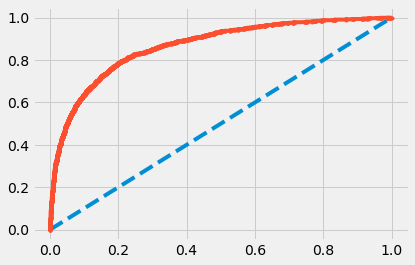

In [61]:
from sklearn.metrics import roc_curve
auc = roc_auc_score(y_val, GS_blending.best_estimator_.predict_proba(X_val)[:, 1])
print("AUC: %.3f"%auc)

fpr, tpr, threshholds = roc_curve(y_val,  GS_blending.best_estimator_.predict_proba(X_val)[:, 1])

plt.plot([0,1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker = '.')
plt.show()